In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


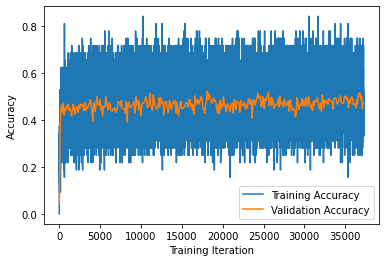

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.187 Validation Loss: 2.195 Accuracy: 0.094 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.189 Validation Loss: 2.195 Accuracy: 0.109 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.117 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.192 Validation Loss: 2.195 Accuracy: 0.107 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.116 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.191 Validation Loss: 2.195 Accuracy: 0.118 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.191 Validation Loss: 2.195 Accuracy: 0.122 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.120 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.188 Validation Loss: 2.195 Accuracy: 0.127 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.189 Validation Loss: 2.195 Accuracy: 0.123 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.189 Validation Loss: 2.195 Accuracy: 0.127 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.188 Validation Loss: 2.195 Accuracy: 0.134 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.187 Validation Loss: 2.195 Accuracy: 0.140 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.186 Validation Loss: 2.195 Accuracy: 0.148 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.155 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.159 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.162 Validation Accuracy: 0.105:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.162 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 17 Loss: 2.184 Validation Loss: 2.195 Accuracy: 0.174 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 18 Loss: 2.183 Validation Loss: 2.195 Accuracy: 0.174 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 19 Loss: 2.182 Validation Loss: 2.195 Accuracy: 0.184 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 20 Loss: 2.181 Validation Loss: 2.195 Accuracy: 0.194 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 21 Loss: 2.180 Validation Loss: 2.195 Accuracy: 0.194 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 22 Loss: 2.179 Validation Loss: 2.195 Accuracy: 0.192 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 23 Loss: 2.178 Validation Loss: 2.195 Accuracy: 0.201 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 24 Loss: 2.176 Validation Loss: 2.195 Accuracy: 0.206 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 25 Loss: 2.175 Validation Loss: 2.195 Accuracy: 0.212 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 26 Loss: 2.174 Validation Loss: 2.195 Accuracy: 0.222 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 27 Loss: 2.173 Validation Loss: 2.195 Accuracy: 0.225 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 28 Loss: 2.172 Validation Loss: 2.195 Accuracy: 0.238 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 29 Loss: 2.170 Validation Loss: 2.195 Accuracy: 0.245 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 30 Loss: 2.168 Validation Loss: 2.195 Accuracy: 0.255 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 31 Loss: 2.167 Validation Loss: 2.195 Accuracy: 0.268 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 32 Loss: 2.164 Validation Loss: 2.195 Accuracy: 0.297 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 33 Loss: 2.164 Validation Loss: 2.195 Accuracy: 0.305 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 34 Loss: 2.162 Validation Loss: 2.195 Accuracy: 0.312 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 35 Loss: 2.160 Validation Loss: 2.195 Accuracy: 0.321 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 36 Loss: 2.159 Validation Loss: 2.195 Accuracy: 0.316 Validation Accuracy: 0.105:   1%|          | 17/1519 [00:00<00:09, 165.72it/s]

Epoch: 0 Iteration: 36 Loss: 2.159 Validation Loss: 2.195 Accuracy: 0.316 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 37 Loss: 2.159 Validation Loss: 2.195 Accuracy: 0.320 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 38 Loss: 2.157 Validation Loss: 2.195 Accuracy: 0.326 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 39 Loss: 2.157 Validation Loss: 2.195 Accuracy: 0.334 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 40 Loss: 2.155 Validation Loss: 2.195 Accuracy: 0.346 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 41 Loss: 2.154 Validation Loss: 2.195 Accuracy: 0.347 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 42 Loss: 2.152 Validation Loss: 2.195 Accuracy: 0.332 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 43 Loss: 2.151 Validation Loss: 2.195 Accuracy: 0.334 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 44 Loss: 2.151 Validation Loss: 2.195 Accuracy: 0.335 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 45 Loss: 2.148 Validation Loss: 2.195 Accuracy: 0.349 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 46 Loss: 2.147 Validation Loss: 2.195 Accuracy: 0.363 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 47 Loss: 2.147 Validation Loss: 2.195 Accuracy: 0.368 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 48 Loss: 2.144 Validation Loss: 2.195 Accuracy: 0.375 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 49 Loss: 2.144 Validation Loss: 2.195 Accuracy: 0.384 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 50 Loss: 2.143 Validation Loss: 2.195 Accuracy: 0.374 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 51 Loss: 2.141 Validation Loss: 2.195 Accuracy: 0.387 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 52 Loss: 2.142 Validation Loss: 2.195 Accuracy: 0.388 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 53 Loss: 2.141 Validation Loss: 2.195 Accuracy: 0.393 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 54 Loss: 2.140 Validation Loss: 2.195 Accuracy: 0.396 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 55 Loss: 2.138 Validation Loss: 2.195 Accuracy: 0.389 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 56 Loss: 2.137 Validation Loss: 2.195 Accuracy: 0.390 Validation Accuracy: 0.105:   2%|▏         | 37/1519 [00:00<00:08, 183.51it/s]

Epoch: 0 Iteration: 56 Loss: 2.137 Validation Loss: 2.195 Accuracy: 0.390 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 57 Loss: 2.134 Validation Loss: 2.195 Accuracy: 0.396 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 58 Loss: 2.133 Validation Loss: 2.195 Accuracy: 0.398 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 59 Loss: 2.131 Validation Loss: 2.195 Accuracy: 0.396 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 60 Loss: 2.130 Validation Loss: 2.195 Accuracy: 0.405 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 61 Loss: 2.128 Validation Loss: 2.195 Accuracy: 0.397 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 62 Loss: 2.127 Validation Loss: 2.195 Accuracy: 0.403 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 63 Loss: 2.126 Validation Loss: 2.195 Accuracy: 0.406 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 64 Loss: 2.126 Validation Loss: 2.195 Accuracy: 0.403 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 65 Loss: 2.125 Validation Loss: 2.195 Accuracy: 0.408 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 66 Loss: 2.124 Validation Loss: 2.195 Accuracy: 0.409 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 67 Loss: 2.122 Validation Loss: 2.195 Accuracy: 0.410 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 68 Loss: 2.123 Validation Loss: 2.195 Accuracy: 0.405 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 69 Loss: 2.121 Validation Loss: 2.195 Accuracy: 0.412 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 70 Loss: 2.118 Validation Loss: 2.195 Accuracy: 0.420 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 71 Loss: 2.117 Validation Loss: 2.195 Accuracy: 0.431 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 72 Loss: 2.115 Validation Loss: 2.195 Accuracy: 0.438 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 73 Loss: 2.113 Validation Loss: 2.195 Accuracy: 0.438 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 74 Loss: 2.112 Validation Loss: 2.195 Accuracy: 0.447 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 75 Loss: 2.111 Validation Loss: 2.195 Accuracy: 0.449 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 76 Loss: 2.109 Validation Loss: 2.195 Accuracy: 0.457 Validation Accuracy: 0.105:   4%|▍         | 57/1519 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 76 Loss: 2.109 Validation Loss: 2.195 Accuracy: 0.457 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 77 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.462 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 78 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.455 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 79 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.448 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 80 Loss: 2.106 Validation Loss: 2.195 Accuracy: 0.441 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 81 Loss: 2.105 Validation Loss: 2.195 Accuracy: 0.441 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 82 Loss: 2.103 Validation Loss: 2.195 Accuracy: 0.438 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 83 Loss: 2.101 Validation Loss: 2.195 Accuracy: 0.438 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 84 Loss: 2.100 Validation Loss: 2.195 Accuracy: 0.433 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 85 Loss: 2.099 Validation Loss: 2.195 Accuracy: 0.428 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 86 Loss: 2.097 Validation Loss: 2.195 Accuracy: 0.428 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 87 Loss: 2.095 Validation Loss: 2.195 Accuracy: 0.422 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 88 Loss: 2.094 Validation Loss: 2.195 Accuracy: 0.426 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 89 Loss: 2.093 Validation Loss: 2.195 Accuracy: 0.434 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 90 Loss: 2.093 Validation Loss: 2.195 Accuracy: 0.432 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 91 Loss: 2.092 Validation Loss: 2.195 Accuracy: 0.425 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 92 Loss: 2.091 Validation Loss: 2.195 Accuracy: 0.427 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 93 Loss: 2.090 Validation Loss: 2.195 Accuracy: 0.427 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 94 Loss: 2.088 Validation Loss: 2.195 Accuracy: 0.431 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 95 Loss: 2.088 Validation Loss: 2.195 Accuracy: 0.430 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 96 Loss: 2.088 Validation Loss: 2.195 Accuracy: 0.424 Validation Accuracy: 0.105:   5%|▌         | 77/1519 [00:00<00:07, 191.60it/s]

Epoch: 0 Iteration: 96 Loss: 2.088 Validation Loss: 2.195 Accuracy: 0.424 Validation Accuracy: 0.105:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 97 Loss: 2.087 Validation Loss: 2.195 Accuracy: 0.425 Validation Accuracy: 0.105:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 98 Loss: 2.084 Validation Loss: 2.195 Accuracy: 0.430 Validation Accuracy: 0.105:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 99 Loss: 2.081 Validation Loss: 2.195 Accuracy: 0.426 Validation Accuracy: 0.105:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 100 Loss: 2.081 Validation Loss: 2.071 Accuracy: 0.428 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 101 Loss: 2.080 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 102 Loss: 2.080 Validation Loss: 2.071 Accuracy: 0.417 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 103 Loss: 2.078 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 104 Loss: 2.076 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 105 Loss: 2.074 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 106 Loss: 2.071 Validation Loss: 2.071 Accuracy: 0.433 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 107 Loss: 2.070 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 108 Loss: 2.069 Validation Loss: 2.071 Accuracy: 0.429 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 109 Loss: 2.069 Validation Loss: 2.071 Accuracy: 0.423 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 110 Loss: 2.069 Validation Loss: 2.071 Accuracy: 0.414 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 111 Loss: 2.068 Validation Loss: 2.071 Accuracy: 0.414 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 112 Loss: 2.067 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 113 Loss: 2.064 Validation Loss: 2.071 Accuracy: 0.424 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 114 Loss: 2.063 Validation Loss: 2.071 Accuracy: 0.424 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 115 Loss: 2.062 Validation Loss: 2.071 Accuracy: 0.423 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 116 Loss: 2.058 Validation Loss: 2.071 Accuracy: 0.422 Validation Accuracy: 0.267:   6%|▋         | 97/1519 [00:00<00:07, 192.66it/s]

Epoch: 0 Iteration: 116 Loss: 2.058 Validation Loss: 2.071 Accuracy: 0.422 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 117 Loss: 2.056 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 118 Loss: 2.056 Validation Loss: 2.071 Accuracy: 0.433 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 119 Loss: 2.055 Validation Loss: 2.071 Accuracy: 0.442 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 120 Loss: 2.053 Validation Loss: 2.071 Accuracy: 0.456 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 121 Loss: 2.053 Validation Loss: 2.071 Accuracy: 0.451 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 122 Loss: 2.051 Validation Loss: 2.071 Accuracy: 0.452 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 123 Loss: 2.048 Validation Loss: 2.071 Accuracy: 0.451 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 124 Loss: 2.049 Validation Loss: 2.071 Accuracy: 0.445 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 125 Loss: 2.049 Validation Loss: 2.071 Accuracy: 0.444 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 126 Loss: 2.050 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 127 Loss: 2.047 Validation Loss: 2.071 Accuracy: 0.438 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 128 Loss: 2.045 Validation Loss: 2.071 Accuracy: 0.439 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 129 Loss: 2.045 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 130 Loss: 2.043 Validation Loss: 2.071 Accuracy: 0.415 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 131 Loss: 2.042 Validation Loss: 2.071 Accuracy: 0.423 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 132 Loss: 2.040 Validation Loss: 2.071 Accuracy: 0.423 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 133 Loss: 2.040 Validation Loss: 2.071 Accuracy: 0.419 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 134 Loss: 2.039 Validation Loss: 2.071 Accuracy: 0.425 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 135 Loss: 2.036 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   8%|▊         | 117/1519 [00:00<00:07, 184.29it/s]

Epoch: 0 Iteration: 135 Loss: 2.036 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 136 Loss: 2.037 Validation Loss: 2.071 Accuracy: 0.424 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 137 Loss: 2.036 Validation Loss: 2.071 Accuracy: 0.424 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 138 Loss: 2.035 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 139 Loss: 2.035 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 140 Loss: 2.035 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 141 Loss: 2.032 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 142 Loss: 2.031 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 143 Loss: 2.030 Validation Loss: 2.071 Accuracy: 0.438 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 144 Loss: 2.028 Validation Loss: 2.071 Accuracy: 0.441 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 145 Loss: 2.026 Validation Loss: 2.071 Accuracy: 0.442 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 146 Loss: 2.025 Validation Loss: 2.071 Accuracy: 0.450 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 147 Loss: 2.024 Validation Loss: 2.071 Accuracy: 0.448 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 148 Loss: 2.022 Validation Loss: 2.071 Accuracy: 0.452 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 149 Loss: 2.017 Validation Loss: 2.071 Accuracy: 0.459 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 150 Loss: 2.016 Validation Loss: 2.071 Accuracy: 0.462 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 151 Loss: 2.016 Validation Loss: 2.071 Accuracy: 0.452 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 152 Loss: 2.015 Validation Loss: 2.071 Accuracy: 0.450 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 153 Loss: 2.014 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:   9%|▉         | 136/1519 [00:00<00:07, 174.43it/s]

Epoch: 0 Iteration: 153 Loss: 2.014 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 154 Loss: 2.013 Validation Loss: 2.071 Accuracy: 0.432 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 155 Loss: 2.013 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 156 Loss: 2.013 Validation Loss: 2.071 Accuracy: 0.431 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 157 Loss: 2.011 Validation Loss: 2.071 Accuracy: 0.437 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 158 Loss: 2.010 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 159 Loss: 2.008 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 160 Loss: 2.007 Validation Loss: 2.071 Accuracy: 0.430 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 161 Loss: 2.005 Validation Loss: 2.071 Accuracy: 0.441 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 162 Loss: 2.004 Validation Loss: 2.071 Accuracy: 0.444 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 163 Loss: 2.005 Validation Loss: 2.071 Accuracy: 0.439 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 164 Loss: 2.003 Validation Loss: 2.071 Accuracy: 0.445 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 165 Loss: 2.002 Validation Loss: 2.071 Accuracy: 0.444 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 166 Loss: 2.000 Validation Loss: 2.071 Accuracy: 0.447 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 167 Loss: 2.000 Validation Loss: 2.071 Accuracy: 0.435 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 168 Loss: 2.000 Validation Loss: 2.071 Accuracy: 0.433 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 169 Loss: 2.000 Validation Loss: 2.071 Accuracy: 0.432 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 170 Loss: 1.999 Validation Loss: 2.071 Accuracy: 0.431 Validation Accuracy: 0.267:  10%|█         | 154/1519 [00:00<00:08, 167.99it/s]

Epoch: 0 Iteration: 170 Loss: 1.999 Validation Loss: 2.071 Accuracy: 0.431 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:00<00:08, 162.92it/s]

Epoch: 0 Iteration: 171 Loss: 1.998 Validation Loss: 2.071 Accuracy: 0.429 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:00<00:08, 162.92it/s]

Epoch: 0 Iteration: 172 Loss: 1.994 Validation Loss: 2.071 Accuracy: 0.441 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:00<00:08, 162.92it/s]

Epoch: 0 Iteration: 173 Loss: 1.993 Validation Loss: 2.071 Accuracy: 0.444 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 174 Loss: 1.992 Validation Loss: 2.071 Accuracy: 0.442 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 175 Loss: 1.991 Validation Loss: 2.071 Accuracy: 0.436 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 176 Loss: 1.988 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 177 Loss: 1.989 Validation Loss: 2.071 Accuracy: 0.433 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 178 Loss: 1.988 Validation Loss: 2.071 Accuracy: 0.438 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 179 Loss: 1.986 Validation Loss: 2.071 Accuracy: 0.431 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 180 Loss: 1.986 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 181 Loss: 1.987 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 182 Loss: 1.984 Validation Loss: 2.071 Accuracy: 0.423 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 183 Loss: 1.981 Validation Loss: 2.071 Accuracy: 0.433 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 184 Loss: 1.981 Validation Loss: 2.071 Accuracy: 0.429 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 185 Loss: 1.979 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 186 Loss: 1.979 Validation Loss: 2.071 Accuracy: 0.428 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 187 Loss: 1.978 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:  11%|█▏        | 171/1519 [00:01<00:08, 162.92it/s]

Epoch: 0 Iteration: 187 Loss: 1.978 Validation Loss: 2.071 Accuracy: 0.427 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 188 Loss: 1.974 Validation Loss: 2.071 Accuracy: 0.435 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 189 Loss: 1.974 Validation Loss: 2.071 Accuracy: 0.434 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 190 Loss: 1.972 Validation Loss: 2.071 Accuracy: 0.441 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 191 Loss: 1.968 Validation Loss: 2.071 Accuracy: 0.455 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 192 Loss: 1.969 Validation Loss: 2.071 Accuracy: 0.443 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 193 Loss: 1.968 Validation Loss: 2.071 Accuracy: 0.431 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 194 Loss: 1.968 Validation Loss: 2.071 Accuracy: 0.422 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 195 Loss: 1.967 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 196 Loss: 1.967 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 197 Loss: 1.965 Validation Loss: 2.071 Accuracy: 0.422 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 198 Loss: 1.963 Validation Loss: 2.071 Accuracy: 0.420 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 199 Loss: 1.962 Validation Loss: 2.071 Accuracy: 0.429 Validation Accuracy: 0.267:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 200 Loss: 1.960 Validation Loss: 1.947 Accuracy: 0.419 Validation Accuracy: 0.330:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 201 Loss: 1.956 Validation Loss: 1.947 Accuracy: 0.413 Validation Accuracy: 0.330:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 202 Loss: 1.957 Validation Loss: 1.947 Accuracy: 0.411 Validation Accuracy: 0.330:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 203 Loss: 1.956 Validation Loss: 1.947 Accuracy: 0.417 Validation Accuracy: 0.330:  12%|█▏        | 188/1519 [00:01<00:08, 157.80it/s]

Epoch: 0 Iteration: 203 Loss: 1.956 Validation Loss: 1.947 Accuracy: 0.417 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 204 Loss: 1.956 Validation Loss: 1.947 Accuracy: 0.421 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 205 Loss: 1.956 Validation Loss: 1.947 Accuracy: 0.414 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 206 Loss: 1.954 Validation Loss: 1.947 Accuracy: 0.423 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 207 Loss: 1.951 Validation Loss: 1.947 Accuracy: 0.429 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 208 Loss: 1.954 Validation Loss: 1.947 Accuracy: 0.420 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 209 Loss: 1.954 Validation Loss: 1.947 Accuracy: 0.409 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 210 Loss: 1.953 Validation Loss: 1.947 Accuracy: 0.413 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 211 Loss: 1.954 Validation Loss: 1.947 Accuracy: 0.411 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 212 Loss: 1.953 Validation Loss: 1.947 Accuracy: 0.415 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 213 Loss: 1.950 Validation Loss: 1.947 Accuracy: 0.416 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 214 Loss: 1.948 Validation Loss: 1.947 Accuracy: 0.421 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 215 Loss: 1.946 Validation Loss: 1.947 Accuracy: 0.436 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 216 Loss: 1.944 Validation Loss: 1.947 Accuracy: 0.434 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 217 Loss: 1.942 Validation Loss: 1.947 Accuracy: 0.437 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 218 Loss: 1.941 Validation Loss: 1.947 Accuracy: 0.441 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 219 Loss: 1.941 Validation Loss: 1.947 Accuracy: 0.447 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 220 Loss: 1.937 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  13%|█▎        | 204/1519 [00:01<00:08, 152.31it/s]

Epoch: 0 Iteration: 220 Loss: 1.937 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 221 Loss: 1.937 Validation Loss: 1.947 Accuracy: 0.464 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 222 Loss: 1.935 Validation Loss: 1.947 Accuracy: 0.466 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 223 Loss: 1.935 Validation Loss: 1.947 Accuracy: 0.460 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 224 Loss: 1.931 Validation Loss: 1.947 Accuracy: 0.465 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 225 Loss: 1.927 Validation Loss: 1.947 Accuracy: 0.466 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 226 Loss: 1.927 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 227 Loss: 1.926 Validation Loss: 1.947 Accuracy: 0.452 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 228 Loss: 1.922 Validation Loss: 1.947 Accuracy: 0.452 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 229 Loss: 1.920 Validation Loss: 1.947 Accuracy: 0.450 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 230 Loss: 1.919 Validation Loss: 1.947 Accuracy: 0.437 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 231 Loss: 1.919 Validation Loss: 1.947 Accuracy: 0.430 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 232 Loss: 1.916 Validation Loss: 1.947 Accuracy: 0.430 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 233 Loss: 1.914 Validation Loss: 1.947 Accuracy: 0.435 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 234 Loss: 1.913 Validation Loss: 1.947 Accuracy: 0.428 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 235 Loss: 1.915 Validation Loss: 1.947 Accuracy: 0.417 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 236 Loss: 1.914 Validation Loss: 1.947 Accuracy: 0.417 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 237 Loss: 1.913 Validation Loss: 1.947 Accuracy: 0.425 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 238 Loss: 1.913 Validation Loss: 1.947 Accuracy: 0.424 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 239 Loss: 1.911 Validation Loss: 1.947 Accuracy: 0.426 Validation Accuracy: 0.330:  15%|█▍        | 221/1519 [00:01<00:08, 155.06it/s]

Epoch: 0 Iteration: 239 Loss: 1.911 Validation Loss: 1.947 Accuracy: 0.426 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 240 Loss: 1.912 Validation Loss: 1.947 Accuracy: 0.427 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 241 Loss: 1.911 Validation Loss: 1.947 Accuracy: 0.434 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 242 Loss: 1.910 Validation Loss: 1.947 Accuracy: 0.434 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 243 Loss: 1.907 Validation Loss: 1.947 Accuracy: 0.441 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 244 Loss: 1.907 Validation Loss: 1.947 Accuracy: 0.442 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 245 Loss: 1.907 Validation Loss: 1.947 Accuracy: 0.454 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 246 Loss: 1.906 Validation Loss: 1.947 Accuracy: 0.463 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 247 Loss: 1.903 Validation Loss: 1.947 Accuracy: 0.464 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 248 Loss: 1.903 Validation Loss: 1.947 Accuracy: 0.466 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 249 Loss: 1.899 Validation Loss: 1.947 Accuracy: 0.473 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 250 Loss: 1.899 Validation Loss: 1.947 Accuracy: 0.474 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 251 Loss: 1.895 Validation Loss: 1.947 Accuracy: 0.478 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 252 Loss: 1.894 Validation Loss: 1.947 Accuracy: 0.484 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 253 Loss: 1.895 Validation Loss: 1.947 Accuracy: 0.479 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 254 Loss: 1.895 Validation Loss: 1.947 Accuracy: 0.474 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 255 Loss: 1.892 Validation Loss: 1.947 Accuracy: 0.467 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 256 Loss: 1.890 Validation Loss: 1.947 Accuracy: 0.465 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 257 Loss: 1.889 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 258 Loss: 1.888 Validation Loss: 1.947 Accuracy: 0.456 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 259 Loss: 1.885 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  16%|█▌        | 240/1519 [00:01<00:07, 163.36it/s]

Epoch: 0 Iteration: 259 Loss: 1.885 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 260 Loss: 1.883 Validation Loss: 1.947 Accuracy: 0.460 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 261 Loss: 1.883 Validation Loss: 1.947 Accuracy: 0.447 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 262 Loss: 1.883 Validation Loss: 1.947 Accuracy: 0.438 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 263 Loss: 1.882 Validation Loss: 1.947 Accuracy: 0.442 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 264 Loss: 1.877 Validation Loss: 1.947 Accuracy: 0.460 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 265 Loss: 1.878 Validation Loss: 1.947 Accuracy: 0.459 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 266 Loss: 1.877 Validation Loss: 1.947 Accuracy: 0.462 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 267 Loss: 1.875 Validation Loss: 1.947 Accuracy: 0.468 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 268 Loss: 1.872 Validation Loss: 1.947 Accuracy: 0.478 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 269 Loss: 1.870 Validation Loss: 1.947 Accuracy: 0.477 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 270 Loss: 1.866 Validation Loss: 1.947 Accuracy: 0.487 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 271 Loss: 1.867 Validation Loss: 1.947 Accuracy: 0.491 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 272 Loss: 1.868 Validation Loss: 1.947 Accuracy: 0.485 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 273 Loss: 1.865 Validation Loss: 1.947 Accuracy: 0.485 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 274 Loss: 1.862 Validation Loss: 1.947 Accuracy: 0.480 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 275 Loss: 1.861 Validation Loss: 1.947 Accuracy: 0.484 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 276 Loss: 1.859 Validation Loss: 1.947 Accuracy: 0.488 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 277 Loss: 1.857 Validation Loss: 1.947 Accuracy: 0.485 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 278 Loss: 1.854 Validation Loss: 1.947 Accuracy: 0.487 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 279 Loss: 1.854 Validation Loss: 1.947 Accuracy: 0.481 Validation Accuracy: 0.330:  17%|█▋        | 260/1519 [00:01<00:07, 172.13it/s]

Epoch: 0 Iteration: 279 Loss: 1.854 Validation Loss: 1.947 Accuracy: 0.481 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 280 Loss: 1.854 Validation Loss: 1.947 Accuracy: 0.475 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 281 Loss: 1.851 Validation Loss: 1.947 Accuracy: 0.476 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 282 Loss: 1.848 Validation Loss: 1.947 Accuracy: 0.482 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 283 Loss: 1.848 Validation Loss: 1.947 Accuracy: 0.478 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 284 Loss: 1.849 Validation Loss: 1.947 Accuracy: 0.473 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 285 Loss: 1.846 Validation Loss: 1.947 Accuracy: 0.476 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 286 Loss: 1.842 Validation Loss: 1.947 Accuracy: 0.470 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 287 Loss: 1.840 Validation Loss: 1.947 Accuracy: 0.478 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 288 Loss: 1.840 Validation Loss: 1.947 Accuracy: 0.476 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 289 Loss: 1.839 Validation Loss: 1.947 Accuracy: 0.484 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 290 Loss: 1.840 Validation Loss: 1.947 Accuracy: 0.477 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 291 Loss: 1.839 Validation Loss: 1.947 Accuracy: 0.477 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 292 Loss: 1.835 Validation Loss: 1.947 Accuracy: 0.481 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 293 Loss: 1.834 Validation Loss: 1.947 Accuracy: 0.481 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 294 Loss: 1.833 Validation Loss: 1.947 Accuracy: 0.480 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 295 Loss: 1.832 Validation Loss: 1.947 Accuracy: 0.480 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 296 Loss: 1.831 Validation Loss: 1.947 Accuracy: 0.480 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 297 Loss: 1.829 Validation Loss: 1.947 Accuracy: 0.473 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 298 Loss: 1.831 Validation Loss: 1.947 Accuracy: 0.462 Validation Accuracy: 0.330:  18%|█▊        | 280/1519 [00:01<00:06, 178.15it/s]

Epoch: 0 Iteration: 298 Loss: 1.831 Validation Loss: 1.947 Accuracy: 0.462 Validation Accuracy: 0.330:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 299 Loss: 1.828 Validation Loss: 1.947 Accuracy: 0.461 Validation Accuracy: 0.330:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 300 Loss: 1.828 Validation Loss: 1.817 Accuracy: 0.466 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 301 Loss: 1.824 Validation Loss: 1.817 Accuracy: 0.472 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 302 Loss: 1.822 Validation Loss: 1.817 Accuracy: 0.474 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 303 Loss: 1.821 Validation Loss: 1.817 Accuracy: 0.478 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 304 Loss: 1.820 Validation Loss: 1.817 Accuracy: 0.484 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 305 Loss: 1.815 Validation Loss: 1.817 Accuracy: 0.492 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 306 Loss: 1.815 Validation Loss: 1.817 Accuracy: 0.496 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 307 Loss: 1.815 Validation Loss: 1.817 Accuracy: 0.498 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 308 Loss: 1.813 Validation Loss: 1.817 Accuracy: 0.507 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 309 Loss: 1.813 Validation Loss: 1.817 Accuracy: 0.504 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 310 Loss: 1.809 Validation Loss: 1.817 Accuracy: 0.512 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 311 Loss: 1.808 Validation Loss: 1.817 Accuracy: 0.517 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 312 Loss: 1.807 Validation Loss: 1.817 Accuracy: 0.521 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 313 Loss: 1.807 Validation Loss: 1.817 Accuracy: 0.519 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 314 Loss: 1.806 Validation Loss: 1.817 Accuracy: 0.515 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 315 Loss: 1.802 Validation Loss: 1.817 Accuracy: 0.509 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 316 Loss: 1.801 Validation Loss: 1.817 Accuracy: 0.505 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 317 Loss: 1.800 Validation Loss: 1.817 Accuracy: 0.506 Validation Accuracy: 0.369:  20%|█▉        | 299/1519 [00:01<00:06, 180.30it/s]

Epoch: 0 Iteration: 317 Loss: 1.800 Validation Loss: 1.817 Accuracy: 0.506 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 318 Loss: 1.796 Validation Loss: 1.817 Accuracy: 0.507 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 319 Loss: 1.796 Validation Loss: 1.817 Accuracy: 0.504 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 320 Loss: 1.794 Validation Loss: 1.817 Accuracy: 0.498 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 321 Loss: 1.795 Validation Loss: 1.817 Accuracy: 0.489 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 322 Loss: 1.797 Validation Loss: 1.817 Accuracy: 0.476 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 323 Loss: 1.797 Validation Loss: 1.817 Accuracy: 0.479 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 324 Loss: 1.797 Validation Loss: 1.817 Accuracy: 0.471 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 325 Loss: 1.799 Validation Loss: 1.817 Accuracy: 0.463 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 326 Loss: 1.799 Validation Loss: 1.817 Accuracy: 0.468 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 327 Loss: 1.796 Validation Loss: 1.817 Accuracy: 0.465 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 328 Loss: 1.796 Validation Loss: 1.817 Accuracy: 0.460 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 329 Loss: 1.796 Validation Loss: 1.817 Accuracy: 0.460 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 330 Loss: 1.797 Validation Loss: 1.817 Accuracy: 0.455 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 331 Loss: 1.798 Validation Loss: 1.817 Accuracy: 0.455 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 332 Loss: 1.794 Validation Loss: 1.817 Accuracy: 0.468 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 333 Loss: 1.793 Validation Loss: 1.817 Accuracy: 0.467 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 334 Loss: 1.790 Validation Loss: 1.817 Accuracy: 0.482 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 335 Loss: 1.789 Validation Loss: 1.817 Accuracy: 0.490 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 336 Loss: 1.786 Validation Loss: 1.817 Accuracy: 0.490 Validation Accuracy: 0.369:  21%|██        | 318/1519 [00:01<00:06, 179.73it/s]

Epoch: 0 Iteration: 336 Loss: 1.786 Validation Loss: 1.817 Accuracy: 0.490 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 337 Loss: 1.785 Validation Loss: 1.817 Accuracy: 0.493 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 338 Loss: 1.785 Validation Loss: 1.817 Accuracy: 0.498 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 339 Loss: 1.788 Validation Loss: 1.817 Accuracy: 0.487 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 340 Loss: 1.788 Validation Loss: 1.817 Accuracy: 0.487 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 341 Loss: 1.786 Validation Loss: 1.817 Accuracy: 0.493 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 342 Loss: 1.782 Validation Loss: 1.817 Accuracy: 0.490 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 343 Loss: 1.778 Validation Loss: 1.817 Accuracy: 0.496 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 344 Loss: 1.775 Validation Loss: 1.817 Accuracy: 0.495 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 345 Loss: 1.774 Validation Loss: 1.817 Accuracy: 0.492 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 346 Loss: 1.773 Validation Loss: 1.817 Accuracy: 0.492 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 347 Loss: 1.771 Validation Loss: 1.817 Accuracy: 0.496 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 348 Loss: 1.768 Validation Loss: 1.817 Accuracy: 0.498 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:01<00:06, 181.38it/s]

Epoch: 0 Iteration: 349 Loss: 1.765 Validation Loss: 1.817 Accuracy: 0.517 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 350 Loss: 1.762 Validation Loss: 1.817 Accuracy: 0.527 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 351 Loss: 1.759 Validation Loss: 1.817 Accuracy: 0.523 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 352 Loss: 1.760 Validation Loss: 1.817 Accuracy: 0.520 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 353 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.521 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 354 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.522 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 355 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.519 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 356 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.517 Validation Accuracy: 0.369:  22%|██▏       | 337/1519 [00:02<00:06, 181.38it/s]

Epoch: 0 Iteration: 356 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.517 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 357 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.511 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 358 Loss: 1.757 Validation Loss: 1.817 Accuracy: 0.508 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 359 Loss: 1.751 Validation Loss: 1.817 Accuracy: 0.510 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 360 Loss: 1.746 Validation Loss: 1.817 Accuracy: 0.516 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 361 Loss: 1.746 Validation Loss: 1.817 Accuracy: 0.523 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 362 Loss: 1.744 Validation Loss: 1.817 Accuracy: 0.530 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 363 Loss: 1.746 Validation Loss: 1.817 Accuracy: 0.519 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 364 Loss: 1.748 Validation Loss: 1.817 Accuracy: 0.509 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 365 Loss: 1.747 Validation Loss: 1.817 Accuracy: 0.509 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 366 Loss: 1.742 Validation Loss: 1.817 Accuracy: 0.515 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 367 Loss: 1.741 Validation Loss: 1.817 Accuracy: 0.520 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 368 Loss: 1.739 Validation Loss: 1.817 Accuracy: 0.527 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 369 Loss: 1.739 Validation Loss: 1.817 Accuracy: 0.517 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 370 Loss: 1.739 Validation Loss: 1.817 Accuracy: 0.515 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 371 Loss: 1.736 Validation Loss: 1.817 Accuracy: 0.510 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 372 Loss: 1.734 Validation Loss: 1.817 Accuracy: 0.510 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 373 Loss: 1.733 Validation Loss: 1.817 Accuracy: 0.513 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 374 Loss: 1.731 Validation Loss: 1.817 Accuracy: 0.525 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 375 Loss: 1.729 Validation Loss: 1.817 Accuracy: 0.527 Validation Accuracy: 0.369:  24%|██▎       | 357/1519 [00:02<00:06, 185.85it/s]

Epoch: 0 Iteration: 375 Loss: 1.729 Validation Loss: 1.817 Accuracy: 0.527 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 376 Loss: 1.726 Validation Loss: 1.817 Accuracy: 0.526 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 377 Loss: 1.723 Validation Loss: 1.817 Accuracy: 0.523 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 378 Loss: 1.718 Validation Loss: 1.817 Accuracy: 0.521 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 379 Loss: 1.716 Validation Loss: 1.817 Accuracy: 0.532 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 380 Loss: 1.715 Validation Loss: 1.817 Accuracy: 0.536 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 381 Loss: 1.711 Validation Loss: 1.817 Accuracy: 0.536 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 382 Loss: 1.712 Validation Loss: 1.817 Accuracy: 0.530 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 383 Loss: 1.710 Validation Loss: 1.817 Accuracy: 0.534 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 384 Loss: 1.707 Validation Loss: 1.817 Accuracy: 0.530 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 385 Loss: 1.706 Validation Loss: 1.817 Accuracy: 0.532 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 386 Loss: 1.707 Validation Loss: 1.817 Accuracy: 0.533 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 387 Loss: 1.708 Validation Loss: 1.817 Accuracy: 0.531 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 388 Loss: 1.706 Validation Loss: 1.817 Accuracy: 0.537 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 389 Loss: 1.707 Validation Loss: 1.817 Accuracy: 0.522 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 390 Loss: 1.704 Validation Loss: 1.817 Accuracy: 0.520 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 391 Loss: 1.702 Validation Loss: 1.817 Accuracy: 0.527 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 392 Loss: 1.699 Validation Loss: 1.817 Accuracy: 0.539 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 393 Loss: 1.700 Validation Loss: 1.817 Accuracy: 0.532 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 394 Loss: 1.700 Validation Loss: 1.817 Accuracy: 0.530 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 395 Loss: 1.700 Validation Loss: 1.817 Accuracy: 0.526 Validation Accuracy: 0.369:  25%|██▍       | 376/1519 [00:02<00:06, 186.11it/s]

Epoch: 0 Iteration: 395 Loss: 1.700 Validation Loss: 1.817 Accuracy: 0.526 Validation Accuracy: 0.369:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 396 Loss: 1.701 Validation Loss: 1.817 Accuracy: 0.519 Validation Accuracy: 0.369:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 397 Loss: 1.698 Validation Loss: 1.817 Accuracy: 0.522 Validation Accuracy: 0.369:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 398 Loss: 1.697 Validation Loss: 1.817 Accuracy: 0.516 Validation Accuracy: 0.369:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 399 Loss: 1.701 Validation Loss: 1.817 Accuracy: 0.516 Validation Accuracy: 0.369:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 400 Loss: 1.700 Validation Loss: 1.684 Accuracy: 0.522 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 401 Loss: 1.700 Validation Loss: 1.684 Accuracy: 0.513 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 402 Loss: 1.698 Validation Loss: 1.684 Accuracy: 0.502 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 403 Loss: 1.696 Validation Loss: 1.684 Accuracy: 0.510 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 404 Loss: 1.694 Validation Loss: 1.684 Accuracy: 0.511 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 405 Loss: 1.693 Validation Loss: 1.684 Accuracy: 0.517 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 406 Loss: 1.691 Validation Loss: 1.684 Accuracy: 0.523 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 407 Loss: 1.690 Validation Loss: 1.684 Accuracy: 0.524 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 408 Loss: 1.693 Validation Loss: 1.684 Accuracy: 0.519 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 409 Loss: 1.690 Validation Loss: 1.684 Accuracy: 0.530 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 410 Loss: 1.690 Validation Loss: 1.684 Accuracy: 0.517 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 411 Loss: 1.691 Validation Loss: 1.684 Accuracy: 0.527 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 412 Loss: 1.692 Validation Loss: 1.684 Accuracy: 0.534 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 413 Loss: 1.690 Validation Loss: 1.684 Accuracy: 0.530 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 414 Loss: 1.689 Validation Loss: 1.684 Accuracy: 0.534 Validation Accuracy: 0.400:  26%|██▌       | 396/1519 [00:02<00:05, 188.82it/s]

Epoch: 0 Iteration: 414 Loss: 1.689 Validation Loss: 1.684 Accuracy: 0.534 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 415 Loss: 1.689 Validation Loss: 1.684 Accuracy: 0.527 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 416 Loss: 1.685 Validation Loss: 1.684 Accuracy: 0.529 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 417 Loss: 1.684 Validation Loss: 1.684 Accuracy: 0.530 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 418 Loss: 1.684 Validation Loss: 1.684 Accuracy: 0.540 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 419 Loss: 1.684 Validation Loss: 1.684 Accuracy: 0.533 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 420 Loss: 1.683 Validation Loss: 1.684 Accuracy: 0.534 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 421 Loss: 1.680 Validation Loss: 1.684 Accuracy: 0.537 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 422 Loss: 1.677 Validation Loss: 1.684 Accuracy: 0.536 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 423 Loss: 1.675 Validation Loss: 1.684 Accuracy: 0.544 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 424 Loss: 1.671 Validation Loss: 1.684 Accuracy: 0.550 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 425 Loss: 1.668 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 426 Loss: 1.664 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 427 Loss: 1.661 Validation Loss: 1.684 Accuracy: 0.560 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 428 Loss: 1.657 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 429 Loss: 1.655 Validation Loss: 1.684 Accuracy: 0.560 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 430 Loss: 1.651 Validation Loss: 1.684 Accuracy: 0.569 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 431 Loss: 1.648 Validation Loss: 1.684 Accuracy: 0.570 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 432 Loss: 1.646 Validation Loss: 1.684 Accuracy: 0.568 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 433 Loss: 1.646 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 434 Loss: 1.645 Validation Loss: 1.684 Accuracy: 0.549 Validation Accuracy: 0.400:  27%|██▋       | 415/1519 [00:02<00:05, 186.67it/s]

Epoch: 0 Iteration: 434 Loss: 1.645 Validation Loss: 1.684 Accuracy: 0.549 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 435 Loss: 1.639 Validation Loss: 1.684 Accuracy: 0.547 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 436 Loss: 1.639 Validation Loss: 1.684 Accuracy: 0.547 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 437 Loss: 1.640 Validation Loss: 1.684 Accuracy: 0.546 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 438 Loss: 1.637 Validation Loss: 1.684 Accuracy: 0.547 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 439 Loss: 1.630 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 440 Loss: 1.627 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 441 Loss: 1.628 Validation Loss: 1.684 Accuracy: 0.554 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 442 Loss: 1.626 Validation Loss: 1.684 Accuracy: 0.558 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 443 Loss: 1.626 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 444 Loss: 1.626 Validation Loss: 1.684 Accuracy: 0.581 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 445 Loss: 1.626 Validation Loss: 1.684 Accuracy: 0.573 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 446 Loss: 1.628 Validation Loss: 1.684 Accuracy: 0.561 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 447 Loss: 1.626 Validation Loss: 1.684 Accuracy: 0.577 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 448 Loss: 1.624 Validation Loss: 1.684 Accuracy: 0.577 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 449 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.573 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 450 Loss: 1.622 Validation Loss: 1.684 Accuracy: 0.564 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 451 Loss: 1.621 Validation Loss: 1.684 Accuracy: 0.577 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 452 Loss: 1.620 Validation Loss: 1.684 Accuracy: 0.574 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 453 Loss: 1.617 Validation Loss: 1.684 Accuracy: 0.573 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 454 Loss: 1.613 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  29%|██▊       | 435/1519 [00:02<00:05, 189.09it/s]

Epoch: 0 Iteration: 454 Loss: 1.613 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 455 Loss: 1.616 Validation Loss: 1.684 Accuracy: 0.568 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 456 Loss: 1.618 Validation Loss: 1.684 Accuracy: 0.576 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 457 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.555 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 458 Loss: 1.620 Validation Loss: 1.684 Accuracy: 0.555 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 459 Loss: 1.620 Validation Loss: 1.684 Accuracy: 0.550 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 460 Loss: 1.618 Validation Loss: 1.684 Accuracy: 0.563 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 461 Loss: 1.618 Validation Loss: 1.684 Accuracy: 0.554 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 462 Loss: 1.620 Validation Loss: 1.684 Accuracy: 0.548 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 463 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.548 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 464 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.546 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 465 Loss: 1.617 Validation Loss: 1.684 Accuracy: 0.553 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 466 Loss: 1.617 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 467 Loss: 1.621 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 468 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.560 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 469 Loss: 1.619 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 470 Loss: 1.616 Validation Loss: 1.684 Accuracy: 0.545 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 471 Loss: 1.617 Validation Loss: 1.684 Accuracy: 0.545 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 472 Loss: 1.614 Validation Loss: 1.684 Accuracy: 0.547 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 473 Loss: 1.614 Validation Loss: 1.684 Accuracy: 0.536 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 474 Loss: 1.613 Validation Loss: 1.684 Accuracy: 0.540 Validation Accuracy: 0.400:  30%|██▉       | 455/1519 [00:02<00:05, 190.85it/s]

Epoch: 0 Iteration: 474 Loss: 1.613 Validation Loss: 1.684 Accuracy: 0.540 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 475 Loss: 1.609 Validation Loss: 1.684 Accuracy: 0.543 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 476 Loss: 1.604 Validation Loss: 1.684 Accuracy: 0.541 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 477 Loss: 1.600 Validation Loss: 1.684 Accuracy: 0.553 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 478 Loss: 1.597 Validation Loss: 1.684 Accuracy: 0.552 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 479 Loss: 1.598 Validation Loss: 1.684 Accuracy: 0.550 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 480 Loss: 1.598 Validation Loss: 1.684 Accuracy: 0.556 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 481 Loss: 1.595 Validation Loss: 1.684 Accuracy: 0.559 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 482 Loss: 1.590 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 483 Loss: 1.591 Validation Loss: 1.684 Accuracy: 0.570 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 484 Loss: 1.589 Validation Loss: 1.684 Accuracy: 0.570 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 485 Loss: 1.590 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 486 Loss: 1.587 Validation Loss: 1.684 Accuracy: 0.557 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 487 Loss: 1.582 Validation Loss: 1.684 Accuracy: 0.558 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 488 Loss: 1.585 Validation Loss: 1.684 Accuracy: 0.552 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 489 Loss: 1.585 Validation Loss: 1.684 Accuracy: 0.558 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 490 Loss: 1.585 Validation Loss: 1.684 Accuracy: 0.552 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 491 Loss: 1.580 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 492 Loss: 1.578 Validation Loss: 1.684 Accuracy: 0.566 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 493 Loss: 1.577 Validation Loss: 1.684 Accuracy: 0.571 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 494 Loss: 1.576 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  31%|███▏      | 475/1519 [00:02<00:05, 192.05it/s]

Epoch: 0 Iteration: 494 Loss: 1.576 Validation Loss: 1.684 Accuracy: 0.562 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 495 Loss: 1.576 Validation Loss: 1.684 Accuracy: 0.571 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 496 Loss: 1.576 Validation Loss: 1.684 Accuracy: 0.573 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 497 Loss: 1.579 Validation Loss: 1.684 Accuracy: 0.565 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 498 Loss: 1.579 Validation Loss: 1.684 Accuracy: 0.570 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 499 Loss: 1.577 Validation Loss: 1.684 Accuracy: 0.566 Validation Accuracy: 0.400:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 500 Loss: 1.576 Validation Loss: 1.559 Accuracy: 0.577 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 501 Loss: 1.576 Validation Loss: 1.559 Accuracy: 0.570 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 502 Loss: 1.576 Validation Loss: 1.559 Accuracy: 0.563 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 503 Loss: 1.574 Validation Loss: 1.559 Accuracy: 0.562 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 504 Loss: 1.572 Validation Loss: 1.559 Accuracy: 0.572 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 505 Loss: 1.566 Validation Loss: 1.559 Accuracy: 0.570 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 506 Loss: 1.566 Validation Loss: 1.559 Accuracy: 0.566 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 507 Loss: 1.564 Validation Loss: 1.559 Accuracy: 0.578 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 508 Loss: 1.561 Validation Loss: 1.559 Accuracy: 0.577 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 509 Loss: 1.562 Validation Loss: 1.559 Accuracy: 0.570 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 510 Loss: 1.561 Validation Loss: 1.559 Accuracy: 0.567 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 511 Loss: 1.565 Validation Loss: 1.559 Accuracy: 0.559 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 512 Loss: 1.567 Validation Loss: 1.559 Accuracy: 0.555 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 513 Loss: 1.566 Validation Loss: 1.559 Accuracy: 0.560 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 514 Loss: 1.562 Validation Loss: 1.559 Accuracy: 0.559 Validation Accuracy: 0.426:  33%|███▎      | 495/1519 [00:02<00:05, 192.70it/s]

Epoch: 0 Iteration: 514 Loss: 1.562 Validation Loss: 1.559 Accuracy: 0.559 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 515 Loss: 1.560 Validation Loss: 1.559 Accuracy: 0.555 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 516 Loss: 1.558 Validation Loss: 1.559 Accuracy: 0.566 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 517 Loss: 1.554 Validation Loss: 1.559 Accuracy: 0.561 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 518 Loss: 1.555 Validation Loss: 1.559 Accuracy: 0.558 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 519 Loss: 1.552 Validation Loss: 1.559 Accuracy: 0.568 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 520 Loss: 1.550 Validation Loss: 1.559 Accuracy: 0.564 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 521 Loss: 1.550 Validation Loss: 1.559 Accuracy: 0.567 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 522 Loss: 1.546 Validation Loss: 1.559 Accuracy: 0.580 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 523 Loss: 1.546 Validation Loss: 1.559 Accuracy: 0.574 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 524 Loss: 1.545 Validation Loss: 1.559 Accuracy: 0.572 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 525 Loss: 1.549 Validation Loss: 1.559 Accuracy: 0.577 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 526 Loss: 1.548 Validation Loss: 1.559 Accuracy: 0.568 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 527 Loss: 1.550 Validation Loss: 1.559 Accuracy: 0.562 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 528 Loss: 1.549 Validation Loss: 1.559 Accuracy: 0.573 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 529 Loss: 1.546 Validation Loss: 1.559 Accuracy: 0.576 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 530 Loss: 1.545 Validation Loss: 1.559 Accuracy: 0.573 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 531 Loss: 1.544 Validation Loss: 1.559 Accuracy: 0.576 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 532 Loss: 1.544 Validation Loss: 1.559 Accuracy: 0.566 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 533 Loss: 1.542 Validation Loss: 1.559 Accuracy: 0.571 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 534 Loss: 1.543 Validation Loss: 1.559 Accuracy: 0.574 Validation Accuracy: 0.426:  34%|███▍      | 515/1519 [00:02<00:05, 189.85it/s]

Epoch: 0 Iteration: 534 Loss: 1.543 Validation Loss: 1.559 Accuracy: 0.574 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 535 Loss: 1.543 Validation Loss: 1.559 Accuracy: 0.572 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 536 Loss: 1.544 Validation Loss: 1.559 Accuracy: 0.566 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 537 Loss: 1.545 Validation Loss: 1.559 Accuracy: 0.568 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 538 Loss: 1.538 Validation Loss: 1.559 Accuracy: 0.567 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 539 Loss: 1.539 Validation Loss: 1.559 Accuracy: 0.567 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:02<00:05, 191.08it/s]

Epoch: 0 Iteration: 540 Loss: 1.537 Validation Loss: 1.559 Accuracy: 0.578 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 541 Loss: 1.538 Validation Loss: 1.559 Accuracy: 0.577 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 542 Loss: 1.537 Validation Loss: 1.559 Accuracy: 0.583 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 543 Loss: 1.535 Validation Loss: 1.559 Accuracy: 0.580 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 544 Loss: 1.535 Validation Loss: 1.559 Accuracy: 0.580 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 545 Loss: 1.532 Validation Loss: 1.559 Accuracy: 0.581 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 546 Loss: 1.530 Validation Loss: 1.559 Accuracy: 0.588 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 547 Loss: 1.528 Validation Loss: 1.559 Accuracy: 0.594 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 548 Loss: 1.526 Validation Loss: 1.559 Accuracy: 0.594 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 549 Loss: 1.524 Validation Loss: 1.559 Accuracy: 0.595 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 550 Loss: 1.520 Validation Loss: 1.559 Accuracy: 0.599 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 551 Loss: 1.519 Validation Loss: 1.559 Accuracy: 0.602 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 552 Loss: 1.512 Validation Loss: 1.559 Accuracy: 0.602 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 553 Loss: 1.510 Validation Loss: 1.559 Accuracy: 0.605 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 554 Loss: 1.510 Validation Loss: 1.559 Accuracy: 0.602 Validation Accuracy: 0.426:  35%|███▌      | 535/1519 [00:03<00:05, 191.08it/s]

Epoch: 0 Iteration: 554 Loss: 1.510 Validation Loss: 1.559 Accuracy: 0.602 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 555 Loss: 1.509 Validation Loss: 1.559 Accuracy: 0.605 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 556 Loss: 1.505 Validation Loss: 1.559 Accuracy: 0.615 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 557 Loss: 1.499 Validation Loss: 1.559 Accuracy: 0.612 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 558 Loss: 1.499 Validation Loss: 1.559 Accuracy: 0.617 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 559 Loss: 1.499 Validation Loss: 1.559 Accuracy: 0.613 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 560 Loss: 1.501 Validation Loss: 1.559 Accuracy: 0.605 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 561 Loss: 1.494 Validation Loss: 1.559 Accuracy: 0.609 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 562 Loss: 1.494 Validation Loss: 1.559 Accuracy: 0.605 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 563 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.600 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 564 Loss: 1.494 Validation Loss: 1.559 Accuracy: 0.605 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 565 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.593 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 566 Loss: 1.493 Validation Loss: 1.559 Accuracy: 0.584 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 567 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.586 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 568 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.575 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 569 Loss: 1.494 Validation Loss: 1.559 Accuracy: 0.577 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 570 Loss: 1.497 Validation Loss: 1.559 Accuracy: 0.569 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 571 Loss: 1.496 Validation Loss: 1.559 Accuracy: 0.566 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 572 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.576 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 573 Loss: 1.491 Validation Loss: 1.559 Accuracy: 0.591 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 574 Loss: 1.490 Validation Loss: 1.559 Accuracy: 0.588 Validation Accuracy: 0.426:  37%|███▋      | 555/1519 [00:03<00:05, 192.21it/s]

Epoch: 0 Iteration: 574 Loss: 1.490 Validation Loss: 1.559 Accuracy: 0.588 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 575 Loss: 1.489 Validation Loss: 1.559 Accuracy: 0.598 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 576 Loss: 1.492 Validation Loss: 1.559 Accuracy: 0.592 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 577 Loss: 1.492 Validation Loss: 1.559 Accuracy: 0.596 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 578 Loss: 1.496 Validation Loss: 1.559 Accuracy: 0.598 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 579 Loss: 1.492 Validation Loss: 1.559 Accuracy: 0.604 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 580 Loss: 1.488 Validation Loss: 1.559 Accuracy: 0.612 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 581 Loss: 1.492 Validation Loss: 1.559 Accuracy: 0.608 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 582 Loss: 1.491 Validation Loss: 1.559 Accuracy: 0.599 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 583 Loss: 1.486 Validation Loss: 1.559 Accuracy: 0.595 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 584 Loss: 1.484 Validation Loss: 1.559 Accuracy: 0.598 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 585 Loss: 1.483 Validation Loss: 1.559 Accuracy: 0.592 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 586 Loss: 1.483 Validation Loss: 1.559 Accuracy: 0.599 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 587 Loss: 1.479 Validation Loss: 1.559 Accuracy: 0.598 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 588 Loss: 1.475 Validation Loss: 1.559 Accuracy: 0.598 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 589 Loss: 1.474 Validation Loss: 1.559 Accuracy: 0.595 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 590 Loss: 1.471 Validation Loss: 1.559 Accuracy: 0.595 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 591 Loss: 1.469 Validation Loss: 1.559 Accuracy: 0.602 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 592 Loss: 1.469 Validation Loss: 1.559 Accuracy: 0.614 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 593 Loss: 1.467 Validation Loss: 1.559 Accuracy: 0.613 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 594 Loss: 1.466 Validation Loss: 1.559 Accuracy: 0.613 Validation Accuracy: 0.426:  38%|███▊      | 575/1519 [00:03<00:04, 192.94it/s]

Epoch: 0 Iteration: 594 Loss: 1.466 Validation Loss: 1.559 Accuracy: 0.613 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 595 Loss: 1.463 Validation Loss: 1.559 Accuracy: 0.616 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 596 Loss: 1.460 Validation Loss: 1.559 Accuracy: 0.620 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 597 Loss: 1.462 Validation Loss: 1.559 Accuracy: 0.609 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 598 Loss: 1.457 Validation Loss: 1.559 Accuracy: 0.613 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 599 Loss: 1.457 Validation Loss: 1.559 Accuracy: 0.611 Validation Accuracy: 0.426:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 600 Loss: 1.454 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 601 Loss: 1.452 Validation Loss: 1.448 Accuracy: 0.616 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 602 Loss: 1.450 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 603 Loss: 1.451 Validation Loss: 1.448 Accuracy: 0.602 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 604 Loss: 1.451 Validation Loss: 1.448 Accuracy: 0.600 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 605 Loss: 1.450 Validation Loss: 1.448 Accuracy: 0.600 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 606 Loss: 1.448 Validation Loss: 1.448 Accuracy: 0.602 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 607 Loss: 1.448 Validation Loss: 1.448 Accuracy: 0.616 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 608 Loss: 1.451 Validation Loss: 1.448 Accuracy: 0.606 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 609 Loss: 1.450 Validation Loss: 1.448 Accuracy: 0.608 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 610 Loss: 1.449 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 611 Loss: 1.449 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 612 Loss: 1.450 Validation Loss: 1.448 Accuracy: 0.602 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 613 Loss: 1.451 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 614 Loss: 1.447 Validation Loss: 1.448 Accuracy: 0.616 Validation Accuracy: 0.447:  39%|███▉      | 595/1519 [00:03<00:04, 193.27it/s]

Epoch: 0 Iteration: 614 Loss: 1.447 Validation Loss: 1.448 Accuracy: 0.616 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 615 Loss: 1.448 Validation Loss: 1.448 Accuracy: 0.620 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 616 Loss: 1.444 Validation Loss: 1.448 Accuracy: 0.619 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 617 Loss: 1.442 Validation Loss: 1.448 Accuracy: 0.617 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 618 Loss: 1.443 Validation Loss: 1.448 Accuracy: 0.623 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 619 Loss: 1.443 Validation Loss: 1.448 Accuracy: 0.623 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 620 Loss: 1.444 Validation Loss: 1.448 Accuracy: 0.626 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 621 Loss: 1.446 Validation Loss: 1.448 Accuracy: 0.619 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 622 Loss: 1.447 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 623 Loss: 1.445 Validation Loss: 1.448 Accuracy: 0.614 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 624 Loss: 1.443 Validation Loss: 1.448 Accuracy: 0.604 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 625 Loss: 1.440 Validation Loss: 1.448 Accuracy: 0.607 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 626 Loss: 1.441 Validation Loss: 1.448 Accuracy: 0.602 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 627 Loss: 1.441 Validation Loss: 1.448 Accuracy: 0.595 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 628 Loss: 1.435 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 629 Loss: 1.434 Validation Loss: 1.448 Accuracy: 0.608 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 630 Loss: 1.432 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 631 Loss: 1.428 Validation Loss: 1.448 Accuracy: 0.613 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 632 Loss: 1.428 Validation Loss: 1.448 Accuracy: 0.622 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 633 Loss: 1.424 Validation Loss: 1.448 Accuracy: 0.634 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 634 Loss: 1.427 Validation Loss: 1.448 Accuracy: 0.632 Validation Accuracy: 0.447:  40%|████      | 615/1519 [00:03<00:04, 190.38it/s]

Epoch: 0 Iteration: 634 Loss: 1.427 Validation Loss: 1.448 Accuracy: 0.632 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 635 Loss: 1.422 Validation Loss: 1.448 Accuracy: 0.643 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 636 Loss: 1.423 Validation Loss: 1.448 Accuracy: 0.649 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 637 Loss: 1.419 Validation Loss: 1.448 Accuracy: 0.659 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 638 Loss: 1.416 Validation Loss: 1.448 Accuracy: 0.655 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 639 Loss: 1.416 Validation Loss: 1.448 Accuracy: 0.653 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 640 Loss: 1.418 Validation Loss: 1.448 Accuracy: 0.648 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 641 Loss: 1.414 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 642 Loss: 1.413 Validation Loss: 1.448 Accuracy: 0.641 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 643 Loss: 1.409 Validation Loss: 1.448 Accuracy: 0.637 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 644 Loss: 1.407 Validation Loss: 1.448 Accuracy: 0.642 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 645 Loss: 1.404 Validation Loss: 1.448 Accuracy: 0.637 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 646 Loss: 1.402 Validation Loss: 1.448 Accuracy: 0.634 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 647 Loss: 1.401 Validation Loss: 1.448 Accuracy: 0.632 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 648 Loss: 1.403 Validation Loss: 1.448 Accuracy: 0.627 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 649 Loss: 1.399 Validation Loss: 1.448 Accuracy: 0.633 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 650 Loss: 1.399 Validation Loss: 1.448 Accuracy: 0.645 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 651 Loss: 1.402 Validation Loss: 1.448 Accuracy: 0.642 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 652 Loss: 1.399 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 653 Loss: 1.397 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 654 Loss: 1.394 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  42%|████▏     | 635/1519 [00:03<00:04, 191.44it/s]

Epoch: 0 Iteration: 654 Loss: 1.394 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 655 Loss: 1.399 Validation Loss: 1.448 Accuracy: 0.640 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 656 Loss: 1.400 Validation Loss: 1.448 Accuracy: 0.638 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 657 Loss: 1.398 Validation Loss: 1.448 Accuracy: 0.640 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 658 Loss: 1.399 Validation Loss: 1.448 Accuracy: 0.647 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 659 Loss: 1.396 Validation Loss: 1.448 Accuracy: 0.640 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 660 Loss: 1.393 Validation Loss: 1.448 Accuracy: 0.634 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 661 Loss: 1.394 Validation Loss: 1.448 Accuracy: 0.634 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 662 Loss: 1.392 Validation Loss: 1.448 Accuracy: 0.626 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 663 Loss: 1.395 Validation Loss: 1.448 Accuracy: 0.609 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 664 Loss: 1.395 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 665 Loss: 1.395 Validation Loss: 1.448 Accuracy: 0.604 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 666 Loss: 1.396 Validation Loss: 1.448 Accuracy: 0.598 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 667 Loss: 1.392 Validation Loss: 1.448 Accuracy: 0.595 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 668 Loss: 1.391 Validation Loss: 1.448 Accuracy: 0.584 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 669 Loss: 1.393 Validation Loss: 1.448 Accuracy: 0.584 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 670 Loss: 1.391 Validation Loss: 1.448 Accuracy: 0.584 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 671 Loss: 1.387 Validation Loss: 1.448 Accuracy: 0.585 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 672 Loss: 1.384 Validation Loss: 1.448 Accuracy: 0.592 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 673 Loss: 1.390 Validation Loss: 1.448 Accuracy: 0.607 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 674 Loss: 1.391 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  43%|████▎     | 655/1519 [00:03<00:04, 192.33it/s]

Epoch: 0 Iteration: 674 Loss: 1.391 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 675 Loss: 1.386 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 676 Loss: 1.383 Validation Loss: 1.448 Accuracy: 0.617 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 677 Loss: 1.381 Validation Loss: 1.448 Accuracy: 0.620 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 678 Loss: 1.382 Validation Loss: 1.448 Accuracy: 0.619 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 679 Loss: 1.382 Validation Loss: 1.448 Accuracy: 0.616 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 680 Loss: 1.378 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 681 Loss: 1.378 Validation Loss: 1.448 Accuracy: 0.620 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 682 Loss: 1.376 Validation Loss: 1.448 Accuracy: 0.622 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 683 Loss: 1.375 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 684 Loss: 1.375 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 685 Loss: 1.376 Validation Loss: 1.448 Accuracy: 0.614 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 686 Loss: 1.373 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 687 Loss: 1.375 Validation Loss: 1.448 Accuracy: 0.593 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 688 Loss: 1.372 Validation Loss: 1.448 Accuracy: 0.603 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 689 Loss: 1.369 Validation Loss: 1.448 Accuracy: 0.610 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 690 Loss: 1.369 Validation Loss: 1.448 Accuracy: 0.604 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 691 Loss: 1.369 Validation Loss: 1.448 Accuracy: 0.607 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 692 Loss: 1.374 Validation Loss: 1.448 Accuracy: 0.598 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 693 Loss: 1.370 Validation Loss: 1.448 Accuracy: 0.597 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 694 Loss: 1.367 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  44%|████▍     | 675/1519 [00:03<00:04, 192.74it/s]

Epoch: 0 Iteration: 694 Loss: 1.367 Validation Loss: 1.448 Accuracy: 0.605 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 695 Loss: 1.369 Validation Loss: 1.448 Accuracy: 0.609 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 696 Loss: 1.367 Validation Loss: 1.448 Accuracy: 0.618 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 697 Loss: 1.372 Validation Loss: 1.448 Accuracy: 0.624 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 698 Loss: 1.368 Validation Loss: 1.448 Accuracy: 0.621 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 699 Loss: 1.368 Validation Loss: 1.448 Accuracy: 0.619 Validation Accuracy: 0.447:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 700 Loss: 1.368 Validation Loss: 1.353 Accuracy: 0.629 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 701 Loss: 1.366 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 702 Loss: 1.365 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 703 Loss: 1.361 Validation Loss: 1.353 Accuracy: 0.641 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 704 Loss: 1.358 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 705 Loss: 1.356 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 706 Loss: 1.356 Validation Loss: 1.353 Accuracy: 0.625 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 707 Loss: 1.354 Validation Loss: 1.353 Accuracy: 0.621 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 708 Loss: 1.354 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 709 Loss: 1.356 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 710 Loss: 1.354 Validation Loss: 1.353 Accuracy: 0.620 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 711 Loss: 1.352 Validation Loss: 1.353 Accuracy: 0.619 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 712 Loss: 1.347 Validation Loss: 1.353 Accuracy: 0.616 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 713 Loss: 1.342 Validation Loss: 1.353 Accuracy: 0.620 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 714 Loss: 1.343 Validation Loss: 1.353 Accuracy: 0.623 Validation Accuracy: 0.466:  46%|████▌     | 695/1519 [00:03<00:04, 192.36it/s]

Epoch: 0 Iteration: 714 Loss: 1.343 Validation Loss: 1.353 Accuracy: 0.623 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 715 Loss: 1.339 Validation Loss: 1.353 Accuracy: 0.620 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 716 Loss: 1.341 Validation Loss: 1.353 Accuracy: 0.629 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 717 Loss: 1.338 Validation Loss: 1.353 Accuracy: 0.629 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 718 Loss: 1.336 Validation Loss: 1.353 Accuracy: 0.621 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 719 Loss: 1.330 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 720 Loss: 1.332 Validation Loss: 1.353 Accuracy: 0.631 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 721 Loss: 1.331 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 722 Loss: 1.331 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 723 Loss: 1.333 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 724 Loss: 1.332 Validation Loss: 1.353 Accuracy: 0.630 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 725 Loss: 1.332 Validation Loss: 1.353 Accuracy: 0.629 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 726 Loss: 1.330 Validation Loss: 1.353 Accuracy: 0.629 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 727 Loss: 1.329 Validation Loss: 1.353 Accuracy: 0.631 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 728 Loss: 1.329 Validation Loss: 1.353 Accuracy: 0.628 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 729 Loss: 1.331 Validation Loss: 1.353 Accuracy: 0.621 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:03<00:04, 183.75it/s]

Epoch: 0 Iteration: 730 Loss: 1.329 Validation Loss: 1.353 Accuracy: 0.618 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:04<00:04, 183.75it/s]

Epoch: 0 Iteration: 731 Loss: 1.331 Validation Loss: 1.353 Accuracy: 0.607 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:04<00:04, 183.75it/s]

Epoch: 0 Iteration: 732 Loss: 1.333 Validation Loss: 1.353 Accuracy: 0.602 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:04<00:04, 183.75it/s]

Epoch: 0 Iteration: 733 Loss: 1.337 Validation Loss: 1.353 Accuracy: 0.598 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:04<00:04, 183.75it/s]

Epoch: 0 Iteration: 734 Loss: 1.338 Validation Loss: 1.353 Accuracy: 0.602 Validation Accuracy: 0.466:  47%|████▋     | 715/1519 [00:04<00:04, 183.75it/s]

Epoch: 0 Iteration: 734 Loss: 1.338 Validation Loss: 1.353 Accuracy: 0.602 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 735 Loss: 1.340 Validation Loss: 1.353 Accuracy: 0.609 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 736 Loss: 1.335 Validation Loss: 1.353 Accuracy: 0.617 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 737 Loss: 1.334 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 738 Loss: 1.331 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 739 Loss: 1.338 Validation Loss: 1.353 Accuracy: 0.624 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 740 Loss: 1.333 Validation Loss: 1.353 Accuracy: 0.625 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 741 Loss: 1.330 Validation Loss: 1.353 Accuracy: 0.628 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 742 Loss: 1.327 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 743 Loss: 1.326 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 744 Loss: 1.326 Validation Loss: 1.353 Accuracy: 0.636 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 745 Loss: 1.328 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 746 Loss: 1.328 Validation Loss: 1.353 Accuracy: 0.618 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 747 Loss: 1.325 Validation Loss: 1.353 Accuracy: 0.628 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 748 Loss: 1.327 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 749 Loss: 1.327 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 750 Loss: 1.326 Validation Loss: 1.353 Accuracy: 0.617 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 751 Loss: 1.321 Validation Loss: 1.353 Accuracy: 0.618 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 752 Loss: 1.321 Validation Loss: 1.353 Accuracy: 0.610 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 753 Loss: 1.319 Validation Loss: 1.353 Accuracy: 0.608 Validation Accuracy: 0.466:  48%|████▊     | 735/1519 [00:04<00:04, 186.09it/s]

Epoch: 0 Iteration: 753 Loss: 1.319 Validation Loss: 1.353 Accuracy: 0.608 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 754 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.614 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 755 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.614 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 756 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.621 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 757 Loss: 1.314 Validation Loss: 1.353 Accuracy: 0.615 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 758 Loss: 1.318 Validation Loss: 1.353 Accuracy: 0.621 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 759 Loss: 1.312 Validation Loss: 1.353 Accuracy: 0.626 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 760 Loss: 1.315 Validation Loss: 1.353 Accuracy: 0.615 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 761 Loss: 1.317 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 762 Loss: 1.317 Validation Loss: 1.353 Accuracy: 0.619 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 763 Loss: 1.316 Validation Loss: 1.353 Accuracy: 0.620 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 764 Loss: 1.317 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 765 Loss: 1.319 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 766 Loss: 1.317 Validation Loss: 1.353 Accuracy: 0.607 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 767 Loss: 1.318 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 768 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.624 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 769 Loss: 1.309 Validation Loss: 1.353 Accuracy: 0.622 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 770 Loss: 1.311 Validation Loss: 1.353 Accuracy: 0.630 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 771 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 772 Loss: 1.312 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  50%|████▉     | 754/1519 [00:04<00:04, 187.14it/s]

Epoch: 0 Iteration: 772 Loss: 1.312 Validation Loss: 1.353 Accuracy: 0.634 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 773 Loss: 1.314 Validation Loss: 1.353 Accuracy: 0.636 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 774 Loss: 1.316 Validation Loss: 1.353 Accuracy: 0.641 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 775 Loss: 1.312 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 776 Loss: 1.316 Validation Loss: 1.353 Accuracy: 0.637 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 777 Loss: 1.316 Validation Loss: 1.353 Accuracy: 0.627 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 778 Loss: 1.313 Validation Loss: 1.353 Accuracy: 0.617 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 779 Loss: 1.314 Validation Loss: 1.353 Accuracy: 0.620 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 780 Loss: 1.311 Validation Loss: 1.353 Accuracy: 0.617 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 781 Loss: 1.311 Validation Loss: 1.353 Accuracy: 0.613 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 782 Loss: 1.310 Validation Loss: 1.353 Accuracy: 0.617 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 783 Loss: 1.304 Validation Loss: 1.353 Accuracy: 0.626 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 784 Loss: 1.300 Validation Loss: 1.353 Accuracy: 0.622 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 785 Loss: 1.295 Validation Loss: 1.353 Accuracy: 0.630 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 786 Loss: 1.289 Validation Loss: 1.353 Accuracy: 0.636 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 787 Loss: 1.288 Validation Loss: 1.353 Accuracy: 0.641 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 788 Loss: 1.288 Validation Loss: 1.353 Accuracy: 0.638 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 789 Loss: 1.291 Validation Loss: 1.353 Accuracy: 0.632 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 790 Loss: 1.286 Validation Loss: 1.353 Accuracy: 0.639 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 791 Loss: 1.279 Validation Loss: 1.353 Accuracy: 0.652 Validation Accuracy: 0.466:  51%|█████     | 773/1519 [00:04<00:03, 187.38it/s]

Epoch: 0 Iteration: 791 Loss: 1.279 Validation Loss: 1.353 Accuracy: 0.652 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 792 Loss: 1.279 Validation Loss: 1.353 Accuracy: 0.647 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 793 Loss: 1.272 Validation Loss: 1.353 Accuracy: 0.644 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 794 Loss: 1.269 Validation Loss: 1.353 Accuracy: 0.652 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 795 Loss: 1.270 Validation Loss: 1.353 Accuracy: 0.647 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 796 Loss: 1.266 Validation Loss: 1.353 Accuracy: 0.646 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 797 Loss: 1.261 Validation Loss: 1.353 Accuracy: 0.647 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 798 Loss: 1.261 Validation Loss: 1.353 Accuracy: 0.652 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 799 Loss: 1.263 Validation Loss: 1.353 Accuracy: 0.652 Validation Accuracy: 0.466:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 800 Loss: 1.265 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 801 Loss: 1.264 Validation Loss: 1.272 Accuracy: 0.632 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 802 Loss: 1.265 Validation Loss: 1.272 Accuracy: 0.636 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 803 Loss: 1.268 Validation Loss: 1.272 Accuracy: 0.634 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 804 Loss: 1.268 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 805 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.628 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 806 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 807 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 808 Loss: 1.275 Validation Loss: 1.272 Accuracy: 0.618 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 809 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.621 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 810 Loss: 1.272 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  52%|█████▏    | 792/1519 [00:04<00:03, 187.90it/s]

Epoch: 0 Iteration: 810 Loss: 1.272 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 811 Loss: 1.275 Validation Loss: 1.272 Accuracy: 0.631 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 812 Loss: 1.273 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 813 Loss: 1.278 Validation Loss: 1.272 Accuracy: 0.624 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 814 Loss: 1.282 Validation Loss: 1.272 Accuracy: 0.613 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 815 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.625 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 816 Loss: 1.279 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 817 Loss: 1.278 Validation Loss: 1.272 Accuracy: 0.624 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 818 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 819 Loss: 1.278 Validation Loss: 1.272 Accuracy: 0.628 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 820 Loss: 1.274 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 821 Loss: 1.273 Validation Loss: 1.272 Accuracy: 0.620 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 822 Loss: 1.270 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 823 Loss: 1.268 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 824 Loss: 1.266 Validation Loss: 1.272 Accuracy: 0.639 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 825 Loss: 1.265 Validation Loss: 1.272 Accuracy: 0.626 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 826 Loss: 1.266 Validation Loss: 1.272 Accuracy: 0.626 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 827 Loss: 1.264 Validation Loss: 1.272 Accuracy: 0.624 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 828 Loss: 1.260 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 829 Loss: 1.261 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 830 Loss: 1.260 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  53%|█████▎    | 811/1519 [00:04<00:03, 186.27it/s]

Epoch: 0 Iteration: 830 Loss: 1.260 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 831 Loss: 1.258 Validation Loss: 1.272 Accuracy: 0.636 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 832 Loss: 1.260 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 833 Loss: 1.258 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 834 Loss: 1.253 Validation Loss: 1.272 Accuracy: 0.628 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 835 Loss: 1.254 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 836 Loss: 1.254 Validation Loss: 1.272 Accuracy: 0.629 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 837 Loss: 1.256 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 838 Loss: 1.255 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 839 Loss: 1.255 Validation Loss: 1.272 Accuracy: 0.628 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 840 Loss: 1.255 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 841 Loss: 1.255 Validation Loss: 1.272 Accuracy: 0.618 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 842 Loss: 1.253 Validation Loss: 1.272 Accuracy: 0.622 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 843 Loss: 1.252 Validation Loss: 1.272 Accuracy: 0.627 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 844 Loss: 1.250 Validation Loss: 1.272 Accuracy: 0.634 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 845 Loss: 1.246 Validation Loss: 1.272 Accuracy: 0.639 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 846 Loss: 1.240 Validation Loss: 1.272 Accuracy: 0.654 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 847 Loss: 1.239 Validation Loss: 1.272 Accuracy: 0.658 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 848 Loss: 1.237 Validation Loss: 1.272 Accuracy: 0.662 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 849 Loss: 1.232 Validation Loss: 1.272 Accuracy: 0.671 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 850 Loss: 1.229 Validation Loss: 1.272 Accuracy: 0.681 Validation Accuracy: 0.482:  55%|█████▍    | 831/1519 [00:04<00:03, 188.71it/s]

Epoch: 0 Iteration: 850 Loss: 1.229 Validation Loss: 1.272 Accuracy: 0.681 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 851 Loss: 1.228 Validation Loss: 1.272 Accuracy: 0.688 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 852 Loss: 1.225 Validation Loss: 1.272 Accuracy: 0.686 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 853 Loss: 1.217 Validation Loss: 1.272 Accuracy: 0.687 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 854 Loss: 1.219 Validation Loss: 1.272 Accuracy: 0.677 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 855 Loss: 1.222 Validation Loss: 1.272 Accuracy: 0.672 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 856 Loss: 1.220 Validation Loss: 1.272 Accuracy: 0.662 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 857 Loss: 1.216 Validation Loss: 1.272 Accuracy: 0.660 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 858 Loss: 1.217 Validation Loss: 1.272 Accuracy: 0.651 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 859 Loss: 1.217 Validation Loss: 1.272 Accuracy: 0.639 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 860 Loss: 1.218 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 861 Loss: 1.214 Validation Loss: 1.272 Accuracy: 0.631 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 862 Loss: 1.216 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 863 Loss: 1.218 Validation Loss: 1.272 Accuracy: 0.623 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 864 Loss: 1.220 Validation Loss: 1.272 Accuracy: 0.622 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 865 Loss: 1.223 Validation Loss: 1.272 Accuracy: 0.626 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 866 Loss: 1.229 Validation Loss: 1.272 Accuracy: 0.619 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 867 Loss: 1.226 Validation Loss: 1.272 Accuracy: 0.625 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 868 Loss: 1.223 Validation Loss: 1.272 Accuracy: 0.628 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 869 Loss: 1.223 Validation Loss: 1.272 Accuracy: 0.643 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 870 Loss: 1.221 Validation Loss: 1.272 Accuracy: 0.651 Validation Accuracy: 0.482:  56%|█████▌    | 851/1519 [00:04<00:03, 190.44it/s]

Epoch: 0 Iteration: 870 Loss: 1.221 Validation Loss: 1.272 Accuracy: 0.651 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 871 Loss: 1.223 Validation Loss: 1.272 Accuracy: 0.642 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 872 Loss: 1.221 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 873 Loss: 1.227 Validation Loss: 1.272 Accuracy: 0.643 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 874 Loss: 1.227 Validation Loss: 1.272 Accuracy: 0.647 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 875 Loss: 1.218 Validation Loss: 1.272 Accuracy: 0.649 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 876 Loss: 1.220 Validation Loss: 1.272 Accuracy: 0.654 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 877 Loss: 1.220 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 878 Loss: 1.218 Validation Loss: 1.272 Accuracy: 0.647 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 879 Loss: 1.213 Validation Loss: 1.272 Accuracy: 0.643 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 880 Loss: 1.210 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 881 Loss: 1.209 Validation Loss: 1.272 Accuracy: 0.650 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 882 Loss: 1.206 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 883 Loss: 1.201 Validation Loss: 1.272 Accuracy: 0.660 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 884 Loss: 1.197 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 885 Loss: 1.195 Validation Loss: 1.272 Accuracy: 0.661 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 886 Loss: 1.190 Validation Loss: 1.272 Accuracy: 0.668 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 887 Loss: 1.191 Validation Loss: 1.272 Accuracy: 0.671 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 888 Loss: 1.191 Validation Loss: 1.272 Accuracy: 0.676 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 889 Loss: 1.192 Validation Loss: 1.272 Accuracy: 0.675 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 890 Loss: 1.195 Validation Loss: 1.272 Accuracy: 0.671 Validation Accuracy: 0.482:  57%|█████▋    | 871/1519 [00:04<00:03, 191.25it/s]

Epoch: 0 Iteration: 890 Loss: 1.195 Validation Loss: 1.272 Accuracy: 0.671 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 891 Loss: 1.194 Validation Loss: 1.272 Accuracy: 0.665 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 892 Loss: 1.197 Validation Loss: 1.272 Accuracy: 0.658 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 893 Loss: 1.191 Validation Loss: 1.272 Accuracy: 0.662 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 894 Loss: 1.186 Validation Loss: 1.272 Accuracy: 0.661 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 895 Loss: 1.187 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 896 Loss: 1.182 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 897 Loss: 1.182 Validation Loss: 1.272 Accuracy: 0.659 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 898 Loss: 1.180 Validation Loss: 1.272 Accuracy: 0.652 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 899 Loss: 1.182 Validation Loss: 1.272 Accuracy: 0.651 Validation Accuracy: 0.482:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 900 Loss: 1.179 Validation Loss: 1.204 Accuracy: 0.655 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 901 Loss: 1.181 Validation Loss: 1.204 Accuracy: 0.651 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 902 Loss: 1.184 Validation Loss: 1.204 Accuracy: 0.651 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 903 Loss: 1.188 Validation Loss: 1.204 Accuracy: 0.644 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 904 Loss: 1.188 Validation Loss: 1.204 Accuracy: 0.645 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 905 Loss: 1.190 Validation Loss: 1.204 Accuracy: 0.641 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 906 Loss: 1.191 Validation Loss: 1.204 Accuracy: 0.641 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 907 Loss: 1.188 Validation Loss: 1.204 Accuracy: 0.650 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 908 Loss: 1.185 Validation Loss: 1.204 Accuracy: 0.660 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 909 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.665 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 910 Loss: 1.178 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  59%|█████▊    | 891/1519 [00:04<00:03, 192.17it/s]

Epoch: 0 Iteration: 910 Loss: 1.178 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 911 Loss: 1.179 Validation Loss: 1.204 Accuracy: 0.674 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 912 Loss: 1.174 Validation Loss: 1.204 Accuracy: 0.676 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 913 Loss: 1.177 Validation Loss: 1.204 Accuracy: 0.680 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 914 Loss: 1.179 Validation Loss: 1.204 Accuracy: 0.674 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 915 Loss: 1.181 Validation Loss: 1.204 Accuracy: 0.669 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 916 Loss: 1.184 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 917 Loss: 1.183 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 918 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.662 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 919 Loss: 1.179 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:04<00:03, 189.34it/s]

Epoch: 0 Iteration: 920 Loss: 1.181 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 921 Loss: 1.178 Validation Loss: 1.204 Accuracy: 0.651 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 922 Loss: 1.174 Validation Loss: 1.204 Accuracy: 0.655 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 923 Loss: 1.176 Validation Loss: 1.204 Accuracy: 0.644 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 924 Loss: 1.177 Validation Loss: 1.204 Accuracy: 0.641 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 925 Loss: 1.174 Validation Loss: 1.204 Accuracy: 0.648 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 926 Loss: 1.175 Validation Loss: 1.204 Accuracy: 0.648 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 927 Loss: 1.176 Validation Loss: 1.204 Accuracy: 0.649 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 928 Loss: 1.180 Validation Loss: 1.204 Accuracy: 0.647 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 929 Loss: 1.183 Validation Loss: 1.204 Accuracy: 0.642 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 930 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.640 Validation Accuracy: 0.496:  60%|█████▉    | 911/1519 [00:05<00:03, 189.34it/s]

Epoch: 0 Iteration: 930 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.640 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 931 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.629 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 932 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 933 Loss: 1.185 Validation Loss: 1.204 Accuracy: 0.630 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 934 Loss: 1.181 Validation Loss: 1.204 Accuracy: 0.633 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 935 Loss: 1.185 Validation Loss: 1.204 Accuracy: 0.630 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 936 Loss: 1.186 Validation Loss: 1.204 Accuracy: 0.618 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 937 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 938 Loss: 1.180 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 939 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.622 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 940 Loss: 1.180 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 941 Loss: 1.182 Validation Loss: 1.204 Accuracy: 0.629 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 942 Loss: 1.181 Validation Loss: 1.204 Accuracy: 0.639 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 943 Loss: 1.177 Validation Loss: 1.204 Accuracy: 0.641 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 944 Loss: 1.177 Validation Loss: 1.204 Accuracy: 0.639 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 945 Loss: 1.176 Validation Loss: 1.204 Accuracy: 0.645 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 946 Loss: 1.178 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 947 Loss: 1.175 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 948 Loss: 1.173 Validation Loss: 1.204 Accuracy: 0.651 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 949 Loss: 1.170 Validation Loss: 1.204 Accuracy: 0.656 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 950 Loss: 1.174 Validation Loss: 1.204 Accuracy: 0.653 Validation Accuracy: 0.496:  61%|██████▏   | 931/1519 [00:05<00:03, 190.77it/s]

Epoch: 0 Iteration: 950 Loss: 1.174 Validation Loss: 1.204 Accuracy: 0.653 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 951 Loss: 1.171 Validation Loss: 1.204 Accuracy: 0.655 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 952 Loss: 1.171 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 953 Loss: 1.165 Validation Loss: 1.204 Accuracy: 0.653 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 954 Loss: 1.168 Validation Loss: 1.204 Accuracy: 0.657 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 955 Loss: 1.159 Validation Loss: 1.204 Accuracy: 0.662 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 956 Loss: 1.154 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 957 Loss: 1.157 Validation Loss: 1.204 Accuracy: 0.662 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 958 Loss: 1.161 Validation Loss: 1.204 Accuracy: 0.662 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 959 Loss: 1.159 Validation Loss: 1.204 Accuracy: 0.661 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 960 Loss: 1.161 Validation Loss: 1.204 Accuracy: 0.662 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 961 Loss: 1.158 Validation Loss: 1.204 Accuracy: 0.660 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 962 Loss: 1.160 Validation Loss: 1.204 Accuracy: 0.648 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 963 Loss: 1.159 Validation Loss: 1.204 Accuracy: 0.647 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 964 Loss: 1.157 Validation Loss: 1.204 Accuracy: 0.641 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 965 Loss: 1.155 Validation Loss: 1.204 Accuracy: 0.635 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 966 Loss: 1.153 Validation Loss: 1.204 Accuracy: 0.629 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 967 Loss: 1.156 Validation Loss: 1.204 Accuracy: 0.631 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 968 Loss: 1.159 Validation Loss: 1.204 Accuracy: 0.627 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 969 Loss: 1.161 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 970 Loss: 1.158 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  63%|██████▎   | 951/1519 [00:05<00:02, 191.80it/s]

Epoch: 0 Iteration: 970 Loss: 1.158 Validation Loss: 1.204 Accuracy: 0.623 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 971 Loss: 1.158 Validation Loss: 1.204 Accuracy: 0.630 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 972 Loss: 1.158 Validation Loss: 1.204 Accuracy: 0.640 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 973 Loss: 1.162 Validation Loss: 1.204 Accuracy: 0.638 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 974 Loss: 1.157 Validation Loss: 1.204 Accuracy: 0.646 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 975 Loss: 1.162 Validation Loss: 1.204 Accuracy: 0.644 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 976 Loss: 1.163 Validation Loss: 1.204 Accuracy: 0.644 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 977 Loss: 1.160 Validation Loss: 1.204 Accuracy: 0.642 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 978 Loss: 1.155 Validation Loss: 1.204 Accuracy: 0.649 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 979 Loss: 1.153 Validation Loss: 1.204 Accuracy: 0.658 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 980 Loss: 1.152 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 981 Loss: 1.154 Validation Loss: 1.204 Accuracy: 0.648 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 982 Loss: 1.150 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 983 Loss: 1.150 Validation Loss: 1.204 Accuracy: 0.660 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 984 Loss: 1.150 Validation Loss: 1.204 Accuracy: 0.658 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 985 Loss: 1.150 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 986 Loss: 1.150 Validation Loss: 1.204 Accuracy: 0.663 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 987 Loss: 1.149 Validation Loss: 1.204 Accuracy: 0.661 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 988 Loss: 1.141 Validation Loss: 1.204 Accuracy: 0.666 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 989 Loss: 1.144 Validation Loss: 1.204 Accuracy: 0.653 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 990 Loss: 1.143 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  64%|██████▍   | 971/1519 [00:05<00:02, 192.40it/s]

Epoch: 0 Iteration: 990 Loss: 1.143 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 991 Loss: 1.143 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 992 Loss: 1.141 Validation Loss: 1.204 Accuracy: 0.656 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 993 Loss: 1.135 Validation Loss: 1.204 Accuracy: 0.654 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 994 Loss: 1.139 Validation Loss: 1.204 Accuracy: 0.651 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 995 Loss: 1.136 Validation Loss: 1.204 Accuracy: 0.654 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 996 Loss: 1.137 Validation Loss: 1.204 Accuracy: 0.652 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 997 Loss: 1.136 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 998 Loss: 1.135 Validation Loss: 1.204 Accuracy: 0.655 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 999 Loss: 1.138 Validation Loss: 1.204 Accuracy: 0.659 Validation Accuracy: 0.496:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1000 Loss: 1.138 Validation Loss: 1.147 Accuracy: 0.658 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1001 Loss: 1.136 Validation Loss: 1.147 Accuracy: 0.653 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1002 Loss: 1.134 Validation Loss: 1.147 Accuracy: 0.653 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1003 Loss: 1.134 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1004 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1005 Loss: 1.136 Validation Loss: 1.147 Accuracy: 0.647 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1006 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.645 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1007 Loss: 1.131 Validation Loss: 1.147 Accuracy: 0.645 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1008 Loss: 1.136 Validation Loss: 1.147 Accuracy: 0.637 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1009 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1010 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  65%|██████▌   | 991/1519 [00:05<00:02, 192.82it/s]

Epoch: 0 Iteration: 1010 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1011 Loss: 1.131 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1012 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1013 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1014 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1015 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.656 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1016 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1017 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.650 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1018 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1019 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1020 Loss: 1.127 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1021 Loss: 1.127 Validation Loss: 1.147 Accuracy: 0.644 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1022 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.644 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1023 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.641 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1024 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.641 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1025 Loss: 1.131 Validation Loss: 1.147 Accuracy: 0.646 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1026 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.642 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1027 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.643 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1028 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.640 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1029 Loss: 1.137 Validation Loss: 1.147 Accuracy: 0.638 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1030 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.636 Validation Accuracy: 0.549:  67%|██████▋   | 1011/1519 [00:05<00:02, 189.92it/s]

Epoch: 0 Iteration: 1030 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.636 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1031 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.639 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1032 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.642 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1033 Loss: 1.134 Validation Loss: 1.147 Accuracy: 0.639 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1034 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.641 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1035 Loss: 1.129 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1036 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1037 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1038 Loss: 1.133 Validation Loss: 1.147 Accuracy: 0.653 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1039 Loss: 1.131 Validation Loss: 1.147 Accuracy: 0.660 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1040 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.651 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1041 Loss: 1.137 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1042 Loss: 1.135 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1043 Loss: 1.132 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1044 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1045 Loss: 1.130 Validation Loss: 1.147 Accuracy: 0.646 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1046 Loss: 1.128 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1047 Loss: 1.125 Validation Loss: 1.147 Accuracy: 0.658 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1048 Loss: 1.119 Validation Loss: 1.147 Accuracy: 0.663 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1049 Loss: 1.117 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1050 Loss: 1.119 Validation Loss: 1.147 Accuracy: 0.666 Validation Accuracy: 0.549:  68%|██████▊   | 1031/1519 [00:05<00:02, 191.14it/s]

Epoch: 0 Iteration: 1050 Loss: 1.119 Validation Loss: 1.147 Accuracy: 0.666 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1051 Loss: 1.117 Validation Loss: 1.147 Accuracy: 0.673 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1052 Loss: 1.119 Validation Loss: 1.147 Accuracy: 0.666 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1053 Loss: 1.118 Validation Loss: 1.147 Accuracy: 0.660 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1054 Loss: 1.117 Validation Loss: 1.147 Accuracy: 0.658 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1055 Loss: 1.118 Validation Loss: 1.147 Accuracy: 0.663 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1056 Loss: 1.118 Validation Loss: 1.147 Accuracy: 0.662 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1057 Loss: 1.113 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1058 Loss: 1.113 Validation Loss: 1.147 Accuracy: 0.650 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1059 Loss: 1.118 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1060 Loss: 1.110 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1061 Loss: 1.108 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1062 Loss: 1.109 Validation Loss: 1.147 Accuracy: 0.651 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1063 Loss: 1.110 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1064 Loss: 1.110 Validation Loss: 1.147 Accuracy: 0.653 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1065 Loss: 1.104 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1066 Loss: 1.105 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1067 Loss: 1.109 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1068 Loss: 1.108 Validation Loss: 1.147 Accuracy: 0.657 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1069 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.664 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1070 Loss: 1.101 Validation Loss: 1.147 Accuracy: 0.662 Validation Accuracy: 0.549:  69%|██████▉   | 1051/1519 [00:05<00:02, 191.77it/s]

Epoch: 0 Iteration: 1070 Loss: 1.101 Validation Loss: 1.147 Accuracy: 0.662 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1071 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.660 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1072 Loss: 1.100 Validation Loss: 1.147 Accuracy: 0.661 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1073 Loss: 1.105 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1074 Loss: 1.104 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1075 Loss: 1.106 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1076 Loss: 1.103 Validation Loss: 1.147 Accuracy: 0.656 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1077 Loss: 1.103 Validation Loss: 1.147 Accuracy: 0.663 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1078 Loss: 1.105 Validation Loss: 1.147 Accuracy: 0.655 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1079 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1080 Loss: 1.107 Validation Loss: 1.147 Accuracy: 0.641 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1081 Loss: 1.105 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1082 Loss: 1.107 Validation Loss: 1.147 Accuracy: 0.646 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1083 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.656 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1084 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.649 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1085 Loss: 1.103 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1086 Loss: 1.102 Validation Loss: 1.147 Accuracy: 0.639 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1087 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.640 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1088 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.648 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1089 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1090 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  71%|███████   | 1071/1519 [00:05<00:02, 192.33it/s]

Epoch: 0 Iteration: 1090 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1091 Loss: 1.093 Validation Loss: 1.147 Accuracy: 0.662 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1092 Loss: 1.095 Validation Loss: 1.147 Accuracy: 0.659 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1093 Loss: 1.091 Validation Loss: 1.147 Accuracy: 0.652 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1094 Loss: 1.093 Validation Loss: 1.147 Accuracy: 0.660 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1095 Loss: 1.090 Validation Loss: 1.147 Accuracy: 0.662 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1096 Loss: 1.097 Validation Loss: 1.147 Accuracy: 0.654 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1097 Loss: 1.104 Validation Loss: 1.147 Accuracy: 0.641 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1098 Loss: 1.100 Validation Loss: 1.147 Accuracy: 0.644 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1099 Loss: 1.098 Validation Loss: 1.147 Accuracy: 0.642 Validation Accuracy: 0.549:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1100 Loss: 1.095 Validation Loss: 1.102 Accuracy: 0.638 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1101 Loss: 1.096 Validation Loss: 1.102 Accuracy: 0.633 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1102 Loss: 1.092 Validation Loss: 1.102 Accuracy: 0.641 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1103 Loss: 1.094 Validation Loss: 1.102 Accuracy: 0.647 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1104 Loss: 1.092 Validation Loss: 1.102 Accuracy: 0.645 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1105 Loss: 1.092 Validation Loss: 1.102 Accuracy: 0.645 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1106 Loss: 1.094 Validation Loss: 1.102 Accuracy: 0.652 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1107 Loss: 1.098 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1108 Loss: 1.099 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1109 Loss: 1.103 Validation Loss: 1.102 Accuracy: 0.656 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:05<00:02, 192.89it/s]

Epoch: 0 Iteration: 1110 Loss: 1.103 Validation Loss: 1.102 Accuracy: 0.659 Validation Accuracy: 0.569:  72%|███████▏  | 1091/1519 [00:06<00:02, 192.89it/s]

Epoch: 0 Iteration: 1110 Loss: 1.103 Validation Loss: 1.102 Accuracy: 0.659 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1111 Loss: 1.104 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1112 Loss: 1.103 Validation Loss: 1.102 Accuracy: 0.659 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1113 Loss: 1.098 Validation Loss: 1.102 Accuracy: 0.655 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1114 Loss: 1.100 Validation Loss: 1.102 Accuracy: 0.649 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1115 Loss: 1.101 Validation Loss: 1.102 Accuracy: 0.643 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1116 Loss: 1.098 Validation Loss: 1.102 Accuracy: 0.637 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1117 Loss: 1.090 Validation Loss: 1.102 Accuracy: 0.634 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1118 Loss: 1.091 Validation Loss: 1.102 Accuracy: 0.631 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1119 Loss: 1.092 Validation Loss: 1.102 Accuracy: 0.635 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1120 Loss: 1.091 Validation Loss: 1.102 Accuracy: 0.637 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1121 Loss: 1.089 Validation Loss: 1.102 Accuracy: 0.639 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1122 Loss: 1.091 Validation Loss: 1.102 Accuracy: 0.637 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1123 Loss: 1.092 Validation Loss: 1.102 Accuracy: 0.641 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1124 Loss: 1.090 Validation Loss: 1.102 Accuracy: 0.646 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1125 Loss: 1.090 Validation Loss: 1.102 Accuracy: 0.650 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1126 Loss: 1.087 Validation Loss: 1.102 Accuracy: 0.651 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1127 Loss: 1.085 Validation Loss: 1.102 Accuracy: 0.648 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1128 Loss: 1.089 Validation Loss: 1.102 Accuracy: 0.648 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1129 Loss: 1.090 Validation Loss: 1.102 Accuracy: 0.648 Validation Accuracy: 0.569:  73%|███████▎  | 1111/1519 [00:06<00:02, 184.52it/s]

Epoch: 0 Iteration: 1129 Loss: 1.090 Validation Loss: 1.102 Accuracy: 0.648 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1130 Loss: 1.094 Validation Loss: 1.102 Accuracy: 0.645 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1131 Loss: 1.098 Validation Loss: 1.102 Accuracy: 0.641 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1132 Loss: 1.096 Validation Loss: 1.102 Accuracy: 0.645 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1133 Loss: 1.097 Validation Loss: 1.102 Accuracy: 0.641 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1134 Loss: 1.091 Validation Loss: 1.102 Accuracy: 0.645 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1135 Loss: 1.086 Validation Loss: 1.102 Accuracy: 0.648 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1136 Loss: 1.078 Validation Loss: 1.102 Accuracy: 0.661 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1137 Loss: 1.078 Validation Loss: 1.102 Accuracy: 0.661 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1138 Loss: 1.077 Validation Loss: 1.102 Accuracy: 0.663 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1139 Loss: 1.076 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1140 Loss: 1.076 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1141 Loss: 1.080 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1142 Loss: 1.079 Validation Loss: 1.102 Accuracy: 0.664 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1143 Loss: 1.078 Validation Loss: 1.102 Accuracy: 0.673 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1144 Loss: 1.080 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1145 Loss: 1.078 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1146 Loss: 1.076 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1147 Loss: 1.074 Validation Loss: 1.102 Accuracy: 0.667 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1148 Loss: 1.067 Validation Loss: 1.102 Accuracy: 0.673 Validation Accuracy: 0.569:  74%|███████▍  | 1130/1519 [00:06<00:02, 185.82it/s]

Epoch: 0 Iteration: 1148 Loss: 1.067 Validation Loss: 1.102 Accuracy: 0.673 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1149 Loss: 1.065 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1150 Loss: 1.063 Validation Loss: 1.102 Accuracy: 0.665 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1151 Loss: 1.058 Validation Loss: 1.102 Accuracy: 0.667 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1152 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.673 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1153 Loss: 1.052 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1154 Loss: 1.051 Validation Loss: 1.102 Accuracy: 0.668 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1155 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1156 Loss: 1.057 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1157 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.661 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1158 Loss: 1.055 Validation Loss: 1.102 Accuracy: 0.654 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1159 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.657 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1160 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.664 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1161 Loss: 1.049 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1162 Loss: 1.052 Validation Loss: 1.102 Accuracy: 0.656 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1163 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1164 Loss: 1.051 Validation Loss: 1.102 Accuracy: 0.656 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1165 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.661 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1166 Loss: 1.055 Validation Loss: 1.102 Accuracy: 0.651 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1167 Loss: 1.054 Validation Loss: 1.102 Accuracy: 0.653 Validation Accuracy: 0.569:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.47it/s]

Epoch: 0 Iteration: 1167 Loss: 1.054 Validation Loss: 1.102 Accuracy: 0.653 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1168 Loss: 1.059 Validation Loss: 1.102 Accuracy: 0.655 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1169 Loss: 1.059 Validation Loss: 1.102 Accuracy: 0.651 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1170 Loss: 1.057 Validation Loss: 1.102 Accuracy: 0.650 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1171 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.651 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1172 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1173 Loss: 1.054 Validation Loss: 1.102 Accuracy: 0.662 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1174 Loss: 1.056 Validation Loss: 1.102 Accuracy: 0.666 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1175 Loss: 1.049 Validation Loss: 1.102 Accuracy: 0.676 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1176 Loss: 1.051 Validation Loss: 1.102 Accuracy: 0.679 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1177 Loss: 1.051 Validation Loss: 1.102 Accuracy: 0.677 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1178 Loss: 1.054 Validation Loss: 1.102 Accuracy: 0.674 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1179 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.678 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1180 Loss: 1.051 Validation Loss: 1.102 Accuracy: 0.678 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1181 Loss: 1.052 Validation Loss: 1.102 Accuracy: 0.672 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1182 Loss: 1.052 Validation Loss: 1.102 Accuracy: 0.655 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1183 Loss: 1.053 Validation Loss: 1.102 Accuracy: 0.656 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1184 Loss: 1.050 Validation Loss: 1.102 Accuracy: 0.659 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1185 Loss: 1.047 Validation Loss: 1.102 Accuracy: 0.651 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1186 Loss: 1.045 Validation Loss: 1.102 Accuracy: 0.652 Validation Accuracy: 0.569:  77%|███████▋  | 1168/1519 [00:06<00:01, 186.96it/s]

Epoch: 0 Iteration: 1186 Loss: 1.045 Validation Loss: 1.102 Accuracy: 0.652 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1187 Loss: 1.046 Validation Loss: 1.102 Accuracy: 0.655 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1188 Loss: 1.042 Validation Loss: 1.102 Accuracy: 0.660 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1189 Loss: 1.034 Validation Loss: 1.102 Accuracy: 0.670 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1190 Loss: 1.029 Validation Loss: 1.102 Accuracy: 0.673 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1191 Loss: 1.031 Validation Loss: 1.102 Accuracy: 0.677 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1192 Loss: 1.038 Validation Loss: 1.102 Accuracy: 0.680 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1193 Loss: 1.030 Validation Loss: 1.102 Accuracy: 0.695 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1194 Loss: 1.030 Validation Loss: 1.102 Accuracy: 0.696 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1195 Loss: 1.040 Validation Loss: 1.102 Accuracy: 0.689 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1196 Loss: 1.044 Validation Loss: 1.102 Accuracy: 0.693 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1197 Loss: 1.041 Validation Loss: 1.102 Accuracy: 0.689 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1198 Loss: 1.039 Validation Loss: 1.102 Accuracy: 0.685 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1199 Loss: 1.039 Validation Loss: 1.102 Accuracy: 0.674 Validation Accuracy: 0.569:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1200 Loss: 1.037 Validation Loss: 1.064 Accuracy: 0.672 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1201 Loss: 1.036 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1202 Loss: 1.038 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1203 Loss: 1.032 Validation Loss: 1.064 Accuracy: 0.664 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1204 Loss: 1.035 Validation Loss: 1.064 Accuracy: 0.655 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1205 Loss: 1.034 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  78%|███████▊  | 1187/1519 [00:06<00:01, 187.58it/s]

Epoch: 0 Iteration: 1205 Loss: 1.034 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1206 Loss: 1.033 Validation Loss: 1.064 Accuracy: 0.660 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1207 Loss: 1.031 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1208 Loss: 1.031 Validation Loss: 1.064 Accuracy: 0.667 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1209 Loss: 1.036 Validation Loss: 1.064 Accuracy: 0.667 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1210 Loss: 1.034 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1211 Loss: 1.033 Validation Loss: 1.064 Accuracy: 0.670 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1212 Loss: 1.033 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1213 Loss: 1.039 Validation Loss: 1.064 Accuracy: 0.676 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1214 Loss: 1.041 Validation Loss: 1.064 Accuracy: 0.678 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1215 Loss: 1.036 Validation Loss: 1.064 Accuracy: 0.676 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1216 Loss: 1.035 Validation Loss: 1.064 Accuracy: 0.670 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1217 Loss: 1.035 Validation Loss: 1.064 Accuracy: 0.672 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1218 Loss: 1.032 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1219 Loss: 1.029 Validation Loss: 1.064 Accuracy: 0.681 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1220 Loss: 1.037 Validation Loss: 1.064 Accuracy: 0.663 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1221 Loss: 1.038 Validation Loss: 1.064 Accuracy: 0.667 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1222 Loss: 1.036 Validation Loss: 1.064 Accuracy: 0.660 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1223 Loss: 1.040 Validation Loss: 1.064 Accuracy: 0.657 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1224 Loss: 1.039 Validation Loss: 1.064 Accuracy: 0.655 Validation Accuracy: 0.588:  79%|███████▉  | 1206/1519 [00:06<00:01, 184.48it/s]

Epoch: 0 Iteration: 1224 Loss: 1.039 Validation Loss: 1.064 Accuracy: 0.655 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1225 Loss: 1.048 Validation Loss: 1.064 Accuracy: 0.648 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1226 Loss: 1.053 Validation Loss: 1.064 Accuracy: 0.646 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1227 Loss: 1.053 Validation Loss: 1.064 Accuracy: 0.651 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1228 Loss: 1.058 Validation Loss: 1.064 Accuracy: 0.637 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1229 Loss: 1.061 Validation Loss: 1.064 Accuracy: 0.628 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1230 Loss: 1.070 Validation Loss: 1.064 Accuracy: 0.630 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1231 Loss: 1.073 Validation Loss: 1.064 Accuracy: 0.620 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1232 Loss: 1.073 Validation Loss: 1.064 Accuracy: 0.621 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1233 Loss: 1.073 Validation Loss: 1.064 Accuracy: 0.613 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1234 Loss: 1.071 Validation Loss: 1.064 Accuracy: 0.617 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1235 Loss: 1.069 Validation Loss: 1.064 Accuracy: 0.631 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1236 Loss: 1.063 Validation Loss: 1.064 Accuracy: 0.640 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1237 Loss: 1.065 Validation Loss: 1.064 Accuracy: 0.628 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1238 Loss: 1.065 Validation Loss: 1.064 Accuracy: 0.640 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1239 Loss: 1.067 Validation Loss: 1.064 Accuracy: 0.640 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1240 Loss: 1.055 Validation Loss: 1.064 Accuracy: 0.655 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1241 Loss: 1.054 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1242 Loss: 1.053 Validation Loss: 1.064 Accuracy: 0.660 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1243 Loss: 1.053 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  81%|████████  | 1225/1519 [00:06<00:01, 185.69it/s]

Epoch: 0 Iteration: 1243 Loss: 1.053 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1244 Loss: 1.052 Validation Loss: 1.064 Accuracy: 0.660 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1245 Loss: 1.048 Validation Loss: 1.064 Accuracy: 0.651 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1246 Loss: 1.041 Validation Loss: 1.064 Accuracy: 0.648 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1247 Loss: 1.045 Validation Loss: 1.064 Accuracy: 0.652 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1248 Loss: 1.037 Validation Loss: 1.064 Accuracy: 0.652 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1249 Loss: 1.037 Validation Loss: 1.064 Accuracy: 0.647 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1250 Loss: 1.033 Validation Loss: 1.064 Accuracy: 0.641 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1251 Loss: 1.032 Validation Loss: 1.064 Accuracy: 0.636 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1252 Loss: 1.029 Validation Loss: 1.064 Accuracy: 0.642 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1253 Loss: 1.023 Validation Loss: 1.064 Accuracy: 0.651 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1254 Loss: 1.027 Validation Loss: 1.064 Accuracy: 0.652 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1255 Loss: 1.021 Validation Loss: 1.064 Accuracy: 0.668 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1256 Loss: 1.027 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1257 Loss: 1.028 Validation Loss: 1.064 Accuracy: 0.659 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1258 Loss: 1.028 Validation Loss: 1.064 Accuracy: 0.658 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1259 Loss: 1.027 Validation Loss: 1.064 Accuracy: 0.666 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1260 Loss: 1.032 Validation Loss: 1.064 Accuracy: 0.656 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1261 Loss: 1.031 Validation Loss: 1.064 Accuracy: 0.662 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1262 Loss: 1.022 Validation Loss: 1.064 Accuracy: 0.675 Validation Accuracy: 0.588:  82%|████████▏ | 1244/1519 [00:06<00:01, 186.48it/s]

Epoch: 0 Iteration: 1262 Loss: 1.022 Validation Loss: 1.064 Accuracy: 0.675 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1263 Loss: 1.020 Validation Loss: 1.064 Accuracy: 0.675 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1264 Loss: 1.019 Validation Loss: 1.064 Accuracy: 0.679 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1265 Loss: 1.015 Validation Loss: 1.064 Accuracy: 0.671 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1266 Loss: 1.017 Validation Loss: 1.064 Accuracy: 0.676 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1267 Loss: 1.015 Validation Loss: 1.064 Accuracy: 0.677 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1268 Loss: 1.017 Validation Loss: 1.064 Accuracy: 0.677 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1269 Loss: 1.017 Validation Loss: 1.064 Accuracy: 0.675 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1270 Loss: 1.016 Validation Loss: 1.064 Accuracy: 0.682 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1271 Loss: 1.012 Validation Loss: 1.064 Accuracy: 0.681 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1272 Loss: 1.012 Validation Loss: 1.064 Accuracy: 0.668 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1273 Loss: 1.016 Validation Loss: 1.064 Accuracy: 0.661 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1274 Loss: 1.011 Validation Loss: 1.064 Accuracy: 0.657 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1275 Loss: 1.012 Validation Loss: 1.064 Accuracy: 0.658 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1276 Loss: 1.007 Validation Loss: 1.064 Accuracy: 0.664 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1277 Loss: 1.000 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1278 Loss: 1.002 Validation Loss: 1.064 Accuracy: 0.667 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1279 Loss: 1.001 Validation Loss: 1.064 Accuracy: 0.674 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1280 Loss: 1.003 Validation Loss: 1.064 Accuracy: 0.671 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1281 Loss: 1.001 Validation Loss: 1.064 Accuracy: 0.677 Validation Accuracy: 0.588:  83%|████████▎ | 1263/1519 [00:06<00:01, 187.10it/s]

Epoch: 0 Iteration: 1281 Loss: 1.001 Validation Loss: 1.064 Accuracy: 0.677 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1282 Loss: 1.012 Validation Loss: 1.064 Accuracy: 0.669 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1283 Loss: 1.014 Validation Loss: 1.064 Accuracy: 0.666 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1284 Loss: 1.019 Validation Loss: 1.064 Accuracy: 0.663 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1285 Loss: 1.018 Validation Loss: 1.064 Accuracy: 0.664 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1286 Loss: 1.014 Validation Loss: 1.064 Accuracy: 0.663 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1287 Loss: 1.010 Validation Loss: 1.064 Accuracy: 0.663 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1288 Loss: 1.016 Validation Loss: 1.064 Accuracy: 0.659 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1289 Loss: 1.009 Validation Loss: 1.064 Accuracy: 0.659 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1290 Loss: 1.008 Validation Loss: 1.064 Accuracy: 0.666 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1291 Loss: 1.008 Validation Loss: 1.064 Accuracy: 0.660 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1292 Loss: 1.008 Validation Loss: 1.064 Accuracy: 0.668 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1293 Loss: 1.008 Validation Loss: 1.064 Accuracy: 0.680 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1294 Loss: 1.008 Validation Loss: 1.064 Accuracy: 0.683 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1295 Loss: 1.011 Validation Loss: 1.064 Accuracy: 0.680 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1296 Loss: 1.013 Validation Loss: 1.064 Accuracy: 0.673 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:06<00:01, 187.74it/s]

Epoch: 0 Iteration: 1297 Loss: 1.018 Validation Loss: 1.064 Accuracy: 0.667 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:07<00:01, 187.74it/s]

Epoch: 0 Iteration: 1298 Loss: 1.012 Validation Loss: 1.064 Accuracy: 0.683 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:07<00:01, 187.74it/s]

Epoch: 0 Iteration: 1299 Loss: 1.013 Validation Loss: 1.064 Accuracy: 0.682 Validation Accuracy: 0.588:  84%|████████▍ | 1282/1519 [00:07<00:01, 187.74it/s]

Epoch: 0 Iteration: 1300 Loss: 1.014 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  84%|████████▍ | 1282/1519 [00:07<00:01, 187.74it/s]

Epoch: 0 Iteration: 1300 Loss: 1.014 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1301 Loss: 1.016 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1302 Loss: 1.013 Validation Loss: 1.034 Accuracy: 0.665 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1303 Loss: 1.010 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1304 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1305 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.662 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1306 Loss: 1.009 Validation Loss: 1.034 Accuracy: 0.662 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1307 Loss: 1.016 Validation Loss: 1.034 Accuracy: 0.655 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1308 Loss: 1.009 Validation Loss: 1.034 Accuracy: 0.646 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1309 Loss: 1.010 Validation Loss: 1.034 Accuracy: 0.642 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1310 Loss: 1.011 Validation Loss: 1.034 Accuracy: 0.646 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1311 Loss: 1.007 Validation Loss: 1.034 Accuracy: 0.651 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1312 Loss: 1.007 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1313 Loss: 1.008 Validation Loss: 1.034 Accuracy: 0.652 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1314 Loss: 1.007 Validation Loss: 1.034 Accuracy: 0.655 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1315 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.648 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1316 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.652 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1317 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.657 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1318 Loss: 1.012 Validation Loss: 1.034 Accuracy: 0.657 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1319 Loss: 1.011 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  86%|████████▌ | 1301/1519 [00:07<00:01, 185.01it/s]

Epoch: 0 Iteration: 1319 Loss: 1.011 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1320 Loss: 1.012 Validation Loss: 1.034 Accuracy: 0.651 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1321 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1322 Loss: 1.001 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1323 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.657 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1324 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.651 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1325 Loss: 1.007 Validation Loss: 1.034 Accuracy: 0.663 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1326 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.660 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1327 Loss: 0.996 Validation Loss: 1.034 Accuracy: 0.661 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1328 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1329 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1330 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.667 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1331 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1332 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1333 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.662 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1334 Loss: 1.003 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1335 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.675 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1336 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.676 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1337 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1338 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.674 Validation Accuracy: 0.605:  87%|████████▋ | 1320/1519 [00:07<00:01, 185.84it/s]

Epoch: 0 Iteration: 1338 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.674 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1339 Loss: 0.998 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1340 Loss: 0.997 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1341 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1342 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1343 Loss: 1.001 Validation Loss: 1.034 Accuracy: 0.677 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1344 Loss: 0.999 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1345 Loss: 0.997 Validation Loss: 1.034 Accuracy: 0.660 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1346 Loss: 0.995 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1347 Loss: 0.999 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1348 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.664 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1349 Loss: 1.003 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1350 Loss: 1.008 Validation Loss: 1.034 Accuracy: 0.663 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1351 Loss: 1.007 Validation Loss: 1.034 Accuracy: 0.661 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1352 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.663 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1353 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.653 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1354 Loss: 1.005 Validation Loss: 1.034 Accuracy: 0.665 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1355 Loss: 1.008 Validation Loss: 1.034 Accuracy: 0.664 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1356 Loss: 1.011 Validation Loss: 1.034 Accuracy: 0.655 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1357 Loss: 1.010 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  88%|████████▊ | 1339/1519 [00:07<00:00, 185.35it/s]

Epoch: 0 Iteration: 1357 Loss: 1.010 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1358 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.677 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1359 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.677 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1360 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.678 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1361 Loss: 1.000 Validation Loss: 1.034 Accuracy: 0.676 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1362 Loss: 1.001 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1363 Loss: 1.004 Validation Loss: 1.034 Accuracy: 0.671 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1364 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1365 Loss: 1.003 Validation Loss: 1.034 Accuracy: 0.667 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1366 Loss: 1.006 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1367 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.661 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1368 Loss: 0.994 Validation Loss: 1.034 Accuracy: 0.654 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1369 Loss: 0.990 Validation Loss: 1.034 Accuracy: 0.656 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1370 Loss: 0.983 Validation Loss: 1.034 Accuracy: 0.664 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1371 Loss: 0.981 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1372 Loss: 0.987 Validation Loss: 1.034 Accuracy: 0.673 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1373 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.669 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1374 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.654 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1375 Loss: 0.991 Validation Loss: 1.034 Accuracy: 0.661 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1376 Loss: 0.987 Validation Loss: 1.034 Accuracy: 0.665 Validation Accuracy: 0.605:  89%|████████▉ | 1358/1519 [00:07<00:00, 186.55it/s]

Epoch: 0 Iteration: 1376 Loss: 0.987 Validation Loss: 1.034 Accuracy: 0.665 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1377 Loss: 0.984 Validation Loss: 1.034 Accuracy: 0.667 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1378 Loss: 0.988 Validation Loss: 1.034 Accuracy: 0.661 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1379 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.654 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1380 Loss: 0.987 Validation Loss: 1.034 Accuracy: 0.649 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1381 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.641 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1382 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.637 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1383 Loss: 0.993 Validation Loss: 1.034 Accuracy: 0.641 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1384 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.655 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1385 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.652 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1386 Loss: 0.991 Validation Loss: 1.034 Accuracy: 0.654 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1387 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.655 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1388 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.662 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1389 Loss: 0.993 Validation Loss: 1.034 Accuracy: 0.669 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1390 Loss: 0.997 Validation Loss: 1.034 Accuracy: 0.671 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1391 Loss: 1.001 Validation Loss: 1.034 Accuracy: 0.668 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1392 Loss: 1.001 Validation Loss: 1.034 Accuracy: 0.671 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1393 Loss: 0.999 Validation Loss: 1.034 Accuracy: 0.666 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1394 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.660 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1395 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  91%|█████████ | 1377/1519 [00:07<00:00, 187.06it/s]

Epoch: 0 Iteration: 1395 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1396 Loss: 0.996 Validation Loss: 1.034 Accuracy: 0.664 Validation Accuracy: 0.605:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1397 Loss: 0.993 Validation Loss: 1.034 Accuracy: 0.669 Validation Accuracy: 0.605:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1398 Loss: 0.992 Validation Loss: 1.034 Accuracy: 0.670 Validation Accuracy: 0.605:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1399 Loss: 0.991 Validation Loss: 1.034 Accuracy: 0.659 Validation Accuracy: 0.605:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1400 Loss: 0.991 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1401 Loss: 0.989 Validation Loss: 1.008 Accuracy: 0.657 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1402 Loss: 0.988 Validation Loss: 1.008 Accuracy: 0.662 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1403 Loss: 0.987 Validation Loss: 1.008 Accuracy: 0.666 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1404 Loss: 0.993 Validation Loss: 1.008 Accuracy: 0.662 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1405 Loss: 0.991 Validation Loss: 1.008 Accuracy: 0.648 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1406 Loss: 0.995 Validation Loss: 1.008 Accuracy: 0.645 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1407 Loss: 0.995 Validation Loss: 1.008 Accuracy: 0.636 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1408 Loss: 1.001 Validation Loss: 1.008 Accuracy: 0.627 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1409 Loss: 1.000 Validation Loss: 1.008 Accuracy: 0.632 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1410 Loss: 0.994 Validation Loss: 1.008 Accuracy: 0.640 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1411 Loss: 0.994 Validation Loss: 1.008 Accuracy: 0.641 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1412 Loss: 0.994 Validation Loss: 1.008 Accuracy: 0.634 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1413 Loss: 0.992 Validation Loss: 1.008 Accuracy: 0.630 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1414 Loss: 1.001 Validation Loss: 1.008 Accuracy: 0.627 Validation Accuracy: 0.617:  92%|█████████▏| 1396/1519 [00:07<00:00, 187.57it/s]

Epoch: 0 Iteration: 1414 Loss: 1.001 Validation Loss: 1.008 Accuracy: 0.627 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1415 Loss: 1.002 Validation Loss: 1.008 Accuracy: 0.636 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1416 Loss: 0.990 Validation Loss: 1.008 Accuracy: 0.648 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1417 Loss: 0.995 Validation Loss: 1.008 Accuracy: 0.649 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1418 Loss: 0.998 Validation Loss: 1.008 Accuracy: 0.650 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1419 Loss: 0.997 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1420 Loss: 0.992 Validation Loss: 1.008 Accuracy: 0.649 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1421 Loss: 0.989 Validation Loss: 1.008 Accuracy: 0.657 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1422 Loss: 0.986 Validation Loss: 1.008 Accuracy: 0.659 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1423 Loss: 0.987 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1424 Loss: 0.985 Validation Loss: 1.008 Accuracy: 0.661 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1425 Loss: 0.978 Validation Loss: 1.008 Accuracy: 0.668 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1426 Loss: 0.969 Validation Loss: 1.008 Accuracy: 0.672 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1427 Loss: 0.970 Validation Loss: 1.008 Accuracy: 0.666 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1428 Loss: 0.966 Validation Loss: 1.008 Accuracy: 0.672 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1429 Loss: 0.967 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1430 Loss: 0.969 Validation Loss: 1.008 Accuracy: 0.674 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1431 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.675 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1432 Loss: 0.964 Validation Loss: 1.008 Accuracy: 0.679 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1433 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.682 Validation Accuracy: 0.617:  93%|█████████▎| 1415/1519 [00:07<00:00, 185.10it/s]

Epoch: 0 Iteration: 1433 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.682 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1434 Loss: 0.961 Validation Loss: 1.008 Accuracy: 0.681 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1435 Loss: 0.959 Validation Loss: 1.008 Accuracy: 0.673 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1436 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1437 Loss: 0.960 Validation Loss: 1.008 Accuracy: 0.677 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1438 Loss: 0.958 Validation Loss: 1.008 Accuracy: 0.675 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1439 Loss: 0.959 Validation Loss: 1.008 Accuracy: 0.674 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1440 Loss: 0.962 Validation Loss: 1.008 Accuracy: 0.669 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1441 Loss: 0.962 Validation Loss: 1.008 Accuracy: 0.665 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1442 Loss: 0.962 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1443 Loss: 0.963 Validation Loss: 1.008 Accuracy: 0.671 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1444 Loss: 0.966 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1445 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.678 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1446 Loss: 0.968 Validation Loss: 1.008 Accuracy: 0.671 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1447 Loss: 0.963 Validation Loss: 1.008 Accuracy: 0.672 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1448 Loss: 0.967 Validation Loss: 1.008 Accuracy: 0.669 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1449 Loss: 0.962 Validation Loss: 1.008 Accuracy: 0.679 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1450 Loss: 0.960 Validation Loss: 1.008 Accuracy: 0.680 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1451 Loss: 0.964 Validation Loss: 1.008 Accuracy: 0.677 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1452 Loss: 0.962 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1453 Loss: 0.960 Validation Loss: 1.008 Accuracy: 0.671 Validation Accuracy: 0.617:  94%|█████████▍| 1434/1519 [00:07<00:00, 186.40it/s]

Epoch: 0 Iteration: 1453 Loss: 0.960 Validation Loss: 1.008 Accuracy: 0.671 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1454 Loss: 0.958 Validation Loss: 1.008 Accuracy: 0.675 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1455 Loss: 0.957 Validation Loss: 1.008 Accuracy: 0.672 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1456 Loss: 0.954 Validation Loss: 1.008 Accuracy: 0.680 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1457 Loss: 0.957 Validation Loss: 1.008 Accuracy: 0.677 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1458 Loss: 0.961 Validation Loss: 1.008 Accuracy: 0.674 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1459 Loss: 0.960 Validation Loss: 1.008 Accuracy: 0.666 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1460 Loss: 0.957 Validation Loss: 1.008 Accuracy: 0.665 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1461 Loss: 0.957 Validation Loss: 1.008 Accuracy: 0.669 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1462 Loss: 0.956 Validation Loss: 1.008 Accuracy: 0.668 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1463 Loss: 0.952 Validation Loss: 1.008 Accuracy: 0.668 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1464 Loss: 0.949 Validation Loss: 1.008 Accuracy: 0.670 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1465 Loss: 0.955 Validation Loss: 1.008 Accuracy: 0.660 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1466 Loss: 0.961 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1467 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.656 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1468 Loss: 0.964 Validation Loss: 1.008 Accuracy: 0.660 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1469 Loss: 0.968 Validation Loss: 1.008 Accuracy: 0.658 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1470 Loss: 0.972 Validation Loss: 1.008 Accuracy: 0.659 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1471 Loss: 0.973 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1472 Loss: 0.977 Validation Loss: 1.008 Accuracy: 0.647 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1473 Loss: 0.974 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  96%|█████████▌| 1454/1519 [00:07<00:00, 187.96it/s]

Epoch: 0 Iteration: 1473 Loss: 0.974 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1474 Loss: 0.978 Validation Loss: 1.008 Accuracy: 0.645 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1475 Loss: 0.980 Validation Loss: 1.008 Accuracy: 0.648 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1476 Loss: 0.983 Validation Loss: 1.008 Accuracy: 0.649 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1477 Loss: 0.980 Validation Loss: 1.008 Accuracy: 0.650 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1478 Loss: 0.976 Validation Loss: 1.008 Accuracy: 0.649 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1479 Loss: 0.981 Validation Loss: 1.008 Accuracy: 0.646 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1480 Loss: 0.980 Validation Loss: 1.008 Accuracy: 0.645 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1481 Loss: 0.981 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1482 Loss: 0.981 Validation Loss: 1.008 Accuracy: 0.660 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1483 Loss: 0.982 Validation Loss: 1.008 Accuracy: 0.652 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:07<00:00, 189.01it/s]

Epoch: 0 Iteration: 1484 Loss: 0.982 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1485 Loss: 0.977 Validation Loss: 1.008 Accuracy: 0.663 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1486 Loss: 0.974 Validation Loss: 1.008 Accuracy: 0.663 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1487 Loss: 0.973 Validation Loss: 1.008 Accuracy: 0.657 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1488 Loss: 0.973 Validation Loss: 1.008 Accuracy: 0.659 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1489 Loss: 0.972 Validation Loss: 1.008 Accuracy: 0.663 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1490 Loss: 0.972 Validation Loss: 1.008 Accuracy: 0.661 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1491 Loss: 0.969 Validation Loss: 1.008 Accuracy: 0.662 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1492 Loss: 0.966 Validation Loss: 1.008 Accuracy: 0.662 Validation Accuracy: 0.617:  97%|█████████▋| 1474/1519 [00:08<00:00, 189.01it/s]

Epoch: 0 Iteration: 1492 Loss: 0.966 Validation Loss: 1.008 Accuracy: 0.662 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1493 Loss: 0.968 Validation Loss: 1.008 Accuracy: 0.666 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1494 Loss: 0.966 Validation Loss: 1.008 Accuracy: 0.666 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1495 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1496 Loss: 0.965 Validation Loss: 1.008 Accuracy: 0.656 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1497 Loss: 0.974 Validation Loss: 1.008 Accuracy: 0.655 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1498 Loss: 0.974 Validation Loss: 1.008 Accuracy: 0.657 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1499 Loss: 0.971 Validation Loss: 1.008 Accuracy: 0.650 Validation Accuracy: 0.617:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1500 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.652 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1501 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.654 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1502 Loss: 0.977 Validation Loss: 0.985 Accuracy: 0.653 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1503 Loss: 0.977 Validation Loss: 0.985 Accuracy: 0.645 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1504 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.652 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1505 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.663 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1506 Loss: 0.979 Validation Loss: 0.985 Accuracy: 0.659 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1507 Loss: 0.977 Validation Loss: 0.985 Accuracy: 0.666 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1508 Loss: 0.975 Validation Loss: 0.985 Accuracy: 0.662 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1509 Loss: 0.979 Validation Loss: 0.985 Accuracy: 0.665 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1510 Loss: 0.978 Validation Loss: 0.985 Accuracy: 0.662 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1511 Loss: 0.978 Validation Loss: 0.985 Accuracy: 0.654 Validation Accuracy: 0.627:  98%|█████████▊| 1493/1519 [00:08<00:00, 188.95it/s]

Epoch: 0 Iteration: 1511 Loss: 0.978 Validation Loss: 0.985 Accuracy: 0.654 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1512 Loss: 0.979 Validation Loss: 0.985 Accuracy: 0.657 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1513 Loss: 0.979 Validation Loss: 0.985 Accuracy: 0.662 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1514 Loss: 0.982 Validation Loss: 0.985 Accuracy: 0.658 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1515 Loss: 0.984 Validation Loss: 0.985 Accuracy: 0.652 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1516 Loss: 0.982 Validation Loss: 0.985 Accuracy: 0.655 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1517 Loss: 0.980 Validation Loss: 0.985 Accuracy: 0.648 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1518 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.657 Validation Accuracy: 0.627: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.15it/s]

Epoch: 0 Iteration: 1518 Loss: 0.976 Validation Loss: 0.985 Accuracy: 0.657 Validation Accuracy: 0.627: 100%|██████████| 1519/1519 [00:08<00:00, 185.31it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.975 Validation Loss: 0.982 Accuracy: 0.657 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.973 Validation Loss: 0.982 Accuracy: 0.658 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.972 Validation Loss: 0.982 Accuracy: 0.658 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.971 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.968 Validation Loss: 0.982 Accuracy: 0.664 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.967 Validation Loss: 0.982 Accuracy: 0.664 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.970 Validation Loss: 0.982 Accuracy: 0.664 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.968 Validation Loss: 0.982 Accuracy: 0.661 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.963 Validation Loss: 0.982 Accuracy: 0.672 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.958 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.959 Validation Loss: 0.982 Accuracy: 0.665 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.960 Validation Loss: 0.982 Accuracy: 0.669 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.957 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.957 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.958 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.956 Validation Loss: 0.982 Accuracy: 0.672 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.955 Validation Loss: 0.982 Accuracy: 0.672 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.961 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.961 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 18 Loss: 0.955 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 19 Loss: 0.956 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 20 Loss: 0.949 Validation Loss: 0.982 Accuracy: 0.684 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 21 Loss: 0.949 Validation Loss: 0.982 Accuracy: 0.680 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 22 Loss: 0.948 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 23 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 24 Loss: 0.950 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 25 Loss: 0.956 Validation Loss: 0.982 Accuracy: 0.665 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 26 Loss: 0.955 Validation Loss: 0.982 Accuracy: 0.659 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 27 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 28 Loss: 0.952 Validation Loss: 0.982 Accuracy: 0.669 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 29 Loss: 0.954 Validation Loss: 0.982 Accuracy: 0.668 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 30 Loss: 0.948 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 31 Loss: 0.943 Validation Loss: 0.982 Accuracy: 0.672 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 32 Loss: 0.947 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 33 Loss: 0.948 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 34 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 35 Loss: 0.941 Validation Loss: 0.982 Accuracy: 0.677 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 36 Loss: 0.943 Validation Loss: 0.982 Accuracy: 0.680 Validation Accuracy: 0.634:   1%|          | 18/1519 [00:00<00:08, 177.56it/s]

Epoch: 1 Iteration: 36 Loss: 0.943 Validation Loss: 0.982 Accuracy: 0.680 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 37 Loss: 0.941 Validation Loss: 0.982 Accuracy: 0.672 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 38 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 39 Loss: 0.951 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 40 Loss: 0.957 Validation Loss: 0.982 Accuracy: 0.654 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 41 Loss: 0.953 Validation Loss: 0.982 Accuracy: 0.655 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 42 Loss: 0.950 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 43 Loss: 0.954 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 44 Loss: 0.954 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 45 Loss: 0.952 Validation Loss: 0.982 Accuracy: 0.650 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 46 Loss: 0.950 Validation Loss: 0.982 Accuracy: 0.656 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 47 Loss: 0.956 Validation Loss: 0.982 Accuracy: 0.659 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 48 Loss: 0.955 Validation Loss: 0.982 Accuracy: 0.661 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 49 Loss: 0.959 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 50 Loss: 0.959 Validation Loss: 0.982 Accuracy: 0.675 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 51 Loss: 0.954 Validation Loss: 0.982 Accuracy: 0.683 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 52 Loss: 0.950 Validation Loss: 0.982 Accuracy: 0.678 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 53 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.678 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 54 Loss: 0.947 Validation Loss: 0.982 Accuracy: 0.679 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 55 Loss: 0.952 Validation Loss: 0.982 Accuracy: 0.681 Validation Accuracy: 0.634:   2%|▏         | 37/1519 [00:00<00:08, 184.74it/s]

Epoch: 1 Iteration: 55 Loss: 0.952 Validation Loss: 0.982 Accuracy: 0.681 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 56 Loss: 0.947 Validation Loss: 0.982 Accuracy: 0.677 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 57 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.667 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 58 Loss: 0.944 Validation Loss: 0.982 Accuracy: 0.661 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 59 Loss: 0.939 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 60 Loss: 0.933 Validation Loss: 0.982 Accuracy: 0.660 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 61 Loss: 0.933 Validation Loss: 0.982 Accuracy: 0.655 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 62 Loss: 0.936 Validation Loss: 0.982 Accuracy: 0.657 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 63 Loss: 0.935 Validation Loss: 0.982 Accuracy: 0.655 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 64 Loss: 0.929 Validation Loss: 0.982 Accuracy: 0.661 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 65 Loss: 0.929 Validation Loss: 0.982 Accuracy: 0.663 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 66 Loss: 0.930 Validation Loss: 0.982 Accuracy: 0.665 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 67 Loss: 0.930 Validation Loss: 0.982 Accuracy: 0.669 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 68 Loss: 0.926 Validation Loss: 0.982 Accuracy: 0.683 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 69 Loss: 0.925 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 70 Loss: 0.927 Validation Loss: 0.982 Accuracy: 0.671 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 71 Loss: 0.935 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 72 Loss: 0.933 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 73 Loss: 0.931 Validation Loss: 0.982 Accuracy: 0.675 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 74 Loss: 0.934 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   4%|▎         | 56/1519 [00:00<00:07, 186.32it/s]

Epoch: 1 Iteration: 74 Loss: 0.934 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 75 Loss: 0.928 Validation Loss: 0.982 Accuracy: 0.675 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 76 Loss: 0.928 Validation Loss: 0.982 Accuracy: 0.677 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 77 Loss: 0.929 Validation Loss: 0.982 Accuracy: 0.671 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 78 Loss: 0.924 Validation Loss: 0.982 Accuracy: 0.665 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 79 Loss: 0.930 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 80 Loss: 0.932 Validation Loss: 0.982 Accuracy: 0.662 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 81 Loss: 0.934 Validation Loss: 0.982 Accuracy: 0.661 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 82 Loss: 0.931 Validation Loss: 0.982 Accuracy: 0.659 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 83 Loss: 0.931 Validation Loss: 0.982 Accuracy: 0.654 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 84 Loss: 0.933 Validation Loss: 0.982 Accuracy: 0.656 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 85 Loss: 0.927 Validation Loss: 0.982 Accuracy: 0.656 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 86 Loss: 0.927 Validation Loss: 0.982 Accuracy: 0.654 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 87 Loss: 0.924 Validation Loss: 0.982 Accuracy: 0.668 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 88 Loss: 0.926 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 89 Loss: 0.924 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 90 Loss: 0.924 Validation Loss: 0.982 Accuracy: 0.671 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 91 Loss: 0.920 Validation Loss: 0.982 Accuracy: 0.673 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 92 Loss: 0.921 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 93 Loss: 0.922 Validation Loss: 0.982 Accuracy: 0.675 Validation Accuracy: 0.634:   5%|▍         | 75/1519 [00:00<00:07, 187.60it/s]

Epoch: 1 Iteration: 93 Loss: 0.922 Validation Loss: 0.982 Accuracy: 0.675 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 94 Loss: 0.925 Validation Loss: 0.982 Accuracy: 0.668 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 95 Loss: 0.928 Validation Loss: 0.982 Accuracy: 0.670 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 96 Loss: 0.933 Validation Loss: 0.982 Accuracy: 0.658 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 97 Loss: 0.925 Validation Loss: 0.982 Accuracy: 0.663 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 98 Loss: 0.930 Validation Loss: 0.982 Accuracy: 0.658 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 99 Loss: 0.925 Validation Loss: 0.982 Accuracy: 0.666 Validation Accuracy: 0.634:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 100 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.665 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 101 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 102 Loss: 0.930 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 103 Loss: 0.932 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 104 Loss: 0.938 Validation Loss: 0.965 Accuracy: 0.667 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 105 Loss: 0.942 Validation Loss: 0.965 Accuracy: 0.654 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 106 Loss: 0.945 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 107 Loss: 0.950 Validation Loss: 0.965 Accuracy: 0.647 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 108 Loss: 0.948 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 109 Loss: 0.949 Validation Loss: 0.965 Accuracy: 0.646 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 110 Loss: 0.950 Validation Loss: 0.965 Accuracy: 0.647 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 111 Loss: 0.951 Validation Loss: 0.965 Accuracy: 0.646 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 112 Loss: 0.953 Validation Loss: 0.965 Accuracy: 0.650 Validation Accuracy: 0.638:   6%|▌         | 94/1519 [00:00<00:07, 187.91it/s]

Epoch: 1 Iteration: 112 Loss: 0.953 Validation Loss: 0.965 Accuracy: 0.650 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 113 Loss: 0.958 Validation Loss: 0.965 Accuracy: 0.643 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 114 Loss: 0.958 Validation Loss: 0.965 Accuracy: 0.641 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 115 Loss: 0.955 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 116 Loss: 0.950 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 117 Loss: 0.956 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 118 Loss: 0.953 Validation Loss: 0.965 Accuracy: 0.648 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 119 Loss: 0.953 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 120 Loss: 0.950 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 121 Loss: 0.944 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 122 Loss: 0.944 Validation Loss: 0.965 Accuracy: 0.660 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 123 Loss: 0.943 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 124 Loss: 0.938 Validation Loss: 0.965 Accuracy: 0.667 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 125 Loss: 0.934 Validation Loss: 0.965 Accuracy: 0.660 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 126 Loss: 0.938 Validation Loss: 0.965 Accuracy: 0.657 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 127 Loss: 0.933 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 128 Loss: 0.938 Validation Loss: 0.965 Accuracy: 0.669 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 129 Loss: 0.937 Validation Loss: 0.965 Accuracy: 0.661 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 130 Loss: 0.931 Validation Loss: 0.965 Accuracy: 0.664 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 131 Loss: 0.928 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:   7%|▋         | 113/1519 [00:00<00:07, 184.07it/s]

Epoch: 1 Iteration: 131 Loss: 0.928 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 132 Loss: 0.930 Validation Loss: 0.965 Accuracy: 0.653 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 133 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.659 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 134 Loss: 0.920 Validation Loss: 0.965 Accuracy: 0.664 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 135 Loss: 0.924 Validation Loss: 0.965 Accuracy: 0.663 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 136 Loss: 0.924 Validation Loss: 0.965 Accuracy: 0.670 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 137 Loss: 0.924 Validation Loss: 0.965 Accuracy: 0.664 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 138 Loss: 0.924 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 139 Loss: 0.925 Validation Loss: 0.965 Accuracy: 0.670 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 140 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 141 Loss: 0.935 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 142 Loss: 0.935 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 143 Loss: 0.933 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 144 Loss: 0.930 Validation Loss: 0.965 Accuracy: 0.658 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 145 Loss: 0.934 Validation Loss: 0.965 Accuracy: 0.659 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 146 Loss: 0.931 Validation Loss: 0.965 Accuracy: 0.651 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 147 Loss: 0.936 Validation Loss: 0.965 Accuracy: 0.649 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 148 Loss: 0.932 Validation Loss: 0.965 Accuracy: 0.650 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 149 Loss: 0.931 Validation Loss: 0.965 Accuracy: 0.651 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 150 Loss: 0.936 Validation Loss: 0.965 Accuracy: 0.654 Validation Accuracy: 0.638:   9%|▊         | 132/1519 [00:00<00:07, 184.62it/s]

Epoch: 1 Iteration: 150 Loss: 0.936 Validation Loss: 0.965 Accuracy: 0.654 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 151 Loss: 0.938 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 152 Loss: 0.934 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 153 Loss: 0.933 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 154 Loss: 0.939 Validation Loss: 0.965 Accuracy: 0.658 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 155 Loss: 0.939 Validation Loss: 0.965 Accuracy: 0.659 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 156 Loss: 0.940 Validation Loss: 0.965 Accuracy: 0.669 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 157 Loss: 0.940 Validation Loss: 0.965 Accuracy: 0.668 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 158 Loss: 0.936 Validation Loss: 0.965 Accuracy: 0.666 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 159 Loss: 0.937 Validation Loss: 0.965 Accuracy: 0.664 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 160 Loss: 0.936 Validation Loss: 0.965 Accuracy: 0.664 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 161 Loss: 0.932 Validation Loss: 0.965 Accuracy: 0.672 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 162 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.678 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 163 Loss: 0.927 Validation Loss: 0.965 Accuracy: 0.680 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 164 Loss: 0.926 Validation Loss: 0.965 Accuracy: 0.684 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 165 Loss: 0.922 Validation Loss: 0.965 Accuracy: 0.685 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 166 Loss: 0.921 Validation Loss: 0.965 Accuracy: 0.685 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 167 Loss: 0.921 Validation Loss: 0.965 Accuracy: 0.680 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 168 Loss: 0.921 Validation Loss: 0.965 Accuracy: 0.676 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 169 Loss: 0.918 Validation Loss: 0.965 Accuracy: 0.684 Validation Accuracy: 0.638:  10%|▉         | 151/1519 [00:00<00:07, 184.82it/s]

Epoch: 1 Iteration: 169 Loss: 0.918 Validation Loss: 0.965 Accuracy: 0.684 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 170 Loss: 0.916 Validation Loss: 0.965 Accuracy: 0.683 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 171 Loss: 0.919 Validation Loss: 0.965 Accuracy: 0.675 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 172 Loss: 0.919 Validation Loss: 0.965 Accuracy: 0.671 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 173 Loss: 0.918 Validation Loss: 0.965 Accuracy: 0.671 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 174 Loss: 0.917 Validation Loss: 0.965 Accuracy: 0.667 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 175 Loss: 0.916 Validation Loss: 0.965 Accuracy: 0.660 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 176 Loss: 0.911 Validation Loss: 0.965 Accuracy: 0.663 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 177 Loss: 0.906 Validation Loss: 0.965 Accuracy: 0.670 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 178 Loss: 0.907 Validation Loss: 0.965 Accuracy: 0.679 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 179 Loss: 0.907 Validation Loss: 0.965 Accuracy: 0.674 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 180 Loss: 0.906 Validation Loss: 0.965 Accuracy: 0.673 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 181 Loss: 0.912 Validation Loss: 0.965 Accuracy: 0.667 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 182 Loss: 0.912 Validation Loss: 0.965 Accuracy: 0.668 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 183 Loss: 0.919 Validation Loss: 0.965 Accuracy: 0.659 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 184 Loss: 0.923 Validation Loss: 0.965 Accuracy: 0.660 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:00<00:07, 184.95it/s]

Epoch: 1 Iteration: 185 Loss: 0.919 Validation Loss: 0.965 Accuracy: 0.672 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:01<00:07, 184.95it/s]

Epoch: 1 Iteration: 186 Loss: 0.918 Validation Loss: 0.965 Accuracy: 0.661 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:01<00:07, 184.95it/s]

Epoch: 1 Iteration: 187 Loss: 0.916 Validation Loss: 0.965 Accuracy: 0.662 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:01<00:07, 184.95it/s]

Epoch: 1 Iteration: 188 Loss: 0.921 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:  11%|█         | 170/1519 [00:01<00:07, 184.95it/s]

Epoch: 1 Iteration: 188 Loss: 0.921 Validation Loss: 0.965 Accuracy: 0.655 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 189 Loss: 0.924 Validation Loss: 0.965 Accuracy: 0.653 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 190 Loss: 0.925 Validation Loss: 0.965 Accuracy: 0.659 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 191 Loss: 0.923 Validation Loss: 0.965 Accuracy: 0.661 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 192 Loss: 0.925 Validation Loss: 0.965 Accuracy: 0.656 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 193 Loss: 0.932 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 194 Loss: 0.932 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 195 Loss: 0.935 Validation Loss: 0.965 Accuracy: 0.641 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 196 Loss: 0.939 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 197 Loss: 0.943 Validation Loss: 0.965 Accuracy: 0.652 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 198 Loss: 0.941 Validation Loss: 0.965 Accuracy: 0.658 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 199 Loss: 0.941 Validation Loss: 0.965 Accuracy: 0.660 Validation Accuracy: 0.638:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 200 Loss: 0.939 Validation Loss: 0.947 Accuracy: 0.656 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 201 Loss: 0.935 Validation Loss: 0.947 Accuracy: 0.660 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 202 Loss: 0.938 Validation Loss: 0.947 Accuracy: 0.659 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 203 Loss: 0.932 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 204 Loss: 0.931 Validation Loss: 0.947 Accuracy: 0.667 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 205 Loss: 0.938 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 206 Loss: 0.930 Validation Loss: 0.947 Accuracy: 0.676 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 207 Loss: 0.930 Validation Loss: 0.947 Accuracy: 0.675 Validation Accuracy: 0.643:  12%|█▏        | 189/1519 [00:01<00:07, 185.12it/s]

Epoch: 1 Iteration: 207 Loss: 0.930 Validation Loss: 0.947 Accuracy: 0.675 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 208 Loss: 0.930 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 209 Loss: 0.931 Validation Loss: 0.947 Accuracy: 0.659 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 210 Loss: 0.931 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 211 Loss: 0.934 Validation Loss: 0.947 Accuracy: 0.650 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 212 Loss: 0.933 Validation Loss: 0.947 Accuracy: 0.652 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 213 Loss: 0.921 Validation Loss: 0.947 Accuracy: 0.664 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 214 Loss: 0.919 Validation Loss: 0.947 Accuracy: 0.669 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 215 Loss: 0.913 Validation Loss: 0.947 Accuracy: 0.668 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 216 Loss: 0.908 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 217 Loss: 0.912 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 218 Loss: 0.911 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 219 Loss: 0.911 Validation Loss: 0.947 Accuracy: 0.676 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 220 Loss: 0.904 Validation Loss: 0.947 Accuracy: 0.691 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 221 Loss: 0.902 Validation Loss: 0.947 Accuracy: 0.698 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 222 Loss: 0.900 Validation Loss: 0.947 Accuracy: 0.698 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 223 Loss: 0.896 Validation Loss: 0.947 Accuracy: 0.692 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 224 Loss: 0.892 Validation Loss: 0.947 Accuracy: 0.685 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 225 Loss: 0.888 Validation Loss: 0.947 Accuracy: 0.688 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 226 Loss: 0.900 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  14%|█▎        | 208/1519 [00:01<00:07, 181.20it/s]

Epoch: 1 Iteration: 226 Loss: 0.900 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 227 Loss: 0.897 Validation Loss: 0.947 Accuracy: 0.683 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 228 Loss: 0.892 Validation Loss: 0.947 Accuracy: 0.680 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 229 Loss: 0.886 Validation Loss: 0.947 Accuracy: 0.681 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 230 Loss: 0.883 Validation Loss: 0.947 Accuracy: 0.674 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 231 Loss: 0.877 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 232 Loss: 0.875 Validation Loss: 0.947 Accuracy: 0.678 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 233 Loss: 0.883 Validation Loss: 0.947 Accuracy: 0.676 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 234 Loss: 0.884 Validation Loss: 0.947 Accuracy: 0.680 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 235 Loss: 0.885 Validation Loss: 0.947 Accuracy: 0.676 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 236 Loss: 0.891 Validation Loss: 0.947 Accuracy: 0.680 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 237 Loss: 0.882 Validation Loss: 0.947 Accuracy: 0.684 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 238 Loss: 0.887 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 239 Loss: 0.887 Validation Loss: 0.947 Accuracy: 0.674 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 240 Loss: 0.892 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 241 Loss: 0.893 Validation Loss: 0.947 Accuracy: 0.669 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 242 Loss: 0.893 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 243 Loss: 0.897 Validation Loss: 0.947 Accuracy: 0.668 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 244 Loss: 0.898 Validation Loss: 0.947 Accuracy: 0.667 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 245 Loss: 0.903 Validation Loss: 0.947 Accuracy: 0.667 Validation Accuracy: 0.643:  15%|█▍        | 227/1519 [00:01<00:07, 182.03it/s]

Epoch: 1 Iteration: 245 Loss: 0.903 Validation Loss: 0.947 Accuracy: 0.667 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 246 Loss: 0.897 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 247 Loss: 0.900 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 248 Loss: 0.898 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 249 Loss: 0.901 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 250 Loss: 0.909 Validation Loss: 0.947 Accuracy: 0.657 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 251 Loss: 0.913 Validation Loss: 0.947 Accuracy: 0.663 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 252 Loss: 0.914 Validation Loss: 0.947 Accuracy: 0.659 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 253 Loss: 0.908 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 254 Loss: 0.907 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 255 Loss: 0.902 Validation Loss: 0.947 Accuracy: 0.669 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 256 Loss: 0.899 Validation Loss: 0.947 Accuracy: 0.667 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 257 Loss: 0.902 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 258 Loss: 0.905 Validation Loss: 0.947 Accuracy: 0.659 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 259 Loss: 0.904 Validation Loss: 0.947 Accuracy: 0.658 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 260 Loss: 0.900 Validation Loss: 0.947 Accuracy: 0.673 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 261 Loss: 0.908 Validation Loss: 0.947 Accuracy: 0.663 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 262 Loss: 0.915 Validation Loss: 0.947 Accuracy: 0.660 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 263 Loss: 0.910 Validation Loss: 0.947 Accuracy: 0.658 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 264 Loss: 0.909 Validation Loss: 0.947 Accuracy: 0.658 Validation Accuracy: 0.643:  16%|█▌        | 246/1519 [00:01<00:06, 183.91it/s]

Epoch: 1 Iteration: 264 Loss: 0.909 Validation Loss: 0.947 Accuracy: 0.658 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 265 Loss: 0.912 Validation Loss: 0.947 Accuracy: 0.650 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 266 Loss: 0.912 Validation Loss: 0.947 Accuracy: 0.652 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 267 Loss: 0.913 Validation Loss: 0.947 Accuracy: 0.645 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 268 Loss: 0.919 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 269 Loss: 0.920 Validation Loss: 0.947 Accuracy: 0.656 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 270 Loss: 0.915 Validation Loss: 0.947 Accuracy: 0.641 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 271 Loss: 0.914 Validation Loss: 0.947 Accuracy: 0.649 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 272 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.653 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 273 Loss: 0.915 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 274 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 275 Loss: 0.921 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 276 Loss: 0.921 Validation Loss: 0.947 Accuracy: 0.655 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 277 Loss: 0.925 Validation Loss: 0.947 Accuracy: 0.657 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 278 Loss: 0.917 Validation Loss: 0.947 Accuracy: 0.656 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 279 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.658 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 280 Loss: 0.921 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 281 Loss: 0.918 Validation Loss: 0.947 Accuracy: 0.663 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 282 Loss: 0.915 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 283 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.661 Validation Accuracy: 0.643:  17%|█▋        | 265/1519 [00:01<00:06, 185.32it/s]

Epoch: 1 Iteration: 283 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.661 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 284 Loss: 0.915 Validation Loss: 0.947 Accuracy: 0.665 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 285 Loss: 0.913 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 286 Loss: 0.916 Validation Loss: 0.947 Accuracy: 0.665 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 287 Loss: 0.909 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 288 Loss: 0.906 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 289 Loss: 0.907 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 290 Loss: 0.906 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 291 Loss: 0.907 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 292 Loss: 0.905 Validation Loss: 0.947 Accuracy: 0.665 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 293 Loss: 0.902 Validation Loss: 0.947 Accuracy: 0.670 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 294 Loss: 0.896 Validation Loss: 0.947 Accuracy: 0.671 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 295 Loss: 0.891 Validation Loss: 0.947 Accuracy: 0.677 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 296 Loss: 0.892 Validation Loss: 0.947 Accuracy: 0.678 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 297 Loss: 0.891 Validation Loss: 0.947 Accuracy: 0.666 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 298 Loss: 0.896 Validation Loss: 0.947 Accuracy: 0.662 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 299 Loss: 0.894 Validation Loss: 0.947 Accuracy: 0.675 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 300 Loss: 0.895 Validation Loss: 0.932 Accuracy: 0.679 Validation Accuracy: 0.647:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 301 Loss: 0.893 Validation Loss: 0.932 Accuracy: 0.678 Validation Accuracy: 0.647:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 302 Loss: 0.891 Validation Loss: 0.932 Accuracy: 0.673 Validation Accuracy: 0.647:  19%|█▊        | 284/1519 [00:01<00:06, 186.15it/s]

Epoch: 1 Iteration: 302 Loss: 0.891 Validation Loss: 0.932 Accuracy: 0.673 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 303 Loss: 0.892 Validation Loss: 0.932 Accuracy: 0.667 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 304 Loss: 0.895 Validation Loss: 0.932 Accuracy: 0.664 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 305 Loss: 0.889 Validation Loss: 0.932 Accuracy: 0.660 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 306 Loss: 0.886 Validation Loss: 0.932 Accuracy: 0.662 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 307 Loss: 0.883 Validation Loss: 0.932 Accuracy: 0.675 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 308 Loss: 0.882 Validation Loss: 0.932 Accuracy: 0.675 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 309 Loss: 0.875 Validation Loss: 0.932 Accuracy: 0.682 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 310 Loss: 0.880 Validation Loss: 0.932 Accuracy: 0.674 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 311 Loss: 0.883 Validation Loss: 0.932 Accuracy: 0.669 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 312 Loss: 0.888 Validation Loss: 0.932 Accuracy: 0.666 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 313 Loss: 0.894 Validation Loss: 0.932 Accuracy: 0.663 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 314 Loss: 0.901 Validation Loss: 0.932 Accuracy: 0.659 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 315 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.655 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 316 Loss: 0.906 Validation Loss: 0.932 Accuracy: 0.656 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 317 Loss: 0.905 Validation Loss: 0.932 Accuracy: 0.649 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 318 Loss: 0.902 Validation Loss: 0.932 Accuracy: 0.650 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 319 Loss: 0.910 Validation Loss: 0.932 Accuracy: 0.638 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 320 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.643 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 321 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.651 Validation Accuracy: 0.647:  20%|█▉        | 303/1519 [00:01<00:06, 183.10it/s]

Epoch: 1 Iteration: 321 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.651 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 322 Loss: 0.910 Validation Loss: 0.932 Accuracy: 0.655 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 323 Loss: 0.917 Validation Loss: 0.932 Accuracy: 0.648 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 324 Loss: 0.922 Validation Loss: 0.932 Accuracy: 0.647 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 325 Loss: 0.922 Validation Loss: 0.932 Accuracy: 0.653 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 326 Loss: 0.920 Validation Loss: 0.932 Accuracy: 0.652 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 327 Loss: 0.928 Validation Loss: 0.932 Accuracy: 0.647 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 328 Loss: 0.934 Validation Loss: 0.932 Accuracy: 0.643 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 329 Loss: 0.940 Validation Loss: 0.932 Accuracy: 0.641 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 330 Loss: 0.932 Validation Loss: 0.932 Accuracy: 0.647 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 331 Loss: 0.927 Validation Loss: 0.932 Accuracy: 0.652 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 332 Loss: 0.923 Validation Loss: 0.932 Accuracy: 0.653 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 333 Loss: 0.926 Validation Loss: 0.932 Accuracy: 0.656 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 334 Loss: 0.922 Validation Loss: 0.932 Accuracy: 0.666 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 335 Loss: 0.912 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 336 Loss: 0.910 Validation Loss: 0.932 Accuracy: 0.678 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 337 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.683 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 338 Loss: 0.905 Validation Loss: 0.932 Accuracy: 0.693 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 339 Loss: 0.906 Validation Loss: 0.932 Accuracy: 0.689 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 340 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.684 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 183.99it/s]

Epoch: 1 Iteration: 340 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.684 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 341 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.677 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 342 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.676 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 343 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.680 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 344 Loss: 0.902 Validation Loss: 0.932 Accuracy: 0.676 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 345 Loss: 0.910 Validation Loss: 0.932 Accuracy: 0.663 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 346 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.663 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 347 Loss: 0.908 Validation Loss: 0.932 Accuracy: 0.663 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 348 Loss: 0.907 Validation Loss: 0.932 Accuracy: 0.657 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 349 Loss: 0.901 Validation Loss: 0.932 Accuracy: 0.666 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 350 Loss: 0.902 Validation Loss: 0.932 Accuracy: 0.672 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 351 Loss: 0.904 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 352 Loss: 0.907 Validation Loss: 0.932 Accuracy: 0.671 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 353 Loss: 0.905 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 354 Loss: 0.905 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 355 Loss: 0.910 Validation Loss: 0.932 Accuracy: 0.677 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 356 Loss: 0.912 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 357 Loss: 0.912 Validation Loss: 0.932 Accuracy: 0.666 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 358 Loss: 0.916 Validation Loss: 0.932 Accuracy: 0.666 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 359 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.662 Validation Accuracy: 0.647:  22%|██▏       | 341/1519 [00:01<00:06, 184.55it/s]

Epoch: 1 Iteration: 359 Loss: 0.909 Validation Loss: 0.932 Accuracy: 0.662 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 360 Loss: 0.902 Validation Loss: 0.932 Accuracy: 0.662 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 361 Loss: 0.896 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 362 Loss: 0.894 Validation Loss: 0.932 Accuracy: 0.667 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 363 Loss: 0.886 Validation Loss: 0.932 Accuracy: 0.675 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 364 Loss: 0.883 Validation Loss: 0.932 Accuracy: 0.676 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 365 Loss: 0.878 Validation Loss: 0.932 Accuracy: 0.674 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 366 Loss: 0.881 Validation Loss: 0.932 Accuracy: 0.675 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:01<00:06, 183.23it/s]

Epoch: 1 Iteration: 367 Loss: 0.884 Validation Loss: 0.932 Accuracy: 0.671 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 368 Loss: 0.880 Validation Loss: 0.932 Accuracy: 0.676 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 369 Loss: 0.878 Validation Loss: 0.932 Accuracy: 0.684 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 370 Loss: 0.885 Validation Loss: 0.932 Accuracy: 0.673 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 371 Loss: 0.883 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 372 Loss: 0.877 Validation Loss: 0.932 Accuracy: 0.682 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 373 Loss: 0.870 Validation Loss: 0.932 Accuracy: 0.683 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 374 Loss: 0.869 Validation Loss: 0.932 Accuracy: 0.688 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 375 Loss: 0.867 Validation Loss: 0.932 Accuracy: 0.688 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 376 Loss: 0.868 Validation Loss: 0.932 Accuracy: 0.686 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 377 Loss: 0.866 Validation Loss: 0.932 Accuracy: 0.695 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 378 Loss: 0.858 Validation Loss: 0.932 Accuracy: 0.697 Validation Accuracy: 0.647:  24%|██▎       | 360/1519 [00:02<00:06, 183.23it/s]

Epoch: 1 Iteration: 378 Loss: 0.858 Validation Loss: 0.932 Accuracy: 0.697 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 379 Loss: 0.862 Validation Loss: 0.932 Accuracy: 0.695 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 380 Loss: 0.865 Validation Loss: 0.932 Accuracy: 0.704 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 381 Loss: 0.873 Validation Loss: 0.932 Accuracy: 0.698 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 382 Loss: 0.870 Validation Loss: 0.932 Accuracy: 0.695 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 383 Loss: 0.868 Validation Loss: 0.932 Accuracy: 0.700 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 384 Loss: 0.864 Validation Loss: 0.932 Accuracy: 0.699 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 385 Loss: 0.862 Validation Loss: 0.932 Accuracy: 0.703 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 386 Loss: 0.859 Validation Loss: 0.932 Accuracy: 0.705 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 387 Loss: 0.847 Validation Loss: 0.932 Accuracy: 0.706 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 388 Loss: 0.846 Validation Loss: 0.932 Accuracy: 0.709 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 389 Loss: 0.852 Validation Loss: 0.932 Accuracy: 0.705 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 390 Loss: 0.845 Validation Loss: 0.932 Accuracy: 0.702 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 391 Loss: 0.849 Validation Loss: 0.932 Accuracy: 0.702 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 392 Loss: 0.850 Validation Loss: 0.932 Accuracy: 0.696 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 393 Loss: 0.860 Validation Loss: 0.932 Accuracy: 0.673 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 394 Loss: 0.860 Validation Loss: 0.932 Accuracy: 0.668 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 395 Loss: 0.854 Validation Loss: 0.932 Accuracy: 0.673 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 396 Loss: 0.850 Validation Loss: 0.932 Accuracy: 0.678 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 397 Loss: 0.850 Validation Loss: 0.932 Accuracy: 0.675 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 398 Loss: 0.859 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  25%|██▍       | 379/1519 [00:02<00:06, 182.77it/s]

Epoch: 1 Iteration: 398 Loss: 0.859 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 399 Loss: 0.858 Validation Loss: 0.932 Accuracy: 0.670 Validation Accuracy: 0.647:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 400 Loss: 0.856 Validation Loss: 0.920 Accuracy: 0.673 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 401 Loss: 0.855 Validation Loss: 0.920 Accuracy: 0.678 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 402 Loss: 0.852 Validation Loss: 0.920 Accuracy: 0.681 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 403 Loss: 0.854 Validation Loss: 0.920 Accuracy: 0.699 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 404 Loss: 0.857 Validation Loss: 0.920 Accuracy: 0.700 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 405 Loss: 0.852 Validation Loss: 0.920 Accuracy: 0.695 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 406 Loss: 0.855 Validation Loss: 0.920 Accuracy: 0.691 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 407 Loss: 0.864 Validation Loss: 0.920 Accuracy: 0.687 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 408 Loss: 0.866 Validation Loss: 0.920 Accuracy: 0.686 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 409 Loss: 0.868 Validation Loss: 0.920 Accuracy: 0.684 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 410 Loss: 0.869 Validation Loss: 0.920 Accuracy: 0.683 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 411 Loss: 0.866 Validation Loss: 0.920 Accuracy: 0.685 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 412 Loss: 0.861 Validation Loss: 0.920 Accuracy: 0.691 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 413 Loss: 0.858 Validation Loss: 0.920 Accuracy: 0.683 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 414 Loss: 0.860 Validation Loss: 0.920 Accuracy: 0.682 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 415 Loss: 0.868 Validation Loss: 0.920 Accuracy: 0.679 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 416 Loss: 0.870 Validation Loss: 0.920 Accuracy: 0.679 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 417 Loss: 0.876 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  26%|██▋       | 399/1519 [00:02<00:06, 185.45it/s]

Epoch: 1 Iteration: 417 Loss: 0.876 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 418 Loss: 0.877 Validation Loss: 0.920 Accuracy: 0.663 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 419 Loss: 0.873 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 420 Loss: 0.876 Validation Loss: 0.920 Accuracy: 0.664 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 421 Loss: 0.876 Validation Loss: 0.920 Accuracy: 0.659 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 422 Loss: 0.882 Validation Loss: 0.920 Accuracy: 0.651 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 423 Loss: 0.882 Validation Loss: 0.920 Accuracy: 0.655 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 424 Loss: 0.885 Validation Loss: 0.920 Accuracy: 0.652 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 425 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.652 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 426 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.651 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 427 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.655 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 428 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.661 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 429 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.655 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 430 Loss: 0.887 Validation Loss: 0.920 Accuracy: 0.659 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 431 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.663 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 432 Loss: 0.899 Validation Loss: 0.920 Accuracy: 0.652 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 433 Loss: 0.902 Validation Loss: 0.920 Accuracy: 0.648 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 434 Loss: 0.901 Validation Loss: 0.920 Accuracy: 0.652 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 435 Loss: 0.900 Validation Loss: 0.920 Accuracy: 0.649 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 436 Loss: 0.909 Validation Loss: 0.920 Accuracy: 0.644 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 437 Loss: 0.904 Validation Loss: 0.920 Accuracy: 0.647 Validation Accuracy: 0.648:  28%|██▊       | 418/1519 [00:02<00:06, 183.48it/s]

Epoch: 1 Iteration: 437 Loss: 0.904 Validation Loss: 0.920 Accuracy: 0.647 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 438 Loss: 0.899 Validation Loss: 0.920 Accuracy: 0.650 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 439 Loss: 0.899 Validation Loss: 0.920 Accuracy: 0.656 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 440 Loss: 0.899 Validation Loss: 0.920 Accuracy: 0.659 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 441 Loss: 0.897 Validation Loss: 0.920 Accuracy: 0.655 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 442 Loss: 0.894 Validation Loss: 0.920 Accuracy: 0.667 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 443 Loss: 0.896 Validation Loss: 0.920 Accuracy: 0.666 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 444 Loss: 0.895 Validation Loss: 0.920 Accuracy: 0.669 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 445 Loss: 0.895 Validation Loss: 0.920 Accuracy: 0.676 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 446 Loss: 0.893 Validation Loss: 0.920 Accuracy: 0.678 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 447 Loss: 0.888 Validation Loss: 0.920 Accuracy: 0.684 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 448 Loss: 0.890 Validation Loss: 0.920 Accuracy: 0.675 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 449 Loss: 0.888 Validation Loss: 0.920 Accuracy: 0.667 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 450 Loss: 0.894 Validation Loss: 0.920 Accuracy: 0.659 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 451 Loss: 0.888 Validation Loss: 0.920 Accuracy: 0.662 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 452 Loss: 0.880 Validation Loss: 0.920 Accuracy: 0.666 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 453 Loss: 0.869 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 454 Loss: 0.867 Validation Loss: 0.920 Accuracy: 0.671 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 455 Loss: 0.863 Validation Loss: 0.920 Accuracy: 0.673 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 456 Loss: 0.853 Validation Loss: 0.920 Accuracy: 0.682 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 457 Loss: 0.852 Validation Loss: 0.920 Accuracy: 0.679 Validation Accuracy: 0.648:  29%|██▉       | 438/1519 [00:02<00:05, 185.72it/s]

Epoch: 1 Iteration: 457 Loss: 0.852 Validation Loss: 0.920 Accuracy: 0.679 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 458 Loss: 0.858 Validation Loss: 0.920 Accuracy: 0.682 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 459 Loss: 0.859 Validation Loss: 0.920 Accuracy: 0.688 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 460 Loss: 0.855 Validation Loss: 0.920 Accuracy: 0.695 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 461 Loss: 0.854 Validation Loss: 0.920 Accuracy: 0.693 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 462 Loss: 0.854 Validation Loss: 0.920 Accuracy: 0.692 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 463 Loss: 0.855 Validation Loss: 0.920 Accuracy: 0.689 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 464 Loss: 0.860 Validation Loss: 0.920 Accuracy: 0.678 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 465 Loss: 0.862 Validation Loss: 0.920 Accuracy: 0.675 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 466 Loss: 0.867 Validation Loss: 0.920 Accuracy: 0.662 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 467 Loss: 0.871 Validation Loss: 0.920 Accuracy: 0.666 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 468 Loss: 0.869 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 469 Loss: 0.860 Validation Loss: 0.920 Accuracy: 0.677 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 470 Loss: 0.855 Validation Loss: 0.920 Accuracy: 0.676 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 471 Loss: 0.865 Validation Loss: 0.920 Accuracy: 0.671 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 472 Loss: 0.867 Validation Loss: 0.920 Accuracy: 0.669 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 473 Loss: 0.875 Validation Loss: 0.920 Accuracy: 0.666 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 474 Loss: 0.881 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 475 Loss: 0.885 Validation Loss: 0.920 Accuracy: 0.667 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 476 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.674 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 477 Loss: 0.887 Validation Loss: 0.920 Accuracy: 0.676 Validation Accuracy: 0.648:  30%|███       | 458/1519 [00:02<00:05, 187.88it/s]

Epoch: 1 Iteration: 477 Loss: 0.887 Validation Loss: 0.920 Accuracy: 0.676 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 478 Loss: 0.884 Validation Loss: 0.920 Accuracy: 0.673 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 479 Loss: 0.884 Validation Loss: 0.920 Accuracy: 0.667 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 480 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.669 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 481 Loss: 0.888 Validation Loss: 0.920 Accuracy: 0.677 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 482 Loss: 0.893 Validation Loss: 0.920 Accuracy: 0.675 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 483 Loss: 0.893 Validation Loss: 0.920 Accuracy: 0.684 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 484 Loss: 0.887 Validation Loss: 0.920 Accuracy: 0.685 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 485 Loss: 0.888 Validation Loss: 0.920 Accuracy: 0.688 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 486 Loss: 0.882 Validation Loss: 0.920 Accuracy: 0.694 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 487 Loss: 0.883 Validation Loss: 0.920 Accuracy: 0.682 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 488 Loss: 0.881 Validation Loss: 0.920 Accuracy: 0.684 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 489 Loss: 0.887 Validation Loss: 0.920 Accuracy: 0.684 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 490 Loss: 0.889 Validation Loss: 0.920 Accuracy: 0.681 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 491 Loss: 0.878 Validation Loss: 0.920 Accuracy: 0.680 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 492 Loss: 0.881 Validation Loss: 0.920 Accuracy: 0.678 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 493 Loss: 0.879 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 494 Loss: 0.876 Validation Loss: 0.920 Accuracy: 0.673 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 495 Loss: 0.874 Validation Loss: 0.920 Accuracy: 0.671 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 496 Loss: 0.872 Validation Loss: 0.920 Accuracy: 0.661 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 497 Loss: 0.874 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  31%|███▏      | 478/1519 [00:02<00:05, 190.06it/s]

Epoch: 1 Iteration: 497 Loss: 0.874 Validation Loss: 0.920 Accuracy: 0.670 Validation Accuracy: 0.648:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 498 Loss: 0.867 Validation Loss: 0.920 Accuracy: 0.681 Validation Accuracy: 0.648:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 499 Loss: 0.864 Validation Loss: 0.920 Accuracy: 0.683 Validation Accuracy: 0.648:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 500 Loss: 0.865 Validation Loss: 0.909 Accuracy: 0.681 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 501 Loss: 0.868 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 502 Loss: 0.868 Validation Loss: 0.909 Accuracy: 0.674 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 503 Loss: 0.863 Validation Loss: 0.909 Accuracy: 0.677 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 504 Loss: 0.864 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 505 Loss: 0.860 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 506 Loss: 0.861 Validation Loss: 0.909 Accuracy: 0.678 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 507 Loss: 0.860 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 508 Loss: 0.865 Validation Loss: 0.909 Accuracy: 0.661 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 509 Loss: 0.867 Validation Loss: 0.909 Accuracy: 0.655 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 510 Loss: 0.863 Validation Loss: 0.909 Accuracy: 0.659 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 511 Loss: 0.871 Validation Loss: 0.909 Accuracy: 0.660 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 512 Loss: 0.874 Validation Loss: 0.909 Accuracy: 0.649 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 513 Loss: 0.870 Validation Loss: 0.909 Accuracy: 0.655 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 514 Loss: 0.867 Validation Loss: 0.909 Accuracy: 0.660 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 515 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.653 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 516 Loss: 0.871 Validation Loss: 0.909 Accuracy: 0.654 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 517 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.654 Validation Accuracy: 0.651:  33%|███▎      | 498/1519 [00:02<00:05, 191.77it/s]

Epoch: 1 Iteration: 517 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.654 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 518 Loss: 0.883 Validation Loss: 0.909 Accuracy: 0.652 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 519 Loss: 0.882 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 520 Loss: 0.876 Validation Loss: 0.909 Accuracy: 0.659 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 521 Loss: 0.874 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 522 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 523 Loss: 0.875 Validation Loss: 0.909 Accuracy: 0.668 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 524 Loss: 0.876 Validation Loss: 0.909 Accuracy: 0.664 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 525 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 526 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 527 Loss: 0.878 Validation Loss: 0.909 Accuracy: 0.663 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 528 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.659 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 529 Loss: 0.879 Validation Loss: 0.909 Accuracy: 0.644 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 530 Loss: 0.885 Validation Loss: 0.909 Accuracy: 0.639 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 531 Loss: 0.880 Validation Loss: 0.909 Accuracy: 0.641 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 532 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.653 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 533 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.658 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 534 Loss: 0.879 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 535 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.665 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 536 Loss: 0.874 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 537 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.678 Validation Accuracy: 0.651:  34%|███▍      | 518/1519 [00:02<00:05, 189.40it/s]

Epoch: 1 Iteration: 537 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.678 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 538 Loss: 0.864 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 539 Loss: 0.864 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 540 Loss: 0.868 Validation Loss: 0.909 Accuracy: 0.710 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 541 Loss: 0.876 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 542 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.691 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 543 Loss: 0.880 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 544 Loss: 0.878 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 545 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.688 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 546 Loss: 0.877 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 547 Loss: 0.875 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 548 Loss: 0.874 Validation Loss: 0.909 Accuracy: 0.682 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 549 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 550 Loss: 0.864 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 551 Loss: 0.867 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 552 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 553 Loss: 0.872 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 554 Loss: 0.872 Validation Loss: 0.909 Accuracy: 0.679 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 555 Loss: 0.876 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 556 Loss: 0.879 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 557 Loss: 0.882 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  35%|███▌      | 538/1519 [00:02<00:05, 191.18it/s]

Epoch: 1 Iteration: 557 Loss: 0.882 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:02<00:04, 192.62it/s]

Epoch: 1 Iteration: 558 Loss: 0.882 Validation Loss: 0.909 Accuracy: 0.661 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:02<00:04, 192.62it/s]

Epoch: 1 Iteration: 559 Loss: 0.884 Validation Loss: 0.909 Accuracy: 0.665 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 560 Loss: 0.885 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 561 Loss: 0.881 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 562 Loss: 0.876 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 563 Loss: 0.872 Validation Loss: 0.909 Accuracy: 0.667 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 564 Loss: 0.870 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 565 Loss: 0.875 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 566 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 567 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 568 Loss: 0.868 Validation Loss: 0.909 Accuracy: 0.680 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 569 Loss: 0.870 Validation Loss: 0.909 Accuracy: 0.675 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 570 Loss: 0.873 Validation Loss: 0.909 Accuracy: 0.670 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 571 Loss: 0.869 Validation Loss: 0.909 Accuracy: 0.677 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 572 Loss: 0.864 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 573 Loss: 0.858 Validation Loss: 0.909 Accuracy: 0.690 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 574 Loss: 0.859 Validation Loss: 0.909 Accuracy: 0.689 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 575 Loss: 0.860 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 576 Loss: 0.858 Validation Loss: 0.909 Accuracy: 0.680 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 577 Loss: 0.855 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.651:  37%|███▋      | 558/1519 [00:03<00:04, 192.62it/s]

Epoch: 1 Iteration: 577 Loss: 0.855 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 578 Loss: 0.856 Validation Loss: 0.909 Accuracy: 0.680 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 579 Loss: 0.855 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 580 Loss: 0.847 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 581 Loss: 0.842 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 582 Loss: 0.841 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 583 Loss: 0.846 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 584 Loss: 0.845 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 585 Loss: 0.842 Validation Loss: 0.909 Accuracy: 0.701 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 586 Loss: 0.847 Validation Loss: 0.909 Accuracy: 0.694 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 587 Loss: 0.845 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 588 Loss: 0.848 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 589 Loss: 0.847 Validation Loss: 0.909 Accuracy: 0.692 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 590 Loss: 0.843 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 591 Loss: 0.841 Validation Loss: 0.909 Accuracy: 0.681 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 592 Loss: 0.851 Validation Loss: 0.909 Accuracy: 0.674 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 593 Loss: 0.855 Validation Loss: 0.909 Accuracy: 0.670 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 594 Loss: 0.851 Validation Loss: 0.909 Accuracy: 0.667 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 595 Loss: 0.846 Validation Loss: 0.909 Accuracy: 0.661 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 596 Loss: 0.847 Validation Loss: 0.909 Accuracy: 0.664 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 597 Loss: 0.853 Validation Loss: 0.909 Accuracy: 0.658 Validation Accuracy: 0.651:  38%|███▊      | 578/1519 [00:03<00:04, 193.57it/s]

Epoch: 1 Iteration: 597 Loss: 0.853 Validation Loss: 0.909 Accuracy: 0.658 Validation Accuracy: 0.651:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 598 Loss: 0.856 Validation Loss: 0.909 Accuracy: 0.655 Validation Accuracy: 0.651:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 599 Loss: 0.858 Validation Loss: 0.909 Accuracy: 0.655 Validation Accuracy: 0.651:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 600 Loss: 0.858 Validation Loss: 0.899 Accuracy: 0.658 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 601 Loss: 0.860 Validation Loss: 0.899 Accuracy: 0.662 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 602 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.665 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 603 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.673 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 604 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.680 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 605 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.673 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 606 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.670 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 607 Loss: 0.865 Validation Loss: 0.899 Accuracy: 0.676 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 608 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.677 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 609 Loss: 0.868 Validation Loss: 0.899 Accuracy: 0.673 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 610 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.670 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 611 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 612 Loss: 0.869 Validation Loss: 0.899 Accuracy: 0.661 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 613 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.649 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 614 Loss: 0.873 Validation Loss: 0.899 Accuracy: 0.645 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 615 Loss: 0.875 Validation Loss: 0.899 Accuracy: 0.650 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 616 Loss: 0.875 Validation Loss: 0.899 Accuracy: 0.658 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 617 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.656 Validation Accuracy: 0.652:  39%|███▉      | 598/1519 [00:03<00:04, 194.34it/s]

Epoch: 1 Iteration: 617 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.656 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 618 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.657 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 619 Loss: 0.868 Validation Loss: 0.899 Accuracy: 0.660 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 620 Loss: 0.868 Validation Loss: 0.899 Accuracy: 0.666 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 621 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 622 Loss: 0.858 Validation Loss: 0.899 Accuracy: 0.681 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 623 Loss: 0.858 Validation Loss: 0.899 Accuracy: 0.688 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 624 Loss: 0.862 Validation Loss: 0.899 Accuracy: 0.686 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 625 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.680 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 626 Loss: 0.857 Validation Loss: 0.899 Accuracy: 0.684 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 627 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.682 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 628 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.680 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 629 Loss: 0.859 Validation Loss: 0.899 Accuracy: 0.682 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 630 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.675 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 631 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 632 Loss: 0.860 Validation Loss: 0.899 Accuracy: 0.671 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 633 Loss: 0.864 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 634 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 635 Loss: 0.864 Validation Loss: 0.899 Accuracy: 0.670 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 636 Loss: 0.862 Validation Loss: 0.899 Accuracy: 0.662 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 637 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:03<00:04, 191.26it/s]

Epoch: 1 Iteration: 637 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 638 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.668 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 639 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.662 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 640 Loss: 0.873 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 641 Loss: 0.876 Validation Loss: 0.899 Accuracy: 0.665 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 642 Loss: 0.883 Validation Loss: 0.899 Accuracy: 0.655 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 643 Loss: 0.878 Validation Loss: 0.899 Accuracy: 0.672 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 644 Loss: 0.878 Validation Loss: 0.899 Accuracy: 0.660 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 645 Loss: 0.877 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 646 Loss: 0.875 Validation Loss: 0.899 Accuracy: 0.660 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 647 Loss: 0.877 Validation Loss: 0.899 Accuracy: 0.650 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 648 Loss: 0.875 Validation Loss: 0.899 Accuracy: 0.655 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 649 Loss: 0.872 Validation Loss: 0.899 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 650 Loss: 0.874 Validation Loss: 0.899 Accuracy: 0.658 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 651 Loss: 0.873 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 652 Loss: 0.871 Validation Loss: 0.899 Accuracy: 0.668 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 653 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 654 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.675 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 655 Loss: 0.872 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 656 Loss: 0.869 Validation Loss: 0.899 Accuracy: 0.671 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 657 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.678 Validation Accuracy: 0.652:  42%|████▏     | 638/1519 [00:03<00:04, 192.41it/s]

Epoch: 1 Iteration: 657 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.678 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 658 Loss: 0.868 Validation Loss: 0.899 Accuracy: 0.677 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 659 Loss: 0.865 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 660 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.667 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 661 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.668 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 662 Loss: 0.859 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 663 Loss: 0.860 Validation Loss: 0.899 Accuracy: 0.654 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 664 Loss: 0.857 Validation Loss: 0.899 Accuracy: 0.657 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 665 Loss: 0.858 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 666 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.666 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 667 Loss: 0.857 Validation Loss: 0.899 Accuracy: 0.662 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 668 Loss: 0.859 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 669 Loss: 0.871 Validation Loss: 0.899 Accuracy: 0.657 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 670 Loss: 0.870 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 671 Loss: 0.867 Validation Loss: 0.899 Accuracy: 0.659 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 672 Loss: 0.871 Validation Loss: 0.899 Accuracy: 0.657 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 673 Loss: 0.869 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 674 Loss: 0.868 Validation Loss: 0.899 Accuracy: 0.668 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 675 Loss: 0.855 Validation Loss: 0.899 Accuracy: 0.671 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 676 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.667 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 677 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.665 Validation Accuracy: 0.652:  43%|████▎     | 658/1519 [00:03<00:04, 193.29it/s]

Epoch: 1 Iteration: 677 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.665 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 678 Loss: 0.865 Validation Loss: 0.899 Accuracy: 0.664 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 679 Loss: 0.862 Validation Loss: 0.899 Accuracy: 0.676 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 680 Loss: 0.864 Validation Loss: 0.899 Accuracy: 0.668 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 681 Loss: 0.871 Validation Loss: 0.899 Accuracy: 0.669 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 682 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.686 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 683 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.681 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 684 Loss: 0.866 Validation Loss: 0.899 Accuracy: 0.677 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 685 Loss: 0.865 Validation Loss: 0.899 Accuracy: 0.674 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 686 Loss: 0.863 Validation Loss: 0.899 Accuracy: 0.678 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 687 Loss: 0.861 Validation Loss: 0.899 Accuracy: 0.684 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 688 Loss: 0.857 Validation Loss: 0.899 Accuracy: 0.691 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 689 Loss: 0.852 Validation Loss: 0.899 Accuracy: 0.686 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 690 Loss: 0.847 Validation Loss: 0.899 Accuracy: 0.694 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 691 Loss: 0.841 Validation Loss: 0.899 Accuracy: 0.703 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 692 Loss: 0.840 Validation Loss: 0.899 Accuracy: 0.691 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 693 Loss: 0.839 Validation Loss: 0.899 Accuracy: 0.694 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 694 Loss: 0.831 Validation Loss: 0.899 Accuracy: 0.702 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 695 Loss: 0.836 Validation Loss: 0.899 Accuracy: 0.702 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 696 Loss: 0.828 Validation Loss: 0.899 Accuracy: 0.710 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 697 Loss: 0.817 Validation Loss: 0.899 Accuracy: 0.717 Validation Accuracy: 0.652:  45%|████▍     | 678/1519 [00:03<00:04, 193.96it/s]

Epoch: 1 Iteration: 697 Loss: 0.817 Validation Loss: 0.899 Accuracy: 0.717 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 698 Loss: 0.821 Validation Loss: 0.899 Accuracy: 0.715 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 699 Loss: 0.821 Validation Loss: 0.899 Accuracy: 0.723 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 700 Loss: 0.814 Validation Loss: 0.890 Accuracy: 0.720 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 701 Loss: 0.808 Validation Loss: 0.890 Accuracy: 0.713 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 702 Loss: 0.818 Validation Loss: 0.890 Accuracy: 0.709 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 703 Loss: 0.817 Validation Loss: 0.890 Accuracy: 0.707 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 704 Loss: 0.814 Validation Loss: 0.890 Accuracy: 0.702 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 705 Loss: 0.816 Validation Loss: 0.890 Accuracy: 0.702 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 706 Loss: 0.811 Validation Loss: 0.890 Accuracy: 0.696 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 707 Loss: 0.806 Validation Loss: 0.890 Accuracy: 0.696 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 708 Loss: 0.815 Validation Loss: 0.890 Accuracy: 0.689 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 709 Loss: 0.808 Validation Loss: 0.890 Accuracy: 0.686 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 710 Loss: 0.811 Validation Loss: 0.890 Accuracy: 0.686 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 711 Loss: 0.817 Validation Loss: 0.890 Accuracy: 0.684 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 712 Loss: 0.813 Validation Loss: 0.890 Accuracy: 0.688 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 713 Loss: 0.821 Validation Loss: 0.890 Accuracy: 0.684 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 714 Loss: 0.829 Validation Loss: 0.890 Accuracy: 0.684 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 715 Loss: 0.834 Validation Loss: 0.890 Accuracy: 0.672 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 716 Loss: 0.839 Validation Loss: 0.890 Accuracy: 0.670 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 717 Loss: 0.845 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  46%|████▌     | 698/1519 [00:03<00:04, 194.52it/s]

Epoch: 1 Iteration: 717 Loss: 0.845 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 718 Loss: 0.843 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 719 Loss: 0.846 Validation Loss: 0.890 Accuracy: 0.650 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 720 Loss: 0.845 Validation Loss: 0.890 Accuracy: 0.649 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 721 Loss: 0.850 Validation Loss: 0.890 Accuracy: 0.643 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 722 Loss: 0.851 Validation Loss: 0.890 Accuracy: 0.639 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 723 Loss: 0.846 Validation Loss: 0.890 Accuracy: 0.647 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 724 Loss: 0.849 Validation Loss: 0.890 Accuracy: 0.647 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 725 Loss: 0.849 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 726 Loss: 0.854 Validation Loss: 0.890 Accuracy: 0.655 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 727 Loss: 0.863 Validation Loss: 0.890 Accuracy: 0.651 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 728 Loss: 0.864 Validation Loss: 0.890 Accuracy: 0.650 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 729 Loss: 0.865 Validation Loss: 0.890 Accuracy: 0.662 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 730 Loss: 0.870 Validation Loss: 0.890 Accuracy: 0.662 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 731 Loss: 0.871 Validation Loss: 0.890 Accuracy: 0.669 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 732 Loss: 0.873 Validation Loss: 0.890 Accuracy: 0.675 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 733 Loss: 0.868 Validation Loss: 0.890 Accuracy: 0.673 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 734 Loss: 0.867 Validation Loss: 0.890 Accuracy: 0.673 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 735 Loss: 0.858 Validation Loss: 0.890 Accuracy: 0.670 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 736 Loss: 0.862 Validation Loss: 0.890 Accuracy: 0.662 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 737 Loss: 0.860 Validation Loss: 0.890 Accuracy: 0.672 Validation Accuracy: 0.652:  47%|████▋     | 718/1519 [00:03<00:04, 191.29it/s]

Epoch: 1 Iteration: 737 Loss: 0.860 Validation Loss: 0.890 Accuracy: 0.672 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 738 Loss: 0.865 Validation Loss: 0.890 Accuracy: 0.670 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 739 Loss: 0.860 Validation Loss: 0.890 Accuracy: 0.668 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 740 Loss: 0.858 Validation Loss: 0.890 Accuracy: 0.671 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 741 Loss: 0.859 Validation Loss: 0.890 Accuracy: 0.667 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 742 Loss: 0.856 Validation Loss: 0.890 Accuracy: 0.665 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 743 Loss: 0.862 Validation Loss: 0.890 Accuracy: 0.663 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 744 Loss: 0.866 Validation Loss: 0.890 Accuracy: 0.658 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 745 Loss: 0.871 Validation Loss: 0.890 Accuracy: 0.654 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 746 Loss: 0.873 Validation Loss: 0.890 Accuracy: 0.662 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 747 Loss: 0.871 Validation Loss: 0.890 Accuracy: 0.653 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 748 Loss: 0.863 Validation Loss: 0.890 Accuracy: 0.664 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 749 Loss: 0.869 Validation Loss: 0.890 Accuracy: 0.663 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 750 Loss: 0.871 Validation Loss: 0.890 Accuracy: 0.655 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:03<00:04, 192.14it/s]

Epoch: 1 Iteration: 751 Loss: 0.875 Validation Loss: 0.890 Accuracy: 0.654 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 752 Loss: 0.869 Validation Loss: 0.890 Accuracy: 0.660 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 753 Loss: 0.872 Validation Loss: 0.890 Accuracy: 0.660 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 754 Loss: 0.872 Validation Loss: 0.890 Accuracy: 0.662 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 755 Loss: 0.877 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 756 Loss: 0.873 Validation Loss: 0.890 Accuracy: 0.659 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 757 Loss: 0.874 Validation Loss: 0.890 Accuracy: 0.664 Validation Accuracy: 0.652:  49%|████▊     | 738/1519 [00:04<00:04, 192.14it/s]

Epoch: 1 Iteration: 757 Loss: 0.874 Validation Loss: 0.890 Accuracy: 0.664 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 758 Loss: 0.865 Validation Loss: 0.890 Accuracy: 0.664 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 759 Loss: 0.868 Validation Loss: 0.890 Accuracy: 0.660 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 760 Loss: 0.867 Validation Loss: 0.890 Accuracy: 0.670 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 761 Loss: 0.863 Validation Loss: 0.890 Accuracy: 0.673 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 762 Loss: 0.856 Validation Loss: 0.890 Accuracy: 0.676 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 763 Loss: 0.856 Validation Loss: 0.890 Accuracy: 0.679 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 764 Loss: 0.850 Validation Loss: 0.890 Accuracy: 0.682 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 765 Loss: 0.846 Validation Loss: 0.890 Accuracy: 0.686 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 766 Loss: 0.845 Validation Loss: 0.890 Accuracy: 0.684 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 767 Loss: 0.844 Validation Loss: 0.890 Accuracy: 0.686 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 768 Loss: 0.854 Validation Loss: 0.890 Accuracy: 0.668 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 769 Loss: 0.850 Validation Loss: 0.890 Accuracy: 0.670 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 770 Loss: 0.843 Validation Loss: 0.890 Accuracy: 0.666 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 771 Loss: 0.842 Validation Loss: 0.890 Accuracy: 0.669 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 772 Loss: 0.856 Validation Loss: 0.890 Accuracy: 0.652 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 773 Loss: 0.850 Validation Loss: 0.890 Accuracy: 0.648 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 774 Loss: 0.853 Validation Loss: 0.890 Accuracy: 0.647 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 775 Loss: 0.853 Validation Loss: 0.890 Accuracy: 0.646 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 776 Loss: 0.854 Validation Loss: 0.890 Accuracy: 0.648 Validation Accuracy: 0.652:  50%|████▉     | 758/1519 [00:04<00:04, 187.17it/s]

Epoch: 1 Iteration: 776 Loss: 0.854 Validation Loss: 0.890 Accuracy: 0.648 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 777 Loss: 0.859 Validation Loss: 0.890 Accuracy: 0.641 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 778 Loss: 0.863 Validation Loss: 0.890 Accuracy: 0.652 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 779 Loss: 0.865 Validation Loss: 0.890 Accuracy: 0.652 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 780 Loss: 0.866 Validation Loss: 0.890 Accuracy: 0.649 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 781 Loss: 0.871 Validation Loss: 0.890 Accuracy: 0.642 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 782 Loss: 0.872 Validation Loss: 0.890 Accuracy: 0.658 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 783 Loss: 0.869 Validation Loss: 0.890 Accuracy: 0.661 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 784 Loss: 0.867 Validation Loss: 0.890 Accuracy: 0.665 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 785 Loss: 0.866 Validation Loss: 0.890 Accuracy: 0.672 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 786 Loss: 0.866 Validation Loss: 0.890 Accuracy: 0.673 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 787 Loss: 0.864 Validation Loss: 0.890 Accuracy: 0.681 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 788 Loss: 0.853 Validation Loss: 0.890 Accuracy: 0.684 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 789 Loss: 0.855 Validation Loss: 0.890 Accuracy: 0.688 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 790 Loss: 0.854 Validation Loss: 0.890 Accuracy: 0.691 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 791 Loss: 0.853 Validation Loss: 0.890 Accuracy: 0.695 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 792 Loss: 0.849 Validation Loss: 0.890 Accuracy: 0.683 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 793 Loss: 0.849 Validation Loss: 0.890 Accuracy: 0.676 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 794 Loss: 0.849 Validation Loss: 0.890 Accuracy: 0.666 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 795 Loss: 0.840 Validation Loss: 0.890 Accuracy: 0.674 Validation Accuracy: 0.652:  51%|█████     | 777/1519 [00:04<00:04, 182.21it/s]

Epoch: 1 Iteration: 795 Loss: 0.840 Validation Loss: 0.890 Accuracy: 0.674 Validation Accuracy: 0.652:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 796 Loss: 0.840 Validation Loss: 0.890 Accuracy: 0.673 Validation Accuracy: 0.652:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 797 Loss: 0.840 Validation Loss: 0.890 Accuracy: 0.668 Validation Accuracy: 0.652:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 798 Loss: 0.838 Validation Loss: 0.890 Accuracy: 0.669 Validation Accuracy: 0.652:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 799 Loss: 0.836 Validation Loss: 0.890 Accuracy: 0.669 Validation Accuracy: 0.652:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 800 Loss: 0.835 Validation Loss: 0.883 Accuracy: 0.667 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 801 Loss: 0.836 Validation Loss: 0.883 Accuracy: 0.668 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 802 Loss: 0.845 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 803 Loss: 0.845 Validation Loss: 0.883 Accuracy: 0.671 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 804 Loss: 0.854 Validation Loss: 0.883 Accuracy: 0.674 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 805 Loss: 0.859 Validation Loss: 0.883 Accuracy: 0.659 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 806 Loss: 0.857 Validation Loss: 0.883 Accuracy: 0.664 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 807 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.660 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 808 Loss: 0.864 Validation Loss: 0.883 Accuracy: 0.659 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 809 Loss: 0.857 Validation Loss: 0.883 Accuracy: 0.660 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 810 Loss: 0.858 Validation Loss: 0.883 Accuracy: 0.659 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 811 Loss: 0.858 Validation Loss: 0.883 Accuracy: 0.656 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 812 Loss: 0.852 Validation Loss: 0.883 Accuracy: 0.661 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 813 Loss: 0.858 Validation Loss: 0.883 Accuracy: 0.656 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 814 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.657 Validation Accuracy: 0.653:  52%|█████▏    | 796/1519 [00:04<00:04, 179.99it/s]

Epoch: 1 Iteration: 814 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.657 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 815 Loss: 0.863 Validation Loss: 0.883 Accuracy: 0.658 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 816 Loss: 0.869 Validation Loss: 0.883 Accuracy: 0.646 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 817 Loss: 0.870 Validation Loss: 0.883 Accuracy: 0.651 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 818 Loss: 0.867 Validation Loss: 0.883 Accuracy: 0.656 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 819 Loss: 0.869 Validation Loss: 0.883 Accuracy: 0.648 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 820 Loss: 0.866 Validation Loss: 0.883 Accuracy: 0.655 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 821 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.655 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 822 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.652 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 823 Loss: 0.859 Validation Loss: 0.883 Accuracy: 0.659 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 824 Loss: 0.857 Validation Loss: 0.883 Accuracy: 0.665 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 825 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.661 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 826 Loss: 0.864 Validation Loss: 0.883 Accuracy: 0.662 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 827 Loss: 0.860 Validation Loss: 0.883 Accuracy: 0.664 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 828 Loss: 0.861 Validation Loss: 0.883 Accuracy: 0.659 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 829 Loss: 0.866 Validation Loss: 0.883 Accuracy: 0.664 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 830 Loss: 0.867 Validation Loss: 0.883 Accuracy: 0.662 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 831 Loss: 0.859 Validation Loss: 0.883 Accuracy: 0.671 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 832 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.673 Validation Accuracy: 0.653:  54%|█████▎    | 815/1519 [00:04<00:04, 174.67it/s]

Epoch: 1 Iteration: 832 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.673 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 833 Loss: 0.863 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 834 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.665 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 835 Loss: 0.862 Validation Loss: 0.883 Accuracy: 0.669 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 836 Loss: 0.853 Validation Loss: 0.883 Accuracy: 0.677 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 837 Loss: 0.851 Validation Loss: 0.883 Accuracy: 0.679 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 838 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 839 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.672 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 840 Loss: 0.856 Validation Loss: 0.883 Accuracy: 0.674 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 841 Loss: 0.853 Validation Loss: 0.883 Accuracy: 0.672 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 842 Loss: 0.855 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 843 Loss: 0.857 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 844 Loss: 0.852 Validation Loss: 0.883 Accuracy: 0.673 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 845 Loss: 0.849 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 846 Loss: 0.847 Validation Loss: 0.883 Accuracy: 0.669 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 847 Loss: 0.844 Validation Loss: 0.883 Accuracy: 0.666 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 848 Loss: 0.847 Validation Loss: 0.883 Accuracy: 0.666 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 849 Loss: 0.844 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 850 Loss: 0.841 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 851 Loss: 0.849 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  55%|█████▍    | 833/1519 [00:04<00:03, 175.95it/s]

Epoch: 1 Iteration: 851 Loss: 0.849 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 852 Loss: 0.844 Validation Loss: 0.883 Accuracy: 0.677 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 853 Loss: 0.839 Validation Loss: 0.883 Accuracy: 0.683 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 854 Loss: 0.836 Validation Loss: 0.883 Accuracy: 0.680 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 855 Loss: 0.844 Validation Loss: 0.883 Accuracy: 0.677 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 856 Loss: 0.845 Validation Loss: 0.883 Accuracy: 0.683 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 857 Loss: 0.842 Validation Loss: 0.883 Accuracy: 0.687 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 858 Loss: 0.833 Validation Loss: 0.883 Accuracy: 0.700 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 859 Loss: 0.827 Validation Loss: 0.883 Accuracy: 0.700 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 860 Loss: 0.833 Validation Loss: 0.883 Accuracy: 0.698 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 861 Loss: 0.832 Validation Loss: 0.883 Accuracy: 0.702 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 862 Loss: 0.832 Validation Loss: 0.883 Accuracy: 0.699 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 863 Loss: 0.826 Validation Loss: 0.883 Accuracy: 0.696 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 864 Loss: 0.829 Validation Loss: 0.883 Accuracy: 0.691 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 865 Loss: 0.825 Validation Loss: 0.883 Accuracy: 0.701 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 866 Loss: 0.823 Validation Loss: 0.883 Accuracy: 0.694 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 867 Loss: 0.820 Validation Loss: 0.883 Accuracy: 0.699 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 868 Loss: 0.816 Validation Loss: 0.883 Accuracy: 0.685 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 869 Loss: 0.815 Validation Loss: 0.883 Accuracy: 0.684 Validation Accuracy: 0.653:  56%|█████▌    | 852/1519 [00:04<00:03, 177.53it/s]

Epoch: 1 Iteration: 869 Loss: 0.815 Validation Loss: 0.883 Accuracy: 0.684 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 870 Loss: 0.812 Validation Loss: 0.883 Accuracy: 0.691 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 871 Loss: 0.810 Validation Loss: 0.883 Accuracy: 0.688 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 872 Loss: 0.813 Validation Loss: 0.883 Accuracy: 0.685 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 873 Loss: 0.818 Validation Loss: 0.883 Accuracy: 0.680 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 874 Loss: 0.818 Validation Loss: 0.883 Accuracy: 0.690 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 875 Loss: 0.810 Validation Loss: 0.883 Accuracy: 0.684 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 876 Loss: 0.817 Validation Loss: 0.883 Accuracy: 0.686 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 877 Loss: 0.822 Validation Loss: 0.883 Accuracy: 0.680 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 878 Loss: 0.828 Validation Loss: 0.883 Accuracy: 0.686 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 879 Loss: 0.830 Validation Loss: 0.883 Accuracy: 0.682 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 880 Loss: 0.829 Validation Loss: 0.883 Accuracy: 0.665 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 881 Loss: 0.835 Validation Loss: 0.883 Accuracy: 0.672 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 882 Loss: 0.831 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 883 Loss: 0.836 Validation Loss: 0.883 Accuracy: 0.676 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 884 Loss: 0.836 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 885 Loss: 0.831 Validation Loss: 0.883 Accuracy: 0.680 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 886 Loss: 0.829 Validation Loss: 0.883 Accuracy: 0.683 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 887 Loss: 0.832 Validation Loss: 0.883 Accuracy: 0.687 Validation Accuracy: 0.653:  57%|█████▋    | 870/1519 [00:04<00:03, 178.22it/s]

Epoch: 1 Iteration: 887 Loss: 0.832 Validation Loss: 0.883 Accuracy: 0.687 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 888 Loss: 0.834 Validation Loss: 0.883 Accuracy: 0.681 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 889 Loss: 0.839 Validation Loss: 0.883 Accuracy: 0.684 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 890 Loss: 0.850 Validation Loss: 0.883 Accuracy: 0.682 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 891 Loss: 0.854 Validation Loss: 0.883 Accuracy: 0.675 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 892 Loss: 0.848 Validation Loss: 0.883 Accuracy: 0.681 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 893 Loss: 0.846 Validation Loss: 0.883 Accuracy: 0.684 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 894 Loss: 0.845 Validation Loss: 0.883 Accuracy: 0.686 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 895 Loss: 0.847 Validation Loss: 0.883 Accuracy: 0.672 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 896 Loss: 0.840 Validation Loss: 0.883 Accuracy: 0.673 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 897 Loss: 0.837 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 898 Loss: 0.838 Validation Loss: 0.883 Accuracy: 0.672 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 899 Loss: 0.842 Validation Loss: 0.883 Accuracy: 0.670 Validation Accuracy: 0.653:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 900 Loss: 0.844 Validation Loss: 0.875 Accuracy: 0.676 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 901 Loss: 0.844 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 902 Loss: 0.848 Validation Loss: 0.875 Accuracy: 0.667 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 903 Loss: 0.845 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 904 Loss: 0.837 Validation Loss: 0.875 Accuracy: 0.671 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 905 Loss: 0.845 Validation Loss: 0.875 Accuracy: 0.677 Validation Accuracy: 0.655:  58%|█████▊    | 888/1519 [00:04<00:03, 178.48it/s]

Epoch: 1 Iteration: 905 Loss: 0.845 Validation Loss: 0.875 Accuracy: 0.677 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 906 Loss: 0.846 Validation Loss: 0.875 Accuracy: 0.672 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 907 Loss: 0.846 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 908 Loss: 0.842 Validation Loss: 0.875 Accuracy: 0.671 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 909 Loss: 0.840 Validation Loss: 0.875 Accuracy: 0.670 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 910 Loss: 0.839 Validation Loss: 0.875 Accuracy: 0.669 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 911 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 912 Loss: 0.835 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 913 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.690 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 914 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.685 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 915 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.683 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 916 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.685 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 917 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.680 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 918 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 919 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.672 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 920 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.676 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 921 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.671 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 922 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 923 Loss: 0.824 Validation Loss: 0.875 Accuracy: 0.657 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 924 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.661 Validation Accuracy: 0.655:  60%|█████▉    | 906/1519 [00:04<00:03, 176.06it/s]

Epoch: 1 Iteration: 924 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.661 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:04<00:03, 177.52it/s]

Epoch: 1 Iteration: 925 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.659 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:04<00:03, 177.52it/s]

Epoch: 1 Iteration: 926 Loss: 0.824 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 927 Loss: 0.828 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 928 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.671 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 929 Loss: 0.833 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 930 Loss: 0.830 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 931 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 932 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 933 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 934 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.677 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 935 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.683 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 936 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.674 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 937 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.680 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 938 Loss: 0.822 Validation Loss: 0.875 Accuracy: 0.686 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 939 Loss: 0.823 Validation Loss: 0.875 Accuracy: 0.681 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 940 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.690 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 941 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.686 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 942 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.686 Validation Accuracy: 0.655:  61%|██████    | 925/1519 [00:05<00:03, 177.52it/s]

Epoch: 1 Iteration: 942 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.686 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 943 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.680 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 944 Loss: 0.819 Validation Loss: 0.875 Accuracy: 0.680 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 945 Loss: 0.818 Validation Loss: 0.875 Accuracy: 0.677 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 946 Loss: 0.830 Validation Loss: 0.875 Accuracy: 0.670 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 947 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.658 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 948 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.650 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 949 Loss: 0.828 Validation Loss: 0.875 Accuracy: 0.655 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 950 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.662 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 951 Loss: 0.819 Validation Loss: 0.875 Accuracy: 0.663 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 952 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.670 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 953 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.672 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 954 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.670 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 955 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.667 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 956 Loss: 0.822 Validation Loss: 0.875 Accuracy: 0.676 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 957 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.687 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 958 Loss: 0.823 Validation Loss: 0.875 Accuracy: 0.687 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 959 Loss: 0.816 Validation Loss: 0.875 Accuracy: 0.690 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 960 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  62%|██████▏   | 943/1519 [00:05<00:03, 177.98it/s]

Epoch: 1 Iteration: 960 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 961 Loss: 0.825 Validation Loss: 0.875 Accuracy: 0.667 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 962 Loss: 0.822 Validation Loss: 0.875 Accuracy: 0.663 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 963 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 964 Loss: 0.822 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 965 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.669 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 966 Loss: 0.810 Validation Loss: 0.875 Accuracy: 0.674 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 967 Loss: 0.809 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 968 Loss: 0.807 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 969 Loss: 0.806 Validation Loss: 0.875 Accuracy: 0.671 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 970 Loss: 0.813 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 971 Loss: 0.817 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 972 Loss: 0.818 Validation Loss: 0.875 Accuracy: 0.674 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 973 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.662 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 974 Loss: 0.819 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 975 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 976 Loss: 0.815 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 977 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.670 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 978 Loss: 0.818 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  63%|██████▎   | 961/1519 [00:05<00:03, 178.22it/s]

Epoch: 1 Iteration: 978 Loss: 0.818 Validation Loss: 0.875 Accuracy: 0.666 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 979 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.672 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 980 Loss: 0.815 Validation Loss: 0.875 Accuracy: 0.682 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 981 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.676 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 982 Loss: 0.821 Validation Loss: 0.875 Accuracy: 0.677 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 983 Loss: 0.824 Validation Loss: 0.875 Accuracy: 0.682 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 984 Loss: 0.820 Validation Loss: 0.875 Accuracy: 0.680 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 985 Loss: 0.828 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 986 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.678 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 987 Loss: 0.829 Validation Loss: 0.875 Accuracy: 0.673 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 988 Loss: 0.832 Validation Loss: 0.875 Accuracy: 0.668 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 989 Loss: 0.834 Validation Loss: 0.875 Accuracy: 0.659 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 990 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.656 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 991 Loss: 0.831 Validation Loss: 0.875 Accuracy: 0.662 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 992 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.663 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 993 Loss: 0.827 Validation Loss: 0.875 Accuracy: 0.662 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 994 Loss: 0.830 Validation Loss: 0.875 Accuracy: 0.654 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 995 Loss: 0.834 Validation Loss: 0.875 Accuracy: 0.650 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 996 Loss: 0.836 Validation Loss: 0.875 Accuracy: 0.645 Validation Accuracy: 0.655:  64%|██████▍   | 979/1519 [00:05<00:03, 178.57it/s]

Epoch: 1 Iteration: 996 Loss: 0.836 Validation Loss: 0.875 Accuracy: 0.645 Validation Accuracy: 0.655:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 997 Loss: 0.839 Validation Loss: 0.875 Accuracy: 0.648 Validation Accuracy: 0.655:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 998 Loss: 0.839 Validation Loss: 0.875 Accuracy: 0.651 Validation Accuracy: 0.655:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 999 Loss: 0.837 Validation Loss: 0.875 Accuracy: 0.652 Validation Accuracy: 0.655:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1000 Loss: 0.839 Validation Loss: 0.869 Accuracy: 0.647 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1001 Loss: 0.831 Validation Loss: 0.869 Accuracy: 0.653 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1002 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.654 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1003 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.656 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1004 Loss: 0.829 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1005 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.667 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1006 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.666 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1007 Loss: 0.829 Validation Loss: 0.869 Accuracy: 0.672 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1008 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.677 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1009 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.678 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1010 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.682 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1011 Loss: 0.829 Validation Loss: 0.869 Accuracy: 0.677 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1012 Loss: 0.832 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1013 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.665 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1014 Loss: 0.835 Validation Loss: 0.869 Accuracy: 0.660 Validation Accuracy: 0.657:  66%|██████▌   | 997/1519 [00:05<00:02, 178.98it/s]

Epoch: 1 Iteration: 1014 Loss: 0.835 Validation Loss: 0.869 Accuracy: 0.660 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1015 Loss: 0.832 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1016 Loss: 0.832 Validation Loss: 0.869 Accuracy: 0.666 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1017 Loss: 0.831 Validation Loss: 0.869 Accuracy: 0.668 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1018 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.660 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1019 Loss: 0.843 Validation Loss: 0.869 Accuracy: 0.656 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1020 Loss: 0.843 Validation Loss: 0.869 Accuracy: 0.660 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1021 Loss: 0.845 Validation Loss: 0.869 Accuracy: 0.661 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1022 Loss: 0.850 Validation Loss: 0.869 Accuracy: 0.663 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1023 Loss: 0.848 Validation Loss: 0.869 Accuracy: 0.673 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1024 Loss: 0.853 Validation Loss: 0.869 Accuracy: 0.678 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1025 Loss: 0.845 Validation Loss: 0.869 Accuracy: 0.679 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1026 Loss: 0.841 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1027 Loss: 0.841 Validation Loss: 0.869 Accuracy: 0.676 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1028 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.687 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1029 Loss: 0.836 Validation Loss: 0.869 Accuracy: 0.695 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1030 Loss: 0.841 Validation Loss: 0.869 Accuracy: 0.684 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1031 Loss: 0.839 Validation Loss: 0.869 Accuracy: 0.683 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1032 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  67%|██████▋   | 1015/1519 [00:05<00:02, 176.05it/s]

Epoch: 1 Iteration: 1032 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1033 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.677 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1034 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.672 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1035 Loss: 0.838 Validation Loss: 0.869 Accuracy: 0.666 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1036 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.665 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1037 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.666 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1038 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.654 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1039 Loss: 0.823 Validation Loss: 0.869 Accuracy: 0.648 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1040 Loss: 0.817 Validation Loss: 0.869 Accuracy: 0.665 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1041 Loss: 0.820 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1042 Loss: 0.825 Validation Loss: 0.869 Accuracy: 0.653 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1043 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.655 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1044 Loss: 0.824 Validation Loss: 0.869 Accuracy: 0.664 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1045 Loss: 0.831 Validation Loss: 0.869 Accuracy: 0.669 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1046 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.670 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1047 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.668 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1048 Loss: 0.842 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1049 Loss: 0.841 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1050 Loss: 0.835 Validation Loss: 0.869 Accuracy: 0.661 Validation Accuracy: 0.657:  68%|██████▊   | 1033/1519 [00:05<00:02, 177.03it/s]

Epoch: 1 Iteration: 1050 Loss: 0.835 Validation Loss: 0.869 Accuracy: 0.661 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1051 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.671 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1052 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.670 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1053 Loss: 0.831 Validation Loss: 0.869 Accuracy: 0.675 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1054 Loss: 0.826 Validation Loss: 0.869 Accuracy: 0.675 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1055 Loss: 0.828 Validation Loss: 0.869 Accuracy: 0.672 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1056 Loss: 0.830 Validation Loss: 0.869 Accuracy: 0.673 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1057 Loss: 0.833 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1058 Loss: 0.833 Validation Loss: 0.869 Accuracy: 0.678 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1059 Loss: 0.832 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1060 Loss: 0.840 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1061 Loss: 0.832 Validation Loss: 0.869 Accuracy: 0.675 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1062 Loss: 0.824 Validation Loss: 0.869 Accuracy: 0.688 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1063 Loss: 0.822 Validation Loss: 0.869 Accuracy: 0.681 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1064 Loss: 0.824 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1065 Loss: 0.819 Validation Loss: 0.869 Accuracy: 0.681 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1066 Loss: 0.819 Validation Loss: 0.869 Accuracy: 0.684 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1067 Loss: 0.811 Validation Loss: 0.869 Accuracy: 0.686 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1068 Loss: 0.808 Validation Loss: 0.869 Accuracy: 0.684 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1069 Loss: 0.808 Validation Loss: 0.869 Accuracy: 0.688 Validation Accuracy: 0.657:  69%|██████▉   | 1051/1519 [00:05<00:02, 177.67it/s]

Epoch: 1 Iteration: 1069 Loss: 0.808 Validation Loss: 0.869 Accuracy: 0.688 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1070 Loss: 0.810 Validation Loss: 0.869 Accuracy: 0.686 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1071 Loss: 0.818 Validation Loss: 0.869 Accuracy: 0.683 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1072 Loss: 0.818 Validation Loss: 0.869 Accuracy: 0.676 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1073 Loss: 0.817 Validation Loss: 0.869 Accuracy: 0.683 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1074 Loss: 0.823 Validation Loss: 0.869 Accuracy: 0.683 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1075 Loss: 0.822 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1076 Loss: 0.824 Validation Loss: 0.869 Accuracy: 0.670 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1077 Loss: 0.824 Validation Loss: 0.869 Accuracy: 0.663 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1078 Loss: 0.816 Validation Loss: 0.869 Accuracy: 0.673 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1079 Loss: 0.823 Validation Loss: 0.869 Accuracy: 0.660 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1080 Loss: 0.827 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1081 Loss: 0.834 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1082 Loss: 0.839 Validation Loss: 0.869 Accuracy: 0.659 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1083 Loss: 0.839 Validation Loss: 0.869 Accuracy: 0.654 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1084 Loss: 0.838 Validation Loss: 0.869 Accuracy: 0.654 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1085 Loss: 0.843 Validation Loss: 0.869 Accuracy: 0.653 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1086 Loss: 0.845 Validation Loss: 0.869 Accuracy: 0.650 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1087 Loss: 0.848 Validation Loss: 0.869 Accuracy: 0.655 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1088 Loss: 0.846 Validation Loss: 0.869 Accuracy: 0.652 Validation Accuracy: 0.657:  70%|███████   | 1070/1519 [00:05<00:02, 178.35it/s]

Epoch: 1 Iteration: 1088 Loss: 0.846 Validation Loss: 0.869 Accuracy: 0.652 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1089 Loss: 0.849 Validation Loss: 0.869 Accuracy: 0.661 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1090 Loss: 0.848 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1091 Loss: 0.848 Validation Loss: 0.869 Accuracy: 0.662 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1092 Loss: 0.846 Validation Loss: 0.869 Accuracy: 0.667 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1093 Loss: 0.848 Validation Loss: 0.869 Accuracy: 0.666 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1094 Loss: 0.843 Validation Loss: 0.869 Accuracy: 0.672 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1095 Loss: 0.838 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1096 Loss: 0.842 Validation Loss: 0.869 Accuracy: 0.676 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1097 Loss: 0.833 Validation Loss: 0.869 Accuracy: 0.680 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1098 Loss: 0.842 Validation Loss: 0.869 Accuracy: 0.674 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1099 Loss: 0.837 Validation Loss: 0.869 Accuracy: 0.670 Validation Accuracy: 0.657:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1100 Loss: 0.835 Validation Loss: 0.863 Accuracy: 0.663 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1101 Loss: 0.823 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1102 Loss: 0.821 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:05<00:02, 179.24it/s]

Epoch: 1 Iteration: 1103 Loss: 0.818 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:06<00:02, 179.24it/s]

Epoch: 1 Iteration: 1104 Loss: 0.816 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:06<00:02, 179.24it/s]

Epoch: 1 Iteration: 1105 Loss: 0.810 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:06<00:02, 179.24it/s]

Epoch: 1 Iteration: 1106 Loss: 0.809 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.659:  72%|███████▏  | 1089/1519 [00:06<00:02, 179.24it/s]

Epoch: 1 Iteration: 1106 Loss: 0.809 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1107 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1108 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1109 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.689 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1110 Loss: 0.815 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1111 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1112 Loss: 0.804 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1113 Loss: 0.806 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1114 Loss: 0.807 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1115 Loss: 0.808 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1116 Loss: 0.803 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1117 Loss: 0.816 Validation Loss: 0.863 Accuracy: 0.668 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1118 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.671 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1119 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.669 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1120 Loss: 0.807 Validation Loss: 0.863 Accuracy: 0.668 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1121 Loss: 0.815 Validation Loss: 0.863 Accuracy: 0.672 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1122 Loss: 0.817 Validation Loss: 0.863 Accuracy: 0.666 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1123 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1124 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.659:  73%|███████▎  | 1107/1519 [00:06<00:02, 176.69it/s]

Epoch: 1 Iteration: 1124 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1125 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.675 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1126 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1127 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1128 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1129 Loss: 0.809 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1130 Loss: 0.804 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1131 Loss: 0.800 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1132 Loss: 0.808 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1133 Loss: 0.810 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1134 Loss: 0.817 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1135 Loss: 0.816 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1136 Loss: 0.815 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1137 Loss: 0.811 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1138 Loss: 0.807 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1139 Loss: 0.806 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1140 Loss: 0.807 Validation Loss: 0.863 Accuracy: 0.672 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1141 Loss: 0.806 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1142 Loss: 0.799 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 177.22it/s]

Epoch: 1 Iteration: 1142 Loss: 0.799 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1143 Loss: 0.809 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1144 Loss: 0.813 Validation Loss: 0.863 Accuracy: 0.678 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1145 Loss: 0.816 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1146 Loss: 0.820 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1147 Loss: 0.819 Validation Loss: 0.863 Accuracy: 0.678 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1148 Loss: 0.815 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1149 Loss: 0.818 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1150 Loss: 0.817 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1151 Loss: 0.816 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1152 Loss: 0.815 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1153 Loss: 0.817 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1154 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.669 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1155 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1156 Loss: 0.818 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1157 Loss: 0.822 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1158 Loss: 0.825 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1159 Loss: 0.827 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1160 Loss: 0.827 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  75%|███████▌  | 1143/1519 [00:06<00:02, 176.84it/s]

Epoch: 1 Iteration: 1160 Loss: 0.827 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1161 Loss: 0.834 Validation Loss: 0.863 Accuracy: 0.664 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1162 Loss: 0.841 Validation Loss: 0.863 Accuracy: 0.668 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1163 Loss: 0.832 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1164 Loss: 0.833 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1165 Loss: 0.828 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1166 Loss: 0.826 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1167 Loss: 0.829 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1168 Loss: 0.830 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1169 Loss: 0.832 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1170 Loss: 0.829 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1171 Loss: 0.830 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1172 Loss: 0.824 Validation Loss: 0.863 Accuracy: 0.703 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1173 Loss: 0.817 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1174 Loss: 0.813 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1175 Loss: 0.814 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1176 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.699 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1177 Loss: 0.809 Validation Loss: 0.863 Accuracy: 0.697 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1178 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.659:  76%|███████▋  | 1161/1519 [00:06<00:02, 177.16it/s]

Epoch: 1 Iteration: 1178 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1179 Loss: 0.812 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1180 Loss: 0.813 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1181 Loss: 0.807 Validation Loss: 0.863 Accuracy: 0.671 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1182 Loss: 0.799 Validation Loss: 0.863 Accuracy: 0.668 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1183 Loss: 0.801 Validation Loss: 0.863 Accuracy: 0.664 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1184 Loss: 0.796 Validation Loss: 0.863 Accuracy: 0.668 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1185 Loss: 0.796 Validation Loss: 0.863 Accuracy: 0.667 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1186 Loss: 0.796 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1187 Loss: 0.793 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1188 Loss: 0.793 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1189 Loss: 0.788 Validation Loss: 0.863 Accuracy: 0.692 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1190 Loss: 0.790 Validation Loss: 0.863 Accuracy: 0.697 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1191 Loss: 0.796 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1192 Loss: 0.796 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1193 Loss: 0.798 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1194 Loss: 0.800 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1195 Loss: 0.802 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1196 Loss: 0.799 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1197 Loss: 0.801 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  78%|███████▊  | 1179/1519 [00:06<00:01, 177.79it/s]

Epoch: 1 Iteration: 1197 Loss: 0.801 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1198 Loss: 0.802 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1199 Loss: 0.791 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1200 Loss: 0.790 Validation Loss: 0.858 Accuracy: 0.674 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1201 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1202 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.688 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1203 Loss: 0.795 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1204 Loss: 0.803 Validation Loss: 0.858 Accuracy: 0.676 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1205 Loss: 0.804 Validation Loss: 0.858 Accuracy: 0.683 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1206 Loss: 0.803 Validation Loss: 0.858 Accuracy: 0.688 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1207 Loss: 0.804 Validation Loss: 0.858 Accuracy: 0.696 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1208 Loss: 0.806 Validation Loss: 0.858 Accuracy: 0.699 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1209 Loss: 0.811 Validation Loss: 0.858 Accuracy: 0.693 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1210 Loss: 0.813 Validation Loss: 0.858 Accuracy: 0.691 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1211 Loss: 0.807 Validation Loss: 0.858 Accuracy: 0.694 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1212 Loss: 0.814 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1213 Loss: 0.811 Validation Loss: 0.858 Accuracy: 0.686 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1214 Loss: 0.809 Validation Loss: 0.858 Accuracy: 0.692 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1215 Loss: 0.808 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  79%|███████▉  | 1198/1519 [00:06<00:01, 178.50it/s]

Epoch: 1 Iteration: 1215 Loss: 0.808 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1216 Loss: 0.810 Validation Loss: 0.858 Accuracy: 0.673 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1217 Loss: 0.804 Validation Loss: 0.858 Accuracy: 0.673 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1218 Loss: 0.801 Validation Loss: 0.858 Accuracy: 0.675 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1219 Loss: 0.807 Validation Loss: 0.858 Accuracy: 0.678 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1220 Loss: 0.800 Validation Loss: 0.858 Accuracy: 0.685 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1221 Loss: 0.798 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1222 Loss: 0.803 Validation Loss: 0.858 Accuracy: 0.685 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1223 Loss: 0.802 Validation Loss: 0.858 Accuracy: 0.681 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1224 Loss: 0.796 Validation Loss: 0.858 Accuracy: 0.682 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1225 Loss: 0.796 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1226 Loss: 0.800 Validation Loss: 0.858 Accuracy: 0.688 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1227 Loss: 0.799 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1228 Loss: 0.796 Validation Loss: 0.858 Accuracy: 0.681 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1229 Loss: 0.791 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1230 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1231 Loss: 0.787 Validation Loss: 0.858 Accuracy: 0.688 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1232 Loss: 0.782 Validation Loss: 0.858 Accuracy: 0.687 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1233 Loss: 0.785 Validation Loss: 0.858 Accuracy: 0.687 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1234 Loss: 0.791 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  80%|████████  | 1216/1519 [00:06<00:01, 175.68it/s]

Epoch: 1 Iteration: 1234 Loss: 0.791 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1235 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.680 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1236 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.682 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1237 Loss: 0.788 Validation Loss: 0.858 Accuracy: 0.681 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1238 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1239 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.686 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1240 Loss: 0.794 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1241 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.685 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1242 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.681 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1243 Loss: 0.787 Validation Loss: 0.858 Accuracy: 0.686 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1244 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.688 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1245 Loss: 0.793 Validation Loss: 0.858 Accuracy: 0.692 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1246 Loss: 0.798 Validation Loss: 0.858 Accuracy: 0.684 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1247 Loss: 0.799 Validation Loss: 0.858 Accuracy: 0.687 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1248 Loss: 0.805 Validation Loss: 0.858 Accuracy: 0.674 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1249 Loss: 0.812 Validation Loss: 0.858 Accuracy: 0.660 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1250 Loss: 0.816 Validation Loss: 0.858 Accuracy: 0.656 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1251 Loss: 0.817 Validation Loss: 0.858 Accuracy: 0.652 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1252 Loss: 0.824 Validation Loss: 0.858 Accuracy: 0.649 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1253 Loss: 0.820 Validation Loss: 0.858 Accuracy: 0.645 Validation Accuracy: 0.660:  81%|████████▏ | 1235/1519 [00:06<00:01, 179.44it/s]

Epoch: 1 Iteration: 1253 Loss: 0.820 Validation Loss: 0.858 Accuracy: 0.645 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1254 Loss: 0.816 Validation Loss: 0.858 Accuracy: 0.649 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1255 Loss: 0.810 Validation Loss: 0.858 Accuracy: 0.650 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1256 Loss: 0.810 Validation Loss: 0.858 Accuracy: 0.661 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1257 Loss: 0.816 Validation Loss: 0.858 Accuracy: 0.652 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1258 Loss: 0.814 Validation Loss: 0.858 Accuracy: 0.663 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1259 Loss: 0.818 Validation Loss: 0.858 Accuracy: 0.674 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1260 Loss: 0.818 Validation Loss: 0.858 Accuracy: 0.682 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1261 Loss: 0.820 Validation Loss: 0.858 Accuracy: 0.685 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1262 Loss: 0.816 Validation Loss: 0.858 Accuracy: 0.692 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1263 Loss: 0.820 Validation Loss: 0.858 Accuracy: 0.686 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1264 Loss: 0.810 Validation Loss: 0.858 Accuracy: 0.687 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1265 Loss: 0.807 Validation Loss: 0.858 Accuracy: 0.681 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1266 Loss: 0.797 Validation Loss: 0.858 Accuracy: 0.683 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1267 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.692 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1268 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.685 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1269 Loss: 0.784 Validation Loss: 0.858 Accuracy: 0.682 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1270 Loss: 0.784 Validation Loss: 0.858 Accuracy: 0.670 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1271 Loss: 0.785 Validation Loss: 0.858 Accuracy: 0.668 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1272 Loss: 0.786 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  83%|████████▎ | 1254/1519 [00:06<00:01, 182.42it/s]

Epoch: 1 Iteration: 1272 Loss: 0.786 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1273 Loss: 0.791 Validation Loss: 0.858 Accuracy: 0.663 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1274 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1275 Loss: 0.789 Validation Loss: 0.858 Accuracy: 0.665 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1276 Loss: 0.792 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1277 Loss: 0.788 Validation Loss: 0.858 Accuracy: 0.653 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1278 Loss: 0.786 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1279 Loss: 0.787 Validation Loss: 0.858 Accuracy: 0.655 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1280 Loss: 0.790 Validation Loss: 0.858 Accuracy: 0.658 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1281 Loss: 0.793 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1282 Loss: 0.798 Validation Loss: 0.858 Accuracy: 0.666 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1283 Loss: 0.796 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:06<00:01, 184.18it/s]

Epoch: 1 Iteration: 1284 Loss: 0.798 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1285 Loss: 0.801 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1286 Loss: 0.804 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1287 Loss: 0.808 Validation Loss: 0.858 Accuracy: 0.670 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1288 Loss: 0.805 Validation Loss: 0.858 Accuracy: 0.667 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1289 Loss: 0.807 Validation Loss: 0.858 Accuracy: 0.673 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1290 Loss: 0.813 Validation Loss: 0.858 Accuracy: 0.669 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1291 Loss: 0.819 Validation Loss: 0.858 Accuracy: 0.666 Validation Accuracy: 0.660:  84%|████████▍ | 1273/1519 [00:07<00:01, 184.18it/s]

Epoch: 1 Iteration: 1291 Loss: 0.819 Validation Loss: 0.858 Accuracy: 0.666 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1292 Loss: 0.812 Validation Loss: 0.858 Accuracy: 0.665 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1293 Loss: 0.807 Validation Loss: 0.858 Accuracy: 0.675 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1294 Loss: 0.814 Validation Loss: 0.858 Accuracy: 0.671 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1295 Loss: 0.821 Validation Loss: 0.858 Accuracy: 0.660 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1296 Loss: 0.823 Validation Loss: 0.858 Accuracy: 0.661 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1297 Loss: 0.822 Validation Loss: 0.858 Accuracy: 0.659 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1298 Loss: 0.825 Validation Loss: 0.858 Accuracy: 0.662 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1299 Loss: 0.825 Validation Loss: 0.858 Accuracy: 0.660 Validation Accuracy: 0.660:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1300 Loss: 0.820 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1301 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1302 Loss: 0.810 Validation Loss: 0.855 Accuracy: 0.676 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1303 Loss: 0.808 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1304 Loss: 0.814 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1305 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.683 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1306 Loss: 0.817 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1307 Loss: 0.817 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1308 Loss: 0.815 Validation Loss: 0.855 Accuracy: 0.686 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1309 Loss: 0.820 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1310 Loss: 0.812 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  85%|████████▌ | 1292/1519 [00:07<00:01, 185.77it/s]

Epoch: 1 Iteration: 1310 Loss: 0.812 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1311 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1312 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1313 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.686 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1314 Loss: 0.807 Validation Loss: 0.855 Accuracy: 0.686 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1315 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.685 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1316 Loss: 0.796 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1317 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1318 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1319 Loss: 0.800 Validation Loss: 0.855 Accuracy: 0.685 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1320 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1321 Loss: 0.804 Validation Loss: 0.855 Accuracy: 0.693 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1322 Loss: 0.807 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1323 Loss: 0.804 Validation Loss: 0.855 Accuracy: 0.699 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1324 Loss: 0.800 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1325 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.707 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1326 Loss: 0.804 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1327 Loss: 0.802 Validation Loss: 0.855 Accuracy: 0.696 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1328 Loss: 0.805 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1329 Loss: 0.800 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.661:  86%|████████▋ | 1311/1519 [00:07<00:01, 183.75it/s]

Epoch: 1 Iteration: 1329 Loss: 0.800 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1330 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1331 Loss: 0.809 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1332 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.676 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1333 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1334 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1335 Loss: 0.801 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1336 Loss: 0.810 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1337 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.672 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1338 Loss: 0.795 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1339 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1340 Loss: 0.804 Validation Loss: 0.855 Accuracy: 0.668 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1341 Loss: 0.805 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1342 Loss: 0.810 Validation Loss: 0.855 Accuracy: 0.667 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1343 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.661 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1344 Loss: 0.814 Validation Loss: 0.855 Accuracy: 0.655 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1345 Loss: 0.814 Validation Loss: 0.855 Accuracy: 0.650 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1346 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.659 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1347 Loss: 0.821 Validation Loss: 0.855 Accuracy: 0.651 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1348 Loss: 0.822 Validation Loss: 0.855 Accuracy: 0.652 Validation Accuracy: 0.661:  88%|████████▊ | 1330/1519 [00:07<00:01, 185.32it/s]

Epoch: 1 Iteration: 1348 Loss: 0.822 Validation Loss: 0.855 Accuracy: 0.652 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1349 Loss: 0.821 Validation Loss: 0.855 Accuracy: 0.655 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1350 Loss: 0.825 Validation Loss: 0.855 Accuracy: 0.655 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1351 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.663 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1352 Loss: 0.817 Validation Loss: 0.855 Accuracy: 0.671 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1353 Loss: 0.823 Validation Loss: 0.855 Accuracy: 0.667 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1354 Loss: 0.826 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1355 Loss: 0.820 Validation Loss: 0.855 Accuracy: 0.679 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1356 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1357 Loss: 0.821 Validation Loss: 0.855 Accuracy: 0.676 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1358 Loss: 0.821 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1359 Loss: 0.817 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1360 Loss: 0.813 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1361 Loss: 0.813 Validation Loss: 0.855 Accuracy: 0.685 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1362 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1363 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.692 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1364 Loss: 0.810 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1365 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.692 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1366 Loss: 0.801 Validation Loss: 0.855 Accuracy: 0.692 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1367 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.661:  89%|████████▉ | 1349/1519 [00:07<00:00, 186.45it/s]

Epoch: 1 Iteration: 1367 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1368 Loss: 0.801 Validation Loss: 0.855 Accuracy: 0.685 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1369 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.681 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1370 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.675 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1371 Loss: 0.799 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1372 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.666 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1373 Loss: 0.804 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1374 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1375 Loss: 0.802 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1376 Loss: 0.805 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1377 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.662 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1378 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1379 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1380 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.681 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1381 Loss: 0.813 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1382 Loss: 0.819 Validation Loss: 0.855 Accuracy: 0.679 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1383 Loss: 0.817 Validation Loss: 0.855 Accuracy: 0.675 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1384 Loss: 0.816 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1385 Loss: 0.821 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1386 Loss: 0.819 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  90%|█████████ | 1368/1519 [00:07<00:00, 187.21it/s]

Epoch: 1 Iteration: 1386 Loss: 0.819 Validation Loss: 0.855 Accuracy: 0.670 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1387 Loss: 0.815 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1388 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1389 Loss: 0.806 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1390 Loss: 0.812 Validation Loss: 0.855 Accuracy: 0.663 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1391 Loss: 0.811 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1392 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1393 Loss: 0.796 Validation Loss: 0.855 Accuracy: 0.686 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1394 Loss: 0.805 Validation Loss: 0.855 Accuracy: 0.678 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1395 Loss: 0.812 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1396 Loss: 0.810 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1397 Loss: 0.798 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1398 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.678 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1399 Loss: 0.803 Validation Loss: 0.855 Accuracy: 0.673 Validation Accuracy: 0.661:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1400 Loss: 0.808 Validation Loss: 0.851 Accuracy: 0.677 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1401 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.673 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1402 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1403 Loss: 0.808 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1404 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.649 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1405 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.665 Validation Accuracy: 0.663:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.77it/s]

Epoch: 1 Iteration: 1405 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.665 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1406 Loss: 0.807 Validation Loss: 0.851 Accuracy: 0.661 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1407 Loss: 0.816 Validation Loss: 0.851 Accuracy: 0.650 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1408 Loss: 0.822 Validation Loss: 0.851 Accuracy: 0.652 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1409 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.660 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1410 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.663 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1411 Loss: 0.818 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1412 Loss: 0.827 Validation Loss: 0.851 Accuracy: 0.664 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1413 Loss: 0.826 Validation Loss: 0.851 Accuracy: 0.673 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1414 Loss: 0.822 Validation Loss: 0.851 Accuracy: 0.677 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1415 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.671 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1416 Loss: 0.815 Validation Loss: 0.851 Accuracy: 0.678 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1417 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.684 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1418 Loss: 0.821 Validation Loss: 0.851 Accuracy: 0.683 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1419 Loss: 0.815 Validation Loss: 0.851 Accuracy: 0.681 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1420 Loss: 0.815 Validation Loss: 0.851 Accuracy: 0.684 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1421 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.682 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1422 Loss: 0.811 Validation Loss: 0.851 Accuracy: 0.687 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1423 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.690 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1424 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.663:  93%|█████████▎| 1406/1519 [00:07<00:00, 184.98it/s]

Epoch: 1 Iteration: 1424 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1425 Loss: 0.811 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1426 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.676 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1427 Loss: 0.809 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1428 Loss: 0.811 Validation Loss: 0.851 Accuracy: 0.667 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1429 Loss: 0.821 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1430 Loss: 0.821 Validation Loss: 0.851 Accuracy: 0.652 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1431 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.659 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1432 Loss: 0.812 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1433 Loss: 0.820 Validation Loss: 0.851 Accuracy: 0.639 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1434 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.646 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1435 Loss: 0.815 Validation Loss: 0.851 Accuracy: 0.642 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1436 Loss: 0.812 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1437 Loss: 0.810 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1438 Loss: 0.811 Validation Loss: 0.851 Accuracy: 0.668 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1439 Loss: 0.816 Validation Loss: 0.851 Accuracy: 0.675 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1440 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.672 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1441 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.663 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1442 Loss: 0.817 Validation Loss: 0.851 Accuracy: 0.665 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1443 Loss: 0.827 Validation Loss: 0.851 Accuracy: 0.666 Validation Accuracy: 0.663:  94%|█████████▍| 1425/1519 [00:07<00:00, 186.37it/s]

Epoch: 1 Iteration: 1443 Loss: 0.827 Validation Loss: 0.851 Accuracy: 0.666 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1444 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.664 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1445 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.680 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1446 Loss: 0.812 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1447 Loss: 0.816 Validation Loss: 0.851 Accuracy: 0.660 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1448 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.652 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1449 Loss: 0.808 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1450 Loss: 0.808 Validation Loss: 0.851 Accuracy: 0.657 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1451 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.665 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1452 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1453 Loss: 0.806 Validation Loss: 0.851 Accuracy: 0.667 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1454 Loss: 0.805 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1455 Loss: 0.807 Validation Loss: 0.851 Accuracy: 0.656 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1456 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.658 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1457 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.657 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1458 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1459 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.649 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1460 Loss: 0.817 Validation Loss: 0.851 Accuracy: 0.654 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1461 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.646 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1462 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.656 Validation Accuracy: 0.663:  95%|█████████▌| 1444/1519 [00:07<00:00, 187.11it/s]

Epoch: 1 Iteration: 1462 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.656 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1463 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1464 Loss: 0.815 Validation Loss: 0.851 Accuracy: 0.651 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1465 Loss: 0.823 Validation Loss: 0.851 Accuracy: 0.650 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1466 Loss: 0.819 Validation Loss: 0.851 Accuracy: 0.652 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1467 Loss: 0.821 Validation Loss: 0.851 Accuracy: 0.657 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1468 Loss: 0.818 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1469 Loss: 0.818 Validation Loss: 0.851 Accuracy: 0.664 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1470 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.662 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1471 Loss: 0.812 Validation Loss: 0.851 Accuracy: 0.664 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:07<00:00, 187.86it/s]

Epoch: 1 Iteration: 1472 Loss: 0.814 Validation Loss: 0.851 Accuracy: 0.649 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1473 Loss: 0.817 Validation Loss: 0.851 Accuracy: 0.645 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1474 Loss: 0.816 Validation Loss: 0.851 Accuracy: 0.651 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1475 Loss: 0.813 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1476 Loss: 0.812 Validation Loss: 0.851 Accuracy: 0.655 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1477 Loss: 0.807 Validation Loss: 0.851 Accuracy: 0.658 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1478 Loss: 0.801 Validation Loss: 0.851 Accuracy: 0.660 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1479 Loss: 0.800 Validation Loss: 0.851 Accuracy: 0.663 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1480 Loss: 0.798 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1481 Loss: 0.788 Validation Loss: 0.851 Accuracy: 0.675 Validation Accuracy: 0.663:  96%|█████████▋| 1463/1519 [00:08<00:00, 187.86it/s]

Epoch: 1 Iteration: 1481 Loss: 0.788 Validation Loss: 0.851 Accuracy: 0.675 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1482 Loss: 0.796 Validation Loss: 0.851 Accuracy: 0.677 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1483 Loss: 0.788 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1484 Loss: 0.792 Validation Loss: 0.851 Accuracy: 0.682 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1485 Loss: 0.788 Validation Loss: 0.851 Accuracy: 0.689 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1486 Loss: 0.787 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1487 Loss: 0.782 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1488 Loss: 0.784 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1489 Loss: 0.783 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1490 Loss: 0.786 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1491 Loss: 0.785 Validation Loss: 0.851 Accuracy: 0.684 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1492 Loss: 0.781 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1493 Loss: 0.779 Validation Loss: 0.851 Accuracy: 0.687 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1494 Loss: 0.778 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1495 Loss: 0.775 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1496 Loss: 0.774 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1497 Loss: 0.767 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1498 Loss: 0.771 Validation Loss: 0.851 Accuracy: 0.700 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1499 Loss: 0.778 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.663:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1500 Loss: 0.778 Validation Loss: 0.847 Accuracy: 0.693 Validation Accuracy: 0.664:  98%|█████████▊| 1482/1519 [00:08<00:00, 188.04it/s]

Epoch: 1 Iteration: 1500 Loss: 0.778 Validation Loss: 0.847 Accuracy: 0.693 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1501 Loss: 0.781 Validation Loss: 0.847 Accuracy: 0.692 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1502 Loss: 0.779 Validation Loss: 0.847 Accuracy: 0.692 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1503 Loss: 0.785 Validation Loss: 0.847 Accuracy: 0.688 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1504 Loss: 0.779 Validation Loss: 0.847 Accuracy: 0.684 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1505 Loss: 0.781 Validation Loss: 0.847 Accuracy: 0.681 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1506 Loss: 0.785 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1507 Loss: 0.788 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1508 Loss: 0.791 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1509 Loss: 0.792 Validation Loss: 0.847 Accuracy: 0.678 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1510 Loss: 0.792 Validation Loss: 0.847 Accuracy: 0.678 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1511 Loss: 0.795 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1512 Loss: 0.795 Validation Loss: 0.847 Accuracy: 0.681 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1513 Loss: 0.791 Validation Loss: 0.847 Accuracy: 0.687 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1514 Loss: 0.799 Validation Loss: 0.847 Accuracy: 0.682 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1515 Loss: 0.802 Validation Loss: 0.847 Accuracy: 0.681 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1516 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.676 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1517 Loss: 0.809 Validation Loss: 0.847 Accuracy: 0.685 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1518 Loss: 0.805 Validation Loss: 0.847 Accuracy: 0.686 Validation Accuracy: 0.664:  99%|█████████▉| 1501/1519 [00:08<00:00, 185.34it/s]

Epoch: 1 Iteration: 1518 Loss: 0.805 Validation Loss: 0.847 Accuracy: 0.686 Validation Accuracy: 0.664: 100%|██████████| 1519/1519 [00:08<00:00, 184.00it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.796 Validation Loss: 0.847 Accuracy: 0.688 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.802 Validation Loss: 0.847 Accuracy: 0.681 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.804 Validation Loss: 0.847 Accuracy: 0.682 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.801 Validation Loss: 0.847 Accuracy: 0.681 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.799 Validation Loss: 0.847 Accuracy: 0.676 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.802 Validation Loss: 0.847 Accuracy: 0.674 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.800 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.793 Validation Loss: 0.847 Accuracy: 0.693 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.784 Validation Loss: 0.847 Accuracy: 0.694 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.782 Validation Loss: 0.847 Accuracy: 0.695 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.786 Validation Loss: 0.847 Accuracy: 0.691 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.788 Validation Loss: 0.847 Accuracy: 0.688 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.790 Validation Loss: 0.847 Accuracy: 0.678 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.794 Validation Loss: 0.847 Accuracy: 0.675 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.800 Validation Loss: 0.847 Accuracy: 0.674 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.800 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.797 Validation Loss: 0.847 Accuracy: 0.676 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.789 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.789 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 18 Loss: 0.796 Validation Loss: 0.847 Accuracy: 0.660 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 19 Loss: 0.796 Validation Loss: 0.847 Accuracy: 0.660 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 20 Loss: 0.800 Validation Loss: 0.847 Accuracy: 0.659 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 21 Loss: 0.792 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 22 Loss: 0.790 Validation Loss: 0.847 Accuracy: 0.676 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 23 Loss: 0.791 Validation Loss: 0.847 Accuracy: 0.679 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 24 Loss: 0.789 Validation Loss: 0.847 Accuracy: 0.687 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 25 Loss: 0.782 Validation Loss: 0.847 Accuracy: 0.700 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 26 Loss: 0.780 Validation Loss: 0.847 Accuracy: 0.697 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 27 Loss: 0.782 Validation Loss: 0.847 Accuracy: 0.699 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 28 Loss: 0.792 Validation Loss: 0.847 Accuracy: 0.695 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 29 Loss: 0.786 Validation Loss: 0.847 Accuracy: 0.691 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 30 Loss: 0.788 Validation Loss: 0.847 Accuracy: 0.687 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 31 Loss: 0.789 Validation Loss: 0.847 Accuracy: 0.682 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 32 Loss: 0.789 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 33 Loss: 0.785 Validation Loss: 0.847 Accuracy: 0.675 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 34 Loss: 0.782 Validation Loss: 0.847 Accuracy: 0.672 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 35 Loss: 0.775 Validation Loss: 0.847 Accuracy: 0.671 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 36 Loss: 0.780 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   1%|          | 18/1519 [00:00<00:08, 171.07it/s]

Epoch: 2 Iteration: 36 Loss: 0.780 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 37 Loss: 0.783 Validation Loss: 0.847 Accuracy: 0.663 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 38 Loss: 0.785 Validation Loss: 0.847 Accuracy: 0.663 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 39 Loss: 0.791 Validation Loss: 0.847 Accuracy: 0.657 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 40 Loss: 0.793 Validation Loss: 0.847 Accuracy: 0.658 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 41 Loss: 0.795 Validation Loss: 0.847 Accuracy: 0.664 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 42 Loss: 0.795 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 43 Loss: 0.797 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 44 Loss: 0.802 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 45 Loss: 0.804 Validation Loss: 0.847 Accuracy: 0.669 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 46 Loss: 0.806 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 47 Loss: 0.815 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 48 Loss: 0.813 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 49 Loss: 0.815 Validation Loss: 0.847 Accuracy: 0.678 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 50 Loss: 0.812 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 51 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 52 Loss: 0.812 Validation Loss: 0.847 Accuracy: 0.664 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 53 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.670 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 54 Loss: 0.811 Validation Loss: 0.847 Accuracy: 0.663 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 55 Loss: 0.816 Validation Loss: 0.847 Accuracy: 0.655 Validation Accuracy: 0.666:   2%|▏         | 37/1519 [00:00<00:08, 180.77it/s]

Epoch: 2 Iteration: 55 Loss: 0.816 Validation Loss: 0.847 Accuracy: 0.655 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 56 Loss: 0.814 Validation Loss: 0.847 Accuracy: 0.650 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 57 Loss: 0.813 Validation Loss: 0.847 Accuracy: 0.659 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 58 Loss: 0.809 Validation Loss: 0.847 Accuracy: 0.662 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 59 Loss: 0.809 Validation Loss: 0.847 Accuracy: 0.654 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 60 Loss: 0.807 Validation Loss: 0.847 Accuracy: 0.659 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 61 Loss: 0.807 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 62 Loss: 0.807 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 63 Loss: 0.805 Validation Loss: 0.847 Accuracy: 0.667 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 64 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.668 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 65 Loss: 0.814 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 66 Loss: 0.817 Validation Loss: 0.847 Accuracy: 0.664 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 67 Loss: 0.808 Validation Loss: 0.847 Accuracy: 0.668 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 68 Loss: 0.806 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 69 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 70 Loss: 0.810 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 71 Loss: 0.807 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 72 Loss: 0.807 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 73 Loss: 0.815 Validation Loss: 0.847 Accuracy: 0.668 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 74 Loss: 0.819 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   4%|▎         | 56/1519 [00:00<00:07, 184.20it/s]

Epoch: 2 Iteration: 74 Loss: 0.819 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 75 Loss: 0.822 Validation Loss: 0.847 Accuracy: 0.665 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 76 Loss: 0.820 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 77 Loss: 0.824 Validation Loss: 0.847 Accuracy: 0.669 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 78 Loss: 0.823 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 79 Loss: 0.821 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 80 Loss: 0.820 Validation Loss: 0.847 Accuracy: 0.666 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 81 Loss: 0.822 Validation Loss: 0.847 Accuracy: 0.668 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 82 Loss: 0.820 Validation Loss: 0.847 Accuracy: 0.671 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 83 Loss: 0.823 Validation Loss: 0.847 Accuracy: 0.672 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 84 Loss: 0.818 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 85 Loss: 0.815 Validation Loss: 0.847 Accuracy: 0.683 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 86 Loss: 0.816 Validation Loss: 0.847 Accuracy: 0.675 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 87 Loss: 0.821 Validation Loss: 0.847 Accuracy: 0.678 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 88 Loss: 0.819 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 89 Loss: 0.815 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 90 Loss: 0.816 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 91 Loss: 0.820 Validation Loss: 0.847 Accuracy: 0.673 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 92 Loss: 0.812 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 93 Loss: 0.811 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.666:   5%|▍         | 75/1519 [00:00<00:07, 185.76it/s]

Epoch: 2 Iteration: 93 Loss: 0.811 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 94 Loss: 0.806 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 95 Loss: 0.805 Validation Loss: 0.847 Accuracy: 0.674 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 96 Loss: 0.805 Validation Loss: 0.847 Accuracy: 0.680 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 97 Loss: 0.803 Validation Loss: 0.847 Accuracy: 0.677 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 98 Loss: 0.799 Validation Loss: 0.847 Accuracy: 0.688 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 99 Loss: 0.792 Validation Loss: 0.847 Accuracy: 0.688 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 100 Loss: 0.790 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 101 Loss: 0.790 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 102 Loss: 0.791 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 103 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 104 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 105 Loss: 0.796 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 106 Loss: 0.797 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 107 Loss: 0.789 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 108 Loss: 0.790 Validation Loss: 0.845 Accuracy: 0.674 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 109 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 110 Loss: 0.786 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 111 Loss: 0.786 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 112 Loss: 0.786 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.667:   6%|▌         | 94/1519 [00:00<00:07, 186.70it/s]

Epoch: 2 Iteration: 112 Loss: 0.786 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 113 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 114 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 115 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 116 Loss: 0.774 Validation Loss: 0.845 Accuracy: 0.703 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 117 Loss: 0.775 Validation Loss: 0.845 Accuracy: 0.693 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 118 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 119 Loss: 0.788 Validation Loss: 0.845 Accuracy: 0.675 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 120 Loss: 0.793 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 121 Loss: 0.793 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 122 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 123 Loss: 0.789 Validation Loss: 0.845 Accuracy: 0.678 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 124 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 125 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 126 Loss: 0.773 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 127 Loss: 0.771 Validation Loss: 0.845 Accuracy: 0.689 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 128 Loss: 0.776 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 129 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.693 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 130 Loss: 0.781 Validation Loss: 0.845 Accuracy: 0.692 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 131 Loss: 0.780 Validation Loss: 0.845 Accuracy: 0.689 Validation Accuracy: 0.667:   7%|▋         | 113/1519 [00:00<00:07, 183.47it/s]

Epoch: 2 Iteration: 131 Loss: 0.780 Validation Loss: 0.845 Accuracy: 0.689 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 132 Loss: 0.781 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 133 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.686 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 134 Loss: 0.780 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 135 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 136 Loss: 0.784 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 137 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 138 Loss: 0.774 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 139 Loss: 0.771 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 140 Loss: 0.764 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 141 Loss: 0.766 Validation Loss: 0.845 Accuracy: 0.697 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 142 Loss: 0.768 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 143 Loss: 0.771 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 144 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 145 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 146 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.667 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 147 Loss: 0.800 Validation Loss: 0.845 Accuracy: 0.666 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 148 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.667 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 149 Loss: 0.792 Validation Loss: 0.845 Accuracy: 0.660 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 150 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.662 Validation Accuracy: 0.667:   9%|▊         | 132/1519 [00:00<00:07, 185.00it/s]

Epoch: 2 Iteration: 150 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.662 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 151 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.664 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 152 Loss: 0.783 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 153 Loss: 0.781 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 154 Loss: 0.781 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 155 Loss: 0.788 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 156 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 157 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 158 Loss: 0.789 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 159 Loss: 0.792 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 160 Loss: 0.790 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 161 Loss: 0.789 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 162 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.675 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 163 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 164 Loss: 0.777 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 165 Loss: 0.775 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 166 Loss: 0.770 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 167 Loss: 0.769 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 168 Loss: 0.768 Validation Loss: 0.845 Accuracy: 0.693 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 169 Loss: 0.768 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.667:  10%|▉         | 151/1519 [00:00<00:07, 186.03it/s]

Epoch: 2 Iteration: 169 Loss: 0.768 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 170 Loss: 0.775 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 171 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 172 Loss: 0.778 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 173 Loss: 0.782 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 174 Loss: 0.775 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 175 Loss: 0.770 Validation Loss: 0.845 Accuracy: 0.694 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 176 Loss: 0.776 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 177 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 178 Loss: 0.777 Validation Loss: 0.845 Accuracy: 0.692 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 179 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 180 Loss: 0.779 Validation Loss: 0.845 Accuracy: 0.696 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 181 Loss: 0.785 Validation Loss: 0.845 Accuracy: 0.703 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:00<00:07, 182.10it/s]

Epoch: 2 Iteration: 182 Loss: 0.791 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 183 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 184 Loss: 0.795 Validation Loss: 0.845 Accuracy: 0.669 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 185 Loss: 0.794 Validation Loss: 0.845 Accuracy: 0.667 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 186 Loss: 0.792 Validation Loss: 0.845 Accuracy: 0.670 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 187 Loss: 0.802 Validation Loss: 0.845 Accuracy: 0.662 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 188 Loss: 0.802 Validation Loss: 0.845 Accuracy: 0.660 Validation Accuracy: 0.667:  11%|█         | 170/1519 [00:01<00:07, 182.10it/s]

Epoch: 2 Iteration: 188 Loss: 0.802 Validation Loss: 0.845 Accuracy: 0.660 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 189 Loss: 0.804 Validation Loss: 0.845 Accuracy: 0.660 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 190 Loss: 0.806 Validation Loss: 0.845 Accuracy: 0.655 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 191 Loss: 0.802 Validation Loss: 0.845 Accuracy: 0.654 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 192 Loss: 0.809 Validation Loss: 0.845 Accuracy: 0.657 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 193 Loss: 0.809 Validation Loss: 0.845 Accuracy: 0.660 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 194 Loss: 0.820 Validation Loss: 0.845 Accuracy: 0.659 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 195 Loss: 0.819 Validation Loss: 0.845 Accuracy: 0.662 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 196 Loss: 0.817 Validation Loss: 0.845 Accuracy: 0.665 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 197 Loss: 0.815 Validation Loss: 0.845 Accuracy: 0.671 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 198 Loss: 0.810 Validation Loss: 0.845 Accuracy: 0.671 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 199 Loss: 0.811 Validation Loss: 0.845 Accuracy: 0.670 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 200 Loss: 0.814 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 201 Loss: 0.811 Validation Loss: 0.841 Accuracy: 0.667 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 202 Loss: 0.807 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 203 Loss: 0.806 Validation Loss: 0.841 Accuracy: 0.679 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 204 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 205 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 206 Loss: 0.807 Validation Loss: 0.841 Accuracy: 0.665 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 207 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.664 Validation Accuracy: 0.667:  12%|█▏        | 189/1519 [00:01<00:07, 180.15it/s]

Epoch: 2 Iteration: 207 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.664 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 208 Loss: 0.808 Validation Loss: 0.841 Accuracy: 0.656 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 209 Loss: 0.810 Validation Loss: 0.841 Accuracy: 0.658 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 210 Loss: 0.806 Validation Loss: 0.841 Accuracy: 0.664 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 211 Loss: 0.809 Validation Loss: 0.841 Accuracy: 0.668 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 212 Loss: 0.808 Validation Loss: 0.841 Accuracy: 0.660 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 213 Loss: 0.810 Validation Loss: 0.841 Accuracy: 0.651 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 214 Loss: 0.809 Validation Loss: 0.841 Accuracy: 0.647 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 215 Loss: 0.821 Validation Loss: 0.841 Accuracy: 0.638 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 216 Loss: 0.824 Validation Loss: 0.841 Accuracy: 0.639 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 217 Loss: 0.824 Validation Loss: 0.841 Accuracy: 0.646 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 218 Loss: 0.825 Validation Loss: 0.841 Accuracy: 0.651 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 219 Loss: 0.824 Validation Loss: 0.841 Accuracy: 0.650 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 220 Loss: 0.820 Validation Loss: 0.841 Accuracy: 0.651 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 221 Loss: 0.822 Validation Loss: 0.841 Accuracy: 0.649 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 222 Loss: 0.817 Validation Loss: 0.841 Accuracy: 0.665 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 223 Loss: 0.819 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 224 Loss: 0.818 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 225 Loss: 0.821 Validation Loss: 0.841 Accuracy: 0.682 Validation Accuracy: 0.667:  14%|█▎        | 208/1519 [00:01<00:07, 175.87it/s]

Epoch: 2 Iteration: 225 Loss: 0.821 Validation Loss: 0.841 Accuracy: 0.682 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 226 Loss: 0.814 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 227 Loss: 0.816 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 228 Loss: 0.814 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 229 Loss: 0.816 Validation Loss: 0.841 Accuracy: 0.669 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 230 Loss: 0.818 Validation Loss: 0.841 Accuracy: 0.657 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 231 Loss: 0.811 Validation Loss: 0.841 Accuracy: 0.666 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 232 Loss: 0.807 Validation Loss: 0.841 Accuracy: 0.660 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 233 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.659 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 234 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.658 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 235 Loss: 0.793 Validation Loss: 0.841 Accuracy: 0.662 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 236 Loss: 0.794 Validation Loss: 0.841 Accuracy: 0.660 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 237 Loss: 0.798 Validation Loss: 0.841 Accuracy: 0.652 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 238 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.656 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 239 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.663 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 240 Loss: 0.804 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 241 Loss: 0.794 Validation Loss: 0.841 Accuracy: 0.669 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 242 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.661 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 243 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.661 Validation Accuracy: 0.667:  15%|█▍        | 226/1519 [00:01<00:07, 177.00it/s]

Epoch: 2 Iteration: 243 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.661 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 244 Loss: 0.805 Validation Loss: 0.841 Accuracy: 0.659 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 245 Loss: 0.803 Validation Loss: 0.841 Accuracy: 0.657 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 246 Loss: 0.803 Validation Loss: 0.841 Accuracy: 0.662 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 247 Loss: 0.799 Validation Loss: 0.841 Accuracy: 0.667 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 248 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.666 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 249 Loss: 0.797 Validation Loss: 0.841 Accuracy: 0.671 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 250 Loss: 0.795 Validation Loss: 0.841 Accuracy: 0.672 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 251 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.668 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 252 Loss: 0.796 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 253 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 254 Loss: 0.794 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 255 Loss: 0.795 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 256 Loss: 0.785 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 257 Loss: 0.783 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 258 Loss: 0.777 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 259 Loss: 0.777 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 260 Loss: 0.777 Validation Loss: 0.841 Accuracy: 0.681 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 261 Loss: 0.790 Validation Loss: 0.841 Accuracy: 0.674 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 262 Loss: 0.790 Validation Loss: 0.841 Accuracy: 0.668 Validation Accuracy: 0.667:  16%|█▌        | 244/1519 [00:01<00:07, 177.02it/s]

Epoch: 2 Iteration: 262 Loss: 0.790 Validation Loss: 0.841 Accuracy: 0.668 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 263 Loss: 0.792 Validation Loss: 0.841 Accuracy: 0.666 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 264 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.669 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 265 Loss: 0.787 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 266 Loss: 0.793 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 267 Loss: 0.790 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 268 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.671 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 269 Loss: 0.788 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 270 Loss: 0.783 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 271 Loss: 0.790 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 272 Loss: 0.792 Validation Loss: 0.841 Accuracy: 0.679 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 273 Loss: 0.788 Validation Loss: 0.841 Accuracy: 0.689 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 274 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.692 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 275 Loss: 0.791 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 276 Loss: 0.798 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 277 Loss: 0.797 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 278 Loss: 0.802 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 279 Loss: 0.810 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 280 Loss: 0.807 Validation Loss: 0.841 Accuracy: 0.667 Validation Accuracy: 0.667:  17%|█▋        | 263/1519 [00:01<00:07, 178.18it/s]

Epoch: 2 Iteration: 280 Loss: 0.807 Validation Loss: 0.841 Accuracy: 0.667 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 281 Loss: 0.804 Validation Loss: 0.841 Accuracy: 0.669 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 282 Loss: 0.803 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 283 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.661 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 284 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.659 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 285 Loss: 0.803 Validation Loss: 0.841 Accuracy: 0.662 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 286 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.667 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 287 Loss: 0.801 Validation Loss: 0.841 Accuracy: 0.669 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 288 Loss: 0.797 Validation Loss: 0.841 Accuracy: 0.674 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 289 Loss: 0.798 Validation Loss: 0.841 Accuracy: 0.674 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 290 Loss: 0.805 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 291 Loss: 0.797 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 292 Loss: 0.800 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 293 Loss: 0.799 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 294 Loss: 0.799 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 295 Loss: 0.792 Validation Loss: 0.841 Accuracy: 0.683 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 296 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 297 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.679 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 298 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 177.57it/s]

Epoch: 2 Iteration: 298 Loss: 0.789 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.667:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 299 Loss: 0.785 Validation Loss: 0.841 Accuracy: 0.679 Validation Accuracy: 0.667:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 300 Loss: 0.783 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 301 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 302 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.680 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 303 Loss: 0.773 Validation Loss: 0.839 Accuracy: 0.685 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 304 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 305 Loss: 0.769 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 306 Loss: 0.766 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 307 Loss: 0.766 Validation Loss: 0.839 Accuracy: 0.697 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 308 Loss: 0.768 Validation Loss: 0.839 Accuracy: 0.696 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 309 Loss: 0.767 Validation Loss: 0.839 Accuracy: 0.696 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 310 Loss: 0.767 Validation Loss: 0.839 Accuracy: 0.686 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 311 Loss: 0.762 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 312 Loss: 0.760 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 313 Loss: 0.760 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 314 Loss: 0.763 Validation Loss: 0.839 Accuracy: 0.681 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 315 Loss: 0.767 Validation Loss: 0.839 Accuracy: 0.669 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 316 Loss: 0.769 Validation Loss: 0.839 Accuracy: 0.667 Validation Accuracy: 0.666:  20%|█▉        | 299/1519 [00:01<00:06, 176.96it/s]

Epoch: 2 Iteration: 316 Loss: 0.769 Validation Loss: 0.839 Accuracy: 0.667 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 317 Loss: 0.769 Validation Loss: 0.839 Accuracy: 0.664 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 318 Loss: 0.767 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 319 Loss: 0.766 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 320 Loss: 0.771 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 321 Loss: 0.780 Validation Loss: 0.839 Accuracy: 0.661 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 322 Loss: 0.785 Validation Loss: 0.839 Accuracy: 0.655 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 323 Loss: 0.790 Validation Loss: 0.839 Accuracy: 0.651 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 324 Loss: 0.787 Validation Loss: 0.839 Accuracy: 0.662 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 325 Loss: 0.791 Validation Loss: 0.839 Accuracy: 0.674 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 326 Loss: 0.792 Validation Loss: 0.839 Accuracy: 0.674 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 327 Loss: 0.797 Validation Loss: 0.839 Accuracy: 0.669 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 328 Loss: 0.800 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 329 Loss: 0.801 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 330 Loss: 0.803 Validation Loss: 0.839 Accuracy: 0.664 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 331 Loss: 0.808 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 332 Loss: 0.815 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 333 Loss: 0.814 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 334 Loss: 0.815 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 335 Loss: 0.815 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.666:  21%|██        | 317/1519 [00:01<00:06, 173.89it/s]

Epoch: 2 Iteration: 335 Loss: 0.815 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 336 Loss: 0.819 Validation Loss: 0.839 Accuracy: 0.651 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 337 Loss: 0.826 Validation Loss: 0.839 Accuracy: 0.653 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 338 Loss: 0.828 Validation Loss: 0.839 Accuracy: 0.655 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 339 Loss: 0.830 Validation Loss: 0.839 Accuracy: 0.650 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 340 Loss: 0.831 Validation Loss: 0.839 Accuracy: 0.649 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 341 Loss: 0.826 Validation Loss: 0.839 Accuracy: 0.649 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 342 Loss: 0.825 Validation Loss: 0.839 Accuracy: 0.652 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 343 Loss: 0.820 Validation Loss: 0.839 Accuracy: 0.655 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 344 Loss: 0.821 Validation Loss: 0.839 Accuracy: 0.659 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 345 Loss: 0.826 Validation Loss: 0.839 Accuracy: 0.652 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 346 Loss: 0.829 Validation Loss: 0.839 Accuracy: 0.662 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 347 Loss: 0.825 Validation Loss: 0.839 Accuracy: 0.668 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 348 Loss: 0.822 Validation Loss: 0.839 Accuracy: 0.674 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 349 Loss: 0.825 Validation Loss: 0.839 Accuracy: 0.680 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 350 Loss: 0.814 Validation Loss: 0.839 Accuracy: 0.691 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 351 Loss: 0.815 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 352 Loss: 0.810 Validation Loss: 0.839 Accuracy: 0.692 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 353 Loss: 0.812 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  22%|██▏       | 336/1519 [00:01<00:06, 176.02it/s]

Epoch: 2 Iteration: 353 Loss: 0.812 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:01<00:06, 176.14it/s]

Epoch: 2 Iteration: 354 Loss: 0.804 Validation Loss: 0.839 Accuracy: 0.693 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:01<00:06, 176.14it/s]

Epoch: 2 Iteration: 355 Loss: 0.798 Validation Loss: 0.839 Accuracy: 0.702 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:01<00:06, 176.14it/s]

Epoch: 2 Iteration: 356 Loss: 0.788 Validation Loss: 0.839 Accuracy: 0.706 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:01<00:06, 176.14it/s]

Epoch: 2 Iteration: 357 Loss: 0.780 Validation Loss: 0.839 Accuracy: 0.709 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:01<00:06, 176.14it/s]

Epoch: 2 Iteration: 358 Loss: 0.779 Validation Loss: 0.839 Accuracy: 0.707 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 359 Loss: 0.781 Validation Loss: 0.839 Accuracy: 0.702 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 360 Loss: 0.781 Validation Loss: 0.839 Accuracy: 0.691 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 361 Loss: 0.787 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 362 Loss: 0.781 Validation Loss: 0.839 Accuracy: 0.689 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 363 Loss: 0.779 Validation Loss: 0.839 Accuracy: 0.696 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 364 Loss: 0.778 Validation Loss: 0.839 Accuracy: 0.694 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 365 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.692 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 366 Loss: 0.767 Validation Loss: 0.839 Accuracy: 0.692 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 367 Loss: 0.775 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 368 Loss: 0.776 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 369 Loss: 0.772 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 370 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 371 Loss: 0.777 Validation Loss: 0.839 Accuracy: 0.685 Validation Accuracy: 0.666:  23%|██▎       | 354/1519 [00:02<00:06, 176.14it/s]

Epoch: 2 Iteration: 371 Loss: 0.777 Validation Loss: 0.839 Accuracy: 0.685 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 372 Loss: 0.776 Validation Loss: 0.839 Accuracy: 0.683 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 373 Loss: 0.783 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 374 Loss: 0.782 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 375 Loss: 0.786 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 376 Loss: 0.792 Validation Loss: 0.839 Accuracy: 0.664 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 377 Loss: 0.797 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 378 Loss: 0.796 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 379 Loss: 0.792 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 380 Loss: 0.787 Validation Loss: 0.839 Accuracy: 0.669 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 381 Loss: 0.786 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 382 Loss: 0.782 Validation Loss: 0.839 Accuracy: 0.676 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 383 Loss: 0.780 Validation Loss: 0.839 Accuracy: 0.690 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 384 Loss: 0.783 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 385 Loss: 0.783 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 386 Loss: 0.791 Validation Loss: 0.839 Accuracy: 0.693 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 387 Loss: 0.782 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 388 Loss: 0.779 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 389 Loss: 0.772 Validation Loss: 0.839 Accuracy: 0.708 Validation Accuracy: 0.666:  24%|██▍       | 372/1519 [00:02<00:06, 175.63it/s]

Epoch: 2 Iteration: 389 Loss: 0.772 Validation Loss: 0.839 Accuracy: 0.708 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 390 Loss: 0.781 Validation Loss: 0.839 Accuracy: 0.706 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 391 Loss: 0.776 Validation Loss: 0.839 Accuracy: 0.709 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 392 Loss: 0.781 Validation Loss: 0.839 Accuracy: 0.703 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 393 Loss: 0.774 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 394 Loss: 0.775 Validation Loss: 0.839 Accuracy: 0.702 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 395 Loss: 0.773 Validation Loss: 0.839 Accuracy: 0.704 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 396 Loss: 0.773 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 397 Loss: 0.766 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 398 Loss: 0.765 Validation Loss: 0.839 Accuracy: 0.694 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 399 Loss: 0.765 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.666:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 400 Loss: 0.763 Validation Loss: 0.836 Accuracy: 0.686 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 401 Loss: 0.756 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 402 Loss: 0.765 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 403 Loss: 0.765 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 404 Loss: 0.766 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 405 Loss: 0.765 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 406 Loss: 0.764 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 407 Loss: 0.768 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.667:  26%|██▌       | 390/1519 [00:02<00:06, 175.36it/s]

Epoch: 2 Iteration: 407 Loss: 0.768 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 408 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 409 Loss: 0.776 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 410 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 411 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 412 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 413 Loss: 0.767 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 414 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 415 Loss: 0.767 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 416 Loss: 0.764 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 417 Loss: 0.764 Validation Loss: 0.836 Accuracy: 0.690 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 418 Loss: 0.763 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 419 Loss: 0.762 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 420 Loss: 0.763 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 421 Loss: 0.763 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 422 Loss: 0.759 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 423 Loss: 0.766 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 424 Loss: 0.766 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 425 Loss: 0.763 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 426 Loss: 0.757 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.667:  27%|██▋       | 408/1519 [00:02<00:06, 174.33it/s]

Epoch: 2 Iteration: 426 Loss: 0.757 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 427 Loss: 0.755 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 428 Loss: 0.759 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 429 Loss: 0.755 Validation Loss: 0.836 Accuracy: 0.699 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 430 Loss: 0.757 Validation Loss: 0.836 Accuracy: 0.700 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 431 Loss: 0.760 Validation Loss: 0.836 Accuracy: 0.699 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 432 Loss: 0.751 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 433 Loss: 0.758 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 434 Loss: 0.754 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 435 Loss: 0.760 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 436 Loss: 0.761 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 437 Loss: 0.764 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 438 Loss: 0.762 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 439 Loss: 0.767 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 440 Loss: 0.768 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 441 Loss: 0.774 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 442 Loss: 0.773 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 443 Loss: 0.772 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 444 Loss: 0.772 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 445 Loss: 0.775 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.667:  28%|██▊       | 427/1519 [00:02<00:06, 177.18it/s]

Epoch: 2 Iteration: 445 Loss: 0.775 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 446 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.681 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 447 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 448 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 449 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 450 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 451 Loss: 0.774 Validation Loss: 0.836 Accuracy: 0.685 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 452 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 453 Loss: 0.779 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 454 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 455 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 456 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.667 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 457 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 458 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 459 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 460 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 461 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.653 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 462 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.651 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 463 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.663 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 464 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.667:  29%|██▉       | 446/1519 [00:02<00:05, 179.50it/s]

Epoch: 2 Iteration: 464 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 465 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 466 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 467 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 468 Loss: 0.775 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 469 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 470 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.672 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 471 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 472 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 473 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 474 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 475 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 476 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 477 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 478 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.668 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 479 Loss: 0.780 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 480 Loss: 0.779 Validation Loss: 0.836 Accuracy: 0.681 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 481 Loss: 0.777 Validation Loss: 0.836 Accuracy: 0.681 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 482 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 483 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 484 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  31%|███       | 465/1519 [00:02<00:05, 181.30it/s]

Epoch: 2 Iteration: 484 Loss: 0.769 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 485 Loss: 0.768 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 486 Loss: 0.776 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 487 Loss: 0.780 Validation Loss: 0.836 Accuracy: 0.683 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 488 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 489 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 490 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.663 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 491 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 492 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 493 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.658 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 494 Loss: 0.800 Validation Loss: 0.836 Accuracy: 0.653 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 495 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.649 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 496 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 497 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 498 Loss: 0.805 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 499 Loss: 0.804 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.667:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 500 Loss: 0.805 Validation Loss: 0.834 Accuracy: 0.672 Validation Accuracy: 0.666:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 501 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.667 Validation Accuracy: 0.666:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 502 Loss: 0.815 Validation Loss: 0.834 Accuracy: 0.660 Validation Accuracy: 0.666:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 503 Loss: 0.820 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  32%|███▏      | 485/1519 [00:02<00:05, 184.79it/s]

Epoch: 2 Iteration: 503 Loss: 0.820 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 504 Loss: 0.818 Validation Loss: 0.834 Accuracy: 0.677 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 505 Loss: 0.813 Validation Loss: 0.834 Accuracy: 0.686 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 506 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.680 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 507 Loss: 0.802 Validation Loss: 0.834 Accuracy: 0.687 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 508 Loss: 0.801 Validation Loss: 0.834 Accuracy: 0.691 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 509 Loss: 0.790 Validation Loss: 0.834 Accuracy: 0.692 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 510 Loss: 0.784 Validation Loss: 0.834 Accuracy: 0.697 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 511 Loss: 0.781 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 512 Loss: 0.775 Validation Loss: 0.834 Accuracy: 0.719 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 513 Loss: 0.783 Validation Loss: 0.834 Accuracy: 0.706 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 514 Loss: 0.783 Validation Loss: 0.834 Accuracy: 0.695 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 515 Loss: 0.782 Validation Loss: 0.834 Accuracy: 0.693 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 516 Loss: 0.791 Validation Loss: 0.834 Accuracy: 0.690 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 517 Loss: 0.788 Validation Loss: 0.834 Accuracy: 0.684 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 518 Loss: 0.786 Validation Loss: 0.834 Accuracy: 0.677 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 519 Loss: 0.790 Validation Loss: 0.834 Accuracy: 0.668 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 520 Loss: 0.785 Validation Loss: 0.834 Accuracy: 0.670 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 521 Loss: 0.787 Validation Loss: 0.834 Accuracy: 0.662 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 522 Loss: 0.779 Validation Loss: 0.834 Accuracy: 0.652 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 523 Loss: 0.780 Validation Loss: 0.834 Accuracy: 0.661 Validation Accuracy: 0.666:  33%|███▎      | 504/1519 [00:02<00:05, 183.44it/s]

Epoch: 2 Iteration: 523 Loss: 0.780 Validation Loss: 0.834 Accuracy: 0.661 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 524 Loss: 0.782 Validation Loss: 0.834 Accuracy: 0.663 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 525 Loss: 0.787 Validation Loss: 0.834 Accuracy: 0.660 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 526 Loss: 0.784 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 527 Loss: 0.794 Validation Loss: 0.834 Accuracy: 0.658 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 528 Loss: 0.792 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 529 Loss: 0.802 Validation Loss: 0.834 Accuracy: 0.665 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 530 Loss: 0.804 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 531 Loss: 0.816 Validation Loss: 0.834 Accuracy: 0.651 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 532 Loss: 0.819 Validation Loss: 0.834 Accuracy: 0.654 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 533 Loss: 0.816 Validation Loss: 0.834 Accuracy: 0.645 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 534 Loss: 0.809 Validation Loss: 0.834 Accuracy: 0.653 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 535 Loss: 0.809 Validation Loss: 0.834 Accuracy: 0.654 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 536 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 537 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 538 Loss: 0.799 Validation Loss: 0.834 Accuracy: 0.654 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 539 Loss: 0.800 Validation Loss: 0.834 Accuracy: 0.653 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 540 Loss: 0.803 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:02<00:05, 186.45it/s]

Epoch: 2 Iteration: 541 Loss: 0.800 Validation Loss: 0.834 Accuracy: 0.667 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:03<00:05, 186.45it/s]

Epoch: 2 Iteration: 542 Loss: 0.801 Validation Loss: 0.834 Accuracy: 0.668 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:03<00:05, 186.45it/s]

Epoch: 2 Iteration: 543 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.684 Validation Accuracy: 0.666:  34%|███▍      | 524/1519 [00:03<00:05, 186.45it/s]

Epoch: 2 Iteration: 543 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.684 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 544 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.681 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 545 Loss: 0.792 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 546 Loss: 0.794 Validation Loss: 0.834 Accuracy: 0.684 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 547 Loss: 0.799 Validation Loss: 0.834 Accuracy: 0.681 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 548 Loss: 0.802 Validation Loss: 0.834 Accuracy: 0.676 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 549 Loss: 0.800 Validation Loss: 0.834 Accuracy: 0.682 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 550 Loss: 0.800 Validation Loss: 0.834 Accuracy: 0.684 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 551 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.677 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 552 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.674 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 553 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.663 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 554 Loss: 0.801 Validation Loss: 0.834 Accuracy: 0.660 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 555 Loss: 0.795 Validation Loss: 0.834 Accuracy: 0.658 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 556 Loss: 0.796 Validation Loss: 0.834 Accuracy: 0.662 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 557 Loss: 0.793 Validation Loss: 0.834 Accuracy: 0.671 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 558 Loss: 0.799 Validation Loss: 0.834 Accuracy: 0.673 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 559 Loss: 0.795 Validation Loss: 0.834 Accuracy: 0.672 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 560 Loss: 0.801 Validation Loss: 0.834 Accuracy: 0.662 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 561 Loss: 0.799 Validation Loss: 0.834 Accuracy: 0.670 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 562 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.677 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 563 Loss: 0.808 Validation Loss: 0.834 Accuracy: 0.672 Validation Accuracy: 0.666:  36%|███▌      | 544/1519 [00:03<00:05, 188.28it/s]

Epoch: 2 Iteration: 563 Loss: 0.808 Validation Loss: 0.834 Accuracy: 0.672 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 564 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.677 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 565 Loss: 0.812 Validation Loss: 0.834 Accuracy: 0.664 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 566 Loss: 0.808 Validation Loss: 0.834 Accuracy: 0.667 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 567 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.670 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 568 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.669 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 569 Loss: 0.804 Validation Loss: 0.834 Accuracy: 0.665 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 570 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.680 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 571 Loss: 0.788 Validation Loss: 0.834 Accuracy: 0.685 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 572 Loss: 0.788 Validation Loss: 0.834 Accuracy: 0.679 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 573 Loss: 0.787 Validation Loss: 0.834 Accuracy: 0.686 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 574 Loss: 0.790 Validation Loss: 0.834 Accuracy: 0.676 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 575 Loss: 0.791 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 576 Loss: 0.792 Validation Loss: 0.834 Accuracy: 0.681 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 577 Loss: 0.800 Validation Loss: 0.834 Accuracy: 0.673 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 578 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.679 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 579 Loss: 0.799 Validation Loss: 0.834 Accuracy: 0.683 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 580 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.673 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 581 Loss: 0.797 Validation Loss: 0.834 Accuracy: 0.669 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 582 Loss: 0.802 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 583 Loss: 0.806 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  37%|███▋      | 564/1519 [00:03<00:05, 189.58it/s]

Epoch: 2 Iteration: 583 Loss: 0.806 Validation Loss: 0.834 Accuracy: 0.657 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 584 Loss: 0.806 Validation Loss: 0.834 Accuracy: 0.665 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 585 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.658 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 586 Loss: 0.810 Validation Loss: 0.834 Accuracy: 0.661 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 587 Loss: 0.812 Validation Loss: 0.834 Accuracy: 0.662 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 588 Loss: 0.805 Validation Loss: 0.834 Accuracy: 0.669 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 589 Loss: 0.805 Validation Loss: 0.834 Accuracy: 0.662 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 590 Loss: 0.804 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 591 Loss: 0.813 Validation Loss: 0.834 Accuracy: 0.649 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 592 Loss: 0.813 Validation Loss: 0.834 Accuracy: 0.656 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 593 Loss: 0.812 Validation Loss: 0.834 Accuracy: 0.665 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 594 Loss: 0.809 Validation Loss: 0.834 Accuracy: 0.658 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 595 Loss: 0.811 Validation Loss: 0.834 Accuracy: 0.664 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 596 Loss: 0.807 Validation Loss: 0.834 Accuracy: 0.669 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 597 Loss: 0.801 Validation Loss: 0.834 Accuracy: 0.667 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 598 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.663 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 599 Loss: 0.798 Validation Loss: 0.834 Accuracy: 0.666 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 600 Loss: 0.797 Validation Loss: 0.831 Accuracy: 0.659 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 601 Loss: 0.801 Validation Loss: 0.831 Accuracy: 0.671 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 602 Loss: 0.801 Validation Loss: 0.831 Accuracy: 0.667 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 603 Loss: 0.787 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.666:  38%|███▊      | 584/1519 [00:03<00:04, 190.26it/s]

Epoch: 2 Iteration: 603 Loss: 0.787 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 604 Loss: 0.787 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 605 Loss: 0.784 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 606 Loss: 0.785 Validation Loss: 0.831 Accuracy: 0.663 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 607 Loss: 0.785 Validation Loss: 0.831 Accuracy: 0.664 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 608 Loss: 0.796 Validation Loss: 0.831 Accuracy: 0.651 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 609 Loss: 0.796 Validation Loss: 0.831 Accuracy: 0.650 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 610 Loss: 0.798 Validation Loss: 0.831 Accuracy: 0.654 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 611 Loss: 0.799 Validation Loss: 0.831 Accuracy: 0.647 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 612 Loss: 0.803 Validation Loss: 0.831 Accuracy: 0.645 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 613 Loss: 0.801 Validation Loss: 0.831 Accuracy: 0.641 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 614 Loss: 0.802 Validation Loss: 0.831 Accuracy: 0.637 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 615 Loss: 0.804 Validation Loss: 0.831 Accuracy: 0.637 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 616 Loss: 0.808 Validation Loss: 0.831 Accuracy: 0.633 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 617 Loss: 0.806 Validation Loss: 0.831 Accuracy: 0.641 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 618 Loss: 0.809 Validation Loss: 0.831 Accuracy: 0.652 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 619 Loss: 0.807 Validation Loss: 0.831 Accuracy: 0.657 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 620 Loss: 0.808 Validation Loss: 0.831 Accuracy: 0.651 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 621 Loss: 0.808 Validation Loss: 0.831 Accuracy: 0.660 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 622 Loss: 0.799 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 623 Loss: 0.802 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.666:  40%|███▉      | 604/1519 [00:03<00:04, 188.00it/s]

Epoch: 2 Iteration: 623 Loss: 0.802 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 624 Loss: 0.805 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 625 Loss: 0.807 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 626 Loss: 0.803 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 627 Loss: 0.797 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 628 Loss: 0.788 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 629 Loss: 0.780 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 630 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 631 Loss: 0.780 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 632 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 633 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 634 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 635 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 636 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 637 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 638 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 639 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 640 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 641 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 642 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 643 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:04, 189.32it/s]

Epoch: 2 Iteration: 643 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 644 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 645 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 646 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 647 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 648 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.692 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 649 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 650 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 651 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 652 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 653 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 654 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 655 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 656 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.699 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 657 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 658 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 659 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 660 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 661 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 662 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 663 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:04, 190.31it/s]

Epoch: 2 Iteration: 663 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 664 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 665 Loss: 0.759 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 666 Loss: 0.755 Validation Loss: 0.831 Accuracy: 0.700 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 667 Loss: 0.753 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 668 Loss: 0.753 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 669 Loss: 0.758 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 670 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.700 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 671 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 672 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.692 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 673 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 674 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 675 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 676 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 677 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 678 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 679 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.669 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 680 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 681 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 682 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 683 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.666:  44%|████▎     | 664/1519 [00:03<00:04, 190.98it/s]

Epoch: 2 Iteration: 683 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 684 Loss: 0.789 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 685 Loss: 0.786 Validation Loss: 0.831 Accuracy: 0.679 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 686 Loss: 0.785 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 687 Loss: 0.786 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 688 Loss: 0.791 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 689 Loss: 0.797 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 690 Loss: 0.786 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 691 Loss: 0.792 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 692 Loss: 0.786 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 693 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 694 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.695 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 695 Loss: 0.784 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 696 Loss: 0.787 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 697 Loss: 0.784 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 698 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 699 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 700 Loss: 0.778 Validation Loss: 0.830 Accuracy: 0.687 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 701 Loss: 0.777 Validation Loss: 0.830 Accuracy: 0.685 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 702 Loss: 0.773 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 703 Loss: 0.771 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▌     | 684/1519 [00:03<00:04, 191.73it/s]

Epoch: 2 Iteration: 703 Loss: 0.771 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 704 Loss: 0.772 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 705 Loss: 0.771 Validation Loss: 0.830 Accuracy: 0.681 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 706 Loss: 0.774 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 707 Loss: 0.779 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 708 Loss: 0.774 Validation Loss: 0.830 Accuracy: 0.681 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 709 Loss: 0.771 Validation Loss: 0.830 Accuracy: 0.675 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 710 Loss: 0.778 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 711 Loss: 0.781 Validation Loss: 0.830 Accuracy: 0.672 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 712 Loss: 0.787 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 713 Loss: 0.787 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 714 Loss: 0.789 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 715 Loss: 0.792 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 716 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.657 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 717 Loss: 0.790 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 718 Loss: 0.791 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 719 Loss: 0.793 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 720 Loss: 0.797 Validation Loss: 0.830 Accuracy: 0.667 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 721 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 722 Loss: 0.798 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 723 Loss: 0.794 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.666:  46%|████▋     | 704/1519 [00:03<00:04, 188.79it/s]

Epoch: 2 Iteration: 723 Loss: 0.794 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 724 Loss: 0.797 Validation Loss: 0.830 Accuracy: 0.679 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 725 Loss: 0.801 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 726 Loss: 0.796 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 727 Loss: 0.801 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 728 Loss: 0.807 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 729 Loss: 0.812 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 730 Loss: 0.807 Validation Loss: 0.830 Accuracy: 0.668 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 731 Loss: 0.802 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:03<00:04, 189.59it/s]

Epoch: 2 Iteration: 732 Loss: 0.805 Validation Loss: 0.830 Accuracy: 0.658 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 733 Loss: 0.798 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 734 Loss: 0.792 Validation Loss: 0.830 Accuracy: 0.660 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 735 Loss: 0.791 Validation Loss: 0.830 Accuracy: 0.658 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 736 Loss: 0.793 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 737 Loss: 0.800 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 738 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.672 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 739 Loss: 0.793 Validation Loss: 0.830 Accuracy: 0.683 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 740 Loss: 0.787 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 741 Loss: 0.785 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 742 Loss: 0.791 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 743 Loss: 0.798 Validation Loss: 0.830 Accuracy: 0.671 Validation Accuracy: 0.666:  48%|████▊     | 724/1519 [00:04<00:04, 189.59it/s]

Epoch: 2 Iteration: 743 Loss: 0.798 Validation Loss: 0.830 Accuracy: 0.671 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 744 Loss: 0.794 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 745 Loss: 0.797 Validation Loss: 0.830 Accuracy: 0.672 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 746 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.679 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 747 Loss: 0.780 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 748 Loss: 0.777 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 749 Loss: 0.770 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 750 Loss: 0.779 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 751 Loss: 0.780 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 752 Loss: 0.779 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 753 Loss: 0.786 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 754 Loss: 0.789 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 755 Loss: 0.783 Validation Loss: 0.830 Accuracy: 0.654 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 756 Loss: 0.774 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 757 Loss: 0.765 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 758 Loss: 0.770 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 759 Loss: 0.764 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 760 Loss: 0.768 Validation Loss: 0.830 Accuracy: 0.676 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 761 Loss: 0.766 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 762 Loss: 0.760 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 763 Loss: 0.758 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.666:  49%|████▉     | 744/1519 [00:04<00:04, 190.25it/s]

Epoch: 2 Iteration: 763 Loss: 0.758 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 764 Loss: 0.762 Validation Loss: 0.830 Accuracy: 0.694 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 765 Loss: 0.759 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 766 Loss: 0.764 Validation Loss: 0.830 Accuracy: 0.682 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 767 Loss: 0.771 Validation Loss: 0.830 Accuracy: 0.674 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 768 Loss: 0.773 Validation Loss: 0.830 Accuracy: 0.675 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 769 Loss: 0.774 Validation Loss: 0.830 Accuracy: 0.667 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 770 Loss: 0.768 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 771 Loss: 0.773 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 772 Loss: 0.768 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 773 Loss: 0.767 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 774 Loss: 0.769 Validation Loss: 0.830 Accuracy: 0.658 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 775 Loss: 0.777 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 776 Loss: 0.783 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 777 Loss: 0.782 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 778 Loss: 0.787 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 779 Loss: 0.792 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 780 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 781 Loss: 0.801 Validation Loss: 0.830 Accuracy: 0.664 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 782 Loss: 0.799 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  50%|█████     | 764/1519 [00:04<00:04, 188.73it/s]

Epoch: 2 Iteration: 782 Loss: 0.799 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 783 Loss: 0.796 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 784 Loss: 0.786 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 785 Loss: 0.784 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 786 Loss: 0.785 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 787 Loss: 0.788 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 788 Loss: 0.790 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 789 Loss: 0.794 Validation Loss: 0.830 Accuracy: 0.679 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 790 Loss: 0.795 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 791 Loss: 0.789 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 792 Loss: 0.791 Validation Loss: 0.830 Accuracy: 0.671 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 793 Loss: 0.787 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 794 Loss: 0.783 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 795 Loss: 0.778 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 796 Loss: 0.776 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 797 Loss: 0.784 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 798 Loss: 0.777 Validation Loss: 0.830 Accuracy: 0.663 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 799 Loss: 0.782 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.666:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 800 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 801 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.664 Validation Accuracy: 0.665:  52%|█████▏    | 783/1519 [00:04<00:03, 187.35it/s]

Epoch: 2 Iteration: 801 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.664 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 802 Loss: 0.780 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 803 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.676 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 804 Loss: 0.781 Validation Loss: 0.829 Accuracy: 0.676 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 805 Loss: 0.785 Validation Loss: 0.829 Accuracy: 0.671 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 806 Loss: 0.783 Validation Loss: 0.829 Accuracy: 0.675 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 807 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.681 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 808 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 809 Loss: 0.769 Validation Loss: 0.829 Accuracy: 0.694 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 810 Loss: 0.769 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 811 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 812 Loss: 0.765 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 813 Loss: 0.766 Validation Loss: 0.829 Accuracy: 0.676 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 814 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 815 Loss: 0.773 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 816 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.671 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 817 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.678 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 818 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.674 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 819 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.671 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 820 Loss: 0.767 Validation Loss: 0.829 Accuracy: 0.671 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 821 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  53%|█████▎    | 802/1519 [00:04<00:03, 185.52it/s]

Epoch: 2 Iteration: 821 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 822 Loss: 0.752 Validation Loss: 0.829 Accuracy: 0.680 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 823 Loss: 0.765 Validation Loss: 0.829 Accuracy: 0.676 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 824 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 825 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.681 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 826 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 827 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 828 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 829 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 830 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 831 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 832 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 833 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 834 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 835 Loss: 0.747 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 836 Loss: 0.746 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 837 Loss: 0.749 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 838 Loss: 0.743 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 839 Loss: 0.746 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 840 Loss: 0.751 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 841 Loss: 0.746 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.665:  54%|█████▍    | 822/1519 [00:04<00:03, 187.81it/s]

Epoch: 2 Iteration: 841 Loss: 0.746 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 842 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 843 Loss: 0.749 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 844 Loss: 0.755 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 845 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.680 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 846 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.681 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 847 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 848 Loss: 0.755 Validation Loss: 0.829 Accuracy: 0.672 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 849 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 850 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 851 Loss: 0.765 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 852 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.680 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 853 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.667 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 854 Loss: 0.774 Validation Loss: 0.829 Accuracy: 0.666 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 855 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 856 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.664 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 857 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.670 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 858 Loss: 0.785 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 859 Loss: 0.789 Validation Loss: 0.829 Accuracy: 0.663 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 860 Loss: 0.784 Validation Loss: 0.829 Accuracy: 0.666 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 861 Loss: 0.788 Validation Loss: 0.829 Accuracy: 0.666 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 189.44it/s]

Epoch: 2 Iteration: 861 Loss: 0.788 Validation Loss: 0.829 Accuracy: 0.666 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 862 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.667 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 863 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.681 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 864 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 865 Loss: 0.778 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 866 Loss: 0.783 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 867 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 868 Loss: 0.772 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 869 Loss: 0.774 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 870 Loss: 0.772 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 871 Loss: 0.771 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 872 Loss: 0.773 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 873 Loss: 0.765 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 874 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 875 Loss: 0.767 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 876 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 877 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 878 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 879 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.683 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 880 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 881 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  57%|█████▋    | 862/1519 [00:04<00:03, 190.60it/s]

Epoch: 2 Iteration: 881 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 882 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.687 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 883 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.694 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 884 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 885 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 886 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 887 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 888 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 889 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 890 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 891 Loss: 0.751 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 892 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 893 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 894 Loss: 0.765 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 895 Loss: 0.767 Validation Loss: 0.829 Accuracy: 0.682 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 896 Loss: 0.766 Validation Loss: 0.829 Accuracy: 0.676 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 897 Loss: 0.771 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 898 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.665 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 899 Loss: 0.766 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 900 Loss: 0.760 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 901 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 191.38it/s]

Epoch: 2 Iteration: 901 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 902 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 903 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 904 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 905 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 906 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 907 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 908 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 909 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 910 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 911 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 912 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 913 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 914 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 915 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 916 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 917 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 918 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 919 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 920 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:04<00:03, 188.64it/s]

Epoch: 2 Iteration: 921 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  59%|█████▉    | 902/1519 [00:05<00:03, 188.64it/s]

Epoch: 2 Iteration: 921 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 922 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 923 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 924 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 925 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 926 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 927 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 928 Loss: 0.787 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 929 Loss: 0.784 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 930 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 931 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 932 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 933 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 934 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 935 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 936 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 937 Loss: 0.760 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 938 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 939 Loss: 0.758 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 940 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 941 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  61%|██████    | 922/1519 [00:05<00:03, 189.99it/s]

Epoch: 2 Iteration: 941 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 942 Loss: 0.753 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 943 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 944 Loss: 0.745 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 945 Loss: 0.746 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 946 Loss: 0.750 Validation Loss: 0.828 Accuracy: 0.701 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 947 Loss: 0.745 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 948 Loss: 0.744 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 949 Loss: 0.742 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 950 Loss: 0.745 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 951 Loss: 0.747 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 952 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 953 Loss: 0.746 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 954 Loss: 0.748 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 955 Loss: 0.743 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 956 Loss: 0.742 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 957 Loss: 0.744 Validation Loss: 0.828 Accuracy: 0.703 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 958 Loss: 0.747 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 959 Loss: 0.748 Validation Loss: 0.828 Accuracy: 0.703 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 960 Loss: 0.750 Validation Loss: 0.828 Accuracy: 0.706 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 961 Loss: 0.748 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.665:  62%|██████▏   | 942/1519 [00:05<00:03, 190.91it/s]

Epoch: 2 Iteration: 961 Loss: 0.748 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 962 Loss: 0.751 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 963 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 964 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 965 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 966 Loss: 0.751 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 967 Loss: 0.748 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 968 Loss: 0.747 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 969 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 970 Loss: 0.745 Validation Loss: 0.828 Accuracy: 0.704 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 971 Loss: 0.745 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 972 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 973 Loss: 0.751 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 974 Loss: 0.744 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 975 Loss: 0.751 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 976 Loss: 0.751 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 977 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 978 Loss: 0.750 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 979 Loss: 0.750 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 980 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 981 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  63%|██████▎   | 962/1519 [00:05<00:02, 191.63it/s]

Epoch: 2 Iteration: 981 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 982 Loss: 0.754 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 983 Loss: 0.758 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 984 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 985 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 986 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 987 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 988 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 989 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 990 Loss: 0.763 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 991 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 992 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 993 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 994 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 995 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 996 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 997 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 998 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 999 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 1000 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 1001 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  65%|██████▍   | 982/1519 [00:05<00:02, 192.20it/s]

Epoch: 2 Iteration: 1001 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1002 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.676 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1003 Loss: 0.778 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1004 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1005 Loss: 0.778 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1006 Loss: 0.785 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1007 Loss: 0.787 Validation Loss: 0.825 Accuracy: 0.675 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1008 Loss: 0.788 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1009 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.686 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1010 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1011 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1012 Loss: 0.785 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1013 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.682 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1014 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1015 Loss: 0.784 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1016 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.674 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1017 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.682 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1018 Loss: 0.771 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1019 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.674 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1020 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.669 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1021 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.671 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:02, 189.04it/s]

Epoch: 2 Iteration: 1021 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.671 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1022 Loss: 0.771 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1023 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1024 Loss: 0.771 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1025 Loss: 0.768 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1026 Loss: 0.763 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1027 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1028 Loss: 0.758 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1029 Loss: 0.757 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1030 Loss: 0.758 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1031 Loss: 0.754 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1032 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1033 Loss: 0.743 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1034 Loss: 0.738 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1035 Loss: 0.738 Validation Loss: 0.825 Accuracy: 0.721 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1036 Loss: 0.735 Validation Loss: 0.825 Accuracy: 0.723 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1037 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1038 Loss: 0.754 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1039 Loss: 0.748 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1040 Loss: 0.740 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1041 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  67%|██████▋   | 1022/1519 [00:05<00:02, 190.21it/s]

Epoch: 2 Iteration: 1041 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1042 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1043 Loss: 0.739 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1044 Loss: 0.740 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1045 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1046 Loss: 0.747 Validation Loss: 0.825 Accuracy: 0.675 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1047 Loss: 0.753 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1048 Loss: 0.748 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1049 Loss: 0.747 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1050 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1051 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1052 Loss: 0.743 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1053 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.701 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1054 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1055 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1056 Loss: 0.749 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1057 Loss: 0.744 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1058 Loss: 0.736 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1059 Loss: 0.737 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1060 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1061 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  69%|██████▊   | 1042/1519 [00:05<00:02, 191.14it/s]

Epoch: 2 Iteration: 1061 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1062 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1063 Loss: 0.749 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1064 Loss: 0.752 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1065 Loss: 0.751 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1066 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1067 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1068 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1069 Loss: 0.754 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1070 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.678 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1071 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1072 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1073 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1074 Loss: 0.753 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1075 Loss: 0.762 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1076 Loss: 0.757 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1077 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1078 Loss: 0.757 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1079 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1080 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1081 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  70%|██████▉   | 1062/1519 [00:05<00:02, 191.75it/s]

Epoch: 2 Iteration: 1081 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1082 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1083 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.678 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1084 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.672 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1085 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.678 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1086 Loss: 0.762 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1087 Loss: 0.756 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1088 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.672 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1089 Loss: 0.758 Validation Loss: 0.825 Accuracy: 0.669 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1090 Loss: 0.758 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1091 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1092 Loss: 0.765 Validation Loss: 0.825 Accuracy: 0.665 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1093 Loss: 0.769 Validation Loss: 0.825 Accuracy: 0.668 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1094 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.663 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1095 Loss: 0.766 Validation Loss: 0.825 Accuracy: 0.666 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1096 Loss: 0.766 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1097 Loss: 0.766 Validation Loss: 0.825 Accuracy: 0.669 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1098 Loss: 0.765 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1099 Loss: 0.764 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1100 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1101 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  71%|███████   | 1082/1519 [00:05<00:02, 192.26it/s]

Epoch: 2 Iteration: 1101 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1102 Loss: 0.765 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1103 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1104 Loss: 0.757 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1105 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1106 Loss: 0.756 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1107 Loss: 0.759 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1108 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.674 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1109 Loss: 0.769 Validation Loss: 0.825 Accuracy: 0.668 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1110 Loss: 0.773 Validation Loss: 0.825 Accuracy: 0.659 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:05<00:02, 189.40it/s]

Epoch: 2 Iteration: 1111 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.658 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1112 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.654 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1113 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.657 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1114 Loss: 0.771 Validation Loss: 0.825 Accuracy: 0.659 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1115 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.660 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1116 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.659 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1117 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.669 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1118 Loss: 0.786 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1119 Loss: 0.785 Validation Loss: 0.825 Accuracy: 0.676 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1120 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1121 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  73%|███████▎  | 1102/1519 [00:06<00:02, 189.40it/s]

Epoch: 2 Iteration: 1121 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1122 Loss: 0.787 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1123 Loss: 0.794 Validation Loss: 0.825 Accuracy: 0.671 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1124 Loss: 0.795 Validation Loss: 0.825 Accuracy: 0.665 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1125 Loss: 0.798 Validation Loss: 0.825 Accuracy: 0.659 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1126 Loss: 0.803 Validation Loss: 0.825 Accuracy: 0.655 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1127 Loss: 0.804 Validation Loss: 0.825 Accuracy: 0.647 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1128 Loss: 0.800 Validation Loss: 0.825 Accuracy: 0.652 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1129 Loss: 0.791 Validation Loss: 0.825 Accuracy: 0.657 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1130 Loss: 0.791 Validation Loss: 0.825 Accuracy: 0.646 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1131 Loss: 0.789 Validation Loss: 0.825 Accuracy: 0.638 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1132 Loss: 0.789 Validation Loss: 0.825 Accuracy: 0.641 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1133 Loss: 0.785 Validation Loss: 0.825 Accuracy: 0.666 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1134 Loss: 0.785 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1135 Loss: 0.786 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1136 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.682 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1137 Loss: 0.778 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1138 Loss: 0.773 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1139 Loss: 0.773 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1140 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  74%|███████▍  | 1122/1519 [00:06<00:02, 189.76it/s]

Epoch: 2 Iteration: 1140 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1141 Loss: 0.777 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1142 Loss: 0.771 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1143 Loss: 0.763 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1144 Loss: 0.758 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1145 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1146 Loss: 0.753 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1147 Loss: 0.749 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1148 Loss: 0.752 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1149 Loss: 0.751 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1150 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1151 Loss: 0.745 Validation Loss: 0.825 Accuracy: 0.682 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1152 Loss: 0.739 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1153 Loss: 0.743 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1154 Loss: 0.742 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1155 Loss: 0.742 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1156 Loss: 0.749 Validation Loss: 0.825 Accuracy: 0.678 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1157 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1158 Loss: 0.750 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1159 Loss: 0.748 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1160 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▌  | 1141/1519 [00:06<00:01, 189.01it/s]

Epoch: 2 Iteration: 1160 Loss: 0.746 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1161 Loss: 0.743 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1162 Loss: 0.749 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1163 Loss: 0.755 Validation Loss: 0.825 Accuracy: 0.675 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1164 Loss: 0.760 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1165 Loss: 0.764 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1166 Loss: 0.763 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1167 Loss: 0.764 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1168 Loss: 0.756 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1169 Loss: 0.761 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1170 Loss: 0.770 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1171 Loss: 0.765 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1172 Loss: 0.773 Validation Loss: 0.825 Accuracy: 0.686 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1173 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1174 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1175 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1176 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.686 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1177 Loss: 0.780 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1178 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1179 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  76%|███████▋  | 1161/1519 [00:06<00:01, 189.41it/s]

Epoch: 2 Iteration: 1179 Loss: 0.782 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1180 Loss: 0.787 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1181 Loss: 0.781 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1182 Loss: 0.778 Validation Loss: 0.825 Accuracy: 0.686 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1183 Loss: 0.775 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1184 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1185 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1186 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1187 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1188 Loss: 0.778 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1189 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1190 Loss: 0.773 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1191 Loss: 0.776 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1192 Loss: 0.768 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1193 Loss: 0.762 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1194 Loss: 0.763 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1195 Loss: 0.766 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1196 Loss: 0.772 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1197 Loss: 0.766 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1198 Loss: 0.770 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  78%|███████▊  | 1180/1519 [00:06<00:01, 184.55it/s]

Epoch: 2 Iteration: 1198 Loss: 0.770 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.665:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1199 Loss: 0.774 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.665:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1200 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1201 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.685 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1202 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.683 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1203 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.686 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1204 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.685 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1205 Loss: 0.778 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1206 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.689 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1207 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1208 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.708 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1209 Loss: 0.766 Validation Loss: 0.822 Accuracy: 0.709 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1210 Loss: 0.760 Validation Loss: 0.822 Accuracy: 0.712 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1211 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1212 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1213 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1214 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1215 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1216 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1217 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.687 Validation Accuracy: 0.666:  79%|███████▉  | 1199/1519 [00:06<00:01, 183.57it/s]

Epoch: 2 Iteration: 1217 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.687 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1218 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.675 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1219 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1220 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1221 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1222 Loss: 0.766 Validation Loss: 0.822 Accuracy: 0.672 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1223 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1224 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.665 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1225 Loss: 0.755 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1226 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.672 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1227 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.675 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1228 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.675 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1229 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.674 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1230 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1231 Loss: 0.778 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1232 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1233 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1234 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1235 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.664 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1236 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.666 Validation Accuracy: 0.666:  80%|████████  | 1218/1519 [00:06<00:01, 180.82it/s]

Epoch: 2 Iteration: 1236 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.666 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1237 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.671 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1238 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1239 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.672 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1240 Loss: 0.761 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1241 Loss: 0.760 Validation Loss: 0.822 Accuracy: 0.682 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1242 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.689 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1243 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1244 Loss: 0.755 Validation Loss: 0.822 Accuracy: 0.700 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1245 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1246 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1247 Loss: 0.759 Validation Loss: 0.822 Accuracy: 0.697 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1248 Loss: 0.759 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1249 Loss: 0.753 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1250 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1251 Loss: 0.756 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1252 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1253 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.679 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1254 Loss: 0.744 Validation Loss: 0.822 Accuracy: 0.683 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1255 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  81%|████████▏ | 1237/1519 [00:06<00:01, 182.28it/s]

Epoch: 2 Iteration: 1255 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1256 Loss: 0.745 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1257 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1258 Loss: 0.743 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1259 Loss: 0.739 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1260 Loss: 0.746 Validation Loss: 0.822 Accuracy: 0.690 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1261 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1262 Loss: 0.745 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1263 Loss: 0.745 Validation Loss: 0.822 Accuracy: 0.703 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1264 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.696 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1265 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.696 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1266 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1267 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1268 Loss: 0.749 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1269 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1270 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1271 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1272 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1273 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1274 Loss: 0.757 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  83%|████████▎ | 1256/1519 [00:06<00:01, 183.44it/s]

Epoch: 2 Iteration: 1274 Loss: 0.757 Validation Loss: 0.822 Accuracy: 0.667 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1275 Loss: 0.755 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1276 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1277 Loss: 0.763 Validation Loss: 0.822 Accuracy: 0.674 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1278 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1279 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.690 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1280 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1281 Loss: 0.763 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1282 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1283 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.696 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1284 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.697 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1285 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.697 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1286 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1287 Loss: 0.760 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1288 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1289 Loss: 0.766 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1290 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1291 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1292 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1293 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.666:  84%|████████▍ | 1275/1519 [00:06<00:01, 184.25it/s]

Epoch: 2 Iteration: 1293 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:06<00:01, 184.69it/s]

Epoch: 2 Iteration: 1294 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:06<00:01, 184.69it/s]

Epoch: 2 Iteration: 1295 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1296 Loss: 0.757 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1297 Loss: 0.761 Validation Loss: 0.822 Accuracy: 0.669 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1298 Loss: 0.763 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1299 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.666:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1300 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.671 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1301 Loss: 0.773 Validation Loss: 0.822 Accuracy: 0.671 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1302 Loss: 0.773 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1303 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1304 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1305 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.675 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1306 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1307 Loss: 0.776 Validation Loss: 0.822 Accuracy: 0.679 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1308 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.693 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1309 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1310 Loss: 0.760 Validation Loss: 0.822 Accuracy: 0.700 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1311 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1312 Loss: 0.754 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  85%|████████▌ | 1294/1519 [00:07<00:01, 184.69it/s]

Epoch: 2 Iteration: 1312 Loss: 0.754 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1313 Loss: 0.756 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1314 Loss: 0.763 Validation Loss: 0.822 Accuracy: 0.693 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1315 Loss: 0.761 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1316 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1317 Loss: 0.759 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1318 Loss: 0.754 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1319 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.696 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1320 Loss: 0.742 Validation Loss: 0.822 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1321 Loss: 0.738 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1322 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.693 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1323 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1324 Loss: 0.754 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1325 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.696 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1326 Loss: 0.755 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1327 Loss: 0.757 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1328 Loss: 0.752 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1329 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.672 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1330 Loss: 0.761 Validation Loss: 0.822 Accuracy: 0.672 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1331 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.667:  86%|████████▋ | 1313/1519 [00:07<00:01, 181.94it/s]

Epoch: 2 Iteration: 1331 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1332 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.679 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1333 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1334 Loss: 0.759 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1335 Loss: 0.759 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1336 Loss: 0.760 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1337 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.685 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1338 Loss: 0.776 Validation Loss: 0.822 Accuracy: 0.669 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1339 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.686 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1340 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1341 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.690 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1342 Loss: 0.763 Validation Loss: 0.822 Accuracy: 0.690 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1343 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.679 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1344 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1345 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.689 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1346 Loss: 0.757 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1347 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.709 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1348 Loss: 0.758 Validation Loss: 0.822 Accuracy: 0.716 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1349 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1350 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.667:  88%|████████▊ | 1332/1519 [00:07<00:01, 182.81it/s]

Epoch: 2 Iteration: 1350 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1351 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1352 Loss: 0.753 Validation Loss: 0.822 Accuracy: 0.697 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1353 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.712 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1354 Loss: 0.747 Validation Loss: 0.822 Accuracy: 0.709 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1355 Loss: 0.746 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1356 Loss: 0.756 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1357 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.686 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1358 Loss: 0.740 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1359 Loss: 0.748 Validation Loss: 0.822 Accuracy: 0.687 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1360 Loss: 0.748 Validation Loss: 0.822 Accuracy: 0.689 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1361 Loss: 0.753 Validation Loss: 0.822 Accuracy: 0.682 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1362 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1363 Loss: 0.742 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1364 Loss: 0.738 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1365 Loss: 0.736 Validation Loss: 0.822 Accuracy: 0.690 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1366 Loss: 0.741 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1367 Loss: 0.745 Validation Loss: 0.822 Accuracy: 0.697 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1368 Loss: 0.738 Validation Loss: 0.822 Accuracy: 0.701 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1369 Loss: 0.742 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.667:  89%|████████▉ | 1351/1519 [00:07<00:00, 183.37it/s]

Epoch: 2 Iteration: 1369 Loss: 0.742 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1370 Loss: 0.742 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1371 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1372 Loss: 0.751 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1373 Loss: 0.756 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1374 Loss: 0.753 Validation Loss: 0.822 Accuracy: 0.682 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1375 Loss: 0.754 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1376 Loss: 0.750 Validation Loss: 0.822 Accuracy: 0.675 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1377 Loss: 0.755 Validation Loss: 0.822 Accuracy: 0.668 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1378 Loss: 0.762 Validation Loss: 0.822 Accuracy: 0.662 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1379 Loss: 0.764 Validation Loss: 0.822 Accuracy: 0.660 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1380 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.652 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1381 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.660 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1382 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.662 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1383 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.674 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1384 Loss: 0.774 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1385 Loss: 0.786 Validation Loss: 0.822 Accuracy: 0.670 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1386 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.669 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1387 Loss: 0.793 Validation Loss: 0.822 Accuracy: 0.673 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1388 Loss: 0.795 Validation Loss: 0.822 Accuracy: 0.674 Validation Accuracy: 0.667:  90%|█████████ | 1370/1519 [00:07<00:00, 183.48it/s]

Epoch: 2 Iteration: 1388 Loss: 0.795 Validation Loss: 0.822 Accuracy: 0.674 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1389 Loss: 0.796 Validation Loss: 0.822 Accuracy: 0.676 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1390 Loss: 0.795 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1391 Loss: 0.789 Validation Loss: 0.822 Accuracy: 0.680 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1392 Loss: 0.786 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1393 Loss: 0.787 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1394 Loss: 0.788 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1395 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.677 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1396 Loss: 0.791 Validation Loss: 0.822 Accuracy: 0.678 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1397 Loss: 0.788 Validation Loss: 0.822 Accuracy: 0.679 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1398 Loss: 0.782 Validation Loss: 0.822 Accuracy: 0.683 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1399 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1400 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1401 Loss: 0.775 Validation Loss: 0.821 Accuracy: 0.685 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1402 Loss: 0.778 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1403 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1404 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1405 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1406 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1407 Loss: 0.757 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.667:  91%|█████████▏| 1389/1519 [00:07<00:00, 183.30it/s]

Epoch: 2 Iteration: 1407 Loss: 0.757 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1408 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1409 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1410 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1411 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.661 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1412 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.663 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1413 Loss: 0.770 Validation Loss: 0.821 Accuracy: 0.661 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1414 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.665 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1415 Loss: 0.766 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1416 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.666 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1417 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.666 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1418 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1419 Loss: 0.766 Validation Loss: 0.821 Accuracy: 0.679 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1420 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1421 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1422 Loss: 0.758 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1423 Loss: 0.757 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1424 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1425 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1426 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.667:  93%|█████████▎| 1408/1519 [00:07<00:00, 179.78it/s]

Epoch: 2 Iteration: 1426 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1427 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1428 Loss: 0.756 Validation Loss: 0.821 Accuracy: 0.671 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1429 Loss: 0.752 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1430 Loss: 0.749 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1431 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1432 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1433 Loss: 0.745 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1434 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1435 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1436 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1437 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1438 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1439 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1440 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1441 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1442 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1443 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1444 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1445 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.674 Validation Accuracy: 0.667:  94%|█████████▍| 1427/1519 [00:07<00:00, 180.31it/s]

Epoch: 2 Iteration: 1445 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.674 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1446 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1447 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.679 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1448 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1449 Loss: 0.775 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1450 Loss: 0.773 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1451 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.674 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1452 Loss: 0.780 Validation Loss: 0.821 Accuracy: 0.671 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1453 Loss: 0.782 Validation Loss: 0.821 Accuracy: 0.666 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1454 Loss: 0.778 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1455 Loss: 0.783 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1456 Loss: 0.782 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1457 Loss: 0.782 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1458 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1459 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1460 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1461 Loss: 0.775 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1462 Loss: 0.775 Validation Loss: 0.821 Accuracy: 0.683 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1463 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1464 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.667:  95%|█████████▌| 1446/1519 [00:07<00:00, 180.79it/s]

Epoch: 2 Iteration: 1464 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1465 Loss: 0.771 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1466 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1467 Loss: 0.774 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1468 Loss: 0.772 Validation Loss: 0.821 Accuracy: 0.669 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1469 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1470 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.679 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1471 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1472 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1473 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1474 Loss: 0.772 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1475 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:07<00:00, 181.00it/s]

Epoch: 2 Iteration: 1476 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1477 Loss: 0.766 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1478 Loss: 0.766 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1479 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1480 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1481 Loss: 0.749 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1482 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1483 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.667:  96%|█████████▋| 1465/1519 [00:08<00:00, 181.00it/s]

Epoch: 2 Iteration: 1483 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1484 Loss: 0.746 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1485 Loss: 0.739 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1486 Loss: 0.736 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1487 Loss: 0.738 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1488 Loss: 0.737 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1489 Loss: 0.738 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1490 Loss: 0.745 Validation Loss: 0.821 Accuracy: 0.701 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1491 Loss: 0.743 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1492 Loss: 0.743 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1493 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1494 Loss: 0.746 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1495 Loss: 0.751 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1496 Loss: 0.744 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1497 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1498 Loss: 0.749 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1499 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.683 Validation Accuracy: 0.667:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1500 Loss: 0.747 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.668:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1501 Loss: 0.756 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.668:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1502 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.668:  98%|█████████▊| 1484/1519 [00:08<00:00, 181.11it/s]

Epoch: 2 Iteration: 1502 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1503 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1504 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1505 Loss: 0.756 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1506 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1507 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1508 Loss: 0.757 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1509 Loss: 0.753 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1510 Loss: 0.745 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1511 Loss: 0.742 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1512 Loss: 0.742 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1513 Loss: 0.743 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1514 Loss: 0.741 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1515 Loss: 0.738 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1516 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1517 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1518 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:  99%|█████████▉| 1503/1519 [00:08<00:00, 178.00it/s]

Epoch: 2 Iteration: 1518 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668: 100%|██████████| 1519/1519 [00:08<00:00, 184.35it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.748 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.745 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.744 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.739 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.747 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.748 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.754 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.752 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.756 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.751 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.766 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.765 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.763 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.758 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 17 Loss: 0.758 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 18 Loss: 0.752 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 19 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 20 Loss: 0.759 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 21 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 22 Loss: 0.769 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 23 Loss: 0.769 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 24 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.678 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 25 Loss: 0.774 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 26 Loss: 0.770 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 27 Loss: 0.767 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 28 Loss: 0.761 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 29 Loss: 0.764 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 30 Loss: 0.754 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 31 Loss: 0.757 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 32 Loss: 0.765 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 33 Loss: 0.761 Validation Loss: 0.820 Accuracy: 0.672 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 34 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.675 Validation Accuracy: 0.668:   1%|          | 17/1519 [00:00<00:09, 166.29it/s]

Epoch: 3 Iteration: 34 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.675 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 35 Loss: 0.760 Validation Loss: 0.820 Accuracy: 0.670 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 36 Loss: 0.757 Validation Loss: 0.820 Accuracy: 0.670 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 37 Loss: 0.762 Validation Loss: 0.820 Accuracy: 0.667 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 38 Loss: 0.759 Validation Loss: 0.820 Accuracy: 0.671 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 39 Loss: 0.758 Validation Loss: 0.820 Accuracy: 0.664 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 40 Loss: 0.763 Validation Loss: 0.820 Accuracy: 0.662 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 41 Loss: 0.759 Validation Loss: 0.820 Accuracy: 0.670 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 42 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 43 Loss: 0.751 Validation Loss: 0.820 Accuracy: 0.678 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 44 Loss: 0.748 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 45 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 46 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 47 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 48 Loss: 0.747 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 49 Loss: 0.747 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 50 Loss: 0.754 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 51 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 52 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 53 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.668:   2%|▏         | 35/1519 [00:00<00:08, 171.87it/s]

Epoch: 3 Iteration: 53 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 54 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 55 Loss: 0.744 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 56 Loss: 0.744 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 57 Loss: 0.738 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 58 Loss: 0.743 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 59 Loss: 0.740 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 60 Loss: 0.741 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 61 Loss: 0.746 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 62 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 63 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 64 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 65 Loss: 0.759 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 66 Loss: 0.767 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 67 Loss: 0.767 Validation Loss: 0.820 Accuracy: 0.670 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 68 Loss: 0.775 Validation Loss: 0.820 Accuracy: 0.668 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 69 Loss: 0.780 Validation Loss: 0.820 Accuracy: 0.671 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 70 Loss: 0.779 Validation Loss: 0.820 Accuracy: 0.672 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 71 Loss: 0.781 Validation Loss: 0.820 Accuracy: 0.667 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 72 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.30it/s]

Epoch: 3 Iteration: 72 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 73 Loss: 0.771 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 74 Loss: 0.775 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 75 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 76 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 77 Loss: 0.772 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 78 Loss: 0.773 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 79 Loss: 0.773 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 80 Loss: 0.766 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 81 Loss: 0.766 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 82 Loss: 0.759 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 83 Loss: 0.754 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 84 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 85 Loss: 0.755 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 86 Loss: 0.751 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 87 Loss: 0.748 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 88 Loss: 0.745 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 89 Loss: 0.740 Validation Loss: 0.820 Accuracy: 0.678 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 90 Loss: 0.735 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 91 Loss: 0.740 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.668:   5%|▍         | 73/1519 [00:00<00:07, 180.82it/s]

Epoch: 3 Iteration: 91 Loss: 0.740 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 92 Loss: 0.741 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 93 Loss: 0.741 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 94 Loss: 0.741 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 95 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.676 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 96 Loss: 0.751 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 97 Loss: 0.752 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 98 Loss: 0.750 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 99 Loss: 0.749 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.668:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 100 Loss: 0.748 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 101 Loss: 0.748 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 102 Loss: 0.750 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 103 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 104 Loss: 0.760 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 105 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 106 Loss: 0.752 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 107 Loss: 0.754 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 108 Loss: 0.749 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 109 Loss: 0.752 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 110 Loss: 0.753 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.669:   6%|▌         | 92/1519 [00:00<00:07, 184.04it/s]

Epoch: 3 Iteration: 110 Loss: 0.753 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 111 Loss: 0.751 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 112 Loss: 0.753 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 113 Loss: 0.761 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 114 Loss: 0.759 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 115 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 116 Loss: 0.758 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 117 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 118 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 119 Loss: 0.758 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 120 Loss: 0.758 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 121 Loss: 0.763 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 122 Loss: 0.760 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 123 Loss: 0.755 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 124 Loss: 0.747 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 125 Loss: 0.747 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 126 Loss: 0.754 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 127 Loss: 0.762 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 128 Loss: 0.763 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 129 Loss: 0.759 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:   7%|▋         | 111/1519 [00:00<00:07, 182.12it/s]

Epoch: 3 Iteration: 129 Loss: 0.759 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 130 Loss: 0.763 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 131 Loss: 0.764 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 132 Loss: 0.770 Validation Loss: 0.819 Accuracy: 0.672 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 133 Loss: 0.770 Validation Loss: 0.819 Accuracy: 0.668 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 134 Loss: 0.774 Validation Loss: 0.819 Accuracy: 0.659 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 135 Loss: 0.773 Validation Loss: 0.819 Accuracy: 0.658 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 136 Loss: 0.776 Validation Loss: 0.819 Accuracy: 0.655 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 137 Loss: 0.780 Validation Loss: 0.819 Accuracy: 0.667 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 138 Loss: 0.787 Validation Loss: 0.819 Accuracy: 0.663 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 139 Loss: 0.785 Validation Loss: 0.819 Accuracy: 0.657 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 140 Loss: 0.788 Validation Loss: 0.819 Accuracy: 0.656 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 141 Loss: 0.782 Validation Loss: 0.819 Accuracy: 0.671 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 142 Loss: 0.781 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 143 Loss: 0.787 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 144 Loss: 0.788 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 145 Loss: 0.792 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 146 Loss: 0.791 Validation Loss: 0.819 Accuracy: 0.685 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 147 Loss: 0.783 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 148 Loss: 0.780 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.669:   9%|▊         | 130/1519 [00:00<00:07, 184.62it/s]

Epoch: 3 Iteration: 148 Loss: 0.780 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 149 Loss: 0.777 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 150 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 151 Loss: 0.770 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 152 Loss: 0.764 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 153 Loss: 0.757 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 154 Loss: 0.751 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 155 Loss: 0.750 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 156 Loss: 0.749 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 157 Loss: 0.749 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 158 Loss: 0.745 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 159 Loss: 0.743 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 160 Loss: 0.746 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 161 Loss: 0.757 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 162 Loss: 0.763 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 163 Loss: 0.756 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 164 Loss: 0.754 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 165 Loss: 0.750 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 166 Loss: 0.748 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 167 Loss: 0.751 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  10%|▉         | 149/1519 [00:00<00:07, 186.07it/s]

Epoch: 3 Iteration: 167 Loss: 0.751 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 168 Loss: 0.757 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 169 Loss: 0.760 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 170 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 171 Loss: 0.767 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 172 Loss: 0.767 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 173 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 174 Loss: 0.772 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 175 Loss: 0.770 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 176 Loss: 0.771 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 177 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 178 Loss: 0.778 Validation Loss: 0.819 Accuracy: 0.674 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 179 Loss: 0.779 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 180 Loss: 0.777 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 181 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:00<00:07, 185.24it/s]

Epoch: 3 Iteration: 182 Loss: 0.769 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:01<00:07, 185.24it/s]

Epoch: 3 Iteration: 183 Loss: 0.775 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:01<00:07, 185.24it/s]

Epoch: 3 Iteration: 184 Loss: 0.775 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:01<00:07, 185.24it/s]

Epoch: 3 Iteration: 185 Loss: 0.771 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:01<00:07, 185.24it/s]

Epoch: 3 Iteration: 186 Loss: 0.772 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:  11%|█         | 168/1519 [00:01<00:07, 185.24it/s]

Epoch: 3 Iteration: 186 Loss: 0.772 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 187 Loss: 0.774 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 188 Loss: 0.773 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 189 Loss: 0.771 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 190 Loss: 0.772 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 191 Loss: 0.764 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 192 Loss: 0.767 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 193 Loss: 0.771 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 194 Loss: 0.768 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 195 Loss: 0.772 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 196 Loss: 0.773 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 197 Loss: 0.771 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 198 Loss: 0.760 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 199 Loss: 0.759 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 200 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 201 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 202 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 203 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 204 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 205 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  12%|█▏        | 187/1519 [00:01<00:07, 185.40it/s]

Epoch: 3 Iteration: 205 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 206 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 207 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 208 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 209 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 210 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 211 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 212 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 213 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 214 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 215 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 216 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 217 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 218 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 219 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 220 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 221 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 222 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 223 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 224 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 225 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.669:  14%|█▎        | 206/1519 [00:01<00:07, 183.15it/s]

Epoch: 3 Iteration: 225 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 226 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 227 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 228 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 229 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 230 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 231 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 232 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 233 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 234 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 235 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 236 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.671 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 237 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 238 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 239 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.665 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 240 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.651 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 241 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.648 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 242 Loss: 0.786 Validation Loss: 0.818 Accuracy: 0.648 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 243 Loss: 0.781 Validation Loss: 0.818 Accuracy: 0.652 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 244 Loss: 0.785 Validation Loss: 0.818 Accuracy: 0.652 Validation Accuracy: 0.669:  15%|█▍        | 226/1519 [00:01<00:06, 185.27it/s]

Epoch: 3 Iteration: 244 Loss: 0.785 Validation Loss: 0.818 Accuracy: 0.652 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 245 Loss: 0.788 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 246 Loss: 0.784 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 247 Loss: 0.788 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 248 Loss: 0.788 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 249 Loss: 0.791 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 250 Loss: 0.789 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 251 Loss: 0.791 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 252 Loss: 0.787 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 253 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 254 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 255 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 256 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 257 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 258 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 259 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 260 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 261 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 262 Loss: 0.756 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 263 Loss: 0.749 Validation Loss: 0.818 Accuracy: 0.671 Validation Accuracy: 0.669:  16%|█▌        | 245/1519 [00:01<00:06, 186.28it/s]

Epoch: 3 Iteration: 263 Loss: 0.749 Validation Loss: 0.818 Accuracy: 0.671 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 264 Loss: 0.742 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 265 Loss: 0.746 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 266 Loss: 0.748 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 267 Loss: 0.752 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 268 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 269 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 270 Loss: 0.748 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 271 Loss: 0.746 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 272 Loss: 0.747 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 273 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 274 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 275 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 276 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 277 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 278 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 279 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 280 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.660 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 281 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.665 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 282 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.669:  17%|█▋        | 264/1519 [00:01<00:06, 187.24it/s]

Epoch: 3 Iteration: 282 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 283 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 284 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 285 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 286 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 287 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 288 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 289 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 290 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 291 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 292 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 293 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 294 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 295 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 296 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 297 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 298 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 299 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 300 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.662 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 301 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.667 Validation Accuracy: 0.669:  19%|█▊        | 283/1519 [00:01<00:06, 187.81it/s]

Epoch: 3 Iteration: 301 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.667 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 302 Loss: 0.774 Validation Loss: 0.816 Accuracy: 0.673 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 303 Loss: 0.777 Validation Loss: 0.816 Accuracy: 0.671 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 304 Loss: 0.770 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 305 Loss: 0.764 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 306 Loss: 0.764 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 307 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 308 Loss: 0.767 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 309 Loss: 0.767 Validation Loss: 0.816 Accuracy: 0.689 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 310 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 311 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 312 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 313 Loss: 0.767 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 314 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 315 Loss: 0.758 Validation Loss: 0.816 Accuracy: 0.681 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 316 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.677 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 317 Loss: 0.755 Validation Loss: 0.816 Accuracy: 0.682 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 318 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.681 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 319 Loss: 0.754 Validation Loss: 0.816 Accuracy: 0.678 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 320 Loss: 0.749 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  20%|█▉        | 302/1519 [00:01<00:06, 184.91it/s]

Epoch: 3 Iteration: 320 Loss: 0.749 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 321 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 322 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.679 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 323 Loss: 0.749 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 324 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.674 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 325 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.682 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 326 Loss: 0.755 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 327 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.682 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 328 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 329 Loss: 0.752 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 330 Loss: 0.748 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 331 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 332 Loss: 0.750 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 333 Loss: 0.758 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 334 Loss: 0.759 Validation Loss: 0.816 Accuracy: 0.673 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 335 Loss: 0.759 Validation Loss: 0.816 Accuracy: 0.671 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 336 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.668 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 337 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.666 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 338 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.669 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 339 Loss: 0.761 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  21%|██        | 321/1519 [00:01<00:06, 186.21it/s]

Epoch: 3 Iteration: 339 Loss: 0.761 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 340 Loss: 0.761 Validation Loss: 0.816 Accuracy: 0.677 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 341 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 342 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 343 Loss: 0.762 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 344 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 345 Loss: 0.775 Validation Loss: 0.816 Accuracy: 0.677 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 346 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 347 Loss: 0.765 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 348 Loss: 0.765 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 349 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 350 Loss: 0.760 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 351 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.679 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 352 Loss: 0.767 Validation Loss: 0.816 Accuracy: 0.683 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 353 Loss: 0.761 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 354 Loss: 0.754 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 355 Loss: 0.764 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 356 Loss: 0.763 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 357 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 358 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  22%|██▏       | 340/1519 [00:01<00:06, 186.85it/s]

Epoch: 3 Iteration: 358 Loss: 0.771 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 359 Loss: 0.770 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 360 Loss: 0.773 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 361 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 362 Loss: 0.768 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 363 Loss: 0.761 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 364 Loss: 0.757 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 365 Loss: 0.747 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 366 Loss: 0.746 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:01<00:06, 181.86it/s]

Epoch: 3 Iteration: 367 Loss: 0.752 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 368 Loss: 0.754 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 369 Loss: 0.752 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 370 Loss: 0.759 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 371 Loss: 0.750 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 372 Loss: 0.750 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 373 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 374 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 375 Loss: 0.747 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 376 Loss: 0.750 Validation Loss: 0.816 Accuracy: 0.667 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 377 Loss: 0.746 Validation Loss: 0.816 Accuracy: 0.665 Validation Accuracy: 0.669:  24%|██▎       | 359/1519 [00:02<00:06, 181.86it/s]

Epoch: 3 Iteration: 377 Loss: 0.746 Validation Loss: 0.816 Accuracy: 0.665 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 378 Loss: 0.742 Validation Loss: 0.816 Accuracy: 0.670 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 379 Loss: 0.741 Validation Loss: 0.816 Accuracy: 0.663 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 380 Loss: 0.743 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 381 Loss: 0.747 Validation Loss: 0.816 Accuracy: 0.671 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 382 Loss: 0.746 Validation Loss: 0.816 Accuracy: 0.670 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 383 Loss: 0.748 Validation Loss: 0.816 Accuracy: 0.674 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 384 Loss: 0.752 Validation Loss: 0.816 Accuracy: 0.673 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 385 Loss: 0.757 Validation Loss: 0.816 Accuracy: 0.672 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 386 Loss: 0.758 Validation Loss: 0.816 Accuracy: 0.681 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 387 Loss: 0.755 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 388 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 389 Loss: 0.758 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 390 Loss: 0.752 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 391 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 392 Loss: 0.755 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 393 Loss: 0.751 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 394 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 395 Loss: 0.750 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 396 Loss: 0.749 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  25%|██▍       | 378/1519 [00:02<00:06, 183.96it/s]

Epoch: 3 Iteration: 396 Loss: 0.749 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 397 Loss: 0.745 Validation Loss: 0.816 Accuracy: 0.676 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 398 Loss: 0.753 Validation Loss: 0.816 Accuracy: 0.669 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 399 Loss: 0.759 Validation Loss: 0.816 Accuracy: 0.662 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 400 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.659 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 401 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.665 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 402 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 403 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.665 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 404 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 405 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 406 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 407 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 408 Loss: 0.782 Validation Loss: 0.815 Accuracy: 0.660 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 409 Loss: 0.784 Validation Loss: 0.815 Accuracy: 0.668 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 410 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 411 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 412 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 413 Loss: 0.779 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 414 Loss: 0.781 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 415 Loss: 0.779 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.669:  26%|██▌       | 397/1519 [00:02<00:06, 185.54it/s]

Epoch: 3 Iteration: 415 Loss: 0.779 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 416 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 417 Loss: 0.779 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 418 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 419 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 420 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 421 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 422 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 423 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 424 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 425 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 426 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 427 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 428 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 429 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 430 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 431 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 432 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 433 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 434 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  27%|██▋       | 416/1519 [00:02<00:06, 181.06it/s]

Epoch: 3 Iteration: 434 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 435 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.663 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 436 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.663 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 437 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 438 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 439 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 440 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 441 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 442 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 443 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 444 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 445 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 446 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 447 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 448 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 449 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 450 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 451 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 452 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 453 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  29%|██▊       | 435/1519 [00:02<00:05, 180.70it/s]

Epoch: 3 Iteration: 453 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 454 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 455 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 456 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 457 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 458 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 459 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 460 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 461 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 462 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 463 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 464 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 465 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 466 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 467 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 468 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 469 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 470 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 471 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 472 Loss: 0.784 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.669:  30%|██▉       | 454/1519 [00:02<00:05, 179.58it/s]

Epoch: 3 Iteration: 472 Loss: 0.784 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 473 Loss: 0.786 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 474 Loss: 0.790 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 475 Loss: 0.780 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 476 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 477 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 478 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 479 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 480 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 481 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 482 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.710 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 483 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 484 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 485 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 486 Loss: 0.742 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 487 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 488 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 489 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 490 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 491 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.669:  31%|███       | 473/1519 [00:02<00:05, 182.13it/s]

Epoch: 3 Iteration: 491 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 492 Loss: 0.719 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 493 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 494 Loss: 0.720 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 495 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 496 Loss: 0.725 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 497 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 498 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 499 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.669:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 500 Loss: 0.725 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 501 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 502 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 503 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 504 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 505 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 506 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 507 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 508 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 509 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 510 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  32%|███▏      | 492/1519 [00:02<00:05, 183.08it/s]

Epoch: 3 Iteration: 510 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 511 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 512 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 513 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 514 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 515 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 516 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 517 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 518 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.662 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 519 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.665 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 520 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 521 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 522 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 523 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 524 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 525 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 526 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 527 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 528 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 529 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  34%|███▎      | 511/1519 [00:02<00:05, 180.74it/s]

Epoch: 3 Iteration: 529 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 530 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 531 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 532 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.671 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 533 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 534 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 535 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 536 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 537 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 538 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 539 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.667 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 540 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 541 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 542 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 543 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 544 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 545 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:02<00:05, 177.34it/s]

Epoch: 3 Iteration: 546 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:03<00:05, 177.34it/s]

Epoch: 3 Iteration: 547 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.670:  35%|███▍      | 530/1519 [00:03<00:05, 177.34it/s]

Epoch: 3 Iteration: 547 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 548 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 549 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 550 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 551 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 552 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 553 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 554 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 555 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 556 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 557 Loss: 0.770 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 558 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 559 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 560 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 561 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 562 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 563 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 564 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 565 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 566 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  36%|███▌      | 548/1519 [00:03<00:05, 175.29it/s]

Epoch: 3 Iteration: 566 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 567 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 568 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 569 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 570 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 571 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 572 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 573 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 574 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 575 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 576 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 577 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 578 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 579 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 580 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 581 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 582 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 583 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 584 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  37%|███▋      | 567/1519 [00:03<00:05, 177.02it/s]

Epoch: 3 Iteration: 584 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 585 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 586 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 587 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 588 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 589 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 590 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 591 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 592 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 593 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 594 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 595 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 596 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 597 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 598 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 599 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 600 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 601 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 602 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▊      | 585/1519 [00:03<00:05, 177.73it/s]

Epoch: 3 Iteration: 602 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 603 Loss: 0.737 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 604 Loss: 0.737 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 605 Loss: 0.744 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 606 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 607 Loss: 0.744 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 608 Loss: 0.737 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 609 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 610 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 611 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 612 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 613 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 614 Loss: 0.738 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 615 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 616 Loss: 0.738 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 617 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 618 Loss: 0.742 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 619 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 620 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.670:  40%|███▉      | 603/1519 [00:03<00:05, 174.50it/s]

Epoch: 3 Iteration: 620 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 621 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 622 Loss: 0.742 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 623 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 624 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 625 Loss: 0.733 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 626 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 627 Loss: 0.726 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 628 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 629 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 630 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 631 Loss: 0.733 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 632 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 633 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 634 Loss: 0.737 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 635 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 636 Loss: 0.737 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 637 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 638 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 639 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  41%|████      | 621/1519 [00:03<00:05, 175.51it/s]

Epoch: 3 Iteration: 639 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 640 Loss: 0.738 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 641 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 642 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 643 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 644 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 645 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 646 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 647 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 648 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 649 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 650 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 651 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 652 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 653 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 654 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 655 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 656 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 657 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.670:  42%|████▏     | 640/1519 [00:03<00:04, 177.17it/s]

Epoch: 3 Iteration: 657 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 658 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 659 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 660 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 661 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 662 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 663 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 664 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 665 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 666 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 667 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 668 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.672 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 669 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 670 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 671 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.668 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 672 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 673 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 674 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 675 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.670:  43%|████▎     | 658/1519 [00:03<00:04, 177.08it/s]

Epoch: 3 Iteration: 675 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 676 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 677 Loss: 0.751 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 678 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 679 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 680 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 681 Loss: 0.767 Validation Loss: 0.813 Accuracy: 0.671 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 682 Loss: 0.766 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 683 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 684 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 685 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 686 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 687 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 688 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 689 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 690 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 691 Loss: 0.744 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 692 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 693 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.670:  45%|████▍     | 676/1519 [00:03<00:04, 173.52it/s]

Epoch: 3 Iteration: 693 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 694 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 695 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 696 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 697 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 698 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 699 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 700 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 701 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 702 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 703 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 704 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 705 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 706 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 707 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 708 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 709 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 710 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 711 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  46%|████▌     | 694/1519 [00:03<00:04, 172.16it/s]

Epoch: 3 Iteration: 711 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 712 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 713 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 714 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 715 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 716 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 717 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 718 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 719 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 720 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:03<00:04, 172.47it/s]

Epoch: 3 Iteration: 721 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 722 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 723 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 724 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 725 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 726 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 727 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 728 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 729 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 730 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  47%|████▋     | 712/1519 [00:04<00:04, 172.47it/s]

Epoch: 3 Iteration: 730 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 731 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 732 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 733 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 734 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 735 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 736 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 737 Loss: 0.760 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 738 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 739 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 740 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 741 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 742 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 743 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 744 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 745 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 746 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 747 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 748 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  48%|████▊     | 731/1519 [00:04<00:04, 176.33it/s]

Epoch: 3 Iteration: 748 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 749 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 750 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 751 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 752 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 753 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 754 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 755 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 756 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 757 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 758 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 759 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 760 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 761 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 762 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 763 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 764 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 765 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 766 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  49%|████▉     | 749/1519 [00:04<00:04, 177.12it/s]

Epoch: 3 Iteration: 766 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 767 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 768 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 769 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 770 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 771 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 772 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 773 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 774 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 775 Loss: 0.727 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 776 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 777 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 778 Loss: 0.728 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 779 Loss: 0.729 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 780 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 781 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 782 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 783 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 784 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  50%|█████     | 767/1519 [00:04<00:04, 177.89it/s]

Epoch: 3 Iteration: 784 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 785 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 786 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 787 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 788 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.672 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 789 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 790 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 791 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 792 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 793 Loss: 0.774 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 794 Loss: 0.774 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 795 Loss: 0.780 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 796 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 797 Loss: 0.778 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 798 Loss: 0.780 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 799 Loss: 0.781 Validation Loss: 0.814 Accuracy: 0.656 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 800 Loss: 0.773 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 801 Loss: 0.771 Validation Loss: 0.811 Accuracy: 0.660 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 802 Loss: 0.779 Validation Loss: 0.811 Accuracy: 0.659 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:04, 173.18it/s]

Epoch: 3 Iteration: 802 Loss: 0.779 Validation Loss: 0.811 Accuracy: 0.659 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 803 Loss: 0.775 Validation Loss: 0.811 Accuracy: 0.667 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 804 Loss: 0.773 Validation Loss: 0.811 Accuracy: 0.663 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 805 Loss: 0.776 Validation Loss: 0.811 Accuracy: 0.660 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 806 Loss: 0.774 Validation Loss: 0.811 Accuracy: 0.647 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 807 Loss: 0.775 Validation Loss: 0.811 Accuracy: 0.659 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 808 Loss: 0.775 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 809 Loss: 0.784 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 810 Loss: 0.778 Validation Loss: 0.811 Accuracy: 0.662 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 811 Loss: 0.776 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 812 Loss: 0.773 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 813 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 814 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.674 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 815 Loss: 0.765 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 816 Loss: 0.772 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 817 Loss: 0.769 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 818 Loss: 0.770 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 819 Loss: 0.764 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 820 Loss: 0.765 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 821 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.670:  53%|█████▎    | 803/1519 [00:04<00:04, 173.00it/s]

Epoch: 3 Iteration: 821 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 822 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 823 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 824 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 825 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.676 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 826 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 827 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 828 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.667 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 829 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.659 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 830 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.662 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 831 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.664 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 832 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.667 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 833 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 834 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 835 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 836 Loss: 0.745 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 837 Loss: 0.741 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 838 Loss: 0.742 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 839 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 840 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 841 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.670:  54%|█████▍    | 822/1519 [00:04<00:03, 177.16it/s]

Epoch: 3 Iteration: 841 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 842 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 843 Loss: 0.737 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 844 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 845 Loss: 0.737 Validation Loss: 0.811 Accuracy: 0.664 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 846 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 847 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.665 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 848 Loss: 0.729 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 849 Loss: 0.731 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 850 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.667 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 851 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.668 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 852 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 853 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.662 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 854 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.662 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 855 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.662 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 856 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 857 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 858 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.657 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 859 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 860 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 861 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  55%|█████▌    | 842/1519 [00:04<00:03, 182.84it/s]

Epoch: 3 Iteration: 861 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 862 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 863 Loss: 0.754 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 864 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 865 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 866 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 867 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 868 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 869 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 870 Loss: 0.744 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 871 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 872 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 873 Loss: 0.730 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 874 Loss: 0.730 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 875 Loss: 0.730 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 876 Loss: 0.730 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 877 Loss: 0.734 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 878 Loss: 0.738 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 879 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 880 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.670:  57%|█████▋    | 862/1519 [00:04<00:03, 185.27it/s]

Epoch: 3 Iteration: 880 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 881 Loss: 0.731 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 882 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 883 Loss: 0.741 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 884 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 885 Loss: 0.744 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 886 Loss: 0.737 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 887 Loss: 0.738 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 888 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 889 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 890 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 891 Loss: 0.738 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 892 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 893 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 894 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 895 Loss: 0.745 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 896 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 897 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 898 Loss: 0.741 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 899 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.670:  58%|█████▊    | 881/1519 [00:04<00:03, 186.54it/s]

Epoch: 3 Iteration: 899 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:04<00:03, 184.34it/s]

Epoch: 3 Iteration: 900 Loss: 0.746 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:04<00:03, 184.34it/s]

Epoch: 3 Iteration: 901 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:04<00:03, 184.34it/s]

Epoch: 3 Iteration: 902 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.682 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 903 Loss: 0.747 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 904 Loss: 0.745 Validation Loss: 0.812 Accuracy: 0.683 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 905 Loss: 0.744 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 906 Loss: 0.743 Validation Loss: 0.812 Accuracy: 0.681 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 907 Loss: 0.741 Validation Loss: 0.812 Accuracy: 0.682 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 908 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 909 Loss: 0.748 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 910 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 911 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 912 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 913 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.660 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 914 Loss: 0.763 Validation Loss: 0.812 Accuracy: 0.662 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 915 Loss: 0.769 Validation Loss: 0.812 Accuracy: 0.657 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 916 Loss: 0.765 Validation Loss: 0.812 Accuracy: 0.660 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 917 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.663 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 918 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 184.34it/s]

Epoch: 3 Iteration: 918 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 919 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 920 Loss: 0.764 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 921 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 922 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 923 Loss: 0.758 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 924 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 925 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 926 Loss: 0.767 Validation Loss: 0.812 Accuracy: 0.672 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 927 Loss: 0.765 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 928 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 929 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 930 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.681 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 931 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 932 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.678 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 933 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 934 Loss: 0.750 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 935 Loss: 0.747 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 936 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.672 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 937 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 938 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  61%|██████    | 919/1519 [00:05<00:03, 182.54it/s]

Epoch: 3 Iteration: 938 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 939 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 940 Loss: 0.747 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 941 Loss: 0.745 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 942 Loss: 0.746 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 943 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 944 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 945 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 946 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 947 Loss: 0.763 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 948 Loss: 0.768 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 949 Loss: 0.775 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 950 Loss: 0.779 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 951 Loss: 0.777 Validation Loss: 0.812 Accuracy: 0.668 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 952 Loss: 0.768 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 953 Loss: 0.764 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 954 Loss: 0.765 Validation Loss: 0.812 Accuracy: 0.672 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 955 Loss: 0.765 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 956 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 957 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 958 Loss: 0.759 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  62%|██████▏   | 939/1519 [00:05<00:03, 184.88it/s]

Epoch: 3 Iteration: 958 Loss: 0.759 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 959 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 960 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 961 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 962 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 963 Loss: 0.747 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 964 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 965 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 966 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 967 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 968 Loss: 0.733 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 969 Loss: 0.722 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 970 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 971 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 972 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 973 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 974 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 975 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 976 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 977 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 978 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.670:  63%|██████▎   | 959/1519 [00:05<00:03, 186.61it/s]

Epoch: 3 Iteration: 978 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 979 Loss: 0.730 Validation Loss: 0.812 Accuracy: 0.681 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 980 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 981 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 982 Loss: 0.743 Validation Loss: 0.812 Accuracy: 0.659 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 983 Loss: 0.739 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 984 Loss: 0.734 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 985 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 986 Loss: 0.740 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 987 Loss: 0.734 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 988 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 989 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.681 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 990 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 991 Loss: 0.748 Validation Loss: 0.812 Accuracy: 0.678 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 992 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 993 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 994 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 995 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.672 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 996 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.664 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 997 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.664 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 998 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  64%|██████▍   | 979/1519 [00:05<00:02, 187.94it/s]

Epoch: 3 Iteration: 998 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.670:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 999 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.670:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1000 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.674 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1001 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1002 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1003 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1004 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1005 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1006 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1007 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1008 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1009 Loss: 0.764 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1010 Loss: 0.767 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1011 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1012 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1013 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1014 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1015 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1016 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1017 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.671:  66%|██████▌   | 999/1519 [00:05<00:02, 189.03it/s]

Epoch: 3 Iteration: 1017 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1018 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1019 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1020 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1021 Loss: 0.754 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1022 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1023 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1024 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1025 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1026 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1027 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1028 Loss: 0.745 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1029 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1030 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1031 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1032 Loss: 0.732 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1033 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1034 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1035 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1036 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.671:  67%|██████▋   | 1018/1519 [00:05<00:02, 185.37it/s]

Epoch: 3 Iteration: 1036 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1037 Loss: 0.741 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1038 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1039 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1040 Loss: 0.735 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1041 Loss: 0.728 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1042 Loss: 0.732 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1043 Loss: 0.732 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1044 Loss: 0.734 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1045 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1046 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1047 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1048 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1049 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1050 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1051 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1052 Loss: 0.764 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1053 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1054 Loss: 0.766 Validation Loss: 0.811 Accuracy: 0.669 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1055 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.671:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.98it/s]

Epoch: 3 Iteration: 1055 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1056 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.674 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1057 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1058 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1059 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1060 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1061 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1062 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1063 Loss: 0.763 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1064 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1065 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1066 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1067 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.675 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1068 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1069 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1070 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1071 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1072 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1073 Loss: 0.750 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1074 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  70%|██████▉   | 1056/1519 [00:05<00:02, 186.54it/s]

Epoch: 3 Iteration: 1074 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1075 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1076 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1077 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1078 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1079 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1080 Loss: 0.766 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1081 Loss: 0.762 Validation Loss: 0.811 Accuracy: 0.678 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1082 Loss: 0.757 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1083 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1084 Loss: 0.753 Validation Loss: 0.811 Accuracy: 0.678 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1085 Loss: 0.752 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1086 Loss: 0.745 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1087 Loss: 0.745 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1088 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1089 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1090 Loss: 0.751 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:05<00:02, 187.38it/s]

Epoch: 3 Iteration: 1091 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:06<00:02, 187.38it/s]

Epoch: 3 Iteration: 1092 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:06<00:02, 187.38it/s]

Epoch: 3 Iteration: 1093 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:06<00:02, 187.38it/s]

Epoch: 3 Iteration: 1094 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.671:  71%|███████   | 1075/1519 [00:06<00:02, 187.38it/s]

Epoch: 3 Iteration: 1094 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1095 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1096 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1097 Loss: 0.743 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1098 Loss: 0.747 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1099 Loss: 0.748 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1100 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1101 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1102 Loss: 0.747 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1103 Loss: 0.745 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1104 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1105 Loss: 0.745 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1106 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1107 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1108 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1109 Loss: 0.759 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1110 Loss: 0.759 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1111 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1112 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1113 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  72%|███████▏  | 1095/1519 [00:06<00:02, 188.56it/s]

Epoch: 3 Iteration: 1113 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1114 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1115 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1116 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1117 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1118 Loss: 0.757 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1119 Loss: 0.757 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1120 Loss: 0.762 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1121 Loss: 0.760 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1122 Loss: 0.759 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1123 Loss: 0.759 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1124 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1125 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1126 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1127 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1128 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1129 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1130 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1131 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1132 Loss: 0.765 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1133 Loss: 0.769 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  73%|███████▎  | 1114/1519 [00:06<00:02, 186.16it/s]

Epoch: 3 Iteration: 1133 Loss: 0.769 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1134 Loss: 0.774 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1135 Loss: 0.776 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1136 Loss: 0.783 Validation Loss: 0.810 Accuracy: 0.659 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1137 Loss: 0.789 Validation Loss: 0.810 Accuracy: 0.644 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1138 Loss: 0.788 Validation Loss: 0.810 Accuracy: 0.637 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1139 Loss: 0.782 Validation Loss: 0.810 Accuracy: 0.645 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1140 Loss: 0.782 Validation Loss: 0.810 Accuracy: 0.641 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1141 Loss: 0.780 Validation Loss: 0.810 Accuracy: 0.641 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1142 Loss: 0.777 Validation Loss: 0.810 Accuracy: 0.650 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1143 Loss: 0.784 Validation Loss: 0.810 Accuracy: 0.646 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1144 Loss: 0.785 Validation Loss: 0.810 Accuracy: 0.652 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1145 Loss: 0.792 Validation Loss: 0.810 Accuracy: 0.654 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1146 Loss: 0.794 Validation Loss: 0.810 Accuracy: 0.658 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1147 Loss: 0.799 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1148 Loss: 0.792 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1149 Loss: 0.794 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1150 Loss: 0.798 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1151 Loss: 0.786 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1152 Loss: 0.788 Validation Loss: 0.810 Accuracy: 0.664 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 187.61it/s]

Epoch: 3 Iteration: 1152 Loss: 0.788 Validation Loss: 0.810 Accuracy: 0.664 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1153 Loss: 0.791 Validation Loss: 0.810 Accuracy: 0.662 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1154 Loss: 0.786 Validation Loss: 0.810 Accuracy: 0.659 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1155 Loss: 0.779 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1156 Loss: 0.774 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1157 Loss: 0.768 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1158 Loss: 0.767 Validation Loss: 0.810 Accuracy: 0.669 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1159 Loss: 0.769 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1160 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1161 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1162 Loss: 0.776 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1163 Loss: 0.768 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1164 Loss: 0.770 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1165 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1166 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1167 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1168 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1169 Loss: 0.765 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1170 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1171 Loss: 0.766 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:01, 187.65it/s]

Epoch: 3 Iteration: 1171 Loss: 0.766 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1172 Loss: 0.761 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1173 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1174 Loss: 0.757 Validation Loss: 0.810 Accuracy: 0.668 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1175 Loss: 0.760 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1176 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1177 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1178 Loss: 0.747 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1179 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1180 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1181 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1182 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1183 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1184 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1185 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1186 Loss: 0.747 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1187 Loss: 0.740 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1188 Loss: 0.740 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1189 Loss: 0.739 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1190 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.16it/s]

Epoch: 3 Iteration: 1190 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1191 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1192 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1193 Loss: 0.740 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1194 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1195 Loss: 0.733 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1196 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1197 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1198 Loss: 0.735 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1199 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1200 Loss: 0.726 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1201 Loss: 0.720 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1202 Loss: 0.722 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1203 Loss: 0.724 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1204 Loss: 0.715 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1205 Loss: 0.715 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1206 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1207 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1208 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.09it/s]

Epoch: 3 Iteration: 1208 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1209 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1210 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1211 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1212 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1213 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1214 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1215 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1216 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1217 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1218 Loss: 0.717 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1219 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1220 Loss: 0.720 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1221 Loss: 0.719 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1222 Loss: 0.724 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1223 Loss: 0.725 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1224 Loss: 0.726 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1225 Loss: 0.729 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1226 Loss: 0.732 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.671:  80%|███████▉  | 1209/1519 [00:06<00:01, 173.57it/s]

Epoch: 3 Iteration: 1226 Loss: 0.732 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1227 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1228 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1229 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1230 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1231 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1232 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1233 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1234 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1235 Loss: 0.760 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1236 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1237 Loss: 0.759 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1238 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1239 Loss: 0.768 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1240 Loss: 0.774 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1241 Loss: 0.774 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1242 Loss: 0.771 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1243 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.675 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1244 Loss: 0.772 Validation Loss: 0.809 Accuracy: 0.671 Validation Accuracy: 0.671:  81%|████████  | 1227/1519 [00:06<00:01, 174.64it/s]

Epoch: 3 Iteration: 1244 Loss: 0.772 Validation Loss: 0.809 Accuracy: 0.671 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1245 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.671 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1246 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1247 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.660 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1248 Loss: 0.767 Validation Loss: 0.809 Accuracy: 0.664 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1249 Loss: 0.760 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1250 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1251 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1252 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1253 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1254 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1255 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1256 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1257 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1258 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1259 Loss: 0.759 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1260 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.659 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1261 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.655 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1262 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:06<00:01, 175.88it/s]

Epoch: 3 Iteration: 1262 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1263 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1264 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1265 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.674 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1266 Loss: 0.737 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1267 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:06<00:01, 176.81it/s]

Epoch: 3 Iteration: 1268 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1269 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1270 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1271 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1272 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1273 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1274 Loss: 0.755 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1275 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.671 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1276 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1277 Loss: 0.735 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1278 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1279 Loss: 0.726 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1280 Loss: 0.727 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1281 Loss: 0.731 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.671:  83%|████████▎ | 1263/1519 [00:07<00:01, 176.81it/s]

Epoch: 3 Iteration: 1281 Loss: 0.731 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1282 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1283 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1284 Loss: 0.744 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1285 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1286 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1287 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.675 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1288 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1289 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1290 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1291 Loss: 0.741 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1292 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1293 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1294 Loss: 0.737 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1295 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1296 Loss: 0.744 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1297 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1298 Loss: 0.757 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1299 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1300 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:07<00:01, 179.61it/s]

Epoch: 3 Iteration: 1300 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1301 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1302 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1303 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1304 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1305 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1306 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1307 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1308 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1309 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1310 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1311 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1312 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1313 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1314 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1315 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1316 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1317 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1318 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1319 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1301/1519 [00:07<00:01, 179.34it/s]

Epoch: 3 Iteration: 1319 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1320 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1321 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1322 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1323 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1324 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1325 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1326 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1327 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1328 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1329 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1330 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1331 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1332 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1333 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1334 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1335 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1336 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1337 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1338 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.671:  87%|████████▋ | 1320/1519 [00:07<00:01, 182.00it/s]

Epoch: 3 Iteration: 1338 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1339 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1340 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1341 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1342 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1343 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1344 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1345 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1346 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1347 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1348 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1349 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1350 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1351 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1352 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1353 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1354 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1355 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1356 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1357 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1358 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  88%|████████▊ | 1339/1519 [00:07<00:00, 184.26it/s]

Epoch: 3 Iteration: 1358 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1359 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1360 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1361 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1362 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1363 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1364 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1365 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.657 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1366 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.656 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1367 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.656 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1368 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.649 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1369 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1370 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1371 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1372 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1373 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1374 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1375 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1376 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1377 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.671:  89%|████████▉ | 1359/1519 [00:07<00:00, 186.25it/s]

Epoch: 3 Iteration: 1377 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1378 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1379 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1380 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1381 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1382 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1383 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1384 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1385 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1386 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1387 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1388 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1389 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1390 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1391 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1392 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1393 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1394 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1395 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1396 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1397 Loss: 0.766 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:07<00:00, 186.96it/s]

Epoch: 3 Iteration: 1397 Loss: 0.766 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1398 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1399 Loss: 0.775 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1400 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1401 Loss: 0.779 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1402 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1403 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1404 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1405 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1406 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1407 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1408 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1409 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1410 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1411 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1412 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1413 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1414 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1415 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1416 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1398/1519 [00:07<00:00, 188.09it/s]

Epoch: 3 Iteration: 1416 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1417 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1418 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1419 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1420 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1421 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1422 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1423 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1424 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1425 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1426 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1427 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1428 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1429 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1430 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1431 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1432 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1433 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1434 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1435 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.671:  93%|█████████▎| 1417/1519 [00:07<00:00, 185.04it/s]

Epoch: 3 Iteration: 1435 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1436 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1437 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1438 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1439 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1440 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1441 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1442 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1443 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1444 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1445 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1446 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1447 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1448 Loss: 0.770 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1449 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1450 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1451 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1452 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1453 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1454 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.671:  95%|█████████▍| 1436/1519 [00:07<00:00, 186.23it/s]

Epoch: 3 Iteration: 1454 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:07<00:00, 184.94it/s]

Epoch: 3 Iteration: 1455 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1456 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1457 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1458 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1459 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1460 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1461 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1462 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1463 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1464 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1465 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1466 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1467 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1468 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1469 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1470 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1471 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1472 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1473 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.671:  96%|█████████▌| 1455/1519 [00:08<00:00, 184.94it/s]

Epoch: 3 Iteration: 1473 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1474 Loss: 0.719 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1475 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1476 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1477 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1478 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1479 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1480 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1481 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1482 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1483 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.660 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1484 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.649 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1485 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.647 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1486 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.638 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1487 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.643 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1488 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.645 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1489 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.654 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1490 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1491 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1492 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.80it/s]

Epoch: 3 Iteration: 1492 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1493 Loss: 0.771 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1494 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1495 Loss: 0.778 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1496 Loss: 0.778 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1497 Loss: 0.770 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1498 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1499 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1500 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1501 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1502 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1503 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1504 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1505 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1506 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1507 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1508 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1509 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1510 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1511 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.671:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.21it/s]

Epoch: 3 Iteration: 1511 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1512 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1513 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1514 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1515 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1516 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1517 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1518 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671: 100%|█████████▉| 1512/1519 [00:08<00:00, 182.11it/s]

Epoch: 3 Iteration: 1518 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671: 100%|██████████| 1519/1519 [00:08<00:00, 181.93it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.721 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.724 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.731 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.732 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.733 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.734 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.735 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.734 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.734 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.731 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.731 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.737 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 18 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 19 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 20 Loss: 0.750 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 21 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 22 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.665 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 23 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.662 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 24 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.666 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 25 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.664 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 26 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 27 Loss: 0.749 Validation Loss: 0.807 Accuracy: 0.675 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 28 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 29 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 30 Loss: 0.750 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 31 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 32 Loss: 0.759 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 33 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 34 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 35 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 36 Loss: 0.752 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   1%|          | 18/1519 [00:00<00:08, 174.34it/s]

Epoch: 4 Iteration: 36 Loss: 0.752 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 37 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 38 Loss: 0.750 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 39 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 40 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 41 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 42 Loss: 0.759 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 43 Loss: 0.756 Validation Loss: 0.807 Accuracy: 0.674 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 44 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 45 Loss: 0.760 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 46 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 47 Loss: 0.752 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 48 Loss: 0.754 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 49 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 50 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 51 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 52 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 53 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.672 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 54 Loss: 0.770 Validation Loss: 0.807 Accuracy: 0.671 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 55 Loss: 0.766 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   2%|▏         | 37/1519 [00:00<00:08, 178.52it/s]

Epoch: 4 Iteration: 55 Loss: 0.766 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 56 Loss: 0.761 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 57 Loss: 0.765 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 58 Loss: 0.760 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 59 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 60 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 61 Loss: 0.748 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 62 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 63 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 64 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 65 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 66 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 67 Loss: 0.745 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 68 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 69 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 70 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 71 Loss: 0.752 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 72 Loss: 0.753 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 73 Loss: 0.750 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 74 Loss: 0.748 Validation Loss: 0.807 Accuracy: 0.668 Validation Accuracy: 0.671:   4%|▎         | 56/1519 [00:00<00:08, 182.17it/s]

Epoch: 4 Iteration: 74 Loss: 0.748 Validation Loss: 0.807 Accuracy: 0.668 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 75 Loss: 0.750 Validation Loss: 0.807 Accuracy: 0.671 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 76 Loss: 0.748 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 77 Loss: 0.749 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 78 Loss: 0.745 Validation Loss: 0.807 Accuracy: 0.671 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 79 Loss: 0.760 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 80 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.664 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 81 Loss: 0.763 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 82 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 83 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.674 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 84 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 85 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 86 Loss: 0.766 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 87 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 88 Loss: 0.764 Validation Loss: 0.807 Accuracy: 0.675 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 89 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 90 Loss: 0.764 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 91 Loss: 0.757 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 92 Loss: 0.756 Validation Loss: 0.807 Accuracy: 0.671 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 93 Loss: 0.760 Validation Loss: 0.807 Accuracy: 0.672 Validation Accuracy: 0.671:   5%|▍         | 75/1519 [00:00<00:07, 183.05it/s]

Epoch: 4 Iteration: 93 Loss: 0.760 Validation Loss: 0.807 Accuracy: 0.672 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 94 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.672 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 95 Loss: 0.754 Validation Loss: 0.807 Accuracy: 0.669 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 96 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 97 Loss: 0.757 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 98 Loss: 0.756 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 99 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 100 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 101 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 102 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 103 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 104 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 105 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 106 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 107 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 108 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 109 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 110 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 111 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 112 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:07, 181.40it/s]

Epoch: 4 Iteration: 112 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 113 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 114 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 115 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 116 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 117 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 118 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 119 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 120 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 121 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 122 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 123 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 124 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 125 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 126 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 127 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 128 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 129 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 130 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.671:   7%|▋         | 113/1519 [00:00<00:07, 177.46it/s]

Epoch: 4 Iteration: 130 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 131 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 132 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 133 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 134 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.654 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 135 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.645 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 136 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.648 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 137 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.644 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 138 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.643 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 139 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.652 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 140 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.652 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 141 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 142 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 143 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 144 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 145 Loss: 0.775 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 146 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 147 Loss: 0.778 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 148 Loss: 0.784 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:   9%|▊         | 131/1519 [00:00<00:07, 177.95it/s]

Epoch: 4 Iteration: 148 Loss: 0.784 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 149 Loss: 0.792 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 150 Loss: 0.787 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 151 Loss: 0.786 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 152 Loss: 0.774 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 153 Loss: 0.778 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 154 Loss: 0.781 Validation Loss: 0.808 Accuracy: 0.664 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 155 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 156 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 157 Loss: 0.771 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 158 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 159 Loss: 0.774 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 160 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 161 Loss: 0.785 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 162 Loss: 0.777 Validation Loss: 0.808 Accuracy: 0.656 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 163 Loss: 0.778 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 164 Loss: 0.777 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 165 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 166 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  10%|▉         | 149/1519 [00:00<00:07, 177.36it/s]

Epoch: 4 Iteration: 166 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 167 Loss: 0.770 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 168 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 169 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 170 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 171 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 172 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 173 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 174 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 175 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 176 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:00<00:07, 176.92it/s]

Epoch: 4 Iteration: 177 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 178 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 179 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 180 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 181 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 182 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 183 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 184 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  11%|█         | 167/1519 [00:01<00:07, 176.92it/s]

Epoch: 4 Iteration: 184 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 185 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 186 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 187 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 188 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 189 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 190 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 191 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 192 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 193 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 194 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 195 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 196 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 197 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 198 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 199 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 200 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 201 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 202 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.671:  12%|█▏        | 185/1519 [00:01<00:07, 172.07it/s]

Epoch: 4 Iteration: 202 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 203 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 204 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 205 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 206 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 207 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 208 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 209 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 210 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 211 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 212 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 213 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 214 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 215 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 216 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 217 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 218 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 219 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 220 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 221 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 168.59it/s]

Epoch: 4 Iteration: 221 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 222 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 223 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 224 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 225 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 226 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 227 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 228 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 229 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 230 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.674 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 231 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 232 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 233 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 234 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 235 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 236 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 237 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 238 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 239 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 174.24it/s]

Epoch: 4 Iteration: 239 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 240 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 241 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 242 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 243 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 244 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 245 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 246 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 247 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 248 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 249 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 250 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 251 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 252 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 253 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 254 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 255 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 256 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 257 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  16%|█▌        | 240/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 257 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 258 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 259 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 260 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 261 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 262 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 263 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 264 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 265 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 266 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 267 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 268 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 269 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 270 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 271 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 272 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 273 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 274 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  17%|█▋        | 258/1519 [00:01<00:07, 169.49it/s]

Epoch: 4 Iteration: 274 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 275 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 276 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 277 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 278 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 279 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 280 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 281 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 282 Loss: 0.763 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 283 Loss: 0.760 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 284 Loss: 0.764 Validation Loss: 0.806 Accuracy: 0.674 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 285 Loss: 0.760 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 286 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.667 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 287 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 288 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 289 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 290 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 291 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 292 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 293 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:07, 166.48it/s]

Epoch: 4 Iteration: 293 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 294 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 295 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 296 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 297 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 298 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 299 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 300 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 301 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 302 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 303 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 304 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 305 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 306 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 307 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 308 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 309 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 310 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 311 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  19%|█▉        | 294/1519 [00:01<00:07, 171.77it/s]

Epoch: 4 Iteration: 311 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 312 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 313 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 314 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 315 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 316 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 317 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 318 Loss: 0.764 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 319 Loss: 0.768 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 320 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 321 Loss: 0.768 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 322 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 323 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 324 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 325 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 326 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 327 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 328 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 329 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 330 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  21%|██        | 312/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 330 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 331 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 332 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 333 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 334 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 335 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 336 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 337 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 338 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 339 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 340 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 341 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 342 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 343 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 344 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 345 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 346 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 347 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 348 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.668 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 349 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  22%|██▏       | 331/1519 [00:01<00:06, 175.04it/s]

Epoch: 4 Iteration: 349 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:01<00:06, 177.38it/s]

Epoch: 4 Iteration: 350 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 351 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 352 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 353 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 354 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 355 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 356 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 357 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 358 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 359 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 360 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 361 Loss: 0.766 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 362 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 363 Loss: 0.773 Validation Loss: 0.805 Accuracy: 0.661 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 364 Loss: 0.772 Validation Loss: 0.805 Accuracy: 0.659 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 365 Loss: 0.772 Validation Loss: 0.805 Accuracy: 0.663 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 366 Loss: 0.766 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 367 Loss: 0.762 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  23%|██▎       | 350/1519 [00:02<00:06, 177.38it/s]

Epoch: 4 Iteration: 367 Loss: 0.762 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 368 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 369 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 370 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 371 Loss: 0.762 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 372 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 373 Loss: 0.762 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 374 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 375 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 376 Loss: 0.763 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 377 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 378 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.661 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 379 Loss: 0.772 Validation Loss: 0.805 Accuracy: 0.655 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 380 Loss: 0.769 Validation Loss: 0.805 Accuracy: 0.659 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 381 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.667 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 382 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 383 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 384 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.667 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 385 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 386 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  24%|██▍       | 368/1519 [00:02<00:06, 174.68it/s]

Epoch: 4 Iteration: 386 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 387 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 388 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 389 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 390 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 391 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 392 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 393 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 394 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 395 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 396 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 397 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 398 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 399 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.664 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 400 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 401 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.674 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 402 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 403 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 404 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  25%|██▌       | 387/1519 [00:02<00:06, 178.89it/s]

Epoch: 4 Iteration: 404 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 405 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 406 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 407 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 408 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 409 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 410 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 411 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 412 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 413 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 414 Loss: 0.721 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 415 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 416 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 417 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 418 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 419 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 420 Loss: 0.721 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 421 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 422 Loss: 0.722 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 423 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 424 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  27%|██▋       | 405/1519 [00:02<00:06, 173.24it/s]

Epoch: 4 Iteration: 424 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 425 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 426 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 427 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 428 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 429 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 430 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.662 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 431 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.659 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 432 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.656 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 433 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.663 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 434 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.661 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 435 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.667 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 436 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 437 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 438 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 439 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 440 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 441 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 442 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 443 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  28%|██▊       | 425/1519 [00:02<00:06, 178.72it/s]

Epoch: 4 Iteration: 443 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 444 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 445 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 446 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 447 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 448 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 449 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 450 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 451 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 452 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 453 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 454 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 455 Loss: 0.732 Validation Loss: 0.805 Accuracy: 0.664 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 456 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 457 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.668 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 458 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 459 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 460 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 461 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 462 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  29%|██▉       | 444/1519 [00:02<00:05, 179.43it/s]

Epoch: 4 Iteration: 462 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 463 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 464 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 465 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 466 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 467 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 468 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 469 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 470 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 471 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 472 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 473 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 474 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 475 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 476 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 477 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 478 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 479 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 480 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 481 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  30%|███       | 463/1519 [00:02<00:05, 180.09it/s]

Epoch: 4 Iteration: 481 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 482 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.668 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 483 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 484 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.668 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 485 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.667 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 486 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.664 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 487 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 488 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 489 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.674 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 490 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 491 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 492 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 493 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 494 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 495 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 496 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 497 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 498 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 499 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 500 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  32%|███▏      | 482/1519 [00:02<00:05, 180.64it/s]

Epoch: 4 Iteration: 500 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 501 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 502 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 503 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 504 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 505 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 506 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 507 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.672 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 508 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 509 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 510 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 511 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 512 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 513 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 514 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 515 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 516 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 517 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 518 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 501/1519 [00:02<00:05, 177.55it/s]

Epoch: 4 Iteration: 518 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 519 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 520 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 521 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 522 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 523 Loss: 0.718 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 524 Loss: 0.720 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 525 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 526 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 527 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:02<00:05, 177.57it/s]

Epoch: 4 Iteration: 528 Loss: 0.718 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 529 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 530 Loss: 0.721 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 531 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 532 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 533 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 534 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 535 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 536 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.671:  34%|███▍      | 519/1519 [00:03<00:05, 177.57it/s]

Epoch: 4 Iteration: 536 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 537 Loss: 0.722 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 538 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 539 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 540 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 541 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 542 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 543 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 544 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 545 Loss: 0.738 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 546 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 547 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 548 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 549 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.672 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 550 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.664 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 551 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 552 Loss: 0.764 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 553 Loss: 0.769 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 554 Loss: 0.767 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  35%|███▌      | 537/1519 [00:03<00:05, 178.13it/s]

Epoch: 4 Iteration: 554 Loss: 0.767 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 555 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 556 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 557 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 558 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 559 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 560 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 561 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 562 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 563 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 564 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 565 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 566 Loss: 0.729 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 567 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 568 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 569 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 570 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 571 Loss: 0.720 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 572 Loss: 0.720 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  37%|███▋      | 555/1519 [00:03<00:05, 178.47it/s]

Epoch: 4 Iteration: 572 Loss: 0.720 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 573 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 574 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 575 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 576 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 577 Loss: 0.720 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 578 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 579 Loss: 0.732 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 580 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 581 Loss: 0.729 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 582 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 583 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 584 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 585 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 586 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 587 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 588 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 589 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 590 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.674 Validation Accuracy: 0.671:  38%|███▊      | 573/1519 [00:03<00:05, 178.80it/s]

Epoch: 4 Iteration: 590 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.674 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 591 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 592 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 593 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 594 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 595 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 596 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 597 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 598 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 599 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 600 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 601 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 602 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 603 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 604 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 605 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 606 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 607 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 608 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  39%|███▉      | 591/1519 [00:03<00:05, 178.97it/s]

Epoch: 4 Iteration: 608 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 609 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 610 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 611 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 612 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 613 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 614 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 615 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 616 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 617 Loss: 0.732 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 618 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 619 Loss: 0.749 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 620 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 621 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 622 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 623 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 624 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 625 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 626 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  40%|████      | 609/1519 [00:03<00:05, 175.59it/s]

Epoch: 4 Iteration: 626 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 627 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 628 Loss: 0.758 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 629 Loss: 0.771 Validation Loss: 0.805 Accuracy: 0.662 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 630 Loss: 0.770 Validation Loss: 0.805 Accuracy: 0.661 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 631 Loss: 0.777 Validation Loss: 0.805 Accuracy: 0.658 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 632 Loss: 0.779 Validation Loss: 0.805 Accuracy: 0.658 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 633 Loss: 0.784 Validation Loss: 0.805 Accuracy: 0.659 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 634 Loss: 0.790 Validation Loss: 0.805 Accuracy: 0.655 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 635 Loss: 0.794 Validation Loss: 0.805 Accuracy: 0.649 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 636 Loss: 0.796 Validation Loss: 0.805 Accuracy: 0.655 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 637 Loss: 0.801 Validation Loss: 0.805 Accuracy: 0.657 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 638 Loss: 0.791 Validation Loss: 0.805 Accuracy: 0.668 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 639 Loss: 0.783 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 640 Loss: 0.775 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 641 Loss: 0.775 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 642 Loss: 0.776 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 643 Loss: 0.778 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 644 Loss: 0.781 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  41%|████▏     | 627/1519 [00:03<00:05, 175.61it/s]

Epoch: 4 Iteration: 644 Loss: 0.781 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 645 Loss: 0.779 Validation Loss: 0.805 Accuracy: 0.670 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 646 Loss: 0.777 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 647 Loss: 0.774 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 648 Loss: 0.778 Validation Loss: 0.805 Accuracy: 0.657 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 649 Loss: 0.769 Validation Loss: 0.805 Accuracy: 0.662 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 650 Loss: 0.768 Validation Loss: 0.805 Accuracy: 0.660 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 651 Loss: 0.765 Validation Loss: 0.805 Accuracy: 0.669 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 652 Loss: 0.761 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 653 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 654 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 655 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 656 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 657 Loss: 0.750 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 658 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 659 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 660 Loss: 0.760 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 661 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 662 Loss: 0.764 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 663 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 664 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.671:  42%|████▏     | 645/1519 [00:03<00:04, 175.05it/s]

Epoch: 4 Iteration: 664 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 665 Loss: 0.757 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 666 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 667 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 668 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 669 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 670 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 671 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 672 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 673 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 674 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 675 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 676 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 677 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 678 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 679 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 680 Loss: 0.716 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 681 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 682 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 683 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:04, 180.03it/s]

Epoch: 4 Iteration: 683 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 684 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 685 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 686 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 687 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 688 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 689 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 690 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 691 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 692 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 693 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 694 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 695 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 696 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 697 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 698 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 699 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.671:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 700 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.670:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 701 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  45%|████▌     | 684/1519 [00:03<00:04, 179.47it/s]

Epoch: 4 Iteration: 701 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:03<00:04, 177.29it/s]

Epoch: 4 Iteration: 702 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:03<00:04, 177.29it/s]

Epoch: 4 Iteration: 703 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:03<00:04, 177.29it/s]

Epoch: 4 Iteration: 704 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:03<00:04, 177.29it/s]

Epoch: 4 Iteration: 705 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 706 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 707 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 708 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 709 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 710 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 711 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 712 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 713 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 714 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 715 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 716 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 717 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 718 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 719 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  46%|████▌     | 702/1519 [00:04<00:04, 177.29it/s]

Epoch: 4 Iteration: 719 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 720 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 721 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 722 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 723 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 724 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 725 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 726 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 727 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 728 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 729 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 730 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 731 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 732 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 733 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 734 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 735 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 736 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 737 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  47%|████▋     | 720/1519 [00:04<00:04, 176.86it/s]

Epoch: 4 Iteration: 737 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 738 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 739 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 740 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 741 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 742 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 743 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 744 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 745 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 746 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 747 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 748 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 749 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 750 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 751 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 752 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 753 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 754 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 755 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  49%|████▊     | 738/1519 [00:04<00:04, 176.28it/s]

Epoch: 4 Iteration: 755 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 756 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 757 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 758 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 759 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 760 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 761 Loss: 0.714 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 762 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 763 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 764 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 765 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 766 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 767 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 768 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 769 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 770 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 771 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 772 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 773 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  50%|████▉     | 756/1519 [00:04<00:04, 175.74it/s]

Epoch: 4 Iteration: 773 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 774 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 775 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 776 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 777 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 778 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 779 Loss: 0.751 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 780 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.672 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 781 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.672 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 782 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 783 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 784 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 785 Loss: 0.751 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 786 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 787 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 788 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 789 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 790 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 791 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  51%|█████     | 774/1519 [00:04<00:04, 175.21it/s]

Epoch: 4 Iteration: 791 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 792 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 793 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 794 Loss: 0.751 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 795 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 796 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 797 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 798 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 799 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 800 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 801 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 802 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 803 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 804 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 805 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 806 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 807 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 808 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 809 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.670:  52%|█████▏    | 792/1519 [00:04<00:04, 175.42it/s]

Epoch: 4 Iteration: 809 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 810 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.665 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 811 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 812 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 813 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 814 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.675 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 815 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 816 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 817 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 818 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 819 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 820 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 821 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 822 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 823 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 824 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 825 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 826 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 827 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.670:  53%|█████▎    | 810/1519 [00:04<00:04, 173.08it/s]

Epoch: 4 Iteration: 827 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 828 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 829 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 830 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 831 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 832 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 833 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 834 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 835 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 836 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 837 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 838 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 839 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 840 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 841 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 842 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 843 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 844 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 845 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  55%|█████▍    | 828/1519 [00:04<00:04, 172.21it/s]

Epoch: 4 Iteration: 845 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 846 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 847 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 848 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 849 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 850 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 851 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 852 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 853 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 854 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 855 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 856 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 857 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 858 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 859 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 860 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.672 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 861 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 862 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 863 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.670:  56%|█████▌    | 846/1519 [00:04<00:03, 173.24it/s]

Epoch: 4 Iteration: 863 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 864 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.661 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 865 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.661 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 866 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.665 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 867 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 868 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 869 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 870 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 871 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.671 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 872 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 873 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 874 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.671 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 875 Loss: 0.756 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 876 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 877 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 878 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:04<00:03, 175.02it/s]

Epoch: 4 Iteration: 879 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:05<00:03, 175.02it/s]

Epoch: 4 Iteration: 880 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:05<00:03, 175.02it/s]

Epoch: 4 Iteration: 881 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  57%|█████▋    | 864/1519 [00:05<00:03, 175.02it/s]

Epoch: 4 Iteration: 881 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 882 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 883 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 884 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 885 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 886 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 887 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 888 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 889 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 890 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 891 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 892 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 893 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 894 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 895 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 896 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 897 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 898 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 899 Loss: 0.766 Validation Loss: 0.804 Accuracy: 0.675 Validation Accuracy: 0.670:  58%|█████▊    | 882/1519 [00:05<00:03, 171.40it/s]

Epoch: 4 Iteration: 899 Loss: 0.766 Validation Loss: 0.804 Accuracy: 0.675 Validation Accuracy: 0.670:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 900 Loss: 0.764 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 901 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.675 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 902 Loss: 0.752 Validation Loss: 0.802 Accuracy: 0.674 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 903 Loss: 0.760 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 904 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 905 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 906 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.669 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 907 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.669 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 908 Loss: 0.754 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 909 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.682 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 910 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 911 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.679 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 912 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.688 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 913 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.689 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 914 Loss: 0.744 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 915 Loss: 0.743 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 916 Loss: 0.741 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 917 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.669:  59%|█████▉    | 900/1519 [00:05<00:03, 171.56it/s]

Epoch: 4 Iteration: 917 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 918 Loss: 0.736 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 919 Loss: 0.732 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 920 Loss: 0.736 Validation Loss: 0.802 Accuracy: 0.689 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 921 Loss: 0.737 Validation Loss: 0.802 Accuracy: 0.683 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 922 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.676 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 923 Loss: 0.740 Validation Loss: 0.802 Accuracy: 0.676 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 924 Loss: 0.738 Validation Loss: 0.802 Accuracy: 0.676 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 925 Loss: 0.729 Validation Loss: 0.802 Accuracy: 0.675 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 926 Loss: 0.728 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 927 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 928 Loss: 0.726 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 929 Loss: 0.727 Validation Loss: 0.802 Accuracy: 0.681 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 930 Loss: 0.722 Validation Loss: 0.802 Accuracy: 0.692 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 931 Loss: 0.724 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 932 Loss: 0.729 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 933 Loss: 0.726 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 934 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 935 Loss: 0.720 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.669:  60%|██████    | 918/1519 [00:05<00:03, 169.86it/s]

Epoch: 4 Iteration: 935 Loss: 0.720 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 936 Loss: 0.717 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 937 Loss: 0.713 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 938 Loss: 0.712 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 939 Loss: 0.716 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 940 Loss: 0.711 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 941 Loss: 0.712 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 942 Loss: 0.709 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 943 Loss: 0.699 Validation Loss: 0.802 Accuracy: 0.697 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 944 Loss: 0.697 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 945 Loss: 0.701 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 946 Loss: 0.699 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 947 Loss: 0.704 Validation Loss: 0.802 Accuracy: 0.685 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 948 Loss: 0.709 Validation Loss: 0.802 Accuracy: 0.687 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 949 Loss: 0.713 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 950 Loss: 0.713 Validation Loss: 0.802 Accuracy: 0.685 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 951 Loss: 0.719 Validation Loss: 0.802 Accuracy: 0.685 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 952 Loss: 0.722 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 953 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 172.34it/s]

Epoch: 4 Iteration: 953 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 954 Loss: 0.727 Validation Loss: 0.802 Accuracy: 0.675 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 955 Loss: 0.728 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 956 Loss: 0.728 Validation Loss: 0.802 Accuracy: 0.678 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 957 Loss: 0.730 Validation Loss: 0.802 Accuracy: 0.686 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 958 Loss: 0.734 Validation Loss: 0.802 Accuracy: 0.679 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 959 Loss: 0.736 Validation Loss: 0.802 Accuracy: 0.679 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 960 Loss: 0.740 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 961 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 962 Loss: 0.737 Validation Loss: 0.802 Accuracy: 0.689 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 963 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.685 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 964 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 965 Loss: 0.748 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 966 Loss: 0.750 Validation Loss: 0.802 Accuracy: 0.692 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 967 Loss: 0.753 Validation Loss: 0.802 Accuracy: 0.688 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 968 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 969 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 970 Loss: 0.750 Validation Loss: 0.802 Accuracy: 0.688 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 971 Loss: 0.751 Validation Loss: 0.802 Accuracy: 0.687 Validation Accuracy: 0.669:  63%|██████▎   | 954/1519 [00:05<00:03, 172.96it/s]

Epoch: 4 Iteration: 971 Loss: 0.751 Validation Loss: 0.802 Accuracy: 0.687 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 972 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.684 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 973 Loss: 0.745 Validation Loss: 0.802 Accuracy: 0.684 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 974 Loss: 0.745 Validation Loss: 0.802 Accuracy: 0.679 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 975 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.669 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 976 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 977 Loss: 0.748 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 978 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 979 Loss: 0.736 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 980 Loss: 0.731 Validation Loss: 0.802 Accuracy: 0.689 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 981 Loss: 0.732 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 982 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.692 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 983 Loss: 0.731 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 984 Loss: 0.734 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 985 Loss: 0.737 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 986 Loss: 0.732 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 987 Loss: 0.730 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 988 Loss: 0.738 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 989 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.669:  64%|██████▍   | 972/1519 [00:05<00:03, 174.81it/s]

Epoch: 4 Iteration: 989 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 990 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 991 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.690 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 992 Loss: 0.733 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 993 Loss: 0.730 Validation Loss: 0.802 Accuracy: 0.697 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 994 Loss: 0.726 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 995 Loss: 0.720 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 996 Loss: 0.719 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 997 Loss: 0.715 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 998 Loss: 0.719 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 999 Loss: 0.721 Validation Loss: 0.802 Accuracy: 0.704 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1000 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.713 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1001 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1002 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1003 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1004 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1005 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1006 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1007 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▌   | 990/1519 [00:05<00:03, 172.69it/s]

Epoch: 4 Iteration: 1007 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1008 Loss: 0.714 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1009 Loss: 0.709 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1010 Loss: 0.708 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1011 Loss: 0.710 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1012 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1013 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1014 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1015 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1016 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1017 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1018 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1019 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1020 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1021 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1022 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1023 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1024 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1025 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1026 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1027 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.669:  66%|██████▋   | 1008/1519 [00:05<00:03, 170.26it/s]

Epoch: 4 Iteration: 1027 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1028 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1029 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1030 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1031 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.674 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1032 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1033 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1034 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1035 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1036 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1037 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1038 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1039 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1040 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1041 Loss: 0.747 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1042 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1043 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1044 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1045 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1046 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  68%|██████▊   | 1028/1519 [00:05<00:02, 176.34it/s]

Epoch: 4 Iteration: 1046 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1047 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1048 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1049 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1050 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1051 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1052 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1053 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:05<00:02, 179.12it/s]

Epoch: 4 Iteration: 1054 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1055 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1056 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1057 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1058 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1059 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.704 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1060 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1061 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1062 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1063 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1064 Loss: 0.714 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1065 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  69%|██████▉   | 1047/1519 [00:06<00:02, 179.12it/s]

Epoch: 4 Iteration: 1065 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1066 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1067 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1068 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.706 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1069 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.714 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1070 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1071 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1072 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1073 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1074 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1075 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1076 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1077 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1078 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1079 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1080 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1081 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1082 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1083 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1084 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1085 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  70%|███████   | 1066/1519 [00:06<00:02, 180.91it/s]

Epoch: 4 Iteration: 1085 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1086 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.710 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1087 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1088 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1089 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1090 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1091 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1092 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1093 Loss: 0.713 Validation Loss: 0.801 Accuracy: 0.706 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1094 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1095 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1096 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1097 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1098 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.706 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1099 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1100 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1101 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1102 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1103 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1104 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.669:  71%|███████▏  | 1086/1519 [00:06<00:02, 184.39it/s]

Epoch: 4 Iteration: 1104 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1105 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1106 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1107 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1108 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1109 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1110 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1111 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1112 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1113 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1114 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1115 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1116 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1117 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1118 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1119 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1120 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1121 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1122 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1123 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1124 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.669:  73%|███████▎  | 1105/1519 [00:06<00:02, 183.99it/s]

Epoch: 4 Iteration: 1124 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1125 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1126 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1127 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1128 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1129 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1130 Loss: 0.751 Validation Loss: 0.804 Accuracy: 0.672 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1131 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1132 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1133 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1134 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1135 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1136 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1137 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1138 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1139 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1140 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1141 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1142 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1143 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.669:  74%|███████▍  | 1125/1519 [00:06<00:02, 186.68it/s]

Epoch: 4 Iteration: 1143 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1144 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1145 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1146 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1147 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1148 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1149 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1150 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1151 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1152 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1153 Loss: 0.711 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1154 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1155 Loss: 0.713 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1156 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1157 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1158 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1159 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1160 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1161 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1162 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.669:  75%|███████▌  | 1144/1519 [00:06<00:02, 187.09it/s]

Epoch: 4 Iteration: 1162 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1163 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1164 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.665 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1165 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.671 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1166 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1167 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1168 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1169 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1170 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1171 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1172 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1173 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1174 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1175 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1176 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1177 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1178 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1179 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1180 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1181 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1182 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  77%|███████▋  | 1163/1519 [00:06<00:01, 181.87it/s]

Epoch: 4 Iteration: 1182 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1183 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1184 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1185 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1186 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1187 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1188 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1189 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1190 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1191 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1192 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1193 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1194 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1195 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1196 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1197 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1198 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1199 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.669:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1200 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.668:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1201 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  78%|███████▊  | 1183/1519 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1201 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1202 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1203 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1204 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1205 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1206 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1207 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1208 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1209 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1210 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1211 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1212 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1213 Loss: 0.745 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1214 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1215 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1216 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1217 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1218 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1219 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1220 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1221 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.668:  79%|███████▉  | 1202/1519 [00:06<00:01, 183.86it/s]

Epoch: 4 Iteration: 1221 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1222 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1223 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1224 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1225 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1226 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1227 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1228 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1229 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1230 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1231 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1232 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1233 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1234 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1235 Loss: 0.745 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1236 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1237 Loss: 0.754 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1238 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1239 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1240 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:06<00:01, 186.52it/s]

Epoch: 4 Iteration: 1241 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.668:  80%|████████  | 1222/1519 [00:07<00:01, 186.52it/s]

Epoch: 4 Iteration: 1241 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1242 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1243 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1244 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1245 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1246 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1247 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1248 Loss: 0.757 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1249 Loss: 0.757 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1250 Loss: 0.755 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1251 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1252 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1253 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1254 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1255 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1256 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1257 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1258 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1259 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1260 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1261 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.668:  82%|████████▏ | 1242/1519 [00:07<00:01, 188.38it/s]

Epoch: 4 Iteration: 1261 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1262 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.669 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1263 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.658 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1264 Loss: 0.762 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1265 Loss: 0.767 Validation Loss: 0.803 Accuracy: 0.644 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1266 Loss: 0.769 Validation Loss: 0.803 Accuracy: 0.633 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1267 Loss: 0.769 Validation Loss: 0.803 Accuracy: 0.635 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1268 Loss: 0.776 Validation Loss: 0.803 Accuracy: 0.630 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1269 Loss: 0.776 Validation Loss: 0.803 Accuracy: 0.634 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1270 Loss: 0.776 Validation Loss: 0.803 Accuracy: 0.638 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1271 Loss: 0.780 Validation Loss: 0.803 Accuracy: 0.641 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1272 Loss: 0.780 Validation Loss: 0.803 Accuracy: 0.657 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1273 Loss: 0.786 Validation Loss: 0.803 Accuracy: 0.657 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1274 Loss: 0.783 Validation Loss: 0.803 Accuracy: 0.669 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1275 Loss: 0.782 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1276 Loss: 0.791 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1277 Loss: 0.790 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1278 Loss: 0.779 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1279 Loss: 0.779 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1280 Loss: 0.774 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1281 Loss: 0.769 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  83%|████████▎ | 1262/1519 [00:07<00:01, 189.92it/s]

Epoch: 4 Iteration: 1281 Loss: 0.769 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1282 Loss: 0.769 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1283 Loss: 0.766 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1284 Loss: 0.759 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1285 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1286 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1287 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1288 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1289 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1290 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1291 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1292 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1293 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1294 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1295 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1296 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1297 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1298 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1299 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.668:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1300 Loss: 0.745 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.667:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1301 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.667:  84%|████████▍ | 1282/1519 [00:07<00:01, 190.70it/s]

Epoch: 4 Iteration: 1301 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1302 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1303 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1304 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1305 Loss: 0.744 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1306 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1307 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1308 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1309 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1310 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1311 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1312 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1313 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1314 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1315 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1316 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1317 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1318 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1319 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1320 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1321 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.667:  86%|████████▌ | 1302/1519 [00:07<00:01, 187.43it/s]

Epoch: 4 Iteration: 1321 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1322 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1323 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1324 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1325 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1326 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1327 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1328 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1329 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1330 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1331 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1332 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1333 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1334 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1335 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1336 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1337 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1338 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1339 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1340 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1322/1519 [00:07<00:01, 188.83it/s]

Epoch: 4 Iteration: 1340 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1341 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1342 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1343 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1344 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1345 Loss: 0.709 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1346 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1347 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1348 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1349 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1350 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1351 Loss: 0.706 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1352 Loss: 0.710 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1353 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1354 Loss: 0.704 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1355 Loss: 0.703 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1356 Loss: 0.707 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1357 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1358 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1359 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1360 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  88%|████████▊ | 1341/1519 [00:07<00:00, 187.97it/s]

Epoch: 4 Iteration: 1360 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1361 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1362 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1363 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1364 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1365 Loss: 0.717 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1366 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1367 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1368 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1369 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1370 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1371 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1372 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1373 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1374 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1375 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1376 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1377 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1378 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1379 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1380 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.667:  90%|████████▉ | 1361/1519 [00:07<00:00, 189.25it/s]

Epoch: 4 Iteration: 1380 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1381 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1382 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1383 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1384 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1385 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1386 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1387 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1388 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1389 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1390 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1391 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1392 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1393 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1394 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1395 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1396 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1397 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1398 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1399 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1400 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 190.71it/s]

Epoch: 4 Iteration: 1400 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1401 Loss: 0.728 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1402 Loss: 0.737 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1403 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1404 Loss: 0.736 Validation Loss: 0.800 Accuracy: 0.675 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1405 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1406 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1407 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1408 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1409 Loss: 0.740 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1410 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1411 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.686 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1412 Loss: 0.744 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1413 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1414 Loss: 0.749 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1415 Loss: 0.749 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1416 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1417 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1418 Loss: 0.762 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1419 Loss: 0.764 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1420 Loss: 0.765 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.667:  92%|█████████▏| 1401/1519 [00:07<00:00, 188.38it/s]

Epoch: 4 Iteration: 1420 Loss: 0.765 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1421 Loss: 0.768 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1422 Loss: 0.762 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1423 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1424 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1425 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1426 Loss: 0.758 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1427 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1428 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1429 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.689 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1430 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.694 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:07<00:00, 189.72it/s]

Epoch: 4 Iteration: 1431 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1432 Loss: 0.758 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1433 Loss: 0.751 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1434 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.685 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1435 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1436 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1437 Loss: 0.748 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1438 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.698 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1439 Loss: 0.748 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1440 Loss: 0.745 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  94%|█████████▎| 1421/1519 [00:08<00:00, 189.72it/s]

Epoch: 4 Iteration: 1440 Loss: 0.745 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1441 Loss: 0.751 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1442 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1443 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1444 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1445 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1446 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1447 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1448 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1449 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1450 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1451 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1452 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1453 Loss: 0.763 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1454 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1455 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1456 Loss: 0.766 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1457 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1458 Loss: 0.767 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1459 Loss: 0.766 Validation Loss: 0.800 Accuracy: 0.665 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1460 Loss: 0.763 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  95%|█████████▍| 1441/1519 [00:08<00:00, 191.18it/s]

Epoch: 4 Iteration: 1460 Loss: 0.763 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1461 Loss: 0.765 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1462 Loss: 0.764 Validation Loss: 0.800 Accuracy: 0.662 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1463 Loss: 0.768 Validation Loss: 0.800 Accuracy: 0.663 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1464 Loss: 0.771 Validation Loss: 0.800 Accuracy: 0.659 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1465 Loss: 0.765 Validation Loss: 0.800 Accuracy: 0.662 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1466 Loss: 0.764 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1467 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1468 Loss: 0.764 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1469 Loss: 0.763 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1470 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1471 Loss: 0.764 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1472 Loss: 0.776 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1473 Loss: 0.786 Validation Loss: 0.800 Accuracy: 0.659 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1474 Loss: 0.786 Validation Loss: 0.800 Accuracy: 0.660 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1475 Loss: 0.783 Validation Loss: 0.800 Accuracy: 0.660 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1476 Loss: 0.775 Validation Loss: 0.800 Accuracy: 0.665 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1477 Loss: 0.772 Validation Loss: 0.800 Accuracy: 0.667 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1478 Loss: 0.765 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1479 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1480 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  96%|█████████▌| 1461/1519 [00:08<00:00, 191.99it/s]

Epoch: 4 Iteration: 1480 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1481 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.682 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1482 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1483 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1484 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.706 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1485 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.699 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1486 Loss: 0.751 Validation Loss: 0.800 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1487 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1488 Loss: 0.749 Validation Loss: 0.800 Accuracy: 0.703 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1489 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.695 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1490 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.694 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1491 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1492 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.689 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1493 Loss: 0.731 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1494 Loss: 0.731 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1495 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.702 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1496 Loss: 0.728 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1497 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1498 Loss: 0.722 Validation Loss: 0.800 Accuracy: 0.698 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1499 Loss: 0.723 Validation Loss: 0.800 Accuracy: 0.700 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1500 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.698 Validation Accuracy: 0.667:  97%|█████████▋| 1481/1519 [00:08<00:00, 192.54it/s]

Epoch: 4 Iteration: 1500 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.698 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1501 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.695 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1502 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1503 Loss: 0.735 Validation Loss: 0.800 Accuracy: 0.685 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1504 Loss: 0.735 Validation Loss: 0.800 Accuracy: 0.686 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1505 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1506 Loss: 0.736 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1507 Loss: 0.732 Validation Loss: 0.800 Accuracy: 0.687 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1508 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.685 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1509 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1510 Loss: 0.723 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1511 Loss: 0.721 Validation Loss: 0.800 Accuracy: 0.699 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1512 Loss: 0.722 Validation Loss: 0.800 Accuracy: 0.702 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1513 Loss: 0.722 Validation Loss: 0.800 Accuracy: 0.708 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1514 Loss: 0.722 Validation Loss: 0.800 Accuracy: 0.712 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1515 Loss: 0.728 Validation Loss: 0.800 Accuracy: 0.706 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1516 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.703 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1517 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.702 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1518 Loss: 0.733 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.667:  99%|█████████▉| 1501/1519 [00:08<00:00, 189.86it/s]

Epoch: 4 Iteration: 1518 Loss: 0.733 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.667: 100%|██████████| 1519/1519 [00:08<00:00, 179.49it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.714 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.711 Validation Loss: 0.801 Accuracy: 0.711 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.683 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 17 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 18 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 19 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 20 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 21 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 22 Loss: 0.752 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 23 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 24 Loss: 0.763 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 25 Loss: 0.760 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 26 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 27 Loss: 0.769 Validation Loss: 0.801 Accuracy: 0.673 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 28 Loss: 0.765 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 29 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 30 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 31 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 32 Loss: 0.760 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 33 Loss: 0.753 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 166.79it/s]

Epoch: 5 Iteration: 33 Loss: 0.753 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 34 Loss: 0.749 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 35 Loss: 0.749 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 36 Loss: 0.757 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 37 Loss: 0.755 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 38 Loss: 0.747 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 39 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 40 Loss: 0.747 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 41 Loss: 0.749 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 42 Loss: 0.748 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 43 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 44 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 45 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 46 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.683 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 47 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 48 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.673 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 49 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 50 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 51 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 52 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   2%|▏         | 34/1519 [00:00<00:08, 168.33it/s]

Epoch: 5 Iteration: 52 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 53 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 54 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 55 Loss: 0.747 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 56 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 57 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 58 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 59 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 60 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 61 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 62 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 63 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 64 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 65 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 66 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.707 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 67 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 68 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 69 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 70 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 71 Loss: 0.751 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.667:   3%|▎         | 53/1519 [00:00<00:08, 176.85it/s]

Epoch: 5 Iteration: 71 Loss: 0.751 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 72 Loss: 0.754 Validation Loss: 0.801 Accuracy: 0.673 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 73 Loss: 0.752 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 74 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 75 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 76 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.672 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 77 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 78 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.676 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 79 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 80 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 81 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 82 Loss: 0.748 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 83 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 84 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 85 Loss: 0.748 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 86 Loss: 0.754 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 87 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 88 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 89 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.708 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 90 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.714 Validation Accuracy: 0.667:   5%|▍         | 72/1519 [00:00<00:07, 181.27it/s]

Epoch: 5 Iteration: 90 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.714 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 91 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.718 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 92 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 93 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.713 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 94 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.712 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 95 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.713 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 96 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.711 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 97 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.710 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 98 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 99 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.704 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 100 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 101 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.697 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 102 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 103 Loss: 0.713 Validation Loss: 0.801 Accuracy: 0.704 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 104 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 105 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 106 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 107 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 108 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 109 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   6%|▌         | 91/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 109 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 110 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 111 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 112 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 113 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 114 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 115 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 116 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 117 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 118 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 119 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 120 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 121 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 122 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 123 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 124 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 125 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 126 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 127 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 128 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 181.57it/s]

Epoch: 5 Iteration: 128 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 129 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 130 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.704 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 131 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 132 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 133 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 134 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 135 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 136 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 137 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 138 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 139 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 140 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.672 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 141 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 142 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 143 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 144 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.673 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 145 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 146 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.683 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 147 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 183.79it/s]

Epoch: 5 Iteration: 147 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 148 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 149 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 150 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 151 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 152 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 153 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 154 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 155 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 156 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 157 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 158 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 159 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 160 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 161 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 162 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 163 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 164 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 165 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.671 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 166 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.669 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 185.42it/s]

Epoch: 5 Iteration: 166 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.669 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 167 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.676 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 168 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 169 Loss: 0.711 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 170 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 171 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 172 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 173 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 174 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 175 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 176 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.706 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 177 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 178 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.713 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 179 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.712 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 180 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.710 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 181 Loss: 0.705 Validation Loss: 0.801 Accuracy: 0.713 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 182 Loss: 0.701 Validation Loss: 0.801 Accuracy: 0.714 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 186.54it/s]

Epoch: 5 Iteration: 183 Loss: 0.700 Validation Loss: 0.801 Accuracy: 0.723 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 186.54it/s]

Epoch: 5 Iteration: 184 Loss: 0.701 Validation Loss: 0.801 Accuracy: 0.729 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 186.54it/s]

Epoch: 5 Iteration: 185 Loss: 0.707 Validation Loss: 0.801 Accuracy: 0.727 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 186.54it/s]

Epoch: 5 Iteration: 185 Loss: 0.707 Validation Loss: 0.801 Accuracy: 0.727 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 186 Loss: 0.709 Validation Loss: 0.801 Accuracy: 0.725 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 187 Loss: 0.711 Validation Loss: 0.801 Accuracy: 0.719 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 188 Loss: 0.707 Validation Loss: 0.801 Accuracy: 0.720 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 189 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 190 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 191 Loss: 0.709 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 192 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 193 Loss: 0.714 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 194 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 195 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 196 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 197 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 198 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 199 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 200 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 201 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 202 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 203 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 204 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 187.22it/s]

Epoch: 5 Iteration: 204 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 205 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 206 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 207 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 208 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 209 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 210 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 211 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 212 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 213 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 214 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 215 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 216 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 217 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 218 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 219 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 220 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 221 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 222 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 223 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 184.46it/s]

Epoch: 5 Iteration: 223 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 224 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 225 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 226 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 227 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 228 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 229 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 230 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 231 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 232 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 233 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 234 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 235 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 236 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 237 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 238 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 239 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 240 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 241 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 242 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:06, 185.88it/s]

Epoch: 5 Iteration: 242 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 243 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 244 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 245 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 246 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 247 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 248 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 249 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 250 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 251 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 252 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 253 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 254 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 255 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 256 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 257 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 258 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 259 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 260 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 261 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:06, 185.11it/s]

Epoch: 5 Iteration: 261 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 262 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 263 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 264 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 265 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 266 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 267 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 268 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 269 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 270 Loss: 0.760 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 271 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 272 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 273 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 274 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.678 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 275 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 276 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.667 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 277 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 278 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 279 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 280 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:06, 185.16it/s]

Epoch: 5 Iteration: 280 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 281 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 282 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 283 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 284 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 285 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 286 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 287 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 288 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 289 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 290 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.678 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 291 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 292 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 293 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.678 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 294 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 295 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 296 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 297 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 298 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 299 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  18%|█▊        | 281/1519 [00:01<00:06, 185.40it/s]

Epoch: 5 Iteration: 299 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 300 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 301 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 302 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 303 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 304 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 305 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 306 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 307 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 308 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 309 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 310 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 311 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 312 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 313 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 314 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 315 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 316 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 317 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 318 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.667:  20%|█▉        | 300/1519 [00:01<00:06, 184.53it/s]

Epoch: 5 Iteration: 318 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 319 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 320 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 321 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.720 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 322 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.710 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 323 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.710 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 324 Loss: 0.708 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 325 Loss: 0.707 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 326 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 327 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 328 Loss: 0.707 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 329 Loss: 0.702 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 330 Loss: 0.699 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 331 Loss: 0.703 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 332 Loss: 0.702 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 333 Loss: 0.706 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 334 Loss: 0.709 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 335 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 336 Loss: 0.707 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 337 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  21%|██        | 319/1519 [00:01<00:06, 180.31it/s]

Epoch: 5 Iteration: 337 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 338 Loss: 0.705 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 339 Loss: 0.709 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 340 Loss: 0.709 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 341 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 342 Loss: 0.711 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 343 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 344 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 345 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 346 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 347 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 348 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 349 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 350 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 351 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 352 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 353 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 354 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 355 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 356 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.667:  22%|██▏       | 338/1519 [00:01<00:06, 181.12it/s]

Epoch: 5 Iteration: 356 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 357 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 358 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 359 Loss: 0.757 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 360 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.678 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 361 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 362 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 363 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 364 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.668 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:01<00:06, 181.35it/s]

Epoch: 5 Iteration: 365 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 366 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 367 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 368 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 369 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 370 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 371 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 372 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 373 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 374 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 375 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.667:  24%|██▎       | 357/1519 [00:02<00:06, 181.35it/s]

Epoch: 5 Iteration: 375 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 376 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 377 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 378 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 379 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 380 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 381 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 382 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.713 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 383 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 384 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 385 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 386 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 387 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 388 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 389 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 390 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 391 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 392 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 393 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.667:  25%|██▍       | 376/1519 [00:02<00:06, 178.62it/s]

Epoch: 5 Iteration: 393 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 394 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 395 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 396 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 397 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 398 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 399 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 400 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 401 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 402 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 403 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 404 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.676 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 405 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.673 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 406 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 407 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 408 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 409 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 410 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.679 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 411 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  26%|██▌       | 394/1519 [00:02<00:06, 177.82it/s]

Epoch: 5 Iteration: 411 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 412 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 413 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 414 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 415 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 416 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 417 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 418 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 419 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 420 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 421 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 422 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 423 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 424 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 425 Loss: 0.715 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 426 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 427 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 428 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 429 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 430 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  27%|██▋       | 412/1519 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 430 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 431 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 432 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 433 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 434 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 435 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 436 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 437 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 438 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 439 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 440 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 441 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.708 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 442 Loss: 0.711 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 443 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 444 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 445 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 446 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 447 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 448 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.683 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 449 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:06, 174.55it/s]

Epoch: 5 Iteration: 449 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 450 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.676 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 451 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 452 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.666 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 453 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.661 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 454 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.664 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 455 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.664 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 456 Loss: 0.748 Validation Loss: 0.801 Accuracy: 0.651 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 457 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.652 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 458 Loss: 0.758 Validation Loss: 0.801 Accuracy: 0.657 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 459 Loss: 0.758 Validation Loss: 0.801 Accuracy: 0.659 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 460 Loss: 0.752 Validation Loss: 0.801 Accuracy: 0.662 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 461 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.659 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 462 Loss: 0.764 Validation Loss: 0.801 Accuracy: 0.668 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 463 Loss: 0.760 Validation Loss: 0.801 Accuracy: 0.674 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 464 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.676 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 465 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 466 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 467 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 468 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  30%|██▉       | 450/1519 [00:02<00:06, 177.86it/s]

Epoch: 5 Iteration: 468 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 469 Loss: 0.758 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 470 Loss: 0.760 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 471 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 472 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 473 Loss: 0.750 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 474 Loss: 0.747 Validation Loss: 0.801 Accuracy: 0.689 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 475 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 476 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 477 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 478 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 479 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 480 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 481 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 482 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 483 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 484 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 485 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 486 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 487 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  31%|███       | 469/1519 [00:02<00:05, 180.37it/s]

Epoch: 5 Iteration: 487 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 488 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 489 Loss: 0.712 Validation Loss: 0.801 Accuracy: 0.701 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 490 Loss: 0.713 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 491 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 492 Loss: 0.718 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 493 Loss: 0.716 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 494 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 495 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 496 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 497 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 498 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 499 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 500 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 501 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 502 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 503 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 504 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 505 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 506 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.668:  32%|███▏      | 488/1519 [00:02<00:05, 182.10it/s]

Epoch: 5 Iteration: 506 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 507 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 508 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 509 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 510 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 511 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 512 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 513 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 514 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 515 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 516 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 517 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 518 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 519 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 520 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 521 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 522 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 523 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 524 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 525 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  33%|███▎      | 507/1519 [00:02<00:05, 180.15it/s]

Epoch: 5 Iteration: 525 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 526 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 527 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 528 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 529 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 530 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 531 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 532 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 533 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 534 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 535 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 536 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 537 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 538 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 539 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 540 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 541 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 542 Loss: 0.710 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 543 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:02<00:05, 182.15it/s]

Epoch: 5 Iteration: 544 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  35%|███▍      | 526/1519 [00:03<00:05, 182.15it/s]

Epoch: 5 Iteration: 544 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 545 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 546 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 547 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 548 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 549 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 550 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 551 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 552 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.650 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 553 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.648 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 554 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.655 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 555 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.651 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 556 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.656 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 557 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.663 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 558 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.664 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 559 Loss: 0.754 Validation Loss: 0.799 Accuracy: 0.658 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 560 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.656 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 561 Loss: 0.761 Validation Loss: 0.799 Accuracy: 0.661 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 562 Loss: 0.762 Validation Loss: 0.799 Accuracy: 0.668 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 563 Loss: 0.763 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.668:  36%|███▌      | 545/1519 [00:03<00:05, 183.22it/s]

Epoch: 5 Iteration: 563 Loss: 0.763 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 564 Loss: 0.762 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 565 Loss: 0.765 Validation Loss: 0.799 Accuracy: 0.668 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 566 Loss: 0.765 Validation Loss: 0.799 Accuracy: 0.662 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 567 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.668 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 568 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.664 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 569 Loss: 0.760 Validation Loss: 0.799 Accuracy: 0.661 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 570 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.668 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 571 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.672 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 572 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 573 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 574 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 575 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 576 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 577 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 578 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 579 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 580 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 581 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 582 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 564/1519 [00:03<00:05, 184.14it/s]

Epoch: 5 Iteration: 582 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 583 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 584 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 585 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 586 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 587 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 588 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 589 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 590 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 591 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 592 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 593 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 594 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 595 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 596 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 597 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 598 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 599 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 600 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 601 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  38%|███▊      | 583/1519 [00:03<00:05, 184.77it/s]

Epoch: 5 Iteration: 601 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 602 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 603 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 604 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 605 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 606 Loss: 0.751 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 607 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 608 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 609 Loss: 0.753 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 610 Loss: 0.756 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 611 Loss: 0.752 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 612 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 613 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 614 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 615 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 616 Loss: 0.751 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 617 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 618 Loss: 0.752 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 619 Loss: 0.751 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 620 Loss: 0.763 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  40%|███▉      | 602/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 620 Loss: 0.763 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 621 Loss: 0.767 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 622 Loss: 0.760 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 623 Loss: 0.766 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 624 Loss: 0.753 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 625 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 626 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 627 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 628 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 629 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 630 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.708 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 631 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 632 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 633 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.713 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 634 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 635 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 636 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 637 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 638 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 639 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  41%|████      | 621/1519 [00:03<00:04, 182.16it/s]

Epoch: 5 Iteration: 639 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 640 Loss: 0.721 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 641 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 642 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 643 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 644 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 645 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 646 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 647 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 648 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 649 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 650 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 651 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 652 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 653 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 654 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 655 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 656 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 657 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 658 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  42%|████▏     | 640/1519 [00:03<00:04, 183.12it/s]

Epoch: 5 Iteration: 658 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 659 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 660 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 661 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 662 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 663 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 664 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 665 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 666 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 667 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 668 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 669 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 670 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 671 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 672 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 673 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 674 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 675 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 676 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 677 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.668:  43%|████▎     | 659/1519 [00:03<00:04, 183.85it/s]

Epoch: 5 Iteration: 677 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 678 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 679 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 680 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 681 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 682 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 683 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 684 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.712 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 685 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 686 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 687 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 688 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 689 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 690 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 691 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 692 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 693 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 694 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 695 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 696 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.668:  45%|████▍     | 678/1519 [00:03<00:04, 184.42it/s]

Epoch: 5 Iteration: 696 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 697 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 698 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 699 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 700 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 701 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 702 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 703 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 704 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 705 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 706 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 707 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 708 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 709 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 710 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 711 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 712 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.722 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 713 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.718 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 714 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.719 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 715 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.668:  46%|████▌     | 697/1519 [00:03<00:04, 184.88it/s]

Epoch: 5 Iteration: 715 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 716 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.716 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 717 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.716 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 718 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 719 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 720 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 721 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 722 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 723 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 724 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 725 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 726 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:03<00:04, 182.10it/s]

Epoch: 5 Iteration: 727 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 728 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 729 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 730 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 731 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 732 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 733 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 734 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.668:  47%|████▋     | 716/1519 [00:04<00:04, 182.10it/s]

Epoch: 5 Iteration: 734 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 735 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 736 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 737 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 738 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 739 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 740 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 741 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 742 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 743 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 744 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 745 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 746 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 747 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.664 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 748 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.665 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 749 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.657 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 750 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.662 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 751 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 752 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 753 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.668:  48%|████▊     | 735/1519 [00:04<00:04, 183.17it/s]

Epoch: 5 Iteration: 753 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 754 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 755 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 756 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 757 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 758 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 759 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 760 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 761 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 762 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 763 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 764 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 765 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 766 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 767 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 768 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 769 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 770 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 771 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 772 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.668:  50%|████▉     | 754/1519 [00:04<00:04, 183.89it/s]

Epoch: 5 Iteration: 772 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.700 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 773 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 774 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 775 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 776 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 777 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 778 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 779 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 780 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 781 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 782 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 783 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 784 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 785 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 786 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 787 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 788 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 789 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 790 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 791 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  51%|█████     | 773/1519 [00:04<00:04, 184.30it/s]

Epoch: 5 Iteration: 791 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 792 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 793 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 794 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 795 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 796 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 797 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 798 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 799 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 800 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 801 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 802 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 803 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 804 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 805 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 806 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 807 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 808 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 809 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 810 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.668:  52%|█████▏    | 792/1519 [00:04<00:03, 181.79it/s]

Epoch: 5 Iteration: 810 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 811 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 812 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 813 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 814 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 815 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 816 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 817 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 818 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 819 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 820 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 821 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 822 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 823 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 824 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 825 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.671 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 826 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 827 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 828 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 829 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.668:  53%|█████▎    | 811/1519 [00:04<00:04, 176.02it/s]

Epoch: 5 Iteration: 829 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 830 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 831 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 832 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 833 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 834 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 835 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 836 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 837 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 838 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 839 Loss: 0.754 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 840 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 841 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 842 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 843 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 844 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 845 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 846 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 847 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 848 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.668:  55%|█████▍    | 830/1519 [00:04<00:03, 179.55it/s]

Epoch: 5 Iteration: 848 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 849 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 850 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 851 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 852 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 853 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 854 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 855 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 856 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 857 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 858 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 859 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 860 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 861 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 862 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 863 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 864 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 865 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 866 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 867 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.668:  56%|█████▌    | 849/1519 [00:04<00:03, 182.28it/s]

Epoch: 5 Iteration: 867 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 868 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 869 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 870 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 871 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 872 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 873 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 874 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 875 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 876 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 877 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 878 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 879 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 880 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 881 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 882 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 883 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 884 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 885 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 886 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  57%|█████▋    | 868/1519 [00:04<00:03, 184.32it/s]

Epoch: 5 Iteration: 886 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 887 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 888 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 889 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 890 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 891 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 892 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 893 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 894 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 895 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 896 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 897 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 898 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 899 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.668:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 900 Loss: 0.762 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 901 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 902 Loss: 0.756 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 903 Loss: 0.759 Validation Loss: 0.797 Accuracy: 0.668 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 904 Loss: 0.764 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 905 Loss: 0.774 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.669:  58%|█████▊    | 887/1519 [00:04<00:03, 185.65it/s]

Epoch: 5 Iteration: 905 Loss: 0.774 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:04<00:03, 183.68it/s]

Epoch: 5 Iteration: 906 Loss: 0.773 Validation Loss: 0.797 Accuracy: 0.661 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:04<00:03, 183.68it/s]

Epoch: 5 Iteration: 907 Loss: 0.769 Validation Loss: 0.797 Accuracy: 0.660 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:04<00:03, 183.68it/s]

Epoch: 5 Iteration: 908 Loss: 0.767 Validation Loss: 0.797 Accuracy: 0.663 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:04<00:03, 183.68it/s]

Epoch: 5 Iteration: 909 Loss: 0.767 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:04<00:03, 183.68it/s]

Epoch: 5 Iteration: 910 Loss: 0.765 Validation Loss: 0.797 Accuracy: 0.663 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 911 Loss: 0.758 Validation Loss: 0.797 Accuracy: 0.671 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 912 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 913 Loss: 0.753 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 914 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 915 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 916 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 917 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 918 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 919 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 920 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 921 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 922 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 923 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 924 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  60%|█████▉    | 906/1519 [00:05<00:03, 183.68it/s]

Epoch: 5 Iteration: 924 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 925 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 926 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.665 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 927 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.663 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 928 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.656 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 929 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 930 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 931 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 932 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.663 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 933 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.655 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 934 Loss: 0.760 Validation Loss: 0.797 Accuracy: 0.658 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 935 Loss: 0.759 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 936 Loss: 0.767 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 937 Loss: 0.769 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 938 Loss: 0.773 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 939 Loss: 0.773 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 940 Loss: 0.772 Validation Loss: 0.797 Accuracy: 0.660 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 941 Loss: 0.769 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 942 Loss: 0.771 Validation Loss: 0.797 Accuracy: 0.671 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 943 Loss: 0.768 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  61%|██████    | 925/1519 [00:05<00:03, 185.27it/s]

Epoch: 5 Iteration: 943 Loss: 0.768 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 944 Loss: 0.760 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 945 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 946 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 947 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 948 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 949 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 950 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 951 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.712 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 952 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 953 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 954 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 955 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 956 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.713 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 957 Loss: 0.721 Validation Loss: 0.797 Accuracy: 0.720 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 958 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.715 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 959 Loss: 0.702 Validation Loss: 0.797 Accuracy: 0.720 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 960 Loss: 0.703 Validation Loss: 0.797 Accuracy: 0.720 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 961 Loss: 0.702 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 962 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.713 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 186.36it/s]

Epoch: 5 Iteration: 962 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.713 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 963 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.708 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 964 Loss: 0.711 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 965 Loss: 0.709 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 966 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 967 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 968 Loss: 0.709 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 969 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 970 Loss: 0.706 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 971 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 972 Loss: 0.699 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 973 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 974 Loss: 0.708 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 975 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 976 Loss: 0.707 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 977 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 978 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 979 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 980 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 981 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.669:  63%|██████▎   | 963/1519 [00:05<00:02, 187.09it/s]

Epoch: 5 Iteration: 981 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 982 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 983 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 984 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 985 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 986 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 987 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 988 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 989 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 990 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 991 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 992 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 993 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.671 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 994 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 995 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 996 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 997 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 998 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 999 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 1000 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  65%|██████▍   | 982/1519 [00:05<00:02, 187.88it/s]

Epoch: 5 Iteration: 1000 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1001 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1002 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1003 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1004 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1005 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1006 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1007 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1008 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1009 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1010 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1011 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1012 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1013 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1014 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1015 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1016 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1017 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1018 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1019 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.669:  66%|██████▌   | 1001/1519 [00:05<00:02, 185.17it/s]

Epoch: 5 Iteration: 1019 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1020 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1021 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1022 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1023 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1024 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1025 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1026 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1027 Loss: 0.711 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1028 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1029 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1030 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1031 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1032 Loss: 0.721 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1033 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1034 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1035 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1036 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1037 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1038 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.669:  67%|██████▋   | 1020/1519 [00:05<00:02, 186.41it/s]

Epoch: 5 Iteration: 1038 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1039 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1040 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1041 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1042 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1043 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1044 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1045 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.664 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1046 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1047 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1048 Loss: 0.752 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1049 Loss: 0.756 Validation Loss: 0.797 Accuracy: 0.672 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1050 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1051 Loss: 0.760 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1052 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1053 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1054 Loss: 0.757 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1055 Loss: 0.759 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1056 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1057 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  68%|██████▊   | 1039/1519 [00:05<00:02, 187.12it/s]

Epoch: 5 Iteration: 1057 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1058 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1059 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1060 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1061 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1062 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.672 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1063 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1064 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1065 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1066 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1067 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1068 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1069 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1070 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1071 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1072 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1073 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1074 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1075 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1076 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  70%|██████▉   | 1058/1519 [00:05<00:02, 187.77it/s]

Epoch: 5 Iteration: 1076 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1077 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1078 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1079 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1080 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1081 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1082 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1083 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1084 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1085 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1086 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1087 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1088 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1089 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1090 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1091 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1092 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1093 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.703 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1094 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.712 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1095 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.669:  71%|███████   | 1077/1519 [00:05<00:02, 188.17it/s]

Epoch: 5 Iteration: 1095 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.669:  72%|███████▏  | 1096/1519 [00:05<00:02, 187.34it/s]

Epoch: 5 Iteration: 1096 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.669:  72%|███████▏  | 1096/1519 [00:05<00:02, 187.34it/s]

Epoch: 5 Iteration: 1097 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.703 Validation Accuracy: 0.669:  72%|███████▏  | 1096/1519 [00:05<00:02, 187.34it/s]

Epoch: 5 Iteration: 1098 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.669:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1099 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.669:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1100 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1101 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1102 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1103 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1104 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1105 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1106 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1107 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1108 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1109 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1110 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1111 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1112 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1113 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1114 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  72%|███████▏  | 1096/1519 [00:06<00:02, 187.34it/s]

Epoch: 5 Iteration: 1114 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1115 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1116 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1117 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1118 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1119 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1120 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1121 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.712 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1122 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1123 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1124 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1125 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1126 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1127 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1128 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1129 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1130 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1131 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1132 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1133 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  73%|███████▎  | 1115/1519 [00:06<00:02, 183.75it/s]

Epoch: 5 Iteration: 1133 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1134 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1135 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1136 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1137 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1138 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1139 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1140 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1141 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1142 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1143 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1144 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1145 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1146 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1147 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1148 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1149 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1150 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1151 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1152 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  75%|███████▍  | 1134/1519 [00:06<00:02, 184.56it/s]

Epoch: 5 Iteration: 1152 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1153 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1154 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1155 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1156 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1157 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1158 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1159 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1160 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1161 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1162 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1163 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1164 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1165 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1166 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1167 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1168 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1169 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1170 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1171 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  76%|███████▌  | 1153/1519 [00:06<00:01, 185.01it/s]

Epoch: 5 Iteration: 1171 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1172 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1173 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1174 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1175 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1176 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1177 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1178 Loss: 0.703 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1179 Loss: 0.698 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1180 Loss: 0.699 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1181 Loss: 0.702 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1182 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1183 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1184 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1185 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1186 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1187 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1188 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1189 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1190 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.670:  77%|███████▋  | 1172/1519 [00:06<00:01, 184.12it/s]

Epoch: 5 Iteration: 1190 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1191 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1192 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.671 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1193 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1194 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1195 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1196 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1197 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1198 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1199 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1200 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1201 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1202 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.720 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1203 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1204 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1205 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1206 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1207 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1208 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:  78%|███████▊  | 1191/1519 [00:06<00:01, 178.95it/s]

Epoch: 5 Iteration: 1208 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1209 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1210 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1211 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1212 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1213 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1214 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1215 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1216 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1217 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1218 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1219 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1220 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1221 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1222 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1223 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1224 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1225 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1226 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1227 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.670:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.38it/s]

Epoch: 5 Iteration: 1227 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1228 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1229 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1230 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1231 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1232 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1233 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1234 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1235 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1236 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1237 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1238 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1239 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1240 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1241 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1242 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.659 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1243 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1244 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1245 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1246 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.670:  81%|████████  | 1228/1519 [00:06<00:01, 179.02it/s]

Epoch: 5 Iteration: 1246 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1247 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1248 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1249 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1250 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1251 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1252 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1253 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1254 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1255 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1256 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1257 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1258 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1259 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1260 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1261 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1262 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1263 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1264 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1265 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  82%|████████▏ | 1247/1519 [00:06<00:01, 181.71it/s]

Epoch: 5 Iteration: 1265 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1266 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1267 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1268 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1269 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1270 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1271 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1272 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1273 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1274 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1275 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.665 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1276 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1277 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1278 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:06<00:01, 183.97it/s]

Epoch: 5 Iteration: 1279 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.663 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1280 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1281 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1282 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1283 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1284 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  83%|████████▎ | 1266/1519 [00:07<00:01, 183.97it/s]

Epoch: 5 Iteration: 1284 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1285 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1286 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1287 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1288 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1289 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1290 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1291 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1292 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1293 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1294 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1295 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1296 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1297 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1298 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1299 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1300 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1301 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1302 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1303 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.670:  85%|████████▍ | 1285/1519 [00:07<00:01, 184.45it/s]

Epoch: 5 Iteration: 1303 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1304 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1305 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1306 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1307 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1308 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1309 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1310 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1311 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1312 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1313 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1314 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1315 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1316 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1317 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1318 Loss: 0.745 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1319 Loss: 0.747 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1320 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1321 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1322 Loss: 0.756 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1304/1519 [00:07<00:01, 181.41it/s]

Epoch: 5 Iteration: 1322 Loss: 0.756 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1323 Loss: 0.755 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1324 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1325 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1326 Loss: 0.751 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1327 Loss: 0.759 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1328 Loss: 0.754 Validation Loss: 0.796 Accuracy: 0.679 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1329 Loss: 0.753 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1330 Loss: 0.754 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1331 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1332 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.679 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1333 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1334 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1335 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1336 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1337 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1338 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1339 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1340 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1341 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.670:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.37it/s]

Epoch: 5 Iteration: 1341 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1342 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1343 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1344 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1345 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1346 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1347 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1348 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1349 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1350 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1351 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1352 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1353 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1354 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1355 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1356 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1357 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1358 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1359 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1360 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.75it/s]

Epoch: 5 Iteration: 1360 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1361 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1362 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1363 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1364 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1365 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1366 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1367 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1368 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1369 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1370 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1371 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1372 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1373 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1374 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1375 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.704 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1376 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1377 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1378 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1379 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  90%|████████▉ | 1361/1519 [00:07<00:00, 181.93it/s]

Epoch: 5 Iteration: 1379 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1380 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1381 Loss: 0.751 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1382 Loss: 0.752 Validation Loss: 0.796 Accuracy: 0.659 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1383 Loss: 0.747 Validation Loss: 0.796 Accuracy: 0.664 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1384 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1385 Loss: 0.749 Validation Loss: 0.796 Accuracy: 0.669 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1386 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1387 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1388 Loss: 0.754 Validation Loss: 0.796 Accuracy: 0.672 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1389 Loss: 0.755 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1390 Loss: 0.746 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1391 Loss: 0.746 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1392 Loss: 0.752 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1393 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1394 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1395 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1396 Loss: 0.745 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1397 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1398 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  91%|█████████ | 1380/1519 [00:07<00:00, 181.54it/s]

Epoch: 5 Iteration: 1398 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1399 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1400 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1401 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1402 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1403 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1404 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1405 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1406 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1407 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1408 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1409 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1410 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1411 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1412 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1413 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1414 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1415 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1416 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1417 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  92%|█████████▏| 1399/1519 [00:07<00:00, 181.55it/s]

Epoch: 5 Iteration: 1417 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1418 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1419 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1420 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1421 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1422 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1423 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1424 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1425 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1426 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1427 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1428 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1429 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.665 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1430 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.662 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1431 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.659 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1432 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.659 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1433 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.659 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1434 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.655 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1435 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.654 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1436 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.654 Validation Accuracy: 0.670:  93%|█████████▎| 1418/1519 [00:07<00:00, 179.74it/s]

Epoch: 5 Iteration: 1436 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.654 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1437 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1438 Loss: 0.747 Validation Loss: 0.796 Accuracy: 0.664 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1439 Loss: 0.752 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1440 Loss: 0.754 Validation Loss: 0.796 Accuracy: 0.679 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1441 Loss: 0.755 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1442 Loss: 0.749 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1443 Loss: 0.752 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1444 Loss: 0.755 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1445 Loss: 0.760 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1446 Loss: 0.761 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1447 Loss: 0.766 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1448 Loss: 0.764 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1449 Loss: 0.761 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1450 Loss: 0.765 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1451 Loss: 0.763 Validation Loss: 0.796 Accuracy: 0.672 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1452 Loss: 0.750 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1453 Loss: 0.751 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1454 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1455 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  95%|█████████▍| 1437/1519 [00:07<00:00, 181.96it/s]

Epoch: 5 Iteration: 1455 Loss: 0.748 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1456 Loss: 0.752 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1457 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1458 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1459 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1460 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.711 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:07<00:00, 184.02it/s]

Epoch: 5 Iteration: 1461 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1462 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1463 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1464 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1465 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1466 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1467 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1468 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1469 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1470 Loss: 0.705 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1471 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1472 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1473 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1474 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  96%|█████████▌| 1456/1519 [00:08<00:00, 184.02it/s]

Epoch: 5 Iteration: 1474 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1475 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1476 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1477 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1478 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1479 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1480 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1481 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1482 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1483 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1484 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1485 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1486 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1487 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1488 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1489 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1490 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1491 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1492 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1493 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  97%|█████████▋| 1475/1519 [00:08<00:00, 185.50it/s]

Epoch: 5 Iteration: 1493 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1494 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1495 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.706 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1496 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.710 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1497 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1498 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1499 Loss: 0.706 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1500 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1501 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1502 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1503 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1504 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1505 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1506 Loss: 0.698 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1507 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1508 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1509 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1510 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1511 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1512 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:  98%|█████████▊| 1494/1519 [00:08<00:00, 186.43it/s]

Epoch: 5 Iteration: 1512 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1513 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1514 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1515 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1516 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1517 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1518 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.670: 100%|█████████▉| 1513/1519 [00:08<00:00, 184.14it/s]

Epoch: 5 Iteration: 1518 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.670: 100%|██████████| 1519/1519 [00:08<00:00, 182.80it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 18 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.715 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 19 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.720 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 20 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.729 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 21 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.721 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 22 Loss: 0.699 Validation Loss: 0.795 Accuracy: 0.726 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 23 Loss: 0.697 Validation Loss: 0.795 Accuracy: 0.727 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 24 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 25 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 26 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 27 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 28 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 29 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 30 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 31 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 32 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 33 Loss: 0.701 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 34 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 35 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 36 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:   1%|          | 18/1519 [00:00<00:08, 177.42it/s]

Epoch: 6 Iteration: 36 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 37 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 38 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 39 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 40 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 41 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 42 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 43 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 44 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 45 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 46 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 47 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.663 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 48 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.652 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 49 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.654 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 50 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.648 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 51 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.652 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 52 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.653 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 53 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.655 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 54 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.660 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 55 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.660 Validation Accuracy: 0.670:   2%|▏         | 37/1519 [00:00<00:08, 181.82it/s]

Epoch: 6 Iteration: 55 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.660 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 56 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 57 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 58 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 59 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 60 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 61 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 62 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 63 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 64 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 65 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 66 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 67 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 68 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 69 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 70 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 71 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 72 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 73 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:   4%|▎         | 56/1519 [00:00<00:08, 177.99it/s]

Epoch: 6 Iteration: 73 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 74 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 75 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 76 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 77 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 78 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 79 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 80 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 81 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 82 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 83 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 84 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 85 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 86 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.726 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 87 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.720 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 88 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.715 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 89 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 90 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 91 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.718 Validation Accuracy: 0.670:   5%|▍         | 74/1519 [00:00<00:08, 170.17it/s]

Epoch: 6 Iteration: 91 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.718 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 92 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 93 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 94 Loss: 0.701 Validation Loss: 0.795 Accuracy: 0.718 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 95 Loss: 0.696 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 96 Loss: 0.698 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 97 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 98 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 99 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.670:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 100 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 101 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 102 Loss: 0.711 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 103 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 104 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 105 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 106 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 107 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 108 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.715 Validation Accuracy: 0.671:   6%|▌         | 92/1519 [00:00<00:08, 165.86it/s]

Epoch: 6 Iteration: 108 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.715 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 109 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.711 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 110 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.718 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 111 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.714 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 112 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.711 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 113 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.712 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 114 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.706 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 115 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 116 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.706 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 117 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 118 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 119 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 120 Loss: 0.699 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 121 Loss: 0.700 Validation Loss: 0.794 Accuracy: 0.708 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 122 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 123 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 124 Loss: 0.711 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 125 Loss: 0.714 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 126 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:   7%|▋         | 109/1519 [00:00<00:08, 160.13it/s]

Epoch: 6 Iteration: 126 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 127 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 128 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 129 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 130 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 131 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 132 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 133 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 134 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 135 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 136 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 137 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 138 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 139 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 140 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 141 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 142 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 143 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 144 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.686 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 145 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:   8%|▊         | 127/1519 [00:00<00:08, 165.17it/s]

Epoch: 6 Iteration: 145 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 146 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 147 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 148 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.672 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 149 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 150 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.666 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 151 Loss: 0.735 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 152 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 153 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 154 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 155 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.672 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 156 Loss: 0.747 Validation Loss: 0.794 Accuracy: 0.671 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 157 Loss: 0.749 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 158 Loss: 0.750 Validation Loss: 0.794 Accuracy: 0.677 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 159 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 160 Loss: 0.763 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 161 Loss: 0.758 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 162 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.675 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 163 Loss: 0.753 Validation Loss: 0.794 Accuracy: 0.675 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 164 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.677 Validation Accuracy: 0.671:  10%|▉         | 146/1519 [00:00<00:07, 172.63it/s]

Epoch: 6 Iteration: 164 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.677 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 165 Loss: 0.757 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 166 Loss: 0.759 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 167 Loss: 0.758 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 168 Loss: 0.762 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 169 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 170 Loss: 0.762 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 171 Loss: 0.762 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 172 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:00<00:07, 177.59it/s]

Epoch: 6 Iteration: 173 Loss: 0.753 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 174 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 175 Loss: 0.752 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 176 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 177 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 178 Loss: 0.760 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 179 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.666 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 180 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 181 Loss: 0.753 Validation Loss: 0.794 Accuracy: 0.668 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 182 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.667 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 183 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  11%|█         | 165/1519 [00:01<00:07, 177.59it/s]

Epoch: 6 Iteration: 183 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 184 Loss: 0.750 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 185 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 186 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 187 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.664 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 188 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.660 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 189 Loss: 0.747 Validation Loss: 0.794 Accuracy: 0.656 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 190 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.658 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 191 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.662 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 192 Loss: 0.752 Validation Loss: 0.794 Accuracy: 0.662 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 193 Loss: 0.757 Validation Loss: 0.794 Accuracy: 0.663 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 194 Loss: 0.762 Validation Loss: 0.794 Accuracy: 0.666 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 195 Loss: 0.760 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 196 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.668 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 197 Loss: 0.756 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 198 Loss: 0.752 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 199 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 200 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 201 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 202 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  12%|█▏        | 184/1519 [00:01<00:07, 181.00it/s]

Epoch: 6 Iteration: 202 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 203 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 204 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 205 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 206 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 207 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.704 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 208 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 209 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 210 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 211 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 212 Loss: 0.747 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 213 Loss: 0.747 Validation Loss: 0.794 Accuracy: 0.664 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 214 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 215 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.666 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 216 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 217 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 218 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.663 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 219 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 220 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 221 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  13%|█▎        | 203/1519 [00:01<00:07, 180.59it/s]

Epoch: 6 Iteration: 221 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 222 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 223 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 224 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 225 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 226 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 227 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 228 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 229 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 230 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 231 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 232 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 233 Loss: 0.700 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 234 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 235 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 236 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 237 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 238 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.704 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 239 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 240 Loss: 0.705 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.671:  15%|█▍        | 222/1519 [00:01<00:07, 183.21it/s]

Epoch: 6 Iteration: 240 Loss: 0.705 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 241 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.708 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 242 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 243 Loss: 0.703 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 244 Loss: 0.696 Validation Loss: 0.794 Accuracy: 0.716 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 245 Loss: 0.696 Validation Loss: 0.794 Accuracy: 0.715 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 246 Loss: 0.704 Validation Loss: 0.794 Accuracy: 0.713 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 247 Loss: 0.694 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 248 Loss: 0.695 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 249 Loss: 0.696 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 250 Loss: 0.695 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 251 Loss: 0.698 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 252 Loss: 0.699 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 253 Loss: 0.698 Validation Loss: 0.794 Accuracy: 0.704 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 254 Loss: 0.694 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 255 Loss: 0.687 Validation Loss: 0.794 Accuracy: 0.704 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 256 Loss: 0.690 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 257 Loss: 0.688 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 258 Loss: 0.701 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 259 Loss: 0.700 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  16%|█▌        | 241/1519 [00:01<00:06, 185.12it/s]

Epoch: 6 Iteration: 259 Loss: 0.700 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 260 Loss: 0.701 Validation Loss: 0.794 Accuracy: 0.707 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 261 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 262 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 263 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 264 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 265 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.666 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 266 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.672 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 267 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 268 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 269 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.664 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 270 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.655 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 271 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.656 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 272 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.655 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 273 Loss: 0.749 Validation Loss: 0.794 Accuracy: 0.659 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 274 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.668 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 275 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 276 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 277 Loss: 0.758 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 278 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  17%|█▋        | 260/1519 [00:01<00:06, 186.31it/s]

Epoch: 6 Iteration: 278 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 279 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 280 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 281 Loss: 0.752 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 282 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 283 Loss: 0.753 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 284 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 285 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 286 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 287 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 288 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 289 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 290 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 291 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 292 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 293 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.686 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 294 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 295 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 296 Loss: 0.735 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 297 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.671:  18%|█▊        | 279/1519 [00:01<00:06, 187.13it/s]

Epoch: 6 Iteration: 297 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 298 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 299 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.686 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 300 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 301 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 302 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 303 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 304 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 305 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 306 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 307 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 308 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 309 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 310 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 311 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 312 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 313 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.667 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 314 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 315 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 316 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:06, 187.65it/s]

Epoch: 6 Iteration: 316 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 317 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 318 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 319 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 320 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 321 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 322 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 323 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 324 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 325 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 326 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 327 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 328 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 329 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 330 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 331 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 332 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 333 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 334 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 335 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  21%|██        | 317/1519 [00:01<00:06, 184.98it/s]

Epoch: 6 Iteration: 335 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 336 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 337 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 338 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 339 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 340 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 341 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.665 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 342 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 343 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 344 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 345 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 346 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 347 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 348 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 349 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 350 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 351 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 352 Loss: 0.755 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 353 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 354 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  22%|██▏       | 336/1519 [00:01<00:06, 184.89it/s]

Epoch: 6 Iteration: 354 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:01<00:06, 184.91it/s]

Epoch: 6 Iteration: 355 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:01<00:06, 184.91it/s]

Epoch: 6 Iteration: 356 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:01<00:06, 184.91it/s]

Epoch: 6 Iteration: 357 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:01<00:06, 184.91it/s]

Epoch: 6 Iteration: 358 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:01<00:06, 184.91it/s]

Epoch: 6 Iteration: 359 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 360 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 361 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 362 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 363 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 364 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 365 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 366 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 367 Loss: 0.757 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 368 Loss: 0.758 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 369 Loss: 0.758 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 370 Loss: 0.753 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 371 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 372 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 373 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  23%|██▎       | 355/1519 [00:02<00:06, 184.91it/s]

Epoch: 6 Iteration: 373 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 374 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 375 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 376 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 377 Loss: 0.747 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 378 Loss: 0.747 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 379 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 380 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 381 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 382 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 383 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 384 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 385 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 386 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 387 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 388 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 389 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 390 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.665 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 391 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 392 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.671:  25%|██▍       | 374/1519 [00:02<00:06, 184.61it/s]

Epoch: 6 Iteration: 392 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 393 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.659 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 394 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.656 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 395 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.665 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 396 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.665 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 397 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 398 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 399 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 400 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 401 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 402 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 403 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 404 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 405 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 406 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 407 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 408 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 409 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 410 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 411 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  26%|██▌       | 393/1519 [00:02<00:06, 185.46it/s]

Epoch: 6 Iteration: 411 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 412 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 413 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.714 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 414 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 415 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.712 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 416 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 417 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 418 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 419 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 420 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 421 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 422 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 423 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 424 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.661 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 425 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 426 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 427 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 428 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 429 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 430 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  27%|██▋       | 412/1519 [00:02<00:06, 183.17it/s]

Epoch: 6 Iteration: 430 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 431 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 432 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 433 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 434 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 435 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 436 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 437 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.726 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 438 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.730 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 439 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.735 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 440 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.729 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 441 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.730 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 442 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.718 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 443 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 444 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 445 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 446 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 447 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 448 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  28%|██▊       | 431/1519 [00:02<00:06, 179.07it/s]

Epoch: 6 Iteration: 448 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 449 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 450 Loss: 0.701 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 451 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 452 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 453 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 454 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 455 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 456 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 457 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 458 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 459 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 460 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 461 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 462 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 463 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 464 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 465 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 466 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 467 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  30%|██▉       | 449/1519 [00:02<00:05, 179.27it/s]

Epoch: 6 Iteration: 467 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 468 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 469 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 470 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 471 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 472 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 473 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 474 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 475 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 476 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 477 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 478 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 479 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 480 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 481 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 482 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 483 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 484 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 485 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 486 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  31%|███       | 468/1519 [00:02<00:05, 180.57it/s]

Epoch: 6 Iteration: 486 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 487 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 488 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 489 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 490 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 491 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 492 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 493 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 494 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 495 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 496 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 497 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 498 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 499 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 500 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 501 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 502 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 503 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 504 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 505 Loss: 0.699 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  32%|███▏      | 487/1519 [00:02<00:05, 181.73it/s]

Epoch: 6 Iteration: 505 Loss: 0.699 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 506 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 507 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 508 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 509 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 510 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 511 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 512 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 513 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 514 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 515 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.665 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 516 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 517 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 518 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 519 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 520 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 521 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 522 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 523 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 524 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  33%|███▎      | 506/1519 [00:02<00:05, 179.42it/s]

Epoch: 6 Iteration: 524 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 525 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 526 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 527 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 528 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 529 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 530 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.719 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 531 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 532 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.720 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 533 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 534 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.720 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 535 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 536 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 537 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 538 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 539 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:02<00:05, 180.62it/s]

Epoch: 6 Iteration: 540 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:03<00:05, 180.62it/s]

Epoch: 6 Iteration: 541 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:03<00:05, 180.62it/s]

Epoch: 6 Iteration: 542 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:03<00:05, 180.62it/s]

Epoch: 6 Iteration: 543 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.671:  35%|███▍      | 525/1519 [00:03<00:05, 180.62it/s]

Epoch: 6 Iteration: 543 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 544 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 545 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 546 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 547 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 548 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 549 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 550 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 551 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 552 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 553 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 554 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 555 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 556 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.655 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 557 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.655 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 558 Loss: 0.760 Validation Loss: 0.795 Accuracy: 0.659 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 559 Loss: 0.769 Validation Loss: 0.795 Accuracy: 0.655 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 560 Loss: 0.765 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 561 Loss: 0.762 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 562 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 563 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  36%|███▌      | 544/1519 [00:03<00:05, 182.52it/s]

Epoch: 6 Iteration: 563 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 564 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 565 Loss: 0.755 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 566 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 567 Loss: 0.757 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 568 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 569 Loss: 0.754 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 570 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 571 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 572 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 573 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 574 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 575 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 576 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 577 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 578 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 579 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 580 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 581 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 582 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:03<00:05, 184.92it/s]

Epoch: 6 Iteration: 582 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 583 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 584 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 585 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 586 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 587 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 588 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 589 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 590 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 591 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 592 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 593 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 594 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 595 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 596 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 597 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 598 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 599 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 600 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 601 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  38%|███▊      | 583/1519 [00:03<00:05, 183.31it/s]

Epoch: 6 Iteration: 601 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 602 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 603 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 604 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 605 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 606 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 607 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 608 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 609 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 610 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 611 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 612 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 613 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 614 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 615 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 616 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 617 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 618 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 619 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 620 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  40%|███▉      | 602/1519 [00:03<00:05, 180.06it/s]

Epoch: 6 Iteration: 620 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 621 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 622 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 623 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 624 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 625 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 626 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 627 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 628 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 629 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 630 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 631 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 632 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 633 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 634 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 635 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.665 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 636 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 637 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 638 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.665 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 639 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.661 Validation Accuracy: 0.671:  41%|████      | 621/1519 [00:03<00:04, 181.75it/s]

Epoch: 6 Iteration: 639 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.661 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 640 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.659 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 641 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.663 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 642 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.656 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 643 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 644 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 645 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 646 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 647 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 648 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 649 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 650 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 651 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 652 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 653 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 654 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 655 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 656 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 657 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 658 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  42%|████▏     | 640/1519 [00:03<00:04, 182.99it/s]

Epoch: 6 Iteration: 658 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 659 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 660 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 661 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 662 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 663 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 664 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 665 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 666 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 667 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 668 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 669 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 670 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 671 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 672 Loss: 0.754 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 673 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 674 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 675 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 676 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 677 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  43%|████▎     | 659/1519 [00:03<00:04, 183.84it/s]

Epoch: 6 Iteration: 677 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 678 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 679 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 680 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 681 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 682 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 683 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 684 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 685 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 686 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 687 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 688 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 689 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 690 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 691 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 692 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 693 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 694 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 695 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 696 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  45%|████▍     | 678/1519 [00:03<00:04, 184.46it/s]

Epoch: 6 Iteration: 696 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 697 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 698 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 699 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 700 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 701 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 702 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 703 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 704 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 705 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 706 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 707 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 708 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 709 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 710 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 711 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 712 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 713 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 714 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 715 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  46%|████▌     | 697/1519 [00:03<00:04, 184.95it/s]

Epoch: 6 Iteration: 715 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 716 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 717 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 718 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 719 Loss: 0.705 Validation Loss: 0.794 Accuracy: 0.711 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 720 Loss: 0.705 Validation Loss: 0.794 Accuracy: 0.711 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 721 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 722 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:03<00:04, 182.33it/s]

Epoch: 6 Iteration: 723 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 724 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 725 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.706 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 726 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 727 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 728 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 729 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 730 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.677 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 731 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 732 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 733 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 734 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.686 Validation Accuracy: 0.671:  47%|████▋     | 716/1519 [00:04<00:04, 182.33it/s]

Epoch: 6 Iteration: 734 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.686 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 735 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 736 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 737 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 738 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 739 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 740 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 741 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 742 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 743 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 744 Loss: 0.750 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 745 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 746 Loss: 0.750 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 747 Loss: 0.753 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 748 Loss: 0.760 Validation Loss: 0.794 Accuracy: 0.668 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 749 Loss: 0.752 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 750 Loss: 0.755 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 751 Loss: 0.747 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 752 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 753 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  48%|████▊     | 735/1519 [00:04<00:04, 183.47it/s]

Epoch: 6 Iteration: 753 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 754 Loss: 0.757 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 755 Loss: 0.754 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 756 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 757 Loss: 0.749 Validation Loss: 0.794 Accuracy: 0.715 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 758 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.726 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 759 Loss: 0.751 Validation Loss: 0.794 Accuracy: 0.720 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 760 Loss: 0.749 Validation Loss: 0.794 Accuracy: 0.720 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 761 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 762 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 763 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 764 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 765 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 766 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 767 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 768 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.667 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 769 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 770 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 771 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 772 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  50%|████▉     | 754/1519 [00:04<00:04, 184.05it/s]

Epoch: 6 Iteration: 772 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 773 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 774 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 775 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 776 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 777 Loss: 0.743 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 778 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 779 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 780 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 781 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 782 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.669 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 783 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.663 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 784 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 785 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 786 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 787 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 788 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 789 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 790 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 791 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  51%|█████     | 773/1519 [00:04<00:04, 184.85it/s]

Epoch: 6 Iteration: 791 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 792 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 793 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 794 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 795 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 796 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 797 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 798 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 799 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 800 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 801 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 802 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 803 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 804 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 805 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 806 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 807 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 808 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 809 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 810 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  52%|█████▏    | 792/1519 [00:04<00:03, 186.27it/s]

Epoch: 6 Iteration: 810 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 811 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 812 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 813 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 814 Loss: 0.755 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 815 Loss: 0.759 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 816 Loss: 0.758 Validation Loss: 0.793 Accuracy: 0.667 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 817 Loss: 0.760 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 818 Loss: 0.761 Validation Loss: 0.793 Accuracy: 0.659 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 819 Loss: 0.753 Validation Loss: 0.793 Accuracy: 0.661 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 820 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 821 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 822 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 823 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 824 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 825 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 826 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 827 Loss: 0.759 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 828 Loss: 0.754 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 829 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  53%|█████▎    | 811/1519 [00:04<00:03, 181.98it/s]

Epoch: 6 Iteration: 829 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 830 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 831 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 832 Loss: 0.753 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 833 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 834 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 835 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 836 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 837 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 838 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 839 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 840 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 841 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 842 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 843 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 844 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 845 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 846 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 847 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 848 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.671:  55%|█████▍    | 830/1519 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 848 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 849 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.671 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 850 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 851 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 852 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 853 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 854 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 855 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 856 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 857 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 858 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 859 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.723 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 860 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 861 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.718 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 862 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.723 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 863 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 864 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 865 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 866 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.706 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 867 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  56%|█████▌    | 849/1519 [00:04<00:03, 182.30it/s]

Epoch: 6 Iteration: 867 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 868 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 869 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 870 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 871 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 872 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 873 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 874 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 875 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 876 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 877 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 878 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 879 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 880 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 881 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 882 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 883 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 884 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 885 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 886 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.671 Validation Accuracy: 0.671:  57%|█████▋    | 868/1519 [00:04<00:03, 182.40it/s]

Epoch: 6 Iteration: 886 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.671 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 887 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 888 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 889 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 890 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 891 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 892 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 893 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 894 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 895 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 896 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 897 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 898 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 899 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 900 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 901 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 902 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 903 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 904 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:04<00:03, 183.18it/s]

Epoch: 6 Iteration: 905 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  58%|█████▊    | 887/1519 [00:05<00:03, 183.18it/s]

Epoch: 6 Iteration: 905 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 906 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 907 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 908 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 909 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 910 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 911 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 912 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 913 Loss: 0.703 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 914 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 915 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 916 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 917 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 918 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 919 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 920 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 921 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 922 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 923 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 924 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  60%|█████▉    | 906/1519 [00:05<00:03, 180.53it/s]

Epoch: 6 Iteration: 924 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 925 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 926 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 927 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 928 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 929 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 930 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 931 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 932 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 933 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 934 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 935 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 936 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 937 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 938 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 939 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 940 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 941 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 942 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.707 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 943 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  61%|██████    | 925/1519 [00:05<00:03, 181.99it/s]

Epoch: 6 Iteration: 943 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 944 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 945 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 946 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 947 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 948 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 949 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 950 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 951 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 952 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 953 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.671 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 954 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 955 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 956 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 957 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 958 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 959 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 960 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 961 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 962 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.671:  62%|██████▏   | 944/1519 [00:05<00:03, 182.89it/s]

Epoch: 6 Iteration: 962 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 963 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 964 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 965 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 966 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 967 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 968 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 969 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 970 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 971 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 972 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 973 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 974 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 975 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 976 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 977 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 978 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 979 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 980 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 981 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  63%|██████▎   | 963/1519 [00:05<00:03, 183.79it/s]

Epoch: 6 Iteration: 981 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 982 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 983 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 984 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 985 Loss: 0.741 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 986 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 987 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 988 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 989 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 990 Loss: 0.741 Validation Loss: 0.791 Accuracy: 0.686 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 991 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 992 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 993 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 994 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 995 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 996 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 997 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 998 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 999 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 1000 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  65%|██████▍   | 982/1519 [00:05<00:02, 184.23it/s]

Epoch: 6 Iteration: 1000 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1001 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1002 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1003 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1004 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1005 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1006 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1007 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1008 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1009 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1010 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1011 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1012 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.711 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1013 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.717 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1014 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.712 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1015 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1016 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1017 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1018 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1019 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  66%|██████▌   | 1001/1519 [00:05<00:02, 181.72it/s]

Epoch: 6 Iteration: 1019 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1020 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1021 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1022 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1023 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1024 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1025 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1026 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.706 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1027 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1028 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1029 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1030 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1031 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1032 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1033 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1034 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1035 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1036 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1037 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1038 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.43it/s]

Epoch: 6 Iteration: 1038 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1039 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.663 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1040 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.671 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1041 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1042 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1043 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1044 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1045 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1046 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1047 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1048 Loss: 0.752 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1049 Loss: 0.753 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1050 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1051 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1052 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1053 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1054 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1055 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1056 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1057 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.671:  68%|██████▊   | 1039/1519 [00:05<00:02, 183.09it/s]

Epoch: 6 Iteration: 1057 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1058 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.711 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1059 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.714 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1060 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.718 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1061 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1062 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1063 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1064 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1065 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1066 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1067 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1068 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1069 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1070 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1071 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1072 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1073 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1074 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1075 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1076 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  70%|██████▉   | 1058/1519 [00:05<00:02, 183.48it/s]

Epoch: 6 Iteration: 1076 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1077 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1078 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1079 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1080 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1081 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1082 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1083 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1084 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1085 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1086 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1087 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1088 Loss: 0.754 Validation Loss: 0.793 Accuracy: 0.664 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:05<00:02, 183.93it/s]

Epoch: 6 Iteration: 1089 Loss: 0.754 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1090 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1091 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1092 Loss: 0.747 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1093 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1094 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1095 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  71%|███████   | 1077/1519 [00:06<00:02, 183.93it/s]

Epoch: 6 Iteration: 1095 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1096 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1097 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1098 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1099 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1100 Loss: 0.755 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1101 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1102 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1103 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1104 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1105 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1106 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1107 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1108 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1109 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1110 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1111 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1112 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1113 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1114 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:06<00:02, 184.09it/s]

Epoch: 6 Iteration: 1114 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1115 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1116 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1117 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1118 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1119 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1120 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1121 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1122 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1123 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1124 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1125 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1126 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1127 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1128 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1129 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1130 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1131 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1132 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1133 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:06<00:02, 181.31it/s]

Epoch: 6 Iteration: 1133 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1134 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1135 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1136 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1137 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1138 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1139 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1140 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1141 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1142 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1143 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1144 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1145 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1146 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1147 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1148 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1149 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1150 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1151 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1152 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  75%|███████▍  | 1134/1519 [00:06<00:02, 182.20it/s]

Epoch: 6 Iteration: 1152 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1153 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1154 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1155 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1156 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1157 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1158 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1159 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1160 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1161 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1162 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1163 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1164 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1165 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1166 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1167 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1168 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1169 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1170 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1171 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  76%|███████▌  | 1153/1519 [00:06<00:02, 182.91it/s]

Epoch: 6 Iteration: 1171 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1172 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1173 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1174 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1175 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1176 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1177 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1178 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1179 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1180 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1181 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1182 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1183 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1184 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1185 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1186 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1187 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1188 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1189 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1190 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.671:  77%|███████▋  | 1172/1519 [00:06<00:01, 183.59it/s]

Epoch: 6 Iteration: 1190 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1191 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1192 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1193 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1194 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1195 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1196 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1197 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1198 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1199 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1200 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1201 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1202 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1203 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1204 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1205 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1206 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1207 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1208 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1209 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.671:  78%|███████▊  | 1191/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1209 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1210 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1211 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1212 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1213 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1214 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1215 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1216 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1217 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1218 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1219 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1220 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1221 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1222 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1223 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1224 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1225 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1226 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1227 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1228 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1229 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:  80%|███████▉  | 1210/1519 [00:06<00:01, 178.16it/s]

Epoch: 6 Iteration: 1229 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1230 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1231 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1232 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1233 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1234 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1235 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1236 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1237 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1238 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1239 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1240 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1241 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1242 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1243 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1244 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1245 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1246 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1247 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1248 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1249 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  81%|████████  | 1230/1519 [00:06<00:01, 181.77it/s]

Epoch: 6 Iteration: 1249 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1250 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1251 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1252 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1253 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1254 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1255 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1256 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1257 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1258 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1259 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1260 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1261 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1262 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1263 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1264 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1265 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1266 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1267 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1268 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  82%|████████▏ | 1250/1519 [00:06<00:01, 184.23it/s]

Epoch: 6 Iteration: 1268 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:06<00:01, 184.70it/s]

Epoch: 6 Iteration: 1269 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:06<00:01, 184.70it/s]

Epoch: 6 Iteration: 1270 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:06<00:01, 184.70it/s]

Epoch: 6 Iteration: 1271 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:06<00:01, 184.70it/s]

Epoch: 6 Iteration: 1272 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1273 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1274 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1275 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1276 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1277 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1278 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1279 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1280 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1281 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1282 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1283 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1284 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1285 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1286 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1287 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.671:  84%|████████▎ | 1269/1519 [00:07<00:01, 184.70it/s]

Epoch: 6 Iteration: 1287 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1288 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1289 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1290 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1291 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1292 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1293 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1294 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1295 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1296 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1297 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1298 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1299 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1300 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1301 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1302 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1303 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1304 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1305 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1306 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.670:  85%|████████▍ | 1288/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1306 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1307 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1308 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1309 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1310 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.714 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1311 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1312 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1313 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1314 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1315 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1316 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1317 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1318 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1319 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1320 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1321 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1322 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1323 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.706 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1324 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1325 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  86%|████████▌ | 1307/1519 [00:07<00:01, 182.75it/s]

Epoch: 6 Iteration: 1325 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1326 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1327 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1328 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1329 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1330 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1331 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1332 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1333 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.712 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1334 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1335 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1336 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1337 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1338 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1339 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1340 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1341 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1342 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1343 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1344 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.670:  87%|████████▋ | 1326/1519 [00:07<00:01, 183.63it/s]

Epoch: 6 Iteration: 1344 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1345 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1346 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1347 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1348 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1349 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1350 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1351 Loss: 0.706 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1352 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1353 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1354 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1355 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1356 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1357 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1358 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1359 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1360 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1361 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1362 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1363 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  89%|████████▊ | 1345/1519 [00:07<00:00, 184.00it/s]

Epoch: 6 Iteration: 1363 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1364 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1365 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.712 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1366 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1367 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.711 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1368 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1369 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1370 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1371 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1372 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1373 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1374 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1375 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1376 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1377 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1378 Loss: 0.701 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1379 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.712 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1380 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1381 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1382 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  90%|████████▉ | 1364/1519 [00:07<00:00, 184.08it/s]

Epoch: 6 Iteration: 1382 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1383 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1384 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1385 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1386 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.711 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1387 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1388 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1389 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1390 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1391 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1392 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1393 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1394 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1395 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1396 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1397 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1398 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.710 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1399 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1400 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1401 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  91%|█████████ | 1383/1519 [00:07<00:00, 183.93it/s]

Epoch: 6 Iteration: 1401 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1402 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1403 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1404 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1405 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1406 Loss: 0.731 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1407 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1408 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1409 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1410 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1411 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1412 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1413 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1414 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1415 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1416 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1417 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1418 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1419 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1420 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.670:  92%|█████████▏| 1402/1519 [00:07<00:00, 181.01it/s]

Epoch: 6 Iteration: 1420 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1421 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1422 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1423 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1424 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1425 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1426 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1427 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1428 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.668 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1429 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.672 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1430 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1431 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1432 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.670 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1433 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1434 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1435 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1436 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1437 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1438 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1439 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.670:  94%|█████████▎| 1421/1519 [00:07<00:00, 182.12it/s]

Epoch: 6 Iteration: 1439 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1440 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1441 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1442 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1443 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1444 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1445 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1446 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.701 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1447 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.713 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1448 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.713 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1449 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.716 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1450 Loss: 0.704 Validation Loss: 0.794 Accuracy: 0.723 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1451 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.731 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1452 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.730 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1453 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.727 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1454 Loss: 0.714 Validation Loss: 0.794 Accuracy: 0.726 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:07<00:00, 183.04it/s]

Epoch: 6 Iteration: 1455 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.719 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:08<00:00, 183.04it/s]

Epoch: 6 Iteration: 1456 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.719 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:08<00:00, 183.04it/s]

Epoch: 6 Iteration: 1457 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:08<00:00, 183.04it/s]

Epoch: 6 Iteration: 1458 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  95%|█████████▍| 1440/1519 [00:08<00:00, 183.04it/s]

Epoch: 6 Iteration: 1458 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1459 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1460 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1461 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1462 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1463 Loss: 0.704 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1464 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1465 Loss: 0.711 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1466 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1467 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1468 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1469 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1470 Loss: 0.718 Validation Loss: 0.794 Accuracy: 0.710 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1471 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1472 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.708 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1473 Loss: 0.711 Validation Loss: 0.794 Accuracy: 0.707 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1474 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1475 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1476 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1477 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.706 Validation Accuracy: 0.670:  96%|█████████▌| 1459/1519 [00:08<00:00, 183.67it/s]

Epoch: 6 Iteration: 1477 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.706 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1478 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1479 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.700 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1480 Loss: 0.704 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1481 Loss: 0.703 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1482 Loss: 0.704 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1483 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1484 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.710 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1485 Loss: 0.703 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1486 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1487 Loss: 0.690 Validation Loss: 0.794 Accuracy: 0.714 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1488 Loss: 0.696 Validation Loss: 0.794 Accuracy: 0.713 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1489 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1490 Loss: 0.699 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1491 Loss: 0.699 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1492 Loss: 0.697 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1493 Loss: 0.695 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1494 Loss: 0.703 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1495 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1496 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.670:  97%|█████████▋| 1478/1519 [00:08<00:00, 184.17it/s]

Epoch: 6 Iteration: 1496 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1497 Loss: 0.705 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1498 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1499 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1500 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1501 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1502 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1503 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1504 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1505 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1506 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1507 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1508 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1509 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1510 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1511 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1512 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1513 Loss: 0.751 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1514 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1515 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.670:  99%|█████████▊| 1497/1519 [00:08<00:00, 184.53it/s]

Epoch: 6 Iteration: 1515 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.670: 100%|█████████▉| 1516/1519 [00:08<00:00, 178.41it/s]

Epoch: 6 Iteration: 1516 Loss: 0.747 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.670: 100%|█████████▉| 1516/1519 [00:08<00:00, 178.41it/s]

Epoch: 6 Iteration: 1517 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670: 100%|█████████▉| 1516/1519 [00:08<00:00, 178.41it/s]

Epoch: 6 Iteration: 1518 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670: 100%|█████████▉| 1516/1519 [00:08<00:00, 178.41it/s]

Epoch: 6 Iteration: 1518 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.670: 100%|██████████| 1519/1519 [00:08<00:00, 181.76it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.749 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.756 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.757 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.759 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.756 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.753 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 16 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 17 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 18 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 19 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 20 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 21 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 22 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 23 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 24 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 25 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 26 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 27 Loss: 0.700 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 28 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 29 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 30 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 31 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   1%|          | 16/1519 [00:00<00:09, 154.90it/s]

Epoch: 7 Iteration: 31 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 32 Loss: 0.701 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 33 Loss: 0.698 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 34 Loss: 0.699 Validation Loss: 0.792 Accuracy: 0.710 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 35 Loss: 0.694 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 36 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 37 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 38 Loss: 0.700 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 39 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 40 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 41 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 42 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 43 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 44 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 45 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 46 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 47 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 48 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   2%|▏         | 32/1519 [00:00<00:09, 155.31it/s]

Epoch: 7 Iteration: 48 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 49 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 50 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 51 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 52 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 53 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 54 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 55 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 56 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 57 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 58 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 59 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 60 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 61 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.717 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 62 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 63 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 64 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 65 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   3%|▎         | 49/1519 [00:00<00:09, 158.67it/s]

Epoch: 7 Iteration: 65 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 66 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 67 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 68 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 69 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 70 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 71 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 72 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 73 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 74 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 75 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 76 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 77 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 78 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 79 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 80 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 81 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 82 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   4%|▍         | 66/1519 [00:00<00:09, 161.23it/s]

Epoch: 7 Iteration: 82 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 83 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 84 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 85 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 86 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 87 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 88 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 89 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 90 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 91 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 92 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 93 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 94 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 95 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 96 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 97 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 98 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 99 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 100 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:   5%|▌         | 83/1519 [00:00<00:08, 163.40it/s]

Epoch: 7 Iteration: 100 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 101 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 102 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 103 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 104 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 105 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 106 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 107 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 108 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 109 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 110 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 111 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 112 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 113 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 114 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 115 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 116 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 117 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 118 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 119 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.686 Validation Accuracy: 0.670:   7%|▋         | 101/1519 [00:00<00:08, 165.83it/s]

Epoch: 7 Iteration: 119 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.686 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 120 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 121 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 122 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 123 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 124 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 125 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 126 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 127 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 128 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 129 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 130 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 131 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 132 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 133 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 134 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 135 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 136 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 137 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 138 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   8%|▊         | 120/1519 [00:00<00:08, 172.26it/s]

Epoch: 7 Iteration: 138 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 139 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 140 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 141 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 142 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 143 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 144 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 145 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 146 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 147 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 148 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 149 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 150 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 151 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 152 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 153 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 154 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.717 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 155 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 156 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 157 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:   9%|▉         | 139/1519 [00:00<00:07, 176.27it/s]

Epoch: 7 Iteration: 157 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 158 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 159 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 160 Loss: 0.694 Validation Loss: 0.791 Accuracy: 0.707 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 161 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 162 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 163 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 164 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 165 Loss: 0.702 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 166 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 167 Loss: 0.703 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 168 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 169 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 170 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:00<00:07, 179.51it/s]

Epoch: 7 Iteration: 171 Loss: 0.707 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 172 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 173 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 174 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 175 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 176 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  10%|█         | 158/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 176 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 177 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 178 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 179 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 180 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 181 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 182 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 183 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 184 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 185 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 186 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 187 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 188 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 189 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 190 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 191 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 192 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 193 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 194 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 195 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.670:  12%|█▏        | 177/1519 [00:01<00:07, 181.24it/s]

Epoch: 7 Iteration: 195 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 196 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.707 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 197 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 198 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 199 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 200 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 201 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 202 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 203 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 204 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 205 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 206 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 207 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 208 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 209 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 210 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 211 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 212 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 213 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 214 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  13%|█▎        | 196/1519 [00:01<00:07, 182.56it/s]

Epoch: 7 Iteration: 214 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 215 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 216 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 217 Loss: 0.747 Validation Loss: 0.791 Accuracy: 0.671 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 218 Loss: 0.750 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 219 Loss: 0.745 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 220 Loss: 0.748 Validation Loss: 0.791 Accuracy: 0.671 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 221 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 222 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 223 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 224 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 225 Loss: 0.750 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 226 Loss: 0.750 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 227 Loss: 0.748 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 228 Loss: 0.752 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 229 Loss: 0.752 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 230 Loss: 0.747 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 231 Loss: 0.747 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 232 Loss: 0.745 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 233 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  14%|█▍        | 215/1519 [00:01<00:07, 179.51it/s]

Epoch: 7 Iteration: 233 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 234 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 235 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 236 Loss: 0.745 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 237 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 238 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 239 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 240 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 241 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 242 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 243 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 244 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 245 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 246 Loss: 0.751 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 247 Loss: 0.750 Validation Loss: 0.791 Accuracy: 0.668 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 248 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 249 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 250 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 251 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 252 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.670:  15%|█▌        | 234/1519 [00:01<00:07, 181.64it/s]

Epoch: 7 Iteration: 252 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 253 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 254 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.686 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 255 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 256 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 257 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 258 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 259 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 260 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 261 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 262 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 263 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 264 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 265 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 266 Loss: 0.703 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 267 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 268 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 269 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 270 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 271 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  17%|█▋        | 253/1519 [00:01<00:06, 183.44it/s]

Epoch: 7 Iteration: 271 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 272 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 273 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 274 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 275 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 276 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 277 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 278 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 279 Loss: 0.707 Validation Loss: 0.791 Accuracy: 0.717 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 280 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.728 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 281 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 282 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 283 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 284 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.726 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 285 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.728 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 286 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 287 Loss: 0.696 Validation Loss: 0.791 Accuracy: 0.719 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 288 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 289 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 290 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  18%|█▊        | 272/1519 [00:01<00:06, 184.28it/s]

Epoch: 7 Iteration: 290 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 291 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 292 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 293 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 294 Loss: 0.702 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 295 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 296 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 297 Loss: 0.705 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 298 Loss: 0.703 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 299 Loss: 0.707 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.670:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 300 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 301 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 302 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 303 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 304 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 305 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 306 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 307 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 308 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 309 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  19%|█▉        | 291/1519 [00:01<00:06, 184.44it/s]

Epoch: 7 Iteration: 309 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 310 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 311 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 312 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 313 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 314 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 315 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 316 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 317 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 318 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 319 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 320 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 321 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 322 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 323 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 324 Loss: 0.743 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 325 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 326 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 327 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 328 Loss: 0.755 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  20%|██        | 310/1519 [00:01<00:06, 181.68it/s]

Epoch: 7 Iteration: 328 Loss: 0.755 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 329 Loss: 0.763 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 330 Loss: 0.760 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 331 Loss: 0.759 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 332 Loss: 0.756 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 333 Loss: 0.757 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 334 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 335 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 336 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 337 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 338 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 339 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 340 Loss: 0.748 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 341 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 342 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 343 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 344 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 345 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 346 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 347 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  22%|██▏       | 329/1519 [00:01<00:06, 183.48it/s]

Epoch: 7 Iteration: 347 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 348 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 349 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 350 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 351 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 352 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 353 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 354 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:01<00:06, 184.37it/s]

Epoch: 7 Iteration: 355 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 356 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 357 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 358 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 359 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 360 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 361 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 362 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 363 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 364 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 365 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 366 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  23%|██▎       | 348/1519 [00:02<00:06, 184.37it/s]

Epoch: 7 Iteration: 366 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 367 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 368 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 369 Loss: 0.720 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 370 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 371 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 372 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 373 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 374 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.674 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 375 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.671 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 376 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 377 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 378 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 379 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 380 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 381 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 382 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 383 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 384 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 385 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.669:  24%|██▍       | 367/1519 [00:02<00:06, 185.13it/s]

Epoch: 7 Iteration: 385 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 386 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.710 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 387 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 388 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 389 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 390 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 391 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 392 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 393 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 394 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 395 Loss: 0.720 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 396 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.665 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 397 Loss: 0.735 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 398 Loss: 0.735 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 399 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.671 Validation Accuracy: 0.669:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 400 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.670:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 401 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.670:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 402 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 403 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 404 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.670:  25%|██▌       | 386/1519 [00:02<00:06, 185.72it/s]

Epoch: 7 Iteration: 404 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 405 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 406 Loss: 0.746 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 407 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 408 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 409 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 410 Loss: 0.747 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 411 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 412 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 413 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 414 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 415 Loss: 0.749 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 416 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 417 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 418 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.657 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 419 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.661 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 420 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 421 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 422 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.665 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 423 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.670:  27%|██▋       | 405/1519 [00:02<00:06, 182.23it/s]

Epoch: 7 Iteration: 423 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 424 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 425 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 426 Loss: 0.752 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 427 Loss: 0.750 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 428 Loss: 0.754 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 429 Loss: 0.761 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 430 Loss: 0.751 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 431 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 432 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 433 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 434 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 435 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 436 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 437 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 438 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 439 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 440 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 441 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 442 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:  28%|██▊       | 424/1519 [00:02<00:06, 181.99it/s]

Epoch: 7 Iteration: 442 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 443 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 444 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 445 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 446 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 447 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 448 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 449 Loss: 0.698 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 450 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 451 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 452 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 453 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 454 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 455 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 456 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 457 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 458 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 459 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 460 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 461 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  29%|██▉       | 443/1519 [00:02<00:06, 178.74it/s]

Epoch: 7 Iteration: 461 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 462 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 463 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 464 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 465 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 466 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 467 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 468 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 469 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 470 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 471 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 472 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 473 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 474 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 475 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 476 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 477 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 478 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 479 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 480 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:  30%|███       | 462/1519 [00:02<00:05, 180.58it/s]

Epoch: 7 Iteration: 480 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 481 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 482 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 483 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 484 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 485 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 486 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 487 Loss: 0.699 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 488 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 489 Loss: 0.697 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 490 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 491 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 492 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 493 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 494 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 495 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 496 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 497 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 498 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 499 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.670:  32%|███▏      | 481/1519 [00:02<00:05, 182.57it/s]

Epoch: 7 Iteration: 499 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 500 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 501 Loss: 0.743 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 502 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 503 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 504 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.678 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 505 Loss: 0.752 Validation Loss: 0.789 Accuracy: 0.670 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 506 Loss: 0.756 Validation Loss: 0.789 Accuracy: 0.663 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 507 Loss: 0.761 Validation Loss: 0.789 Accuracy: 0.661 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 508 Loss: 0.756 Validation Loss: 0.789 Accuracy: 0.670 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 509 Loss: 0.757 Validation Loss: 0.789 Accuracy: 0.668 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 510 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 511 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 512 Loss: 0.743 Validation Loss: 0.789 Accuracy: 0.670 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 513 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.665 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 514 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.670 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 515 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.674 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 516 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 517 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 518 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  33%|███▎      | 500/1519 [00:02<00:05, 184.07it/s]

Epoch: 7 Iteration: 518 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 519 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 520 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 521 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 522 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 523 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 524 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 525 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 526 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 527 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 528 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 529 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 530 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 531 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 532 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 533 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 534 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 535 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 536 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:02<00:05, 181.48it/s]

Epoch: 7 Iteration: 537 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.670:  34%|███▍      | 519/1519 [00:03<00:05, 181.48it/s]

Epoch: 7 Iteration: 537 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 538 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 539 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 540 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 541 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 542 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 543 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 544 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 545 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 546 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 547 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 548 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 549 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 550 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 551 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 552 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 553 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 554 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 555 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 556 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  35%|███▌      | 538/1519 [00:03<00:05, 183.19it/s]

Epoch: 7 Iteration: 556 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 557 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 558 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 559 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 560 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 561 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 562 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 563 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 564 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 565 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 566 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 567 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 568 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 569 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 570 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 571 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.678 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 572 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 573 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 574 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 575 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.670:  37%|███▋      | 557/1519 [00:03<00:05, 184.46it/s]

Epoch: 7 Iteration: 575 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 576 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 577 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 578 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 579 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 580 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 581 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 582 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 583 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 584 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 585 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 586 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 587 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 588 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 589 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 590 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 591 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 592 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 593 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 594 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.670:  38%|███▊      | 576/1519 [00:03<00:05, 185.59it/s]

Epoch: 7 Iteration: 594 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 595 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 596 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 597 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 598 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 599 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 600 Loss: 0.700 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 601 Loss: 0.693 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 602 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 603 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 604 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 605 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 606 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 607 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 608 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 609 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 610 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 611 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 612 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 613 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  39%|███▉      | 595/1519 [00:03<00:04, 186.43it/s]

Epoch: 7 Iteration: 613 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 614 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 615 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 616 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 617 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 618 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 619 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 620 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 621 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 622 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 623 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 624 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 625 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 626 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.711 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 627 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 628 Loss: 0.700 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 629 Loss: 0.699 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 630 Loss: 0.696 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 631 Loss: 0.695 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 632 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  40%|████      | 614/1519 [00:03<00:04, 183.35it/s]

Epoch: 7 Iteration: 632 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 633 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 634 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 635 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 636 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 637 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 638 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 639 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 640 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 641 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 642 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 643 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 644 Loss: 0.699 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 645 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 646 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 647 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 648 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 649 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 650 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 651 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  42%|████▏     | 633/1519 [00:03<00:04, 184.47it/s]

Epoch: 7 Iteration: 651 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 652 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 653 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 654 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 655 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 656 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 657 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 658 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 659 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 660 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 661 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 662 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 663 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 664 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 665 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 666 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 667 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 668 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 669 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 670 Loss: 0.743 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  43%|████▎     | 652/1519 [00:03<00:04, 185.62it/s]

Epoch: 7 Iteration: 670 Loss: 0.743 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 671 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 672 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 673 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 674 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 675 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 676 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.672 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 677 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 678 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 679 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 680 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 681 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.678 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 682 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 683 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 684 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 685 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 686 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 687 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 688 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 689 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  44%|████▍     | 671/1519 [00:03<00:04, 186.63it/s]

Epoch: 7 Iteration: 689 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 690 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 691 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 692 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 693 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 694 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 695 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 696 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 697 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 698 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 699 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 700 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 701 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 702 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 703 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 704 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 705 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 706 Loss: 0.735 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 707 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 708 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.666 Validation Accuracy: 0.670:  45%|████▌     | 690/1519 [00:03<00:04, 187.20it/s]

Epoch: 7 Iteration: 708 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.666 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 709 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.663 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 710 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.661 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 711 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 712 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 713 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 714 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 715 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 716 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 717 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 718 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 719 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 720 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 721 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 722 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:03<00:04, 184.22it/s]

Epoch: 7 Iteration: 723 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:04<00:04, 184.22it/s]

Epoch: 7 Iteration: 724 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:04<00:04, 184.22it/s]

Epoch: 7 Iteration: 725 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:04<00:04, 184.22it/s]

Epoch: 7 Iteration: 726 Loss: 0.720 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:04<00:04, 184.22it/s]

Epoch: 7 Iteration: 727 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.670:  47%|████▋     | 709/1519 [00:04<00:04, 184.22it/s]

Epoch: 7 Iteration: 727 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 728 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 729 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 730 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 731 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 732 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 733 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 734 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 735 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 736 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.711 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 737 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 738 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 739 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 740 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 741 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 742 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 743 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 744 Loss: 0.697 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 745 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 746 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.670:  48%|████▊     | 728/1519 [00:04<00:04, 185.56it/s]

Epoch: 7 Iteration: 746 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 747 Loss: 0.696 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 748 Loss: 0.697 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 749 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 750 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 751 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 752 Loss: 0.697 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 753 Loss: 0.694 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 754 Loss: 0.697 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 755 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 756 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 757 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 758 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 759 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 760 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 761 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 762 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 763 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 764 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 765 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  49%|████▉     | 747/1519 [00:04<00:04, 186.44it/s]

Epoch: 7 Iteration: 765 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 766 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 767 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 768 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 769 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 770 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 771 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 772 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 773 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 774 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 775 Loss: 0.747 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 776 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 777 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 778 Loss: 0.747 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 779 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 780 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 781 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 782 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 783 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 784 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.670:  50%|█████     | 766/1519 [00:04<00:04, 187.17it/s]

Epoch: 7 Iteration: 784 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 785 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 786 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 787 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 788 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 789 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 790 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 791 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 792 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.718 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 793 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.722 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 794 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 795 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 796 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 797 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 798 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 799 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 800 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 801 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 802 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 803 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  52%|█████▏    | 785/1519 [00:04<00:03, 187.55it/s]

Epoch: 7 Iteration: 803 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 804 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 805 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 806 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 807 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 808 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 809 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 810 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 811 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 812 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 813 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 814 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 815 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 816 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 817 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 818 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 819 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 820 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 821 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 822 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  53%|█████▎    | 804/1519 [00:04<00:03, 184.42it/s]

Epoch: 7 Iteration: 822 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 823 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 824 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 825 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 826 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 827 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 828 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 829 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 830 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 831 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 832 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 833 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 834 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 835 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 836 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 837 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 838 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 839 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 840 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.670:  54%|█████▍    | 823/1519 [00:04<00:03, 179.46it/s]

Epoch: 7 Iteration: 840 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 841 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 842 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 843 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 844 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 845 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 846 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.723 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 847 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 848 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 849 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 850 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 851 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 852 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 853 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 854 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 855 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 856 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 857 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 858 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 859 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  55%|█████▌    | 841/1519 [00:04<00:03, 177.44it/s]

Epoch: 7 Iteration: 859 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 860 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 861 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 862 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 863 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 864 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 865 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 866 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 867 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 868 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 869 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 870 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 871 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 872 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 873 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 874 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 875 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 876 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 877 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 878 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  57%|█████▋    | 860/1519 [00:04<00:03, 178.53it/s]

Epoch: 7 Iteration: 878 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 879 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 880 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 881 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 882 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 883 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 884 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 885 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 886 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 887 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 888 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 889 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 890 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 891 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 892 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 893 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 894 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 895 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 896 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 897 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  58%|█████▊    | 879/1519 [00:04<00:03, 180.83it/s]

Epoch: 7 Iteration: 897 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 898 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 899 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 900 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 901 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 902 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 903 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:04<00:03, 182.50it/s]

Epoch: 7 Iteration: 904 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 905 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 906 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 907 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 908 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 909 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 910 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 911 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 912 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 913 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 914 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 915 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 916 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.669:  59%|█████▉    | 898/1519 [00:05<00:03, 182.50it/s]

Epoch: 7 Iteration: 916 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 917 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 918 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 919 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 920 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 921 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 922 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 923 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 924 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 925 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 926 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 927 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 928 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 929 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 930 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 931 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 932 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 933 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 934 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 935 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  60%|██████    | 917/1519 [00:05<00:03, 180.15it/s]

Epoch: 7 Iteration: 935 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 936 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 937 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 938 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 939 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 940 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 941 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 942 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 943 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 944 Loss: 0.699 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 945 Loss: 0.689 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 946 Loss: 0.691 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 947 Loss: 0.688 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 948 Loss: 0.689 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 949 Loss: 0.692 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 950 Loss: 0.695 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 951 Loss: 0.691 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 952 Loss: 0.690 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 953 Loss: 0.694 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 954 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 936/1519 [00:05<00:03, 181.82it/s]

Epoch: 7 Iteration: 954 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 955 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 956 Loss: 0.698 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 957 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 958 Loss: 0.701 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 959 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 960 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 961 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 962 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 963 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 964 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 965 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 966 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.672 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 967 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 968 Loss: 0.748 Validation Loss: 0.792 Accuracy: 0.664 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 969 Loss: 0.746 Validation Loss: 0.792 Accuracy: 0.663 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 970 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 971 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 972 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 973 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  63%|██████▎   | 955/1519 [00:05<00:03, 183.27it/s]

Epoch: 7 Iteration: 973 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 974 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 975 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 976 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 977 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 978 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 979 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 980 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 981 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 982 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 983 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 984 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 985 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 986 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 987 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 988 Loss: 0.701 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 989 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 990 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 991 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 992 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  64%|██████▍   | 974/1519 [00:05<00:02, 184.08it/s]

Epoch: 7 Iteration: 992 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 993 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 994 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 995 Loss: 0.700 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 996 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 997 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 998 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 999 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1000 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1001 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1002 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1003 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1004 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1005 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1006 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1007 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1008 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1009 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1010 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1011 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  65%|██████▌   | 993/1519 [00:05<00:02, 184.57it/s]

Epoch: 7 Iteration: 1011 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1012 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1013 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1014 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1015 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1016 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1017 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1018 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1019 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1020 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1021 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1022 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1023 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1024 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1025 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1026 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1027 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1028 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1029 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.669:  67%|██████▋   | 1012/1519 [00:05<00:02, 176.20it/s]

Epoch: 7 Iteration: 1029 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1030 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1031 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1032 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1033 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1034 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1035 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1036 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1037 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1038 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1039 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1040 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1041 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1042 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1043 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1044 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1045 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1046 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1047 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  68%|██████▊   | 1030/1519 [00:05<00:02, 174.31it/s]

Epoch: 7 Iteration: 1047 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1048 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1049 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1050 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1051 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1052 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1053 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.672 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1054 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1055 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1056 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1057 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1058 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1059 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1060 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1061 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1062 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1063 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1064 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1065 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1066 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  69%|██████▉   | 1048/1519 [00:05<00:02, 170.45it/s]

Epoch: 7 Iteration: 1066 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1067 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1068 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1069 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1070 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1071 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1072 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1073 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1074 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1075 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1076 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1077 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1078 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1079 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1080 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1081 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:05<00:02, 175.56it/s]

Epoch: 7 Iteration: 1082 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:06<00:02, 175.56it/s]

Epoch: 7 Iteration: 1083 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:06<00:02, 175.56it/s]

Epoch: 7 Iteration: 1084 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.669:  70%|███████   | 1067/1519 [00:06<00:02, 175.56it/s]

Epoch: 7 Iteration: 1084 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1085 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1086 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1087 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1088 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1089 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1090 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1091 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1092 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1093 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1094 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1095 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1096 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1097 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1098 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1099 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1100 Loss: 0.697 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1101 Loss: 0.695 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1102 Loss: 0.692 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  71%|███████▏  | 1085/1519 [00:06<00:02, 176.68it/s]

Epoch: 7 Iteration: 1102 Loss: 0.692 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1103 Loss: 0.690 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1104 Loss: 0.689 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1105 Loss: 0.691 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1106 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1107 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1108 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1109 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1110 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1111 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1112 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1113 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1114 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1115 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1116 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1117 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1118 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1119 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1120 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.10it/s]

Epoch: 7 Iteration: 1120 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1121 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1122 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1123 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1124 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1125 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1126 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1127 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1128 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1129 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1130 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.671 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1131 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1132 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1133 Loss: 0.698 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1134 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1135 Loss: 0.699 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1136 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1137 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1138 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  74%|███████▍  | 1121/1519 [00:06<00:02, 172.17it/s]

Epoch: 7 Iteration: 1138 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1139 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1140 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1141 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1142 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1143 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.658 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1144 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.658 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1145 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.655 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1146 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.658 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1147 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1148 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.666 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1149 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.674 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1150 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1151 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1152 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1153 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1154 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1155 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1156 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  75%|███████▍  | 1139/1519 [00:06<00:02, 172.84it/s]

Epoch: 7 Iteration: 1156 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1157 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1158 Loss: 0.758 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1159 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1160 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1161 Loss: 0.735 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1162 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1163 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1164 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1165 Loss: 0.737 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1166 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1167 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1168 Loss: 0.748 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1169 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1170 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1171 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1172 Loss: 0.753 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1173 Loss: 0.748 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1174 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.669:  76%|███████▌  | 1157/1519 [00:06<00:02, 172.48it/s]

Epoch: 7 Iteration: 1174 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1175 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1176 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1177 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1178 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1179 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1180 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.710 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1181 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1182 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1183 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1184 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1185 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1186 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1187 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1188 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1189 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1190 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1191 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1192 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  77%|███████▋  | 1175/1519 [00:06<00:01, 173.84it/s]

Epoch: 7 Iteration: 1192 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1193 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1194 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1195 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1196 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1197 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1198 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1199 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1200 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1201 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1202 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1203 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1204 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1205 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.725 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1206 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1207 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1208 Loss: 0.693 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1209 Loss: 0.690 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1210 Loss: 0.696 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  79%|███████▊  | 1193/1519 [00:06<00:01, 171.28it/s]

Epoch: 7 Iteration: 1210 Loss: 0.696 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1211 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1212 Loss: 0.701 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1213 Loss: 0.701 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1214 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1215 Loss: 0.693 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1216 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1217 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1218 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1219 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1220 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1221 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1222 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1223 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1224 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1225 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1226 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1227 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1228 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  80%|███████▉  | 1211/1519 [00:06<00:01, 169.66it/s]

Epoch: 7 Iteration: 1228 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1229 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1230 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1231 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1232 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1233 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1234 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1235 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1236 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1237 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1238 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1239 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1240 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1241 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1242 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1243 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1244 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1245 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1246 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  81%|████████  | 1229/1519 [00:06<00:01, 170.32it/s]

Epoch: 7 Iteration: 1246 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:06<00:01, 169.02it/s]

Epoch: 7 Iteration: 1247 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:06<00:01, 169.02it/s]

Epoch: 7 Iteration: 1248 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:06<00:01, 169.02it/s]

Epoch: 7 Iteration: 1249 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:06<00:01, 169.02it/s]

Epoch: 7 Iteration: 1250 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:06<00:01, 169.02it/s]

Epoch: 7 Iteration: 1251 Loss: 0.743 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1252 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1253 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.671 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1254 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1255 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1256 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1257 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1258 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1259 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1260 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1261 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1262 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1263 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  82%|████████▏ | 1247/1519 [00:07<00:01, 169.02it/s]

Epoch: 7 Iteration: 1263 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1264 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1265 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1266 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1267 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1268 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1269 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1270 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1271 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1272 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1273 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1274 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1275 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1276 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1277 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1278 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1279 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1280 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  83%|████████▎ | 1264/1519 [00:07<00:01, 166.15it/s]

Epoch: 7 Iteration: 1280 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1281 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1282 Loss: 0.749 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1283 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1284 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1285 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1286 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1287 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1288 Loss: 0.756 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1289 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1290 Loss: 0.751 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1291 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1292 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1293 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1294 Loss: 0.751 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1295 Loss: 0.746 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1296 Loss: 0.751 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1297 Loss: 0.754 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  84%|████████▍ | 1281/1519 [00:07<00:01, 166.13it/s]

Epoch: 7 Iteration: 1297 Loss: 0.754 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1298 Loss: 0.761 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1299 Loss: 0.752 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1300 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1301 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1302 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1303 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1304 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1305 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1306 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1307 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1308 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1309 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1310 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.711 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1311 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.718 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1312 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1313 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1314 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.669:  85%|████████▌ | 1298/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1314 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1315 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1316 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1317 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1318 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1319 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1320 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1321 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.674 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1322 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1323 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1324 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.668 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1325 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1326 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1327 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1328 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1329 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1330 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1331 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1332 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1333 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  87%|████████▋ | 1315/1519 [00:07<00:01, 166.76it/s]

Epoch: 7 Iteration: 1333 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1334 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1335 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.711 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1336 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1337 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1338 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1339 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1340 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1341 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1342 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1343 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1344 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1345 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1346 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1347 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1348 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1349 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1350 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1351 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1352 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  88%|████████▊ | 1334/1519 [00:07<00:01, 172.54it/s]

Epoch: 7 Iteration: 1352 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1353 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1354 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1355 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1356 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1357 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1358 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1359 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1360 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1361 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1362 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1363 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1364 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1365 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1366 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1367 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1368 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1369 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1370 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1371 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  89%|████████▉ | 1353/1519 [00:07<00:00, 177.30it/s]

Epoch: 7 Iteration: 1371 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1372 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1373 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1374 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1375 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1376 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1377 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1378 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1379 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1380 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1381 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1382 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1383 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1384 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1385 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1386 Loss: 0.708 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1387 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1388 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1389 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1390 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.669:  90%|█████████ | 1372/1519 [00:07<00:00, 180.64it/s]

Epoch: 7 Iteration: 1390 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1391 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1392 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1393 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1394 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1395 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1396 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1397 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1398 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1399 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.669:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1400 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1401 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1402 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1403 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1404 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1405 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1406 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1407 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1408 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1409 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  92%|█████████▏| 1391/1519 [00:07<00:00, 182.96it/s]

Epoch: 7 Iteration: 1409 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1410 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1411 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1412 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1413 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1414 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1415 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1416 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1417 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1418 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1419 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1420 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1421 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1422 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1423 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1424 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1425 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1426 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1427 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1428 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  93%|█████████▎| 1410/1519 [00:07<00:00, 181.63it/s]

Epoch: 7 Iteration: 1428 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:07<00:00, 183.74it/s]

Epoch: 7 Iteration: 1429 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:07<00:00, 183.74it/s]

Epoch: 7 Iteration: 1430 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.718 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1431 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1432 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1433 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.717 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1434 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1435 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.717 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1436 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1437 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1438 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1439 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1440 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1441 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1442 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1443 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1444 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1445 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1446 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1447 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.668:  94%|█████████▍| 1429/1519 [00:08<00:00, 183.74it/s]

Epoch: 7 Iteration: 1447 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1448 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1449 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1450 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1451 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1452 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1453 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1454 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1455 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1456 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1457 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1458 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1459 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1460 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1461 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1462 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1463 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1464 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1465 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1466 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:  95%|█████████▌| 1448/1519 [00:08<00:00, 185.25it/s]

Epoch: 7 Iteration: 1466 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1467 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1468 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1469 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.723 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1470 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.729 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1471 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.736 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1472 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.743 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1473 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.737 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1474 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.728 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1475 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1476 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1477 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1478 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1479 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1480 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1481 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1482 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1483 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1484 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1485 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  97%|█████████▋| 1467/1519 [00:08<00:00, 183.18it/s]

Epoch: 7 Iteration: 1485 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1486 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1487 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1488 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1489 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1490 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1491 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1492 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1493 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1494 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1495 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1496 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1497 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1498 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1499 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1500 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1501 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1502 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1503 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1504 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  98%|█████████▊| 1486/1519 [00:08<00:00, 182.45it/s]

Epoch: 7 Iteration: 1504 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1505 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.668 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1506 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1507 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1508 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1509 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1510 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1511 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1512 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1513 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1514 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1515 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1516 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1517 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1518 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:  99%|█████████▉| 1505/1519 [00:08<00:00, 180.09it/s]

Epoch: 7 Iteration: 1518 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668: 100%|██████████| 1519/1519 [00:08<00:00, 178.90it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.749 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.747 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 18 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 19 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 20 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 21 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 22 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 23 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 24 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 25 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 26 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 27 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 28 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 29 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 30 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 31 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 32 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 33 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 34 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 35 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   1%|          | 18/1519 [00:00<00:08, 175.18it/s]

Epoch: 8 Iteration: 35 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 36 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 37 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.718 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 38 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 39 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 40 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 41 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 42 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 43 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 44 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 45 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 46 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 47 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 48 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 49 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 50 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 51 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 52 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 53 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:   2%|▏         | 36/1519 [00:00<00:08, 177.66it/s]

Epoch: 8 Iteration: 53 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 54 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 55 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 56 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 57 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 58 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 59 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 60 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 61 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 62 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 63 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 64 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 65 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 66 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 67 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 68 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 69 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 70 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 71 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   4%|▎         | 54/1519 [00:00<00:08, 177.25it/s]

Epoch: 8 Iteration: 71 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 72 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 73 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 74 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 75 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 76 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 77 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 78 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 79 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 80 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 81 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 82 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 83 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 84 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 85 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 86 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 87 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 88 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.718 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 89 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.668:   5%|▍         | 72/1519 [00:00<00:08, 177.74it/s]

Epoch: 8 Iteration: 89 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 90 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 91 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 92 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.717 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 93 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 94 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 95 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 96 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 97 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 98 Loss: 0.695 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 99 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 100 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 101 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 102 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 103 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 104 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 105 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 106 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 107 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.668:   6%|▌         | 90/1519 [00:00<00:08, 176.57it/s]

Epoch: 8 Iteration: 107 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 108 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 109 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 110 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 111 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 112 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 113 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 114 Loss: 0.694 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 115 Loss: 0.692 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 116 Loss: 0.692 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 117 Loss: 0.693 Validation Loss: 0.788 Accuracy: 0.718 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 118 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 119 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.723 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 120 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.721 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 121 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 122 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 123 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 124 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 125 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:   7%|▋         | 108/1519 [00:00<00:08, 173.35it/s]

Epoch: 8 Iteration: 125 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 126 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 127 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 128 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 129 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 130 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 131 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 132 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 133 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 134 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 135 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 136 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.665 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 137 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 138 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 139 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 140 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 141 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 142 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 143 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   8%|▊         | 126/1519 [00:00<00:07, 174.86it/s]

Epoch: 8 Iteration: 143 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 144 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 145 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 146 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 147 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 148 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 149 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 150 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 151 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 152 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 153 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 154 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 155 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 156 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 157 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 158 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 159 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 160 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 161 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:   9%|▉         | 144/1519 [00:00<00:07, 176.15it/s]

Epoch: 8 Iteration: 161 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 162 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 163 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 164 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 165 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 166 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 167 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 168 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 169 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 170 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 171 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 172 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 173 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 174 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 175 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:00<00:07, 177.15it/s]

Epoch: 8 Iteration: 176 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:01<00:07, 177.15it/s]

Epoch: 8 Iteration: 177 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:01<00:07, 177.15it/s]

Epoch: 8 Iteration: 178 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:01<00:07, 177.15it/s]

Epoch: 8 Iteration: 179 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  11%|█         | 162/1519 [00:01<00:07, 177.15it/s]

Epoch: 8 Iteration: 179 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 180 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 181 Loss: 0.750 Validation Loss: 0.788 Accuracy: 0.668 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 182 Loss: 0.750 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 183 Loss: 0.755 Validation Loss: 0.788 Accuracy: 0.659 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 184 Loss: 0.749 Validation Loss: 0.788 Accuracy: 0.647 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 185 Loss: 0.746 Validation Loss: 0.788 Accuracy: 0.654 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 186 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.657 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 187 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 188 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 189 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 190 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 191 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 192 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 193 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 194 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 195 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 196 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 197 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:  12%|█▏        | 180/1519 [00:01<00:07, 177.71it/s]

Epoch: 8 Iteration: 197 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 198 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 199 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 200 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 201 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 202 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 203 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 204 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 205 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 206 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 207 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 208 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 209 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 210 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 211 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 212 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 213 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 214 Loss: 0.748 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 215 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  13%|█▎        | 198/1519 [00:01<00:07, 178.15it/s]

Epoch: 8 Iteration: 215 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 216 Loss: 0.748 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 217 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 218 Loss: 0.748 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 219 Loss: 0.748 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 220 Loss: 0.746 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 221 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 222 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 223 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 224 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 225 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 226 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 227 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 228 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 229 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 230 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 231 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 232 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 233 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  14%|█▍        | 216/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 233 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 234 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 235 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 236 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 237 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 238 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 239 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 240 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 241 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 242 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 243 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 244 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 245 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 246 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 247 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 248 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 249 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 250 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 251 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  15%|█▌        | 234/1519 [00:01<00:07, 176.39it/s]

Epoch: 8 Iteration: 251 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 252 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 253 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 254 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 255 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 256 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 257 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 258 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 259 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 260 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 261 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 262 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 263 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 264 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 265 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 266 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 267 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 268 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 269 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  17%|█▋        | 252/1519 [00:01<00:07, 177.16it/s]

Epoch: 8 Iteration: 269 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 270 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 271 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 272 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 273 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 274 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 275 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 276 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 277 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 278 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 279 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 280 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 281 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 282 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 283 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 284 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 285 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 286 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 287 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  18%|█▊        | 270/1519 [00:01<00:07, 177.60it/s]

Epoch: 8 Iteration: 287 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 288 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 289 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 290 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 291 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 292 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 293 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 294 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 295 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 296 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 297 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 298 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 299 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 300 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 301 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 302 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 303 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 304 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 305 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  19%|█▉        | 288/1519 [00:01<00:07, 170.73it/s]

Epoch: 8 Iteration: 305 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 306 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 307 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 308 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 309 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 310 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.718 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 311 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.727 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 312 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 313 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 314 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 315 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 316 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 317 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 318 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 319 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 320 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 321 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 322 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 323 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  20%|██        | 306/1519 [00:01<00:07, 163.77it/s]

Epoch: 8 Iteration: 323 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 324 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 325 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 326 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 327 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 328 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 329 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 330 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 331 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 332 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 333 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 334 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 335 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 336 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 337 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 338 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 339 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 340 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 341 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██▏       | 324/1519 [00:01<00:07, 166.79it/s]

Epoch: 8 Iteration: 341 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:01<00:06, 169.11it/s]

Epoch: 8 Iteration: 342 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:01<00:06, 169.11it/s]

Epoch: 8 Iteration: 343 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:01<00:06, 169.11it/s]

Epoch: 8 Iteration: 344 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:01<00:06, 169.11it/s]

Epoch: 8 Iteration: 345 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:01<00:06, 169.11it/s]

Epoch: 8 Iteration: 346 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 347 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 348 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 349 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 350 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 351 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 352 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 353 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 354 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 355 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 356 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 357 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 358 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  23%|██▎       | 342/1519 [00:02<00:06, 169.11it/s]

Epoch: 8 Iteration: 358 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 359 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 360 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 361 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 362 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 363 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 364 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 365 Loss: 0.692 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 366 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 367 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 368 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 369 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 370 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 371 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 372 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 373 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 374 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 375 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  24%|██▎       | 359/1519 [00:02<00:06, 167.26it/s]

Epoch: 8 Iteration: 375 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 376 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 377 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 378 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 379 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 380 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 381 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 382 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 383 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 384 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 385 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 386 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 387 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 388 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 389 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 390 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 391 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 392 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 393 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  25%|██▍       | 376/1519 [00:02<00:06, 167.66it/s]

Epoch: 8 Iteration: 393 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 394 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 395 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 396 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 397 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 398 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 399 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 400 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 401 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 402 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 403 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 404 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 405 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 406 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 407 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 408 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 409 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 410 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  26%|██▌       | 394/1519 [00:02<00:06, 169.74it/s]

Epoch: 8 Iteration: 410 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 411 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 412 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 413 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 414 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 415 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 416 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 417 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 418 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 419 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 420 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 421 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 422 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 423 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 424 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 425 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 426 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 427 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 428 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 429 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.668:  27%|██▋       | 411/1519 [00:02<00:06, 165.00it/s]

Epoch: 8 Iteration: 429 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 430 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 431 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 432 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 433 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 434 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 435 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.718 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 436 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 437 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 438 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.711 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 439 Loss: 0.699 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 440 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 441 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 442 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 443 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 444 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 445 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 446 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 447 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 448 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  28%|██▊       | 430/1519 [00:02<00:06, 170.34it/s]

Epoch: 8 Iteration: 448 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 449 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 450 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 451 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 452 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 453 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 454 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 455 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 456 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 457 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 458 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 459 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 460 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 461 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 462 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 463 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 464 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 465 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 466 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 467 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.668:  30%|██▉       | 449/1519 [00:02<00:06, 174.31it/s]

Epoch: 8 Iteration: 467 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 468 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 469 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 470 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 471 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 472 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.665 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 473 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 474 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 475 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 476 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 477 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.674 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 478 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 479 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 480 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 481 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 482 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 483 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 484 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 485 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 486 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.668:  31%|███       | 468/1519 [00:02<00:05, 177.17it/s]

Epoch: 8 Iteration: 486 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 487 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 488 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 489 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 490 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 491 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 492 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 493 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 494 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 495 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 496 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 497 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 498 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 499 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 500 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 501 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 502 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 503 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 504 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  32%|███▏      | 487/1519 [00:02<00:05, 178.21it/s]

Epoch: 8 Iteration: 504 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 505 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 506 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 507 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 508 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 509 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 510 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 511 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 512 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 513 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 514 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 515 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 516 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 517 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 518 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 519 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:02<00:05, 174.86it/s]

Epoch: 8 Iteration: 520 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:03<00:05, 174.86it/s]

Epoch: 8 Iteration: 521 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:03<00:05, 174.86it/s]

Epoch: 8 Iteration: 522 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  33%|███▎      | 505/1519 [00:03<00:05, 174.86it/s]

Epoch: 8 Iteration: 522 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 523 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 524 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 525 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 526 Loss: 0.695 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 527 Loss: 0.696 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 528 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 529 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 530 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 531 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 532 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 533 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 534 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 535 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 536 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 537 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 538 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 539 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 540 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 541 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  34%|███▍      | 523/1519 [00:03<00:05, 175.57it/s]

Epoch: 8 Iteration: 541 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 542 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 543 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 544 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 545 Loss: 0.699 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 546 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 547 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 548 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 549 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 550 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 551 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 552 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 553 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 554 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 555 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 556 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 557 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 558 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 559 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 560 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.668:  36%|███▌      | 542/1519 [00:03<00:05, 177.92it/s]

Epoch: 8 Iteration: 560 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 561 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 562 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 563 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 564 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 565 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 566 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 567 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 568 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 569 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 570 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 571 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 572 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 573 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 574 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 575 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 576 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 577 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 578 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 579 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  37%|███▋      | 561/1519 [00:03<00:05, 179.38it/s]

Epoch: 8 Iteration: 579 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 580 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 581 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 582 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 583 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 584 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 585 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 586 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 587 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 588 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 589 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 590 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 591 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 592 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 593 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 594 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 595 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 596 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 597 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 598 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  38%|███▊      | 580/1519 [00:03<00:05, 180.84it/s]

Epoch: 8 Iteration: 598 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.668:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 599 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.668:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 600 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 601 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 602 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 603 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 604 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 605 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 606 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 607 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 608 Loss: 0.687 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 609 Loss: 0.687 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 610 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 611 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 612 Loss: 0.688 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 613 Loss: 0.686 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 614 Loss: 0.688 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 615 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 616 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 617 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  39%|███▉      | 599/1519 [00:03<00:05, 181.55it/s]

Epoch: 8 Iteration: 617 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 618 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 619 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 620 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 621 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 622 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 623 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 624 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 625 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 626 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 627 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 628 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 629 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 630 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 631 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 632 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 633 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 634 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 635 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 636 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  41%|████      | 618/1519 [00:03<00:05, 177.93it/s]

Epoch: 8 Iteration: 636 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 637 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 638 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 639 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 640 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.718 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 641 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.721 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 642 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.723 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 643 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 644 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 645 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 646 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 647 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 648 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 649 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.723 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 650 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 651 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 652 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 653 Loss: 0.689 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 654 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.669:  42%|████▏     | 637/1519 [00:03<00:04, 178.61it/s]

Epoch: 8 Iteration: 654 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 655 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 656 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 657 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 658 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 659 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 660 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 661 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 662 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 663 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 664 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 665 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 666 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 667 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 668 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 669 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 670 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 671 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 672 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  43%|████▎     | 655/1519 [00:03<00:04, 173.83it/s]

Epoch: 8 Iteration: 672 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 673 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 674 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 675 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 676 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 677 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 678 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 679 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 680 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 681 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 682 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 683 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 684 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 685 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 686 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 687 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 688 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 689 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 690 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 691 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  44%|████▍     | 673/1519 [00:03<00:04, 175.55it/s]

Epoch: 8 Iteration: 691 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 692 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 693 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 694 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 695 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 696 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 697 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:03<00:04, 176.90it/s]

Epoch: 8 Iteration: 698 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 699 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 700 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 701 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 702 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 703 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 704 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 705 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 706 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 707 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 708 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 709 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  46%|████▌     | 692/1519 [00:04<00:04, 176.90it/s]

Epoch: 8 Iteration: 709 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 710 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 711 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 712 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 713 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 714 Loss: 0.689 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 715 Loss: 0.692 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 716 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 717 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 718 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 719 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 720 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 721 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 722 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 723 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 724 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 725 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 726 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 727 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  47%|████▋     | 710/1519 [00:04<00:04, 172.76it/s]

Epoch: 8 Iteration: 727 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 728 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 729 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 730 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.667 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 731 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 732 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 733 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 734 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 735 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 736 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 737 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 738 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 739 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 740 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 741 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 742 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 743 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 744 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  48%|████▊     | 728/1519 [00:04<00:04, 174.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 746 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 747 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 748 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 749 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 750 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 751 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 752 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 753 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 754 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 755 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 756 Loss: 0.688 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 757 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 758 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 759 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 760 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 761 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 762 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 763 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  49%|████▉     | 746/1519 [00:04<00:04, 175.82it/s]

Epoch: 8 Iteration: 763 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 764 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 765 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 766 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 767 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 768 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 769 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 770 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 771 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 772 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 773 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.664 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 774 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.662 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 775 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 776 Loss: 0.749 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 777 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 778 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 779 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 780 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 781 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  50%|█████     | 764/1519 [00:04<00:04, 176.91it/s]

Epoch: 8 Iteration: 781 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 782 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 783 Loss: 0.752 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 784 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 785 Loss: 0.745 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 786 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 787 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 788 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 789 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 790 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 791 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 792 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 793 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 794 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 795 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 796 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 797 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 798 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 799 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  51%|█████▏    | 782/1519 [00:04<00:04, 172.81it/s]

Epoch: 8 Iteration: 799 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 800 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 801 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 802 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 803 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 804 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 805 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 806 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 807 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 808 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 809 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 810 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 811 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 812 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.672 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 813 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 814 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 815 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 816 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.671 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 817 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.667 Validation Accuracy: 0.669:  53%|█████▎    | 800/1519 [00:04<00:04, 171.30it/s]

Epoch: 8 Iteration: 817 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.667 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 818 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 819 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 820 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.674 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 821 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 822 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 823 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 824 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 825 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 826 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 827 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 828 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 829 Loss: 0.742 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 830 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 831 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 832 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 833 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 834 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 835 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.669:  54%|█████▍    | 818/1519 [00:04<00:04, 168.18it/s]

Epoch: 8 Iteration: 835 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 836 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 837 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 838 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 839 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 840 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 841 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 842 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 843 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 844 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 845 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 846 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 847 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 848 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 849 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 850 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 851 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 852 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 853 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.669:  55%|█████▌    | 836/1519 [00:04<00:04, 169.37it/s]

Epoch: 8 Iteration: 853 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 854 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 855 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 856 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 857 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 858 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 859 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 860 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 861 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 862 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 863 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 864 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 865 Loss: 0.740 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 866 Loss: 0.749 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 867 Loss: 0.748 Validation Loss: 0.786 Accuracy: 0.667 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 868 Loss: 0.748 Validation Loss: 0.786 Accuracy: 0.667 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:04<00:03, 171.45it/s]

Epoch: 8 Iteration: 869 Loss: 0.751 Validation Loss: 0.786 Accuracy: 0.668 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:05<00:03, 171.45it/s]

Epoch: 8 Iteration: 870 Loss: 0.748 Validation Loss: 0.786 Accuracy: 0.672 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:05<00:03, 171.45it/s]

Epoch: 8 Iteration: 871 Loss: 0.751 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.669:  56%|█████▌    | 854/1519 [00:05<00:03, 171.45it/s]

Epoch: 8 Iteration: 871 Loss: 0.751 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 872 Loss: 0.750 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 873 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 874 Loss: 0.739 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 875 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 876 Loss: 0.742 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 877 Loss: 0.739 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 878 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 879 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 880 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 881 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 882 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 883 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.720 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 884 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 885 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 886 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 887 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 888 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 889 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.669:  57%|█████▋    | 872/1519 [00:05<00:03, 170.09it/s]

Epoch: 8 Iteration: 889 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 890 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 891 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 892 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 893 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 894 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 895 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 896 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 897 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 898 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 899 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 900 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 901 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 902 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 903 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 904 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 905 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 906 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 907 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  59%|█████▊    | 890/1519 [00:05<00:03, 169.98it/s]

Epoch: 8 Iteration: 907 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 908 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 909 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 910 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 911 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 912 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 913 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 914 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 915 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 916 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 917 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 918 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 919 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 920 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 921 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 922 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 923 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 924 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  60%|█████▉    | 908/1519 [00:05<00:03, 168.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 926 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 927 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 928 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 929 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 930 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 931 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 932 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 933 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.718 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 934 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 935 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 936 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 937 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 938 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 939 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 940 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 941 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 942 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 943 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  61%|██████    | 926/1519 [00:05<00:03, 170.14it/s]

Epoch: 8 Iteration: 943 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 944 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.717 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 945 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.717 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 946 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 947 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 948 Loss: 0.692 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 949 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 950 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 951 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 952 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 953 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 954 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 955 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 956 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 957 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 958 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 959 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 960 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 961 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  62%|██████▏   | 944/1519 [00:05<00:03, 171.62it/s]

Epoch: 8 Iteration: 961 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 962 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 963 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 964 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 965 Loss: 0.745 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 966 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 967 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 968 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 969 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 970 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 971 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 972 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 973 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 974 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 975 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 976 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 977 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 978 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 979 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.669:  63%|██████▎   | 962/1519 [00:05<00:03, 172.88it/s]

Epoch: 8 Iteration: 979 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 980 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 981 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 982 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 983 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 984 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 985 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 986 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 987 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 988 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 989 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 990 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 991 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 992 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 993 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 994 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 995 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 996 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.726 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 997 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.724 Validation Accuracy: 0.669:  65%|██████▍   | 980/1519 [00:05<00:03, 172.79it/s]

Epoch: 8 Iteration: 997 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.724 Validation Accuracy: 0.669:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 998 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.669:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 999 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.669:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1000 Loss: 0.690 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1001 Loss: 0.691 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1002 Loss: 0.687 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1003 Loss: 0.686 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1004 Loss: 0.689 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1005 Loss: 0.695 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1006 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1007 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1008 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1009 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1010 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1011 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1012 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1013 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1014 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1015 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.670:  66%|██████▌   | 998/1519 [00:05<00:03, 173.50it/s]

Epoch: 8 Iteration: 1015 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1016 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1017 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1018 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1019 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1020 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1021 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1022 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1023 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1024 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1025 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1026 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1027 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1028 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1029 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1030 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1031 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1032 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1033 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  67%|██████▋   | 1016/1519 [00:05<00:02, 170.81it/s]

Epoch: 8 Iteration: 1033 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1034 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1035 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1036 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1037 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1038 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1039 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1040 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:05<00:02, 171.70it/s]

Epoch: 8 Iteration: 1041 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1042 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1043 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1044 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1045 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1046 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1047 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1048 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1049 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1050 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1051 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  68%|██████▊   | 1034/1519 [00:06<00:02, 171.70it/s]

Epoch: 8 Iteration: 1051 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1052 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1053 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1054 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1055 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1056 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1057 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1058 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1059 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1060 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1061 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1062 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1063 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1064 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1065 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1066 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1067 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1068 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1069 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.670:  69%|██████▉   | 1052/1519 [00:06<00:02, 172.62it/s]

Epoch: 8 Iteration: 1069 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1070 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1071 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1072 Loss: 0.749 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1073 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1074 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1075 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1076 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1077 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1078 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1079 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1080 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1081 Loss: 0.746 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1082 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1083 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1084 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1085 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1086 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1087 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.670:  70%|███████   | 1070/1519 [00:06<00:02, 172.57it/s]

Epoch: 8 Iteration: 1087 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1088 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.664 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1089 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1090 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1091 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1092 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1093 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1094 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1095 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1096 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1097 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1098 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1099 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.717 Validation Accuracy: 0.670:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1100 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1101 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1102 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1103 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1104 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1105 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.671:  72%|███████▏  | 1088/1519 [00:06<00:02, 172.06it/s]

Epoch: 8 Iteration: 1105 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1106 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1107 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1108 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1109 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1110 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1111 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1112 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1113 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1114 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1115 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1116 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1117 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1118 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1119 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1120 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1121 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1122 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1123 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1124 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.671:  73%|███████▎  | 1106/1519 [00:06<00:02, 171.16it/s]

Epoch: 8 Iteration: 1124 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1125 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1126 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1127 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1128 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1129 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1130 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1131 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1132 Loss: 0.739 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1133 Loss: 0.739 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1134 Loss: 0.746 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1135 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1136 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1137 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1138 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1139 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1140 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1141 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1142 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.671:  74%|███████▍  | 1125/1519 [00:06<00:02, 174.69it/s]

Epoch: 8 Iteration: 1142 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1143 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1144 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1145 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1146 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1147 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1148 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1149 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1150 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1151 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1152 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1153 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1154 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1155 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1156 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1157 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1158 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1159 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1160 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.56it/s]

Epoch: 8 Iteration: 1160 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1161 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1162 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1163 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1164 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1165 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1166 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1167 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1168 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1169 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1170 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1171 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1172 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1173 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1174 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1175 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1176 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1177 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1178 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.671:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.19it/s]

Epoch: 8 Iteration: 1178 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1179 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1180 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1181 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1182 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1183 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1184 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1185 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1186 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1187 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1188 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1189 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1190 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1191 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1192 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1193 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1194 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1195 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1196 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  78%|███████▊  | 1179/1519 [00:06<00:01, 174.10it/s]

Epoch: 8 Iteration: 1196 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.671:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1197 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.671:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1198 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.671:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1199 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.671:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1200 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1201 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1202 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1203 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1204 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1205 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1206 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1207 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1208 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1209 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1210 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1211 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1212 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1213 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:06<00:01, 174.77it/s]

Epoch: 8 Iteration: 1214 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.670:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.77it/s]

Epoch: 8 Iteration: 1214 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1215 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1216 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1217 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1218 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1219 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1220 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1221 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1222 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1223 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1224 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1225 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1226 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1227 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1228 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1229 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.663 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1230 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1231 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1232 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:07<00:01, 172.01it/s]

Epoch: 8 Iteration: 1232 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1233 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1234 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1235 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1236 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1237 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1238 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1239 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1240 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1241 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1242 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1243 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1244 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1245 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1246 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1247 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1248 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1249 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1250 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  81%|████████  | 1233/1519 [00:07<00:01, 172.08it/s]

Epoch: 8 Iteration: 1250 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1251 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1252 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1253 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1254 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1255 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1256 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1257 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1258 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1259 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1260 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1261 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1262 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1263 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1264 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1265 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1266 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1267 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1268 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  82%|████████▏ | 1251/1519 [00:07<00:01, 170.71it/s]

Epoch: 8 Iteration: 1268 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1269 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1270 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1271 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1272 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1273 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1274 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1275 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1276 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1277 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1278 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1279 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1280 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1281 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1282 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1283 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1284 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1285 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.670:  84%|████████▎ | 1269/1519 [00:07<00:01, 169.05it/s]

Epoch: 8 Iteration: 1285 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1286 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1287 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1288 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1289 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1290 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1291 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1292 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1293 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1294 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1295 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1296 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1297 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1298 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.721 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1299 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.727 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1300 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1301 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1302 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.670:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.09it/s]

Epoch: 8 Iteration: 1302 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1303 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1304 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1305 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1306 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1307 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1308 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1309 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1310 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1311 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1312 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1313 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1314 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1315 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1316 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1317 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1318 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1319 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.670:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.31it/s]

Epoch: 8 Iteration: 1319 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1320 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1321 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1322 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1323 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1324 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1325 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1326 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1327 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1328 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1329 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1330 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1331 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1332 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1333 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1334 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1335 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1336 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.670:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.09it/s]

Epoch: 8 Iteration: 1336 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1337 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1338 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1339 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1340 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.665 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1341 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.662 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1342 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1343 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1344 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1345 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1346 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1347 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1348 Loss: 0.743 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1349 Loss: 0.747 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1350 Loss: 0.745 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1351 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1352 Loss: 0.746 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1353 Loss: 0.743 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1354 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.670:  88%|████████▊ | 1337/1519 [00:07<00:01, 163.95it/s]

Epoch: 8 Iteration: 1354 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1355 Loss: 0.746 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1356 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1357 Loss: 0.748 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1358 Loss: 0.748 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1359 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1360 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1361 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1362 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1363 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1364 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1365 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1366 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1367 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1368 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1369 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1370 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1371 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1372 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.670:  89%|████████▉ | 1355/1519 [00:07<00:00, 166.27it/s]

Epoch: 8 Iteration: 1372 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1373 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1374 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1375 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1376 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1377 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1378 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1379 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:07<00:00, 168.87it/s]

Epoch: 8 Iteration: 1380 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1381 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1382 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1383 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1384 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1385 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1386 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1387 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1388 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1389 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1390 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.670:  90%|█████████ | 1373/1519 [00:08<00:00, 168.87it/s]

Epoch: 8 Iteration: 1390 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1391 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1392 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1393 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1394 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1395 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1396 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1397 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1398 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1399 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1400 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1401 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1402 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1403 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1404 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1405 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1406 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1407 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.670:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.87it/s]

Epoch: 8 Iteration: 1407 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1408 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1409 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1410 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1411 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1412 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1413 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1414 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1415 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1416 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1417 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1418 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1419 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1420 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1421 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1422 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1423 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1424 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1425 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.670:  93%|█████████▎| 1408/1519 [00:08<00:00, 168.72it/s]

Epoch: 8 Iteration: 1425 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1426 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1427 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.667 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1428 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1429 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1430 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1431 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1432 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1433 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1434 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1435 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1436 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1437 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1438 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1439 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.729 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1440 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.729 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1441 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.729 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1442 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1443 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.670:  94%|█████████▍| 1426/1519 [00:08<00:00, 170.41it/s]

Epoch: 8 Iteration: 1443 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1444 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1445 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1446 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1447 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1448 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1449 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1450 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1451 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1452 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1453 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1454 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1455 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1456 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1457 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1458 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1459 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1460 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1461 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.670:  95%|█████████▌| 1444/1519 [00:08<00:00, 170.78it/s]

Epoch: 8 Iteration: 1461 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1462 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1463 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1464 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1465 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1466 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1467 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1468 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1469 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1470 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1471 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1472 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1473 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1474 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1475 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1476 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.667 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1477 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.665 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1478 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.661 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1479 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.670:  96%|█████████▌| 1462/1519 [00:08<00:00, 171.40it/s]

Epoch: 8 Iteration: 1479 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1480 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1481 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1482 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1483 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1484 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1485 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1486 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1487 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1488 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1489 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1490 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1491 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1492 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1493 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1494 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1495 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1496 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1497 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  97%|█████████▋| 1480/1519 [00:08<00:00, 172.77it/s]

Epoch: 8 Iteration: 1497 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1498 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.670:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1499 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.670:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1500 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1501 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1502 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1503 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1504 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1505 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1506 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1507 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1508 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1509 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1510 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1511 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1512 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1513 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1514 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1515 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.669:  99%|█████████▊| 1498/1519 [00:08<00:00, 172.19it/s]

Epoch: 8 Iteration: 1515 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.669: 100%|█████████▉| 1516/1519 [00:08<00:00, 167.62it/s]

Epoch: 8 Iteration: 1516 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.669: 100%|█████████▉| 1516/1519 [00:08<00:00, 167.62it/s]

Epoch: 8 Iteration: 1517 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.669: 100%|█████████▉| 1516/1519 [00:08<00:00, 167.62it/s]

Epoch: 8 Iteration: 1518 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669: 100%|█████████▉| 1516/1519 [00:08<00:00, 167.62it/s]

Epoch: 8 Iteration: 1518 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.669: 100%|██████████| 1519/1519 [00:08<00:00, 172.32it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 16 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 17 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 18 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 19 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 20 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 21 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 22 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 23 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 24 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 25 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 26 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 27 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 28 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 29 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 30 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 31 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 32 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.668:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 9 Iteration: 32 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 33 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 34 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 35 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 36 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 37 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 38 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 39 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 40 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 41 Loss: 0.682 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 42 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 43 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 44 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 45 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 46 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 47 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 48 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 49 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 50 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:   2%|▏         | 33/1519 [00:00<00:09, 164.81it/s]

Epoch: 9 Iteration: 50 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 51 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 52 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 53 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 54 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 55 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 56 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 57 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 58 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 59 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 60 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 61 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 62 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 63 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 64 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 65 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 66 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 67 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 68 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:   3%|▎         | 51/1519 [00:00<00:08, 169.17it/s]

Epoch: 9 Iteration: 68 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 69 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 70 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 71 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 72 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 73 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 74 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 75 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 76 Loss: 0.743 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 77 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 78 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 79 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 80 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 81 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 82 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 83 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 84 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 85 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 86 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   5%|▍         | 69/1519 [00:00<00:08, 171.18it/s]

Epoch: 9 Iteration: 86 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 87 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 88 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 89 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 90 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 91 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 92 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 93 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 94 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 95 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 96 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 97 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 98 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 99 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 100 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 101 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 102 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 103 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 104 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:   6%|▌         | 87/1519 [00:00<00:08, 172.24it/s]

Epoch: 9 Iteration: 104 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 105 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 106 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 107 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 108 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 109 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 110 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 111 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 112 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 113 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 114 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 115 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 116 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 117 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 118 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 119 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 120 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 121 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 122 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:   7%|▋         | 105/1519 [00:00<00:08, 169.97it/s]

Epoch: 9 Iteration: 122 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 123 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 124 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 125 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 126 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 127 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 128 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 129 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 130 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 131 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.723 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 132 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.724 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 133 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.717 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 134 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 135 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 136 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 137 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 138 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 139 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 140 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:   8%|▊         | 123/1519 [00:00<00:08, 171.62it/s]

Epoch: 9 Iteration: 140 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 141 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 142 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 143 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 144 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 145 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 146 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 147 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 148 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 149 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 150 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 151 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 152 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 153 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 154 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 155 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 156 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 157 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 158 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:   9%|▉         | 141/1519 [00:00<00:07, 172.45it/s]

Epoch: 9 Iteration: 158 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 159 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 160 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 161 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 162 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 163 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 164 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 165 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 166 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 167 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 168 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 169 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 170 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:00<00:07, 173.50it/s]

Epoch: 9 Iteration: 171 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 172 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 173 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 174 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 175 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 176 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  10%|█         | 159/1519 [00:01<00:07, 173.50it/s]

Epoch: 9 Iteration: 176 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 177 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 178 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 179 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 180 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 181 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 182 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 183 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 184 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 185 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 186 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 187 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 188 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 189 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 190 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 191 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 192 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 193 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 194 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  12%|█▏        | 177/1519 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 194 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 195 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 196 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 197 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 198 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 199 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 200 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 201 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 202 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 203 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 204 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 205 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 206 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 207 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 208 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 209 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 210 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 211 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 212 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  13%|█▎        | 195/1519 [00:01<00:07, 171.39it/s]

Epoch: 9 Iteration: 212 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 213 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 214 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 215 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 216 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 217 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 218 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 219 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 220 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 221 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 222 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 223 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 224 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 225 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 226 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 227 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 228 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 229 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:  14%|█▍        | 213/1519 [00:01<00:08, 162.85it/s]

Epoch: 9 Iteration: 229 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 230 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 231 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 232 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 233 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 234 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 235 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 236 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 237 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 238 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 239 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 240 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 241 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 242 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 243 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 244 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 245 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 246 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:  15%|█▌        | 230/1519 [00:01<00:08, 159.85it/s]

Epoch: 9 Iteration: 246 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 247 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 248 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 249 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 250 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 251 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 252 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 253 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 254 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 255 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 256 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 257 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 258 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 259 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 260 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 261 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 262 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:  16%|█▋        | 247/1519 [00:01<00:08, 158.07it/s]

Epoch: 9 Iteration: 262 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 263 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 264 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 265 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 266 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 267 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 268 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 269 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 270 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 271 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 272 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 273 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 274 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 275 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 276 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 277 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 278 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 279 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:  17%|█▋        | 263/1519 [00:01<00:08, 156.65it/s]

Epoch: 9 Iteration: 279 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 280 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 281 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 282 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 283 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 284 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 285 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.668 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 286 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 287 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.667 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 288 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 289 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.667 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 290 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 291 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 292 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 293 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 294 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 295 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 296 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 297 Loss: 0.749 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.668:  18%|█▊        | 280/1519 [00:01<00:07, 160.31it/s]

Epoch: 9 Iteration: 297 Loss: 0.749 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 298 Loss: 0.745 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 299 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 300 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 301 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 302 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 303 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 304 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 305 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 306 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 307 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 308 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 309 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 310 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 311 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 312 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 313 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 314 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:07, 164.37it/s]

Epoch: 9 Iteration: 314 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 315 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 316 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 317 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 318 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 319 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 320 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 321 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 322 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 323 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 324 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 325 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 326 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 327 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 328 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 329 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 330 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:01<00:07, 163.38it/s]

Epoch: 9 Iteration: 331 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.668:  21%|██        | 315/1519 [00:02<00:07, 163.38it/s]

Epoch: 9 Iteration: 331 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 332 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 333 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 334 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 335 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 336 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 337 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 338 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 339 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.659 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 340 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.664 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 341 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 342 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.662 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 343 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 344 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 345 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 346 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 347 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 348 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  22%|██▏       | 332/1519 [00:02<00:07, 161.54it/s]

Epoch: 9 Iteration: 348 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 349 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 350 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 351 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 352 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 353 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 354 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 355 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 356 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 357 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 358 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 359 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 360 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 361 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 362 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 363 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 364 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 365 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  23%|██▎       | 349/1519 [00:02<00:07, 163.72it/s]

Epoch: 9 Iteration: 365 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 366 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 367 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 368 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 369 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 370 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 371 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 372 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 373 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 374 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 375 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 376 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 377 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 378 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 379 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 380 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 381 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 382 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  24%|██▍       | 366/1519 [00:02<00:07, 164.34it/s]

Epoch: 9 Iteration: 382 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 383 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 384 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 385 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 386 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 387 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.663 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 388 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 389 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 390 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 391 Loss: 0.743 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 392 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 393 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 394 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 395 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 396 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 397 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 398 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:  25%|██▌       | 383/1519 [00:02<00:07, 159.59it/s]

Epoch: 9 Iteration: 398 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.668:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 399 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.668:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 400 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 401 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 402 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 403 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 404 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 405 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 406 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 407 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 408 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 409 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 410 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 411 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 412 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 413 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 414 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  26%|██▋       | 399/1519 [00:02<00:07, 156.60it/s]

Epoch: 9 Iteration: 414 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 415 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 416 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 417 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 418 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 419 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 420 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 421 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 422 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.721 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 423 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.728 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 424 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.730 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 425 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.721 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 426 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.719 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 427 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 428 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 429 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 430 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  27%|██▋       | 415/1519 [00:02<00:07, 152.03it/s]

Epoch: 9 Iteration: 430 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 431 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 432 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 433 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 434 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 435 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 436 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 437 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 438 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 439 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 440 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 441 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 442 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 443 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 444 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 445 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 446 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 447 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  28%|██▊       | 431/1519 [00:02<00:07, 153.02it/s]

Epoch: 9 Iteration: 447 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 448 Loss: 0.691 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 449 Loss: 0.691 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 450 Loss: 0.687 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 451 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 452 Loss: 0.680 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 453 Loss: 0.685 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 454 Loss: 0.682 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 455 Loss: 0.681 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 456 Loss: 0.685 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 457 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 458 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 459 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 460 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 461 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 462 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 463 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 464 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 465 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  29%|██▉       | 448/1519 [00:02<00:06, 157.77it/s]

Epoch: 9 Iteration: 465 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 466 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 467 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 468 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 469 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 470 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 471 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 472 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 473 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 474 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 475 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 476 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 477 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 478 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 479 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 480 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 481 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 482 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 483 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  31%|███       | 466/1519 [00:02<00:06, 162.21it/s]

Epoch: 9 Iteration: 483 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 484 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 485 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 486 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 487 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 488 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 489 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 490 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:02<00:06, 164.70it/s]

Epoch: 9 Iteration: 491 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 492 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 493 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 494 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 495 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 496 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 497 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 498 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 499 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 500 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  32%|███▏      | 484/1519 [00:03<00:06, 164.70it/s]

Epoch: 9 Iteration: 500 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 501 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 502 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 503 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 504 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 505 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 506 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 507 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 508 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 509 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 510 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 511 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 512 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 513 Loss: 0.740 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 514 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 515 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 516 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 517 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 518 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  33%|███▎      | 501/1519 [00:03<00:06, 163.71it/s]

Epoch: 9 Iteration: 518 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 519 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 520 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 521 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 522 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 523 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 524 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 525 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 526 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 527 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 528 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 529 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 530 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 531 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 532 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 533 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 534 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 535 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 536 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.666:  34%|███▍      | 519/1519 [00:03<00:05, 167.58it/s]

Epoch: 9 Iteration: 536 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 537 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.666 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 538 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 539 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.664 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 540 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.669 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 541 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.665 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 542 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 543 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 544 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.668 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 545 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 546 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 547 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 548 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 549 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 550 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 551 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 552 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 553 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.718 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 554 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.734 Validation Accuracy: 0.666:  35%|███▌      | 537/1519 [00:03<00:05, 168.97it/s]

Epoch: 9 Iteration: 554 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.734 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 555 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.727 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 556 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.715 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 557 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 558 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 559 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 560 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 561 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.715 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 562 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 563 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 564 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 565 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 566 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 567 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 568 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 569 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 570 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 571 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 572 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  37%|███▋      | 555/1519 [00:03<00:05, 171.18it/s]

Epoch: 9 Iteration: 572 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 573 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 574 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 575 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 576 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 577 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 578 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 579 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 580 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 581 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 582 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 583 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 584 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 585 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 586 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 587 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 588 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 589 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 590 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.666:  38%|███▊      | 573/1519 [00:03<00:05, 170.48it/s]

Epoch: 9 Iteration: 590 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 591 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 592 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.679 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 593 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 594 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 595 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 596 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 597 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 598 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 599 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 600 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 601 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 602 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 603 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 604 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 605 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 606 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 607 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.666:  39%|███▉      | 591/1519 [00:03<00:05, 169.83it/s]

Epoch: 9 Iteration: 607 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 608 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 609 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 610 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 611 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 612 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 613 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 614 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 615 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 616 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 617 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 618 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 619 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 620 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 621 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 622 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 623 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 624 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 625 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  40%|████      | 608/1519 [00:03<00:05, 167.11it/s]

Epoch: 9 Iteration: 625 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 626 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 627 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 628 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 629 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 630 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 631 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 632 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 633 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 634 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 635 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 636 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 637 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 638 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 639 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 640 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 641 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 642 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 643 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  41%|████      | 626/1519 [00:03<00:05, 169.71it/s]

Epoch: 9 Iteration: 643 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 644 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 645 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 646 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 647 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 648 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 649 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 650 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 651 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 652 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 653 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 654 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 655 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 656 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 657 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 658 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 659 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 660 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 661 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.666:  42%|████▏     | 644/1519 [00:03<00:05, 171.63it/s]

Epoch: 9 Iteration: 661 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:03<00:04, 172.60it/s]

Epoch: 9 Iteration: 662 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 663 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 664 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 665 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 666 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 667 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 668 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 669 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 670 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 671 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 672 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 673 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 674 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 675 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 676 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 677 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 678 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 679 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▎     | 662/1519 [00:04<00:04, 172.60it/s]

Epoch: 9 Iteration: 679 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 680 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 681 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 682 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 683 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 684 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 685 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 686 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 687 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 688 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 689 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 690 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 691 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 692 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 693 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 694 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 695 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 696 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 697 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.666:  45%|████▍     | 680/1519 [00:04<00:04, 173.40it/s]

Epoch: 9 Iteration: 697 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 698 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 699 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 700 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 701 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 702 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 703 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 704 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 705 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 706 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 707 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 708 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 709 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 710 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 711 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 712 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 713 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 714 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 715 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  46%|████▌     | 698/1519 [00:04<00:04, 174.65it/s]

Epoch: 9 Iteration: 715 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 716 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.714 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 717 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 718 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 719 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 720 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 721 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 722 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 723 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 724 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 725 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 726 Loss: 0.701 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 727 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 728 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 729 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 730 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 731 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 732 Loss: 0.700 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 733 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 716/1519 [00:04<00:04, 171.84it/s]

Epoch: 9 Iteration: 733 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 734 Loss: 0.695 Validation Loss: 0.789 Accuracy: 0.711 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 735 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.722 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 736 Loss: 0.699 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 737 Loss: 0.695 Validation Loss: 0.789 Accuracy: 0.722 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 738 Loss: 0.689 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 739 Loss: 0.700 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 740 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.717 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 741 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 742 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 743 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 744 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 745 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 746 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 747 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 748 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 749 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 750 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 751 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 752 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 174.19it/s]

Epoch: 9 Iteration: 752 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 753 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 754 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 755 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 756 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 757 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 758 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 759 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 760 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 761 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 762 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 763 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 764 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 765 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 766 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 767 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 768 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 769 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 770 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 771 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.666:  50%|████▉     | 753/1519 [00:04<00:04, 178.11it/s]

Epoch: 9 Iteration: 771 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 772 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 773 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 774 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 775 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 776 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 777 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 778 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 779 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 780 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 781 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.669 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 782 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.669 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 783 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.666 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 784 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.664 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 785 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.662 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 786 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.668 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 787 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 788 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.674 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 789 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 790 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 772/1519 [00:04<00:04, 180.89it/s]

Epoch: 9 Iteration: 790 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 791 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 792 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 793 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 794 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 795 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 796 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 797 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 798 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 799 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 800 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 801 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 802 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 803 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 804 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 805 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 806 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 807 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 808 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 809 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.666:  52%|█████▏    | 791/1519 [00:04<00:04, 181.67it/s]

Epoch: 9 Iteration: 809 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 810 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 811 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 812 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 813 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 814 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 815 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 816 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 817 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 818 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 819 Loss: 0.690 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 820 Loss: 0.691 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 821 Loss: 0.689 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 822 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 823 Loss: 0.692 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 824 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 825 Loss: 0.690 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 826 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 827 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.666:  53%|█████▎    | 810/1519 [00:04<00:04, 174.35it/s]

Epoch: 9 Iteration: 827 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 828 Loss: 0.692 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 829 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 830 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 831 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 832 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 833 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 834 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 835 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 836 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 837 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 838 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 839 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:04<00:03, 175.92it/s]

Epoch: 9 Iteration: 840 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 841 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 842 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 843 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 844 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 845 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 846 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  55%|█████▍    | 828/1519 [00:05<00:03, 175.92it/s]

Epoch: 9 Iteration: 846 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 847 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 848 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 849 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 850 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 851 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 852 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 853 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 854 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 855 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 856 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 857 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 858 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 859 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 860 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 861 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 862 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 863 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 864 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.671 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 865 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.666:  56%|█████▌    | 847/1519 [00:05<00:03, 179.41it/s]

Epoch: 9 Iteration: 865 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 866 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 867 Loss: 0.741 Validation Loss: 0.786 Accuracy: 0.666 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 868 Loss: 0.745 Validation Loss: 0.786 Accuracy: 0.658 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 869 Loss: 0.737 Validation Loss: 0.786 Accuracy: 0.662 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 870 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 871 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 872 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 873 Loss: 0.733 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 874 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 875 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 876 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 877 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 878 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 879 Loss: 0.735 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 880 Loss: 0.736 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 881 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 882 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 883 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 884 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.666:  57%|█████▋    | 866/1519 [00:05<00:03, 181.77it/s]

Epoch: 9 Iteration: 884 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 885 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 886 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 887 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.673 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 888 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 889 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 890 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 891 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 892 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 893 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 894 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 895 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 896 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 897 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 898 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 899 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.717 Validation Accuracy: 0.666:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 900 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.667:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 901 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.667:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 902 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 903 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  58%|█████▊    | 885/1519 [00:05<00:03, 183.49it/s]

Epoch: 9 Iteration: 903 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 904 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 905 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 906 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 907 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 908 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 909 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 910 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 911 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 912 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 913 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 914 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 915 Loss: 0.691 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 916 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 917 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 918 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 919 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 920 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 921 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 922 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  60%|█████▉    | 904/1519 [00:05<00:03, 181.45it/s]

Epoch: 9 Iteration: 922 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 923 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 924 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 925 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 926 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 927 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 928 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 929 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 930 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 931 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 932 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 933 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 934 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 935 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 936 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 937 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 938 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 939 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 940 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 941 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  61%|██████    | 923/1519 [00:05<00:03, 183.30it/s]

Epoch: 9 Iteration: 941 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 942 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 943 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 944 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 945 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 946 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 947 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 948 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 949 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 950 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 951 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.718 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 952 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.726 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 953 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 954 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 955 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 956 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 957 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 958 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 959 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 960 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  62%|██████▏   | 942/1519 [00:05<00:03, 184.71it/s]

Epoch: 9 Iteration: 960 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 961 Loss: 0.693 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 962 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 963 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 964 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 965 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 966 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 967 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 968 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 969 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 970 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 971 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 972 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 973 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 974 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 975 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 976 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 977 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 978 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 979 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  63%|██████▎   | 961/1519 [00:05<00:03, 185.92it/s]

Epoch: 9 Iteration: 979 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 980 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 981 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 982 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 983 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 984 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 985 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 986 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 987 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 988 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 989 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 990 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 991 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 992 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 993 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 994 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 995 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 996 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 997 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 998 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  65%|██████▍   | 980/1519 [00:05<00:02, 187.05it/s]

Epoch: 9 Iteration: 998 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 999 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1000 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1001 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1002 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1003 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1004 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1005 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1006 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1007 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1008 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1009 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1010 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1011 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1012 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1013 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1014 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1015 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1016 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1017 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  66%|██████▌   | 999/1519 [00:05<00:02, 186.56it/s]

Epoch: 9 Iteration: 1017 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1018 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1019 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1020 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1021 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1022 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1023 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1024 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 183.74it/s]

Epoch: 9 Iteration: 1025 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1026 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1027 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1028 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1029 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1030 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1031 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1032 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1033 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1034 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1035 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1036 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:06<00:02, 183.74it/s]

Epoch: 9 Iteration: 1036 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1037 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1038 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1039 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1040 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1041 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1042 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1043 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1044 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1045 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1046 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1047 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1048 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1049 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1050 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1051 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1052 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1053 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1054 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1055 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:  68%|██████▊   | 1037/1519 [00:06<00:02, 183.78it/s]

Epoch: 9 Iteration: 1055 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1056 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1057 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1058 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.668 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1059 Loss: 0.745 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1060 Loss: 0.754 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1061 Loss: 0.755 Validation Loss: 0.785 Accuracy: 0.665 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1062 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.663 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1063 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.668 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1064 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.667 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1065 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.666 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1066 Loss: 0.762 Validation Loss: 0.785 Accuracy: 0.661 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1067 Loss: 0.762 Validation Loss: 0.785 Accuracy: 0.671 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1068 Loss: 0.768 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1069 Loss: 0.765 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1070 Loss: 0.761 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1071 Loss: 0.762 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1072 Loss: 0.758 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1073 Loss: 0.760 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1074 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:  70%|██████▉   | 1056/1519 [00:06<00:02, 180.39it/s]

Epoch: 9 Iteration: 1074 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1075 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1076 Loss: 0.755 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1077 Loss: 0.752 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1078 Loss: 0.752 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1079 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1080 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1081 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1082 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1083 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1084 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1085 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1086 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1087 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1088 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1089 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1090 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1091 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1092 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  71%|███████   | 1075/1519 [00:06<00:02, 177.45it/s]

Epoch: 9 Iteration: 1092 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1093 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1094 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1095 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1096 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1097 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1098 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1099 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1100 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1101 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1102 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1103 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1104 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1105 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1106 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1107 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1108 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1109 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1110 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1093/1519 [00:06<00:02, 177.00it/s]

Epoch: 9 Iteration: 1110 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1111 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1112 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1113 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1114 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1115 Loss: 0.741 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1116 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1117 Loss: 0.738 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1118 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1119 Loss: 0.742 Validation Loss: 0.786 Accuracy: 0.678 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1120 Loss: 0.745 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1121 Loss: 0.753 Validation Loss: 0.786 Accuracy: 0.679 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1122 Loss: 0.744 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1123 Loss: 0.747 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1124 Loss: 0.746 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1125 Loss: 0.744 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1126 Loss: 0.745 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1127 Loss: 0.741 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1128 Loss: 0.746 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 9 Iteration: 1128 Loss: 0.746 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1129 Loss: 0.747 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1130 Loss: 0.746 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1131 Loss: 0.747 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1132 Loss: 0.743 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1133 Loss: 0.739 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1134 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1135 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1136 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1137 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1138 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1139 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1140 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1141 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1142 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1143 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1144 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1145 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1146 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  74%|███████▍  | 1129/1519 [00:06<00:02, 175.20it/s]

Epoch: 9 Iteration: 1146 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1147 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1148 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1149 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1150 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1151 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1152 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1153 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1154 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1155 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1156 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1157 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1158 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1159 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1160 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1161 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1162 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1163 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.721 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1164 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.723 Validation Accuracy: 0.667:  76%|███████▌  | 1147/1519 [00:06<00:02, 176.12it/s]

Epoch: 9 Iteration: 1164 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.723 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1165 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.717 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1166 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.720 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1167 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.720 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1168 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1169 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1170 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1171 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1172 Loss: 0.730 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1173 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1174 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1175 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1176 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1177 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1178 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1179 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1180 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1181 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1182 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  77%|███████▋  | 1165/1519 [00:06<00:02, 176.80it/s]

Epoch: 9 Iteration: 1182 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1183 Loss: 0.734 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1184 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1185 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1186 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1187 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1188 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1189 Loss: 0.722 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1190 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1191 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1192 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1193 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.715 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1194 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.719 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1195 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1196 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.719 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1197 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.717 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1198 Loss: 0.721 Validation Loss: 0.786 Accuracy: 0.718 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1199 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.667:  78%|███████▊  | 1183/1519 [00:06<00:01, 177.49it/s]

Epoch: 9 Iteration: 1200 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  78%|███████▊  | 1183/1519 [00:07<00:01, 177.49it/s]

Epoch: 9 Iteration: 1200 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1201 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1202 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1203 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1204 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1205 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1206 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1207 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1208 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1209 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1210 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1211 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1212 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1213 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1214 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1215 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1216 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1217 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1218 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  79%|███████▉  | 1201/1519 [00:07<00:01, 174.93it/s]

Epoch: 9 Iteration: 1218 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1219 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1220 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1221 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1222 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1223 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1224 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1225 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.714 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1226 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1227 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1228 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1229 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1230 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1231 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1232 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1233 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1234 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1235 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1236 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  80%|████████  | 1219/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1236 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1237 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1238 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1239 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1240 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1241 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1242 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1243 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1244 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1245 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1246 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1247 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1248 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1249 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1250 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1251 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1252 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1253 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1254 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.668:  81%|████████▏ | 1237/1519 [00:07<00:01, 176.60it/s]

Epoch: 9 Iteration: 1254 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1255 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1256 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1257 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1258 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1259 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1260 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1261 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1262 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1263 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1264 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1265 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1266 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1267 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1268 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1269 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1270 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1271 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1272 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.668:  83%|████████▎ | 1255/1519 [00:07<00:01, 177.01it/s]

Epoch: 9 Iteration: 1272 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1273 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1274 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1275 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1276 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1277 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1278 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1279 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1280 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1281 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1282 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1283 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1284 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1285 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1286 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1287 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1288 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1289 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1290 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.668:  84%|████████▍ | 1273/1519 [00:07<00:01, 177.57it/s]

Epoch: 9 Iteration: 1290 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1291 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1292 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1293 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1294 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1295 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1296 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1297 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1298 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1299 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1300 Loss: 0.726 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1301 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1302 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1303 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1304 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1305 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1306 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1307 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1308 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.667:  85%|████████▍ | 1291/1519 [00:07<00:01, 177.96it/s]

Epoch: 9 Iteration: 1308 Loss: 0.732 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1309 Loss: 0.731 Validation Loss: 0.786 Accuracy: 0.668 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1310 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.674 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1311 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1312 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.674 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1313 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1314 Loss: 0.723 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1315 Loss: 0.724 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1316 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1317 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1318 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1319 Loss: 0.729 Validation Loss: 0.786 Accuracy: 0.711 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1320 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1321 Loss: 0.727 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1322 Loss: 0.728 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1323 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1324 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1325 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1326 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  86%|████████▌ | 1309/1519 [00:07<00:01, 174.89it/s]

Epoch: 9 Iteration: 1326 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1327 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1328 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1329 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1330 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1331 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1332 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1333 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1334 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1335 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1336 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1337 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1338 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1339 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1340 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1341 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1342 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1343 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1344 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  87%|████████▋ | 1327/1519 [00:07<00:01, 175.60it/s]

Epoch: 9 Iteration: 1344 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1345 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1346 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1347 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1348 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1349 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1350 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1351 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1352 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1353 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1354 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1355 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1356 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.685 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1357 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1358 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1359 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1360 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1361 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1362 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  89%|████████▊ | 1345/1519 [00:07<00:00, 176.07it/s]

Epoch: 9 Iteration: 1362 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1363 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1364 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1365 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1366 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.720 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1367 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1368 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1369 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1370 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1371 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1372 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1373 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1374 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1375 Loss: 0.693 Validation Loss: 0.786 Accuracy: 0.710 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1376 Loss: 0.687 Validation Loss: 0.786 Accuracy: 0.708 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 176.37it/s]

Epoch: 9 Iteration: 1377 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:08<00:00, 176.37it/s]

Epoch: 9 Iteration: 1378 Loss: 0.693 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:08<00:00, 176.37it/s]

Epoch: 9 Iteration: 1379 Loss: 0.693 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:08<00:00, 176.37it/s]

Epoch: 9 Iteration: 1380 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:08<00:00, 176.37it/s]

Epoch: 9 Iteration: 1380 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1381 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1382 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1383 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1384 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1385 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1386 Loss: 0.693 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1387 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1388 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1389 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1390 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.693 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1391 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1392 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1393 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1394 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1395 Loss: 0.714 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1396 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1397 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1398 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:08<00:00, 176.74it/s]

Epoch: 9 Iteration: 1398 Loss: 0.720 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1399 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1400 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1401 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1402 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1403 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1404 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1405 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1406 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1407 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1408 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1409 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1410 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1411 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1412 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1413 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1414 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1415 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1416 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  92%|█████████▏| 1399/1519 [00:08<00:00, 176.79it/s]

Epoch: 9 Iteration: 1416 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1417 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1418 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1419 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1420 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1421 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1422 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1423 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1424 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1425 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1426 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1427 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1428 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1429 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1430 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1431 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1432 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1433 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1434 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.668:  93%|█████████▎| 1417/1519 [00:08<00:00, 171.92it/s]

Epoch: 9 Iteration: 1434 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1435 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1436 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1437 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1438 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1439 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1440 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1441 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1442 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1443 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1444 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1445 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1446 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1447 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1448 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1449 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1450 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1451 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1452 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  94%|█████████▍| 1435/1519 [00:08<00:00, 172.73it/s]

Epoch: 9 Iteration: 1452 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1453 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1454 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1455 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1456 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1457 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1458 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1459 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1460 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1461 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1462 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1463 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1464 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1465 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1466 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1467 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1468 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1469 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1470 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  96%|█████████▌| 1453/1519 [00:08<00:00, 174.42it/s]

Epoch: 9 Iteration: 1470 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1471 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1472 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1473 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1474 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1475 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1476 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1477 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1478 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1479 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1480 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1481 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1482 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1483 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1484 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1485 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1486 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1487 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1488 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1489 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.668:  97%|█████████▋| 1471/1519 [00:08<00:00, 175.80it/s]

Epoch: 9 Iteration: 1489 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1490 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1491 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1492 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1493 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1494 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1495 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1496 Loss: 0.754 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1497 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1498 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1499 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1500 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1501 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1502 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1503 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1504 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1505 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1506 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1507 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.01it/s]

Epoch: 9 Iteration: 1507 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1508 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1509 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1510 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1511 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1512 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1513 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1514 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1515 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1516 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1517 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1518 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  99%|█████████▉| 1508/1519 [00:08<00:00, 175.66it/s]

Epoch: 9 Iteration: 1518 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668: 100%|██████████| 1519/1519 [00:08<00:00, 172.46it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 17 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 18 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 19 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 20 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 21 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 22 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 23 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 24 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 25 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 26 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.670 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 27 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 28 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 29 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.668 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 30 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 31 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 32 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 33 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 34 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:   1%|          | 17/1519 [00:00<00:09, 161.59it/s]

Epoch: 10 Iteration: 34 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 35 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 36 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 37 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 38 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 39 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 40 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 41 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 42 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 43 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 44 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 45 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 46 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 47 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 48 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 49 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 50 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 51 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 52 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 53 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:   2%|▏         | 35/1519 [00:00<00:08, 172.08it/s]

Epoch: 10 Iteration: 53 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 54 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 55 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 56 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 57 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 58 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 59 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 60 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 61 Loss: 0.682 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 62 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 63 Loss: 0.685 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 64 Loss: 0.685 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 65 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 66 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 67 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 68 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 69 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 70 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 71 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 72 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   4%|▎         | 54/1519 [00:00<00:08, 176.75it/s]

Epoch: 10 Iteration: 72 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 73 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 74 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 75 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 76 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 77 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 78 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 79 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 80 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 81 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 82 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 83 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 84 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 85 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 86 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 87 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 88 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 89 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 90 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 91 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:   5%|▍         | 73/1519 [00:00<00:08, 178.46it/s]

Epoch: 10 Iteration: 91 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 92 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 93 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 94 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 95 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 96 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 97 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 98 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 99 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 100 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 101 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 102 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 103 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 104 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 105 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 106 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 107 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 108 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 109 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:   6%|▌         | 92/1519 [00:00<00:07, 179.96it/s]

Epoch: 10 Iteration: 109 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 110 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 111 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 112 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 113 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 114 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 115 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 116 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 117 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 118 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.675 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 119 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 120 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 121 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 122 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 123 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 124 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 125 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.675 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 126 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 127 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 128 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:   7%|▋         | 110/1519 [00:00<00:07, 177.05it/s]

Epoch: 10 Iteration: 128 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 129 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 130 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 131 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 132 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 133 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 134 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 135 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 136 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 137 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 138 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 139 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 140 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 141 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 142 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 143 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 144 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 145 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 146 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 147 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.667:   8%|▊         | 129/1519 [00:00<00:07, 178.63it/s]

Epoch: 10 Iteration: 147 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 148 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 149 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 150 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 151 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 152 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 153 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 154 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 155 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 156 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 157 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 158 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 159 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 160 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 161 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 162 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 163 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 164 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 165 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 166 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.667:  10%|▉         | 148/1519 [00:00<00:07, 179.62it/s]

Epoch: 10 Iteration: 166 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 167 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 168 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 169 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 170 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 171 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 172 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 173 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 174 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 175 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 176 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 177 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:00<00:07, 180.52it/s]

Epoch: 10 Iteration: 178 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 179 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 180 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 181 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 182 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 183 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 184 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 185 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  11%|█         | 167/1519 [00:01<00:07, 180.52it/s]

Epoch: 10 Iteration: 185 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 186 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 187 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 188 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 189 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 190 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 191 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 192 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 193 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 194 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 195 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 196 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 197 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 198 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 199 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 200 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 201 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 202 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 203 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 204 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.667:  12%|█▏        | 186/1519 [00:01<00:07, 181.71it/s]

Epoch: 10 Iteration: 204 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 205 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 206 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 207 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 208 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 209 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 210 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 211 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 212 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 213 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 214 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 215 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 216 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 217 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 218 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 219 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 220 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 221 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 222 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 223 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  13%|█▎        | 205/1519 [00:01<00:07, 178.27it/s]

Epoch: 10 Iteration: 223 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 224 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 225 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 226 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 227 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 228 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 229 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 230 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 231 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 232 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 233 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 234 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 235 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 236 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 237 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 238 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 239 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 240 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 241 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 242 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  15%|█▍        | 224/1519 [00:01<00:07, 179.47it/s]

Epoch: 10 Iteration: 242 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 243 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 244 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 245 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 246 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 247 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.726 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 248 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 249 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 250 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 251 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 252 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 253 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 254 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 255 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 256 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 257 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 258 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 259 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 260 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 261 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  16%|█▌        | 243/1519 [00:01<00:07, 180.18it/s]

Epoch: 10 Iteration: 261 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 262 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 263 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 264 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 265 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 266 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 267 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 268 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 269 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 270 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 271 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 272 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 273 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 274 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 275 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 276 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 277 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 278 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 279 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  17%|█▋        | 262/1519 [00:01<00:07, 178.69it/s]

Epoch: 10 Iteration: 279 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 280 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 281 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 282 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 283 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 284 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 285 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 286 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 287 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 288 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 289 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 290 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 291 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 292 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 293 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 294 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 295 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 296 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 297 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  18%|█▊        | 280/1519 [00:01<00:06, 177.30it/s]

Epoch: 10 Iteration: 297 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 298 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 299 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 300 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 301 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 302 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 303 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 304 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 305 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 306 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 307 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 308 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 309 Loss: 0.739 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 310 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 311 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 312 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 313 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 314 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 315 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  20%|█▉        | 298/1519 [00:01<00:06, 177.97it/s]

Epoch: 10 Iteration: 315 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 316 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 317 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 318 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 319 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 320 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 321 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 322 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 323 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 324 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 325 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 326 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 327 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 328 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 329 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 330 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 331 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 332 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 333 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  21%|██        | 316/1519 [00:01<00:06, 175.22it/s]

Epoch: 10 Iteration: 333 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 334 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 335 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 336 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 337 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 338 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 339 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 340 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 341 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 342 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 343 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 344 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 345 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 346 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 347 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 348 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 349 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 350 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 351 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  22%|██▏       | 334/1519 [00:01<00:06, 176.47it/s]

Epoch: 10 Iteration: 351 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:01<00:06, 177.29it/s]

Epoch: 10 Iteration: 352 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:01<00:06, 177.29it/s]

Epoch: 10 Iteration: 353 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:01<00:06, 177.29it/s]

Epoch: 10 Iteration: 354 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:01<00:06, 177.29it/s]

Epoch: 10 Iteration: 355 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 356 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 357 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 358 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 359 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 360 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 361 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 362 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 363 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 364 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 365 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 366 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 367 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 368 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 369 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.668:  23%|██▎       | 352/1519 [00:02<00:06, 177.29it/s]

Epoch: 10 Iteration: 369 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 370 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.718 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 371 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 372 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 373 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 374 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.722 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 375 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.725 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 376 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.730 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 377 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.728 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 378 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.722 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 379 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.727 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 380 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 381 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.719 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 382 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 383 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 384 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 385 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 386 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 387 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  24%|██▍       | 370/1519 [00:02<00:06, 177.73it/s]

Epoch: 10 Iteration: 387 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 388 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 389 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 390 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 391 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 392 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 393 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 394 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 395 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.714 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 396 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.722 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 397 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 398 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 399 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 400 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 401 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 402 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 403 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 404 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 405 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  26%|██▌       | 388/1519 [00:02<00:06, 178.25it/s]

Epoch: 10 Iteration: 405 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 406 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 407 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 408 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 409 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 410 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 411 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 412 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 413 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 414 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 415 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 416 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 417 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 418 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 419 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 420 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 421 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 422 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 423 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.668:  27%|██▋       | 406/1519 [00:02<00:06, 175.32it/s]

Epoch: 10 Iteration: 423 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 424 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 425 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.721 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 426 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 427 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 428 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 429 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 430 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 431 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 432 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 433 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 434 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 435 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 436 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 437 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 438 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 439 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 440 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 441 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  28%|██▊       | 424/1519 [00:02<00:06, 176.52it/s]

Epoch: 10 Iteration: 441 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 442 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 443 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 444 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 445 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 446 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 447 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 448 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 449 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 450 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 451 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 452 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 453 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 454 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 455 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 456 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 457 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 458 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 459 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  29%|██▉       | 442/1519 [00:02<00:06, 177.43it/s]

Epoch: 10 Iteration: 459 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 460 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 461 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 462 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 463 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 464 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 465 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.667 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 466 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.664 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 467 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.663 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 468 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.664 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 469 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 470 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 471 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 472 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 473 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 474 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 475 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 476 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 477 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  30%|███       | 460/1519 [00:02<00:05, 178.05it/s]

Epoch: 10 Iteration: 477 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 478 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 479 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 480 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 481 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 482 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 483 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 484 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 485 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 486 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 487 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 488 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 489 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 490 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 491 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 492 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 493 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 494 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 495 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  31%|███▏      | 478/1519 [00:02<00:05, 178.50it/s]

Epoch: 10 Iteration: 495 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 496 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 497 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 498 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 499 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 500 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 501 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 502 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 503 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 504 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 505 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 506 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 507 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 508 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 509 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 510 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 511 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 512 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 513 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  33%|███▎      | 496/1519 [00:02<00:05, 178.75it/s]

Epoch: 10 Iteration: 513 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 514 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 515 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 516 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 517 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 518 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 519 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 520 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 521 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 522 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 523 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 524 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 525 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 526 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 527 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 528 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 529 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 530 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 531 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  34%|███▍      | 514/1519 [00:02<00:05, 174.97it/s]

Epoch: 10 Iteration: 531 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:02<00:05, 175.28it/s]

Epoch: 10 Iteration: 532 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 533 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 534 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 535 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 536 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 537 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 538 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 539 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 540 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 541 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 542 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 543 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 544 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 545 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 546 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 547 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 548 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 549 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  35%|███▌      | 532/1519 [00:03<00:05, 175.28it/s]

Epoch: 10 Iteration: 549 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 550 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 551 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 552 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 553 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 554 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 555 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 556 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 557 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 558 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 559 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 560 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 561 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 562 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 563 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 564 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 565 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 566 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 567 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  36%|███▌      | 550/1519 [00:03<00:05, 175.55it/s]

Epoch: 10 Iteration: 567 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 568 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 569 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 570 Loss: 0.688 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 571 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 572 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 573 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 574 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 575 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 576 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 577 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 578 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 579 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 580 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 581 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 582 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 583 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 584 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 585 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  37%|███▋      | 568/1519 [00:03<00:05, 175.80it/s]

Epoch: 10 Iteration: 585 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 586 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 587 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 588 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 589 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 590 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 591 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.669 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 592 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 593 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 594 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 595 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 596 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 597 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 598 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 599 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 600 Loss: 0.744 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.669:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 601 Loss: 0.754 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 602 Loss: 0.754 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 603 Loss: 0.745 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  39%|███▊      | 586/1519 [00:03<00:05, 175.58it/s]

Epoch: 10 Iteration: 603 Loss: 0.745 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 604 Loss: 0.742 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 605 Loss: 0.741 Validation Loss: 0.784 Accuracy: 0.664 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 606 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 607 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 608 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 609 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 610 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 611 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 612 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 613 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 614 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 615 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 616 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 617 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 618 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 619 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 620 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 621 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  40%|███▉      | 604/1519 [00:03<00:05, 172.78it/s]

Epoch: 10 Iteration: 621 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 622 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 623 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 624 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 625 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 626 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 627 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 628 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 629 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 630 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 631 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 632 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 633 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 634 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 635 Loss: 0.744 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 636 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 637 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 638 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 639 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  41%|████      | 622/1519 [00:03<00:05, 174.07it/s]

Epoch: 10 Iteration: 639 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 640 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 641 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 642 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 643 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 644 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 645 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 646 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 647 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 648 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 649 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 650 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 651 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 652 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 653 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 654 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 655 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 656 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 657 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  42%|████▏     | 640/1519 [00:03<00:05, 173.07it/s]

Epoch: 10 Iteration: 657 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 658 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 659 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 660 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 661 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 662 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 663 Loss: 0.687 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 664 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 665 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 666 Loss: 0.685 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 667 Loss: 0.679 Validation Loss: 0.784 Accuracy: 0.718 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 668 Loss: 0.687 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 669 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 670 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 671 Loss: 0.685 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 672 Loss: 0.687 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 673 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 674 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 675 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  43%|████▎     | 658/1519 [00:03<00:04, 172.67it/s]

Epoch: 10 Iteration: 675 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 676 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 677 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 678 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 679 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 680 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 681 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 682 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 683 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 684 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 685 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 686 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 687 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 688 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 689 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 690 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 691 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 692 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 693 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.669:  45%|████▍     | 676/1519 [00:03<00:04, 172.54it/s]

Epoch: 10 Iteration: 693 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 694 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 695 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 696 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 697 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 698 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 699 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 700 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 701 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 702 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 703 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 704 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:03<00:04, 173.85it/s]

Epoch: 10 Iteration: 705 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 706 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 707 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 708 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 709 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 710 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 711 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  46%|████▌     | 694/1519 [00:04<00:04, 173.85it/s]

Epoch: 10 Iteration: 711 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 712 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 713 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 714 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 715 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 716 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 717 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 718 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 719 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 720 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 721 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 722 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 723 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 724 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 725 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 726 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 727 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 728 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 729 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.669:  47%|████▋     | 712/1519 [00:04<00:04, 171.87it/s]

Epoch: 10 Iteration: 729 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 730 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 731 Loss: 0.741 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 732 Loss: 0.741 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 733 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 734 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 735 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 736 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 737 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 738 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.714 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 739 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 740 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 741 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 742 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 743 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 744 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 745 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 746 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 747 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  48%|████▊     | 730/1519 [00:04<00:04, 173.90it/s]

Epoch: 10 Iteration: 747 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 748 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 749 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 750 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.719 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 751 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 752 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 753 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 754 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 755 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 756 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 757 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 758 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 759 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 760 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 761 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 762 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 763 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 764 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 765 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  49%|████▉     | 748/1519 [00:04<00:04, 175.58it/s]

Epoch: 10 Iteration: 765 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 766 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 767 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 768 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 769 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 770 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 771 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 772 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 773 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 774 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 775 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 776 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 777 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 778 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 779 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 780 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 781 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 782 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 783 Loss: 0.737 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  50%|█████     | 766/1519 [00:04<00:04, 176.67it/s]

Epoch: 10 Iteration: 783 Loss: 0.737 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 784 Loss: 0.745 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 785 Loss: 0.741 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 786 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 787 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 788 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 789 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 790 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 791 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 792 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 793 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 794 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 795 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 796 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 797 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 798 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 799 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.669:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 800 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 801 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  52%|█████▏    | 784/1519 [00:04<00:04, 177.48it/s]

Epoch: 10 Iteration: 801 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 802 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 803 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 804 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 805 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 806 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 807 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 808 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 809 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 810 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 811 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 812 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 813 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 814 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 815 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 816 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 817 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 818 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 819 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.665 Validation Accuracy: 0.668:  53%|█████▎    | 802/1519 [00:04<00:04, 174.99it/s]

Epoch: 10 Iteration: 819 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.665 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 820 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.655 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 821 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.663 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 822 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.665 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 823 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.661 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 824 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.660 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 825 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.664 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 826 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 827 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 828 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 829 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 830 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 831 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 832 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 833 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 834 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 835 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 836 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 837 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  54%|█████▍    | 820/1519 [00:04<00:03, 176.34it/s]

Epoch: 10 Iteration: 837 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 838 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 839 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 840 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 841 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 842 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 843 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 844 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 845 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 846 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 847 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 848 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 849 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 850 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 851 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 852 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 853 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 854 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 855 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  55%|█████▌    | 838/1519 [00:04<00:03, 177.34it/s]

Epoch: 10 Iteration: 855 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 856 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 857 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 858 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 859 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 860 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 861 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 862 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 863 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 864 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 865 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 866 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 867 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 868 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 869 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 870 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 871 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 872 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 873 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  56%|█████▋    | 856/1519 [00:04<00:03, 177.89it/s]

Epoch: 10 Iteration: 873 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 874 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 875 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 876 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 877 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 878 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 879 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 880 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 881 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:04<00:03, 175.93it/s]

Epoch: 10 Iteration: 882 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 883 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 884 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 885 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 886 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 887 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 888 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 889 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 890 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 891 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  58%|█████▊    | 874/1519 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 891 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 892 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 893 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 894 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 895 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 896 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 897 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 898 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 899 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.668:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 900 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 901 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 902 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 903 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 904 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 905 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 906 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 907 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 908 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 909 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  59%|█████▊    | 892/1519 [00:05<00:03, 175.97it/s]

Epoch: 10 Iteration: 909 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 910 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 911 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 912 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 913 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 914 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 915 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 916 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 917 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 918 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 919 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 920 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 921 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 922 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 923 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 924 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 925 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 926 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 927 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  60%|█████▉    | 910/1519 [00:05<00:03, 172.36it/s]

Epoch: 10 Iteration: 927 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 928 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 929 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 930 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 931 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 932 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 933 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 934 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 935 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 936 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 937 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 938 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 939 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 940 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 941 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 942 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 943 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 944 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 945 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.667:  61%|██████    | 928/1519 [00:05<00:03, 173.28it/s]

Epoch: 10 Iteration: 945 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 946 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 947 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 948 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 949 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 950 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 951 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 952 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 953 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 954 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 955 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 956 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 957 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 958 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 959 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 960 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 961 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 962 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 963 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  62%|██████▏   | 946/1519 [00:05<00:03, 174.14it/s]

Epoch: 10 Iteration: 963 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 964 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 965 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 966 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 967 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 968 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 969 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 970 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 971 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 972 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 973 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 974 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 975 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 976 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 977 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 978 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 979 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 980 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 981 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  63%|██████▎   | 964/1519 [00:05<00:03, 174.79it/s]

Epoch: 10 Iteration: 981 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 982 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 983 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 984 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 985 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 986 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 987 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 988 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 989 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 990 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 991 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 992 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.722 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 993 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 994 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.725 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 995 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.728 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 996 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 997 Loss: 0.693 Validation Loss: 0.784 Accuracy: 0.719 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 998 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 999 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  65%|██████▍   | 982/1519 [00:05<00:03, 175.20it/s]

Epoch: 10 Iteration: 999 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1000 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1001 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1002 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1003 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1004 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1005 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1006 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1007 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1008 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.667 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1009 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1010 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1011 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.662 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1012 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1013 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1014 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1015 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1016 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1017 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  66%|██████▌   | 1000/1519 [00:05<00:02, 175.25it/s]

Epoch: 10 Iteration: 1017 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1018 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1019 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1020 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1021 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1022 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1023 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1024 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1025 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1026 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1027 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1028 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1029 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1030 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1031 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1032 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1033 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1034 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1035 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  67%|██████▋   | 1018/1519 [00:05<00:02, 168.21it/s]

Epoch: 10 Iteration: 1035 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1036 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1037 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1038 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1039 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1040 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1041 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1042 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1043 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1044 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1045 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1046 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1047 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1048 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1049 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1050 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1051 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1052 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1053 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  68%|██████▊   | 1036/1519 [00:05<00:02, 170.48it/s]

Epoch: 10 Iteration: 1053 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:05<00:02, 172.42it/s]

Epoch: 10 Iteration: 1054 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1055 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1056 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1057 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1058 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1059 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1060 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1061 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1062 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1063 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1064 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1065 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1066 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1067 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1068 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1069 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1070 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1071 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  69%|██████▉   | 1054/1519 [00:06<00:02, 172.42it/s]

Epoch: 10 Iteration: 1071 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1072 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1073 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1074 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1075 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1076 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1077 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1078 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1079 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1080 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1081 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1082 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1083 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1084 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1085 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1086 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1087 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1088 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1089 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  71%|███████   | 1072/1519 [00:06<00:02, 174.17it/s]

Epoch: 10 Iteration: 1089 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1090 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1091 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1092 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1093 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1094 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1095 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1096 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1097 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1098 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1099 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1100 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1101 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1102 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1103 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1104 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1105 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1106 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1107 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.668:  72%|███████▏  | 1090/1519 [00:06<00:02, 175.68it/s]

Epoch: 10 Iteration: 1107 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1108 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1109 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1110 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1111 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1112 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1113 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1114 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1115 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1116 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1117 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1118 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1119 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1120 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1121 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1122 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1123 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1124 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1125 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  73%|███████▎  | 1108/1519 [00:06<00:02, 172.83it/s]

Epoch: 10 Iteration: 1125 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1126 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1127 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1128 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1129 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1130 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1131 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1132 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1133 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1134 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1135 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1136 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1137 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1138 Loss: 0.676 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1139 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1140 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1141 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1142 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1143 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.668:  74%|███████▍  | 1126/1519 [00:06<00:02, 173.84it/s]

Epoch: 10 Iteration: 1143 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1144 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1145 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1146 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1147 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1148 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1149 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1150 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1151 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1152 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1153 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1154 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1155 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1156 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1157 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1158 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1159 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1160 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1161 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  75%|███████▌  | 1144/1519 [00:06<00:02, 175.13it/s]

Epoch: 10 Iteration: 1161 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1162 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1163 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1164 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1165 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1166 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1167 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1168 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1169 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1170 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1171 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1172 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1173 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1174 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1175 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1176 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1177 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1178 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1179 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.668:  76%|███████▋  | 1162/1519 [00:06<00:02, 176.25it/s]

Epoch: 10 Iteration: 1179 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1180 Loss: 0.743 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1181 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1182 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1183 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1184 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1185 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1186 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1187 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1188 Loss: 0.742 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1189 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1190 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1191 Loss: 0.743 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1192 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1193 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1194 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1195 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1196 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1197 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.668:  78%|███████▊  | 1180/1519 [00:06<00:01, 176.93it/s]

Epoch: 10 Iteration: 1197 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1198 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1199 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1200 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1201 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1202 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1203 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1204 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1205 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1206 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1207 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1208 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1209 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1210 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1211 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1212 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1213 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1214 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1215 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.668:  79%|███████▉  | 1198/1519 [00:06<00:01, 177.56it/s]

Epoch: 10 Iteration: 1215 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1216 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1217 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1218 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1219 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1220 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1221 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1222 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1223 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1224 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1225 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1226 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1227 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1228 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1229 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:06<00:01, 174.71it/s]

Epoch: 10 Iteration: 1230 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:07<00:01, 174.71it/s]

Epoch: 10 Iteration: 1231 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:07<00:01, 174.71it/s]

Epoch: 10 Iteration: 1232 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:07<00:01, 174.71it/s]

Epoch: 10 Iteration: 1233 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  80%|████████  | 1216/1519 [00:07<00:01, 174.71it/s]

Epoch: 10 Iteration: 1233 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1234 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1235 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1236 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1237 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1238 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1239 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1240 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1241 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1242 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1243 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1244 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1245 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1246 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1247 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1248 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1249 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1250 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1251 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.668:  81%|████████  | 1234/1519 [00:07<00:01, 175.72it/s]

Epoch: 10 Iteration: 1251 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1252 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1253 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1254 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1255 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1256 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1257 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1258 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1259 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1260 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1261 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1262 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1263 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1264 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1265 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1266 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1267 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1268 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1269 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  82%|████████▏ | 1252/1519 [00:07<00:01, 175.34it/s]

Epoch: 10 Iteration: 1269 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1270 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1271 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1272 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1273 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1274 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1275 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1276 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1277 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1278 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1279 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1280 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1281 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1282 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1283 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1284 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1285 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1286 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1287 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  84%|████████▎ | 1270/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1287 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1288 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1289 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1290 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1291 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1292 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1293 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1294 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1295 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1296 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1297 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1298 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1299 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.668:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1300 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1301 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1302 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1303 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1304 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1305 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  85%|████████▍ | 1288/1519 [00:07<00:01, 172.69it/s]

Epoch: 10 Iteration: 1305 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1306 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1307 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1308 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1309 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1310 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1311 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1312 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1313 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1314 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1315 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1316 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1317 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1318 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1319 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1320 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1321 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1322 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1323 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1324 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.667:  86%|████████▌ | 1306/1519 [00:07<00:01, 171.05it/s]

Epoch: 10 Iteration: 1324 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1325 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1326 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1327 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1328 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1329 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1330 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1331 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1332 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1333 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1334 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1335 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1336 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1337 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1338 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1339 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1340 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1341 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1342 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1343 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  87%|████████▋ | 1325/1519 [00:07<00:01, 174.12it/s]

Epoch: 10 Iteration: 1343 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1344 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1345 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1346 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1347 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1348 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1349 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1350 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1351 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1352 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1353 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1354 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1355 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1356 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1357 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1358 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1359 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1360 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1361 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1362 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  88%|████████▊ | 1344/1519 [00:07<00:00, 175.97it/s]

Epoch: 10 Iteration: 1362 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1363 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1364 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1365 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1366 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1367 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1368 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1369 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1370 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1371 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1372 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1373 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1374 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1375 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1376 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1377 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1378 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1379 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1380 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  90%|████████▉ | 1363/1519 [00:07<00:00, 177.29it/s]

Epoch: 10 Iteration: 1380 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1381 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1382 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1383 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1384 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1385 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1386 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1387 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1388 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1389 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1390 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1391 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1392 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1393 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1394 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1395 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1396 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1397 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1398 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  91%|█████████ | 1381/1519 [00:07<00:00, 176.97it/s]

Epoch: 10 Iteration: 1398 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:07<00:00, 173.44it/s]

Epoch: 10 Iteration: 1399 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:07<00:00, 173.44it/s]

Epoch: 10 Iteration: 1400 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:07<00:00, 173.44it/s]

Epoch: 10 Iteration: 1401 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:07<00:00, 173.44it/s]

Epoch: 10 Iteration: 1402 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:07<00:00, 173.44it/s]

Epoch: 10 Iteration: 1403 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1404 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1405 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1406 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1407 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1408 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1409 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1410 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1411 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1412 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1413 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1414 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1415 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1416 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  92%|█████████▏| 1399/1519 [00:08<00:00, 173.44it/s]

Epoch: 10 Iteration: 1416 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1417 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1418 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1419 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1420 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1421 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1422 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1423 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1424 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1425 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1426 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1427 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1428 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1429 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1430 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1431 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1432 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1433 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1434 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.48it/s]

Epoch: 10 Iteration: 1434 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1435 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1436 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1437 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1438 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1439 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1440 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1441 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1442 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1443 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1444 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1445 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1446 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1447 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1448 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1449 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1450 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1451 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1452 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  94%|█████████▍| 1435/1519 [00:08<00:00, 171.83it/s]

Epoch: 10 Iteration: 1452 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1453 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1454 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1455 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1456 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1457 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1458 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1459 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1460 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1461 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1462 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1463 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1464 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1465 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1466 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1467 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1468 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1469 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1470 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  96%|█████████▌| 1453/1519 [00:08<00:00, 172.42it/s]

Epoch: 10 Iteration: 1470 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1471 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1472 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1473 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1474 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1475 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1476 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1477 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1478 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1479 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1480 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1481 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1482 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1483 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1484 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1485 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1486 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1487 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1488 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  97%|█████████▋| 1471/1519 [00:08<00:00, 173.13it/s]

Epoch: 10 Iteration: 1488 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1489 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1490 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1491 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1492 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1493 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1494 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1495 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1496 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1497 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1498 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1499 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1500 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1501 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1502 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1503 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1504 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1505 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1506 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.667:  98%|█████████▊| 1489/1519 [00:08<00:00, 173.54it/s]

Epoch: 10 Iteration: 1506 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1507 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1508 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1509 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1510 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1511 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1512 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1513 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1514 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1515 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1516 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1517 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1518 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.667:  99%|█████████▉| 1507/1519 [00:08<00:00, 171.24it/s]

Epoch: 10 Iteration: 1518 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.667: 100%|██████████| 1519/1519 [00:08<00:00, 175.26it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 17 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 18 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 19 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 20 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 21 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 22 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 23 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 24 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 25 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 26 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 27 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 28 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 29 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 30 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 31 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 32 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 33 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 34 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:   1%|          | 17/1519 [00:00<00:09, 161.27it/s]

Epoch: 11 Iteration: 34 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 35 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 36 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 37 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 38 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 39 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 40 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 41 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 42 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 43 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 44 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 45 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 46 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 47 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 48 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 49 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 50 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 51 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 52 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:   2%|▏         | 35/1519 [00:00<00:08, 168.54it/s]

Epoch: 11 Iteration: 52 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 53 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 54 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 55 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 56 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 57 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 58 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 59 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 60 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 61 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 62 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 63 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 64 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 65 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 66 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 67 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 68 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 69 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 70 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   3%|▎         | 53/1519 [00:00<00:08, 172.50it/s]

Epoch: 11 Iteration: 70 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 71 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 72 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 73 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 74 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 75 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 76 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 77 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 78 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 79 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 80 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 81 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 82 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 83 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 84 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 85 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 86 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 87 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 88 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:   5%|▍         | 71/1519 [00:00<00:08, 173.24it/s]

Epoch: 11 Iteration: 88 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 89 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 90 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 91 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 92 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 93 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 94 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 95 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 96 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 97 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 98 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 99 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 100 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 101 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 102 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 103 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 104 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 105 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 106 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.666:   6%|▌         | 89/1519 [00:00<00:08, 173.77it/s]

Epoch: 11 Iteration: 106 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 107 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 108 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 109 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 110 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 111 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 112 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 113 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 114 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 115 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 116 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 117 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 118 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 119 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 120 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 121 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 122 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 123 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 124 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.666:   7%|▋         | 107/1519 [00:00<00:08, 171.54it/s]

Epoch: 11 Iteration: 124 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 125 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 126 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 127 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 128 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 129 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 130 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 131 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 132 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 133 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 134 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 135 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 136 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 137 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 138 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 139 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 140 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 141 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 142 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.666:   8%|▊         | 125/1519 [00:00<00:08, 172.99it/s]

Epoch: 11 Iteration: 142 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 143 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 144 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 145 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 146 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 147 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 148 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 149 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 150 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 151 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 152 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 153 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 154 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 155 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 156 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.724 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 157 Loss: 0.686 Validation Loss: 0.784 Accuracy: 0.732 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 158 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.739 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 159 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.732 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 160 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.718 Validation Accuracy: 0.666:   9%|▉         | 143/1519 [00:00<00:07, 174.03it/s]

Epoch: 11 Iteration: 160 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.718 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 161 Loss: 0.671 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 162 Loss: 0.673 Validation Loss: 0.784 Accuracy: 0.725 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 163 Loss: 0.679 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 164 Loss: 0.686 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 165 Loss: 0.680 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 166 Loss: 0.674 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 167 Loss: 0.675 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 168 Loss: 0.668 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 169 Loss: 0.674 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 170 Loss: 0.677 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 171 Loss: 0.684 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 172 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:00<00:07, 174.59it/s]

Epoch: 11 Iteration: 173 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 174 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 175 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 176 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 177 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 178 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.666:  11%|█         | 161/1519 [00:01<00:07, 174.59it/s]

Epoch: 11 Iteration: 178 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 179 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 180 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 181 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 182 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 183 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 184 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 185 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 186 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 187 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 188 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 189 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 190 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 191 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 192 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 193 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 194 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 195 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 196 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.666:  12%|█▏        | 179/1519 [00:01<00:07, 174.67it/s]

Epoch: 11 Iteration: 196 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 197 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 198 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 199 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 200 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 201 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 202 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 203 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 204 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 205 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 206 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 207 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 208 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 209 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 210 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 211 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 212 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 213 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 214 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.666:  13%|█▎        | 197/1519 [00:01<00:07, 174.54it/s]

Epoch: 11 Iteration: 214 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 215 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 216 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 217 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 218 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 219 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 220 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 221 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 222 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 223 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 224 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 225 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 226 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 227 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 228 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 229 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 230 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 231 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 232 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.666:  14%|█▍        | 215/1519 [00:01<00:07, 170.44it/s]

Epoch: 11 Iteration: 232 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 233 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 234 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 235 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 236 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 237 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 238 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 239 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 240 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 241 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 242 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 243 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 244 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 245 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 246 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 247 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 248 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 249 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 250 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 251 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.666:  15%|█▌        | 233/1519 [00:01<00:07, 171.53it/s]

Epoch: 11 Iteration: 251 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 252 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 253 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 254 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 255 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 256 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 257 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 258 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 259 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 260 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 261 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 262 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 263 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 264 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 265 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 266 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 267 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 268 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 269 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 270 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  17%|█▋        | 252/1519 [00:01<00:07, 174.89it/s]

Epoch: 11 Iteration: 270 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 271 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 272 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 273 Loss: 0.690 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 274 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 275 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 276 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 277 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 278 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 279 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 280 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 281 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 282 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 283 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 284 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 285 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 286 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 287 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 288 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 289 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  18%|█▊        | 271/1519 [00:01<00:07, 177.26it/s]

Epoch: 11 Iteration: 289 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 290 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 291 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 292 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 293 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 294 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 295 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 296 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 297 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 298 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 299 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.666:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 300 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 301 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 302 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 303 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 304 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 305 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.728 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 306 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 307 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  19%|█▉        | 290/1519 [00:01<00:06, 178.61it/s]

Epoch: 11 Iteration: 307 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 308 Loss: 0.680 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 309 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 310 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 311 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 312 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 313 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 314 Loss: 0.683 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 315 Loss: 0.679 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 316 Loss: 0.680 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 317 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 318 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 319 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 320 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 321 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 322 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 323 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 324 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 325 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 326 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  20%|██        | 308/1519 [00:01<00:06, 176.97it/s]

Epoch: 11 Iteration: 326 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 327 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 328 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 329 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 330 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 331 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 332 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 333 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 334 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 335 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 336 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 337 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 338 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 339 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 340 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 341 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 342 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 343 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 344 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 345 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  22%|██▏       | 327/1519 [00:01<00:06, 179.98it/s]

Epoch: 11 Iteration: 345 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:01<00:06, 182.45it/s]

Epoch: 11 Iteration: 346 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:01<00:06, 182.45it/s]

Epoch: 11 Iteration: 347 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:01<00:06, 182.45it/s]

Epoch: 11 Iteration: 348 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:01<00:06, 182.45it/s]

Epoch: 11 Iteration: 349 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:01<00:06, 182.45it/s]

Epoch: 11 Iteration: 350 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 351 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 352 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 353 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 354 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 355 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 356 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 357 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 358 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 359 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 360 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 361 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 362 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 363 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 364 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  23%|██▎       | 346/1519 [00:02<00:06, 182.45it/s]

Epoch: 11 Iteration: 364 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 365 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 366 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 367 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 368 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 369 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 370 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 371 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 372 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 373 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 374 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 375 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 376 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 377 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 378 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 379 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 380 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 381 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 382 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 383 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:  24%|██▍       | 365/1519 [00:02<00:06, 181.82it/s]

Epoch: 11 Iteration: 383 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 384 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 385 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 386 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 387 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 388 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 389 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 390 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 391 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 392 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 393 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 394 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 395 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 396 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 397 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.669 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 398 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 399 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.668 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 400 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.664 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 401 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 402 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  25%|██▌       | 384/1519 [00:02<00:06, 182.98it/s]

Epoch: 11 Iteration: 402 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 403 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 404 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 405 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 406 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 407 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 408 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 409 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 410 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 411 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 412 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 413 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 414 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 415 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 416 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 417 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 418 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 419 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 420 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 421 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  27%|██▋       | 403/1519 [00:02<00:06, 180.27it/s]

Epoch: 11 Iteration: 421 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 422 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 423 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 424 Loss: 0.737 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 425 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 426 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 427 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 428 Loss: 0.745 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 429 Loss: 0.746 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 430 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 431 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 432 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 433 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 434 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 435 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 436 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 437 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 438 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 439 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 440 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  28%|██▊       | 422/1519 [00:02<00:06, 181.77it/s]

Epoch: 11 Iteration: 440 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 441 Loss: 0.737 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 442 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 443 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 444 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 445 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 446 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 447 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 448 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 449 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 450 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 451 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 452 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.714 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 453 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 454 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 455 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 456 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 457 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 458 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.722 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 459 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.721 Validation Accuracy: 0.667:  29%|██▉       | 441/1519 [00:02<00:05, 182.61it/s]

Epoch: 11 Iteration: 459 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.721 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 460 Loss: 0.693 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 461 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 462 Loss: 0.687 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 463 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 464 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.707 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 465 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 466 Loss: 0.693 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 467 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 468 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 469 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 470 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 471 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 472 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 473 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 474 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 475 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 476 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 477 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 478 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.667:  30%|███       | 460/1519 [00:02<00:05, 183.45it/s]

Epoch: 11 Iteration: 478 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 479 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.714 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 480 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 481 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 482 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 483 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 484 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 485 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 486 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 487 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 488 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 489 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 490 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 491 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 492 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 493 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 494 Loss: 0.741 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 495 Loss: 0.743 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 496 Loss: 0.748 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 497 Loss: 0.748 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  32%|███▏      | 479/1519 [00:02<00:05, 182.97it/s]

Epoch: 11 Iteration: 497 Loss: 0.748 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 498 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 499 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 500 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 501 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 502 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 503 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 504 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 505 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 506 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 507 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 508 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 509 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 510 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 511 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 512 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 513 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 514 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 515 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 516 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 182.52it/s]

Epoch: 11 Iteration: 516 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 517 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 518 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 519 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 520 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 521 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 522 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 523 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 524 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 525 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 526 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 527 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 528 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 529 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 530 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 531 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:02<00:05, 179.19it/s]

Epoch: 11 Iteration: 532 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:03<00:05, 179.19it/s]

Epoch: 11 Iteration: 533 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:03<00:05, 179.19it/s]

Epoch: 11 Iteration: 534 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:03<00:05, 179.19it/s]

Epoch: 11 Iteration: 535 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  34%|███▍      | 517/1519 [00:03<00:05, 179.19it/s]

Epoch: 11 Iteration: 535 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 536 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 537 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 538 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 539 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 540 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 541 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 542 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 543 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 544 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.721 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 545 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 546 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 547 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 548 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 549 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 550 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 551 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 552 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.669 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 553 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 554 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.667:  35%|███▌      | 536/1519 [00:03<00:05, 180.38it/s]

Epoch: 11 Iteration: 554 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 555 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 556 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 557 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 558 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 559 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 560 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 561 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 562 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 563 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 564 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 565 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 566 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 567 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 568 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 569 Loss: 0.685 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 570 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 571 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 572 Loss: 0.684 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 573 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  37%|███▋      | 555/1519 [00:03<00:05, 181.82it/s]

Epoch: 11 Iteration: 573 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 574 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 575 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 576 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 577 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 578 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 579 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 580 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 581 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 582 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 583 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 584 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 585 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 586 Loss: 0.689 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 587 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 588 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 589 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 590 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 591 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  38%|███▊      | 574/1519 [00:03<00:05, 178.93it/s]

Epoch: 11 Iteration: 591 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 592 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 593 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 594 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 595 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 596 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 597 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 598 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 599 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 600 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 601 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 602 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 603 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 604 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 605 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 606 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 607 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 608 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 609 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  39%|███▉      | 592/1519 [00:03<00:05, 175.60it/s]

Epoch: 11 Iteration: 609 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 610 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 611 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 612 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 613 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 614 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 615 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 616 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 617 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 618 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 619 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 620 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 621 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 622 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 623 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 624 Loss: 0.734 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 625 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 626 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 627 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.667:  40%|████      | 610/1519 [00:03<00:05, 170.58it/s]

Epoch: 11 Iteration: 627 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 628 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 629 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 630 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 631 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 632 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 633 Loss: 0.740 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 634 Loss: 0.745 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 635 Loss: 0.749 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 636 Loss: 0.748 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 637 Loss: 0.742 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 638 Loss: 0.739 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 639 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 640 Loss: 0.734 Validation Loss: 0.782 Accuracy: 0.673 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 641 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 642 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 643 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 644 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 645 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  41%|████▏     | 628/1519 [00:03<00:05, 171.35it/s]

Epoch: 11 Iteration: 645 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 646 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 647 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 648 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 649 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 650 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 651 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 652 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 653 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 654 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 655 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 656 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 657 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 658 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 659 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 660 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 661 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 662 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 663 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.667:  43%|████▎     | 646/1519 [00:03<00:05, 172.19it/s]

Epoch: 11 Iteration: 663 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 664 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 665 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 666 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 667 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 668 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 669 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 670 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 671 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 672 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 673 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 674 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 675 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 676 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 677 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 678 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 679 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 680 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 681 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.667:  44%|████▎     | 664/1519 [00:03<00:04, 172.46it/s]

Epoch: 11 Iteration: 681 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 682 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 683 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 684 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 685 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 686 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 687 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.675 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 688 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 689 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 690 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 691 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 692 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 693 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 694 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 695 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 696 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 697 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 698 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 699 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  45%|████▍     | 682/1519 [00:03<00:04, 172.64it/s]

Epoch: 11 Iteration: 699 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:03<00:04, 172.62it/s]

Epoch: 11 Iteration: 700 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:03<00:04, 172.62it/s]

Epoch: 11 Iteration: 701 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:03<00:04, 172.62it/s]

Epoch: 11 Iteration: 702 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:03<00:04, 172.62it/s]

Epoch: 11 Iteration: 703 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 704 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 705 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 706 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 707 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 708 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 709 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 710 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 711 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 712 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 713 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 714 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 715 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 716 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 717 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  46%|████▌     | 700/1519 [00:04<00:04, 172.62it/s]

Epoch: 11 Iteration: 717 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 718 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 719 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 720 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 721 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 722 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 723 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 724 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 725 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 726 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 727 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 728 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 729 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 730 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 731 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 732 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 733 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 734 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 735 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  47%|████▋     | 718/1519 [00:04<00:04, 169.71it/s]

Epoch: 11 Iteration: 735 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 736 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 737 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 738 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 739 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 740 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 741 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 742 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 743 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 744 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 745 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 746 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 747 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 748 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 749 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 750 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 751 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 752 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 753 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  48%|████▊     | 736/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 753 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 754 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 755 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 756 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 757 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 758 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 759 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 760 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 761 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 762 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 763 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 764 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 765 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 766 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 767 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 768 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 769 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 770 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 771 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.667:  50%|████▉     | 754/1519 [00:04<00:04, 171.01it/s]

Epoch: 11 Iteration: 771 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 772 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 773 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 774 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 775 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 776 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 777 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 778 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 779 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 780 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 781 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 782 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 783 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 784 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 785 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 786 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 787 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 788 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 789 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  51%|█████     | 772/1519 [00:04<00:04, 171.41it/s]

Epoch: 11 Iteration: 789 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 790 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 791 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 792 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 793 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 794 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 795 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 796 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 797 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 798 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 799 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.667:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 800 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 801 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 802 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 803 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 804 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 805 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 806 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 807 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:  52%|█████▏    | 790/1519 [00:04<00:04, 171.32it/s]

Epoch: 11 Iteration: 807 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 808 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 809 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 810 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 811 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 812 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 813 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 814 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 815 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 816 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 817 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 818 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 819 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 820 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 821 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 822 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 823 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 824 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  53%|█████▎    | 808/1519 [00:04<00:04, 167.99it/s]

Epoch: 11 Iteration: 824 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 825 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 826 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 827 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 828 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 829 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 830 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 831 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 832 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 833 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 834 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 835 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 836 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 837 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 838 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 839 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 840 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 841 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 825/1519 [00:04<00:04, 168.39it/s]

Epoch: 11 Iteration: 841 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 842 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 843 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 844 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 845 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 846 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 847 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 848 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 849 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 850 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 851 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 852 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 853 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 854 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 855 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 856 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 857 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 858 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 859 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  55%|█████▌    | 842/1519 [00:04<00:04, 167.65it/s]

Epoch: 11 Iteration: 859 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 860 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 861 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 862 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 863 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 864 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 865 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 866 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 867 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 868 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 869 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 870 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 871 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 872 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:04<00:03, 168.49it/s]

Epoch: 11 Iteration: 873 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:05<00:03, 168.49it/s]

Epoch: 11 Iteration: 874 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:05<00:03, 168.49it/s]

Epoch: 11 Iteration: 875 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:05<00:03, 168.49it/s]

Epoch: 11 Iteration: 876 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:05<00:03, 168.49it/s]

Epoch: 11 Iteration: 877 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  57%|█████▋    | 860/1519 [00:05<00:03, 168.49it/s]

Epoch: 11 Iteration: 877 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 878 Loss: 0.683 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 879 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 880 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 881 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 882 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 883 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 884 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 885 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 886 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 887 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 888 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 889 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 890 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 891 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 892 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 893 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 894 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 895 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  58%|█████▊    | 878/1519 [00:05<00:03, 169.45it/s]

Epoch: 11 Iteration: 895 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 896 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 897 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 898 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 899 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 900 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 901 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 902 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 903 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 904 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 905 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 906 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 907 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 908 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 909 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 910 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 911 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 912 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 913 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.666:  59%|█████▉    | 896/1519 [00:05<00:03, 170.37it/s]

Epoch: 11 Iteration: 913 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 914 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 915 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 916 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 917 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 918 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 919 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 920 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 921 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 922 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 923 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 924 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 925 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 926 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 927 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 928 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 929 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 930 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  60%|██████    | 914/1519 [00:05<00:03, 167.71it/s]

Epoch: 11 Iteration: 930 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 931 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 932 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 933 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 934 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 935 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 936 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 937 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 938 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 939 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 940 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 941 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 942 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 943 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 944 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 945 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 946 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 947 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.666:  61%|██████▏   | 931/1519 [00:05<00:03, 168.15it/s]

Epoch: 11 Iteration: 947 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 948 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 949 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 950 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 951 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 952 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 953 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 954 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 955 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 956 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 957 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 958 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 959 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 960 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 961 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 962 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 963 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 964 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 965 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:05<00:03, 168.31it/s]

Epoch: 11 Iteration: 965 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 966 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 967 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 968 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 969 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 970 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 971 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 972 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 973 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 974 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 975 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 976 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 977 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 978 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 979 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 980 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 981 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 982 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 983 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.666:  64%|██████▎   | 966/1519 [00:05<00:03, 169.68it/s]

Epoch: 11 Iteration: 983 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 984 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.729 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 985 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 986 Loss: 0.688 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 987 Loss: 0.687 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 988 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 989 Loss: 0.684 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 990 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 991 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 992 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 993 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 994 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 995 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 996 Loss: 0.688 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 997 Loss: 0.688 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 998 Loss: 0.687 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 999 Loss: 0.686 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.666:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 1000 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.665:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 1001 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.665:  65%|██████▍   | 984/1519 [00:05<00:03, 170.31it/s]

Epoch: 11 Iteration: 1001 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1002 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1003 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1004 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1005 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1006 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1007 Loss: 0.718 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1008 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1009 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1010 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1011 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1012 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1013 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1014 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1015 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1016 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1017 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1018 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1019 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1020 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.665:  66%|██████▌   | 1002/1519 [00:05<00:03, 171.89it/s]

Epoch: 11 Iteration: 1020 Loss: 0.721 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1021 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1022 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1023 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1024 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1025 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1026 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1027 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1028 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1029 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1030 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1031 Loss: 0.736 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1032 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1033 Loss: 0.734 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1034 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1035 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1036 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1037 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1038 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1039 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 1039 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1040 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1041 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1042 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1043 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1044 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1045 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.721 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1046 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1047 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.729 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:05<00:02, 180.06it/s]

Epoch: 11 Iteration: 1048 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.729 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1049 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.723 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1050 Loss: 0.695 Validation Loss: 0.784 Accuracy: 0.724 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1051 Loss: 0.691 Validation Loss: 0.784 Accuracy: 0.729 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1052 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.725 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1053 Loss: 0.681 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1054 Loss: 0.678 Validation Loss: 0.784 Accuracy: 0.715 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1055 Loss: 0.676 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1056 Loss: 0.681 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1057 Loss: 0.682 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1058 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.665:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.06it/s]

Epoch: 11 Iteration: 1058 Loss: 0.683 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1059 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1060 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1061 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1062 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1063 Loss: 0.708 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1064 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1065 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1066 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1067 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1068 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1069 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1070 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1071 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1072 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1073 Loss: 0.739 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1074 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1075 Loss: 0.743 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1076 Loss: 0.740 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1077 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.665:  70%|██████▉   | 1059/1519 [00:06<00:02, 182.30it/s]

Epoch: 11 Iteration: 1077 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1078 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1079 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1080 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1081 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1082 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1083 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1084 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1085 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1086 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1087 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1088 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1089 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1090 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1091 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1092 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1093 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1094 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1095 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1096 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  71%|███████   | 1078/1519 [00:06<00:02, 183.61it/s]

Epoch: 11 Iteration: 1096 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.694 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1097 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1098 Loss: 0.719 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1099 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1100 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1101 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1102 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1103 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1104 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1105 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1106 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1107 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1108 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1109 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1110 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1111 Loss: 0.690 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1112 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1113 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1114 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1115 Loss: 0.677 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.665:  72%|███████▏  | 1097/1519 [00:06<00:02, 185.04it/s]

Epoch: 11 Iteration: 1115 Loss: 0.677 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1116 Loss: 0.669 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1117 Loss: 0.669 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1118 Loss: 0.672 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1119 Loss: 0.673 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1120 Loss: 0.667 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1121 Loss: 0.672 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1122 Loss: 0.672 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1123 Loss: 0.676 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1124 Loss: 0.673 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1125 Loss: 0.673 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1126 Loss: 0.683 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1127 Loss: 0.690 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1128 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1129 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1130 Loss: 0.687 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1131 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1132 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1133 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1134 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.665:  73%|███████▎  | 1116/1519 [00:06<00:02, 182.42it/s]

Epoch: 11 Iteration: 1134 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1135 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1136 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1137 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1138 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1139 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1140 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1141 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1142 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1143 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1144 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1145 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1146 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1147 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1148 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1149 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.675 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1150 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1151 Loss: 0.734 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1152 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.664 Validation Accuracy: 0.665:  75%|███████▍  | 1135/1519 [00:06<00:02, 178.15it/s]

Epoch: 11 Iteration: 1152 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.664 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1153 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.663 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1154 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.666 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1155 Loss: 0.742 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1156 Loss: 0.741 Validation Loss: 0.782 Accuracy: 0.673 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1157 Loss: 0.739 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1158 Loss: 0.743 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1159 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1160 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1161 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1162 Loss: 0.743 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1163 Loss: 0.747 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1164 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1165 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1166 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1167 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1168 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1169 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1170 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1171 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  76%|███████▌  | 1153/1519 [00:06<00:02, 177.36it/s]

Epoch: 11 Iteration: 1171 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1172 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1173 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1174 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1175 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1176 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1177 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1178 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1179 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1180 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1181 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1182 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1183 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1184 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1185 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1186 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1187 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1188 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1189 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1190 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.665:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.62it/s]

Epoch: 11 Iteration: 1190 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1191 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1192 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1193 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1194 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1195 Loss: 0.684 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1196 Loss: 0.688 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1197 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1198 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1199 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.665:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1200 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1201 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1202 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1203 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1204 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1205 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1206 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1207 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1208 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  78%|███████▊  | 1191/1519 [00:06<00:01, 179.63it/s]

Epoch: 11 Iteration: 1208 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1209 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1210 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1211 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1212 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1213 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1214 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1215 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1216 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1217 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1218 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1219 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1220 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1221 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1222 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1223 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1224 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1225 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1226 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:06<00:01, 175.65it/s]

Epoch: 11 Iteration: 1227 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  80%|███████▉  | 1209/1519 [00:07<00:01, 175.65it/s]

Epoch: 11 Iteration: 1227 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1228 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1229 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1230 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1231 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1232 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1233 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1234 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1235 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1236 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1237 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1238 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1239 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1240 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1241 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1242 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1243 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1244 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1245 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1246 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  81%|████████  | 1228/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1246 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1247 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1248 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1249 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1250 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1251 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1252 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1253 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1254 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1255 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1256 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1257 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1258 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1259 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1260 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1261 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1262 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1263 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1264 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  82%|████████▏ | 1247/1519 [00:07<00:01, 178.59it/s]

Epoch: 11 Iteration: 1264 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1265 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1266 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1267 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1268 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1269 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1270 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1271 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1272 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1273 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1274 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1275 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1276 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1277 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1278 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1279 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1280 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1281 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1282 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.28it/s]

Epoch: 11 Iteration: 1282 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1283 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1284 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1285 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1286 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1287 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1288 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1289 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1290 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1291 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1292 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1293 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1294 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1295 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1296 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1297 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1298 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1299 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1300 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.664:  84%|████████▍ | 1283/1519 [00:07<00:01, 178.40it/s]

Epoch: 11 Iteration: 1300 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1301 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1302 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1303 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1304 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1305 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1306 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1307 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1308 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1309 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1310 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1311 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1312 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1313 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1314 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1315 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1316 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1317 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1318 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  86%|████████▌ | 1301/1519 [00:07<00:01, 175.14it/s]

Epoch: 11 Iteration: 1318 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1319 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1320 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1321 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1322 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1323 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1324 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1325 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1326 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1327 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1328 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1329 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1330 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1331 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1332 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1333 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1334 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1335 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1336 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  87%|████████▋ | 1319/1519 [00:07<00:01, 175.73it/s]

Epoch: 11 Iteration: 1336 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1337 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1338 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1339 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1340 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1341 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1342 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1343 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1344 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1345 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1346 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1347 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1348 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1349 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1350 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1351 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1352 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1353 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1354 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  88%|████████▊ | 1337/1519 [00:07<00:01, 173.61it/s]

Epoch: 11 Iteration: 1354 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1355 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1356 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1357 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1358 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1359 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1360 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1361 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1362 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1363 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1364 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1365 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1366 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1367 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1368 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1369 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1370 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1371 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1372 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  89%|████████▉ | 1355/1519 [00:07<00:00, 171.72it/s]

Epoch: 11 Iteration: 1372 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1373 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1374 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1375 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1376 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1377 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1378 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1379 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1380 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1381 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.675 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1382 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1383 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1384 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1385 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.669 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1386 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.668 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1387 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.659 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1388 Loss: 0.743 Validation Loss: 0.781 Accuracy: 0.660 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1389 Loss: 0.746 Validation Loss: 0.781 Accuracy: 0.662 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1390 Loss: 0.748 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.664:  90%|█████████ | 1373/1519 [00:07<00:00, 171.27it/s]

Epoch: 11 Iteration: 1390 Loss: 0.748 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1391 Loss: 0.747 Validation Loss: 0.781 Accuracy: 0.669 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1392 Loss: 0.747 Validation Loss: 0.781 Accuracy: 0.661 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1393 Loss: 0.755 Validation Loss: 0.781 Accuracy: 0.660 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1394 Loss: 0.755 Validation Loss: 0.781 Accuracy: 0.662 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1395 Loss: 0.757 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1396 Loss: 0.761 Validation Loss: 0.781 Accuracy: 0.668 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:07<00:00, 164.95it/s]

Epoch: 11 Iteration: 1397 Loss: 0.766 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1398 Loss: 0.758 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1399 Loss: 0.753 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1400 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1401 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1402 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1403 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1404 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1405 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1406 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1407 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1391/1519 [00:08<00:00, 164.95it/s]

Epoch: 11 Iteration: 1407 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1408 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1409 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1410 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1411 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1412 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1413 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1414 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1415 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1416 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1417 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1418 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1419 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1420 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1421 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1422 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1423 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1424 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  93%|█████████▎| 1408/1519 [00:08<00:00, 157.95it/s]

Epoch: 11 Iteration: 1424 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1425 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1426 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1427 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1428 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1429 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1430 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1431 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1432 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1433 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1434 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1435 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1436 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1437 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1438 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1439 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1440 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1441 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  94%|█████████▍| 1425/1519 [00:08<00:00, 158.47it/s]

Epoch: 11 Iteration: 1441 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1442 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1443 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1444 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1445 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1446 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1447 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1448 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1449 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1450 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1451 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1452 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1453 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1454 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1455 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1456 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1457 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1458 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1459 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  95%|█████████▍| 1442/1519 [00:08<00:00, 160.90it/s]

Epoch: 11 Iteration: 1459 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1460 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1461 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1462 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1463 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1464 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1465 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1466 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1467 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1468 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1469 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1470 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1471 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1472 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1473 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1474 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1475 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1476 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1477 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▌| 1460/1519 [00:08<00:00, 164.41it/s]

Epoch: 11 Iteration: 1477 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1478 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1479 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1480 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1481 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1482 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1483 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1484 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1485 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1486 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1487 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1488 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1489 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1490 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1491 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1492 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1493 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1494 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1495 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  97%|█████████▋| 1478/1519 [00:08<00:00, 166.53it/s]

Epoch: 11 Iteration: 1495 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1496 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1497 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1498 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1499 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1500 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1501 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1502 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1503 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1504 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1505 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1506 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1507 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1508 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1509 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1510 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1511 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1512 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.664:  98%|█████████▊| 1496/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1512 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1513 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1514 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1515 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1516 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1517 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1518 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:08<00:00, 165.13it/s]

Epoch: 11 Iteration: 1518 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664: 100%|██████████| 1519/1519 [00:08<00:00, 173.76it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 15 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 16 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 17 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 18 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 19 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 20 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 21 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 22 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 23 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 24 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 25 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 26 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 27 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 28 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 29 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 30 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:   1%|          | 15/1519 [00:00<00:10, 142.09it/s]

Epoch: 12 Iteration: 30 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 31 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 32 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 33 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 34 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 35 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 36 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 37 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 38 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 39 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 40 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 41 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 42 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 43 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 44 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 45 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 46 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:   2%|▏         | 31/1519 [00:00<00:10, 147.25it/s]

Epoch: 12 Iteration: 46 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 47 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 48 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 49 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 50 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 51 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 52 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 53 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 54 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 55 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 56 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 57 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 58 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 59 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 60 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 61 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 62 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 63 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   3%|▎         | 47/1519 [00:00<00:09, 148.86it/s]

Epoch: 12 Iteration: 63 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 64 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 65 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 66 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 67 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 68 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 69 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 70 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 71 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 72 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 73 Loss: 0.679 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 74 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 75 Loss: 0.677 Validation Loss: 0.780 Accuracy: 0.726 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 76 Loss: 0.676 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 77 Loss: 0.672 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 78 Loss: 0.675 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 79 Loss: 0.676 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 80 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:   4%|▍         | 64/1519 [00:00<00:09, 153.83it/s]

Epoch: 12 Iteration: 80 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 81 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 82 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 83 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 84 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 85 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 86 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 87 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 88 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 89 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 90 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 91 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 92 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 93 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 94 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 95 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 96 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 97 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 98 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:   5%|▌         | 81/1519 [00:00<00:09, 159.41it/s]

Epoch: 12 Iteration: 98 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 99 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 100 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 101 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 102 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 103 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 104 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 105 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 106 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 107 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 108 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 109 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 110 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 111 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.722 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 112 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 113 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.733 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 114 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.732 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 115 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.735 Validation Accuracy: 0.664:   7%|▋         | 99/1519 [00:00<00:08, 163.15it/s]

Epoch: 12 Iteration: 115 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.735 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 116 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 117 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 118 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 119 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 120 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 121 Loss: 0.688 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 122 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 123 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 124 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 125 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 126 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 127 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 128 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 129 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 130 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 131 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 132 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 133 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.664:   8%|▊         | 116/1519 [00:00<00:08, 163.80it/s]

Epoch: 12 Iteration: 133 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 134 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 135 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 136 Loss: 0.688 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 137 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 138 Loss: 0.690 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 139 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 140 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 141 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 142 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 143 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 144 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 145 Loss: 0.687 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 146 Loss: 0.681 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 147 Loss: 0.683 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 148 Loss: 0.683 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 149 Loss: 0.688 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 150 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:   9%|▉         | 134/1519 [00:00<00:08, 167.46it/s]

Epoch: 12 Iteration: 150 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 151 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 152 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 153 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 154 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 155 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 156 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 157 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 158 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 159 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 160 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:00<00:08, 167.00it/s]

Epoch: 12 Iteration: 161 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 162 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 163 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 164 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 165 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 166 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 167 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.674 Validation Accuracy: 0.664:  10%|▉         | 151/1519 [00:01<00:08, 167.00it/s]

Epoch: 12 Iteration: 167 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.674 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 168 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 169 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 170 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 171 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 172 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 173 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 174 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 175 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 176 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 177 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 178 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 179 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 180 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 181 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 182 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 183 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 184 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 168/1519 [00:01<00:08, 166.85it/s]

Epoch: 12 Iteration: 184 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 185 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 186 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 187 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 188 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 189 Loss: 0.682 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 190 Loss: 0.682 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 191 Loss: 0.687 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 192 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 193 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 194 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 195 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 196 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 197 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 198 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 199 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 200 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 201 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  12%|█▏        | 185/1519 [00:01<00:07, 167.25it/s]

Epoch: 12 Iteration: 201 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 202 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 203 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 204 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 205 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 206 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 207 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 208 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 209 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 210 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 211 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 212 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 213 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 214 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 215 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 216 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 217 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 218 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 164.65it/s]

Epoch: 12 Iteration: 218 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 219 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 220 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 221 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 222 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 223 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 224 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 225 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 226 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 227 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 228 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 229 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 230 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 231 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 232 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 233 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 234 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 235 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  14%|█▍        | 219/1519 [00:01<00:07, 165.50it/s]

Epoch: 12 Iteration: 235 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 236 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 237 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 238 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 239 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 240 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 241 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 242 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 243 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 244 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 245 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 246 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 247 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 248 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 249 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 250 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 251 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 252 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  16%|█▌        | 236/1519 [00:01<00:07, 165.17it/s]

Epoch: 12 Iteration: 252 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 253 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 254 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 255 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 256 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 257 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 258 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 259 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 260 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 261 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 262 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 263 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 264 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 265 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 266 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 267 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 268 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 269 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  17%|█▋        | 253/1519 [00:01<00:07, 162.54it/s]

Epoch: 12 Iteration: 269 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 270 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 271 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 272 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 273 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 274 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 275 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 276 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 277 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 278 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 279 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 280 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 281 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 282 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 283 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 284 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 285 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.664:  18%|█▊        | 270/1519 [00:01<00:07, 158.70it/s]

Epoch: 12 Iteration: 285 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 286 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 287 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 288 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.726 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 289 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 290 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 291 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 292 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 293 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 294 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 295 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.726 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 296 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 297 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 298 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 299 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 300 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 301 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:  19%|█▉        | 286/1519 [00:01<00:07, 156.49it/s]

Epoch: 12 Iteration: 301 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 302 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 303 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 304 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 305 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 306 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 307 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 308 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 309 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 310 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 311 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 312 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 313 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 314 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 315 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 316 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 317 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 318 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 319 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.664:  20%|█▉        | 302/1519 [00:01<00:07, 157.46it/s]

Epoch: 12 Iteration: 319 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:01<00:07, 161.93it/s]

Epoch: 12 Iteration: 320 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:01<00:07, 161.93it/s]

Epoch: 12 Iteration: 321 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.667 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:01<00:07, 161.93it/s]

Epoch: 12 Iteration: 322 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 323 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 324 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 325 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 326 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 327 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 328 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 329 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 330 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 331 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 332 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 333 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 334 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 335 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 336 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 337 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.664:  21%|██        | 320/1519 [00:02<00:07, 161.93it/s]

Epoch: 12 Iteration: 337 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 338 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 339 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 340 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 341 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 342 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 343 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 344 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 345 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 346 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 347 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 348 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 349 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 350 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 351 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 352 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 353 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 354 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 355 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  22%|██▏       | 338/1519 [00:02<00:07, 165.75it/s]

Epoch: 12 Iteration: 355 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 356 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 357 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 358 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 359 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 360 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 361 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 362 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 363 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 364 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 365 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 366 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 367 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 368 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.722 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 369 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 370 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 371 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 372 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 373 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  23%|██▎       | 356/1519 [00:02<00:06, 168.02it/s]

Epoch: 12 Iteration: 373 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 374 Loss: 0.677 Validation Loss: 0.783 Accuracy: 0.725 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 375 Loss: 0.676 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 376 Loss: 0.673 Validation Loss: 0.783 Accuracy: 0.722 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 377 Loss: 0.670 Validation Loss: 0.783 Accuracy: 0.722 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 378 Loss: 0.674 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 379 Loss: 0.680 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 380 Loss: 0.681 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 381 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 382 Loss: 0.682 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 383 Loss: 0.681 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 384 Loss: 0.684 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 385 Loss: 0.684 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 386 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 387 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 388 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 389 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 390 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 391 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:  25%|██▍       | 374/1519 [00:02<00:06, 170.07it/s]

Epoch: 12 Iteration: 391 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 392 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 393 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 394 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 395 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 396 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 397 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 398 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 399 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.664:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 400 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 401 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 402 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 403 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 404 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 405 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 406 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 407 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 408 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 409 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.665:  26%|██▌       | 392/1519 [00:02<00:06, 171.08it/s]

Epoch: 12 Iteration: 409 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 410 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 411 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 412 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 413 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 414 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 415 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 416 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 417 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 418 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 419 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 420 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 421 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 422 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 423 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 424 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 425 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 426 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 427 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  27%|██▋       | 410/1519 [00:02<00:06, 169.42it/s]

Epoch: 12 Iteration: 427 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 428 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 429 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 430 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 431 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 432 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 433 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 434 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 435 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 436 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 437 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 438 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 439 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 440 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 441 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 442 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 443 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 444 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 445 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  28%|██▊       | 428/1519 [00:02<00:06, 170.59it/s]

Epoch: 12 Iteration: 445 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 446 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 447 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 448 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 449 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 450 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 451 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 452 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 453 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 454 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 455 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 456 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 457 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 458 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 459 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 460 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 461 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 462 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 463 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.665:  29%|██▉       | 446/1519 [00:02<00:06, 170.69it/s]

Epoch: 12 Iteration: 463 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 464 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 465 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 466 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 467 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 468 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 469 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 470 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 471 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 472 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 473 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 474 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 475 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 476 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 477 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 478 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 479 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 480 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 481 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.665:  31%|███       | 464/1519 [00:02<00:06, 169.73it/s]

Epoch: 12 Iteration: 481 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 482 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 483 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 484 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 485 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 486 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 487 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 488 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 489 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 490 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 491 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 492 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 493 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:02<00:06, 170.50it/s]

Epoch: 12 Iteration: 494 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 495 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 496 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 497 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 498 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 499 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  32%|███▏      | 482/1519 [00:03<00:06, 170.50it/s]

Epoch: 12 Iteration: 499 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 500 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 501 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 502 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 503 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 504 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 505 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 506 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 507 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 508 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 509 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 510 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 511 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 512 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 513 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 514 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 515 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 516 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 517 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  33%|███▎      | 500/1519 [00:03<00:05, 170.89it/s]

Epoch: 12 Iteration: 517 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 518 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 519 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 520 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 521 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 522 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 523 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 524 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 525 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 526 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 527 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 528 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 529 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 530 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 531 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 532 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 533 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 534 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.665:  34%|███▍      | 518/1519 [00:03<00:05, 168.16it/s]

Epoch: 12 Iteration: 534 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 535 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 536 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 537 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 538 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 539 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 540 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 541 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 542 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 543 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 544 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 545 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 546 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 547 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 548 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 549 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 550 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 551 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  35%|███▌      | 535/1519 [00:03<00:05, 167.71it/s]

Epoch: 12 Iteration: 551 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 552 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 553 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 554 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 555 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 556 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 557 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 558 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 559 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 560 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 561 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 562 Loss: 0.747 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 563 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 564 Loss: 0.748 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 565 Loss: 0.750 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 566 Loss: 0.746 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 567 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 568 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  36%|███▋      | 552/1519 [00:03<00:05, 162.72it/s]

Epoch: 12 Iteration: 568 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 569 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 570 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 571 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 572 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 573 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 574 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 575 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 576 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 577 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 578 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 579 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 580 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 581 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 582 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 583 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 584 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 585 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 164.79it/s]

Epoch: 12 Iteration: 585 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 586 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 587 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 588 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 589 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 590 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 591 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 592 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 593 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 594 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 595 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 596 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.726 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 597 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 598 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 599 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.665:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 600 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.666:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 601 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.666:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 602 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.666:  39%|███▊      | 586/1519 [00:03<00:05, 160.30it/s]

Epoch: 12 Iteration: 602 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 603 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.728 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 604 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 605 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 606 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 607 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 608 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 609 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 610 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 611 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 612 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 613 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 614 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 615 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 616 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.670 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 617 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 618 Loss: 0.743 Validation Loss: 0.779 Accuracy: 0.667 Validation Accuracy: 0.666:  40%|███▉      | 603/1519 [00:03<00:05, 155.54it/s]

Epoch: 12 Iteration: 618 Loss: 0.743 Validation Loss: 0.779 Accuracy: 0.667 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 619 Loss: 0.746 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 620 Loss: 0.748 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 621 Loss: 0.757 Validation Loss: 0.779 Accuracy: 0.655 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 622 Loss: 0.753 Validation Loss: 0.779 Accuracy: 0.663 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 623 Loss: 0.749 Validation Loss: 0.779 Accuracy: 0.662 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 624 Loss: 0.752 Validation Loss: 0.779 Accuracy: 0.656 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 625 Loss: 0.751 Validation Loss: 0.779 Accuracy: 0.659 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 626 Loss: 0.749 Validation Loss: 0.779 Accuracy: 0.665 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 627 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.664 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 628 Loss: 0.736 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 629 Loss: 0.736 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 630 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 631 Loss: 0.738 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 632 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 633 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 634 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  41%|████      | 619/1519 [00:03<00:05, 155.93it/s]

Epoch: 12 Iteration: 634 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 635 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 636 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 637 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 638 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 639 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 640 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 641 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 642 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 643 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 644 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 645 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 646 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 647 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 648 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 649 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 650 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  42%|████▏     | 635/1519 [00:03<00:05, 156.30it/s]

Epoch: 12 Iteration: 650 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:03<00:05, 156.46it/s]

Epoch: 12 Iteration: 651 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:03<00:05, 156.46it/s]

Epoch: 12 Iteration: 652 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 653 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 654 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 655 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 656 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 657 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 658 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 659 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 660 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 661 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 662 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 663 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 664 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 665 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 666 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  43%|████▎     | 651/1519 [00:04<00:05, 156.46it/s]

Epoch: 12 Iteration: 666 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 667 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 668 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 669 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 670 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 671 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 672 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 673 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 674 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 675 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 676 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 677 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 678 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 679 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 680 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 681 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 682 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  44%|████▍     | 667/1519 [00:04<00:05, 156.79it/s]

Epoch: 12 Iteration: 682 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 683 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 684 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 685 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 686 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 687 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 688 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 689 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 690 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 691 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 692 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 693 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 694 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 695 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.668 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 696 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 697 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 698 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 699 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  45%|████▍     | 683/1519 [00:04<00:05, 156.98it/s]

Epoch: 12 Iteration: 699 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 700 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 701 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 702 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 703 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 704 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 705 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 706 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 707 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 708 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 709 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 710 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 711 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 712 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 713 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 714 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 715 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 716 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  46%|████▌     | 700/1519 [00:04<00:05, 160.47it/s]

Epoch: 12 Iteration: 716 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 717 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 718 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 719 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 720 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 721 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 722 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 723 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 724 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 725 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 726 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 727 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 728 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 729 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 730 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 731 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 732 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 733 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  47%|████▋     | 717/1519 [00:04<00:05, 160.10it/s]

Epoch: 12 Iteration: 733 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 734 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 735 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 736 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 737 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 738 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 739 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 740 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 741 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 742 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 743 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 744 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 745 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 746 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 747 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 748 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 749 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 750 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 751 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.666:  48%|████▊     | 734/1519 [00:04<00:04, 157.91it/s]

Epoch: 12 Iteration: 751 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 752 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 753 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 754 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 755 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 756 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 757 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 758 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 759 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 760 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 761 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 762 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 763 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 764 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 765 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 766 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 767 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 768 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.666:  50%|████▉     | 752/1519 [00:04<00:04, 161.97it/s]

Epoch: 12 Iteration: 768 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 769 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.672 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 770 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 771 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 772 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 773 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 774 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 775 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 776 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 777 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 778 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 779 Loss: 0.738 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 780 Loss: 0.736 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 781 Loss: 0.738 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 782 Loss: 0.736 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 783 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 784 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 785 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.666:  51%|█████     | 769/1519 [00:04<00:04, 163.60it/s]

Epoch: 12 Iteration: 785 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 786 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 787 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 788 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 789 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 790 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 791 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 792 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 793 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 794 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 795 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 796 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 797 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 798 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 799 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 800 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 801 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 802 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 162.07it/s]

Epoch: 12 Iteration: 802 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 803 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 804 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 805 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 806 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 807 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 808 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 809 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 810 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 811 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 812 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:04<00:04, 159.69it/s]

Epoch: 12 Iteration: 813 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 814 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 815 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 816 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 817 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 818 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 819 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 820 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.666:  53%|█████▎    | 803/1519 [00:05<00:04, 159.69it/s]

Epoch: 12 Iteration: 820 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 821 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 822 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 823 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 824 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 825 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 826 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 827 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 828 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 829 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 830 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 831 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 832 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 833 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 834 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 835 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 836 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 837 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 838 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  54%|█████▍    | 821/1519 [00:05<00:04, 163.54it/s]

Epoch: 12 Iteration: 838 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 839 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 840 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 841 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 842 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 843 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 844 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 845 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 846 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 847 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 848 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 849 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 850 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 851 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 852 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 853 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 854 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 855 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 856 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.666:  55%|█████▌    | 839/1519 [00:05<00:04, 166.92it/s]

Epoch: 12 Iteration: 856 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 857 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 858 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 859 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 860 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 861 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 862 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 863 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 864 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 865 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 866 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 867 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 868 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 869 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 870 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 871 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 872 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 873 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  56%|█████▋    | 857/1519 [00:05<00:03, 168.50it/s]

Epoch: 12 Iteration: 873 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 874 Loss: 0.681 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 875 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 876 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 877 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 878 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 879 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 880 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 881 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 882 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 883 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.672 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 884 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.672 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 885 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.666 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 886 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.672 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 887 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 888 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 889 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 890 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.666:  58%|█████▊    | 874/1519 [00:05<00:03, 167.14it/s]

Epoch: 12 Iteration: 890 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 891 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 892 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 893 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 894 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 895 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 896 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 897 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 898 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 899 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 900 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 901 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 902 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 903 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 904 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 905 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 906 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 907 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.666:  59%|█████▊    | 891/1519 [00:05<00:03, 167.82it/s]

Epoch: 12 Iteration: 907 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 908 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 909 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 910 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 911 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 912 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 913 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 914 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 915 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 916 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 917 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 918 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 919 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 920 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 921 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 922 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 923 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 924 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.666:  60%|█████▉    | 908/1519 [00:05<00:03, 162.19it/s]

Epoch: 12 Iteration: 924 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 925 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 926 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 927 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 928 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 929 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 930 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 931 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 932 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 933 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 934 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 935 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 936 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 937 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 938 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 939 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 940 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  61%|██████    | 925/1519 [00:05<00:03, 159.54it/s]

Epoch: 12 Iteration: 940 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 941 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 942 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 943 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 944 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 945 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 946 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 947 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 948 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 949 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 950 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 951 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 952 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 953 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 954 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 955 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 956 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  62%|██████▏   | 941/1519 [00:05<00:03, 157.89it/s]

Epoch: 12 Iteration: 956 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 957 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 958 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 959 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 960 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 961 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 962 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 963 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 964 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 965 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 966 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 967 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 968 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 969 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 970 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 971 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 972 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  63%|██████▎   | 957/1519 [00:05<00:03, 156.90it/s]

Epoch: 12 Iteration: 972 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:05<00:03, 155.89it/s]

Epoch: 12 Iteration: 973 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:05<00:03, 155.89it/s]

Epoch: 12 Iteration: 974 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 975 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 976 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 977 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 978 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 979 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 980 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 981 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 982 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 983 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 984 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 985 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 986 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 987 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 988 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.666:  64%|██████▍   | 973/1519 [00:06<00:03, 155.89it/s]

Epoch: 12 Iteration: 988 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 989 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 990 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 991 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 992 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 993 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 994 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 995 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 996 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 997 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 998 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 999 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.666:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1000 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1001 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1002 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1003 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1004 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  65%|██████▌   | 989/1519 [00:06<00:03, 155.29it/s]

Epoch: 12 Iteration: 1004 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1005 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1006 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1007 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1008 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1009 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1010 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1011 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1012 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1013 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1014 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1015 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1016 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1017 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1018 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1019 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1020 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.665:  66%|██████▌   | 1005/1519 [00:06<00:03, 152.40it/s]

Epoch: 12 Iteration: 1020 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1021 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1022 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1023 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1024 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1025 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1026 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1027 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1028 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1029 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1030 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1031 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1032 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1033 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1034 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1035 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1036 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1021/1519 [00:06<00:03, 152.99it/s]

Epoch: 12 Iteration: 1036 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1037 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1038 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1039 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1040 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1041 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1042 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1043 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1044 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1045 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1046 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1047 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1048 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1049 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1050 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1051 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1052 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1053 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  68%|██████▊   | 1037/1519 [00:06<00:03, 152.93it/s]

Epoch: 12 Iteration: 1053 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1054 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1055 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1056 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1057 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1058 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1059 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1060 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1061 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1062 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1063 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1064 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1065 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1066 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1067 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1068 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1069 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  69%|██████▉   | 1054/1519 [00:06<00:02, 155.76it/s]

Epoch: 12 Iteration: 1069 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1070 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1071 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1072 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1073 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1074 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1075 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1076 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1077 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1078 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1079 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1080 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1081 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1082 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1083 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1084 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1085 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1086 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 154.53it/s]

Epoch: 12 Iteration: 1086 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1087 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1088 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1089 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1090 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1091 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1092 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1093 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1094 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1095 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1096 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1097 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1098 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1099 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1100 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1101 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1102 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.664:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1103 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  72%|███████▏  | 1087/1519 [00:06<00:02, 156.65it/s]

Epoch: 12 Iteration: 1103 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1104 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1105 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1106 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1107 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1108 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1109 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1110 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1111 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1112 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1113 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1114 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1115 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1116 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1117 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1118 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1119 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1120 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1121 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  73%|███████▎  | 1104/1519 [00:06<00:02, 159.65it/s]

Epoch: 12 Iteration: 1121 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1122 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1123 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1124 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1125 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1126 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1127 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1128 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1129 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1130 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1131 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1132 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1133 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:06<00:02, 164.89it/s]

Epoch: 12 Iteration: 1134 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1135 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1136 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1137 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1138 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1139 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.664:  74%|███████▍  | 1122/1519 [00:07<00:02, 164.89it/s]

Epoch: 12 Iteration: 1139 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1140 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.668 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1141 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1142 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1143 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1144 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1145 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1146 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1147 Loss: 0.744 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1148 Loss: 0.740 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1149 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1150 Loss: 0.742 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1151 Loss: 0.740 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1152 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1153 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1154 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1155 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1156 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1157 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  75%|███████▌  | 1140/1519 [00:07<00:02, 168.56it/s]

Epoch: 12 Iteration: 1157 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1158 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1159 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1160 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1161 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1162 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1163 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1164 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1165 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1166 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1167 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1168 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1169 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1170 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1171 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1172 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1173 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1174 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.731 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1175 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.664:  76%|███████▌  | 1158/1519 [00:07<00:02, 170.88it/s]

Epoch: 12 Iteration: 1175 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1176 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1177 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1178 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1179 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1180 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1181 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1182 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1183 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1184 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1185 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1186 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1187 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1188 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1189 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1190 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1191 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1192 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  77%|███████▋  | 1176/1519 [00:07<00:02, 169.27it/s]

Epoch: 12 Iteration: 1192 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1193 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1194 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1195 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1196 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1197 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1198 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1199 Loss: 0.734 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1200 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1201 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1202 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1203 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1204 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1205 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1206 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1207 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1208 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1209 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.664:  79%|███████▊  | 1193/1519 [00:07<00:01, 165.13it/s]

Epoch: 12 Iteration: 1209 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1210 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1211 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1212 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1213 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1214 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1215 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1216 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1217 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1218 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1219 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1220 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1221 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1222 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1223 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1224 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1225 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1226 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1227 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1228 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  80%|███████▉  | 1210/1519 [00:07<00:01, 165.78it/s]

Epoch: 12 Iteration: 1228 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1229 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1230 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1231 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1232 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1233 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1234 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1235 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1236 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1237 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1238 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1239 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1240 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1241 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1242 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1243 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.731 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1244 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1245 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1246 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1247 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  81%|████████  | 1229/1519 [00:07<00:01, 171.05it/s]

Epoch: 12 Iteration: 1247 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1248 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1249 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1250 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1251 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1252 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1253 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1254 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1255 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1256 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1257 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1258 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1259 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1260 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1261 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1262 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1263 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1264 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1265 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1266 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  82%|████████▏ | 1248/1519 [00:07<00:01, 174.66it/s]

Epoch: 12 Iteration: 1266 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1267 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.672 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1268 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1269 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1270 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1271 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1272 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.672 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1273 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1274 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1275 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1276 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1277 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1278 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1279 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1280 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1281 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1282 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1283 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1284 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1285 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1267/1519 [00:07<00:01, 177.55it/s]

Epoch: 12 Iteration: 1285 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1286 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1287 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1288 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1289 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1290 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1291 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1292 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1293 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1294 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1295 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1296 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1297 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1298 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1299 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1300 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1301 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1302 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1303 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  85%|████████▍ | 1286/1519 [00:07<00:01, 178.71it/s]

Epoch: 12 Iteration: 1303 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:07<00:01, 176.25it/s]

Epoch: 12 Iteration: 1304 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:07<00:01, 176.25it/s]

Epoch: 12 Iteration: 1305 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:07<00:01, 176.25it/s]

Epoch: 12 Iteration: 1306 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:07<00:01, 176.25it/s]

Epoch: 12 Iteration: 1307 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:07<00:01, 176.25it/s]

Epoch: 12 Iteration: 1308 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1309 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1310 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1311 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1312 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1313 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1314 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1315 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1316 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1317 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1318 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1319 Loss: 0.740 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1320 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1321 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1322 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  86%|████████▌ | 1304/1519 [00:08<00:01, 176.25it/s]

Epoch: 12 Iteration: 1322 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1323 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1324 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1325 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1326 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1327 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1328 Loss: 0.746 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1329 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1330 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1331 Loss: 0.740 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1332 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1333 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1334 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1335 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1336 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1337 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1338 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1339 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1340 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1341 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  87%|████████▋ | 1323/1519 [00:08<00:01, 178.26it/s]

Epoch: 12 Iteration: 1341 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1342 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1343 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1344 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1345 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1346 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1347 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1348 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1349 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1350 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1351 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1352 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1353 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1354 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1355 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1356 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1357 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1358 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1359 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.726 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1360 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  88%|████████▊ | 1342/1519 [00:08<00:00, 180.09it/s]

Epoch: 12 Iteration: 1360 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1361 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1362 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1363 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1364 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1365 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1366 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1367 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1368 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1369 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1370 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1371 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1372 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1373 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1374 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1375 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1376 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1377 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1378 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1379 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  90%|████████▉ | 1361/1519 [00:08<00:00, 181.01it/s]

Epoch: 12 Iteration: 1379 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1380 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1381 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1382 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1383 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1384 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1385 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1386 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1387 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1388 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1389 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1390 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1391 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1392 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1393 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1394 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1395 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1396 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1397 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1398 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  91%|█████████ | 1380/1519 [00:08<00:00, 181.93it/s]

Epoch: 12 Iteration: 1398 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1399 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1400 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1401 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1402 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1403 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1404 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1405 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1406 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1407 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1408 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1409 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1410 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1411 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1412 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1413 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1414 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1415 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1416 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1417 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  92%|█████████▏| 1399/1519 [00:08<00:00, 182.45it/s]

Epoch: 12 Iteration: 1417 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1418 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1419 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1420 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1421 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1422 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1423 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1424 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1425 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1426 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1427 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1428 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1429 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1430 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1431 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1432 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1433 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1434 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1435 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1436 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  93%|█████████▎| 1418/1519 [00:08<00:00, 179.43it/s]

Epoch: 12 Iteration: 1436 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1437 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1438 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1439 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1440 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1441 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1442 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1443 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1444 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1445 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1446 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1447 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1448 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1449 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1450 Loss: 0.680 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1451 Loss: 0.677 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1452 Loss: 0.672 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1453 Loss: 0.678 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1454 Loss: 0.678 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1455 Loss: 0.672 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.664:  95%|█████████▍| 1437/1519 [00:08<00:00, 180.36it/s]

Epoch: 12 Iteration: 1455 Loss: 0.672 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1456 Loss: 0.667 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1457 Loss: 0.666 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1458 Loss: 0.664 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1459 Loss: 0.660 Validation Loss: 0.781 Accuracy: 0.724 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1460 Loss: 0.658 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1461 Loss: 0.664 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1462 Loss: 0.678 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1463 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1464 Loss: 0.674 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1465 Loss: 0.679 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1466 Loss: 0.683 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1467 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1468 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1469 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1470 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1471 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1472 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1473 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1474 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  96%|█████████▌| 1456/1519 [00:08<00:00, 181.09it/s]

Epoch: 12 Iteration: 1474 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1475 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1476 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1477 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1478 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1479 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1480 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1481 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1482 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1483 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1484 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1485 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1486 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1487 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1488 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1489 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1490 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 181.57it/s]

Epoch: 12 Iteration: 1491 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:09<00:00, 181.57it/s]

Epoch: 12 Iteration: 1492 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:09<00:00, 181.57it/s]

Epoch: 12 Iteration: 1493 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:09<00:00, 181.57it/s]

Epoch: 12 Iteration: 1493 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1494 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1495 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1496 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1497 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1498 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1499 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1500 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1501 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1502 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1503 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1504 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1505 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1506 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1507 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1508 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1509 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1510 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1511 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1512 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.664:  98%|█████████▊| 1494/1519 [00:09<00:00, 182.06it/s]

Epoch: 12 Iteration: 1512 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1513 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1514 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1515 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1516 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1517 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1518 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.664: 100%|█████████▉| 1513/1519 [00:09<00:00, 179.33it/s]

Epoch: 12 Iteration: 1518 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.664: 100%|██████████| 1519/1519 [00:09<00:00, 165.86it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 18 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 19 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 20 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 21 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 22 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 23 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 24 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 25 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 26 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 27 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 28 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 29 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 30 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 31 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 32 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 33 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 34 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 35 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   1%|          | 18/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 35 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 36 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 37 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 38 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 39 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 40 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 41 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 42 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 43 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 44 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 45 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 46 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 47 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 48 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 49 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 50 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 51 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 52 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 53 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   2%|▏         | 36/1519 [00:00<00:08, 174.33it/s]

Epoch: 13 Iteration: 53 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 54 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 55 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 56 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 57 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 58 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 59 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 60 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 61 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 62 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 63 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 64 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 65 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 66 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 67 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 68 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 69 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 70 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 71 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.664:   4%|▎         | 54/1519 [00:00<00:08, 175.05it/s]

Epoch: 13 Iteration: 71 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 72 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 73 Loss: 0.686 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 74 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 75 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 76 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 77 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 78 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 79 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 80 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 81 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 82 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 83 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 84 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 85 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 86 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 87 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 88 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 89 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:   5%|▍         | 72/1519 [00:00<00:08, 176.17it/s]

Epoch: 13 Iteration: 89 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 90 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 91 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 92 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 93 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 94 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 95 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 96 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 97 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 98 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 99 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.664:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 100 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 101 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 102 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 103 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 104 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 105 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 106 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 107 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:   6%|▌         | 90/1519 [00:00<00:08, 176.43it/s]

Epoch: 13 Iteration: 107 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 108 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 109 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 110 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 111 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 112 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 113 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 114 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 115 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 116 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 117 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 118 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 119 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 120 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 121 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 122 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 123 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 124 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 125 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   7%|▋         | 108/1519 [00:00<00:08, 172.84it/s]

Epoch: 13 Iteration: 125 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 126 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 127 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 128 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 129 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 130 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 131 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 132 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 133 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 134 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 135 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 136 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 137 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 138 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 139 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 140 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 141 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 142 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 143 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:   8%|▊         | 126/1519 [00:00<00:08, 173.62it/s]

Epoch: 13 Iteration: 143 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 144 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 145 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 146 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 147 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 148 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 149 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 150 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 151 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 152 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 153 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 154 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 155 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 156 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 157 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 158 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 159 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 160 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 161 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:   9%|▉         | 144/1519 [00:00<00:07, 174.36it/s]

Epoch: 13 Iteration: 161 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 162 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 163 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 164 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 165 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 166 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 167 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 168 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 169 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 170 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 171 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 172 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 173 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:00<00:07, 175.10it/s]

Epoch: 13 Iteration: 174 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 175 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 176 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 177 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 178 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 179 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  11%|█         | 162/1519 [00:01<00:07, 175.10it/s]

Epoch: 13 Iteration: 179 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 180 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 181 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 182 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 183 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 184 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 185 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.661 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 186 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.656 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 187 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.659 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 188 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.659 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 189 Loss: 0.734 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 190 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.663 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 191 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.662 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 192 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 193 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 194 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 195 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 196 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 197 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  12%|█▏        | 180/1519 [00:01<00:07, 175.48it/s]

Epoch: 13 Iteration: 197 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 198 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 199 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 200 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 201 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 202 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 203 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 204 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 205 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 206 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 207 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 208 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 209 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 210 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 211 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 212 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 213 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 214 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 215 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  13%|█▎        | 198/1519 [00:01<00:07, 175.79it/s]

Epoch: 13 Iteration: 215 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 216 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 217 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 218 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 219 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 220 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 221 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 222 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 223 Loss: 0.761 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 224 Loss: 0.756 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 225 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 226 Loss: 0.746 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 227 Loss: 0.752 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 228 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 229 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 230 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 231 Loss: 0.756 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 232 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 233 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 234 Loss: 0.749 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  14%|█▍        | 216/1519 [00:01<00:07, 172.93it/s]

Epoch: 13 Iteration: 234 Loss: 0.749 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 235 Loss: 0.752 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 236 Loss: 0.755 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 237 Loss: 0.759 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 238 Loss: 0.751 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 239 Loss: 0.750 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 240 Loss: 0.749 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 241 Loss: 0.751 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 242 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 243 Loss: 0.740 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 244 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 245 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.668 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 246 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.669 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 247 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 248 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 249 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 250 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 251 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 252 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 253 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  15%|█▌        | 235/1519 [00:01<00:07, 175.61it/s]

Epoch: 13 Iteration: 253 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 254 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 255 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 256 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 257 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 258 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 259 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 260 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 261 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 262 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 263 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 264 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 265 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 266 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 267 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 268 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 269 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 270 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 271 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 272 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  17%|█▋        | 254/1519 [00:01<00:07, 177.34it/s]

Epoch: 13 Iteration: 272 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 273 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 274 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 275 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 276 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 277 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 278 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 279 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 280 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 281 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 282 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 283 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 284 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 285 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 286 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 287 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 288 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 289 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 290 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 291 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  18%|█▊        | 273/1519 [00:01<00:06, 178.75it/s]

Epoch: 13 Iteration: 291 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 292 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 293 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 294 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 295 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 296 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 297 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 298 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.667 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 299 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.665:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 300 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 301 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 302 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 303 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 304 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 305 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 306 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 307 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 308 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 309 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  19%|█▉        | 292/1519 [00:01<00:06, 179.74it/s]

Epoch: 13 Iteration: 309 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 310 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 311 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 312 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 313 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 314 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 315 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 316 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 317 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 318 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 319 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 320 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 321 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 322 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 323 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 324 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 325 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 326 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 327 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 328 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  20%|██        | 310/1519 [00:01<00:06, 177.46it/s]

Epoch: 13 Iteration: 328 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 329 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 330 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 331 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 332 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 333 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 334 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 335 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 336 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 337 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 338 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 339 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 340 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 341 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 342 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 343 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 344 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 345 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 346 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 347 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  22%|██▏       | 329/1519 [00:01<00:06, 178.84it/s]

Epoch: 13 Iteration: 347 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 348 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 349 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 350 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 351 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 352 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:01<00:06, 179.81it/s]

Epoch: 13 Iteration: 353 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 354 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 355 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 356 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 357 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 358 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 359 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.732 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 360 Loss: 0.673 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 361 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 362 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 363 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 364 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 365 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 366 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  23%|██▎       | 348/1519 [00:02<00:06, 179.81it/s]

Epoch: 13 Iteration: 366 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 367 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 368 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 369 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 370 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 371 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 372 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 373 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 374 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 375 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 376 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 377 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 378 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 379 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 380 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 381 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 382 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.735 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 383 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.737 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 384 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.738 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 385 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.731 Validation Accuracy: 0.666:  24%|██▍       | 367/1519 [00:02<00:06, 180.46it/s]

Epoch: 13 Iteration: 385 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.731 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 386 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 387 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 388 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 389 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 390 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 391 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 392 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 393 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 394 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 395 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 396 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 397 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 398 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 399 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 400 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 401 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 402 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 403 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 404 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 180.94it/s]

Epoch: 13 Iteration: 404 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 405 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 406 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 407 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 408 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 409 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 410 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 411 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 412 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 413 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 414 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 415 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 416 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 417 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 418 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 419 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 420 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 421 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 422 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  27%|██▋       | 405/1519 [00:02<00:06, 178.04it/s]

Epoch: 13 Iteration: 422 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 423 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 424 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 425 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 426 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 427 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 428 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 429 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 430 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 431 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 432 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 433 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 434 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 435 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 436 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 437 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 438 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 439 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 440 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  28%|██▊       | 423/1519 [00:02<00:06, 177.11it/s]

Epoch: 13 Iteration: 440 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 441 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 442 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 443 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 444 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 445 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 446 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 447 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 448 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 449 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 450 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 451 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 452 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 453 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 454 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 455 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 456 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 457 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 458 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 459 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  29%|██▉       | 441/1519 [00:02<00:06, 177.87it/s]

Epoch: 13 Iteration: 459 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 460 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 461 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 462 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 463 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 464 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 465 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 466 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 467 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 468 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 469 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 470 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 471 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 472 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 473 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 474 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 475 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 476 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 477 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 478 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.666:  30%|███       | 460/1519 [00:02<00:05, 178.57it/s]

Epoch: 13 Iteration: 478 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 479 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 480 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 481 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 482 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 483 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 484 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 485 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 486 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 487 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 488 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 489 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 490 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 491 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 492 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 493 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 494 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 495 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 496 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 497 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.666:  32%|███▏      | 479/1519 [00:02<00:05, 179.21it/s]

Epoch: 13 Iteration: 497 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.666:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 498 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.666:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 499 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.666:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 500 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 501 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 502 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 503 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 504 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 505 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 506 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 507 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 508 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 509 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 510 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 511 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 512 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 513 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 514 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 515 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  33%|███▎      | 498/1519 [00:02<00:05, 179.74it/s]

Epoch: 13 Iteration: 515 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 516 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 517 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 518 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 519 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 520 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 521 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 522 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 523 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 524 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 525 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 526 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 527 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 528 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 529 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:02<00:05, 175.45it/s]

Epoch: 13 Iteration: 530 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:03<00:05, 175.45it/s]

Epoch: 13 Iteration: 531 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:03<00:05, 175.45it/s]

Epoch: 13 Iteration: 532 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:03<00:05, 175.45it/s]

Epoch: 13 Iteration: 533 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.667:  34%|███▍      | 516/1519 [00:03<00:05, 175.45it/s]

Epoch: 13 Iteration: 533 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 534 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.672 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 535 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 536 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 537 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 538 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 539 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 540 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 541 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 542 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 543 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 544 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 545 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 546 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 547 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 548 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 549 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 550 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 551 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  35%|███▌      | 534/1519 [00:03<00:05, 176.04it/s]

Epoch: 13 Iteration: 551 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 552 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 553 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 554 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 555 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 556 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 557 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 558 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 559 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 560 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 561 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 562 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 563 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 564 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 565 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 566 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 567 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 568 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 569 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  36%|███▋      | 552/1519 [00:03<00:05, 176.53it/s]

Epoch: 13 Iteration: 569 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 570 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 571 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 572 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 573 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 574 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 575 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 576 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 577 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 578 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 579 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 580 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 581 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 582 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 583 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 584 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 585 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 586 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 587 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:  38%|███▊      | 570/1519 [00:03<00:05, 176.35it/s]

Epoch: 13 Iteration: 587 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 588 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 589 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 590 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 591 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 592 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 593 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 594 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 595 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 596 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 597 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 598 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 599 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.667:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 600 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 601 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 602 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 603 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 604 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 605 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  39%|███▊      | 588/1519 [00:03<00:05, 176.34it/s]

Epoch: 13 Iteration: 605 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 606 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 607 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 608 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 609 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 610 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 611 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 612 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 613 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 614 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 615 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 616 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 617 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 618 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 619 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 620 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 621 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 622 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 623 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.666:  40%|███▉      | 606/1519 [00:03<00:05, 173.62it/s]

Epoch: 13 Iteration: 623 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 624 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 625 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 626 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 627 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 628 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 629 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 630 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 631 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 632 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 633 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 634 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 635 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 636 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 637 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 638 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 639 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 640 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 641 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  41%|████      | 624/1519 [00:03<00:05, 174.68it/s]

Epoch: 13 Iteration: 641 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 642 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 643 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 644 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 645 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 646 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 647 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 648 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 649 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 650 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 651 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 652 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 653 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 654 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 655 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 656 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 657 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 658 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 659 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.666:  42%|████▏     | 642/1519 [00:03<00:05, 175.36it/s]

Epoch: 13 Iteration: 659 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 660 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 661 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 662 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 663 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 664 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 665 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 666 Loss: 0.683 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 667 Loss: 0.679 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 668 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 669 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 670 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 671 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 672 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 673 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 674 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 675 Loss: 0.681 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 676 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 677 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  43%|████▎     | 660/1519 [00:03<00:04, 175.75it/s]

Epoch: 13 Iteration: 677 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 678 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 679 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 680 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 681 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 682 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 683 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 684 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.726 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 685 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.734 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 686 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 687 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 688 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 689 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 690 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 691 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 692 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 693 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 694 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 695 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  45%|████▍     | 678/1519 [00:03<00:04, 173.52it/s]

Epoch: 13 Iteration: 695 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 696 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 697 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 698 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 699 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 700 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 701 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 702 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 703 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:03<00:04, 174.69it/s]

Epoch: 13 Iteration: 704 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 705 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 706 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 707 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 708 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 709 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 710 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 711 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 712 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 713 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  46%|████▌     | 696/1519 [00:04<00:04, 174.69it/s]

Epoch: 13 Iteration: 713 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 714 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 715 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 716 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 717 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 718 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 719 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 720 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 721 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 722 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 723 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 724 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 725 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 726 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 727 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 728 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 729 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 730 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 731 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  47%|████▋     | 714/1519 [00:04<00:04, 172.65it/s]

Epoch: 13 Iteration: 731 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 732 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 733 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 734 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.667 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 735 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 736 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 737 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 738 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 739 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 740 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 741 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 742 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 743 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 744 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 745 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 746 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 747 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 748 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 749 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  48%|████▊     | 732/1519 [00:04<00:04, 174.70it/s]

Epoch: 13 Iteration: 749 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 750 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 751 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 752 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 753 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 754 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 755 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 756 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 757 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 758 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 759 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 760 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 761 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 762 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 763 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 764 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 765 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 766 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 767 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  49%|████▉     | 750/1519 [00:04<00:04, 174.67it/s]

Epoch: 13 Iteration: 767 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 768 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 769 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 770 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 771 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 772 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 773 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 774 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 775 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 776 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 777 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 778 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 779 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 780 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 781 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 782 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 783 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 784 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 785 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  51%|█████     | 768/1519 [00:04<00:04, 174.65it/s]

Epoch: 13 Iteration: 785 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 786 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 787 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 788 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 789 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 790 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 791 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 792 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 793 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 794 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 795 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 796 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 797 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 798 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 799 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.666:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 800 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 801 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 802 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 803 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  52%|█████▏    | 786/1519 [00:04<00:04, 174.50it/s]

Epoch: 13 Iteration: 803 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 804 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 805 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 806 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 807 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 808 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 809 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 810 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 811 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 812 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 813 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 814 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 815 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 816 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 817 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 818 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 819 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 820 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 821 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 822 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  53%|█████▎    | 804/1519 [00:04<00:04, 171.11it/s]

Epoch: 13 Iteration: 822 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 823 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 824 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 825 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 826 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 827 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 828 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 829 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 830 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 831 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 832 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 833 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 834 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 835 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 836 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 837 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 838 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 839 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 840 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 841 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  54%|█████▍    | 823/1519 [00:04<00:03, 175.06it/s]

Epoch: 13 Iteration: 841 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 842 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 843 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 844 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 845 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 846 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 847 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 848 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 849 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 850 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 851 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 852 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 853 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 854 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 855 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 856 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 857 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 858 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 859 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 860 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  55%|█████▌    | 842/1519 [00:04<00:03, 178.36it/s]

Epoch: 13 Iteration: 860 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 861 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 862 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 863 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 864 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 865 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 866 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 867 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 868 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 869 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 870 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 871 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 872 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 873 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 874 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 875 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 876 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 877 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 878 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 879 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  57%|█████▋    | 861/1519 [00:04<00:03, 180.99it/s]

Epoch: 13 Iteration: 879 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:04<00:03, 182.78it/s]

Epoch: 13 Iteration: 880 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:04<00:03, 182.78it/s]

Epoch: 13 Iteration: 881 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:04<00:03, 182.78it/s]

Epoch: 13 Iteration: 882 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:04<00:03, 182.78it/s]

Epoch: 13 Iteration: 883 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 884 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 885 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 886 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 887 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 888 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 889 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 890 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 891 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 892 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 893 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 894 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 895 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 896 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 897 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 898 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  58%|█████▊    | 880/1519 [00:05<00:03, 182.78it/s]

Epoch: 13 Iteration: 898 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 899 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 900 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 901 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 902 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 903 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 904 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 905 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 906 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 907 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 908 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 909 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 910 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 911 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 912 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 913 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 914 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 915 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 916 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 917 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:  59%|█████▉    | 899/1519 [00:05<00:03, 184.09it/s]

Epoch: 13 Iteration: 917 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 918 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 919 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 920 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 921 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 922 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 923 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 924 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 925 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 926 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 927 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 928 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 929 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 930 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 931 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 932 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 933 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 934 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 935 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 936 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.665:  60%|██████    | 918/1519 [00:05<00:03, 181.66it/s]

Epoch: 13 Iteration: 936 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 937 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 938 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 939 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 940 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 941 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 942 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 943 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 944 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 945 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 946 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 947 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 948 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 949 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 950 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 951 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 952 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 953 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 954 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 955 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:  62%|██████▏   | 937/1519 [00:05<00:03, 183.06it/s]

Epoch: 13 Iteration: 955 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 956 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 957 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 958 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 959 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 960 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 961 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 962 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 963 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 964 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 965 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 966 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 967 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 968 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 969 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 970 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 971 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 972 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 973 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 974 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:  63%|██████▎   | 956/1519 [00:05<00:03, 184.42it/s]

Epoch: 13 Iteration: 974 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 975 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 976 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 977 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 978 Loss: 0.735 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 979 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 980 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 981 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 982 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.726 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 983 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 984 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 985 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 986 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 987 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 988 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 989 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 990 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 991 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 992 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.669 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 993 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.667 Validation Accuracy: 0.665:  64%|██████▍   | 975/1519 [00:05<00:02, 185.22it/s]

Epoch: 13 Iteration: 993 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.667 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 994 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 995 Loss: 0.734 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 996 Loss: 0.737 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 997 Loss: 0.737 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 998 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 999 Loss: 0.734 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1000 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1001 Loss: 0.742 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1002 Loss: 0.747 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1003 Loss: 0.741 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1004 Loss: 0.742 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1005 Loss: 0.740 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1006 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1007 Loss: 0.740 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1008 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1009 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1010 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1011 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1012 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  65%|██████▌   | 994/1519 [00:05<00:02, 185.77it/s]

Epoch: 13 Iteration: 1012 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1013 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1014 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1015 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1016 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1017 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1018 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1019 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1020 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1021 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1022 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1023 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1024 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1025 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1026 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1027 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1028 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1029 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1030 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1031 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  67%|██████▋   | 1013/1519 [00:05<00:02, 182.97it/s]

Epoch: 13 Iteration: 1031 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1032 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1033 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1034 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1035 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1036 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1037 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1038 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1039 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1040 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1041 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1042 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1043 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1044 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1045 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1046 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1047 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1048 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1049 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1050 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  68%|██████▊   | 1032/1519 [00:05<00:02, 184.32it/s]

Epoch: 13 Iteration: 1050 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1051 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1052 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1053 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1054 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1055 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1056 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1057 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1058 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1059 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1060 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1061 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1062 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1063 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1064 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1065 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1066 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1067 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:05<00:02, 185.18it/s]

Epoch: 13 Iteration: 1068 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:06<00:02, 185.18it/s]

Epoch: 13 Iteration: 1069 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  69%|██████▉   | 1051/1519 [00:06<00:02, 185.18it/s]

Epoch: 13 Iteration: 1069 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1070 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1071 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1072 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1073 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1074 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1075 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1076 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1077 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1078 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1079 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1080 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1081 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1082 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1083 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1084 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1085 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1086 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1087 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1088 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  70%|███████   | 1070/1519 [00:06<00:02, 185.73it/s]

Epoch: 13 Iteration: 1088 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1089 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1090 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1091 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1092 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1093 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1094 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1095 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1096 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1097 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1098 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1099 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1100 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1101 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1102 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1103 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1104 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1105 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1106 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1107 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.665:  72%|███████▏  | 1089/1519 [00:06<00:02, 186.31it/s]

Epoch: 13 Iteration: 1107 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1108 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1109 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1110 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1111 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1112 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1113 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1114 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1115 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1116 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1117 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1118 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1119 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1120 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1121 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1122 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1123 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1124 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1125 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1126 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  73%|███████▎  | 1108/1519 [00:06<00:02, 183.12it/s]

Epoch: 13 Iteration: 1126 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1127 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1128 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1129 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1130 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1131 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1132 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1133 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1134 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1135 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1136 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1137 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1138 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1139 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1140 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1141 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1142 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1143 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1144 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1145 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.665:  74%|███████▍  | 1127/1519 [00:06<00:02, 184.07it/s]

Epoch: 13 Iteration: 1145 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1146 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1147 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1148 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1149 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1150 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1151 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1152 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1153 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1154 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1155 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1156 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1157 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1158 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1159 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1160 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1161 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1162 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1163 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1164 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  75%|███████▌  | 1146/1519 [00:06<00:02, 184.64it/s]

Epoch: 13 Iteration: 1164 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1165 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1166 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1167 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1168 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1169 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1170 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1171 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1172 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1173 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1174 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1175 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1176 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1177 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1178 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1179 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1180 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1181 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1182 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1183 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  77%|███████▋  | 1165/1519 [00:06<00:01, 183.93it/s]

Epoch: 13 Iteration: 1183 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1184 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1185 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1186 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1187 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1188 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1189 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1190 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1191 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1192 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1193 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1194 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1195 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1196 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1197 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1198 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1199 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.665:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1200 Loss: 0.672 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1201 Loss: 0.670 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1202 Loss: 0.676 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  78%|███████▊  | 1184/1519 [00:06<00:01, 181.20it/s]

Epoch: 13 Iteration: 1202 Loss: 0.676 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1203 Loss: 0.671 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1204 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1205 Loss: 0.679 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1206 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1207 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1208 Loss: 0.681 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1209 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1210 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1211 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1212 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1213 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1214 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1215 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1216 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1217 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1218 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1219 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1220 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1221 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:  79%|███████▉  | 1203/1519 [00:06<00:01, 178.39it/s]

Epoch: 13 Iteration: 1221 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1222 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1223 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1224 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1225 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1226 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1227 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1228 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1229 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1230 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1231 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1232 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1233 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1234 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1235 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1236 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1237 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1238 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1239 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1240 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  80%|████████  | 1222/1519 [00:06<00:01, 179.45it/s]

Epoch: 13 Iteration: 1240 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1241 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1242 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1243 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1244 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1245 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1246 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1247 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1248 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:06<00:01, 181.44it/s]

Epoch: 13 Iteration: 1249 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1250 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.670 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1251 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1252 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.672 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1253 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1254 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1255 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1256 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1257 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1258 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1259 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  82%|████████▏ | 1241/1519 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1259 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1260 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1261 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1262 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1263 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1264 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1265 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1266 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1267 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1268 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1269 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1270 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1271 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1272 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1273 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1274 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1275 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1276 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1277 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1278 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  83%|████████▎ | 1260/1519 [00:07<00:01, 182.02it/s]

Epoch: 13 Iteration: 1278 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1279 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1280 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1281 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1282 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1283 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1284 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1285 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1286 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1287 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1288 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1289 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1290 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1291 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1292 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1293 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1294 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1295 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1296 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1297 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  84%|████████▍ | 1279/1519 [00:07<00:01, 181.83it/s]

Epoch: 13 Iteration: 1297 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1298 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1299 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1300 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1301 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1302 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1303 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1304 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1305 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1306 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1307 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1308 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1309 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1310 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.665 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1311 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1312 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1313 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1314 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1315 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1316 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  85%|████████▌ | 1298/1519 [00:07<00:01, 181.76it/s]

Epoch: 13 Iteration: 1316 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1317 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1318 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1319 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1320 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1321 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1322 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1323 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1324 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1325 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1326 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1327 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1328 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1329 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1330 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1331 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1332 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1333 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1334 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1335 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  87%|████████▋ | 1317/1519 [00:07<00:01, 179.10it/s]

Epoch: 13 Iteration: 1335 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1336 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1337 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1338 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1339 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1340 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1341 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1342 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1343 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1344 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1345 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1346 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1347 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1348 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1349 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1350 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1351 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1352 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1353 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1354 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  88%|████████▊ | 1336/1519 [00:07<00:01, 180.83it/s]

Epoch: 13 Iteration: 1354 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1355 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1356 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1357 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1358 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1359 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1360 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1361 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1362 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1363 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1364 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1365 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1366 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1367 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1368 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1369 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1370 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1371 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1372 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1373 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  89%|████████▉ | 1355/1519 [00:07<00:00, 181.03it/s]

Epoch: 13 Iteration: 1373 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1374 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1375 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1376 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1377 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1378 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1379 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1380 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1381 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1382 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1383 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1384 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1385 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1386 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1387 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1388 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1389 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1390 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1391 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1392 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  90%|█████████ | 1374/1519 [00:07<00:00, 181.72it/s]

Epoch: 13 Iteration: 1392 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1393 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1394 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1395 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1396 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1397 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1398 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1399 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1400 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1401 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1402 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1403 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1404 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1405 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1406 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1407 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1408 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1409 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1410 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1411 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.663:  92%|█████████▏| 1393/1519 [00:07<00:00, 181.76it/s]

Epoch: 13 Iteration: 1411 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1412 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1413 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1414 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1415 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1416 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1417 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1418 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1419 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1420 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1421 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1422 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1423 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1424 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1425 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1426 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1427 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1428 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1429 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:07<00:00, 179.30it/s]

Epoch: 13 Iteration: 1430 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.663:  93%|█████████▎| 1412/1519 [00:08<00:00, 179.30it/s]

Epoch: 13 Iteration: 1430 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1431 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1432 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1433 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1434 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1435 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1436 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1437 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1438 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1439 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1440 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1441 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1442 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1443 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1444 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1445 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1446 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1447 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1448 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1449 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  94%|█████████▍| 1431/1519 [00:08<00:00, 180.58it/s]

Epoch: 13 Iteration: 1449 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1450 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1451 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1452 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1453 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1454 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1455 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1456 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1457 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1458 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1459 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1460 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1461 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1462 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1463 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1464 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1465 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1466 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1467 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1468 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.663:  95%|█████████▌| 1450/1519 [00:08<00:00, 180.22it/s]

Epoch: 13 Iteration: 1468 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1469 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1470 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1471 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1472 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1473 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1474 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1475 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1476 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1477 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1478 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1479 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1480 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1481 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1482 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1483 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1484 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1485 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1486 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.663:  97%|█████████▋| 1469/1519 [00:08<00:00, 179.63it/s]

Epoch: 13 Iteration: 1486 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1487 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1488 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1489 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1490 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1491 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1492 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1493 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1494 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1495 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1496 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1497 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1498 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1499 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1500 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1501 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1502 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1503 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1504 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1487/1519 [00:08<00:00, 179.15it/s]

Epoch: 13 Iteration: 1504 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1505 Loss: 0.679 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1506 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1507 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1508 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1509 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1510 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1511 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1512 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1513 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1514 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1515 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1516 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1517 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1518 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 176.57it/s]

Epoch: 13 Iteration: 1518 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.663: 100%|██████████| 1519/1519 [00:08<00:00, 178.78it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 16 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 17 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 18 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 19 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 20 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 21 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 22 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 23 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 24 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 25 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 26 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 27 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 28 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 29 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 30 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 31 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 32 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 33 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   1%|          | 16/1519 [00:00<00:09, 158.44it/s]

Epoch: 14 Iteration: 33 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 34 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 35 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 36 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 37 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 38 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 39 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 40 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 41 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 42 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 43 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 44 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 45 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 46 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 47 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 48 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 49 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 50 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 51 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 52 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:08, 168.72it/s]

Epoch: 14 Iteration: 52 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 53 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 54 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 55 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 56 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 57 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 58 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 59 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.726 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 60 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.728 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 61 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.725 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 62 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 63 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 64 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 65 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 66 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 67 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 68 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 69 Loss: 0.681 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 70 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   3%|▎         | 53/1519 [00:00<00:08, 174.57it/s]

Epoch: 14 Iteration: 70 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 71 Loss: 0.679 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 72 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 73 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 74 Loss: 0.681 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 75 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 76 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 77 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 78 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 79 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 80 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 81 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 82 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 83 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 84 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 85 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 86 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 87 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.724 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 88 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   5%|▍         | 71/1519 [00:00<00:08, 171.36it/s]

Epoch: 14 Iteration: 88 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 89 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 90 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 91 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 92 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 93 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 95 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 96 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 97 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 98 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 99 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 100 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 101 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 102 Loss: 0.737 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 103 Loss: 0.746 Validation Loss: 0.777 Accuracy: 0.662 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 104 Loss: 0.746 Validation Loss: 0.777 Accuracy: 0.664 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 105 Loss: 0.747 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 106 Loss: 0.747 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:   6%|▌         | 89/1519 [00:00<00:08, 172.09it/s]

Epoch: 14 Iteration: 106 Loss: 0.747 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 107 Loss: 0.746 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 108 Loss: 0.745 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 109 Loss: 0.743 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 110 Loss: 0.741 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 111 Loss: 0.737 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 112 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 113 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 114 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 115 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 116 Loss: 0.735 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 117 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 118 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 119 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 120 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 121 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 122 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 123 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 124 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:   7%|▋         | 107/1519 [00:00<00:08, 170.75it/s]

Epoch: 14 Iteration: 124 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 125 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 126 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 127 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 128 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 129 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 130 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 131 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 132 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 133 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 134 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 135 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 136 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 137 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 138 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 139 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 140 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 141 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 142 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 143 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:   8%|▊         | 125/1519 [00:00<00:08, 173.14it/s]

Epoch: 14 Iteration: 143 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 144 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 145 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 146 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 147 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 148 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 149 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 150 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 151 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 152 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 153 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 154 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 155 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 156 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 157 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 158 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 159 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 160 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 161 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 162 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.664:   9%|▉         | 144/1519 [00:00<00:07, 176.54it/s]

Epoch: 14 Iteration: 162 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 163 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 164 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 165 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 166 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 167 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 168 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 169 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 170 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 171 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 172 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 173 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 174 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:00<00:07, 178.77it/s]

Epoch: 14 Iteration: 175 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 176 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 177 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.732 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 178 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 179 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 180 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 181 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.664:  11%|█         | 163/1519 [00:01<00:07, 178.77it/s]

Epoch: 14 Iteration: 181 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 182 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 183 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 184 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 185 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 186 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 187 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 188 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 189 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 190 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 191 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 192 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 193 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 194 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 195 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 196 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 197 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 198 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 199 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 200 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  12%|█▏        | 182/1519 [00:01<00:07, 180.51it/s]

Epoch: 14 Iteration: 200 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 201 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 202 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 203 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 204 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 205 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 206 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 207 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 208 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 209 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 210 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 211 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 212 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 213 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 214 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 215 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 216 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 217 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 218 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 219 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  13%|█▎        | 201/1519 [00:01<00:07, 178.25it/s]

Epoch: 14 Iteration: 219 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 220 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 221 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 222 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 223 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 224 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 225 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 226 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 227 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 228 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 229 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 230 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 231 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 232 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 233 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 234 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 235 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 236 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 237 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 238 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  14%|█▍        | 220/1519 [00:01<00:07, 179.92it/s]

Epoch: 14 Iteration: 238 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 239 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 240 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 241 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 242 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 243 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 244 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 245 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 246 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 247 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 248 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 249 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 250 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 251 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 252 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 253 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 254 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 255 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 256 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 257 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  16%|█▌        | 239/1519 [00:01<00:07, 181.03it/s]

Epoch: 14 Iteration: 257 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 258 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 259 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 260 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 261 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 262 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 263 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 264 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 265 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 266 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 267 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 268 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 269 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 270 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 271 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 272 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 273 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 274 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 275 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 276 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  17%|█▋        | 258/1519 [00:01<00:06, 182.01it/s]

Epoch: 14 Iteration: 276 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 277 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 278 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 279 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 280 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 281 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 282 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 283 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 284 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 285 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 286 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 287 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 288 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 289 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 290 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 291 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 292 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 293 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 294 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 295 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:06, 182.52it/s]

Epoch: 14 Iteration: 295 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.664:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 296 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.664:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 297 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 298 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 299 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 300 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 301 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 302 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 303 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 304 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 305 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 306 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 307 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 308 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 309 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 310 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 311 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 312 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 313 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 314 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  19%|█▉        | 296/1519 [00:01<00:06, 182.80it/s]

Epoch: 14 Iteration: 314 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 315 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 316 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 317 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 318 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 319 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 320 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 321 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 322 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 323 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.669 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 324 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 325 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 326 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.674 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 327 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 328 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 329 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 330 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 331 Loss: 0.744 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 332 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 333 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.663:  21%|██        | 315/1519 [00:01<00:06, 179.66it/s]

Epoch: 14 Iteration: 333 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 334 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 335 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 336 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 337 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 338 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 339 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 340 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 341 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 342 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 343 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 344 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 345 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 346 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 347 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 348 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 349 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 350 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 351 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 352 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  22%|██▏       | 334/1519 [00:01<00:06, 180.88it/s]

Epoch: 14 Iteration: 352 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:01<00:06, 181.73it/s]

Epoch: 14 Iteration: 353 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:01<00:06, 181.73it/s]

Epoch: 14 Iteration: 354 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:01<00:06, 181.73it/s]

Epoch: 14 Iteration: 355 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:01<00:06, 181.73it/s]

Epoch: 14 Iteration: 356 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 357 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 358 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 359 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 360 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 361 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 362 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 363 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 364 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 365 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 366 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 367 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 368 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 369 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 370 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 371 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 181.73it/s]

Epoch: 14 Iteration: 371 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 372 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 373 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 374 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 375 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 376 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 377 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 378 Loss: 0.742 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 379 Loss: 0.742 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 380 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 381 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 382 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 383 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 384 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 385 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 386 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 387 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 388 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 389 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 390 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  24%|██▍       | 372/1519 [00:02<00:06, 182.15it/s]

Epoch: 14 Iteration: 390 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 391 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 392 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 393 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 394 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 395 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 396 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 397 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 398 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 399 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 400 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 401 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 402 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 403 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 404 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 405 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 406 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 407 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 408 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 409 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  26%|██▌       | 391/1519 [00:02<00:06, 183.00it/s]

Epoch: 14 Iteration: 409 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 410 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 411 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 412 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 413 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 414 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 415 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 416 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 417 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 418 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 419 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 420 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 421 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 422 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 423 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 424 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 425 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 426 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 427 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 178.77it/s]

Epoch: 14 Iteration: 427 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 428 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 429 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 430 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 431 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 432 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 433 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 434 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 435 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 436 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 437 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 438 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 439 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 440 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 441 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 442 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 443 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 444 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 445 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 178.71it/s]

Epoch: 14 Iteration: 445 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 446 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 447 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 448 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 449 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 450 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 451 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 452 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 453 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 454 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 455 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 456 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 457 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 458 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 459 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 460 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 461 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 462 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 463 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 177.02it/s]

Epoch: 14 Iteration: 463 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 464 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 465 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 466 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 467 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 468 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 469 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 470 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 471 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 472 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 473 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 474 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 475 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 476 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 477 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 478 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 479 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 480 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 481 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:05, 175.98it/s]

Epoch: 14 Iteration: 481 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 482 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 483 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 484 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 485 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 486 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 487 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 488 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 489 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 490 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 491 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 492 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 493 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 494 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 495 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 496 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 497 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 498 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 499 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.65it/s]

Epoch: 14 Iteration: 499 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 500 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 501 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 502 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 503 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 504 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 505 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 506 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 507 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 508 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 509 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 510 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 511 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 512 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 513 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 514 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 515 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 516 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 517 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.663:  33%|███▎      | 500/1519 [00:02<00:05, 172.78it/s]

Epoch: 14 Iteration: 517 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 518 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 519 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 520 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 521 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 522 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 523 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 524 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 525 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 526 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 527 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:02<00:06, 165.86it/s]

Epoch: 14 Iteration: 528 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 529 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 530 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 531 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 532 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 533 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 534 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  34%|███▍      | 518/1519 [00:03<00:06, 165.86it/s]

Epoch: 14 Iteration: 534 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 535 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 536 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 537 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 538 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 539 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 540 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 541 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 542 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 543 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 544 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 545 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 546 Loss: 0.688 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 547 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 548 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 549 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 550 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 551 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.663:  35%|███▌      | 535/1519 [00:03<00:05, 166.77it/s]

Epoch: 14 Iteration: 551 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 552 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 553 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 554 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 555 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 556 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 557 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 558 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 559 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 560 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 561 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 562 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 563 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 564 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 565 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 566 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 567 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.672 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 568 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.663:  36%|███▋      | 552/1519 [00:03<00:05, 167.03it/s]

Epoch: 14 Iteration: 568 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 569 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 570 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 571 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 572 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 573 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 574 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 575 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 576 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 577 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 578 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 579 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 580 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 581 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 582 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 583 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 584 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 585 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.663:  37%|███▋      | 569/1519 [00:03<00:05, 161.38it/s]

Epoch: 14 Iteration: 585 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 586 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 587 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 588 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 589 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 590 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 591 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 592 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 593 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 594 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 595 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 596 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 597 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 598 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 599 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 600 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 601 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 158.58it/s]

Epoch: 14 Iteration: 601 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 602 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 603 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 604 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 605 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 606 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 607 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 608 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 609 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 610 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 611 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 612 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 613 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 614 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 615 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 616 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 617 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  40%|███▉      | 602/1519 [00:03<00:05, 155.54it/s]

Epoch: 14 Iteration: 617 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 618 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 619 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 620 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 621 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 622 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 623 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 624 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 625 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 626 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 627 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 628 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 629 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 630 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 631 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 632 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 633 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.663:  41%|████      | 618/1519 [00:03<00:05, 156.35it/s]

Epoch: 14 Iteration: 633 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 634 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 635 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 636 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 637 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 638 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 639 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 640 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 641 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 642 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 643 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 644 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 645 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 646 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 647 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 648 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 649 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 650 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 651 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  42%|████▏     | 634/1519 [00:03<00:05, 157.07it/s]

Epoch: 14 Iteration: 651 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 652 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 653 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 654 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 655 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 656 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 657 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 658 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 659 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 660 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 661 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 662 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 663 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 664 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 665 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 666 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 667 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 668 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 669 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  43%|████▎     | 652/1519 [00:03<00:05, 163.08it/s]

Epoch: 14 Iteration: 669 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 670 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 671 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 672 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 673 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 674 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 675 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 676 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 677 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 678 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 679 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 680 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 681 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 682 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 683 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 684 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 685 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 686 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 687 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  44%|████▍     | 670/1519 [00:03<00:05, 167.37it/s]

Epoch: 14 Iteration: 687 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:03<00:04, 170.09it/s]

Epoch: 14 Iteration: 688 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:03<00:04, 170.09it/s]

Epoch: 14 Iteration: 689 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:03<00:04, 170.09it/s]

Epoch: 14 Iteration: 690 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:03<00:04, 170.09it/s]

Epoch: 14 Iteration: 691 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 692 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 693 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 694 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 695 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 696 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 697 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 698 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 699 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 700 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 701 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 702 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 703 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 704 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 705 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:04<00:04, 170.09it/s]

Epoch: 14 Iteration: 705 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 706 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 707 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 708 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 709 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 710 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 711 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 712 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 713 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.659 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 714 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 715 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 716 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 717 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 718 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.667 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 719 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 720 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 721 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 722 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  46%|████▋     | 706/1519 [00:04<00:04, 167.90it/s]

Epoch: 14 Iteration: 722 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 723 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 724 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 725 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 726 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 727 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 728 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 729 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 730 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 731 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 732 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 733 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 734 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 735 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 736 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 737 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 738 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 739 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  48%|████▊     | 723/1519 [00:04<00:04, 165.95it/s]

Epoch: 14 Iteration: 739 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 740 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 741 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 742 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 743 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 744 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 745 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 746 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 747 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 748 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 749 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 750 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 751 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 752 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 753 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 754 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 755 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 756 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 164.54it/s]

Epoch: 14 Iteration: 756 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 757 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 758 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 759 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 760 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 761 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 762 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 763 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 764 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 765 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 766 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 767 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 768 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 769 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 770 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 771 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 772 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 773 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 774 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 757/1519 [00:04<00:04, 164.52it/s]

Epoch: 14 Iteration: 774 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 775 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 776 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 777 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 778 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 779 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 780 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 781 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 782 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 783 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 784 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 785 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 786 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 787 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 788 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 789 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 790 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 791 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 792 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  51%|█████     | 775/1519 [00:04<00:04, 166.91it/s]

Epoch: 14 Iteration: 792 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 793 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 794 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 795 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 796 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 797 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 798 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 799 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 800 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 801 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 802 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 803 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 804 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 805 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 806 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 807 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 808 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 809 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  52%|█████▏    | 793/1519 [00:04<00:04, 169.00it/s]

Epoch: 14 Iteration: 809 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 810 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 811 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 812 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 813 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 814 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 815 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 816 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 817 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 818 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 819 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 820 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 821 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 822 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 823 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 824 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 825 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 826 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  53%|█████▎    | 810/1519 [00:04<00:04, 165.08it/s]

Epoch: 14 Iteration: 826 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 827 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 828 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 829 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 830 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 831 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 832 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 833 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 834 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 835 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 836 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 837 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 838 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 839 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 840 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 841 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 842 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 843 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  54%|█████▍    | 827/1519 [00:04<00:04, 163.87it/s]

Epoch: 14 Iteration: 843 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 844 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 845 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 846 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 847 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 848 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 849 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 850 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 851 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 852 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 853 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:04<00:04, 162.31it/s]

Epoch: 14 Iteration: 854 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 855 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 856 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 857 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 858 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 859 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 860 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  56%|█████▌    | 844/1519 [00:05<00:04, 162.31it/s]

Epoch: 14 Iteration: 860 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 861 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 862 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 863 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 864 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 865 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 866 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 867 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 868 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 869 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 870 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 871 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 872 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 873 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 874 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 875 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 876 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 877 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  57%|█████▋    | 861/1519 [00:05<00:04, 160.97it/s]

Epoch: 14 Iteration: 877 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 878 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 879 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 880 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 881 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 882 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 883 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 884 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 885 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 886 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 887 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 888 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 889 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 890 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 891 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 892 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 893 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  58%|█████▊    | 878/1519 [00:05<00:04, 159.76it/s]

Epoch: 14 Iteration: 893 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 894 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 895 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 896 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 897 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 898 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 899 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 900 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 901 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 902 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 903 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 904 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 905 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 906 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 907 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 908 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 909 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  59%|█████▉    | 894/1519 [00:05<00:03, 159.01it/s]

Epoch: 14 Iteration: 909 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 910 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 911 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 912 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 913 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 914 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 915 Loss: 0.680 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 916 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 917 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 918 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 919 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 920 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 921 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 922 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 923 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 924 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 925 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 926 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  60%|█████▉    | 910/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 926 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 927 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 928 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 929 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 930 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 931 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 932 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 933 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 934 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 935 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 936 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 937 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 938 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 939 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 940 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 941 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 942 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 943 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 944 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 945 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  61%|██████    | 927/1519 [00:05<00:03, 157.64it/s]

Epoch: 14 Iteration: 945 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 946 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 947 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 948 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 949 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 950 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 951 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 952 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 953 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 954 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 955 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 956 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 957 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 958 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 959 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 960 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 961 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 962 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 963 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 964 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  62%|██████▏   | 946/1519 [00:05<00:03, 165.97it/s]

Epoch: 14 Iteration: 964 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 965 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 966 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 967 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 968 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 969 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 970 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 971 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 972 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 973 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 974 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 975 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 976 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 977 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 978 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 979 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 980 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 981 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 982 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 983 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  64%|██████▎   | 965/1519 [00:05<00:03, 172.02it/s]

Epoch: 14 Iteration: 983 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 984 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 985 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 986 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 987 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 988 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 989 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 990 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 991 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 992 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 993 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 994 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 995 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 996 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 997 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 998 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 999 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 1000 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 1001 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  65%|██████▍   | 984/1519 [00:05<00:03, 176.37it/s]

Epoch: 14 Iteration: 1001 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1002 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1003 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1004 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1005 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1006 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1007 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1008 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1009 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1010 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1011 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1012 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1013 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1014 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1015 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1016 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1017 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1018 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1019 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1020 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  66%|██████▌   | 1002/1519 [00:05<00:02, 175.68it/s]

Epoch: 14 Iteration: 1020 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:05<00:02, 178.46it/s]

Epoch: 14 Iteration: 1021 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:05<00:02, 178.46it/s]

Epoch: 14 Iteration: 1022 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:05<00:02, 178.46it/s]

Epoch: 14 Iteration: 1023 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:05<00:02, 178.46it/s]

Epoch: 14 Iteration: 1024 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:05<00:02, 178.46it/s]

Epoch: 14 Iteration: 1025 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1026 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1027 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1028 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1029 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1030 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1031 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1032 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1033 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1034 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1035 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1036 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1037 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1038 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1039 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  67%|██████▋   | 1021/1519 [00:06<00:02, 178.46it/s]

Epoch: 14 Iteration: 1039 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1040 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1041 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1042 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1043 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1044 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1045 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1046 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1047 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1048 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1049 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1050 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1051 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1052 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1053 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1054 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1055 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1056 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1057 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1058 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  68%|██████▊   | 1040/1519 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1058 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1059 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1060 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1061 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1062 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1063 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1064 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1065 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1066 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1067 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1068 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1069 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1070 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1071 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1072 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1073 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1074 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.726 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1075 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1076 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1077 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.664:  70%|██████▉   | 1059/1519 [00:06<00:02, 181.64it/s]

Epoch: 14 Iteration: 1077 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1078 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1079 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1080 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1081 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1082 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1083 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1084 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1085 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1086 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1087 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1088 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1089 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1090 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1091 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1092 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1093 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1094 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1095 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1096 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  71%|███████   | 1078/1519 [00:06<00:02, 182.43it/s]

Epoch: 14 Iteration: 1096 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1097 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1098 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1099 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1100 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1101 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1102 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1103 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1104 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1105 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1106 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1107 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1108 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1109 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1110 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1111 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1112 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1113 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1114 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1115 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  72%|███████▏  | 1097/1519 [00:06<00:02, 183.59it/s]

Epoch: 14 Iteration: 1115 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1116 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1117 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1118 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1119 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1120 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1121 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1122 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1123 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1124 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1125 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1126 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1127 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1128 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1129 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1130 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1131 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1132 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1133 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  73%|███████▎  | 1116/1519 [00:06<00:02, 179.10it/s]

Epoch: 14 Iteration: 1133 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1134 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1135 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1136 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1137 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1138 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1139 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1140 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1141 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1142 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1143 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1144 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1145 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1146 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1147 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1148 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1149 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1150 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1151 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:  75%|███████▍  | 1134/1519 [00:06<00:02, 177.44it/s]

Epoch: 14 Iteration: 1151 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1152 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1153 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1154 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1155 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1156 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.667 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1157 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1158 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1159 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1160 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.662 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1161 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1162 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1163 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1164 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1165 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1166 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1167 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1168 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1169 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1170 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  76%|███████▌  | 1152/1519 [00:06<00:02, 176.55it/s]

Epoch: 14 Iteration: 1170 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1171 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1172 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1173 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1174 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1175 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1176 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1177 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1178 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1179 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1180 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1181 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1182 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1183 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1184 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1185 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1186 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1187 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1188 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1189 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  77%|███████▋  | 1171/1519 [00:06<00:01, 178.29it/s]

Epoch: 14 Iteration: 1189 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1190 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1191 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1192 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1193 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1194 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1195 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1196 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1197 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1198 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1199 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1200 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1201 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1202 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1203 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:06<00:01, 180.48it/s]

Epoch: 14 Iteration: 1204 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:07<00:01, 180.48it/s]

Epoch: 14 Iteration: 1205 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:07<00:01, 180.48it/s]

Epoch: 14 Iteration: 1206 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:07<00:01, 180.48it/s]

Epoch: 14 Iteration: 1207 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:07<00:01, 180.48it/s]

Epoch: 14 Iteration: 1208 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  78%|███████▊  | 1190/1519 [00:07<00:01, 180.48it/s]

Epoch: 14 Iteration: 1208 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1209 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1210 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1211 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1212 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1213 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1214 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1215 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1216 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1217 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1218 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1219 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1220 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1221 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1222 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1223 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1224 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1225 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1226 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1227 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  80%|███████▉  | 1209/1519 [00:07<00:01, 178.01it/s]

Epoch: 14 Iteration: 1227 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1228 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1229 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1230 Loss: 0.747 Validation Loss: 0.780 Accuracy: 0.666 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1231 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.668 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1232 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1233 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1234 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1235 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1236 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1237 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1238 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1239 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1240 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1241 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1242 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1243 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1244 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1245 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1246 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  81%|████████  | 1228/1519 [00:07<00:01, 180.21it/s]

Epoch: 14 Iteration: 1246 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1247 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1248 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1249 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1250 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1251 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1252 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1253 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1254 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1255 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1256 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1257 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1258 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1259 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1260 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1261 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1262 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1263 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1264 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1265 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  82%|████████▏ | 1247/1519 [00:07<00:01, 181.61it/s]

Epoch: 14 Iteration: 1265 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1266 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1267 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1268 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1269 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1270 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1271 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1272 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1273 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1274 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1275 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1276 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1277 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1278 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1279 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1280 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1281 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1282 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1283 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1284 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  83%|████████▎ | 1266/1519 [00:07<00:01, 182.48it/s]

Epoch: 14 Iteration: 1284 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1285 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1286 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1287 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1288 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1289 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1290 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1291 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1292 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1293 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1294 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1295 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1296 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1297 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1298 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1299 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1300 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1301 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1302 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1303 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  85%|████████▍ | 1285/1519 [00:07<00:01, 183.07it/s]

Epoch: 14 Iteration: 1303 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1304 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1305 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1306 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1307 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1308 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1309 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1310 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1311 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1312 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1313 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1314 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1315 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1316 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1317 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1318 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1319 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1320 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1321 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1322 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  86%|████████▌ | 1304/1519 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1322 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1323 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1324 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1325 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1326 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1327 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1328 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1329 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1330 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1331 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1332 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1333 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1334 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1335 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1336 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1337 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1338 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1339 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1340 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1341 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  87%|████████▋ | 1323/1519 [00:07<00:01, 181.31it/s]

Epoch: 14 Iteration: 1341 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1342 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1343 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1344 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1345 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1346 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1347 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1348 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1349 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1350 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1351 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1352 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1353 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1354 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1355 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1356 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1357 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1358 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1359 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1360 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  88%|████████▊ | 1342/1519 [00:07<00:00, 182.53it/s]

Epoch: 14 Iteration: 1360 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1361 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1362 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1363 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1364 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1365 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1366 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1367 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1368 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1369 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1370 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1371 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1372 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1373 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1374 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1375 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1376 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1377 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1378 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1379 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.665:  90%|████████▉ | 1361/1519 [00:07<00:00, 183.39it/s]

Epoch: 14 Iteration: 1379 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1380 Loss: 0.734 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1381 Loss: 0.738 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1382 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1383 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1384 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1385 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1386 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1387 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:07<00:00, 184.22it/s]

Epoch: 14 Iteration: 1388 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1389 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1390 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1391 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1392 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1393 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1394 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1395 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1396 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1397 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1398 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.665:  91%|█████████ | 1380/1519 [00:08<00:00, 184.22it/s]

Epoch: 14 Iteration: 1398 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.665:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1399 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.665:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1400 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1401 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1402 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.668 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1403 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.661 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1404 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.668 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1405 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1406 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1407 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1408 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1409 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1410 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1411 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1412 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1413 Loss: 0.742 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1414 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1415 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1416 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1417 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  92%|█████████▏| 1399/1519 [00:08<00:00, 184.62it/s]

Epoch: 14 Iteration: 1417 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1418 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1419 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1420 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1421 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1422 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1423 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1424 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1425 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1426 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1427 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1428 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1429 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1430 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1431 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1432 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1433 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1434 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1435 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1436 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  93%|█████████▎| 1418/1519 [00:08<00:00, 181.39it/s]

Epoch: 14 Iteration: 1436 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1437 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1438 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1439 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1440 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1441 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1442 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1443 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1444 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.667 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1445 Loss: 0.742 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1446 Loss: 0.744 Validation Loss: 0.781 Accuracy: 0.665 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1447 Loss: 0.744 Validation Loss: 0.781 Accuracy: 0.669 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1448 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1449 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1450 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1451 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1452 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1453 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1454 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1455 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  95%|█████████▍| 1437/1519 [00:08<00:00, 182.32it/s]

Epoch: 14 Iteration: 1455 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1456 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1457 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1458 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1459 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1460 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1461 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1462 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1463 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1464 Loss: 0.680 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1465 Loss: 0.676 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1466 Loss: 0.671 Validation Loss: 0.781 Accuracy: 0.719 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1467 Loss: 0.669 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1468 Loss: 0.672 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1469 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1470 Loss: 0.682 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1471 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1472 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1473 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1474 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  96%|█████████▌| 1456/1519 [00:08<00:00, 183.55it/s]

Epoch: 14 Iteration: 1474 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1475 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1476 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1477 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1478 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1479 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1480 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1481 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1482 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1483 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1484 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1485 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1486 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1487 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1488 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1489 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1490 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1491 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1492 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1493 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  97%|█████████▋| 1475/1519 [00:08<00:00, 184.42it/s]

Epoch: 14 Iteration: 1493 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1494 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1495 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1496 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1497 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1498 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1499 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.666:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1500 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1501 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1502 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1503 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1504 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1505 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1506 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1507 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1508 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1509 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1510 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1511 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1512 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665:  98%|█████████▊| 1494/1519 [00:08<00:00, 184.90it/s]

Epoch: 14 Iteration: 1512 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1513 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1514 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1515 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1516 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1517 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1518 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665: 100%|█████████▉| 1513/1519 [00:08<00:00, 177.44it/s]

Epoch: 14 Iteration: 1518 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.665: 100%|██████████| 1519/1519 [00:08<00:00, 174.09it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 17 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 18 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 19 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 20 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 21 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 22 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 23 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 24 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 25 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 26 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 27 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 28 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 29 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 30 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 31 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 32 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 33 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   1%|          | 17/1519 [00:00<00:09, 163.06it/s]

Epoch: 15 Iteration: 33 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 34 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 35 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 36 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 37 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 38 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 39 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 40 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 41 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 42 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 43 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 44 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 45 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 46 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 47 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 48 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 49 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 50 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   2%|▏         | 34/1519 [00:00<00:09, 161.03it/s]

Epoch: 15 Iteration: 50 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 51 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 52 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 53 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 54 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 55 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 56 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 57 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 58 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 59 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 60 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 61 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 62 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 63 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 64 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 65 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 66 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 67 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:   3%|▎         | 51/1519 [00:00<00:09, 160.46it/s]

Epoch: 15 Iteration: 67 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 68 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 69 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 70 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 71 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 72 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 73 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 74 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 75 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 76 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 77 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 78 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 79 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 80 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 81 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 82 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 83 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 84 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:   4%|▍         | 68/1519 [00:00<00:09, 160.79it/s]

Epoch: 15 Iteration: 84 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 85 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 86 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 87 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 88 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 89 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 90 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 91 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 92 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 93 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 94 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 95 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 96 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 97 Loss: 0.678 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 98 Loss: 0.678 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 99 Loss: 0.676 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 100 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 101 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:   6%|▌         | 85/1519 [00:00<00:08, 161.23it/s]

Epoch: 15 Iteration: 101 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 102 Loss: 0.665 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 103 Loss: 0.667 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 104 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 105 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 106 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 107 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 108 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 109 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 110 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 111 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 112 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.671 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 113 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 114 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 115 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 116 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 117 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 118 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 119 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   7%|▋         | 102/1519 [00:00<00:08, 161.17it/s]

Epoch: 15 Iteration: 119 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 120 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 121 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 122 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 123 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 124 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 125 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 126 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 127 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 128 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 129 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 130 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 131 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 132 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 133 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 134 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 135 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 136 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 137 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:   8%|▊         | 120/1519 [00:00<00:08, 165.00it/s]

Epoch: 15 Iteration: 137 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 138 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 139 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 140 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 141 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 142 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 143 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 144 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 145 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 146 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.658 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 147 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.651 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 148 Loss: 0.735 Validation Loss: 0.777 Accuracy: 0.651 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 149 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.654 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 150 Loss: 0.743 Validation Loss: 0.777 Accuracy: 0.662 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 151 Loss: 0.734 Validation Loss: 0.777 Accuracy: 0.671 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 152 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.669 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 153 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.671 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 154 Loss: 0.742 Validation Loss: 0.777 Accuracy: 0.662 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 155 Loss: 0.749 Validation Loss: 0.777 Accuracy: 0.664 Validation Accuracy: 0.664:   9%|▉         | 138/1519 [00:00<00:08, 167.36it/s]

Epoch: 15 Iteration: 155 Loss: 0.749 Validation Loss: 0.777 Accuracy: 0.664 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 156 Loss: 0.754 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 157 Loss: 0.751 Validation Loss: 0.777 Accuracy: 0.671 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 158 Loss: 0.745 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 159 Loss: 0.743 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 160 Loss: 0.748 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 161 Loss: 0.744 Validation Loss: 0.777 Accuracy: 0.676 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 162 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 163 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 164 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:00<00:08, 168.71it/s]

Epoch: 15 Iteration: 165 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 166 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 167 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 168 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 169 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 170 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 171 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 172 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 173 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.664:  10%|█         | 156/1519 [00:01<00:08, 168.71it/s]

Epoch: 15 Iteration: 173 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 174 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.671 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 175 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.661 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 176 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 177 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 178 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 179 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 180 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 181 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 182 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 183 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 184 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 185 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 186 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 187 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 188 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 189 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 190 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 191 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  11%|█▏        | 174/1519 [00:01<00:07, 170.02it/s]

Epoch: 15 Iteration: 191 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 192 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 193 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 194 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 195 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 196 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 197 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 198 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 199 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 200 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 201 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 202 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 203 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 204 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 205 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 206 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 207 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 208 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 209 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  13%|█▎        | 192/1519 [00:01<00:07, 170.95it/s]

Epoch: 15 Iteration: 209 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 210 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 211 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 212 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 213 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 214 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 215 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 216 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 217 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 218 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 219 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 220 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 221 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 222 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 223 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 224 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 225 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 226 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 227 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  14%|█▍        | 210/1519 [00:01<00:07, 168.70it/s]

Epoch: 15 Iteration: 227 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 228 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 229 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 230 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 231 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 232 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 233 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 234 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 235 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 236 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 237 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 238 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 239 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 240 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 241 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 242 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 243 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 244 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 245 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  15%|█▌        | 228/1519 [00:01<00:07, 170.00it/s]

Epoch: 15 Iteration: 245 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 246 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 247 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 248 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 249 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 250 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 251 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 252 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 253 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 254 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 255 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 256 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 257 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 258 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 259 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 260 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 261 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 262 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 263 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.663:  16%|█▌        | 246/1519 [00:01<00:07, 171.11it/s]

Epoch: 15 Iteration: 263 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 264 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 265 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 266 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 267 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 268 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 269 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 270 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 271 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 272 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 273 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 274 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 275 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 276 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 277 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 278 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 279 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 280 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 281 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  17%|█▋        | 264/1519 [00:01<00:07, 171.91it/s]

Epoch: 15 Iteration: 281 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 282 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 283 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 284 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 285 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 286 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 287 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 288 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 289 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 290 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 291 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 292 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 293 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 294 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 295 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 296 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 297 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 298 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 299 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  19%|█▊        | 282/1519 [00:01<00:07, 172.30it/s]

Epoch: 15 Iteration: 299 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 300 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 301 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 302 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 303 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 304 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 305 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 306 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 307 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 308 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 309 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 310 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 311 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 312 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 313 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 314 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 315 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 316 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 317 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.663:  20%|█▉        | 300/1519 [00:01<00:07, 172.82it/s]

Epoch: 15 Iteration: 317 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 318 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 319 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 320 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 321 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 322 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 323 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 324 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 325 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 326 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 327 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 328 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 329 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 330 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 331 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 332 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 333 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 334 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  21%|██        | 318/1519 [00:01<00:07, 167.33it/s]

Epoch: 15 Iteration: 334 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:01<00:07, 167.86it/s]

Epoch: 15 Iteration: 335 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 336 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 337 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 338 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 339 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 340 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 341 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 342 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 343 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 344 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 345 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 346 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 347 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 348 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 349 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 350 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 351 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 352 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  22%|██▏       | 335/1519 [00:02<00:07, 167.86it/s]

Epoch: 15 Iteration: 352 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 353 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 354 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 355 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 356 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 357 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 358 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 359 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 360 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 361 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 362 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 363 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 364 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 365 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 366 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 367 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 368 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 369 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 370 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 353/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 370 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 371 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 372 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 373 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 374 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 375 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 376 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 377 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 378 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 379 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 380 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 381 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 382 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 383 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 384 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 385 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 386 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 387 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 388 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  24%|██▍       | 371/1519 [00:02<00:06, 170.87it/s]

Epoch: 15 Iteration: 388 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 389 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 390 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 391 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 392 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 393 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 394 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 395 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 396 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 397 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 398 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 399 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 400 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 401 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 402 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 403 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 404 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 405 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 406 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  26%|██▌       | 389/1519 [00:02<00:06, 171.77it/s]

Epoch: 15 Iteration: 406 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 407 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 408 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 409 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.674 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 410 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 411 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 412 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 413 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 414 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 415 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 416 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 417 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 418 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 419 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 420 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 421 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 422 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 423 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 424 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  27%|██▋       | 407/1519 [00:02<00:06, 169.19it/s]

Epoch: 15 Iteration: 424 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 425 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 426 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 427 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 428 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 429 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 430 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 431 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 432 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 433 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 434 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 435 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 436 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 437 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 438 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 439 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 440 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 441 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 442 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.662:  28%|██▊       | 425/1519 [00:02<00:06, 170.74it/s]

Epoch: 15 Iteration: 442 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 443 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 444 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 445 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 446 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 447 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 448 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 449 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 450 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 451 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 452 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 453 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 454 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 455 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 456 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 457 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 458 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 459 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 460 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 443/1519 [00:02<00:06, 171.75it/s]

Epoch: 15 Iteration: 460 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 461 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 462 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 463 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 464 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 465 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 466 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 467 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 468 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 469 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 470 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 471 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 472 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 473 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 474 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 475 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 476 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 477 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 478 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  30%|███       | 461/1519 [00:02<00:06, 172.32it/s]

Epoch: 15 Iteration: 478 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 479 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 480 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 481 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 482 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.667 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 483 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.668 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 484 Loss: 0.742 Validation Loss: 0.776 Accuracy: 0.664 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 485 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.654 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 486 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.653 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 487 Loss: 0.748 Validation Loss: 0.776 Accuracy: 0.659 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 488 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.662 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 489 Loss: 0.750 Validation Loss: 0.776 Accuracy: 0.665 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 490 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 491 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 492 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 493 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 494 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 495 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 496 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  32%|███▏      | 479/1519 [00:02<00:06, 172.82it/s]

Epoch: 15 Iteration: 496 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 497 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 498 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 499 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 500 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 501 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 502 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 503 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 504 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 505 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 506 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:02<00:05, 173.21it/s]

Epoch: 15 Iteration: 507 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 508 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 509 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 510 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 511 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 512 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 513 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 514 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  33%|███▎      | 497/1519 [00:03<00:05, 173.21it/s]

Epoch: 15 Iteration: 514 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 515 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 516 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 517 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 518 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 519 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 520 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 521 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 522 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 523 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 524 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 525 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 526 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 527 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 528 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 529 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 530 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 531 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 532 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  34%|███▍      | 515/1519 [00:03<00:05, 170.43it/s]

Epoch: 15 Iteration: 532 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 533 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 534 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 535 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 536 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 537 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 538 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 539 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 540 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 541 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 542 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 543 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 544 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 545 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 546 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 547 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 548 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 549 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 550 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.662:  35%|███▌      | 533/1519 [00:03<00:05, 171.51it/s]

Epoch: 15 Iteration: 550 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 551 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 552 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 553 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 554 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 555 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 556 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 557 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 558 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 559 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 560 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 561 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 562 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 563 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 564 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 565 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 566 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 567 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 568 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.662:  36%|███▋      | 551/1519 [00:03<00:05, 172.36it/s]

Epoch: 15 Iteration: 568 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 569 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 570 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 571 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 572 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 573 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 574 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 575 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 576 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 577 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 578 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 579 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 580 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 581 Loss: 0.674 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 582 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 583 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 584 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 585 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 586 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 171.92it/s]

Epoch: 15 Iteration: 586 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 587 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 588 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 589 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 590 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 591 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 592 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 593 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 594 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 595 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 596 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 597 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 598 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 599 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 600 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 601 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 602 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 603 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.662:  39%|███▊      | 587/1519 [00:03<00:05, 169.67it/s]

Epoch: 15 Iteration: 603 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 604 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 605 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 606 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 607 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 608 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 609 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 610 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 611 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 612 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 613 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 614 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 615 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 616 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 617 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 618 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 619 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 620 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.662:  40%|███▉      | 604/1519 [00:03<00:05, 165.45it/s]

Epoch: 15 Iteration: 620 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 621 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 622 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 623 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 624 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 625 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 626 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 627 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 628 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 629 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 630 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 631 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 632 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 633 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 634 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 635 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 636 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 637 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.662:  41%|████      | 621/1519 [00:03<00:05, 165.09it/s]

Epoch: 15 Iteration: 637 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 638 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 639 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 640 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 642 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 643 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 644 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 646 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 647 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 648 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 649 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 650 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 651 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 652 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 653 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 654 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  42%|████▏     | 638/1519 [00:03<00:05, 164.81it/s]

Epoch: 15 Iteration: 654 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 655 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 656 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 657 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 658 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 659 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 660 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 661 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 662 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 663 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 664 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 665 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 666 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 667 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 668 Loss: 0.745 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 669 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 670 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 671 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.662:  43%|████▎     | 655/1519 [00:03<00:05, 164.68it/s]

Epoch: 15 Iteration: 671 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:03<00:05, 164.52it/s]

Epoch: 15 Iteration: 672 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:03<00:05, 164.52it/s]

Epoch: 15 Iteration: 673 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 674 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 675 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 676 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 677 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 678 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 679 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 680 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 681 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 682 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 683 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 684 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 685 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 686 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 687 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 688 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.662:  44%|████▍     | 672/1519 [00:04<00:05, 164.52it/s]

Epoch: 15 Iteration: 688 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 689 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 690 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 691 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 692 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 693 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 694 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 695 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 696 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 697 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 698 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 699 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 700 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 701 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 702 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 703 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 704 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 705 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.662:  45%|████▌     | 689/1519 [00:04<00:05, 164.00it/s]

Epoch: 15 Iteration: 705 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 706 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 707 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 708 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 709 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 710 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 711 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 712 Loss: 0.746 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 713 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 714 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 715 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 716 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 717 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 718 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 719 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 720 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 721 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 722 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  46%|████▋     | 706/1519 [00:04<00:05, 160.90it/s]

Epoch: 15 Iteration: 722 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 723 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 724 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 725 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 726 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 727 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 728 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 729 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 730 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 731 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 732 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 733 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 734 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 735 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 736 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 737 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 738 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 739 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  48%|████▊     | 723/1519 [00:04<00:04, 161.39it/s]

Epoch: 15 Iteration: 739 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 740 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 741 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 742 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 743 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 744 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 745 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 746 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 747 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 748 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 749 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 750 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 751 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 752 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 753 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 754 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 755 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 756 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  49%|████▊     | 740/1519 [00:04<00:04, 161.40it/s]

Epoch: 15 Iteration: 756 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 757 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 758 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 759 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 760 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 761 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 762 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 763 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 764 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 765 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 766 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 767 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 768 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 769 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 770 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 771 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 772 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 773 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  50%|████▉     | 757/1519 [00:04<00:04, 162.26it/s]

Epoch: 15 Iteration: 773 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 774 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 775 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 776 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 777 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 778 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 779 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 780 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 781 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 782 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 783 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 784 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 785 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 786 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 787 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 788 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 789 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 790 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.662:  51%|█████     | 774/1519 [00:04<00:04, 162.78it/s]

Epoch: 15 Iteration: 790 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 791 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 792 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 793 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 794 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 795 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 796 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 797 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 798 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 799 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 800 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 801 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 802 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 803 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 804 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 805 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 806 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 807 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 163.16it/s]

Epoch: 15 Iteration: 807 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 808 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 809 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 810 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 811 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 812 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 813 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 814 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 815 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 816 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 817 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 818 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 819 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 820 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 821 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 822 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 823 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 824 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 825 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  53%|█████▎    | 808/1519 [00:04<00:04, 162.71it/s]

Epoch: 15 Iteration: 825 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 826 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 827 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 828 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 829 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 830 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 831 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 832 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 833 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 834 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 835 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 836 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:04<00:04, 165.97it/s]

Epoch: 15 Iteration: 837 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 838 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 839 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 840 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 841 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 842 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 843 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  54%|█████▍    | 826/1519 [00:05<00:04, 165.97it/s]

Epoch: 15 Iteration: 843 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 844 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 845 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 846 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 847 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 848 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 849 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 850 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 851 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 852 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 853 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 854 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 855 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 856 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 857 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 858 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 859 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 860 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 861 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  56%|█████▌    | 844/1519 [00:05<00:04, 168.27it/s]

Epoch: 15 Iteration: 861 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 862 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 863 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 864 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 865 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 866 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 867 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 868 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 869 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 870 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 871 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 872 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 873 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 874 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 875 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 876 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 877 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 878 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 879 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  57%|█████▋    | 862/1519 [00:05<00:03, 169.71it/s]

Epoch: 15 Iteration: 879 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 880 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 881 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 882 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 883 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 884 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 885 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 886 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 887 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 888 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 889 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 890 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 891 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 892 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 893 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 894 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 895 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 896 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 897 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  58%|█████▊    | 880/1519 [00:05<00:03, 170.90it/s]

Epoch: 15 Iteration: 897 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 898 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 899 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 900 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 901 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 902 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 903 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 904 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 905 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 906 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 907 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 908 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 909 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 910 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 911 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 912 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 913 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 914 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 915 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  59%|█████▉    | 898/1519 [00:05<00:03, 171.60it/s]

Epoch: 15 Iteration: 915 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 916 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 917 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 918 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 919 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 920 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 921 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 922 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 923 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 924 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 925 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 926 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 927 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 928 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 929 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 930 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 931 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 932 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 933 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 934 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 171.29it/s]

Epoch: 15 Iteration: 934 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 935 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 936 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 937 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 938 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 939 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 940 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 941 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 942 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 943 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 944 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 945 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 946 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 947 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 948 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 949 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 950 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 951 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 952 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 953 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 174.33it/s]

Epoch: 15 Iteration: 953 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 954 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 955 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 956 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 957 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 958 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 959 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 960 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 961 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 962 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 963 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 964 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 965 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 966 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 967 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 968 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 969 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 970 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 971 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 972 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  63%|██████▎   | 954/1519 [00:05<00:03, 176.60it/s]

Epoch: 15 Iteration: 972 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 973 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 974 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 975 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 976 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 977 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 978 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 979 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 980 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 981 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 982 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 983 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 984 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 985 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 986 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 987 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 988 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 989 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 990 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 991 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 973/1519 [00:05<00:03, 178.32it/s]

Epoch: 15 Iteration: 991 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 992 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 993 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 994 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 995 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 996 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 997 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 998 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.671 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 999 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.662:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1000 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1001 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1002 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1003 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1004 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1005 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1006 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1007 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1008 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1009 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  65%|██████▌   | 992/1519 [00:05<00:02, 179.34it/s]

Epoch: 15 Iteration: 1009 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:05<00:02, 176.26it/s]

Epoch: 15 Iteration: 1010 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:05<00:02, 176.26it/s]

Epoch: 15 Iteration: 1011 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:05<00:02, 176.26it/s]

Epoch: 15 Iteration: 1012 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:05<00:02, 176.26it/s]

Epoch: 15 Iteration: 1013 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1014 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1015 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1016 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1017 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1018 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1019 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1020 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1021 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1022 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1023 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1024 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1025 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1026 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1027 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  66%|██████▋   | 1010/1519 [00:06<00:02, 176.26it/s]

Epoch: 15 Iteration: 1027 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1028 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1029 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1030 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1031 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1032 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1033 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1034 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1035 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1036 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1037 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1038 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1039 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1040 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1041 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1042 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1043 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1044 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1045 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  68%|██████▊   | 1028/1519 [00:06<00:02, 176.53it/s]

Epoch: 15 Iteration: 1045 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1046 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1047 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1048 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1049 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1050 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1051 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1052 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1053 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1054 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1055 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1056 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1057 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1058 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1059 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1060 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1061 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1062 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1063 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.60it/s]

Epoch: 15 Iteration: 1063 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1064 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1065 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1066 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1067 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1068 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1069 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1070 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1071 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1072 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1073 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1074 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1075 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1076 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1077 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1078 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1079 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1080 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1081 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1082 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.661:  70%|███████   | 1064/1519 [00:06<00:02, 174.39it/s]

Epoch: 15 Iteration: 1082 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1083 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1084 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1085 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1086 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1087 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1088 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1089 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1090 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1091 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1092 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1093 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1094 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1095 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1096 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1097 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1098 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1099 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1100 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  71%|███████▏  | 1083/1519 [00:06<00:02, 176.66it/s]

Epoch: 15 Iteration: 1100 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1101 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1102 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1103 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1104 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1105 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1106 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1107 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1108 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1109 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1110 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1111 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1112 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1113 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1114 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1115 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1116 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1117 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1118 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1119 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.661:  72%|███████▏  | 1101/1519 [00:06<00:02, 175.07it/s]

Epoch: 15 Iteration: 1119 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1120 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.662 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1121 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.652 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1122 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.652 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1123 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1124 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1125 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1126 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1127 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1128 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1129 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1130 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1131 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1132 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1133 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1134 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1135 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1136 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1137 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1138 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  74%|███████▎  | 1120/1519 [00:06<00:02, 177.35it/s]

Epoch: 15 Iteration: 1138 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1139 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1140 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1141 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1142 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1143 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1144 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1145 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1146 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1147 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1148 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1149 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1150 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1151 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1152 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1153 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1154 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1155 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1156 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1157 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  75%|███████▍  | 1139/1519 [00:06<00:02, 178.99it/s]

Epoch: 15 Iteration: 1157 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1158 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1159 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1160 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1161 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1162 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1163 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1164 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1165 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1166 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1167 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1168 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1169 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1170 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1171 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1172 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1173 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1174 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1175 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1176 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  76%|███████▌  | 1158/1519 [00:06<00:02, 180.43it/s]

Epoch: 15 Iteration: 1176 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1177 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1178 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1179 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1180 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1181 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1182 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1183 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1184 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1185 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1186 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1187 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1188 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1189 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1190 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:06<00:01, 178.76it/s]

Epoch: 15 Iteration: 1191 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:07<00:01, 178.76it/s]

Epoch: 15 Iteration: 1192 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:07<00:01, 178.76it/s]

Epoch: 15 Iteration: 1193 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:07<00:01, 178.76it/s]

Epoch: 15 Iteration: 1194 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.661:  77%|███████▋  | 1177/1519 [00:07<00:01, 178.76it/s]

Epoch: 15 Iteration: 1194 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1195 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1196 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1197 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1198 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1199 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1200 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1201 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1202 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1203 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1204 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1205 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1206 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1207 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1208 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1209 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1210 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1211 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1212 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  79%|███████▊  | 1195/1519 [00:07<00:01, 178.83it/s]

Epoch: 15 Iteration: 1212 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1213 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1214 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1215 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1216 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1217 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1218 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1219 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1220 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1221 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1222 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1223 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1224 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1225 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1226 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1227 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1228 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1229 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1230 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  80%|███████▉  | 1213/1519 [00:07<00:01, 175.07it/s]

Epoch: 15 Iteration: 1230 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1231 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1232 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1233 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1234 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1235 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1236 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1237 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1238 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1239 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1240 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1241 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1242 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1243 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1244 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1245 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1246 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1247 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.732 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1248 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.746 Validation Accuracy: 0.661:  81%|████████  | 1231/1519 [00:07<00:01, 175.90it/s]

Epoch: 15 Iteration: 1248 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.746 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1249 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.743 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1250 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1251 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.729 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1252 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1253 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1254 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1255 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1256 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1257 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1258 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1259 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1260 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1261 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1262 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1263 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1264 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1265 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1266 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.661:  82%|████████▏ | 1249/1519 [00:07<00:01, 176.73it/s]

Epoch: 15 Iteration: 1266 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1267 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1268 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1269 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1270 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1271 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1272 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1273 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1274 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1275 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1276 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1277 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1278 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1279 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1280 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1281 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1282 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1283 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1284 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  83%|████████▎ | 1267/1519 [00:07<00:01, 176.28it/s]

Epoch: 15 Iteration: 1284 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1285 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1286 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1287 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1288 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1289 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1290 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1291 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1292 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1293 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1294 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1295 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1296 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1297 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1298 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1299 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1300 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1301 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1302 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  85%|████████▍ | 1285/1519 [00:07<00:01, 176.88it/s]

Epoch: 15 Iteration: 1302 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1303 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1304 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1305 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1306 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1307 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1308 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1309 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1310 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1311 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1312 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1313 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1314 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1315 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1316 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1317 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1318 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1319 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1320 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  86%|████████▌ | 1303/1519 [00:07<00:01, 174.16it/s]

Epoch: 15 Iteration: 1320 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1321 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1322 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1323 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1324 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1325 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1326 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1327 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1328 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1329 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1330 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1331 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1332 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.668 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1333 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1334 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.663 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1335 Loss: 0.734 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1336 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1337 Loss: 0.740 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1338 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.661:  87%|████████▋ | 1321/1519 [00:07<00:01, 175.51it/s]

Epoch: 15 Iteration: 1338 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1339 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1340 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1341 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1342 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1343 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1344 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1345 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1346 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1347 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1348 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1349 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1350 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1351 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1352 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1353 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1354 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1355 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1356 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  88%|████████▊ | 1339/1519 [00:07<00:01, 176.29it/s]

Epoch: 15 Iteration: 1356 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1357 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1358 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1359 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1360 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1361 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1362 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1363 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1364 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1365 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:07<00:00, 176.63it/s]

Epoch: 15 Iteration: 1366 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1367 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1368 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1369 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1370 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1371 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1372 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1373 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1374 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  89%|████████▉ | 1357/1519 [00:08<00:00, 176.63it/s]

Epoch: 15 Iteration: 1374 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1375 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1376 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1377 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1378 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1379 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1380 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1381 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1382 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1383 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1384 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1385 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1386 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1387 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1388 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1389 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1390 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1391 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1392 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.661:  91%|█████████ | 1375/1519 [00:08<00:00, 175.35it/s]

Epoch: 15 Iteration: 1392 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1393 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1394 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1395 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1396 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1397 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1398 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1399 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1400 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1401 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1402 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1403 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1404 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1405 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1406 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1407 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1408 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1409 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1410 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.661:  92%|█████████▏| 1393/1519 [00:08<00:00, 173.59it/s]

Epoch: 15 Iteration: 1410 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1411 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1412 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1413 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1414 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1415 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1416 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1417 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1418 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1419 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1420 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1421 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1422 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1423 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1424 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1425 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1426 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1427 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1428 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  93%|█████████▎| 1411/1519 [00:08<00:00, 168.99it/s]

Epoch: 15 Iteration: 1428 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1429 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1430 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1431 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1432 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1433 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1434 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1435 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1436 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1437 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1438 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1439 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1440 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1441 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1442 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1443 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1444 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1445 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1446 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1447 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1448 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.661:  94%|█████████▍| 1429/1519 [00:08<00:00, 170.48it/s]

Epoch: 15 Iteration: 1448 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1449 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1450 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1451 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1452 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1453 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1454 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1455 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1456 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1457 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1458 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1459 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1460 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1461 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1462 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1463 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1464 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1465 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1466 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1467 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1468 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.33it/s]

Epoch: 15 Iteration: 1468 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1469 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1470 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1471 Loss: 0.671 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1472 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1473 Loss: 0.673 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1474 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1475 Loss: 0.672 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1476 Loss: 0.672 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1477 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1478 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1479 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1480 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1481 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1482 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1483 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1484 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1485 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1486 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1487 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1488 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  97%|█████████▋| 1469/1519 [00:08<00:00, 180.43it/s]

Epoch: 15 Iteration: 1488 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1489 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1490 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1491 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1492 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1493 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1494 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1495 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1496 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1497 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1498 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1499 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.661:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1500 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1501 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1502 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1503 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1504 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1505 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1506 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1507 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.660:  98%|█████████▊| 1489/1519 [00:08<00:00, 183.37it/s]

Epoch: 15 Iteration: 1507 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1508 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1509 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1510 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1511 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1512 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1513 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1514 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1515 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1516 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1517 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1518 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.660:  99%|█████████▉| 1508/1519 [00:08<00:00, 181.63it/s]

Epoch: 15 Iteration: 1518 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.660: 100%|██████████| 1519/1519 [00:08<00:00, 171.60it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 18 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 19 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.669 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 20 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.668 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 21 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.669 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 22 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 23 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.676 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 24 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 25 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 26 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 27 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 28 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 29 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 30 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 31 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 32 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 33 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 34 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 35 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 36 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 37 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.660:   1%|          | 18/1519 [00:00<00:08, 178.45it/s]

Epoch: 16 Iteration: 37 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 38 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 39 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 40 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 41 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 42 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 43 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 44 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 45 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 46 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 47 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 48 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 49 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 50 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.726 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 51 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 52 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 53 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 54 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 55 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 56 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 57 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   3%|▎         | 38/1519 [00:00<00:07, 185.87it/s]

Epoch: 16 Iteration: 57 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 58 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 59 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 60 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 61 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 62 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 63 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 64 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 65 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 66 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 67 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 68 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 69 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 70 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 71 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 72 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 73 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 74 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 75 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 76 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 77 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.660:   4%|▍         | 58/1519 [00:00<00:07, 188.28it/s]

Epoch: 16 Iteration: 77 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 78 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 79 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 80 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 81 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 82 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 83 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 84 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 85 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 86 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 87 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 88 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 89 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 90 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 91 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 92 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 93 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 94 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 95 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 96 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 97 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.660:   5%|▌         | 78/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 97 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.660:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 98 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.660:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 99 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.660:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 100 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 101 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 102 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 103 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 104 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 105 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 106 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 107 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 108 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 109 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 110 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 111 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 112 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 113 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 114 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 115 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 116 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:   6%|▋         | 98/1519 [00:00<00:07, 189.70it/s]

Epoch: 16 Iteration: 116 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 117 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 118 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 119 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 120 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 121 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 122 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 123 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 124 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 125 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 126 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 127 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 128 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 129 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 130 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 131 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 132 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 133 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 134 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 135 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:   8%|▊         | 117/1519 [00:00<00:07, 186.19it/s]

Epoch: 16 Iteration: 135 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 136 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 137 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 138 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 139 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 140 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 141 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 142 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 143 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 144 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 145 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 146 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 147 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 148 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.732 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 149 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.742 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 150 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.736 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 151 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.737 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 152 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.735 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 153 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.735 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 154 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.734 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 155 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.661:   9%|▉         | 136/1519 [00:00<00:07, 187.36it/s]

Epoch: 16 Iteration: 155 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 156 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 157 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 158 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 159 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 160 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 161 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 162 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 163 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 164 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 165 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 166 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 167 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 168 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 169 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 170 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 171 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 172 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 173 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 174 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 175 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:  10%|█         | 156/1519 [00:00<00:07, 188.40it/s]

Epoch: 16 Iteration: 175 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 176 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 177 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 178 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 179 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 180 Loss: 0.741 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 181 Loss: 0.735 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 182 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 183 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 184 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 185 Loss: 0.736 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 186 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 187 Loss: 0.734 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:00<00:07, 189.19it/s]

Epoch: 16 Iteration: 188 Loss: 0.741 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 189 Loss: 0.739 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 190 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 191 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 192 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 193 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 194 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 195 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  12%|█▏        | 176/1519 [00:01<00:07, 189.19it/s]

Epoch: 16 Iteration: 195 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 196 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 197 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 198 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 199 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 200 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 201 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 202 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 203 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 204 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 205 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 206 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 207 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 208 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 209 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 210 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 211 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 212 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 213 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 214 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:06, 189.50it/s]

Epoch: 16 Iteration: 214 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 215 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 216 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 217 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 218 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 219 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 220 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 221 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 222 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 223 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 224 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 225 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 226 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 227 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 228 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 229 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 230 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 231 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 232 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 233 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 234 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 186.35it/s]

Epoch: 16 Iteration: 234 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 235 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 236 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 237 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 238 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 239 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 240 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 241 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 242 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 243 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 244 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 245 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 246 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 247 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 248 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 249 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 250 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 251 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 252 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 253 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 254 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 187.53it/s]

Epoch: 16 Iteration: 254 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 255 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 256 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 257 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 258 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 259 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 260 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 261 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 262 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 263 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 264 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 265 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 266 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 267 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 268 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 269 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 270 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 271 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 272 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 273 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 274 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 188.44it/s]

Epoch: 16 Iteration: 274 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 275 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 276 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 277 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 278 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 279 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 280 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 281 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 282 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 283 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 284 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 285 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 286 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 287 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 288 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 289 Loss: 0.671 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 290 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 291 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 292 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 293 Loss: 0.671 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 189.13it/s]

Epoch: 16 Iteration: 293 Loss: 0.671 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 294 Loss: 0.669 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 295 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 296 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 297 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 298 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 299 Loss: 0.678 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.661:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 300 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 301 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 302 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 303 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 304 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 305 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 306 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 307 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 308 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 309 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 310 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 311 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 312 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  19%|█▉        | 294/1519 [00:01<00:06, 183.21it/s]

Epoch: 16 Iteration: 312 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 313 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 314 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 315 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 316 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 317 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 318 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 319 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 320 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 321 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 322 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 323 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 324 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 325 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 326 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 327 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 328 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 329 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 330 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.662:  21%|██        | 313/1519 [00:01<00:06, 173.76it/s]

Epoch: 16 Iteration: 330 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 331 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 332 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 333 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 334 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 335 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 336 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 337 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 338 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 339 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 340 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 341 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 342 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 343 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 344 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 345 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 346 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 347 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 348 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.662:  22%|██▏       | 331/1519 [00:01<00:06, 172.65it/s]

Epoch: 16 Iteration: 348 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 349 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 350 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 351 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 352 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 353 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 354 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 355 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 356 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 357 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 358 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 359 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 360 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 361 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 362 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 363 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 364 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:01<00:06, 173.31it/s]

Epoch: 16 Iteration: 365 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:02<00:06, 173.31it/s]

Epoch: 16 Iteration: 366 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.662:  23%|██▎       | 349/1519 [00:02<00:06, 173.31it/s]

Epoch: 16 Iteration: 366 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 367 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 368 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 369 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 370 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 371 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 372 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 373 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 374 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 375 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 376 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 377 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 378 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 379 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 380 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 381 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 382 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 383 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 384 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  24%|██▍       | 367/1519 [00:02<00:06, 173.44it/s]

Epoch: 16 Iteration: 384 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 385 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 386 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 387 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 388 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 389 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 390 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 391 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 392 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 393 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 394 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 395 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 396 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 397 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 398 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 399 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 400 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 401 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 402 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  25%|██▌       | 385/1519 [00:02<00:06, 173.58it/s]

Epoch: 16 Iteration: 402 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 403 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 404 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 405 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 406 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 407 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 408 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 409 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 410 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 411 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 412 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 413 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 414 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 415 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 416 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 417 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 418 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 419 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 420 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 403/1519 [00:02<00:06, 171.82it/s]

Epoch: 16 Iteration: 420 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 421 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 422 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 423 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 424 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 425 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 426 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 427 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 428 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 429 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 430 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 431 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 432 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 433 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 434 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 435 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 436 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 437 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 438 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.662:  28%|██▊       | 421/1519 [00:02<00:06, 173.41it/s]

Epoch: 16 Iteration: 438 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 439 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 440 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 441 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 442 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 443 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 444 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 445 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 446 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 447 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 448 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 449 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 450 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 451 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 452 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 453 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 454 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 455 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 456 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 439/1519 [00:02<00:06, 175.05it/s]

Epoch: 16 Iteration: 456 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 457 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 458 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 459 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 460 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 461 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 462 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 463 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 464 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 465 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 466 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 467 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 468 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 469 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 470 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 471 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 472 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 473 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 474 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|███       | 457/1519 [00:02<00:06, 175.76it/s]

Epoch: 16 Iteration: 474 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 475 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 476 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 477 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 478 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 479 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 480 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 481 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 482 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 483 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 484 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 485 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 486 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 487 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 488 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 489 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 490 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.729 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 491 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 492 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  31%|███▏      | 475/1519 [00:02<00:06, 171.96it/s]

Epoch: 16 Iteration: 492 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 493 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 494 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 495 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 496 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 497 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 498 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 499 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 500 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 501 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 502 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 503 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 504 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 505 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 506 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 507 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 508 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 509 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 510 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:06, 169.72it/s]

Epoch: 16 Iteration: 510 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 511 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 512 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 513 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 514 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 515 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 516 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 517 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 518 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 519 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 520 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 521 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 522 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 523 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 524 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 525 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 526 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 527 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 528 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 170.32it/s]

Epoch: 16 Iteration: 528 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 529 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 530 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 531 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 532 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 533 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 534 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 535 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 536 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:02<00:05, 171.71it/s]

Epoch: 16 Iteration: 537 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 538 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 539 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 540 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 541 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 542 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 543 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 544 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 545 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 546 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 547 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 171.71it/s]

Epoch: 16 Iteration: 547 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 548 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 549 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 550 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 551 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 552 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 553 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 554 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 555 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 556 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 557 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 558 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 559 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 560 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 561 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 562 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 563 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 564 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 565 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 566 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 174.79it/s]

Epoch: 16 Iteration: 566 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 567 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 568 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 569 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 570 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 571 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 572 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 573 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 574 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 575 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 576 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 577 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 578 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 579 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 580 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 581 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 582 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 583 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 584 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 585 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 177.37it/s]

Epoch: 16 Iteration: 585 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 586 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 587 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 588 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 589 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 590 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 591 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 592 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 593 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 594 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 595 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 596 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 597 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 598 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.662 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 599 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 600 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.669 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 601 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 602 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 603 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 178.94it/s]

Epoch: 16 Iteration: 603 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 604 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 605 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 606 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 607 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 608 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 609 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 610 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 611 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 612 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 613 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 614 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 615 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 616 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 617 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 618 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 619 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 620 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 621 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 622 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  40%|███▉      | 604/1519 [00:03<00:05, 176.84it/s]

Epoch: 16 Iteration: 622 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 623 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 624 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 625 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 626 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 627 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 628 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 629 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 630 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 631 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 632 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 633 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 634 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 635 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 636 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 637 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 638 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 639 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 640 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 641 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  41%|████      | 623/1519 [00:03<00:05, 178.97it/s]

Epoch: 16 Iteration: 641 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 642 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 643 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 644 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 645 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 646 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 647 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 648 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 649 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 650 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 651 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 652 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 653 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.732 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 654 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 655 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 656 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 657 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 658 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 659 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 660 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.663:  42%|████▏     | 642/1519 [00:03<00:04, 180.41it/s]

Epoch: 16 Iteration: 660 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 661 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 662 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 663 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.662 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 664 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.657 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 665 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.669 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 666 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.669 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 667 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 668 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 669 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 670 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 671 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 672 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 673 Loss: 0.740 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 674 Loss: 0.742 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 675 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 676 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 677 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 678 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 679 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  44%|████▎     | 661/1519 [00:03<00:04, 179.23it/s]

Epoch: 16 Iteration: 679 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 680 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 681 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 682 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 683 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 684 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 685 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 686 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 687 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 688 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 689 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 690 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 691 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 692 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 693 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 694 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 695 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 696 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 697 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 179.80it/s]

Epoch: 16 Iteration: 697 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 698 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 699 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 700 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 701 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 702 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 703 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 704 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 705 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 706 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 707 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 708 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 709 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 710 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 711 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 712 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 713 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 714 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 715 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  46%|████▌     | 698/1519 [00:03<00:04, 179.46it/s]

Epoch: 16 Iteration: 715 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:03<00:04, 175.47it/s]

Epoch: 16 Iteration: 716 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 717 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 718 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 719 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 720 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 721 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 722 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 723 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 724 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 725 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 726 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 727 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 728 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 729 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 730 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 731 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 732 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 733 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  47%|████▋     | 716/1519 [00:04<00:04, 175.47it/s]

Epoch: 16 Iteration: 733 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 734 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 735 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 736 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 737 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 738 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 739 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 740 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 741 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 742 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 743 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 744 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 745 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 746 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 747 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 748 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 749 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 750 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 751 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 752 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  48%|████▊     | 734/1519 [00:04<00:04, 176.32it/s]

Epoch: 16 Iteration: 752 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 753 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 754 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 755 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 756 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 757 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 758 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 759 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 760 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 761 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 762 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 763 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 764 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 765 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 766 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 767 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 768 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 769 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 770 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 771 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  50%|████▉     | 753/1519 [00:04<00:04, 177.53it/s]

Epoch: 16 Iteration: 771 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 772 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 773 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 774 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 775 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 776 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 777 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 778 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 779 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 780 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 781 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 782 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 783 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 784 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 785 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 786 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 787 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 788 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 789 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 790 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  51%|█████     | 772/1519 [00:04<00:04, 179.03it/s]

Epoch: 16 Iteration: 790 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 791 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 792 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 793 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 794 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 795 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 796 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 797 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 798 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 799 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 800 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 801 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 802 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 803 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 804 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 805 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 806 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 807 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 808 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 809 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 791/1519 [00:04<00:04, 180.50it/s]

Epoch: 16 Iteration: 809 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 810 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 811 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 812 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 813 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 814 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 815 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 816 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 817 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 818 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 819 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 820 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 821 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 822 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 823 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 824 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 825 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 826 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 827 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 828 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  53%|█████▎    | 810/1519 [00:04<00:03, 178.30it/s]

Epoch: 16 Iteration: 828 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 829 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 830 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 831 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 832 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 833 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 834 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 835 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 836 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 837 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 838 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 839 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 840 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 841 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 842 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 843 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 844 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 845 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 846 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 847 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  55%|█████▍    | 829/1519 [00:04<00:03, 180.05it/s]

Epoch: 16 Iteration: 847 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 848 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 849 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 850 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 851 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 852 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 853 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 854 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 855 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 856 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 857 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 858 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 859 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 860 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 861 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 862 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 863 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 864 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 865 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 866 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  56%|█████▌    | 848/1519 [00:04<00:03, 180.44it/s]

Epoch: 16 Iteration: 866 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 867 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 868 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 869 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 870 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 871 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 872 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 873 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 874 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 875 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 876 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 877 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 878 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 879 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 880 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 881 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 882 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 883 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 884 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 885 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  57%|█████▋    | 867/1519 [00:04<00:03, 181.34it/s]

Epoch: 16 Iteration: 885 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 886 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 887 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 888 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 889 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 890 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 891 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 892 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 893 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 894 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 895 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 896 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 897 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:04<00:03, 181.95it/s]

Epoch: 16 Iteration: 898 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 899 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.663:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 900 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 901 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.664:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 902 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.664:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 903 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 904 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  58%|█████▊    | 886/1519 [00:05<00:03, 181.95it/s]

Epoch: 16 Iteration: 904 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 905 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 906 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 907 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 908 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 909 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 910 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 911 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 912 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 913 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 914 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 915 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 916 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 917 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 918 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 919 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 920 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 921 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 922 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 923 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  60%|█████▉    | 905/1519 [00:05<00:03, 179.23it/s]

Epoch: 16 Iteration: 923 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 924 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 925 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 926 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 927 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 928 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 929 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 930 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 931 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 932 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 933 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 934 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 935 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 936 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 937 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 938 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 939 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 940 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 941 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 942 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  61%|██████    | 924/1519 [00:05<00:03, 180.44it/s]

Epoch: 16 Iteration: 942 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 943 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 944 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 945 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 946 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 947 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 948 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 949 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 950 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 951 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 952 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 953 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 954 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 955 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 956 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 957 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 958 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 959 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 960 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 961 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  62%|██████▏   | 943/1519 [00:05<00:03, 181.29it/s]

Epoch: 16 Iteration: 961 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 962 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 963 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 964 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 965 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 966 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 967 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 968 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 969 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 970 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 971 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 972 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 973 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 974 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 975 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 976 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 977 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 978 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 979 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 980 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  63%|██████▎   | 962/1519 [00:05<00:03, 182.05it/s]

Epoch: 16 Iteration: 980 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 981 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 982 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 983 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 984 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 985 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 986 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 987 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 988 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 989 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 990 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 991 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 992 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 993 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 994 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 995 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 996 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 997 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 998 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 999 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  65%|██████▍   | 981/1519 [00:05<00:02, 182.68it/s]

Epoch: 16 Iteration: 999 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1000 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1001 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1002 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1003 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1004 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1005 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1006 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1007 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1008 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1009 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1010 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1011 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1012 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1013 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1014 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1015 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1016 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1017 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1018 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  66%|██████▌   | 1000/1519 [00:05<00:02, 182.93it/s]

Epoch: 16 Iteration: 1018 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1019 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1020 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1021 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1022 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1023 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1024 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1025 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1026 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1027 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1028 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1029 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1030 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1031 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1032 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1033 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1034 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1035 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1036 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1037 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  67%|██████▋   | 1019/1519 [00:05<00:02, 179.92it/s]

Epoch: 16 Iteration: 1037 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1038 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1039 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1040 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1041 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1042 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1043 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1044 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1045 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1046 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1047 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1048 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1049 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1050 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1051 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1052 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1053 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1054 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1055 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  68%|██████▊   | 1038/1519 [00:05<00:02, 179.84it/s]

Epoch: 16 Iteration: 1055 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1056 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1057 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1058 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1059 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1060 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1061 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1062 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1063 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.728 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1064 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1065 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.734 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1066 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.735 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1067 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.734 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1068 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.732 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1069 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1070 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.734 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1071 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1072 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1073 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1074 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.728 Validation Accuracy: 0.664:  70%|██████▉   | 1056/1519 [00:05<00:02, 179.38it/s]

Epoch: 16 Iteration: 1074 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.728 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:05<00:02, 180.02it/s]

Epoch: 16 Iteration: 1075 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:05<00:02, 180.02it/s]

Epoch: 16 Iteration: 1076 Loss: 0.668 Validation Loss: 0.777 Accuracy: 0.728 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:05<00:02, 180.02it/s]

Epoch: 16 Iteration: 1077 Loss: 0.665 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:05<00:02, 180.02it/s]

Epoch: 16 Iteration: 1078 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1079 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.729 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1080 Loss: 0.673 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1081 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1082 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.725 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1083 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1084 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1085 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1086 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1087 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1088 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1089 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1090 Loss: 0.674 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1091 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1092 Loss: 0.666 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1093 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  71%|███████   | 1075/1519 [00:06<00:02, 180.02it/s]

Epoch: 16 Iteration: 1093 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1094 Loss: 0.670 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1095 Loss: 0.664 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1096 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1097 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1098 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1099 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.664:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1100 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1101 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1102 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1103 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1104 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1105 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1106 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1107 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1108 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1109 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1110 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1111 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1112 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  72%|███████▏  | 1094/1519 [00:06<00:02, 180.18it/s]

Epoch: 16 Iteration: 1112 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1113 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1114 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1115 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1116 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1117 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1118 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1119 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1120 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1121 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1122 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1123 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1124 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1125 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1126 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1127 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1128 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1129 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1130 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1131 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 177.17it/s]

Epoch: 16 Iteration: 1131 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1132 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1133 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1134 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1135 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1136 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1137 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1138 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1139 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1140 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1141 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1142 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1143 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1144 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1145 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1146 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1147 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1148 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1149 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1150 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  75%|███████▍  | 1132/1519 [00:06<00:02, 178.61it/s]

Epoch: 16 Iteration: 1150 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1151 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1152 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1153 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1154 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1155 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1156 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1157 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1158 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1159 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1160 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1161 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1162 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1163 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1164 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1165 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1166 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1167 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1168 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1169 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  76%|███████▌  | 1151/1519 [00:06<00:02, 179.78it/s]

Epoch: 16 Iteration: 1169 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1170 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1171 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1172 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1173 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1174 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1175 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1176 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1177 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1178 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1179 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1180 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1181 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1182 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1183 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1184 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1185 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1186 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1187 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1188 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  77%|███████▋  | 1170/1519 [00:06<00:01, 180.58it/s]

Epoch: 16 Iteration: 1188 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1189 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1190 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1191 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1192 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1193 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1194 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1195 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1196 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1197 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1198 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1199 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1200 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1201 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1202 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1203 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1204 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1205 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1206 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1207 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  78%|███████▊  | 1189/1519 [00:06<00:01, 181.39it/s]

Epoch: 16 Iteration: 1207 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1208 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1209 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1210 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1211 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1212 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1213 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1214 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1215 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1216 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1217 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1218 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1219 Loss: 0.669 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1220 Loss: 0.670 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1221 Loss: 0.667 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1222 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1223 Loss: 0.662 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1224 Loss: 0.655 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1225 Loss: 0.661 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1226 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  80%|███████▉  | 1208/1519 [00:06<00:01, 178.74it/s]

Epoch: 16 Iteration: 1226 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1227 Loss: 0.666 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1228 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1229 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1230 Loss: 0.669 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1231 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1232 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1233 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1234 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1235 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1236 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1237 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1238 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1239 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.665 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1240 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1241 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1242 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1243 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1244 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1245 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  81%|████████  | 1227/1519 [00:06<00:01, 180.09it/s]

Epoch: 16 Iteration: 1245 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1246 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1247 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1248 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1249 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1250 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1251 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1252 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1253 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1254 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1255 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1256 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1257 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:06<00:01, 180.98it/s]

Epoch: 16 Iteration: 1258 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1259 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1260 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1261 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1262 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1263 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1264 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  82%|████████▏ | 1246/1519 [00:07<00:01, 180.98it/s]

Epoch: 16 Iteration: 1264 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1265 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1266 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1267 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1268 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1269 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1270 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1271 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1272 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1273 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1274 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1275 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1276 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1277 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1278 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1279 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1280 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1281 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1282 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1283 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  83%|████████▎ | 1265/1519 [00:07<00:01, 181.48it/s]

Epoch: 16 Iteration: 1283 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1284 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1285 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1286 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1287 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1288 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1289 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1290 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1291 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1292 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1293 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1294 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1295 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1296 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1297 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1298 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1299 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1300 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1301 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1302 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  85%|████████▍ | 1284/1519 [00:07<00:01, 181.86it/s]

Epoch: 16 Iteration: 1302 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1303 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1304 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1305 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1306 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1307 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1308 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1309 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1310 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1311 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1312 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1313 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1314 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1315 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1316 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1317 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1318 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1319 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1320 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1321 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.05it/s]

Epoch: 16 Iteration: 1321 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1322 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1323 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1324 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1325 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1326 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1327 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1328 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1329 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1330 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1331 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1332 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1333 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1334 Loss: 0.738 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1335 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1336 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1337 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1338 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1339 Loss: 0.733 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1340 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.15it/s]

Epoch: 16 Iteration: 1340 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1341 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1342 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1343 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1344 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1345 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1346 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1347 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1348 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1349 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1350 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1351 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1352 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1353 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1354 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1355 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1356 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1357 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1358 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1359 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  88%|████████▊ | 1341/1519 [00:07<00:00, 180.92it/s]

Epoch: 16 Iteration: 1359 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1360 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1361 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1362 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1363 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1364 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1365 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1366 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1367 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1368 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1369 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1370 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1371 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1372 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1373 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1374 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1375 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1376 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1377 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1378 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.663:  90%|████████▉ | 1360/1519 [00:07<00:00, 181.49it/s]

Epoch: 16 Iteration: 1378 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1379 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1380 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1381 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1382 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1383 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1384 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1385 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1386 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1387 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1388 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1389 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1390 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1391 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1392 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1393 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1394 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1395 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1396 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1397 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  91%|█████████ | 1379/1519 [00:07<00:00, 182.03it/s]

Epoch: 16 Iteration: 1397 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1398 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1399 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1400 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1401 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1402 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1403 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1404 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1405 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1406 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1407 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1408 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1409 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1410 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1411 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1412 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1413 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1414 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1415 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1416 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.663:  92%|█████████▏| 1398/1519 [00:07<00:00, 182.45it/s]

Epoch: 16 Iteration: 1416 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1417 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1418 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1419 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1420 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1421 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1422 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1423 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1424 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1425 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1426 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1427 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1428 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1429 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1430 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1431 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1432 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1433 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1434 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.663:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.18it/s]

Epoch: 16 Iteration: 1434 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:07<00:00, 178.35it/s]

Epoch: 16 Iteration: 1435 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:07<00:00, 178.35it/s]

Epoch: 16 Iteration: 1436 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:07<00:00, 178.35it/s]

Epoch: 16 Iteration: 1437 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.719 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:07<00:00, 178.35it/s]

Epoch: 16 Iteration: 1438 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1439 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1440 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1441 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1442 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1443 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1444 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1445 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1446 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1447 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1448 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1449 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1450 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1451 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1452 Loss: 0.680 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1453 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.663:  94%|█████████▍| 1435/1519 [00:08<00:00, 178.35it/s]

Epoch: 16 Iteration: 1453 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1454 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1455 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1456 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1457 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1458 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1459 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1460 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1461 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1462 Loss: 0.679 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1463 Loss: 0.681 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1464 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1465 Loss: 0.680 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1466 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1467 Loss: 0.673 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1468 Loss: 0.672 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1469 Loss: 0.675 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1470 Loss: 0.668 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1471 Loss: 0.667 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 179.75it/s]

Epoch: 16 Iteration: 1471 Loss: 0.667 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1472 Loss: 0.673 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1473 Loss: 0.666 Validation Loss: 0.780 Accuracy: 0.721 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1474 Loss: 0.663 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1475 Loss: 0.662 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1476 Loss: 0.657 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1477 Loss: 0.653 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1478 Loss: 0.655 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1479 Loss: 0.659 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1480 Loss: 0.659 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1481 Loss: 0.664 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1482 Loss: 0.673 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1483 Loss: 0.671 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1484 Loss: 0.670 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1485 Loss: 0.672 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1486 Loss: 0.674 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1487 Loss: 0.677 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1488 Loss: 0.680 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1489 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.663:  97%|█████████▋| 1472/1519 [00:08<00:00, 179.77it/s]

Epoch: 16 Iteration: 1489 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1490 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1491 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1492 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1493 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1494 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1495 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1496 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1497 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1498 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1499 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1500 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1501 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1502 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1503 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1504 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1505 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1506 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1507 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  98%|█████████▊| 1490/1519 [00:08<00:00, 178.84it/s]

Epoch: 16 Iteration: 1507 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1508 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1509 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1510 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1511 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1512 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1513 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1514 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1515 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1516 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1517 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1518 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  99%|█████████▉| 1508/1519 [00:08<00:00, 172.97it/s]

Epoch: 16 Iteration: 1518 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663: 100%|██████████| 1519/1519 [00:08<00:00, 179.54it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 17 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 18 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 19 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 20 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 21 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 22 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 23 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 24 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 25 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 26 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 27 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 28 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 29 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 30 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 31 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 32 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 33 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 34 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:08, 168.70it/s]

Epoch: 17 Iteration: 34 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 35 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 36 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 37 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 38 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 39 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 40 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 41 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 42 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 43 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 44 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 45 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 46 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 47 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 48 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 49 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 50 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 51 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 52 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 53 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 174.91it/s]

Epoch: 17 Iteration: 53 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 54 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 55 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 56 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 57 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 58 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 59 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 60 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 61 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 62 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 63 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 64 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 65 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 66 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 67 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 68 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 69 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 70 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 71 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 72 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:   4%|▎         | 54/1519 [00:00<00:08, 177.59it/s]

Epoch: 17 Iteration: 72 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 73 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 74 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 75 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 76 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 77 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 78 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 79 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 80 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 81 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 82 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 83 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 84 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 85 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 86 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 87 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 88 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 89 Loss: 0.745 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 90 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 91 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.663:   5%|▍         | 73/1519 [00:00<00:08, 179.70it/s]

Epoch: 17 Iteration: 91 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 92 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 93 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 94 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 95 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 96 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 97 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 98 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 99 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 100 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 101 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 102 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 103 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 104 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 105 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 106 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 107 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 108 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 109 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 110 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:   6%|▌         | 92/1519 [00:00<00:07, 180.56it/s]

Epoch: 17 Iteration: 110 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 111 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 112 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 113 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 114 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 115 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 116 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 117 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 118 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 119 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 120 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 121 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 122 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 123 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 124 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 125 Loss: 0.672 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 126 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 127 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 128 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:   7%|▋         | 111/1519 [00:00<00:07, 177.25it/s]

Epoch: 17 Iteration: 128 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 129 Loss: 0.671 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 130 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 131 Loss: 0.667 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 132 Loss: 0.673 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 133 Loss: 0.673 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 134 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 135 Loss: 0.672 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 136 Loss: 0.672 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 137 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 138 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 139 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 140 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 141 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 142 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 143 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 144 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 145 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 146 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 147 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:   8%|▊         | 129/1519 [00:00<00:07, 178.10it/s]

Epoch: 17 Iteration: 147 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 148 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 149 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 150 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 151 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 152 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 153 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 154 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 155 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 156 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 157 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 158 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 159 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 160 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 161 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 162 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 163 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 164 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 165 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  10%|▉         | 148/1519 [00:00<00:07, 178.74it/s]

Epoch: 17 Iteration: 165 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 166 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 167 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 168 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 169 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 170 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 171 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 172 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 173 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 174 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 175 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 176 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 177 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:00<00:07, 178.98it/s]

Epoch: 17 Iteration: 178 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 179 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 180 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 181 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 182 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 183 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  11%|█         | 166/1519 [00:01<00:07, 178.98it/s]

Epoch: 17 Iteration: 183 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 184 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 185 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 186 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 187 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 188 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 189 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 190 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 191 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 192 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 193 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 194 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 195 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 196 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 197 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 198 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 199 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 200 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 201 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  12%|█▏        | 184/1519 [00:01<00:07, 179.24it/s]

Epoch: 17 Iteration: 201 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 202 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 203 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 204 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 205 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 206 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 207 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 208 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 209 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 210 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 211 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 212 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 213 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 214 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 215 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 216 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 217 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 218 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 219 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 220 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  13%|█▎        | 202/1519 [00:01<00:07, 176.16it/s]

Epoch: 17 Iteration: 220 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 221 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 222 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 223 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 224 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 225 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 226 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 227 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 228 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 229 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 230 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 231 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 232 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 233 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 234 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 235 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 236 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 237 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 238 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 239 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  15%|█▍        | 221/1519 [00:01<00:07, 177.39it/s]

Epoch: 17 Iteration: 239 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 240 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 241 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 242 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 243 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 244 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 245 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 246 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 247 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 248 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 249 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 250 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 251 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 252 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 253 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 254 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 255 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 256 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 257 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 258 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  16%|█▌        | 240/1519 [00:01<00:07, 178.18it/s]

Epoch: 17 Iteration: 258 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 259 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 260 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 261 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 262 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 263 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 264 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 265 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 266 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 267 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 268 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 269 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 270 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 271 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 272 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 273 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 274 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 275 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 276 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  17%|█▋        | 259/1519 [00:01<00:07, 178.76it/s]

Epoch: 17 Iteration: 276 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 277 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 278 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 279 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 280 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 281 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 282 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 283 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 284 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 285 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 286 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 287 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 288 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 289 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 290 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 291 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 292 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 293 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.667 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 294 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  18%|█▊        | 277/1519 [00:01<00:07, 175.89it/s]

Epoch: 17 Iteration: 294 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 295 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 296 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 297 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 298 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 299 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 300 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 301 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 302 Loss: 0.745 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 303 Loss: 0.745 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 304 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 305 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 306 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 307 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 308 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 309 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 310 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 311 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 312 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 295/1519 [00:01<00:07, 173.10it/s]

Epoch: 17 Iteration: 312 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 313 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 314 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 315 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 316 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 317 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 318 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 319 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 320 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 321 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 322 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 323 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 324 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 325 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 326 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 327 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 328 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 329 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 330 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  21%|██        | 313/1519 [00:01<00:07, 169.27it/s]

Epoch: 17 Iteration: 330 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 331 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 332 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 333 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 334 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 335 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 336 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 337 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 338 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 339 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 340 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 341 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 342 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 343 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 344 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 345 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 346 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 347 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 348 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 331/1519 [00:01<00:06, 170.58it/s]

Epoch: 17 Iteration: 348 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:01<00:06, 170.96it/s]

Epoch: 17 Iteration: 349 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:01<00:06, 170.96it/s]

Epoch: 17 Iteration: 350 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 351 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 352 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 353 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 354 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 355 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 356 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 357 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 358 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 359 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 360 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 361 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 362 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 363 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 364 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 365 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 366 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  23%|██▎       | 349/1519 [00:02<00:06, 170.96it/s]

Epoch: 17 Iteration: 366 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 367 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 368 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 369 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 370 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 371 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 372 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 373 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 374 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 375 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 376 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 377 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 378 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 379 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 380 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 381 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 382 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 383 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 384 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  24%|██▍       | 367/1519 [00:02<00:06, 171.47it/s]

Epoch: 17 Iteration: 384 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 385 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 386 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 387 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 388 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 389 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 390 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 391 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 392 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 393 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 394 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 395 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 396 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 397 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 398 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 399 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 400 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 401 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 402 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  25%|██▌       | 385/1519 [00:02<00:06, 172.09it/s]

Epoch: 17 Iteration: 402 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 403 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 404 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 405 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 406 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 407 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 408 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 409 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 410 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 411 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 412 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 413 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 414 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 415 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 416 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 417 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 418 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 419 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 420 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  27%|██▋       | 403/1519 [00:02<00:06, 169.65it/s]

Epoch: 17 Iteration: 420 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 421 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 422 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 423 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 424 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 425 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 426 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 427 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 428 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 429 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 430 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 431 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 432 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 433 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 434 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 435 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 436 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 437 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 438 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  28%|██▊       | 421/1519 [00:02<00:06, 170.82it/s]

Epoch: 17 Iteration: 438 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 439 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 440 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 441 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 442 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 443 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 444 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 445 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 446 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 447 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 448 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 449 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 450 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 451 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 452 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 453 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 454 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 455 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 456 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.663:  29%|██▉       | 439/1519 [00:02<00:06, 171.33it/s]

Epoch: 17 Iteration: 456 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 457 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 458 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 459 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 460 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 461 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 462 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 463 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 464 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 465 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 466 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 467 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 468 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 469 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 470 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 471 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 472 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 473 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 474 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  30%|███       | 457/1519 [00:02<00:06, 171.91it/s]

Epoch: 17 Iteration: 474 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 475 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 476 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 477 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 478 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 479 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 480 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 481 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 482 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 483 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 484 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 485 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 486 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 487 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 488 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 489 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 490 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 491 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 492 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  31%|███▏      | 475/1519 [00:02<00:06, 173.29it/s]

Epoch: 17 Iteration: 492 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 493 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 494 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 495 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 496 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 497 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 498 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 499 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 500 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 501 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 502 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 503 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 504 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 505 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 506 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 507 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 508 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 509 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 510 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  32%|███▏      | 493/1519 [00:02<00:05, 174.28it/s]

Epoch: 17 Iteration: 510 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 511 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 512 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 513 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 514 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 515 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 516 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 517 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 518 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 519 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 520 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 521 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 522 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:02<00:05, 171.85it/s]

Epoch: 17 Iteration: 523 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 524 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 525 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 526 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 527 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 528 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 511/1519 [00:03<00:05, 171.85it/s]

Epoch: 17 Iteration: 528 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 529 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 530 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 531 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 532 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 533 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 534 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 535 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 536 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 537 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 538 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 539 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 540 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 541 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 542 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 543 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 544 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 545 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 546 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 547 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.663:  35%|███▍      | 529/1519 [00:03<00:05, 173.32it/s]

Epoch: 17 Iteration: 547 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 548 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 549 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 550 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 551 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 552 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 553 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 554 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 555 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 556 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 557 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 558 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 559 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 560 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 561 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 562 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 563 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 564 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 565 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 566 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.663:  36%|███▌      | 548/1519 [00:03<00:05, 175.72it/s]

Epoch: 17 Iteration: 566 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 567 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 568 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 569 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 570 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 571 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 572 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 573 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 574 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 575 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 576 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 577 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 578 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 579 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 580 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 581 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 582 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 583 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 584 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 585 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  37%|███▋      | 567/1519 [00:03<00:05, 179.10it/s]

Epoch: 17 Iteration: 585 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 586 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 587 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 588 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 589 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 590 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 591 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 592 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 593 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 594 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 595 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 596 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 597 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 598 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 599 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 600 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 601 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 602 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 603 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 604 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  39%|███▊      | 586/1519 [00:03<00:05, 181.66it/s]

Epoch: 17 Iteration: 604 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 605 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 606 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 607 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 608 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 609 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 610 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 611 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 612 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 613 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 614 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 615 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 616 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 617 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 618 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 619 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 620 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 621 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 622 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 623 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  40%|███▉      | 605/1519 [00:03<00:05, 180.18it/s]

Epoch: 17 Iteration: 623 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 624 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 625 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 626 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 627 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 628 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 629 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 630 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 631 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 632 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 633 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 634 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 635 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 636 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 637 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 638 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 639 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 640 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 641 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 642 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  41%|████      | 624/1519 [00:03<00:04, 181.89it/s]

Epoch: 17 Iteration: 642 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 643 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 644 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 645 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 646 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 647 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 648 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 649 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 650 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 651 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 652 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 653 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 654 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 655 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 656 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 657 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 658 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 659 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 660 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 661 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  42%|████▏     | 643/1519 [00:03<00:04, 180.65it/s]

Epoch: 17 Iteration: 661 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 662 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 663 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 664 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 665 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 666 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 667 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 668 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 669 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 670 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 671 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 672 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 673 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 674 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 675 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 676 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 677 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 678 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 679 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  44%|████▎     | 662/1519 [00:03<00:04, 178.88it/s]

Epoch: 17 Iteration: 679 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 680 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 681 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 682 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 683 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 684 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 685 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 686 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 687 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 688 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 689 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 690 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 691 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 692 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 693 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 694 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 695 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 696 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 697 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 698 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  45%|████▍     | 680/1519 [00:03<00:04, 176.93it/s]

Epoch: 17 Iteration: 698 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:03<00:04, 179.53it/s]

Epoch: 17 Iteration: 699 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:03<00:04, 179.53it/s]

Epoch: 17 Iteration: 700 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:03<00:04, 179.53it/s]

Epoch: 17 Iteration: 701 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:03<00:04, 179.53it/s]

Epoch: 17 Iteration: 702 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:03<00:04, 179.53it/s]

Epoch: 17 Iteration: 703 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 704 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 705 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 706 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 707 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 708 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 709 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 710 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 711 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 712 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 713 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 714 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 715 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 716 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.663:  46%|████▌     | 699/1519 [00:04<00:04, 179.53it/s]

Epoch: 17 Iteration: 716 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 717 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 718 Loss: 0.670 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 719 Loss: 0.662 Validation Loss: 0.773 Accuracy: 0.735 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 720 Loss: 0.664 Validation Loss: 0.773 Accuracy: 0.744 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 721 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.735 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 722 Loss: 0.665 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 723 Loss: 0.666 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 724 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 725 Loss: 0.664 Validation Loss: 0.773 Accuracy: 0.732 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 726 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 727 Loss: 0.670 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 728 Loss: 0.670 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 729 Loss: 0.670 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 730 Loss: 0.665 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 731 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 732 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 733 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 734 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 735 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  47%|████▋     | 717/1519 [00:04<00:04, 178.12it/s]

Epoch: 17 Iteration: 735 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 736 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 737 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 738 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 739 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 740 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 741 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 742 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 743 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 744 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 745 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 746 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 747 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 748 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 749 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 750 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 751 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 752 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 753 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 754 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  48%|████▊     | 736/1519 [00:04<00:04, 180.59it/s]

Epoch: 17 Iteration: 754 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 755 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 756 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 757 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 758 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 759 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 760 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 761 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 762 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 763 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 764 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 765 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 766 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 767 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 768 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 769 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 770 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 771 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 772 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 773 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  50%|████▉     | 755/1519 [00:04<00:04, 182.50it/s]

Epoch: 17 Iteration: 773 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 774 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 775 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 776 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 777 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 778 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 779 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 780 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 781 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 782 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 783 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 784 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 785 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 786 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 787 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 788 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 789 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 790 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 791 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 792 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  51%|█████     | 774/1519 [00:04<00:04, 183.71it/s]

Epoch: 17 Iteration: 792 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 793 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 794 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 795 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 796 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 797 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 798 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 799 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 800 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 801 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 802 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 803 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 804 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 805 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 806 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 807 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 808 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 809 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 810 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 811 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  52%|█████▏    | 793/1519 [00:04<00:03, 184.54it/s]

Epoch: 17 Iteration: 811 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 812 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 813 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 814 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 815 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 816 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 817 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 818 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 819 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 820 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 821 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 822 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 823 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 824 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 825 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 826 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 827 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 828 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 829 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 830 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  53%|█████▎    | 812/1519 [00:04<00:03, 181.70it/s]

Epoch: 17 Iteration: 830 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 831 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 832 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 833 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 834 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 835 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 836 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 837 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 838 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 839 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 840 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 841 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 842 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 843 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 844 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 845 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 846 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 847 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 848 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 849 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 831/1519 [00:04<00:03, 183.30it/s]

Epoch: 17 Iteration: 849 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 850 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 851 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 852 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 853 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 854 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 855 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 856 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 857 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 858 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 859 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 860 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 861 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 862 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 863 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 864 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 865 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 866 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 867 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 868 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  56%|█████▌    | 850/1519 [00:04<00:03, 184.39it/s]

Epoch: 17 Iteration: 868 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 869 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 870 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 871 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 872 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 873 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 874 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 875 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 876 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 877 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 878 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 879 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 880 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 881 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 882 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 883 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 884 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 885 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 886 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 887 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  57%|█████▋    | 869/1519 [00:04<00:03, 185.16it/s]

Epoch: 17 Iteration: 887 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:04<00:03, 185.45it/s]

Epoch: 17 Iteration: 888 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 889 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 890 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 891 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 892 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 893 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 894 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 895 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 896 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 897 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 898 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 899 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 900 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 901 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 902 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 903 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 904 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 905 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 906 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  58%|█████▊    | 888/1519 [00:05<00:03, 185.45it/s]

Epoch: 17 Iteration: 906 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 907 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 908 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 909 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 910 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 911 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 912 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 913 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 914 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 915 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 916 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 917 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 918 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 919 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 920 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 921 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 922 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 923 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 924 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 925 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  60%|█████▉    | 907/1519 [00:05<00:03, 182.58it/s]

Epoch: 17 Iteration: 925 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 926 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 927 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 928 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 929 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 930 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 931 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 932 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 933 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 934 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 935 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 936 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 937 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 938 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 939 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 940 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 941 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 942 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 943 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 944 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  61%|██████    | 926/1519 [00:05<00:03, 183.85it/s]

Epoch: 17 Iteration: 944 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 945 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 946 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 947 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 948 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.729 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 949 Loss: 0.672 Validation Loss: 0.775 Accuracy: 0.726 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 950 Loss: 0.671 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 951 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 952 Loss: 0.672 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 953 Loss: 0.669 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 954 Loss: 0.665 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 955 Loss: 0.669 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 956 Loss: 0.671 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 957 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 958 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.669 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 959 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.666 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 960 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.662 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 961 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.662 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 962 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.657 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 963 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.655 Validation Accuracy: 0.663:  62%|██████▏   | 945/1519 [00:05<00:03, 184.57it/s]

Epoch: 17 Iteration: 963 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.655 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 964 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 965 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 966 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 967 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 968 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 969 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 970 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 971 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 972 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.734 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 973 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.736 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 974 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 975 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 976 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 977 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 978 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 979 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 980 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 981 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 982 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  63%|██████▎   | 964/1519 [00:05<00:03, 183.63it/s]

Epoch: 17 Iteration: 982 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 983 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 984 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 985 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 986 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 987 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 988 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 989 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 990 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 991 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 992 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 993 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 994 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 995 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 996 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 997 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 998 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 999 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 1000 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 1001 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  65%|██████▍   | 983/1519 [00:05<00:02, 181.57it/s]

Epoch: 17 Iteration: 1001 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1002 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1003 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1004 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1005 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1006 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1007 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1008 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1009 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1010 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1011 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1012 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1013 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1014 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1015 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1016 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1017 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1018 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1019 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  66%|██████▌   | 1002/1519 [00:05<00:02, 177.49it/s]

Epoch: 17 Iteration: 1019 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1020 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1021 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1022 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1023 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1024 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1025 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1026 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1027 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1028 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1029 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1030 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1031 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1032 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1033 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1034 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1035 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1036 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1037 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  67%|██████▋   | 1020/1519 [00:05<00:02, 177.27it/s]

Epoch: 17 Iteration: 1037 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1038 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1039 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1040 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1041 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1042 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1043 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1044 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1045 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1046 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1047 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1048 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1049 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1050 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1051 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1052 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1053 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1054 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1055 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  68%|██████▊   | 1038/1519 [00:05<00:02, 174.41it/s]

Epoch: 17 Iteration: 1055 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1056 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1057 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1058 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1059 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1060 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1061 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1062 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1063 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:05<00:02, 172.86it/s]

Epoch: 17 Iteration: 1064 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1065 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1066 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1067 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1068 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1069 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1070 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1071 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1072 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1073 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  70%|██████▉   | 1056/1519 [00:06<00:02, 172.86it/s]

Epoch: 17 Iteration: 1073 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1074 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1075 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1076 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1077 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1078 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1079 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1080 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1081 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1082 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1083 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1084 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1085 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1086 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1087 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1088 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1089 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1090 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1091 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  71%|███████   | 1074/1519 [00:06<00:02, 169.83it/s]

Epoch: 17 Iteration: 1091 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1092 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1093 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1094 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1095 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1096 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1097 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1098 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1099 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1100 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1101 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1102 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1103 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1104 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1105 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1106 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1107 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1108 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1109 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.35it/s]

Epoch: 17 Iteration: 1109 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1110 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1111 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1112 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1113 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1114 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1115 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1116 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1117 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1118 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1119 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1120 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1121 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1122 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1123 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1124 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1125 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1126 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1127 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  73%|███████▎  | 1110/1519 [00:06<00:02, 166.22it/s]

Epoch: 17 Iteration: 1127 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1128 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1129 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1130 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1131 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1132 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1133 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1134 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1135 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1136 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1137 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1138 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1139 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1140 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1141 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1142 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1143 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1144 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  74%|███████▍  | 1128/1519 [00:06<00:02, 167.39it/s]

Epoch: 17 Iteration: 1144 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1145 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1146 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1147 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1148 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1149 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1150 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1151 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1152 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1153 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1154 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1155 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1156 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1157 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1158 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1159 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1160 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1161 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  75%|███████▌  | 1145/1519 [00:06<00:02, 167.93it/s]

Epoch: 17 Iteration: 1161 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1162 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1163 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1164 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1165 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1166 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1167 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1168 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1169 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1170 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1171 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1172 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1173 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1174 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1175 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1176 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1177 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1178 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  76%|███████▋  | 1162/1519 [00:06<00:02, 168.01it/s]

Epoch: 17 Iteration: 1178 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1179 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1180 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1181 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1182 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1183 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1184 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1185 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1186 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1187 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1188 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1189 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1190 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1191 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1192 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1193 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1194 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1195 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  78%|███████▊  | 1179/1519 [00:06<00:02, 165.69it/s]

Epoch: 17 Iteration: 1195 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1196 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1197 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1198 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1199 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1200 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1201 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1202 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1203 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1204 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1205 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1206 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1207 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1208 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1209 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1210 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1211 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1212 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  79%|███████▊  | 1196/1519 [00:06<00:01, 166.07it/s]

Epoch: 17 Iteration: 1212 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1213 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1214 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1215 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1216 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1217 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1218 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1219 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1220 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1221 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1222 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1223 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1224 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1225 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1226 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1227 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1228 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1229 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:06<00:01, 164.65it/s]

Epoch: 17 Iteration: 1230 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  80%|███████▉  | 1213/1519 [00:07<00:01, 164.65it/s]

Epoch: 17 Iteration: 1230 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1231 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1232 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1233 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1234 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1235 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1236 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1237 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1238 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1239 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1240 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1241 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1242 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1243 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1244 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1245 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1246 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1247 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1248 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  81%|████████  | 1231/1519 [00:07<00:01, 167.86it/s]

Epoch: 17 Iteration: 1248 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1249 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1250 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1251 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1252 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1253 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1254 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1255 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1256 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1257 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1258 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1259 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1260 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1261 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1262 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1263 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1264 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1265 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  82%|████████▏ | 1249/1519 [00:07<00:01, 169.32it/s]

Epoch: 17 Iteration: 1265 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1266 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1267 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1268 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1269 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1270 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1271 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1272 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1273 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1274 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1275 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1276 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1277 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1278 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1279 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1280 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1281 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1282 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1266/1519 [00:07<00:01, 166.46it/s]

Epoch: 17 Iteration: 1282 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1283 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1284 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1285 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1286 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1287 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1288 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1289 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1290 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1291 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1292 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1293 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1294 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1295 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1296 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1297 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1298 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1299 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  84%|████████▍ | 1283/1519 [00:07<00:01, 166.02it/s]

Epoch: 17 Iteration: 1299 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.663:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1300 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1301 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1302 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1303 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1304 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1305 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1306 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1307 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1308 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1309 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1310 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1311 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1312 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1313 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1314 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1315 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1316 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  86%|████████▌ | 1300/1519 [00:07<00:01, 167.11it/s]

Epoch: 17 Iteration: 1316 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1317 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1318 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1319 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1320 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1321 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1322 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1323 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1324 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1325 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1326 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1327 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1328 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1329 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1330 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1331 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1332 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1333 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  87%|████████▋ | 1317/1519 [00:07<00:01, 164.35it/s]

Epoch: 17 Iteration: 1333 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1334 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1335 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1336 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1337 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1338 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1339 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1340 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1341 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1342 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1343 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1344 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1345 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1346 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1347 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1348 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1349 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1350 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  88%|████████▊ | 1334/1519 [00:07<00:01, 165.97it/s]

Epoch: 17 Iteration: 1350 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1351 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1352 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1353 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1354 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1355 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1356 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1357 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1358 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1359 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1360 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1361 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1362 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1363 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1364 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1365 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1366 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1367 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1368 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  89%|████████▉ | 1351/1519 [00:07<00:01, 167.08it/s]

Epoch: 17 Iteration: 1368 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1369 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1370 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1371 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1372 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1373 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1374 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1375 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1376 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1377 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1378 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1379 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1380 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1381 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1382 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1383 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1384 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1385 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 168.96it/s]

Epoch: 17 Iteration: 1385 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1386 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1387 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1388 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1389 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1390 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1391 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1392 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1393 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1394 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1395 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1396 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:07<00:00, 168.62it/s]

Epoch: 17 Iteration: 1397 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1398 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1399 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1400 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1401 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1402 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.664:  91%|█████████ | 1386/1519 [00:08<00:00, 168.62it/s]

Epoch: 17 Iteration: 1402 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1403 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1404 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1405 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1406 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1407 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1408 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1409 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1410 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1411 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1412 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1413 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1414 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1415 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1416 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1417 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1418 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1419 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1420 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.664:  92%|█████████▏| 1403/1519 [00:08<00:00, 162.12it/s]

Epoch: 17 Iteration: 1420 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1421 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.736 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1422 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.736 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1423 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1424 Loss: 0.679 Validation Loss: 0.778 Accuracy: 0.729 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1425 Loss: 0.677 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1426 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1427 Loss: 0.671 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1428 Loss: 0.673 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1429 Loss: 0.667 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1430 Loss: 0.665 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1431 Loss: 0.664 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1432 Loss: 0.663 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1433 Loss: 0.662 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1434 Loss: 0.666 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1435 Loss: 0.667 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1436 Loss: 0.673 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1437 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1438 Loss: 0.672 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.72it/s]

Epoch: 17 Iteration: 1438 Loss: 0.672 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1439 Loss: 0.668 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1440 Loss: 0.675 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1441 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1442 Loss: 0.676 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1443 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1444 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1445 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1446 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1447 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1448 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1449 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1450 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1451 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1452 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1453 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1454 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1455 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1456 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.01it/s]

Epoch: 17 Iteration: 1456 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1457 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1458 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1459 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1460 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1461 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1462 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1463 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1464 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1465 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1466 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1467 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1468 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1469 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1470 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1471 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1472 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1473 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1474 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.664:  96%|█████████▌| 1457/1519 [00:08<00:00, 169.97it/s]

Epoch: 17 Iteration: 1474 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1475 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1476 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1477 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1478 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1479 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1480 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1481 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1482 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1483 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1484 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1485 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1486 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1487 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1488 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1489 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1490 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1491 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1492 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  97%|█████████▋| 1475/1519 [00:08<00:00, 170.60it/s]

Epoch: 17 Iteration: 1492 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1493 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1494 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1495 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1496 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1497 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1498 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1499 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.664:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1500 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1501 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1502 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1503 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1504 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1505 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1506 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1507 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1508 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1509 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1510 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  98%|█████████▊| 1493/1519 [00:08<00:00, 170.88it/s]

Epoch: 17 Iteration: 1510 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1511 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1512 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1513 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1514 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1515 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1516 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1517 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1518 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.665:  99%|█████████▉| 1511/1519 [00:08<00:00, 169.59it/s]

Epoch: 17 Iteration: 1518 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.665: 100%|██████████| 1519/1519 [00:08<00:00, 174.34it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 18 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 19 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 20 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 21 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 22 Loss: 0.733 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 23 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 24 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 25 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 26 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 27 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 28 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 29 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 30 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 31 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 32 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 33 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 34 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 35 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 36 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.665:   1%|          | 18/1519 [00:00<00:08, 173.50it/s]

Epoch: 18 Iteration: 36 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 37 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 38 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 39 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 40 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 41 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 42 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 43 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 44 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 45 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 46 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 47 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 48 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 49 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 50 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 51 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 52 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 53 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 54 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 55 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   2%|▏         | 37/1519 [00:00<00:08, 180.27it/s]

Epoch: 18 Iteration: 55 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 56 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 57 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 58 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 59 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 60 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 61 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 62 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 63 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 64 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 65 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 66 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 67 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 68 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 69 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 70 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 71 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 72 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 73 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 74 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.665:   4%|▎         | 56/1519 [00:00<00:08, 182.82it/s]

Epoch: 18 Iteration: 74 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 75 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 76 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 77 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 78 Loss: 0.673 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 79 Loss: 0.667 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 80 Loss: 0.674 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 81 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 82 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 83 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 84 Loss: 0.674 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 85 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 86 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 87 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 88 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 89 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 90 Loss: 0.686 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 91 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 92 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 93 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:   5%|▍         | 75/1519 [00:00<00:07, 183.75it/s]

Epoch: 18 Iteration: 93 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 94 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 95 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 96 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 97 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 98 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 99 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.665:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 100 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 101 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 102 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 103 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 104 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 105 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 106 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 107 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 108 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 109 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 110 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 111 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 112 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.666:   6%|▌         | 94/1519 [00:00<00:07, 184.53it/s]

Epoch: 18 Iteration: 112 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 113 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 114 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 115 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.664 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 116 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.662 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 117 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.665 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 118 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.672 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 119 Loss: 0.740 Validation Loss: 0.775 Accuracy: 0.664 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 120 Loss: 0.740 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 121 Loss: 0.740 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 122 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 123 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 124 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 125 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 126 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 127 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 128 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 129 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 130 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 131 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.666:   7%|▋         | 113/1519 [00:00<00:07, 180.97it/s]

Epoch: 18 Iteration: 131 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 132 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 133 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 134 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 135 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 136 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 137 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 138 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 139 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 140 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 141 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 142 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 143 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 144 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 145 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 146 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 147 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.729 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 148 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.732 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 149 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.734 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 150 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.735 Validation Accuracy: 0.666:   9%|▊         | 132/1519 [00:00<00:07, 182.31it/s]

Epoch: 18 Iteration: 150 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.735 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 151 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.726 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 152 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 153 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 154 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 155 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.731 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 156 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 157 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 158 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 159 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 160 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 161 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 162 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 163 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 164 Loss: 0.672 Validation Loss: 0.775 Accuracy: 0.729 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 165 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 166 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 167 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 168 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 169 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.666:  10%|▉         | 151/1519 [00:00<00:07, 183.12it/s]

Epoch: 18 Iteration: 169 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 170 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 171 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 172 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 173 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 174 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 175 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 176 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 177 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 178 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 179 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 180 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 181 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:00<00:07, 183.87it/s]

Epoch: 18 Iteration: 182 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 183 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 184 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 185 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 186 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 187 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 188 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.666:  11%|█         | 170/1519 [00:01<00:07, 183.87it/s]

Epoch: 18 Iteration: 188 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 189 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 190 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 191 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.666 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 192 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 193 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 194 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 195 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 196 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 197 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 198 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 199 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.666:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 200 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 201 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 202 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 203 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 204 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 205 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 206 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 207 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.665:  12%|█▏        | 189/1519 [00:01<00:07, 184.15it/s]

Epoch: 18 Iteration: 207 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 208 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 209 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 210 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 211 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 212 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 213 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 214 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 215 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 216 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 217 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 218 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 219 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 220 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 221 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 222 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 223 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 224 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 225 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 226 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.665:  14%|█▎        | 208/1519 [00:01<00:07, 181.13it/s]

Epoch: 18 Iteration: 226 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 227 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 228 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 229 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 230 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 231 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 232 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 233 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 234 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 235 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 236 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 237 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 238 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 239 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.729 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 240 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.738 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 241 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.744 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 242 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.740 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 243 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.734 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 244 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.665:  15%|█▍        | 227/1519 [00:01<00:07, 176.84it/s]

Epoch: 18 Iteration: 244 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 245 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 246 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 247 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 248 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.726 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 249 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 250 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 251 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 252 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 253 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 254 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 255 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 256 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 257 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 258 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 259 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 260 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 261 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 262 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.665:  16%|█▌        | 245/1519 [00:01<00:07, 170.82it/s]

Epoch: 18 Iteration: 262 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 263 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 264 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 265 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 266 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 267 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 268 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 269 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 270 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 271 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 272 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 273 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 274 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 275 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 276 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 277 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 278 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 279 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.665:  17%|█▋        | 263/1519 [00:01<00:07, 166.23it/s]

Epoch: 18 Iteration: 279 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 280 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 281 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 282 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 283 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 284 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 285 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 286 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 287 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 288 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 289 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 290 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 291 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 292 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 293 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 294 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 295 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 296 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.665:  18%|█▊        | 280/1519 [00:01<00:07, 163.13it/s]

Epoch: 18 Iteration: 296 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.665:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 297 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.665:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 298 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.665:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 299 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.665:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 300 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 301 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.736 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 302 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.737 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 303 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.731 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 304 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.730 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 305 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 306 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 307 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 308 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 309 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 310 Loss: 0.674 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 311 Loss: 0.666 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 312 Loss: 0.671 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 313 Loss: 0.669 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.666:  20%|█▉        | 297/1519 [00:01<00:07, 160.59it/s]

Epoch: 18 Iteration: 313 Loss: 0.669 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 314 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 315 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 316 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 317 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 318 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 319 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 320 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 321 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 322 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 323 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.671 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 324 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 325 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 326 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 327 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 328 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 329 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 330 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 331 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  21%|██        | 314/1519 [00:01<00:07, 157.93it/s]

Epoch: 18 Iteration: 331 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 332 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 333 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 334 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 335 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 336 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 337 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.731 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 338 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.734 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 339 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.733 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 340 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 341 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 342 Loss: 0.680 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 343 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 344 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 345 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:01<00:07, 162.58it/s]

Epoch: 18 Iteration: 346 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:02<00:07, 162.58it/s]

Epoch: 18 Iteration: 347 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:02<00:07, 162.58it/s]

Epoch: 18 Iteration: 348 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:02<00:07, 162.58it/s]

Epoch: 18 Iteration: 349 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  22%|██▏       | 332/1519 [00:02<00:07, 162.58it/s]

Epoch: 18 Iteration: 349 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 350 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 351 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 352 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 353 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 354 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 355 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 356 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 357 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 358 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 359 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 360 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 361 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 362 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 363 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 364 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 365 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 366 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 367 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  23%|██▎       | 350/1519 [00:02<00:07, 166.27it/s]

Epoch: 18 Iteration: 367 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 368 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 369 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 370 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 371 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 372 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.671 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 373 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 374 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 375 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 376 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 377 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 378 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 379 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 380 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 381 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 382 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 383 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 384 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 385 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  24%|██▍       | 368/1519 [00:02<00:06, 169.10it/s]

Epoch: 18 Iteration: 385 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 386 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 387 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 388 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 389 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 390 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 391 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 392 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 393 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 394 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 395 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 396 Loss: 0.730 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 397 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 398 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 399 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.666:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 400 Loss: 0.732 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.665:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 401 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.665:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 402 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.665:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 403 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.665:  25%|██▌       | 386/1519 [00:02<00:06, 171.39it/s]

Epoch: 18 Iteration: 403 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 404 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 405 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 406 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 407 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 408 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 409 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 410 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 411 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 412 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 413 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 414 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 415 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 416 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 417 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 418 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 419 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 420 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 421 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.665:  27%|██▋       | 404/1519 [00:02<00:06, 168.99it/s]

Epoch: 18 Iteration: 421 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 422 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 423 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 424 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 425 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 426 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 427 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 428 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 429 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 430 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 431 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 432 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 433 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 434 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.739 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 435 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.732 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 436 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 437 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 438 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 439 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.665:  28%|██▊       | 422/1519 [00:02<00:06, 170.73it/s]

Epoch: 18 Iteration: 439 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 440 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 441 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 442 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 443 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 444 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 445 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 446 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 447 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 448 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 449 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 450 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 451 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 452 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 453 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 454 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 455 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 456 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 457 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  29%|██▉       | 440/1519 [00:02<00:06, 171.75it/s]

Epoch: 18 Iteration: 457 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 458 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 459 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 460 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 461 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 462 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 463 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 464 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 465 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 466 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 467 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 468 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 469 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 470 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 471 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 472 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 473 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 474 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 475 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  30%|███       | 458/1519 [00:02<00:06, 172.47it/s]

Epoch: 18 Iteration: 475 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 476 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 477 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 478 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 479 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 480 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 481 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 482 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 483 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 484 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 485 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 486 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 487 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 488 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 489 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 490 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 491 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 492 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 493 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  31%|███▏      | 476/1519 [00:02<00:06, 172.64it/s]

Epoch: 18 Iteration: 493 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 494 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 495 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 496 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 497 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 498 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 499 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 500 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 501 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 502 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 503 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 504 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 505 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 506 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 507 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 508 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 509 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 510 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 511 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.665:  33%|███▎      | 494/1519 [00:02<00:05, 174.52it/s]

Epoch: 18 Iteration: 511 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 512 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 513 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 514 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 515 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 516 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 517 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 518 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 519 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 520 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:02<00:05, 175.01it/s]

Epoch: 18 Iteration: 521 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 522 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 523 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 524 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 525 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 526 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 527 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 528 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 529 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 530 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  34%|███▎      | 512/1519 [00:03<00:05, 175.01it/s]

Epoch: 18 Iteration: 530 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 531 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 532 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 533 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 534 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 535 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 536 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 537 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 538 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 539 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 540 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 541 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 542 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 543 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 544 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 545 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 546 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 547 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 548 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 549 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.665:  35%|███▍      | 531/1519 [00:03<00:05, 178.90it/s]

Epoch: 18 Iteration: 549 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 550 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 551 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 552 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 553 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 554 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 555 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 556 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 557 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 558 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 559 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 560 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 561 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 562 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 563 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 564 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 565 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 566 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 567 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 568 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.665:  36%|███▌      | 550/1519 [00:03<00:05, 181.82it/s]

Epoch: 18 Iteration: 568 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 569 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 570 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 571 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 572 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 573 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 574 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 575 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 576 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 577 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 578 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 579 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 580 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 581 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 582 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 583 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 584 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 585 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 586 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 587 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  37%|███▋      | 569/1519 [00:03<00:05, 183.81it/s]

Epoch: 18 Iteration: 587 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 588 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 589 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 590 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 591 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 592 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 593 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 594 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 595 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 596 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 597 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 598 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 599 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.665:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 600 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 601 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 602 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 603 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 604 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 605 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 606 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.664:  39%|███▊      | 588/1519 [00:03<00:05, 181.77it/s]

Epoch: 18 Iteration: 606 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 607 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 608 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 609 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 610 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 611 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 612 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 613 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 614 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 615 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 616 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 617 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 618 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 619 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 620 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 621 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 622 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 623 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 624 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 625 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  40%|███▉      | 607/1519 [00:03<00:05, 178.43it/s]

Epoch: 18 Iteration: 625 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 626 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 627 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 628 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 629 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 630 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 631 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 632 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 633 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 634 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 635 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 636 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 637 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 638 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 639 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 640 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 641 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 642 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 643 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 644 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.664:  41%|████      | 626/1519 [00:03<00:04, 180.64it/s]

Epoch: 18 Iteration: 644 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 645 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 646 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 647 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 648 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 649 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 650 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 651 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 652 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 653 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 654 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 655 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 656 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 657 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 658 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 659 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 660 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 661 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 662 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.664 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 663 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.663 Validation Accuracy: 0.664:  42%|████▏     | 645/1519 [00:03<00:04, 182.22it/s]

Epoch: 18 Iteration: 663 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.663 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 664 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.658 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 665 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.668 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 666 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 667 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 668 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 669 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 670 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 671 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 672 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 673 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 674 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 675 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 676 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 677 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 678 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 679 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 680 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 681 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 682 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.664:  44%|████▎     | 664/1519 [00:03<00:04, 183.21it/s]

Epoch: 18 Iteration: 682 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 683 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 684 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 685 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 686 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 687 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 688 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 689 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 690 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 691 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 692 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 693 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 694 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 695 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 696 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 697 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 698 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 699 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 700 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 701 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  45%|████▍     | 683/1519 [00:03<00:04, 184.21it/s]

Epoch: 18 Iteration: 701 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:03<00:04, 181.49it/s]

Epoch: 18 Iteration: 702 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:03<00:04, 181.49it/s]

Epoch: 18 Iteration: 703 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:03<00:04, 181.49it/s]

Epoch: 18 Iteration: 704 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 705 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 706 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 707 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 708 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 709 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 710 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 711 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 712 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 713 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 714 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 715 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 716 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 717 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 718 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 719 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 720 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  46%|████▌     | 702/1519 [00:04<00:04, 181.49it/s]

Epoch: 18 Iteration: 720 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 721 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 722 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 723 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 724 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 725 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 726 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 727 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 728 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 729 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 730 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 731 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 732 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 733 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 734 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 735 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 736 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 737 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 738 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 739 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  47%|████▋     | 721/1519 [00:04<00:04, 182.95it/s]

Epoch: 18 Iteration: 739 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 740 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 741 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 742 Loss: 0.669 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 743 Loss: 0.669 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 744 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 745 Loss: 0.672 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 746 Loss: 0.667 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 747 Loss: 0.662 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 748 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 749 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 750 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 751 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 752 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 753 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 754 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 755 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 756 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 757 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 758 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  49%|████▊     | 740/1519 [00:04<00:04, 183.97it/s]

Epoch: 18 Iteration: 758 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 759 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 760 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 761 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 762 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 763 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 764 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 765 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 766 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 767 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 768 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 769 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 770 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 771 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 772 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 773 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 774 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 775 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 776 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 777 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  50%|████▉     | 759/1519 [00:04<00:04, 184.83it/s]

Epoch: 18 Iteration: 777 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 778 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 779 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 780 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 781 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 782 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 783 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 784 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 785 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 786 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 787 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 788 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 789 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 790 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 791 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 792 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 793 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 794 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 795 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 796 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  51%|█████     | 778/1519 [00:04<00:04, 185.04it/s]

Epoch: 18 Iteration: 796 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 797 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 798 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 799 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.664:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 800 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 801 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 802 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 803 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 804 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 805 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 806 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 807 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 808 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 809 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 810 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 811 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 812 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 813 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 814 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 815 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  52%|█████▏    | 797/1519 [00:04<00:03, 185.41it/s]

Epoch: 18 Iteration: 815 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 816 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 817 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 818 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 819 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 820 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 821 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 822 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 823 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 824 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 825 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 826 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 827 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 828 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 829 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 830 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 831 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 832 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 833 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 834 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  54%|█████▎    | 816/1519 [00:04<00:03, 182.32it/s]

Epoch: 18 Iteration: 834 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 835 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 836 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 837 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 838 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 839 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 840 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 841 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 842 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 843 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 844 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 845 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 846 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 847 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 848 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 849 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 850 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 851 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 852 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 853 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.663:  55%|█████▍    | 835/1519 [00:04<00:03, 183.56it/s]

Epoch: 18 Iteration: 853 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 854 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 855 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 856 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 857 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 858 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 859 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 860 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 861 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 862 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 863 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 864 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 865 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 866 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 867 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 868 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 869 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 870 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 871 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 872 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  56%|█████▌    | 854/1519 [00:04<00:03, 183.19it/s]

Epoch: 18 Iteration: 872 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 873 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 874 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 875 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 876 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 877 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 878 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 879 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 880 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 881 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 882 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 883 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 884 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 885 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 886 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 887 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:04<00:03, 182.98it/s]

Epoch: 18 Iteration: 888 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:05<00:03, 182.98it/s]

Epoch: 18 Iteration: 889 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:05<00:03, 182.98it/s]

Epoch: 18 Iteration: 890 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:05<00:03, 182.98it/s]

Epoch: 18 Iteration: 891 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  57%|█████▋    | 873/1519 [00:05<00:03, 182.98it/s]

Epoch: 18 Iteration: 891 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 892 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 893 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 894 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 895 Loss: 0.657 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 896 Loss: 0.658 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 897 Loss: 0.667 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 898 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 899 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 900 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 901 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 902 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 903 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 904 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 905 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 906 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 907 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 908 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 909 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 910 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  59%|█████▊    | 892/1519 [00:05<00:03, 183.75it/s]

Epoch: 18 Iteration: 910 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 911 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 912 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 913 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 914 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 915 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 916 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 917 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 918 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 919 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 920 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 921 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 922 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 923 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 924 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 925 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 926 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 927 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 928 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 929 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  60%|█████▉    | 911/1519 [00:05<00:03, 181.01it/s]

Epoch: 18 Iteration: 929 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 930 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 931 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 932 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 933 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 934 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 935 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 936 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 937 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 938 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 939 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 940 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 941 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 942 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 943 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 944 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 945 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 946 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 947 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 948 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  61%|██████    | 930/1519 [00:05<00:03, 182.42it/s]

Epoch: 18 Iteration: 948 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 949 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 950 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 951 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.729 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 952 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.733 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 953 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 954 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 955 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 956 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 957 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 958 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 959 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 960 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 961 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 962 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 963 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 964 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 965 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 966 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 967 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  62%|██████▏   | 949/1519 [00:05<00:03, 183.63it/s]

Epoch: 18 Iteration: 967 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 968 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 969 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 970 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 971 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 972 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 973 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 974 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 975 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 976 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 977 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 978 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 979 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 980 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 981 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 982 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 983 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 984 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 985 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 986 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  64%|██████▎   | 968/1519 [00:05<00:02, 184.02it/s]

Epoch: 18 Iteration: 986 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 987 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 988 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 989 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 990 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 991 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 992 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 993 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 994 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 995 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 996 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 997 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 998 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 999 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1000 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1001 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1002 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1003 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1004 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1005 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:02, 182.51it/s]

Epoch: 18 Iteration: 1005 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1006 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1007 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1008 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1009 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1010 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1011 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1012 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1013 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1014 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1015 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1016 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1017 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1018 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1019 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1020 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1021 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1022 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1023 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1024 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  66%|██████▌   | 1006/1519 [00:05<00:02, 180.71it/s]

Epoch: 18 Iteration: 1024 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1025 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1026 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1027 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1028 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1029 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1030 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1031 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1032 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1033 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1034 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1035 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1036 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1037 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1038 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1039 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1040 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1041 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1042 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1043 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  67%|██████▋   | 1025/1519 [00:05<00:02, 182.86it/s]

Epoch: 18 Iteration: 1043 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1044 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1045 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1046 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1047 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1048 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1049 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1050 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1051 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1052 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1053 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1054 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1055 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1056 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1057 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1058 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1059 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1060 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1061 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1062 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  69%|██████▊   | 1044/1519 [00:05<00:02, 184.42it/s]

Epoch: 18 Iteration: 1062 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1063 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1064 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1065 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1066 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1067 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1068 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1069 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1070 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:05<00:02, 185.38it/s]

Epoch: 18 Iteration: 1071 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1072 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1073 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1074 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1075 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1076 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1077 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1078 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1079 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1080 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1081 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  70%|██████▉   | 1063/1519 [00:06<00:02, 185.38it/s]

Epoch: 18 Iteration: 1081 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1082 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1083 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1084 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1085 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1086 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1087 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1088 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1089 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1090 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1091 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1092 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1093 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1094 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1095 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1096 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1097 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1098 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1099 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.663:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1100 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.662:  71%|███████   | 1082/1519 [00:06<00:02, 185.87it/s]

Epoch: 18 Iteration: 1100 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1101 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1102 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1103 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1104 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.726 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1105 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1106 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1107 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1108 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1109 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1110 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1111 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1112 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1113 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1114 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1115 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1116 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1117 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1118 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1119 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.23it/s]

Epoch: 18 Iteration: 1119 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1120 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1121 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1122 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1123 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1124 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1125 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1126 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1127 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1128 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1129 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1130 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1131 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1132 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1133 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1134 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1135 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1136 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1137 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1138 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.38it/s]

Epoch: 18 Iteration: 1138 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1139 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1140 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1141 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1142 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1143 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1144 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1145 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1146 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1147 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1148 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1149 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1150 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1151 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1152 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1153 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1154 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1155 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1156 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1157 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.37it/s]

Epoch: 18 Iteration: 1157 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1158 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1159 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1160 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1161 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1162 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1163 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1164 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1165 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1166 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1167 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1168 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1169 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1170 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1171 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1172 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1173 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1174 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1175 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1176 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.01it/s]

Epoch: 18 Iteration: 1176 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1177 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1178 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1179 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1180 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1181 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1182 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1183 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1184 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1185 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1186 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1187 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1188 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1189 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1190 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1191 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1192 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1193 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1194 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1195 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.78it/s]

Epoch: 18 Iteration: 1195 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1196 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1197 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1198 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1199 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1200 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1201 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1202 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1203 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1204 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1205 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1206 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1207 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1208 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1209 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1210 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1211 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1212 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1213 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1214 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  79%|███████▊  | 1196/1519 [00:06<00:01, 186.91it/s]

Epoch: 18 Iteration: 1214 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1215 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1216 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1217 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1218 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1219 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1220 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1221 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1222 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1223 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1224 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1225 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1226 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1227 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1228 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1229 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1230 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1231 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1232 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1233 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.662:  80%|███████▉  | 1215/1519 [00:06<00:01, 183.25it/s]

Epoch: 18 Iteration: 1233 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1234 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1235 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1236 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1237 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1238 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1239 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1240 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1241 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1242 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1243 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1244 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1245 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1246 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1247 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1248 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1249 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1250 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1251 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1252 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  81%|████████  | 1234/1519 [00:06<00:01, 184.00it/s]

Epoch: 18 Iteration: 1252 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:06<00:01, 185.13it/s]

Epoch: 18 Iteration: 1253 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:06<00:01, 185.13it/s]

Epoch: 18 Iteration: 1254 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:06<00:01, 185.13it/s]

Epoch: 18 Iteration: 1255 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:06<00:01, 185.13it/s]

Epoch: 18 Iteration: 1256 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1257 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1258 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1259 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.674 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1260 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1261 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.668 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1262 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1263 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.674 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1264 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1265 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1266 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1267 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1268 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1269 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1270 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1271 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  82%|████████▏ | 1253/1519 [00:07<00:01, 185.13it/s]

Epoch: 18 Iteration: 1271 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1272 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1273 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1274 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1275 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1276 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1277 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1278 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1279 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1280 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1281 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1282 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1283 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1284 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1285 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1286 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1287 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1288 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1289 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1290 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  84%|████████▎ | 1272/1519 [00:07<00:01, 185.89it/s]

Epoch: 18 Iteration: 1290 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1291 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1292 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1293 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1294 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1295 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1296 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1297 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1298 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1299 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1300 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1301 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1302 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1303 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1304 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1305 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1306 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1307 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1308 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1309 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  85%|████████▍ | 1291/1519 [00:07<00:01, 186.47it/s]

Epoch: 18 Iteration: 1309 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1310 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1311 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1312 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1313 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1314 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1315 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1316 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1317 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1318 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1319 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1320 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1321 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1322 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1323 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1324 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1325 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1326 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1327 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1328 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  86%|████████▌ | 1310/1519 [00:07<00:01, 183.36it/s]

Epoch: 18 Iteration: 1328 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1329 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1330 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1331 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1332 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1333 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1334 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1335 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1336 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1337 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1338 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1339 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1340 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1341 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1342 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1343 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1344 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1345 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1346 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1347 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 184.83it/s]

Epoch: 18 Iteration: 1347 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1348 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1349 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1350 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1351 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1352 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1353 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1354 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1355 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1356 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1357 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1358 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1359 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1360 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1361 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1362 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1363 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1364 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1365 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1366 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:00, 185.55it/s]

Epoch: 18 Iteration: 1366 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1367 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1368 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1369 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1370 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1371 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1372 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1373 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1374 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1375 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1376 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1377 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1378 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1379 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1380 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1381 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1382 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1383 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1384 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1385 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  90%|████████▉ | 1367/1519 [00:07<00:00, 183.42it/s]

Epoch: 18 Iteration: 1385 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1386 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1387 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1388 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1389 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1390 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1391 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1392 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1393 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1394 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1395 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1396 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1397 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1398 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1399 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1400 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1401 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1402 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1403 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  91%|█████████ | 1386/1519 [00:07<00:00, 175.57it/s]

Epoch: 18 Iteration: 1403 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1404 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1405 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1406 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1407 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1408 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1409 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1410 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1411 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1412 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1413 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1414 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1415 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1416 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1417 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1418 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1419 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1420 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  92%|█████████▏| 1404/1519 [00:07<00:00, 166.43it/s]

Epoch: 18 Iteration: 1420 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1421 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1422 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1423 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1424 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1425 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1426 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1427 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1428 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1429 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:07<00:00, 165.40it/s]

Epoch: 18 Iteration: 1430 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1431 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1432 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1433 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1434 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1435 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1436 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1437 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1438 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  94%|█████████▎| 1421/1519 [00:08<00:00, 165.40it/s]

Epoch: 18 Iteration: 1438 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1439 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1440 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1441 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1442 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1443 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1444 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1445 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1446 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1447 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1448 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1449 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1450 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1451 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1452 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1453 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1454 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1455 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1456 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1457 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  95%|█████████▍| 1439/1519 [00:08<00:00, 168.50it/s]

Epoch: 18 Iteration: 1457 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1458 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1459 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1460 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1461 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1462 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1463 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1464 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1465 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1466 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1467 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1468 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1469 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1470 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1471 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1472 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1473 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1474 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1475 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1476 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  96%|█████████▌| 1458/1519 [00:08<00:00, 173.24it/s]

Epoch: 18 Iteration: 1476 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1477 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1478 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1479 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1480 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1481 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1482 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1483 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1484 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1485 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1486 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1487 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1488 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1489 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1490 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1491 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1492 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1493 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1494 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1495 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  97%|█████████▋| 1477/1519 [00:08<00:00, 177.61it/s]

Epoch: 18 Iteration: 1495 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1496 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1497 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1498 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1499 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1500 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1501 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1502 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1503 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1504 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1505 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1506 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1507 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1508 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1509 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1510 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1511 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1512 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1513 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1514 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662:  98%|█████████▊| 1496/1519 [00:08<00:00, 179.98it/s]

Epoch: 18 Iteration: 1514 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.662: 100%|█████████▉| 1515/1519 [00:08<00:00, 178.29it/s]

Epoch: 18 Iteration: 1515 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.662: 100%|█████████▉| 1515/1519 [00:08<00:00, 178.29it/s]

Epoch: 18 Iteration: 1516 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.662: 100%|█████████▉| 1515/1519 [00:08<00:00, 178.29it/s]

Epoch: 18 Iteration: 1517 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.662: 100%|█████████▉| 1515/1519 [00:08<00:00, 178.29it/s]

Epoch: 18 Iteration: 1518 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662: 100%|█████████▉| 1515/1519 [00:08<00:00, 178.29it/s]

Epoch: 18 Iteration: 1518 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.662: 100%|██████████| 1519/1519 [00:08<00:00, 179.08it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 18 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 19 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 20 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 21 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 22 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 23 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 24 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 25 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 26 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 27 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 28 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 29 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 30 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 31 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 32 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 33 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 34 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 35 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 36 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   1%|          | 18/1519 [00:00<00:08, 171.14it/s]

Epoch: 19 Iteration: 36 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 37 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 38 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 39 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 40 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 41 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 42 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 43 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 44 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 45 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 46 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 47 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 48 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 49 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 50 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 51 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 52 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 53 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 54 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 55 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   2%|▏         | 37/1519 [00:00<00:08, 178.63it/s]

Epoch: 19 Iteration: 55 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 56 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 57 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 58 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 59 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 60 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 61 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 62 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 63 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 64 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 65 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 66 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 67 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 68 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 69 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 70 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 71 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 72 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 73 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 74 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.662:   4%|▎         | 56/1519 [00:00<00:08, 181.13it/s]

Epoch: 19 Iteration: 74 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 75 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 76 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 77 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 78 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 79 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 80 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 81 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 82 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 83 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 84 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 85 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 86 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 87 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 88 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 89 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 90 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 91 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 92 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:   5%|▍         | 75/1519 [00:00<00:08, 179.75it/s]

Epoch: 19 Iteration: 92 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 93 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 94 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 95 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 96 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 97 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 98 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 99 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 100 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 101 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 102 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 103 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 104 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 105 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 106 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 107 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 108 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 109 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 110 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:   6%|▌         | 93/1519 [00:00<00:07, 178.63it/s]

Epoch: 19 Iteration: 110 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 111 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 112 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 113 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 114 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 115 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 116 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 117 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 118 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 119 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 120 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 121 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 122 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 123 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 124 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 125 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 126 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 127 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 128 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:   7%|▋         | 111/1519 [00:00<00:08, 174.24it/s]

Epoch: 19 Iteration: 128 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 129 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 130 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 131 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 132 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 133 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 134 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 135 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 136 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 137 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 138 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 139 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 140 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 141 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 142 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 143 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 144 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 145 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 146 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.662:   8%|▊         | 129/1519 [00:00<00:07, 175.12it/s]

Epoch: 19 Iteration: 146 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 147 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 148 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 149 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 150 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 151 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 152 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 153 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 154 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 155 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 156 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 157 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 158 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 159 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 160 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 161 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 162 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 163 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 164 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  10%|▉         | 147/1519 [00:00<00:07, 175.71it/s]

Epoch: 19 Iteration: 164 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 165 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 166 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 167 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 168 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 169 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 170 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 171 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 172 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 173 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 174 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 175 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:00<00:07, 176.07it/s]

Epoch: 19 Iteration: 176 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 177 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 178 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 179 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.662 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 180 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.655 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 181 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.642 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 182 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.648 Validation Accuracy: 0.662:  11%|█         | 165/1519 [00:01<00:07, 176.07it/s]

Epoch: 19 Iteration: 182 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.648 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 183 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.641 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 184 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.635 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 185 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.643 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 186 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.654 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 187 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.661 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 188 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.664 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 189 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 190 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 191 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 192 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 193 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 194 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 195 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 196 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 197 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 198 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 199 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 200 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  12%|█▏        | 183/1519 [00:01<00:07, 176.37it/s]

Epoch: 19 Iteration: 200 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 201 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 202 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 203 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 204 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 205 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 206 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 207 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 208 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 209 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 210 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 211 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 212 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 213 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 214 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 215 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 216 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 217 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 218 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  13%|█▎        | 201/1519 [00:01<00:07, 172.51it/s]

Epoch: 19 Iteration: 218 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 219 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 220 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 221 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 222 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 223 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 224 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 225 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 226 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 227 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 228 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 229 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 230 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 231 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 232 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 233 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 234 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 235 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 236 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  14%|█▍        | 219/1519 [00:01<00:07, 172.16it/s]

Epoch: 19 Iteration: 236 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 237 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 238 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 239 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 240 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 241 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 242 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 243 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 244 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 245 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 246 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 247 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 248 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 249 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 250 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 251 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 252 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 253 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 254 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  16%|█▌        | 237/1519 [00:01<00:07, 173.24it/s]

Epoch: 19 Iteration: 254 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 255 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 256 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 257 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 258 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 259 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 260 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 261 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 262 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 263 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 264 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 265 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 266 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 267 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 268 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 269 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 270 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 271 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 272 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  17%|█▋        | 255/1519 [00:01<00:07, 174.76it/s]

Epoch: 19 Iteration: 272 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 273 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 274 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 275 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 276 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 277 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 278 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 279 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 280 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 281 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 282 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 283 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 284 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 285 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 286 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 287 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 288 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 289 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 290 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  18%|█▊        | 273/1519 [00:01<00:07, 174.57it/s]

Epoch: 19 Iteration: 290 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 291 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 292 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 293 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 294 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 295 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 296 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 297 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 298 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 299 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 300 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 301 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 302 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 303 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 304 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 305 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 306 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 307 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 308 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  19%|█▉        | 291/1519 [00:01<00:07, 174.25it/s]

Epoch: 19 Iteration: 308 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 309 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 310 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 311 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 312 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 313 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 314 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 315 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 316 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 317 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 318 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 319 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 320 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 321 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 322 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 323 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 324 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 325 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 326 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  20%|██        | 309/1519 [00:01<00:07, 170.66it/s]

Epoch: 19 Iteration: 326 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 327 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 328 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 329 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 330 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 331 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 332 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 333 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 334 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 335 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 336 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 337 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 338 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 339 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 340 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 341 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 342 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 343 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 344 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  22%|██▏       | 327/1519 [00:01<00:06, 171.62it/s]

Epoch: 19 Iteration: 344 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:01<00:06, 172.24it/s]

Epoch: 19 Iteration: 345 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:01<00:06, 172.24it/s]

Epoch: 19 Iteration: 346 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:01<00:06, 172.24it/s]

Epoch: 19 Iteration: 347 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:01<00:06, 172.24it/s]

Epoch: 19 Iteration: 348 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 349 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 350 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 351 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 352 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 353 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 354 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 355 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 356 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 357 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 358 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 359 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 360 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 361 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 362 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  23%|██▎       | 345/1519 [00:02<00:06, 172.24it/s]

Epoch: 19 Iteration: 362 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 363 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 364 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 365 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 366 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 367 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 368 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 369 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 370 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 371 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 372 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 373 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 374 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 375 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 376 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 377 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 378 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 379 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 380 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  24%|██▍       | 363/1519 [00:02<00:06, 172.64it/s]

Epoch: 19 Iteration: 380 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 381 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 382 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 383 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 384 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 385 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 386 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 387 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 388 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 389 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 390 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 391 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 392 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 393 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 394 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 395 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 396 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 397 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 398 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:02<00:06, 172.80it/s]

Epoch: 19 Iteration: 398 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 399 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 400 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 401 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 402 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 403 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 404 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 405 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 406 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 407 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 408 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 409 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 410 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 411 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 412 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 413 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 414 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 415 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 416 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 19 Iteration: 416 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 417 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 418 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 419 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 420 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 421 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 422 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 423 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 424 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 425 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 426 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 427 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 428 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 429 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 430 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 431 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 432 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 433 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 434 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  27%|██▋       | 417/1519 [00:02<00:06, 170.17it/s]

Epoch: 19 Iteration: 434 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 435 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 436 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 437 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 438 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 439 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 440 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 441 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 442 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 443 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 444 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 445 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 446 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 447 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 448 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 449 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 450 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 451 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 452 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.662:  29%|██▊       | 435/1519 [00:02<00:06, 170.80it/s]

Epoch: 19 Iteration: 452 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 453 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 454 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 455 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 456 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 457 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 458 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 459 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 460 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 461 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 462 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 463 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 464 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 465 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 466 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 467 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 468 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 469 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 470 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  30%|██▉       | 453/1519 [00:02<00:06, 171.76it/s]

Epoch: 19 Iteration: 470 Loss: 0.738 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 471 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 472 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 473 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 474 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 475 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 476 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 477 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 478 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 479 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 480 Loss: 0.728 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 481 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 482 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 483 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 484 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 485 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 486 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 487 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 488 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 471/1519 [00:02<00:06, 172.21it/s]

Epoch: 19 Iteration: 488 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 489 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 490 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 491 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 492 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 493 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 494 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 495 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 496 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 497 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 498 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 499 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 500 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 501 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 502 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 503 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 504 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 505 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 506 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 489/1519 [00:02<00:05, 172.74it/s]

Epoch: 19 Iteration: 506 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 507 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 508 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 509 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 510 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 511 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 512 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 513 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 514 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 515 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 516 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 517 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 518 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 519 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:02<00:05, 170.18it/s]

Epoch: 19 Iteration: 520 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:03<00:05, 170.18it/s]

Epoch: 19 Iteration: 521 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:03<00:05, 170.18it/s]

Epoch: 19 Iteration: 522 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:03<00:05, 170.18it/s]

Epoch: 19 Iteration: 523 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:03<00:05, 170.18it/s]

Epoch: 19 Iteration: 524 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 507/1519 [00:03<00:05, 170.18it/s]

Epoch: 19 Iteration: 524 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 525 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 526 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 527 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 528 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 529 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 530 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 531 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 532 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 533 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 534 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 535 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 536 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 537 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 538 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 539 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 540 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 541 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 542 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  35%|███▍      | 525/1519 [00:03<00:05, 171.16it/s]

Epoch: 19 Iteration: 542 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 543 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 544 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 545 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 546 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 547 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 548 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 549 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 550 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 551 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 552 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 553 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 554 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 555 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 556 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 557 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 558 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 559 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 560 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  36%|███▌      | 543/1519 [00:03<00:05, 172.06it/s]

Epoch: 19 Iteration: 560 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 561 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 562 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 563 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 564 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 565 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 566 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 567 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 568 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 569 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 570 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 571 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 572 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 573 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 574 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 575 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 576 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 577 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 578 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  37%|███▋      | 561/1519 [00:03<00:05, 171.53it/s]

Epoch: 19 Iteration: 578 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 579 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 580 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 581 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 582 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 583 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 584 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 585 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 586 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 587 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 588 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 589 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 590 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 591 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 592 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 593 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 594 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 595 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 596 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  38%|███▊      | 579/1519 [00:03<00:05, 169.40it/s]

Epoch: 19 Iteration: 596 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 597 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 598 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 599 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 600 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 601 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 602 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.729 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 603 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 604 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 605 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 606 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 607 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 608 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 609 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 610 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 611 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 612 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 613 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 614 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▉      | 597/1519 [00:03<00:05, 170.49it/s]

Epoch: 19 Iteration: 614 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 615 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 616 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 617 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 618 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 619 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 620 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 621 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 622 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 623 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 624 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 625 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 626 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 627 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 628 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 629 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 630 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 631 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 632 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  40%|████      | 615/1519 [00:03<00:05, 166.77it/s]

Epoch: 19 Iteration: 632 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 633 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 634 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 635 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 636 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 637 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 638 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 639 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 640 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 641 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 642 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 643 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 644 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 645 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 646 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 647 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 648 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 649 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 650 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.662:  42%|████▏     | 633/1519 [00:03<00:05, 168.47it/s]

Epoch: 19 Iteration: 650 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 651 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 652 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 653 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 654 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 655 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 656 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 657 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 658 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 659 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 660 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 661 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 662 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 663 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 664 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 665 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 666 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 667 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 668 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  43%|████▎     | 651/1519 [00:03<00:05, 170.00it/s]

Epoch: 19 Iteration: 668 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 669 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 670 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 671 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 672 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 673 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 674 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 675 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 676 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 677 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 678 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 679 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 680 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 681 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 682 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 683 Loss: 0.727 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 684 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 685 Loss: 0.729 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 686 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.662:  44%|████▍     | 669/1519 [00:03<00:04, 171.08it/s]

Epoch: 19 Iteration: 686 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:03<00:04, 171.87it/s]

Epoch: 19 Iteration: 687 Loss: 0.727 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:03<00:04, 171.87it/s]

Epoch: 19 Iteration: 688 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:03<00:04, 171.87it/s]

Epoch: 19 Iteration: 689 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:03<00:04, 171.87it/s]

Epoch: 19 Iteration: 690 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 691 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 692 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 693 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 694 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 695 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 696 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 697 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 698 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 699 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.662:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 700 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.661:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 701 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 702 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 703 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.661:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 704 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.661:  45%|████▌     | 687/1519 [00:04<00:04, 171.87it/s]

Epoch: 19 Iteration: 704 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 705 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 706 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 707 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 708 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 709 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 710 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 711 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 712 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 713 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 714 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 715 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 716 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 717 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 718 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 719 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 720 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 721 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 722 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:04, 169.52it/s]

Epoch: 19 Iteration: 722 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 723 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 724 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 725 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 726 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 727 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 728 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 729 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 730 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 731 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 732 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 733 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 734 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 735 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 736 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 737 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 738 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 739 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 740 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 170.83it/s]

Epoch: 19 Iteration: 740 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 741 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 742 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 743 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 744 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 745 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 746 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 747 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 748 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 749 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 750 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 751 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 752 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 753 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 754 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 755 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 756 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 757 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 758 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 171.57it/s]

Epoch: 19 Iteration: 758 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 759 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 760 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 761 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 762 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 763 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 764 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 765 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 766 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 767 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 768 Loss: 0.661 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 769 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 770 Loss: 0.664 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 771 Loss: 0.665 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 772 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 773 Loss: 0.656 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 774 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 775 Loss: 0.665 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 776 Loss: 0.662 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 172.36it/s]

Epoch: 19 Iteration: 776 Loss: 0.662 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 777 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 778 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 779 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 780 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 781 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 782 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 783 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 784 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 785 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 786 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 787 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 788 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 789 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 790 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 791 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 792 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.733 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 793 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 794 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 172.67it/s]

Epoch: 19 Iteration: 794 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 795 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 796 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 797 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 798 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 799 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 800 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 801 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 802 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 803 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 804 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 805 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 806 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 807 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 808 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 809 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 810 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 811 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 812 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  52%|█████▏    | 795/1519 [00:04<00:04, 173.12it/s]

Epoch: 19 Iteration: 812 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 813 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 814 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 815 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 816 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 817 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 818 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 819 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 820 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 821 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 822 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 823 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 824 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 825 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 826 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 827 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 828 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 829 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  54%|█████▎    | 813/1519 [00:04<00:04, 168.33it/s]

Epoch: 19 Iteration: 829 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 830 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 831 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 832 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 833 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 834 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 835 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 836 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 837 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 838 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 839 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 840 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 841 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 842 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 843 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 844 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 845 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 846 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  55%|█████▍    | 830/1519 [00:04<00:04, 166.04it/s]

Epoch: 19 Iteration: 846 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 847 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 848 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 849 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 850 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 851 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 852 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 853 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 854 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 855 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 856 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:04<00:04, 164.46it/s]

Epoch: 19 Iteration: 857 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 858 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 859 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 860 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 861 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 862 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 863 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  56%|█████▌    | 847/1519 [00:05<00:04, 164.46it/s]

Epoch: 19 Iteration: 863 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 864 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 865 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 866 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 867 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 868 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 869 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 870 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 871 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 872 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 873 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 874 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 875 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 876 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 877 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 878 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 879 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 880 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  57%|█████▋    | 864/1519 [00:05<00:04, 163.21it/s]

Epoch: 19 Iteration: 880 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 881 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 882 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 883 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 884 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 885 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 886 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 887 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 888 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 889 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 890 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 891 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 892 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 893 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 894 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 895 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 896 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 897 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 898 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 163.62it/s]

Epoch: 19 Iteration: 898 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 899 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 900 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 901 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 902 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 903 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 904 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 905 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 906 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 907 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 908 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 909 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 910 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 911 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 912 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 913 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 914 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 915 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 166.72it/s]

Epoch: 19 Iteration: 915 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 916 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 917 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 918 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 919 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 920 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 921 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 922 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 923 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 924 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 925 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 926 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 927 Loss: 0.668 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 928 Loss: 0.665 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 929 Loss: 0.662 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 930 Loss: 0.661 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 931 Loss: 0.661 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 932 Loss: 0.663 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  60%|██████    | 916/1519 [00:05<00:03, 164.53it/s]

Epoch: 19 Iteration: 932 Loss: 0.663 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 933 Loss: 0.655 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 934 Loss: 0.658 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 935 Loss: 0.668 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 936 Loss: 0.666 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 937 Loss: 0.666 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 938 Loss: 0.665 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 939 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 940 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 941 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 942 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 943 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 944 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 945 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 946 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 947 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 948 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 949 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 950 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 165.16it/s]

Epoch: 19 Iteration: 950 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 951 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 952 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 953 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 954 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 955 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 956 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 957 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 958 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 959 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 960 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 961 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 962 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 963 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 964 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 965 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 966 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 967 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 968 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 166.96it/s]

Epoch: 19 Iteration: 968 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 969 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 970 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 971 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 972 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.669 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 973 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 974 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 975 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 976 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 977 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 978 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 979 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 980 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 981 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 982 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 983 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 984 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 985 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 986 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 170.24it/s]

Epoch: 19 Iteration: 986 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 987 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 988 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 989 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 990 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 991 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 992 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 993 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 994 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 995 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 996 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 997 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 998 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 999 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1000 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1001 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1002 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1003 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1004 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  65%|██████▍   | 987/1519 [00:05<00:03, 171.66it/s]

Epoch: 19 Iteration: 1004 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1005 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1006 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1007 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1008 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1009 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1010 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1011 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1012 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1013 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1014 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1015 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1016 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1017 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1018 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1019 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1020 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1021 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1022 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.663:  66%|██████▌   | 1005/1519 [00:05<00:03, 168.26it/s]

Epoch: 19 Iteration: 1022 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:05<00:02, 169.75it/s]

Epoch: 19 Iteration: 1023 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:05<00:02, 169.75it/s]

Epoch: 19 Iteration: 1024 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:05<00:02, 169.75it/s]

Epoch: 19 Iteration: 1025 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:05<00:02, 169.75it/s]

Epoch: 19 Iteration: 1026 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1027 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1028 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1029 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1030 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1031 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1032 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1033 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1034 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1035 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1036 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1037 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1038 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1039 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1040 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.663:  67%|██████▋   | 1023/1519 [00:06<00:02, 169.75it/s]

Epoch: 19 Iteration: 1040 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1041 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1042 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1043 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1044 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1045 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1046 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1047 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1048 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1049 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1050 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1051 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1052 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1053 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1054 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1055 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1056 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1057 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1058 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.663:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.21it/s]

Epoch: 19 Iteration: 1058 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1059 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1060 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1061 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1062 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1063 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1064 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1065 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1066 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1067 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1068 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1069 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1070 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1071 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1072 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1073 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1074 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1075 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1076 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.65it/s]

Epoch: 19 Iteration: 1076 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1077 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1078 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1079 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1080 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1081 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1082 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1083 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1084 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1085 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1086 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1087 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1088 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1089 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1090 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1091 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1092 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1093 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1094 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  71%|███████   | 1077/1519 [00:06<00:02, 174.46it/s]

Epoch: 19 Iteration: 1094 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1095 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1096 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1097 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1098 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1099 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1100 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1101 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1102 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1103 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1104 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1105 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1106 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.674 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1107 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1108 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1109 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1110 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1111 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1112 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.663:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.30it/s]

Epoch: 19 Iteration: 1112 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1113 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1114 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1115 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1116 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1117 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1118 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1119 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1120 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1121 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1122 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1123 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1124 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1125 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1126 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1127 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1128 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1129 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1130 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.14it/s]

Epoch: 19 Iteration: 1130 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1131 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1132 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1133 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1134 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1135 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1136 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1137 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1138 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1139 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1140 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1141 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1142 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1143 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1144 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1145 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1146 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1147 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1148 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.75it/s]

Epoch: 19 Iteration: 1148 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1149 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1150 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1151 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1152 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1153 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1154 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1155 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1156 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1157 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1158 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1159 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1160 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1161 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1162 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1163 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1164 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1165 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1166 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  76%|███████▌  | 1149/1519 [00:06<00:02, 174.74it/s]

Epoch: 19 Iteration: 1166 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1167 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1168 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1169 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1170 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1171 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1172 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1173 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1174 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1175 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1176 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1177 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1178 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1179 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1180 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1181 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1182 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1183 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1184 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.663:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.17it/s]

Epoch: 19 Iteration: 1184 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1185 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1186 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1187 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1188 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1189 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1190 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1191 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1192 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1193 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1194 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1195 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1196 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1197 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1198 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1199 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1200 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:06<00:01, 175.80it/s]

Epoch: 19 Iteration: 1201 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:07<00:01, 175.80it/s]

Epoch: 19 Iteration: 1202 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  78%|███████▊  | 1185/1519 [00:07<00:01, 175.80it/s]

Epoch: 19 Iteration: 1202 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1203 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1204 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1205 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1206 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1207 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1208 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1209 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1210 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1211 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1212 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1213 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1214 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1215 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1216 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1217 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1218 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1219 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1220 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  79%|███████▉  | 1203/1519 [00:07<00:01, 172.66it/s]

Epoch: 19 Iteration: 1220 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1221 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1222 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1223 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1224 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1225 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1226 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1227 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1228 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1229 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1230 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1231 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1232 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1233 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1234 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1235 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1236 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1237 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1238 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.663:  80%|████████  | 1221/1519 [00:07<00:01, 172.88it/s]

Epoch: 19 Iteration: 1238 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1239 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1240 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1241 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1242 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1243 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1244 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1245 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1246 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1247 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1248 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1249 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1250 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1251 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1252 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1253 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1254 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1255 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1256 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  82%|████████▏ | 1239/1519 [00:07<00:01, 172.93it/s]

Epoch: 19 Iteration: 1256 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1257 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1258 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1259 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1260 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1261 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1262 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1263 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1264 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1265 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1266 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1267 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1268 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1269 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1270 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1271 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1272 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1273 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1274 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1275 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.70it/s]

Epoch: 19 Iteration: 1275 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1276 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1277 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1278 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1279 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1280 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1281 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1282 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1283 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1284 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1285 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1286 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1287 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1288 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1289 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1290 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1291 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1292 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1293 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.663:  84%|████████▍ | 1276/1519 [00:07<00:01, 175.63it/s]

Epoch: 19 Iteration: 1293 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1294 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1295 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1296 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1297 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1298 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1299 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.663:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1300 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1301 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1302 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1303 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1304 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1305 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1306 Loss: 0.672 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1307 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1308 Loss: 0.659 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1309 Loss: 0.667 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1310 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1311 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.664:  85%|████████▌ | 1294/1519 [00:07<00:01, 176.24it/s]

Epoch: 19 Iteration: 1311 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1312 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1313 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1314 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1315 Loss: 0.666 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1316 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1317 Loss: 0.664 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1318 Loss: 0.667 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1319 Loss: 0.661 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1320 Loss: 0.665 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1321 Loss: 0.661 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1322 Loss: 0.662 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1323 Loss: 0.668 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1324 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1325 Loss: 0.665 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1326 Loss: 0.671 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1327 Loss: 0.662 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1328 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1329 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1330 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  86%|████████▋ | 1312/1519 [00:07<00:01, 172.18it/s]

Epoch: 19 Iteration: 1330 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1331 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1332 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1333 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1334 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1335 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1336 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1337 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1338 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1339 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1340 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1341 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1342 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1343 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1344 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1345 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1346 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1347 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1348 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1349 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  88%|████████▊ | 1331/1519 [00:07<00:01, 174.77it/s]

Epoch: 19 Iteration: 1349 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1350 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1351 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1352 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1353 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1354 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1355 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1356 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1357 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1358 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1359 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1360 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1361 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1362 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1363 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1364 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1365 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1366 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1367 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.736 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1368 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  89%|████████▉ | 1350/1519 [00:07<00:00, 177.27it/s]

Epoch: 19 Iteration: 1368 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1369 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1370 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1371 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1372 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1373 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1374 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1375 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1376 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1377 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:07<00:00, 179.56it/s]

Epoch: 19 Iteration: 1378 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1379 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1380 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1381 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1382 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1383 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1384 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1385 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1386 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1387 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  90%|█████████ | 1369/1519 [00:08<00:00, 179.56it/s]

Epoch: 19 Iteration: 1387 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1388 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1389 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1390 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1391 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1392 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1393 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1394 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1395 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1396 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1397 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1398 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1399 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1400 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1401 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1402 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1403 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1404 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1405 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1406 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  91%|█████████▏| 1388/1519 [00:08<00:00, 180.59it/s]

Epoch: 19 Iteration: 1406 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1407 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1408 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1409 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1410 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1411 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1412 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1413 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1414 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1415 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1416 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1417 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.667 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1418 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1419 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1420 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1421 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1422 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1423 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1424 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1425 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  93%|█████████▎| 1407/1519 [00:08<00:00, 178.37it/s]

Epoch: 19 Iteration: 1425 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1426 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1427 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1428 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1429 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1430 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1431 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1432 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1433 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1434 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1435 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1436 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1437 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1438 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1439 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1440 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1441 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1442 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1443 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1444 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  94%|█████████▍| 1426/1519 [00:08<00:00, 179.71it/s]

Epoch: 19 Iteration: 1444 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1445 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1446 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1447 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1448 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1449 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1450 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1451 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1452 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1453 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1454 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1455 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1456 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1457 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1458 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1459 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1460 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1461 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1462 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1463 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  95%|█████████▌| 1445/1519 [00:08<00:00, 181.66it/s]

Epoch: 19 Iteration: 1463 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1464 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1465 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1466 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1467 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1468 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1469 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1470 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1471 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1472 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1473 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1474 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1475 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1476 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1477 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1478 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1479 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1480 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1481 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1482 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  96%|█████████▋| 1464/1519 [00:08<00:00, 183.14it/s]

Epoch: 19 Iteration: 1482 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1483 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1484 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1485 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1486 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1487 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1488 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1489 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1490 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1491 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1492 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1493 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1494 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1495 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1496 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1497 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1498 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1499 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1500 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1501 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.664:  98%|█████████▊| 1483/1519 [00:08<00:00, 182.44it/s]

Epoch: 19 Iteration: 1501 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1502 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1503 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1504 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1505 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1506 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1507 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1508 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1509 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1510 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1511 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1512 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1513 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1514 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1515 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1516 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1517 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1518 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.664:  99%|█████████▉| 1502/1519 [00:08<00:00, 174.67it/s]

Epoch: 19 Iteration: 1518 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.664: 100%|██████████| 1519/1519 [00:08<00:00, 172.76it/s]

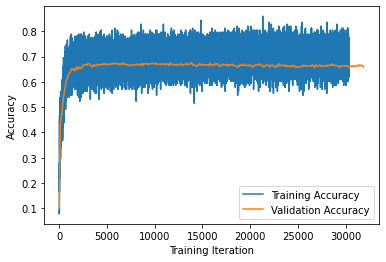

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()